In [1]:
# !pip install tqdm

In [2]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from transformers import ViTForImageClassification
from scipy import stats



label_to_int = {'Goed': 0, 'Matig': 1, 'Redelijk': 2, 'Slecht': 3, 'Zeer_slecht': 4, 'Dood': 5}

class CustomImageDataset1(Dataset):
    def __init__(self, images, labels, transforms=None, samples_per_class=None):
        self.images = images
        self.labels = [label_to_int[label] for label in labels]
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        if self.transforms:
            image = self.transforms(image)

        return image, label

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transforms=None, sampling_factors=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.sampling_factors = sampling_factors if sampling_factors is not None else {label: 1 for label in set(labels)}

    def __len__(self):
        # Calculate total length considering sampling factors
        total_length = 0
        for label in self.labels:
            total_length += self.sampling_factors[label]
        return total_length

    def __getitem__(self, idx):
        # Find the actual image index based on the sampling factor
        actual_idx = idx
        for i, label in enumerate(self.labels):
            if actual_idx < self.sampling_factors[label]:
                break
            actual_idx -= self.sampling_factors[label]


        image = Image.open(self.images[i])
        label = self.labels[i]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        # Process image
        if self.transforms:
            image = self.transforms(image)

        return image, label_to_int[label]

def load_images(folder_path):
    print("Loading images...")

    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_folder)
    print("Total images loaded:", len(images))
    return images, labels

def split_dataset(images, labels, train_ratio=0.6, val_ratio=0.2):
    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    train_set = dataset[:train_size]
    val_set = dataset[train_size:train_size + val_size]
    test_set = dataset[train_size + val_size:]
    print(f"Dataset split into {len(train_set)} training, {len(val_set)} validation, and {len(test_set)} test images.")
    return train_set, val_set, test_set

def count_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def calculate_sampling_factors(train_set):
    label_counts = Counter(label for _, label in train_set)
    min_samples = min(label_counts.values())

    # Calculate sampling factor for each class
    sampling_factors = {label: round(100*(min_samples / count)) for label, count in label_counts.items()}
    return sampling_factors

def create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size):
    # Define transformations
    print("Creating dataloaders...")

    train_transforms = transforms.Compose([
        transforms.RandomCrop(224),  # Specify size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CustomImageDataset([i[0] for i in train_set], [i[1] for i in train_set], transforms=train_transforms, sampling_factors=sampling_factors)
    val_dataset = CustomImageDataset([i[0] for i in val_set], [i[1] for i in val_set], transforms=val_test_transforms)
    test_dataset = CustomImageDataset([i[0] for i in test_set], [i[1] for i in test_set], transforms=val_test_transforms)
    # print('Dataset', train_dataset[0])
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataloaders created.")
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

def calculate_samples_per_class(class_distribution):
    min_count = min(class_distribution.values())
    samples_per_class = {label_to_int[cls]: min_count // count for cls, count in class_distribution.items()}
    return samples_per_class



def load_data(folder1):
    images, labels = load_images(folder1)
    train_set, val_set, test_set = split_dataset(images, labels)

    # Print class distribution
    train_class_distribution = count_class_distribution(train_set)
    val_class_distribution = count_class_distribution(val_set)
    test_class_distribution = count_class_distribution(test_set)

    print("Training set class distribution:", train_class_distribution)
    print("Validation set class distribution:", val_class_distribution)
    print("Test set class distribution:", test_class_distribution)

    sampling_factors = calculate_sampling_factors(train_set)
#     sampling_factors = {'rice': 1, 'other': 2, 'sugarcane': 6, 'cassava': 12, 'maize': 10}
#     sampling_factors = {'Goed': 7, 'Matig': 7, 'Redelijk': 7, 'Slecht': 7, 'Zeer Slecht': 7}
    #sampling_factors = {'goed': 30, 'matige': 1, 'Redelijk': 1, 'slecht': 30, 'Zeer_slecht': 30, 'dood': 30}
    print('Sampling factors: ', sampling_factors)
    train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size=8)

    return train_loader, val_loader, test_loader

In [3]:
def extract_patches(image, patch_size, stride):
    patches = []
    c, height, width = image.size()

    for y in range(0, height - patch_size[1] + 1, stride):
        for x in range(0, width - patch_size[0] + 1, stride):
            patch = image[:, y:y + patch_size[1], x:x + patch_size[0]]
            patches.append(patch)

    return patches

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)

        #For ViT
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels)

        # loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        # _, predicted = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.logits, 1)

        correct = (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct/len(labels))

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        # For F1 score calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    return avg_loss, accuracy, f1, per_class_f1



def validate_or_test(model, loader, criterion, device, patch_size, stride, desc='Val'):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            batch_preds = []

            for image in images:
                # # Apply sliding window approach
                # patches = extract_patches(image, patch_size, stride)
                # patches = torch.stack(patches).to(device)

                # # Aggregate predictions for each patch
                # patch_outputs = model(patches)
                # logits = patch_outputs.logits  # Extract the logits
                # patch_predictions = torch.mean(logits, dim=0)
                # patch_predictions = torch.mean(patch_outputs, dim=0)
                # batch_preds.append(patch_predictions)

                # Calculate the mode of the patch predictions

                patches = extract_patches(image, patch_size, stride)
                patches = torch.stack(patches).to(device)

                # Aggregate predictions for each patch
                patch_outputs = model(patches)
                logits = patch_outputs.logits  # Extract the logits

                # Calculate mode for each patch prediction
                modes, _ = torch.mode(logits, dim=0)
                batch_preds.append(modes)

            print(batch_preds)
            batch_preds = torch.stack(batch_preds)
            loss = criterion(batch_preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(batch_preds, 1)
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return avg_loss, accuracy, f1, per_class_f1

import matplotlib.pyplot as plt
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_and_evaluate(model, train_loader, val_loader, test_loader, model_name, num_epochs=5, learning_rate=1e-04, patch_size=(224, 224), stride=30):
    # Criterion, Optimizer, and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    global best_val_f1
    global best_model_weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):

        train_loss, train_accuracy, train_f1, train_f1_per_class = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Train F1 Score Per Class ', train_f1_per_class)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy, val_f1, val_f1_per_class = validate_or_test(model, val_loader, criterion, device, patch_size, stride, desc='Val')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')
        print(f'Val F1 Score Per Class ', val_f1_per_class)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()  # Save the best model weights

        # Save intermediate model weights
        torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}_epoch_{epoch}.pth')

        scheduler.step()

        # Plot train and validation accuracy
        plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train and Validation Accuracy')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_accuracy_epoch_{epoch + 1}.png')
        plt.close()

        # Plot train and validation loss
        plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Validation Loss')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_loss_epoch_{epoch + 1}.png')
        plt.close()

    test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(model, test_loader, criterion, device, patch_size, stride, desc='Test')
    print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
    print(f'Test F1 Score Per Class ', test_f1_per_class)

    # After training is complete, load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model weights
    torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}.pth')

    return model


Loading images...
Total images loaded: 2885
Splitting dataset...
Dataset split into 1731 training, 577 validation, and 577 test images.
Training set class distribution: {'Goed': 203, 'Matig': 423, 'Dood': 101, 'Slecht': 569, 'Redelijk': 415, 'Zeer_slecht': 20}
Validation set class distribution: {'Slecht': 176, 'Matig': 127, 'Goed': 87, 'Redelijk': 146, 'Dood': 37, 'Zeer_slecht': 4}
Test set class distribution: {'Redelijk': 131, 'Matig': 146, 'Slecht': 181, 'Dood': 46, 'Goed': 68, 'Zeer_slecht': 5}
Sampling factors:  {'Goed': 10, 'Matig': 5, 'Dood': 20, 'Slecht': 4, 'Redelijk': 5, 'Zeer_slecht': 100}
Creating dataloaders...
Dataloaders created.
1565 73 73


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.8086, Accuracy: 0.1679, F1 Score: 0.1592
Train F1 Score Per Class  [0.12062138 0.17195362 0.1669114  0.23134561 0.10907924 0.14513869]


Val:   1%|▏         | 1/73 [00:00<00:54,  1.33it/s, loss=1.83]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:01<00:41,  1.73it/s, loss=1.81]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:36,  1.91it/s, loss=1.74]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:02<00:34,  2.03it/s, loss=1.89]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0717, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:32,  2.09it/s, loss=1.87]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0717, -0.0111,  0.0650], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:03<00:31,  2.13it/s, loss=1.84]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0717, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:31,  2.12it/s, loss=1.83]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.14it/s, loss=1.83]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.15it/s, loss=1.79]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1413,  0.1178, -0.0717, -0.0111,  0.0650], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.16it/s, loss=1.84]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.18it/s, loss=1.74]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0259, -0.1417,  0.1178, -0.0719, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:27,  2.18it/s, loss=1.83]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0259, -0.1417,  0.1180, -0.0719, -0.0113,  0.0652], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.19it/s, loss=1.82]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:26,  2.19it/s, loss=1.83]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:26,  2.20it/s, loss=1.8]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:25,  2.21it/s, loss=1.76]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0652], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:08<00:25,  2.21it/s, loss=1.78]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0259, -0.1417,  0.1178, -0.0719, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:24,  2.20it/s, loss=1.82]

[tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:24,  2.20it/s, loss=1.86]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.20it/s, loss=1.79]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:23,  2.20it/s, loss=1.82]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.21it/s, loss=1.82]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:22,  2.20it/s, loss=1.82]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0259, -0.1415,  0.1178, -0.0716, -0.0114,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.20it/s, loss=1.83]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0717, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:21,  2.21it/s, loss=1.79]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0717, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.21it/s, loss=1.83]

[tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:20,  2.21it/s, loss=1.76]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1179, -0.0718, -0.0111,  0.0650], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.22it/s, loss=1.84]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:19,  2.21it/s, loss=1.8]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.17it/s, loss=1.75]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.18it/s, loss=1.76]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.18it/s, loss=1.8]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0717, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.19it/s, loss=1.78]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:17,  2.19it/s, loss=1.81]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.20it/s, loss=1.81]

[tensor([ 0.0259, -0.1417,  0.1178, -0.0719, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:16,  2.20it/s, loss=1.83]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.20it/s, loss=1.85]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:15,  2.19it/s, loss=1.79]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0652], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.19it/s, loss=1.77]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.19it/s, loss=1.77]

[tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:18<00:14,  2.19it/s, loss=1.78]

[tensor([ 0.0261, -0.1414,  0.1179, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.19it/s, loss=1.82]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0113,  0.0652], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:13,  2.19it/s, loss=1.84]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.19it/s, loss=1.82]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0718, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.14it/s, loss=1.85]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.15it/s, loss=1.79]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=1.9]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.18it/s, loss=1.77]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:10,  2.19it/s, loss=1.77]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.20it/s, loss=1.78]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0717, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:09,  2.20it/s, loss=1.78]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.20it/s, loss=1.82]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.20it/s, loss=1.76]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:24<00:08,  2.21it/s, loss=1.87]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.20it/s, loss=1.81]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0259, -0.1417,  0.1178, -0.0719, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:25<00:07,  2.21it/s, loss=1.75]

[tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.21it/s, loss=1.88]

[tensor([ 0.0262, -0.1411,  0.1177, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:26<00:06,  2.21it/s, loss=1.82]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.15it/s, loss=1.83]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.16it/s, loss=1.81]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.18it/s, loss=1.81]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1177, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.18it/s, loss=1.73]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.20it/s, loss=1.81]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.19it/s, loss=1.79]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:29<00:03,  2.20it/s, loss=1.78]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0717, -0.0112,  0.0650], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.19it/s, loss=1.82]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:30<00:02,  2.19it/s, loss=1.75]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.17it/s, loss=1.81]

[tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:31<00:01,  2.18it/s, loss=1.79]

[tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.19it/s, loss=1.8]

[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:32<00:00,  2.19it/s, loss=1.88]

[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0113,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0260, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1414,  0.1178, -0.0717, -0.0112,  0.0651], device='cuda:0')]


[tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1411,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0262, -0.1412,  0.1178, -0.0715, -0.0112,  0.0651], device='cuda:0'), tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]
[tensor([ 0.0261, -0.1413,  0.1178, -0.0716, -0.0112,  0.0651], device='cuda:0')]


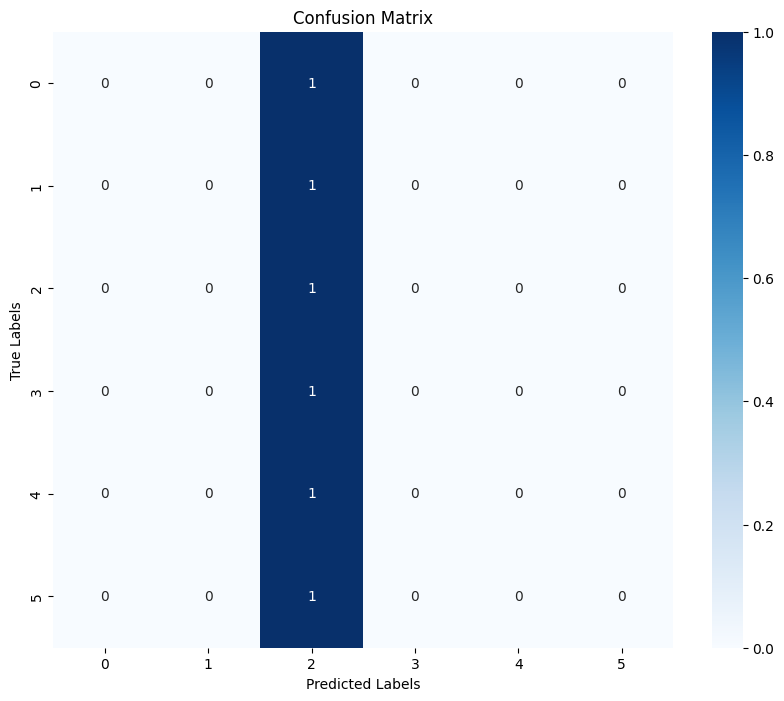

Epoch 1, Validation Loss: 1.8095, Accuracy: 0.2530, F1 Score: 0.1022
Val F1 Score Per Class  [0.         0.         0.40387275 0.         0.         0.        ]


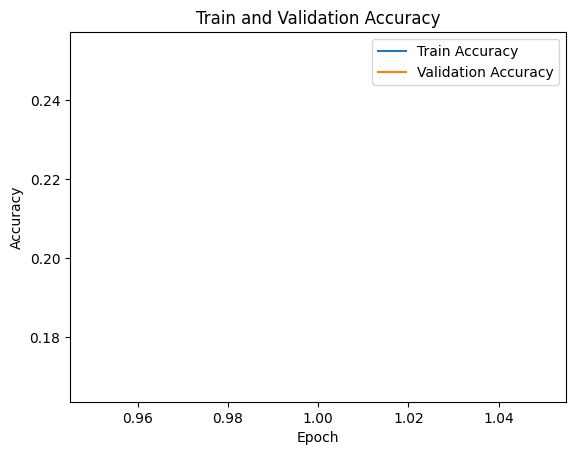

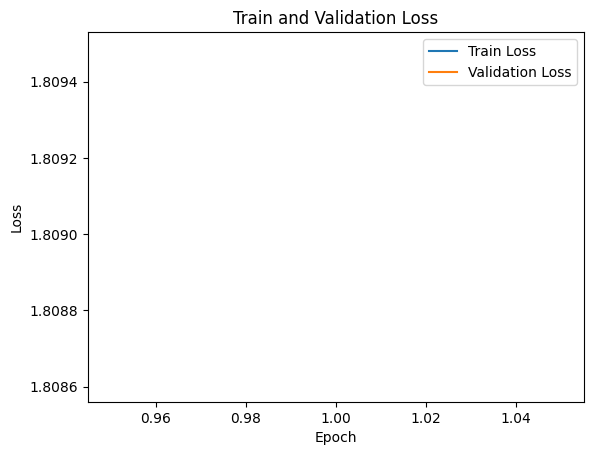

Epoch 2, Train Loss: 1.8094, Accuracy: 0.1720, F1 Score: 0.1624
Train F1 Score Per Class  [0.15775257 0.17127198 0.15324877 0.24405125 0.10301837 0.13375431]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.44it/s, loss=1.71]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1553, -0.0146,  0.3896,  0.1546, -0.4362,  0.0672], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1547, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=1.84]

[tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0145,  0.3899,  0.1548, -0.4365,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1547, -0.4363,  0.0672], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.66]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.38it/s, loss=1.79]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1549, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.36it/s, loss=1.8]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3898,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=1.69]

[tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.37it/s, loss=1.69]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.37it/s, loss=1.65]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=1.59]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.37it/s, loss=1.86]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.37it/s, loss=1.74]

[tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3898,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0145,  0.3898,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.37it/s, loss=1.65]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1551, -0.0147,  0.3895,  0.1544, -0.4361,  0.0671], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3898,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.36it/s, loss=1.71]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.37it/s, loss=1.65]

[tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.37it/s, loss=1.78]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3900,  0.1549, -0.4363,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.38it/s, loss=1.63]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=1.73]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=1.66]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.36it/s, loss=1.79]

[tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=1.75]

[tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1547, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0146,  0.3898,  0.1547, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.36it/s, loss=1.77]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.36it/s, loss=1.71]

[tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.37it/s, loss=1.69]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1547, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.37it/s, loss=1.82]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=1.8]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1549, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1549, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.37it/s, loss=1.78]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.37it/s, loss=1.58]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1553, -0.0145,  0.3899,  0.1548, -0.4362,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=1.67]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0146,  0.3897,  0.1546, -0.4363,  0.0672], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=1.79]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=1.65]

[tensor([-0.1554, -0.0146,  0.3898,  0.1547, -0.4364,  0.0672], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=1.58]

[tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1548, -0.4364,  0.0673], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=1.72]

[tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1547, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3898,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=1.68]

[tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1547, -0.4363,  0.0672], device='cuda:0'), tensor([-0.1553, -0.0145,  0.3898,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=1.62]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=1.75]

[tensor([-0.1556, -0.0146,  0.3897,  0.1546, -0.4364,  0.0672], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1552, -0.0146,  0.3897,  0.1546, -0.4362,  0.0672], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1553, -0.0147,  0.3895,  0.1544, -0.4363,  0.0671], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=1.77]

[tensor([-0.1556, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=1.85]

[tensor([-0.1557, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0147,  0.3896,  0.1545, -0.4363,  0.0672], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.37it/s, loss=1.7]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=1.73]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1549, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1549, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.37it/s, loss=1.74]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0146,  0.3897,  0.1547, -0.4364,  0.0672], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.37it/s, loss=1.68]

[tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.38it/s, loss=1.61]

[tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1553, -0.0145,  0.3898,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=1.69]

[tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.38it/s, loss=1.65]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=1.77]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.37it/s, loss=1.66]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=1.75]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3898,  0.1547, -0.4364,  0.0673], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=1.77]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=1.65]

[tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.38it/s, loss=1.57]

[tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0146,  0.3897,  0.1546, -0.4363,  0.0672], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=1.57]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=1.71]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.64]

[tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=1.74]

[tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0147,  0.3896,  0.1546, -0.4363,  0.0672], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=1.73]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=1.54]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.37it/s, loss=1.73]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3898,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=1.77]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.36it/s, loss=1.79]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=1.72]

[tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4365,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1547, -0.4363,  0.0673], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=1.73]

[tensor([-0.1554, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1553, -0.0146,  0.3897,  0.1547, -0.4362,  0.0672], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=1.62]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3900,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1549, -0.4363,  0.0673], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.38it/s, loss=1.67]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=1.75]

[tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.59]

[tensor([-0.1556, -0.0144,  0.3899,  0.1549, -0.4365,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=1.71]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=1.56]

[tensor([-0.1555, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.38it/s, loss=1.7]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0145,  0.3898,  0.1547, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0145,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.38it/s, loss=1.64]

[tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3898,  0.1547, -0.4363,  0.0673], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=1.6]

[tensor([-0.1553, -0.0146,  0.3898,  0.1547, -0.4363,  0.0672], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3899,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=1.77]

[tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3899,  0.1548, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1554, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0146,  0.3897,  0.1546, -0.4364,  0.0672], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0673], device='cuda:0'), tensor([-0.1552, -0.0146,  0.3897,  0.1546, -0.4362,  0.0672], device='cuda:0')]


[tensor([-0.1556, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4365,  0.0674], device='cuda:0'), tensor([-0.1555, -0.0144,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0'), tensor([-0.1556, -0.0143,  0.3900,  0.1550, -0.4364,  0.0674], device='cuda:0'), tensor([-0.1556, -0.0144,  0.3900,  0.1549, -0.4364,  0.0674], device='cuda:0')]
[tensor([-0.1554, -0.0145,  0.3899,  0.1548, -0.4363,  0.0673], device='cuda:0')]


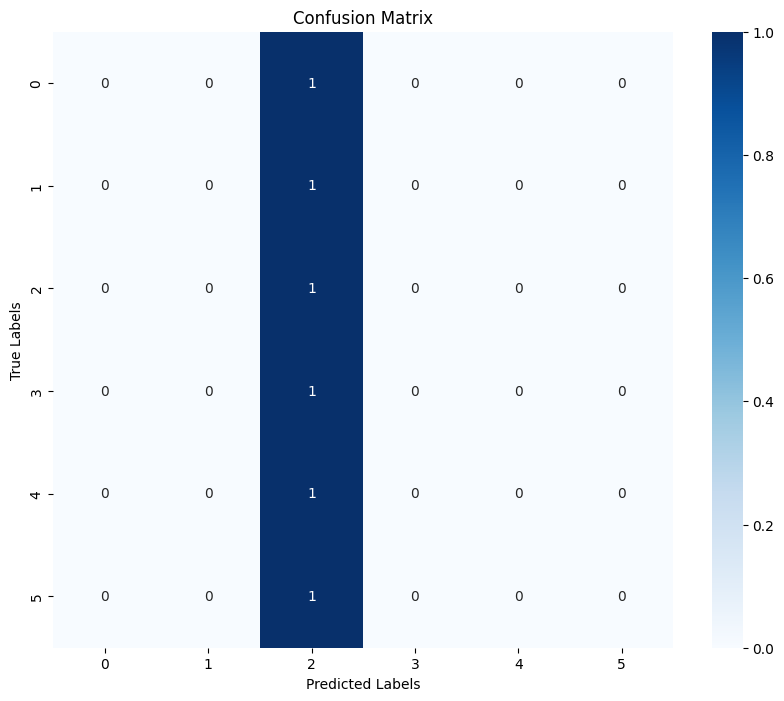

Epoch 2, Validation Loss: 1.7059, Accuracy: 0.2530, F1 Score: 0.1022
Val F1 Score Per Class  [0.         0.         0.40387275 0.         0.         0.        ]


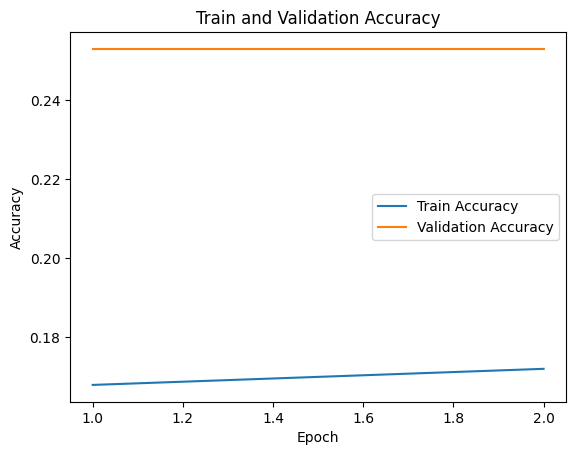

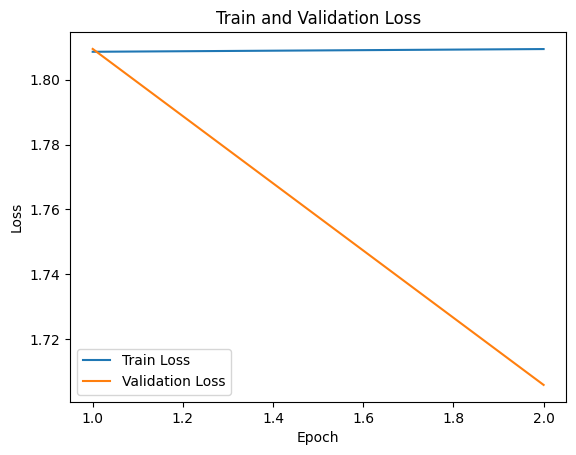

Epoch 3, Train Loss: 1.8049, Accuracy: 0.1744, F1 Score: 0.1621
Train F1 Score Per Class  [0.12681792 0.16023739 0.15581098 0.25802817 0.12363636 0.13605823]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=1.93]

[tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.38it/s, loss=2]

[tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3482, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.35it/s, loss=1.91]

[tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.35it/s, loss=1.95]

[tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.35it/s, loss=1.97]

[tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.36it/s, loss=1.81]

[tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3490, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.36it/s, loss=1.89]

[tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2448, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.33it/s, loss=1.83]

[tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:27,  2.33it/s, loss=1.87]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:27,  2.31it/s, loss=1.99]

[tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.31it/s, loss=1.81]

[tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:26,  2.31it/s, loss=1.83]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2448, -0.3487, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.32it/s, loss=1.79]

[tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:25,  2.33it/s, loss=1.83]

[tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2448, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.34it/s, loss=1.9]

[tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.34it/s, loss=1.78]

[tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.36it/s, loss=1.85]

[tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.36it/s, loss=1.83]

[tensor([-0.2446, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.36it/s, loss=1.88]

[tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=1.91]

[tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.36it/s, loss=1.9]

[tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.37it/s, loss=2.02]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.36it/s, loss=1.87]

[tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.37it/s, loss=2.01]

[tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3482, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2448, -0.3486, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=1.76]

[tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:11<00:19,  2.37it/s, loss=1.82]

[tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3491, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.36it/s, loss=1.81]

[tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:19,  2.37it/s, loss=1.89]

[tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=1.89]

[tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=1.9]

[tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=1.81]

[tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=2]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:14<00:16,  2.37it/s, loss=1.88]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3491, -0.0327,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=1.85]

[tensor([-0.2446, -0.3490, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.37it/s, loss=1.84]

[tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=1.78]

[tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=1.99]

[tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.36it/s, loss=1.94]

[tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=1.82]

[tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.37it/s, loss=1.99]

[tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.37it/s, loss=1.88]

[tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3490, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.36it/s, loss=1.7]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2448, -0.3487, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=1.81]

[tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.36it/s, loss=1.91]

[tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2448, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:11,  2.36it/s, loss=1.82]

[tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3481, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.36it/s, loss=1.75]

[tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.36it/s, loss=1.91]

[tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.36it/s, loss=1.9]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2448, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2446, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=1.84]

[tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.38it/s, loss=1.81]

[tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2448, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=1.81]

[tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2448, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:22<00:08,  2.37it/s, loss=1.79]

[tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.92]

[tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.85]

[tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=1.92]

[tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=1.83]

[tensor([-0.2446, -0.3490, -0.0326,  0.1372,  0.2712,  0.1246], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.37it/s, loss=1.93]

[tensor([-0.2448, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=1.9]

[tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2448, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:25<00:05,  2.37it/s, loss=1.96]

[tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=1.94]

[tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3491, -0.0326,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.36it/s, loss=1.92]

[tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.36it/s, loss=1.92]

[tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3491, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.81]

[tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.37it/s, loss=1.91]

[tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2446, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0330,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.73]

[tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=1.79]

[tensor([-0.2448, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.35it/s, loss=1.75]

[tensor([-0.2447, -0.3490, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.35it/s, loss=1.88]

[tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3485, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0328,  0.1373,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.35it/s, loss=1.85]

[tensor([-0.2447, -0.3485, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2448, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2446, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.35it/s, loss=1.79]

[tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0327,  0.1372,  0.2712,  0.1244], device='cuda:0'), tensor([-0.2447, -0.3483, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.36it/s, loss=1.89]

[tensor([-0.2447, -0.3488, -0.0327,  0.1372,  0.2712,  0.1245], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0330,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3489, -0.0329,  0.1372,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1241], device='cuda:0')]


[tensor([-0.2448, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3487, -0.0328,  0.1372,  0.2712,  0.1243], device='cuda:0'), tensor([-0.2447, -0.3490, -0.0329,  0.1372,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2448, -0.3482, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2448, -0.3484, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0'), tensor([-0.2447, -0.3486, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3484, -0.0329,  0.1373,  0.2712,  0.1242], device='cuda:0'), tensor([-0.2447, -0.3488, -0.0328,  0.1372,  0.2712,  0.1244], device='cuda:0')]
[tensor([-0.2447, -0.3482, -0.0330,  0.1373,  0.2712,  0.1241], device='cuda:0')]


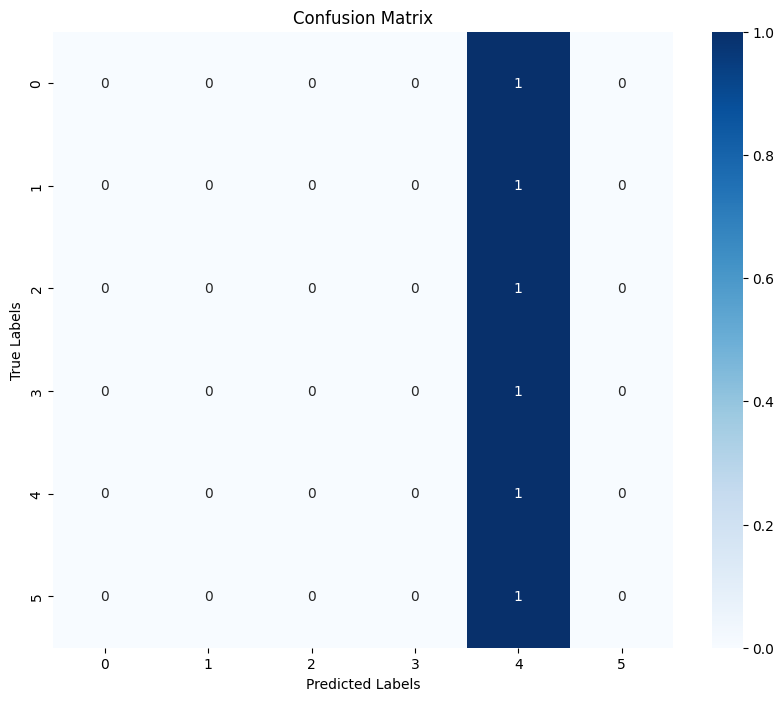

Epoch 3, Validation Loss: 1.8732, Accuracy: 0.0069, F1 Score: 0.0001
Val F1 Score Per Class  [0.         0.         0.         0.         0.01376936 0.        ]


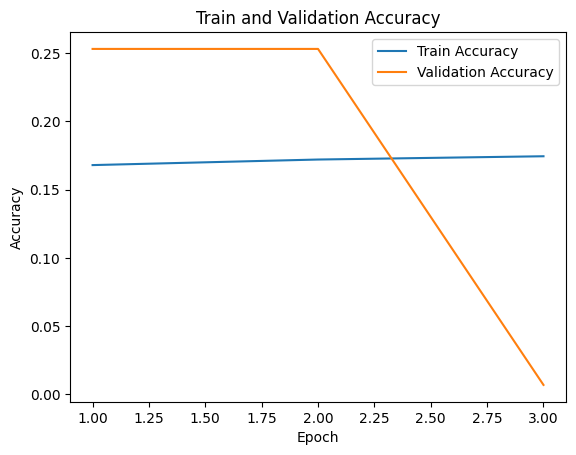

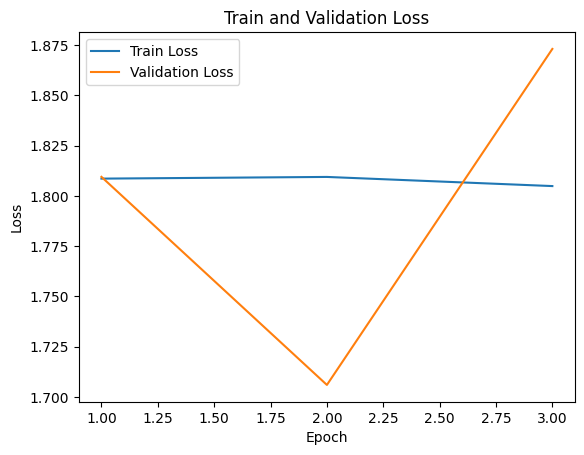

Epoch 4, Train Loss: 1.8050, Accuracy: 0.1698, F1 Score: 0.1596
Train F1 Score Per Class  [0.1440536  0.1647686  0.14545455 0.23740591 0.10379242 0.15218594]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=1.79]

[tensor([ 1.1887e-01,  5.3552e-01, -7.2067e-01,  1.2756e-01, -6.6214e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2066e-01,  1.2774e-01, -5.9585e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2065e-01,  1.2766e-01, -6.3292e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2067e-01,  1.2761e-01, -6.4559e-04,
        -5.5613e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3551e-01, -7.2068e-01,  1.2758e-01, -6.5977e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2066e-01,  1.2770e-01, -5.8742e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3559e-01, -7.2067e-01,  1.2752e-01, -7.1219e-04,
        -5.5580e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2069e-01,  1.2759e-01, -6.5748e-04,
        -5.5611e-02], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=1.74]

[tensor([ 1.1885e-01,  5.3548e-01, -7.2067e-01,  1.2757e-01, -6.4539e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2069e-01,  1.2762e-01, -6.3556e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2066e-01,  1.2769e-01, -6.1346e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3545e-01, -7.2067e-01,  1.2765e-01, -6.5727e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3551e-01, -7.2068e-01,  1.2761e-01, -6.1967e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2064e-01,  1.2769e-01, -5.8488e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1884e-01,  5.3546e-01, -7.2066e-01,  1.2763e-01, -6.3649e-04,
        -5.5599e-02], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=2.13]

[tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2070e-01,  1.2763e-01, -6.3134e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3548e-01, -7.2068e-01,  1.2759e-01, -6.6810e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3541e-01, -7.2067e-01,  1.2760e-01, -6.2616e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3539e-01, -7.2068e-01,  1.2771e-01, -6.3023e-04,
        -5.5613e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2066e-01,  1.2763e-01, -5.8153e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2065e-01,  1.2763e-01, -6.4163e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2068e-01,  1.2762e-01, -6.6345e-04,
        -5.5604e-02], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.53]

[tensor([ 1.1884e-01,  5.3536e-01, -7.2067e-01,  1.2758e-01, -6.5752e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2067e-01,  1.2757e-01, -6.5657e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3548e-01, -7.2070e-01,  1.2764e-01, -6.5642e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1887e-01,  5.3557e-01, -7.2070e-01,  1.2757e-01, -7.0200e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2068e-01,  1.2767e-01, -5.9666e-04,
        -5.5600e-02], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.36it/s, loss=1.52]

[tensor([ 1.1882e-01,  5.3536e-01, -7.2066e-01,  1.2761e-01, -6.1114e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 0.1189,  0.5358, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2064e-01,  1.2773e-01, -5.7001e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2066e-01,  1.2763e-01, -6.3786e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2068e-01,  1.2763e-01, -6.6865e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2067e-01,  1.2763e-01, -6.6233e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2069e-01,  1.2762e-01, -6.6210e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2064e-01,  1.2766e-01, -6.1810e-04,
        -5.5598e-02], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=1.76]

[tensor([ 1.1885e-01,  5.3550e-01, -7.2070e-01,  1.2760e-01, -6.8545e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3534e-01, -7.2067e-01,  1.2768e-01, -6.2587e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3556e-01, -7.2067e-01,  1.2757e-01, -6.5050e-04,
        -5.5582e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3544e-01, -7.2067e-01,  1.2762e-01, -6.2661e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2065e-01,  1.2773e-01, -5.8151e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2064e-01,  1.2768e-01, -5.4272e-04,
        -5.5593e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.37it/s, loss=1.81]

[tensor([ 1.1884e-01,  5.3545e-01, -7.2068e-01,  1.2762e-01, -6.5067e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3553e-01, -7.2066e-01,  1.2756e-01, -6.2484e-04,
        -5.5573e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2068e-01,  1.2768e-01, -6.6013e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2065e-01,  1.2768e-01, -6.2941e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2069e-01,  1.2765e-01, -6.4540e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3544e-01, -7.2069e-01,  1.2769e-01, -6.2037e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3539e-01, -7.2067e-01,  1.2766e-01, -6.4400e-04,
        -5.5607e-02], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.36it/s, loss=1.84]

[tensor([ 1.1885e-01,  5.3544e-01, -7.2066e-01,  1.2761e-01, -6.2674e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3540e-01, -7.2065e-01,  1.2765e-01, -6.7026e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3545e-01, -7.2069e-01,  1.2760e-01, -6.8075e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3537e-01, -7.2064e-01,  1.2765e-01, -5.1699e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1891e-01,  5.3565e-01, -7.2068e-01,  1.2755e-01, -6.6256e-04,
        -5.5579e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2072e-01,  1.2757e-01, -6.8703e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2066e-01,  1.2761e-01, -6.3203e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3542e-01, -7.2068e-01,  1.2758e-01, -6.5399e-04,
        -5.5597e-02], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:27,  2.37it/s, loss=2.05]

[tensor([ 1.1882e-01,  5.3539e-01, -7.2066e-01,  1.2766e-01, -5.8525e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2068e-01,  1.2763e-01, -6.4655e-04,
        -5.5613e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2064e-01,  1.2772e-01, -5.6172e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3536e-01, -7.2068e-01,  1.2765e-01, -6.0445e-04,
        -5.5623e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1886e-01,  5.3551e-01, -7.2068e-01,  1.2759e-01, -6.7803e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3534e-01, -7.2065e-01,  1.2777e-01, -5.4448e-04,
        -5.5616e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3546e-01, -7.2070e-01,  1.2760e-01, -6.9811e-04,
        -5.5596e-02], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.35it/s, loss=1.6]

[tensor([ 1.1883e-01,  5.3538e-01, -7.2066e-01,  1.2766e-01, -6.0834e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3541e-01, -7.2066e-01,  1.2771e-01, -5.6796e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3556e-01, -7.2069e-01,  1.2754e-01, -7.0078e-04,
        -5.5589e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3554e-01, -7.2071e-01,  1.2759e-01, -7.2024e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2066e-01,  1.2770e-01, -5.8853e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2065e-01,  1.2760e-01, -6.3260e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2067e-01,  1.2767e-01, -6.1281e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3543e-01, -7.2064e-01,  1.2760e-01, -5.9356e-04,
        -5.5577e-02], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.37it/s, loss=2.09]

[tensor([ 1.1887e-01,  5.3552e-01, -7.2068e-01,  1.2754e-01, -6.7793e-04,
        -5.5582e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3547e-01, -7.2066e-01,  1.2759e-01, -6.4362e-04,
        -5.5583e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3546e-01, -7.2070e-01,  1.2753e-01, -6.9813e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3545e-01, -7.2069e-01,  1.2762e-01, -6.5012e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3540e-01, -7.2067e-01,  1.2769e-01, -6.3526e-04,
        -5.5618e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2066e-01,  1.2769e-01, -6.2877e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2064e-01,  1.2764e-01, -6.2954e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3544e-01, -7.2067e-01,  1.2769e-01, -6.5696e-04,
        -5.5603e-02], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=1.84]

[tensor([ 1.1882e-01,  5.3541e-01, -7.2068e-01,  1.2768e-01, -5.8978e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1890e-01,  5.3563e-01, -7.2074e-01,  1.2755e-01, -7.0864e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3561e-01, -7.2072e-01,  1.2758e-01, -6.9105e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3551e-01, -7.2072e-01,  1.2755e-01, -6.9859e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3552e-01, -7.2067e-01,  1.2760e-01, -6.2745e-04,
        -5.5593e-02], device='cuda:0'), tensor([ 0.1189,  0.5355, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1885e-01,  5.3546e-01, -7.2066e-01,  1.2764e-01, -6.0036e-04,
        -5.5598e-02], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.36it/s, loss=1.81]

[tensor([ 1.1884e-01,  5.3544e-01, -7.2065e-01,  1.2766e-01, -6.0033e-04,
        -5.5590e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2067e-01,  1.2762e-01, -6.4459e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3533e-01, -7.2068e-01,  1.2770e-01, -5.9379e-04,
        -5.5613e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3534e-01, -7.2065e-01,  1.2774e-01, -5.7414e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3546e-01, -7.2069e-01,  1.2759e-01, -6.7938e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2064e-01,  1.2767e-01, -5.6508e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2066e-01,  1.2767e-01, -6.1801e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2065e-01,  1.2766e-01, -5.9759e-04,
        -5.5608e-02], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:25,  2.36it/s, loss=1.84]

[tensor([ 1.1885e-01,  5.3548e-01, -7.2069e-01,  1.2763e-01, -6.9293e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2065e-01,  1.2770e-01, -6.2685e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2069e-01,  1.2767e-01, -6.5428e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3537e-01, -7.2063e-01,  1.2758e-01, -5.9665e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3540e-01, -7.2067e-01,  1.2766e-01, -6.3986e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2065e-01,  1.2769e-01, -5.5892e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3551e-01, -7.2067e-01,  1.2762e-01, -6.7637e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3546e-01, -7.2065e-01,  1.2760e-01, -6.2464e-04,
        -5.5585e-02], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.36it/s, loss=1.78]

[tensor([ 1.1881e-01,  5.3536e-01, -7.2070e-01,  1.2759e-01, -7.1185e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3546e-01, -7.2067e-01,  1.2761e-01, -6.7028e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2069e-01,  1.2764e-01, -6.6536e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3552e-01, -7.2069e-01,  1.2764e-01, -6.4011e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3546e-01, -7.2070e-01,  1.2755e-01, -6.9498e-04,
        -5.5590e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2066e-01,  1.2772e-01, -5.9906e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3533e-01, -7.2065e-01,  1.2769e-01, -6.0177e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2068e-01,  1.2772e-01, -6.3470e-04,
        -5.5605e-02], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=2.07]

[tensor([ 1.1885e-01,  5.3548e-01, -7.2068e-01,  1.2766e-01, -6.7004e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2064e-01,  1.2764e-01, -5.9748e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2067e-01,  1.2765e-01, -6.3026e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3534e-01, -7.2070e-01,  1.2775e-01, -6.7272e-04,
        -5.5632e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2065e-01,  1.2770e-01, -6.0554e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2065e-01,  1.2768e-01, -6.0658e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2068e-01,  1.2759e-01, -6.3266e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2069e-01,  1.2758e-01, -6.7168e-04,
        -5.5611e-02], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=1.94]

[tensor([ 1.1882e-01,  5.3536e-01, -7.2067e-01,  1.2771e-01, -6.1001e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2071e-01,  1.2757e-01, -6.9500e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3548e-01, -7.2069e-01,  1.2761e-01, -6.4881e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3536e-01, -7.2069e-01,  1.2770e-01, -6.5626e-04,
        -5.5616e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3537e-01, -7.2066e-01,  1.2764e-01, -5.8152e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3555e-01, -7.2071e-01,  1.2756e-01, -6.8798e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3546e-01, -7.2069e-01,  1.2758e-01, -7.1418e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3552e-01, -7.2067e-01,  1.2764e-01, -6.7734e-04,
        -5.5597e-02], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=1.86]

[tensor([ 1.1882e-01,  5.3541e-01, -7.2066e-01,  1.2771e-01, -6.0739e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1892e-01,  5.3571e-01, -7.2072e-01,  1.2752e-01, -7.0821e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2067e-01,  1.2768e-01, -6.2527e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3551e-01, -7.2070e-01,  1.2761e-01, -6.9286e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3536e-01, -7.2063e-01,  1.2773e-01, -5.4109e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3552e-01, -7.2068e-01,  1.2755e-01, -6.7716e-04,
        -5.5585e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3546e-01, -7.2066e-01,  1.2763e-01, -6.2490e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2065e-01,  1.2768e-01, -6.1979e-04,
        -5.5595e-02], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.37it/s, loss=1.63]

[tensor([ 1.1881e-01,  5.3534e-01, -7.2068e-01,  1.2768e-01, -6.4273e-04,
        -5.5630e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3548e-01, -7.2067e-01,  1.2761e-01, -6.6314e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2067e-01,  1.2772e-01, -6.4786e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2067e-01,  1.2766e-01, -6.4622e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3551e-01, -7.2069e-01,  1.2765e-01, -6.4619e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3533e-01, -7.2068e-01,  1.2773e-01, -6.6315e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3536e-01, -7.2067e-01,  1.2770e-01, -6.0923e-04,
        -5.5615e-02], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=1.89]

[tensor([ 1.1885e-01,  5.3551e-01, -7.2073e-01,  1.2763e-01, -6.8264e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3542e-01, -7.2068e-01,  1.2758e-01, -6.8758e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3543e-01, -7.2067e-01,  1.2770e-01, -6.2088e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2068e-01,  1.2757e-01, -6.5320e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3551e-01, -7.2070e-01,  1.2758e-01, -6.6825e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2068e-01,  1.2760e-01, -6.4751e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2066e-01,  1.2761e-01, -6.1665e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3546e-01, -7.2070e-01,  1.2759e-01, -6.8252e-04,
        -5.5597e-02], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.37it/s, loss=1.76]

[tensor([ 1.1881e-01,  5.3535e-01, -7.2069e-01,  1.2770e-01, -6.1512e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1879e-01,  5.3532e-01, -7.2067e-01,  1.2770e-01, -5.9914e-04,
        -5.5627e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3554e-01, -7.2066e-01,  1.2759e-01, -6.3186e-04,
        -5.5581e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3532e-01, -7.2067e-01,  1.2765e-01, -6.1110e-04,
        -5.5625e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3549e-01, -7.2066e-01,  1.2758e-01, -6.6398e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3537e-01, -7.2066e-01,  1.2773e-01, -5.9475e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3536e-01, -7.2066e-01,  1.2772e-01, -6.0483e-04,
        -5.5618e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2067e-01,  1.2769e-01, -6.6510e-04,
        -5.5602e-02], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=1.84]

[tensor([ 1.1887e-01,  5.3555e-01, -7.2071e-01,  1.2760e-01, -6.7605e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3549e-01, -7.2065e-01,  1.2761e-01, -6.3506e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2067e-01,  1.2767e-01, -5.9783e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3550e-01, -7.2068e-01,  1.2758e-01, -6.9311e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3534e-01, -7.2067e-01,  1.2775e-01, -5.7786e-04,
        -5.5625e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2067e-01,  1.2773e-01, -6.0205e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2069e-01,  1.2770e-01, -6.3063e-04,
        -5.5617e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3536e-01, -7.2068e-01,  1.2769e-01, -6.5983e-04,
        -5.5617e-02], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.37it/s, loss=1.84]

[tensor([ 1.1884e-01,  5.3540e-01, -7.2068e-01,  1.2755e-01, -6.5050e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3547e-01, -7.2067e-01,  1.2765e-01, -6.4034e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2071e-01,  1.2754e-01, -6.9671e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3553e-01, -7.2067e-01,  1.2760e-01, -6.2257e-04,
        -5.5585e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3547e-01, -7.2064e-01,  1.2764e-01, -6.0495e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3553e-01, -7.2064e-01,  1.2758e-01, -6.6311e-04,
        -5.5585e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3536e-01, -7.2065e-01,  1.2771e-01, -5.8679e-04,
        -5.5612e-02], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=1.69]

[tensor([ 1.1884e-01,  5.3551e-01, -7.2070e-01,  1.2762e-01, -6.6724e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3552e-01, -7.2066e-01,  1.2760e-01, -6.3888e-04,
        -5.5579e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2066e-01,  1.2773e-01, -6.0319e-04,
        -5.5616e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3553e-01, -7.2068e-01,  1.2759e-01, -6.6299e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 0.1188,  0.5355, -0.7207,  0.1276, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2067e-01,  1.2769e-01, -6.1713e-04,
        -5.5613e-02], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=1.88]

[tensor([ 1.1880e-01,  5.3535e-01, -7.2064e-01,  1.2771e-01, -5.6640e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2068e-01,  1.2769e-01, -6.5344e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2066e-01,  1.2766e-01, -6.0628e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3549e-01, -7.2068e-01,  1.2757e-01, -6.7572e-04,
        -5.5585e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3556e-01, -7.2065e-01,  1.2755e-01, -6.4912e-04,
        -5.5582e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2065e-01,  1.2771e-01, -6.2484e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3545e-01, -7.2069e-01,  1.2759e-01, -7.0669e-04,
        -5.5622e-02], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.36it/s, loss=1.7]

[tensor([ 1.1889e-01,  5.3560e-01, -7.2072e-01,  1.2755e-01, -6.7154e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3544e-01, -7.2068e-01,  1.2764e-01, -6.3654e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3564e-01, -7.2067e-01,  1.2756e-01, -6.9232e-04,
        -5.5579e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3552e-01, -7.2068e-01,  1.2766e-01, -6.4471e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3535e-01, -7.2060e-01,  1.2770e-01, -4.9590e-04,
        -5.5590e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1883e-01,  5.3540e-01, -7.2068e-01,  1.2761e-01, -6.2350e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3532e-01, -7.2066e-01,  1.2771e-01, -6.1179e-04,
        -5.5617e-02], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.36it/s, loss=2.13]

[tensor([ 1.1884e-01,  5.3545e-01, -7.2066e-01,  1.2754e-01, -6.8063e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2067e-01,  1.2764e-01, -6.6872e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2066e-01,  1.2756e-01, -6.4260e-04,
        -5.5584e-02], device='cuda:0'), tensor([ 0.1190,  0.5358, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2068e-01,  1.2762e-01, -6.2033e-04,
        -5.5613e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3532e-01, -7.2068e-01,  1.2775e-01, -6.1828e-04,
        -5.5627e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3535e-01, -7.2067e-01,  1.2766e-01, -5.8986e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2069e-01,  1.2766e-01, -6.3932e-04,
        -5.5613e-02], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:19,  2.36it/s, loss=1.79]

[tensor([ 1.1882e-01,  5.3540e-01, -7.2066e-01,  1.2761e-01, -6.2538e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 0.1189,  0.5358, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1884e-01,  5.3545e-01, -7.2067e-01,  1.2766e-01, -6.5171e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3541e-01, -7.2064e-01,  1.2769e-01, -5.9190e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2066e-01,  1.2769e-01, -6.1805e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3551e-01, -7.2069e-01,  1.2761e-01, -6.7917e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3546e-01, -7.2068e-01,  1.2768e-01, -6.2416e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3536e-01, -7.2069e-01,  1.2765e-01, -6.1288e-04,
        -5.5609e-02], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=1.81]

[tensor([ 1.1882e-01,  5.3542e-01, -7.2066e-01,  1.2764e-01, -6.1777e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3549e-01, -7.2065e-01,  1.2763e-01, -6.3386e-04,
        -5.5590e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2070e-01,  1.2764e-01, -6.4500e-04,
        -5.5620e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2064e-01,  1.2766e-01, -6.2000e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3554e-01, -7.2067e-01,  1.2760e-01, -6.7603e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3554e-01, -7.2070e-01,  1.2757e-01, -6.6218e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3539e-01, -7.2067e-01,  1.2772e-01, -6.0062e-04,
        -5.5621e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3533e-01, -7.2065e-01,  1.2765e-01, -5.7984e-04,
        -5.5602e-02], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.37it/s, loss=2.1]

[tensor([ 1.1885e-01,  5.3543e-01, -7.2068e-01,  1.2757e-01, -6.9974e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3545e-01, -7.2069e-01,  1.2763e-01, -6.7022e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3555e-01, -7.2065e-01,  1.2758e-01, -6.3663e-04,
        -5.5578e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2066e-01,  1.2769e-01, -6.0515e-04,
        -5.5618e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2068e-01,  1.2768e-01, -6.2650e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2069e-01,  1.2764e-01, -6.4876e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3539e-01, -7.2070e-01,  1.2766e-01, -6.9911e-04,
        -5.5619e-02], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=2.13]

[tensor([ 1.1883e-01,  5.3543e-01, -7.2068e-01,  1.2759e-01, -6.4175e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3549e-01, -7.2068e-01,  1.2757e-01, -6.4265e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2072e-01,  1.2763e-01, -7.1119e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2068e-01,  1.2762e-01, -6.3711e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2065e-01,  1.2769e-01, -6.1388e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2066e-01,  1.2763e-01, -6.4402e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3549e-01, -7.2067e-01,  1.2760e-01, -6.6643e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3547e-01, -7.2068e-01,  1.2757e-01, -6.4959e-04,
        -5.5583e-02], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=1.9]

[tensor([ 1.1887e-01,  5.3554e-01, -7.2069e-01,  1.2759e-01, -6.6668e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3558e-01, -7.2069e-01,  1.2755e-01, -6.7963e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2065e-01,  1.2767e-01, -6.0165e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2071e-01,  1.2768e-01, -6.6654e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3536e-01, -7.2067e-01,  1.2761e-01, -6.2263e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 0.1189,  0.5358, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2064e-01,  1.2766e-01, -5.8903e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3557e-01, -7.2069e-01,  1.2755e-01, -6.9204e-04,
        -5.5587e-02], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=2]

[tensor([ 1.1884e-01,  5.3545e-01, -7.2069e-01,  1.2758e-01, -6.5862e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3557e-01, -7.2069e-01,  1.2754e-01, -6.9194e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3561e-01, -7.2065e-01,  1.2757e-01, -6.6926e-04,
        -5.5576e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2066e-01,  1.2770e-01, -6.1010e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2066e-01,  1.2762e-01, -6.5445e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2068e-01,  1.2768e-01, -6.0025e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3537e-01, -7.2070e-01,  1.2758e-01, -6.8301e-04,
        -5.5610e-02], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.35it/s, loss=1.95]

[tensor([ 1.1886e-01,  5.3547e-01, -7.2065e-01,  1.2758e-01, -6.5045e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2066e-01,  1.2766e-01, -6.3175e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2065e-01,  1.2766e-01, -6.6320e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2069e-01,  1.2759e-01, -6.8864e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2062e-01,  1.2768e-01, -5.6756e-04,
        -5.5590e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2068e-01,  1.2762e-01, -6.3322e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3541e-01, -7.2069e-01,  1.2765e-01, -6.4155e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3544e-01, -7.2065e-01,  1.2763e-01, -5.8014e-04,
        -5.5587e-02], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.35it/s, loss=1.81]

[tensor([ 1.1883e-01,  5.3540e-01, -7.2070e-01,  1.2753e-01, -7.0363e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3543e-01, -7.2066e-01,  1.2760e-01, -6.4887e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3563e-01, -7.2072e-01,  1.2754e-01, -7.1543e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2067e-01,  1.2769e-01, -6.2364e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3550e-01, -7.2066e-01,  1.2764e-01, -6.0444e-04,
        -5.5587e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2066e-01,  1.2762e-01, -6.1799e-04,
        -5.5587e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3562e-01, -7.2069e-01,  1.2755e-01, -6.5897e-04,
        -5.5586e-02], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.35it/s, loss=1.8]

[tensor([ 1.1881e-01,  5.3539e-01, -7.2068e-01,  1.2763e-01, -6.5174e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3550e-01, -7.2068e-01,  1.2759e-01, -6.5263e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3547e-01, -7.2068e-01,  1.2763e-01, -6.3793e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3551e-01, -7.2070e-01,  1.2755e-01, -6.9801e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2068e-01,  1.2760e-01, -6.5552e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3533e-01, -7.2065e-01,  1.2773e-01, -5.5869e-04,
        -5.5617e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3552e-01, -7.2069e-01,  1.2761e-01, -6.4322e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3541e-01, -7.2064e-01,  1.2762e-01, -5.8807e-04,
        -5.5593e-02], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.36it/s, loss=1.58]

[tensor([ 1.1886e-01,  5.3546e-01, -7.2065e-01,  1.2763e-01, -6.4532e-04,
        -5.5584e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3533e-01, -7.2064e-01,  1.2773e-01, -5.6605e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3553e-01, -7.2067e-01,  1.2753e-01, -6.7481e-04,
        -5.5579e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3545e-01, -7.2071e-01,  1.2759e-01, -6.5925e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2067e-01,  1.2770e-01, -5.9147e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3546e-01, -7.2067e-01,  1.2762e-01, -6.6361e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3539e-01, -7.2067e-01,  1.2771e-01, -6.1785e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2066e-01,  1.2772e-01, -5.8927e-04,
        -5.5606e-02], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.37it/s, loss=1.95]

[tensor([ 1.1881e-01,  5.3538e-01, -7.2067e-01,  1.2772e-01, -6.0630e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3545e-01, -7.2066e-01,  1.2766e-01, -5.8320e-04,
        -5.5589e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3548e-01, -7.2066e-01,  1.2759e-01, -6.6529e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2069e-01,  1.2766e-01, -6.5057e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3554e-01, -7.2072e-01,  1.2756e-01, -7.1260e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3545e-01, -7.2065e-01,  1.2758e-01, -6.3405e-04,
        -5.5582e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3552e-01, -7.2064e-01,  1.2760e-01, -6.1856e-04,
        -5.5584e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2063e-01,  1.2771e-01, -5.8050e-04,
        -5.5599e-02], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=2.04]

[tensor([ 1.1892e-01,  5.3566e-01, -7.2070e-01,  1.2752e-01, -7.0611e-04,
        -5.5582e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3552e-01, -7.2068e-01,  1.2765e-01, -6.4571e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 0.1188,  0.5354, -0.7207,  0.1276, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1887e-01,  5.3554e-01, -7.2069e-01,  1.2757e-01, -6.9558e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3539e-01, -7.2069e-01,  1.2765e-01, -6.2410e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1893e-01,  5.3573e-01, -7.2068e-01,  1.2749e-01, -7.1674e-04,
        -5.5566e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3560e-01, -7.2066e-01,  1.2752e-01, -7.0637e-04,
        -5.5568e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3558e-01, -7.2068e-01,  1.2758e-01, -6.4556e-04,
        -5.5589e-02], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.36it/s, loss=1.95]

[tensor([ 1.1881e-01,  5.3541e-01, -7.2065e-01,  1.2771e-01, -6.4265e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2067e-01,  1.2765e-01, -6.1642e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3534e-01, -7.2067e-01,  1.2771e-01, -5.8020e-04,
        -5.5635e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3559e-01, -7.2068e-01,  1.2751e-01, -6.9509e-04,
        -5.5577e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2064e-01,  1.2770e-01, -5.9319e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3546e-01, -7.2067e-01,  1.2769e-01, -6.8171e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3551e-01, -7.2070e-01,  1.2765e-01, -6.4216e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3545e-01, -7.2069e-01,  1.2761e-01, -6.5343e-04,
        -5.5596e-02], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.37it/s, loss=2]

[tensor([ 1.1880e-01,  5.3537e-01, -7.2069e-01,  1.2758e-01, -6.7487e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3547e-01, -7.2068e-01,  1.2769e-01, -6.5983e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3535e-01, -7.2068e-01,  1.2775e-01, -5.5737e-04,
        -5.5622e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2066e-01,  1.2770e-01, -5.5834e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3545e-01, -7.2068e-01,  1.2761e-01, -6.6682e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3547e-01, -7.2068e-01,  1.2753e-01, -7.0605e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3543e-01, -7.2067e-01,  1.2773e-01, -6.6426e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2065e-01,  1.2769e-01, -6.0684e-04,
        -5.5608e-02], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.37it/s, loss=1.94]

[tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1886e-01,  5.3555e-01, -7.2067e-01,  1.2756e-01, -6.7675e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2066e-01,  1.2768e-01, -6.3059e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1884e-01,  5.3550e-01, -7.2071e-01,  1.2763e-01, -7.2023e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1879e-01,  5.3535e-01, -7.2066e-01,  1.2773e-01, -5.7231e-04,
        -5.5632e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3551e-01, -7.2072e-01,  1.2754e-01, -7.0712e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3561e-01, -7.2068e-01,  1.2755e-01, -6.9865e-04,
        -5.5584e-02], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=1.76]

[tensor([ 1.1886e-01,  5.3551e-01, -7.2071e-01,  1.2758e-01, -6.9899e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2069e-01,  1.2761e-01, -6.6650e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2067e-01,  1.2763e-01, -6.3289e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3540e-01, -7.2065e-01,  1.2759e-01, -6.2368e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3548e-01, -7.2068e-01,  1.2769e-01, -6.6224e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2066e-01,  1.2761e-01, -6.7846e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2069e-01,  1.2767e-01, -6.4468e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3550e-01, -7.2070e-01,  1.2755e-01, -7.0144e-04,
        -5.5594e-02], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.36it/s, loss=1.89]

[tensor([ 1.1882e-01,  5.3541e-01, -7.2068e-01,  1.2766e-01, -6.5750e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2068e-01,  1.2770e-01, -6.8835e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2068e-01,  1.2764e-01, -6.3224e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2067e-01,  1.2769e-01, -6.1873e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3536e-01, -7.2066e-01,  1.2770e-01, -6.2117e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3554e-01, -7.2070e-01,  1.2758e-01, -7.0952e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3553e-01, -7.2069e-01,  1.2759e-01, -6.8889e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3548e-01, -7.2066e-01,  1.2758e-01, -6.5695e-04,
        -5.5589e-02], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:11,  2.35it/s, loss=1.68]

[tensor([ 1.1885e-01,  5.3549e-01, -7.2066e-01,  1.2762e-01, -6.0603e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2070e-01,  1.2752e-01, -7.0878e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3563e-01, -7.2070e-01,  1.2757e-01, -6.8599e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3535e-01, -7.2069e-01,  1.2770e-01, -6.3564e-04,
        -5.5627e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2068e-01,  1.2771e-01, -6.6266e-04,
        -5.5619e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2066e-01,  1.2763e-01, -5.9123e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3545e-01, -7.2063e-01,  1.2756e-01, -6.4653e-04,
        -5.5573e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3532e-01, -7.2066e-01,  1.2773e-01, -5.9862e-04,
        -5.5613e-02], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.35it/s, loss=1.97]

[tensor([ 1.1882e-01,  5.3537e-01, -7.2064e-01,  1.2768e-01, -6.2555e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2065e-01,  1.2768e-01, -6.0456e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3550e-01, -7.2065e-01,  1.2756e-01, -6.9285e-04,
        -5.5589e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2065e-01,  1.2763e-01, -6.4763e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3548e-01, -7.2066e-01,  1.2760e-01, -6.5163e-04,
        -5.5583e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2068e-01,  1.2769e-01, -6.4606e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3547e-01, -7.2067e-01,  1.2765e-01, -6.3289e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3536e-01, -7.2066e-01,  1.2772e-01, -6.0248e-04,
        -5.5608e-02], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.35it/s, loss=1.53]

[tensor([ 1.1885e-01,  5.3549e-01, -7.2067e-01,  1.2762e-01, -6.5479e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2068e-01,  1.2762e-01, -6.5540e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3541e-01, -7.2067e-01,  1.2769e-01, -6.5485e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2066e-01,  1.2762e-01, -6.3941e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2067e-01,  1.2766e-01, -6.7794e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3556e-01, -7.2068e-01,  1.2755e-01, -7.0627e-04,
        -5.5589e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3547e-01, -7.2073e-01,  1.2756e-01, -6.9751e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2068e-01,  1.2754e-01, -6.9805e-04,
        -5.5596e-02], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.35it/s, loss=1.95]

[tensor([ 1.1883e-01,  5.3539e-01, -7.2069e-01,  1.2761e-01, -6.4682e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3543e-01, -7.2068e-01,  1.2766e-01, -6.3573e-04,
        -5.5621e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3533e-01, -7.2068e-01,  1.2765e-01, -6.6225e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3553e-01, -7.2070e-01,  1.2759e-01, -6.6370e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3555e-01, -7.2068e-01,  1.2759e-01, -6.6988e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2067e-01,  1.2758e-01, -6.3771e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3549e-01, -7.2066e-01,  1.2764e-01, -6.7325e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3556e-01, -7.2069e-01,  1.2762e-01, -6.3246e-04,
        -5.5594e-02], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.35it/s, loss=2.02]

[tensor([ 0.1188,  0.5354, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1885e-01,  5.3545e-01, -7.2069e-01,  1.2762e-01, -6.7798e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3554e-01, -7.2072e-01,  1.2757e-01, -6.9216e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3537e-01, -7.2067e-01,  1.2761e-01, -6.3556e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3547e-01, -7.2068e-01,  1.2762e-01, -6.6459e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3555e-01, -7.2070e-01,  1.2759e-01, -6.8137e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3540e-01, -7.2067e-01,  1.2773e-01, -6.0500e-04,
        -5.5619e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3541e-01, -7.2066e-01,  1.2770e-01, -6.4001e-04,
        -5.5605e-02], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.35it/s, loss=2.1]

[tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1885e-01,  5.3543e-01, -7.2065e-01,  1.2762e-01, -5.7398e-04,
        -5.5593e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3556e-01, -7.2067e-01,  1.2752e-01, -6.8935e-04,
        -5.5580e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3541e-01, -7.2067e-01,  1.2757e-01, -6.8770e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 0.1189,  0.5355, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1884e-01,  5.3546e-01, -7.2069e-01,  1.2764e-01, -6.5939e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1882e-01,  5.3544e-01, -7.2069e-01,  1.2770e-01, -6.2393e-04,
        -5.5613e-02], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.35it/s, loss=2.1]

[tensor([ 1.1880e-01,  5.3535e-01, -7.2067e-01,  1.2768e-01, -6.2064e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3534e-01, -7.2067e-01,  1.2769e-01, -6.1410e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2063e-01,  1.2762e-01, -6.3453e-04,
        -5.5587e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3540e-01, -7.2065e-01,  1.2770e-01, -5.9635e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3536e-01, -7.2068e-01,  1.2769e-01, -6.2938e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3562e-01, -7.2072e-01,  1.2757e-01, -7.0697e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3550e-01, -7.2066e-01,  1.2763e-01, -6.0965e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3537e-01, -7.2067e-01,  1.2767e-01, -6.0493e-04,
        -5.5617e-02], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.36it/s, loss=1.81]

[tensor([ 1.1885e-01,  5.3543e-01, -7.2067e-01,  1.2757e-01, -6.5352e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3544e-01, -7.2067e-01,  1.2761e-01, -6.5243e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3544e-01, -7.2066e-01,  1.2760e-01, -6.3682e-04,
        -5.5582e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3557e-01, -7.2068e-01,  1.2760e-01, -6.6739e-04,
        -5.5593e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3545e-01, -7.2068e-01,  1.2757e-01, -6.3070e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2067e-01,  1.2766e-01, -6.1699e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2069e-01,  1.2762e-01, -6.9693e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3537e-01, -7.2066e-01,  1.2765e-01, -6.2637e-04,
        -5.5607e-02], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.35it/s, loss=2.08]

[tensor([ 1.1880e-01,  5.3531e-01, -7.2065e-01,  1.2773e-01, -5.9649e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2064e-01,  1.2766e-01, -5.8043e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3534e-01, -7.2068e-01,  1.2770e-01, -5.8059e-04,
        -5.5633e-02], device='cuda:0'), tensor([ 1.1879e-01,  5.3532e-01, -7.2066e-01,  1.2775e-01, -5.9588e-04,
        -5.5636e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3543e-01, -7.2067e-01,  1.2762e-01, -6.5720e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3541e-01, -7.2068e-01,  1.2771e-01, -6.5076e-04,
        -5.5621e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2065e-01,  1.2764e-01, -5.9857e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3543e-01, -7.2066e-01,  1.2759e-01, -6.4499e-04,
        -5.5591e-02], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.36it/s, loss=1.6]

[tensor([ 1.1884e-01,  5.3544e-01, -7.2067e-01,  1.2758e-01, -6.3623e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3548e-01, -7.2067e-01,  1.2755e-01, -7.1969e-04,
        -5.5585e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3551e-01, -7.2068e-01,  1.2755e-01, -6.6660e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3543e-01, -7.2066e-01,  1.2762e-01, -6.2479e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3549e-01, -7.2067e-01,  1.2757e-01, -6.8050e-04,
        -5.5590e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3541e-01, -7.2067e-01,  1.2765e-01, -5.9213e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2065e-01,  1.2768e-01, -5.9732e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3552e-01, -7.2069e-01,  1.2759e-01, -6.6022e-04,
        -5.5600e-02], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.32it/s, loss=1.84]

[tensor([ 1.1880e-01,  5.3534e-01, -7.2066e-01,  1.2764e-01, -6.0990e-04,
        -5.5622e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2068e-01,  1.2769e-01, -5.8939e-04,
        -5.5617e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3536e-01, -7.2063e-01,  1.2762e-01, -6.0020e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3539e-01, -7.2066e-01,  1.2773e-01, -5.8812e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2066e-01,  1.2766e-01, -6.2793e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3552e-01, -7.2069e-01,  1.2759e-01, -6.5171e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3536e-01, -7.2068e-01,  1.2766e-01, -6.6949e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3556e-01, -7.2068e-01,  1.2753e-01, -7.0374e-04,
        -5.5585e-02], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.30it/s, loss=2.21]

[tensor([ 1.1885e-01,  5.3544e-01, -7.2065e-01,  1.2758e-01, -6.4839e-04,
        -5.5581e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2065e-01,  1.2766e-01, -5.9500e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2066e-01,  1.2760e-01, -6.2821e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2065e-01,  1.2767e-01, -6.1918e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3551e-01, -7.2067e-01,  1.2758e-01, -6.6104e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3528e-01, -7.2069e-01,  1.2765e-01, -6.6559e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2065e-01,  1.2771e-01, -5.6118e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2068e-01,  1.2764e-01, -6.2280e-04,
        -5.5600e-02], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.29it/s, loss=1.63]

[tensor([ 1.1883e-01,  5.3547e-01, -7.2069e-01,  1.2767e-01, -6.4607e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3546e-01, -7.2063e-01,  1.2763e-01, -5.9508e-04,
        -5.5587e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2066e-01,  1.2760e-01, -6.4264e-04,
        -5.5592e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3555e-01, -7.2066e-01,  1.2758e-01, -6.5243e-04,
        -5.5593e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3540e-01, -7.2067e-01,  1.2766e-01, -6.5195e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2066e-01,  1.2766e-01, -5.8990e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3545e-01, -7.2071e-01,  1.2761e-01, -6.8644e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2065e-01,  1.2765e-01, -6.2400e-04,
        -5.5605e-02], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.25it/s, loss=1.76]

[tensor([ 1.1883e-01,  5.3547e-01, -7.2068e-01,  1.2768e-01, -6.6423e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2067e-01,  1.2761e-01, -6.2257e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3548e-01, -7.2069e-01,  1.2767e-01, -6.1650e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3552e-01, -7.2069e-01,  1.2762e-01, -6.8599e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3545e-01, -7.2067e-01,  1.2764e-01, -6.5991e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3549e-01, -7.2070e-01,  1.2757e-01, -6.7339e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2069e-01,  1.2765e-01, -6.2278e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3550e-01, -7.2069e-01,  1.2767e-01, -6.6297e-04,
        -5.5604e-02], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:25<00:06,  2.27it/s, loss=1.71]

[tensor([ 1.1882e-01,  5.3540e-01, -7.2068e-01,  1.2765e-01, -6.3136e-04,
        -5.5612e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3541e-01, -7.2067e-01,  1.2769e-01, -6.3077e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3553e-01, -7.2065e-01,  1.2757e-01, -6.2775e-04,
        -5.5579e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2066e-01,  1.2768e-01, -5.9973e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3540e-01, -7.2068e-01,  1.2770e-01, -6.2098e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2068e-01,  1.2768e-01, -6.1319e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2064e-01,  1.2766e-01, -6.2866e-04,
        -5.5590e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3536e-01, -7.2065e-01,  1.2767e-01, -6.3349e-04,
        -5.5604e-02], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.26it/s, loss=1.81]

[tensor([ 1.1883e-01,  5.3545e-01, -7.2068e-01,  1.2763e-01, -6.2066e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3554e-01, -7.2066e-01,  1.2757e-01, -6.5846e-04,
        -5.5586e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3537e-01, -7.2063e-01,  1.2771e-01, -5.4849e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3545e-01, -7.2066e-01,  1.2765e-01, -6.6344e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3533e-01, -7.2064e-01,  1.2769e-01, -6.0259e-04,
        -5.5624e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3550e-01, -7.2067e-01,  1.2758e-01, -6.4666e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2067e-01,  1.2755e-01, -6.4966e-04,
        -5.5589e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3545e-01, -7.2066e-01,  1.2758e-01, -6.4889e-04,
        -5.5583e-02], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.25it/s, loss=1.84]

[tensor([ 1.1882e-01,  5.3542e-01, -7.2067e-01,  1.2769e-01, -6.4292e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 0.1189,  0.5357, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3533e-01, -7.2067e-01,  1.2770e-01, -6.1144e-04,
        -5.5622e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2068e-01,  1.2762e-01, -6.3559e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3540e-01, -7.2065e-01,  1.2764e-01, -6.0262e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3543e-01, -7.2069e-01,  1.2760e-01, -6.9556e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1891e-01,  5.3566e-01, -7.2067e-01,  1.2754e-01, -6.7857e-04,
        -5.5575e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3557e-01, -7.2066e-01,  1.2756e-01, -6.7965e-04,
        -5.5584e-02], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.24it/s, loss=2.21]

[tensor([ 1.1883e-01,  5.3545e-01, -7.2069e-01,  1.2769e-01, -6.4391e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3541e-01, -7.2062e-01,  1.2767e-01, -5.8798e-04,
        -5.5587e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2063e-01,  1.2764e-01, -5.8329e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3549e-01, -7.2068e-01,  1.2760e-01, -6.8863e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3540e-01, -7.2070e-01,  1.2767e-01, -6.8093e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3559e-01, -7.2068e-01,  1.2758e-01, -6.8977e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3547e-01, -7.2066e-01,  1.2767e-01, -6.2197e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3555e-01, -7.2069e-01,  1.2754e-01, -6.9912e-04,
        -5.5591e-02], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.25it/s, loss=1.89]

[tensor([ 1.1881e-01,  5.3539e-01, -7.2066e-01,  1.2771e-01, -6.0184e-04,
        -5.5611e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3542e-01, -7.2067e-01,  1.2769e-01, -6.3162e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3541e-01, -7.2066e-01,  1.2761e-01, -6.3652e-04,
        -5.5587e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2066e-01,  1.2773e-01, -5.7511e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3541e-01, -7.2066e-01,  1.2770e-01, -6.2904e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3534e-01, -7.2066e-01,  1.2775e-01, -6.1332e-04,
        -5.5615e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3556e-01, -7.2070e-01,  1.2760e-01, -6.6003e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3541e-01, -7.2069e-01,  1.2758e-01, -7.0003e-04,
        -5.5614e-02], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.26it/s, loss=1.89]

[tensor([ 1.1884e-01,  5.3545e-01, -7.2065e-01,  1.2765e-01, -6.3732e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3555e-01, -7.2067e-01,  1.2755e-01, -6.8046e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3537e-01, -7.2066e-01,  1.2767e-01, -6.3757e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2064e-01,  1.2761e-01, -6.1316e-04,
        -5.5591e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3537e-01, -7.2070e-01,  1.2763e-01, -6.6055e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2068e-01,  1.2756e-01, -6.4470e-04,
        -5.5601e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3545e-01, -7.2066e-01,  1.2766e-01, -5.9826e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3557e-01, -7.2068e-01,  1.2755e-01, -6.7650e-04,
        -5.5600e-02], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.29it/s, loss=2.07]

[tensor([ 1.1888e-01,  5.3557e-01, -7.2069e-01,  1.2760e-01, -6.8085e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2068e-01,  1.2768e-01, -6.6570e-04,
        -5.5617e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3543e-01, -7.2066e-01,  1.2764e-01, -6.0165e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3539e-01, -7.2068e-01,  1.2762e-01, -6.4700e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3548e-01, -7.2068e-01,  1.2765e-01, -6.5459e-04,
        -5.5609e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2068e-01,  1.2756e-01, -6.8861e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3544e-01, -7.2068e-01,  1.2757e-01, -6.7244e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3555e-01, -7.2070e-01,  1.2759e-01, -6.6360e-04,
        -5.5597e-02], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:28<00:03,  2.30it/s, loss=1.81]

[tensor([ 1.1882e-01,  5.3542e-01, -7.2068e-01,  1.2758e-01, -6.9305e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3544e-01, -7.2069e-01,  1.2761e-01, -6.6865e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3559e-01, -7.2068e-01,  1.2756e-01, -6.8057e-04,
        -5.5588e-02], device='cuda:0'), tensor([ 1.1886e-01,  5.3548e-01, -7.2064e-01,  1.2760e-01, -6.3858e-04,
        -5.5578e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3535e-01, -7.2066e-01,  1.2769e-01, -5.6099e-04,
        -5.5621e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3544e-01, -7.2069e-01,  1.2762e-01, -6.8580e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1889e-01,  5.3557e-01, -7.2069e-01,  1.2752e-01, -6.8743e-04,
        -5.5583e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3542e-01, -7.2070e-01,  1.2768e-01, -6.3542e-04,
        -5.5611e-02], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.32it/s, loss=2.18]

[tensor([ 1.1886e-01,  5.3548e-01, -7.2066e-01,  1.2759e-01, -6.6559e-04,
        -5.5586e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3542e-01, -7.2066e-01,  1.2770e-01, -6.4291e-04,
        -5.5613e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2066e-01,  1.2774e-01, -5.6861e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2065e-01,  1.2771e-01, -6.0349e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3533e-01, -7.2064e-01,  1.2770e-01, -5.7450e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3540e-01, -7.2067e-01,  1.2769e-01, -6.0054e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2065e-01,  1.2771e-01, -6.0526e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3535e-01, -7.2063e-01,  1.2771e-01, -5.9258e-04,
        -5.5604e-02], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.33it/s, loss=1.86]

[tensor([ 1.1885e-01,  5.3544e-01, -7.2072e-01,  1.2756e-01, -7.1583e-04,
        -5.5602e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3536e-01, -7.2065e-01,  1.2772e-01, -5.8651e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3545e-01, -7.2066e-01,  1.2765e-01, -6.0823e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3555e-01, -7.2070e-01,  1.2751e-01, -7.1558e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3533e-01, -7.2066e-01,  1.2775e-01, -6.0597e-04,
        -5.5614e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3560e-01, -7.2070e-01,  1.2759e-01, -6.7915e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3548e-01, -7.2065e-01,  1.2760e-01, -6.4251e-04,
        -5.5585e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3549e-01, -7.2071e-01,  1.2759e-01, -7.0822e-04,
        -5.5605e-02], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.34it/s, loss=1.97]

[tensor([ 1.1883e-01,  5.3541e-01, -7.2066e-01,  1.2770e-01, -5.8594e-04,
        -5.5608e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3547e-01, -7.2068e-01,  1.2765e-01, -6.7912e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3542e-01, -7.2068e-01,  1.2764e-01, -6.8627e-04,
        -5.5599e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3538e-01, -7.2065e-01,  1.2765e-01, -6.5465e-04,
        -5.5604e-02], device='cuda:0'), tensor([ 1.1890e-01,  5.3561e-01, -7.2067e-01,  1.2757e-01, -6.7385e-04,
        -5.5582e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3535e-01, -7.2070e-01,  1.2762e-01, -6.3347e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3543e-01, -7.2067e-01,  1.2771e-01, -6.3487e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 0.1189,  0.5355, -0.7208,  0.1275, -0.0007, -0.0556], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.35it/s, loss=2]

[tensor([ 0.1189,  0.5355, -0.7207,  0.1275, -0.0008, -0.0556], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2065e-01,  1.2767e-01, -6.3992e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3555e-01, -7.2069e-01,  1.2761e-01, -6.5942e-04,
        -5.5593e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3536e-01, -7.2065e-01,  1.2768e-01, -6.5982e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3534e-01, -7.2065e-01,  1.2761e-01, -6.2742e-04,
        -5.5606e-02], device='cuda:0'), tensor([ 1.1885e-01,  5.3544e-01, -7.2062e-01,  1.2755e-01, -6.5963e-04,
        -5.5580e-02], device='cuda:0'), tensor([ 1.1888e-01,  5.3558e-01, -7.2071e-01,  1.2754e-01, -6.9431e-04,
        -5.5603e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3538e-01, -7.2065e-01,  1.2772e-01, -5.8087e-04,
        -5.5608e-02], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.34it/s, loss=1.58]

[tensor([ 1.1882e-01,  5.3538e-01, -7.2065e-01,  1.2770e-01, -5.8430e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2073e-01,  1.2761e-01, -7.1433e-04,
        -5.5610e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3537e-01, -7.2067e-01,  1.2763e-01, -6.3654e-04,
        -5.5605e-02], device='cuda:0'), tensor([ 1.1883e-01,  5.3538e-01, -7.2068e-01,  1.2763e-01, -6.5389e-04,
        -5.5595e-02], device='cuda:0'), tensor([ 1.1881e-01,  5.3537e-01, -7.2063e-01,  1.2773e-01, -5.8632e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0'), tensor([ 1.1882e-01,  5.3541e-01, -7.2068e-01,  1.2767e-01, -6.5969e-04,
        -5.5594e-02], device='cuda:0'), tensor([ 0.1189,  0.5356, -0.7207,  0.1275, -0.0007, -0.0556], device='cuda:0')]


[tensor([ 1.1887e-01,  5.3556e-01, -7.2069e-01,  1.2757e-01, -6.9347e-04,
        -5.5600e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3542e-01, -7.2069e-01,  1.2757e-01, -6.9391e-04,
        -5.5596e-02], device='cuda:0'), tensor([ 1.1882e-01,  5.3544e-01, -7.2067e-01,  1.2769e-01, -6.3037e-04,
        -5.5607e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3544e-01, -7.2067e-01,  1.2769e-01, -6.3515e-04,
        -5.5598e-02], device='cuda:0'), tensor([ 1.1887e-01,  5.3553e-01, -7.2068e-01,  1.2761e-01, -6.7835e-04,
        -5.5593e-02], device='cuda:0'), tensor([ 1.1884e-01,  5.3546e-01, -7.2066e-01,  1.2767e-01, -6.5001e-04,
        -5.5597e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3530e-01, -7.2065e-01,  1.2768e-01, -6.1723e-04,
        -5.5632e-02], device='cuda:0'), tensor([ 1.1880e-01,  5.3535e-01, -7.2066e-01,  1.2767e-01, -6.3343e-04,
        -5.5614e-02], device='cuda:0')]
[tensor([ 1.1884e-01,  5.3549e-01, -7.2070e-01,  1.2760e-01, -6.8702e-04,
        -5.5599e-02],

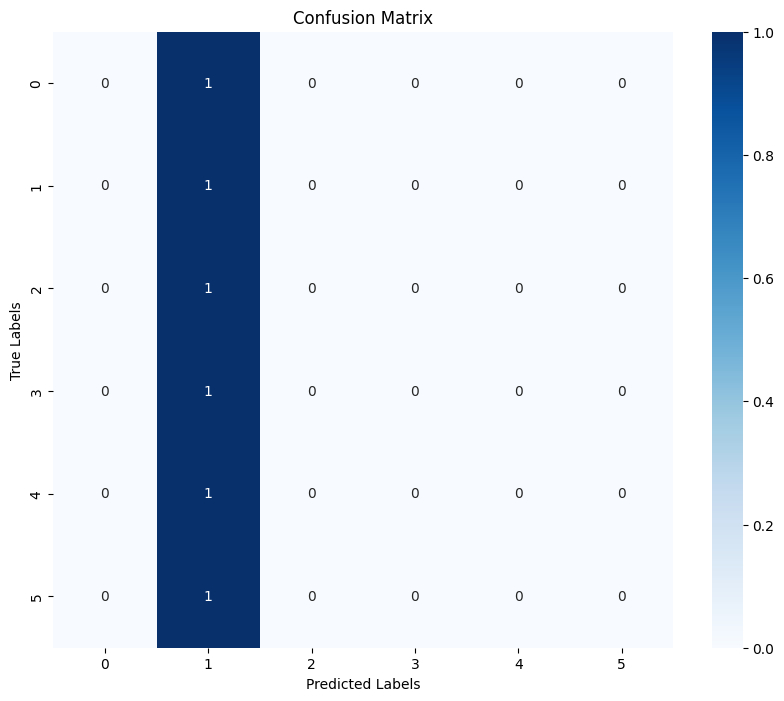

Epoch 4, Validation Loss: 1.8613, Accuracy: 0.2201, F1 Score: 0.0794
Val F1 Score Per Class  [0.         0.36079545 0.         0.         0.         0.        ]


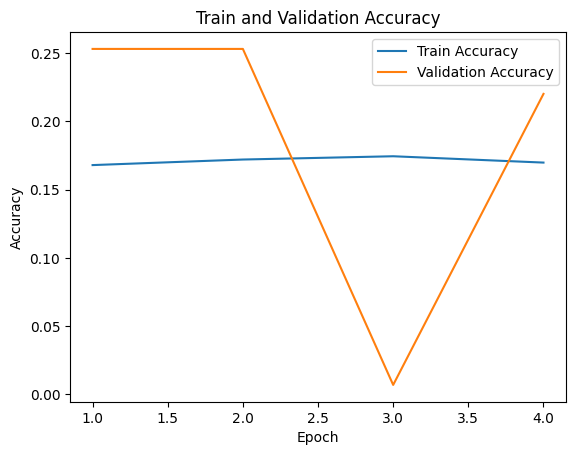

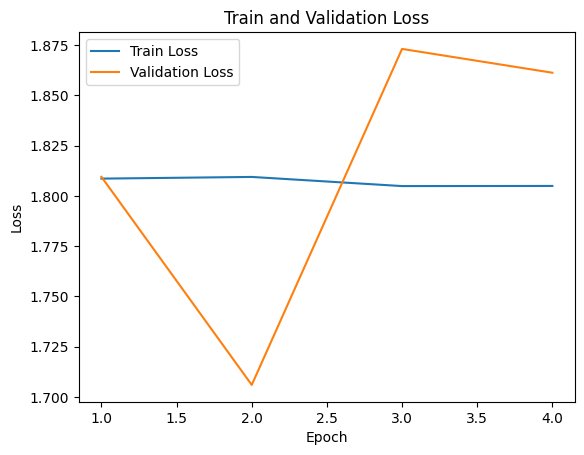

Epoch 5, Train Loss: 1.8089, Accuracy: 0.1686, F1 Score: 0.1595
Train F1 Score Per Class  [0.13388381 0.14415406 0.17211626 0.24146341 0.12149533 0.13377557]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.44it/s, loss=1.7]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.43it/s, loss=1.74]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0588,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0684,  0.2019, -0.0188, -0.4072], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.8]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.69]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0189, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=1.83]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0189, -0.4070], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.39it/s, loss=1.72]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0190, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2018, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0684,  0.2019, -0.0188, -0.4072], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=1.76]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=1.66]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=1.69]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0129,  0.0587,  0.0684,  0.2020, -0.0189, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=1.79]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4073], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=1.79]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4073], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2020, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=1.66]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0588,  0.0685,  0.2018, -0.0188, -0.4074], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0684,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.73]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2019, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.66]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=1.84]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0684,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=1.74]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=1.7]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=1.74]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.68]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=1.71]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2018, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.39it/s, loss=1.77]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=1.74]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0190, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=1.69]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4073], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=1.73]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2021, -0.0189, -0.4073], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0190, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.40it/s, loss=1.76]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0684,  0.2019, -0.0189, -0.4074], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.73]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4070], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=1.75]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0130,  0.0587,  0.0683,  0.2022, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0188, -0.4071], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.40it/s, loss=1.68]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.39it/s, loss=1.77]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2020, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0684,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.39it/s, loss=1.72]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=1.75]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=1.74]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0125,  0.0587,  0.0683,  0.2017, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2019, -0.0190, -0.4074], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=1.71]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0588,  0.0684,  0.2018, -0.0188, -0.4073], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.40it/s, loss=1.68]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=1.75]

[tensor([ 0.0127,  0.0586,  0.0682,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0125,  0.0587,  0.0683,  0.2017, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0187, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0190, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0187, -0.4072], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.38it/s, loss=1.68]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2017, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=1.72]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2019, -0.0190, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4073], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.73]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0682,  0.2020, -0.0189, -0.4070], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=1.79]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0684,  0.2019, -0.0189, -0.4074], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=1.75]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=1.71]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0190, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=1.63]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0588,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.38it/s, loss=1.72]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=1.7]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0682,  0.2021, -0.0190, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=1.66]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.39it/s, loss=1.73]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=1.66]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=1.72]

[tensor([ 0.0127,  0.0586,  0.0682,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.39it/s, loss=1.76]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2018, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=1.68]

[tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4073], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0585,  0.0683,  0.2020, -0.0190, -0.4072], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=1.68]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0190, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.39it/s, loss=1.73]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.79]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4073], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.39it/s, loss=1.72]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2017, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2017, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.40it/s, loss=1.71]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4073], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.39it/s, loss=1.69]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0187, -0.4073], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=1.68]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2020, -0.0189, -0.4070], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=1.77]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.40it/s, loss=1.79]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.39it/s, loss=1.78]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=1.71]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0588,  0.0684,  0.2017, -0.0187, -0.4071], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.39it/s, loss=1.74]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0190, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.39it/s, loss=1.67]

[tensor([ 0.0128,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.39it/s, loss=1.71]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4073], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.40it/s, loss=1.72]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2020, -0.0188, -0.4072], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.39it/s, loss=1.73]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0682,  0.2019, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0125,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.39it/s, loss=1.74]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0190, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.40it/s, loss=1.76]

[tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.40it/s, loss=1.75]

[tensor([ 0.0127,  0.0587,  0.0684,  0.2019, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0682,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.40it/s, loss=1.66]

[tensor([ 0.0127,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0188, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4070], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.39it/s, loss=1.67]

[tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2018, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0189, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0187, -0.4073], device='cuda:0'), tensor([ 0.0127,  0.0587,  0.0683,  0.2020, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0684,  0.2018, -0.0188, -0.4073], device='cuda:0')]


[tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0189, -0.4072], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0187, -0.4070], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2019, -0.0188, -0.4070], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0'), tensor([ 0.0126,  0.0587,  0.0683,  0.2018, -0.0188, -0.4072], device='cuda:0'), tensor([ 0.0126,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0'), tensor([ 0.0127,  0.0586,  0.0683,  0.2019, -0.0189, -0.4071], device='cuda:0')]
[tensor([ 0.0127,  0.0587,  0.0683,  0.2019, -0.0188, -0.4071], device='cuda:0')]


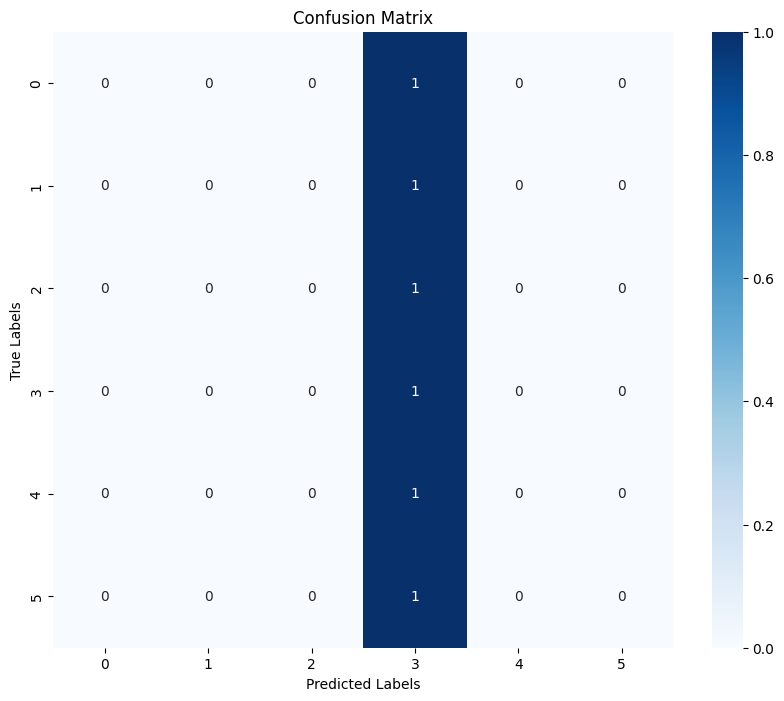

Epoch 5, Validation Loss: 1.7268, Accuracy: 0.3050, F1 Score: 0.1426
Val F1 Score Per Class  [0.         0.         0.         0.46746348 0.         0.        ]


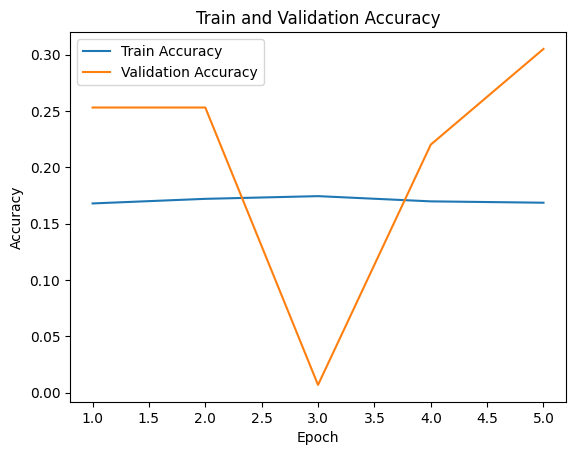

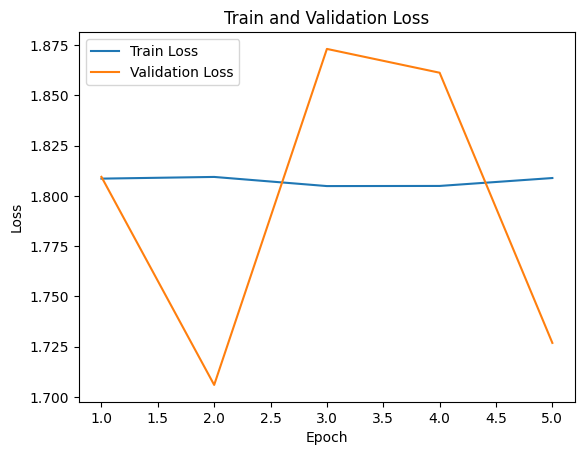

Epoch 6, Train Loss: 1.8019, Accuracy: 0.1706, F1 Score: 0.1511
Train F1 Score Per Class  [0.12511789 0.18946474 0.11532889 0.25465434 0.11214953 0.09559835]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.48it/s, loss=1.82]

[tensor([-0.0977, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.46it/s, loss=1.86]

[tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1421, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3755,  0.0701, -0.0703], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=1.94]

[tensor([-0.0977, -0.1420, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.42it/s, loss=1.75]

[tensor([-0.0980, -0.1422, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0984, -0.1424, -0.1767,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1422, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.42it/s, loss=1.86]

[tensor([-0.0977, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1767,  0.3759,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.41it/s, loss=1.68]

[tensor([-0.0978, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.41it/s, loss=1.82]

[tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3754,  0.0701, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1423, -0.1767,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1423, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.40it/s, loss=1.7]

[tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0976, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=1.83]

[tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0982, -0.1422, -0.1766,  0.3762,  0.0705, -0.0701], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1765,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=1.86]

[tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0981, -0.1423, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=1.85]

[tensor([-0.0979, -0.1421, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3759,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1423, -0.1767,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=1.7]

[tensor([-0.0979, -0.1420, -0.1764,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1421, -0.1766,  0.3759,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1767,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.68]

[tensor([-0.0981, -0.1421, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0984, -0.1423, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.40it/s, loss=1.7]

[tensor([-0.0980, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1423, -0.1767,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=1.86]

[tensor([-0.0980, -0.1422, -0.1767,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1767,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1422, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1419, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.40it/s, loss=1.75]

[tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1423, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=1.74]

[tensor([-0.0981, -0.1422, -0.1766,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1422, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1767,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1764,  0.3755,  0.0701, -0.0702], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.41it/s, loss=1.75]

[tensor([-0.0978, -0.1420, -0.1764,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1423, -0.1767,  0.3761,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1763,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.40it/s, loss=1.68]

[tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=1.81]

[tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1422, -0.1767,  0.3761,  0.0704, -0.0701], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0703], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.36it/s, loss=1.8]

[tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0983, -0.1423, -0.1767,  0.3760,  0.0704, -0.0702], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.35it/s, loss=1.95]

[tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1764,  0.3755,  0.0701, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.36it/s, loss=1.75]

[tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1422, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.37it/s, loss=1.87]

[tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1421, -0.1765,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0975, -0.1418, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1420, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1763,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1763,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=1.71]

[tensor([-0.0982, -0.1422, -0.1766,  0.3759,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1423, -0.1767,  0.3760,  0.0704, -0.0702], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.67]

[tensor([-0.0980, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1763,  0.3753,  0.0701, -0.0703], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.40it/s, loss=1.82]

[tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1767,  0.3760,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0975, -0.1418, -0.1765,  0.3758,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1420, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.41it/s, loss=1.76]

[tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1767,  0.3762,  0.0705, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.34it/s, loss=1.8]

[tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0976, -0.1418, -0.1763,  0.3754,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.35it/s, loss=1.89]

[tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1767,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.35it/s, loss=1.82]

[tensor([-0.0979, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.36it/s, loss=1.95]

[tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1763,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=1.82]

[tensor([-0.0979, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0976, -0.1419, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0983, -0.1423, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.33it/s, loss=1.76]

[tensor([-0.0981, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.36it/s, loss=1.74]

[tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1422, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.36it/s, loss=1.66]

[tensor([-0.0979, -0.1421, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=1.8]

[tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0976, -0.1419, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0976, -0.1418, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.88]

[tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0975, -0.1418, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=1.85]

[tensor([-0.0981, -0.1421, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3758,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=1.94]

[tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1419, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.38it/s, loss=1.82]

[tensor([-0.0980, -0.1421, -0.1766,  0.3759,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3754,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1764,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1422, -0.1767,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=1.57]

[tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.34it/s, loss=1.68]

[tensor([-0.0980, -0.1421, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.32it/s, loss=1.83]

[tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3753,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.35it/s, loss=1.61]

[tensor([-0.0977, -0.1418, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3757,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.33it/s, loss=1.68]

[tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.35it/s, loss=1.69]

[tensor([-0.0981, -0.1422, -0.1766,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0976, -0.1418, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.35it/s, loss=1.8]

[tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1767,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.35it/s, loss=1.81]

[tensor([-0.0979, -0.1422, -0.1767,  0.3759,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1421, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0981, -0.1423, -0.1768,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0703, -0.0702], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=1.77]

[tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1420, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1418, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=1.77]

[tensor([-0.0979, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1423, -0.1767,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:09,  2.28it/s, loss=1.68]

[tensor([-0.0980, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3761,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.33it/s, loss=1.95]

[tensor([-0.0978, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1767,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.34it/s, loss=1.68]

[tensor([-0.0979, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3758,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3758,  0.0702, -0.0702], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.36it/s, loss=1.81]

[tensor([-0.0980, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=1.84]

[tensor([-0.0980, -0.1422, -0.1766,  0.3760,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1767,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0983, -0.1422, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0976, -0.1417, -0.1763,  0.3754,  0.0702, -0.0703], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=1.76]

[tensor([-0.0976, -0.1418, -0.1763,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3759,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=1.8]

[tensor([-0.0977, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0975, -0.1417, -0.1763,  0.3753,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0982, -0.1422, -0.1765,  0.3755,  0.0701, -0.0702], device='cuda:0'), tensor([-0.0976, -0.1417, -0.1764,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=1.87]

[tensor([-0.0981, -0.1422, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3759,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3754,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=1.88]

[tensor([-0.0979, -0.1421, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0984, -0.1424, -0.1767,  0.3762,  0.0705, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1423, -0.1768,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3759,  0.0704, -0.0702], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.33it/s, loss=1.81]

[tensor([-0.0979, -0.1420, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.36it/s, loss=1.96]

[tensor([-0.0982, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.34it/s, loss=1.69]

[tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1763,  0.3753,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3760,  0.0703, -0.0701], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=1.81]

[tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3760,  0.0704, -0.0702], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.69]

[tensor([-0.0982, -0.1422, -0.1766,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3757,  0.0702, -0.0703], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.35it/s, loss=1.68]

[tensor([-0.0979, -0.1420, -0.1765,  0.3754,  0.0701, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3756,  0.0703, -0.0703], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1422, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=1.76]

[tensor([-0.0977, -0.1418, -0.1763,  0.3754,  0.0701, -0.0703], device='cuda:0'), tensor([-0.0982, -0.1422, -0.1766,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=1.81]

[tensor([-0.0979, -0.1421, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1764,  0.3754,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1422, -0.1767,  0.3757,  0.0703, -0.0702], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.36it/s, loss=1.82]

[tensor([-0.0980, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1420, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1420, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3755,  0.0701, -0.0702], device='cuda:0'), tensor([-0.0983, -0.1423, -0.1767,  0.3757,  0.0703, -0.0703], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.38it/s, loss=1.7]

[tensor([-0.0976, -0.1419, -0.1764,  0.3757,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1419, -0.1764,  0.3755,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1418, -0.1763,  0.3756,  0.0702, -0.0702], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.37it/s, loss=1.68]

[tensor([-0.0979, -0.1420, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1421, -0.1766,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1766,  0.3757,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1418, -0.1763,  0.3754,  0.0701, -0.0702], device='cuda:0'), tensor([-0.0978, -0.1420, -0.1765,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1765,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0978, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0')]


[tensor([-0.0981, -0.1422, -0.1767,  0.3756,  0.0702, -0.0703], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1766,  0.3758,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3757,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0980, -0.1420, -0.1764,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1421, -0.1765,  0.3755,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0981, -0.1422, -0.1767,  0.3759,  0.0703, -0.0702], device='cuda:0'), tensor([-0.0977, -0.1419, -0.1764,  0.3756,  0.0702, -0.0702], device='cuda:0'), tensor([-0.0979, -0.1421, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]
[tensor([-0.0979, -0.1420, -0.1765,  0.3756,  0.0702, -0.0702], device='cuda:0')]


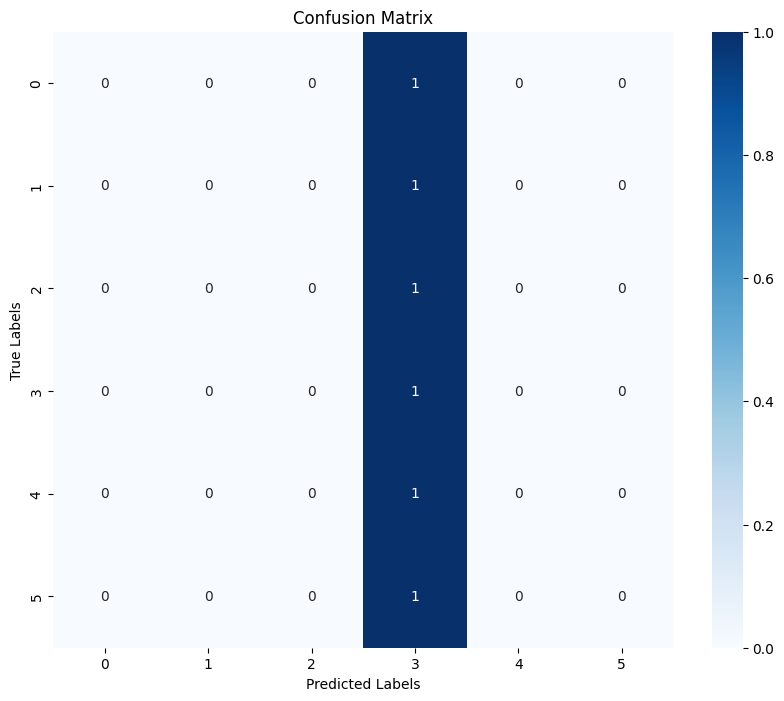

Epoch 6, Validation Loss: 1.7860, Accuracy: 0.3050, F1 Score: 0.1426
Val F1 Score Per Class  [0.         0.         0.         0.46746348 0.         0.        ]


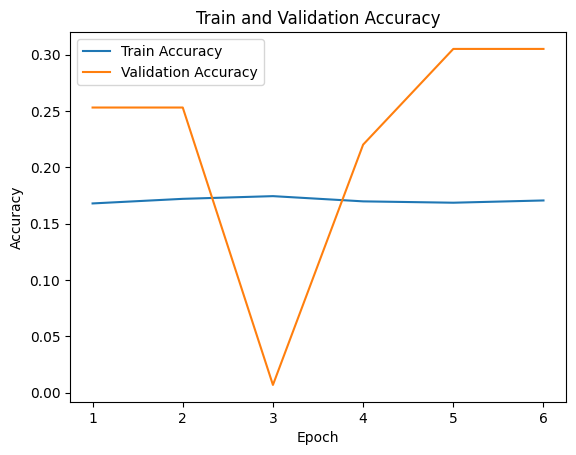

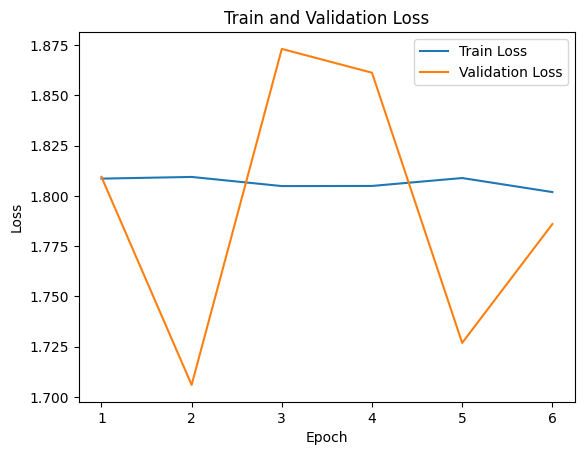

Epoch 7, Train Loss: 1.8012, Accuracy: 0.1691, F1 Score: 0.1533
Train F1 Score Per Class  [0.12948793 0.1864444  0.14622389 0.24452604 0.10723514 0.09266943]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.46it/s, loss=1.78]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.41it/s, loss=1.91]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=1.88]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.73]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.40it/s, loss=1.64]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.39it/s, loss=1.74]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=1.73]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.40it/s, loss=1.76]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=1.79]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=1.89]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=1.76]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.8]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.40it/s, loss=1.76]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=1.81]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.38it/s, loss=1.85]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=1.93]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.38it/s, loss=1.75]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=1.91]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.40it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.41it/s, loss=1.77]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.41it/s, loss=1.8]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=1.85]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.40it/s, loss=1.86]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.40it/s, loss=1.83]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.40it/s, loss=1.8]

[tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.40it/s, loss=1.74]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:19,  2.29it/s, loss=1.88]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.33it/s, loss=1.89]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:18,  2.32it/s, loss=1.8]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.36it/s, loss=1.83]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=1.88]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.32it/s, loss=1.77]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.35it/s, loss=1.84]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2993,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.35it/s, loss=1.81]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.36it/s, loss=1.83]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.86]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=1.83]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=1.9]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.40it/s, loss=1.88]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.40it/s, loss=1.81]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.40it/s, loss=1.74]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=1.75]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.40it/s, loss=1.84]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=1.84]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.39it/s, loss=1.69]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.39it/s, loss=1.97]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.40it/s, loss=1.83]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.40it/s, loss=1.81]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=1.81]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.39it/s, loss=1.8]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.40it/s, loss=1.7]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.40it/s, loss=1.84]

[tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.41it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.41it/s, loss=1.7]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.41it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.41it/s, loss=1.8]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.40it/s, loss=1.77]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=1.84]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.39it/s, loss=1.91]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.39it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.41it/s, loss=1.91]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.40it/s, loss=1.81]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.41it/s, loss=1.8]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.41it/s, loss=1.82]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.41it/s, loss=1.79]

[tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.38it/s, loss=1.76]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.36it/s, loss=1.8]

[tensor([-0.2991,  0.2175, -0.0770,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.37it/s, loss=1.75]

[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0')]


[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0771,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2175, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2991,  0.2175, -0.0771,  0.0305,  0.0556,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0'), tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]
[tensor([-0.2992,  0.2176, -0.0770,  0.0305,  0.0557,  0.1073], device='cuda:0')]


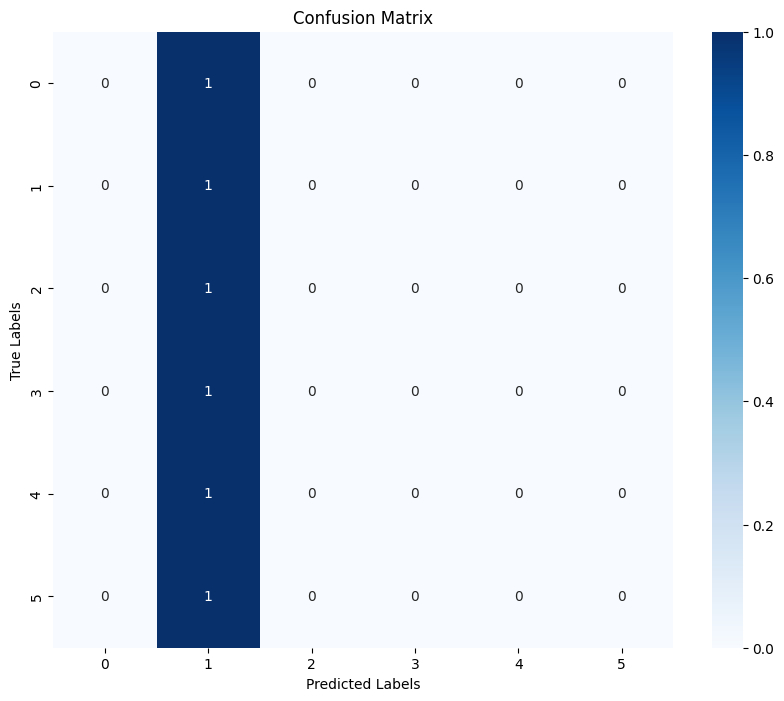

Epoch 7, Validation Loss: 1.8078, Accuracy: 0.2201, F1 Score: 0.0794
Val F1 Score Per Class  [0.         0.36079545 0.         0.         0.         0.        ]


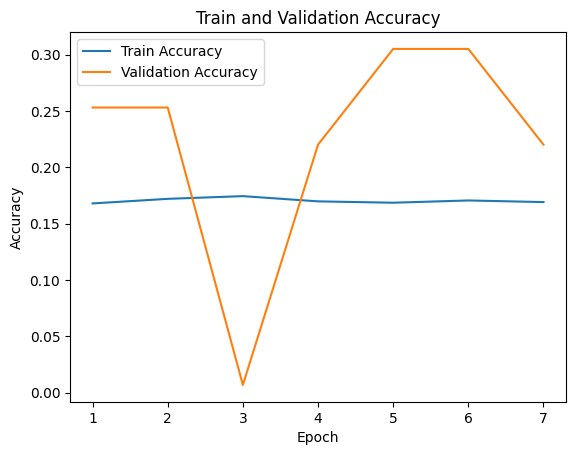

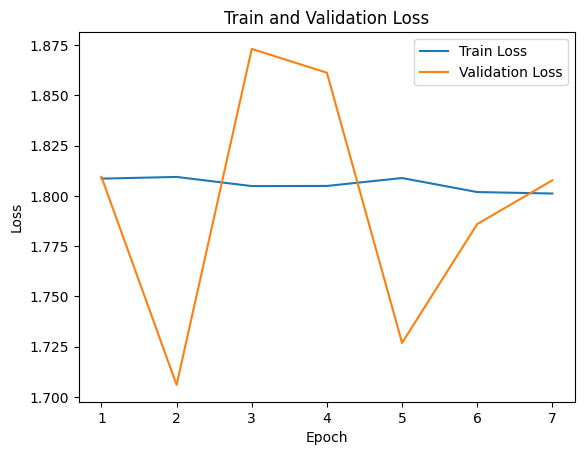

Epoch 8, Train Loss: 1.8011, Accuracy: 0.1699, F1 Score: 0.1546
Train F1 Score Per Class  [0.07770961 0.19496722 0.16117216 0.24658331 0.11504975 0.11823899]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.46it/s, loss=1.71]

[tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.46it/s, loss=1.72]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.41it/s, loss=1.69]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.43it/s, loss=1.76]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.42it/s, loss=1.8]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0867,  0.2018, -0.0345, -0.1451, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.42it/s, loss=1.79]

[tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2018, -0.0345, -0.1450, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.42it/s, loss=1.75]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.41it/s, loss=1.74]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.41it/s, loss=1.68]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0863,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0634,  0.0868,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.41it/s, loss=1.77]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0863,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.41it/s, loss=1.75]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:25,  2.41it/s, loss=1.74]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.40it/s, loss=1.79]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.41it/s, loss=1.74]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.41it/s, loss=1.79]

[tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.40it/s, loss=1.75]

[tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=1.74]

[tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.40it/s, loss=1.76]

[tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.40it/s, loss=1.78]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=1.72]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.40it/s, loss=1.77]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=1.67]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=1.73]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1451, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.39it/s, loss=1.72]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.40it/s, loss=1.81]

[tensor([ 0.0631,  0.0864,  0.2020, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2018, -0.0345, -0.1450, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.81]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.40it/s, loss=1.72]

[tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0634,  0.0868,  0.2018, -0.0345, -0.1451, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.41it/s, loss=1.73]

[tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.40it/s, loss=1.77]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.40it/s, loss=1.67]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.40it/s, loss=1.72]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=1.67]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0867,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=1.7]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=1.71]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=1.78]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.38it/s, loss=1.79]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=1.75]

[tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.37it/s, loss=1.69]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2020, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=1.75]

[tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=1.68]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=1.7]

[tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=1.77]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.40it/s, loss=1.79]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=1.7]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1451, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=1.79]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.39it/s, loss=1.78]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.39it/s, loss=1.77]

[tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=1.72]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0863,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.39it/s, loss=1.74]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=1.7]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=1.7]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.39it/s, loss=1.79]

[tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.69]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=1.81]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.39it/s, loss=1.72]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.39it/s, loss=1.67]

[tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0863,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=1.74]

[tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=1.77]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0863,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=1.75]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2020, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=1.74]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.35it/s, loss=1.72]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.37it/s, loss=1.64]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.36it/s, loss=1.75]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=1.72]

[tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.76]

[tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=1.79]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=1.73]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2018, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.38it/s, loss=1.75]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2019, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.37it/s, loss=1.73]

[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.38it/s, loss=1.73]

[tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=1.77]

[tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0866,  0.2018, -0.0345, -0.1449, -0.1966], device='cuda:0')]


[tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1447, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0631,  0.0864,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0864,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0'), tensor([ 0.0633,  0.0866,  0.2018, -0.0345, -0.1450, -0.1966], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1967], device='cuda:0'), tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1448, -0.1966], device='cuda:0')]
[tensor([ 0.0632,  0.0865,  0.2019, -0.0345, -0.1449, -0.1967], device='cuda:0')]


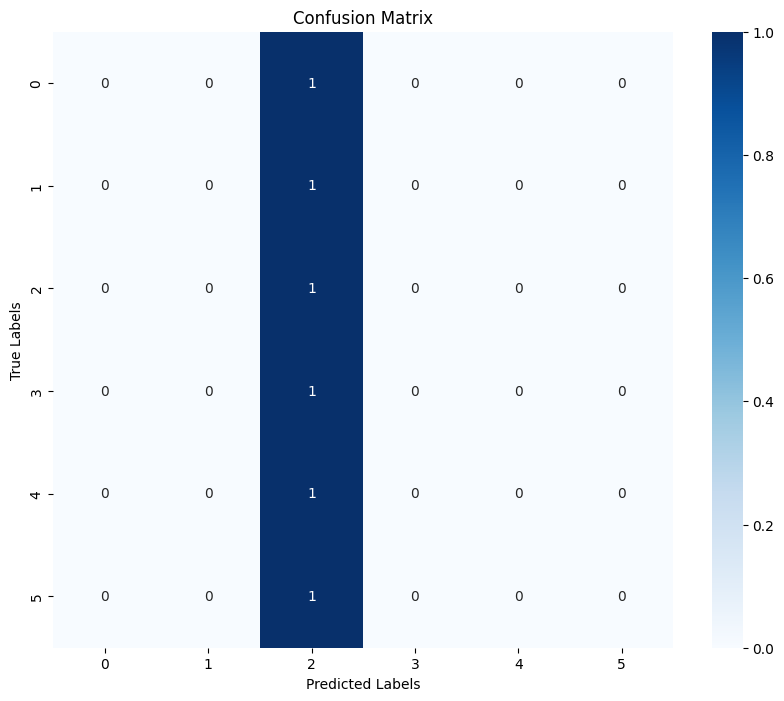

Epoch 8, Validation Loss: 1.7412, Accuracy: 0.2530, F1 Score: 0.1022
Val F1 Score Per Class  [0.         0.         0.40387275 0.         0.         0.        ]


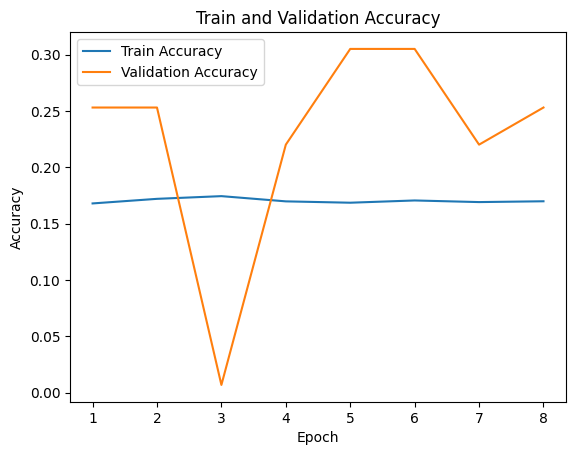

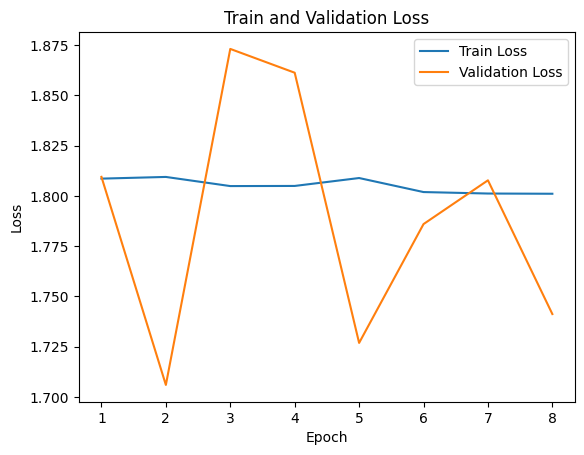

Epoch 9, Train Loss: 1.7994, Accuracy: 0.1746, F1 Score: 0.1578
Train F1 Score Per Class  [0.09480519 0.16637078 0.15997969 0.26047983 0.12826603 0.12319538]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.41it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=1.83]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1160,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=1.81]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0553, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.74]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0047,  0.0552, -0.1164,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=1.7]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0046,  0.0553, -0.1159,  0.0851], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=1.73]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=1.73]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1166,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=1.74]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0855], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=1.76]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1164,  0.0854], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=1.79]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1163,  0.0857], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=1.83]

[tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=1.74]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0047,  0.0552, -0.1164,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0857], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1164,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.38it/s, loss=1.74]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0852], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0852], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1166,  0.0859], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=1.77]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=1.78]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0853], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=1.82]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=1.74]

[tensor([-0.1360,  0.0960, -0.0047,  0.0553, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.78]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=1.82]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=1.78]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1164,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=1.76]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=1.77]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=1.8]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0553, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=1.81]

[tensor([-0.1360,  0.0960, -0.0047,  0.0553, -0.1160,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.78]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=1.76]

[tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1164,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0853], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.38it/s, loss=1.74]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1166,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1160,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0856], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=1.81]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=1.81]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.38it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=1.79]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1166,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=1.8]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.38it/s, loss=1.75]

[tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=1.78]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1164,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.38it/s, loss=1.79]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=1.79]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0852], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.37it/s, loss=1.8]

[tensor([-0.1359,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1166,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=1.8]

[tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0852], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0859], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1165,  0.0857], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.36it/s, loss=1.82]

[tensor([-0.1360,  0.0960, -0.0047,  0.0553, -0.1160,  0.0852], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0859], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=1.8]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.36it/s, loss=1.75]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0046,  0.0553, -0.1159,  0.0851], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=1.73]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0853], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.32it/s, loss=1.74]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0048,  0.0552, -0.1165,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.36it/s, loss=1.78]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.34it/s, loss=1.77]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1166,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1160,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.36it/s, loss=1.72]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.36it/s, loss=1.85]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=1.77]

[tensor([-0.1359,  0.0961, -0.0048,  0.0552, -0.1166,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.38it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0859], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0048,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0852], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.78]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0855], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.72]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0047,  0.0552, -0.1164,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=1.79]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1160,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0852], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0851], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0859], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=1.77]

[tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.38it/s, loss=1.72]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.38it/s, loss=1.78]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=1.77]

[tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=1.76]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1164,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0852], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=1.79]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1166,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.38it/s, loss=1.82]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.36it/s, loss=1.77]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1161,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.35it/s, loss=1.82]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1163,  0.0857], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.35it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1164,  0.0852], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1164,  0.0857], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:03,  2.33it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1160,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.27it/s, loss=1.76]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1164,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0853], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.32it/s, loss=1.76]

[tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1359,  0.0962, -0.0048,  0.0552, -0.1165,  0.0858], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.31it/s, loss=1.75]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1359,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.34it/s, loss=1.75]

[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1160,  0.0853], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.34it/s, loss=1.75]

[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0553, -0.1161,  0.0853], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0048,  0.0552, -0.1165,  0.0857], device='cuda:0')]


[tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1161,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1162,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0'), tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1164,  0.0856], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1162,  0.0854], device='cuda:0'), tensor([-0.1360,  0.0960, -0.0047,  0.0552, -0.1163,  0.0854], device='cuda:0')]
[tensor([-0.1360,  0.0961, -0.0047,  0.0552, -0.1163,  0.0855], device='cuda:0')]


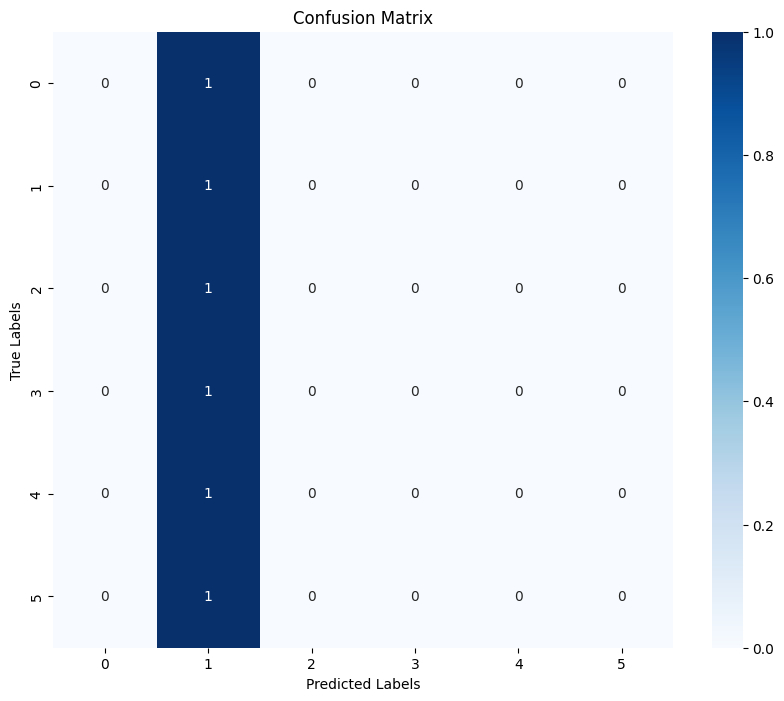

Epoch 9, Validation Loss: 1.7708, Accuracy: 0.2201, F1 Score: 0.0794
Val F1 Score Per Class  [0.         0.36079545 0.         0.         0.         0.        ]


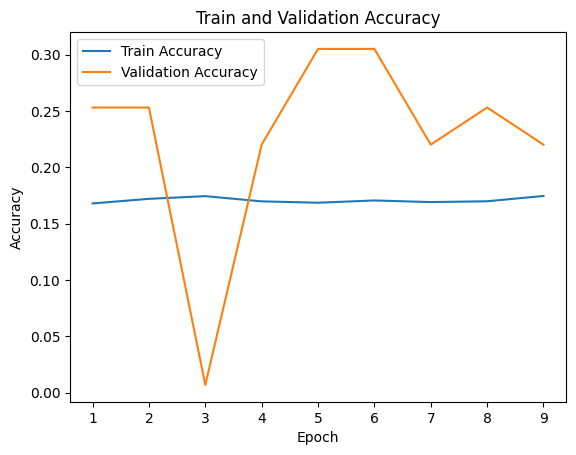

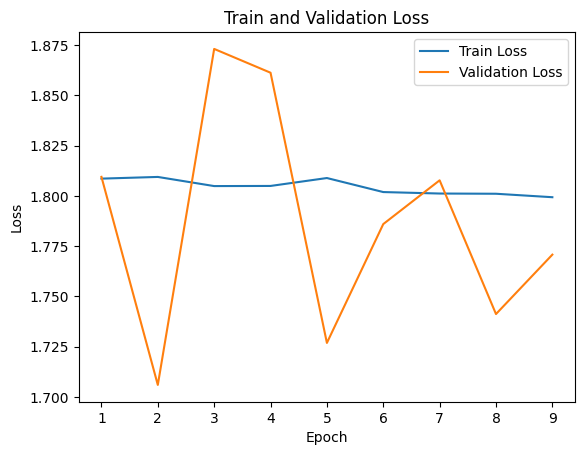

Epoch 10, Train Loss: 1.7978, Accuracy: 0.1702, F1 Score: 0.1355
Train F1 Score Per Class  [0.11975309 0.1459893  0.14016018 0.26975651 0.06283119 0.05647059]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=1.75]

[tensor([-0.0460,  0.0194,  0.0487,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0474,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0485,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0481,  0.1281, -0.0969, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.44it/s, loss=1.79]

[tensor([-0.0456,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1283, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0951, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0487,  0.1283, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0485,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0485,  0.1283, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=1.79]

[tensor([-0.0462,  0.0194,  0.0484,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0488,  0.1283, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0486,  0.1283, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0475,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0485,  0.1282, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0485,  0.1283, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.74]

[tensor([-0.0461,  0.0194,  0.0485,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1284, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0449,  0.0194,  0.0482,  0.1282, -0.0967, -0.0667], device='cuda:0'), tensor([-0.0449,  0.0194,  0.0482,  0.1281, -0.0967, -0.0666], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0485,  0.1282, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=1.78]

[tensor([-0.0472,  0.0194,  0.0485,  0.1282, -0.0958, -0.0668], device='cuda:0'), tensor([-0.0451,  0.0194,  0.0484,  0.1284, -0.0963, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0488,  0.1283, -0.0951, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1282, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.40it/s, loss=1.73]

[tensor([-0.0465,  0.0194,  0.0487,  0.1283, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0450,  0.0194,  0.0483,  0.1282, -0.0966, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0486,  0.1283, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0447,  0.0194,  0.0481,  0.1281, -0.0968, -0.0666], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0949, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0486,  0.1282, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0482,  0.1282, -0.0968, -0.0667], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=1.75]

[tensor([-0.0465,  0.0194,  0.0488,  0.1283, -0.0951, -0.0667], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0484,  0.1282, -0.0963, -0.0666], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0486,  0.1283, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1284, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0484,  0.1283, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.41it/s, loss=1.71]

[tensor([-0.0461,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0485,  0.1282, -0.0962, -0.0667], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0484,  0.1282, -0.0962, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0487,  0.1283, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0484,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=1.73]

[tensor([-0.0468,  0.0194,  0.0485,  0.1282, -0.0959, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1284, -0.0957, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1282, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.40it/s, loss=1.79]

[tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0950, -0.0667], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0486,  0.1283, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0481,  0.1282, -0.0969, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0486,  0.1283, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0485,  0.1281, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0484,  0.1281, -0.0961, -0.0667], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.40it/s, loss=1.79]

[tensor([-0.0452,  0.0194,  0.0480,  0.1281, -0.0971, -0.0666], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0484,  0.1282, -0.0962, -0.0666], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0483,  0.1282, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0449,  0.0194,  0.0479,  0.1280, -0.0973, -0.0666], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0487,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:25,  2.40it/s, loss=1.71]

[tensor([-0.0467,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0446,  0.0194,  0.0482,  0.1281, -0.0966, -0.0665], device='cuda:0'), tensor([-0.0449,  0.0194,  0.0481,  0.1281, -0.0969, -0.0666], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0486,  0.1283, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0485,  0.1282, -0.0959, -0.0668], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0483,  0.1281, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.73]

[tensor([-0.0458,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0483,  0.1282, -0.0965, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0489,  0.1284, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0490,  0.1283, -0.0946, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0483,  0.1281, -0.0965, -0.0668], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0483,  0.1282, -0.0966, -0.0667], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.71]

[tensor([-0.0468,  0.0194,  0.0487,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1283, -0.0957, -0.0668], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0483,  0.1282, -0.0965, -0.0666], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0483,  0.1281, -0.0963, -0.0666], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=1.79]

[tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1284, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0485,  0.1281, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=1.74]

[tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0486,  0.1282, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1284, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1283, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0484,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0486,  0.1283, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0486,  0.1283, -0.0956, -0.0668], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=1.75]

[tensor([-0.0469,  0.0194,  0.0489,  0.1284, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0485,  0.1282, -0.0959, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0485,  0.1282, -0.0959, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0484,  0.1281, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0484,  0.1282, -0.0961, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1282, -0.0952, -0.0668], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.39it/s, loss=1.74]

[tensor([-0.0476,  0.0194,  0.0490,  0.1283, -0.0945, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1283, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0475,  0.0194,  0.0490,  0.1283, -0.0946, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1282, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.74]

[tensor([-0.0462,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0482,  0.1282, -0.0966, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0487,  0.1282, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0475,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0949, -0.0668], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=1.76]

[tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1282, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0484,  0.1282, -0.0962, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0484,  0.1282, -0.0963, -0.0666], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.39it/s, loss=1.77]

[tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0490,  0.1284, -0.0945, -0.0668], device='cuda:0'), tensor([-0.0449,  0.0195,  0.0482,  0.1281, -0.0967, -0.0666], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0489,  0.1283, -0.0946, -0.0668], device='cuda:0'), tensor([-0.0476,  0.0194,  0.0488,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0487,  0.1283, -0.0955, -0.0668], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=1.77]

[tensor([-0.0462,  0.0194,  0.0487,  0.1283, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1284, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0483,  0.1281, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0950, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=1.73]

[tensor([-0.0462,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0485,  0.1283, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0448,  0.0194,  0.0482,  0.1282, -0.0966, -0.0666], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0483,  0.1281, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0480,  0.1281, -0.0971, -0.0667], device='cuda:0'), tensor([-0.0450,  0.0195,  0.0482,  0.1281, -0.0966, -0.0666], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=1.78]

[tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0484,  0.1282, -0.0962, -0.0667], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0483,  0.1282, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0482,  0.1282, -0.0967, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1284, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=1.77]

[tensor([-0.0476,  0.0194,  0.0489,  0.1283, -0.0946, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0486,  0.1283, -0.0958, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0484,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1282, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0487,  0.1284, -0.0955, -0.0668], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.75]

[tensor([-0.0456,  0.0194,  0.0485,  0.1282, -0.0960, -0.0666], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0450,  0.0194,  0.0482,  0.1282, -0.0969, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0483,  0.1281, -0.0963, -0.0666], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0484,  0.1281, -0.0962, -0.0666], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=1.74]

[tensor([-0.0463,  0.0194,  0.0484,  0.1282, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0483,  0.1281, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0487,  0.1285, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0474,  0.0194,  0.0490,  0.1283, -0.0946, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0486,  0.1282, -0.0957, -0.0668], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=1.73]

[tensor([-0.0464,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0483,  0.1282, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0486,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0486,  0.1283, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.39it/s, loss=1.78]

[tensor([-0.0469,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1282, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0947, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0486,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0486,  0.1283, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0947, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.39it/s, loss=1.76]

[tensor([-0.0463,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0490,  0.1283, -0.0947, -0.0668], device='cuda:0'), tensor([-0.0450,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0484,  0.1282, -0.0964, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0485,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0488,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=1.74]

[tensor([-0.0459,  0.0194,  0.0482,  0.1281, -0.0966, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0483,  0.1281, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0483,  0.1281, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0484,  0.1282, -0.0962, -0.0667], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=1.78]

[tensor([-0.0469,  0.0194,  0.0487,  0.1282, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0449,  0.0194,  0.0482,  0.1284, -0.0969, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0455,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.40it/s, loss=1.75]

[tensor([-0.0466,  0.0194,  0.0488,  0.1282, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0483,  0.1282, -0.0964, -0.0666], device='cuda:0'), tensor([-0.0448,  0.0194,  0.0482,  0.1282, -0.0967, -0.0666], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0486,  0.1283, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0486,  0.1282, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.39it/s, loss=1.72]

[tensor([-0.0452,  0.0194,  0.0483,  0.1282, -0.0965, -0.0666], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0484,  0.1281, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0484,  0.1281, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0488,  0.1282, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0487,  0.1282, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0448,  0.0194,  0.0482,  0.1281, -0.0967, -0.0666], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=1.76]

[tensor([-0.0463,  0.0194,  0.0484,  0.1282, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0485,  0.1281, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0487,  0.1283, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0448,  0.0194,  0.0482,  0.1282, -0.0964, -0.0666], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0484,  0.1282, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0449,  0.0195,  0.0483,  0.1281, -0.0963, -0.0666], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=1.74]

[tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0483,  0.1281, -0.0962, -0.0667], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.39it/s, loss=1.77]

[tensor([-0.0455,  0.0194,  0.0483,  0.1282, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0950, -0.0667], device='cuda:0'), tensor([-0.0450,  0.0194,  0.0482,  0.1281, -0.0965, -0.0666], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.39it/s, loss=1.76]

[tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0487,  0.1283, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0485,  0.1283, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0455,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0474,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=1.78]

[tensor([-0.0457,  0.0194,  0.0485,  0.1283, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0486,  0.1283, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0444,  0.0194,  0.0480,  0.1281, -0.0970, -0.0667], device='cuda:0'), tensor([-0.0449,  0.0194,  0.0480,  0.1281, -0.0971, -0.0666], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0485,  0.1281, -0.0957, -0.0667], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=1.79]

[tensor([-0.0471,  0.0194,  0.0486,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0444,  0.0194,  0.0482,  0.1281, -0.0966, -0.0666], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1284, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0486,  0.1282, -0.0955, -0.0668], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=1.75]

[tensor([-0.0459,  0.0194,  0.0485,  0.1282, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1284, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0947, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0484,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0486,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0486,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=1.68]

[tensor([-0.0457,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0485,  0.1282, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0487,  0.1282, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0446,  0.0195,  0.0482,  0.1281, -0.0964, -0.0666], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0490,  0.1283, -0.0946, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.38it/s, loss=1.73]

[tensor([-0.0459,  0.0194,  0.0486,  0.1283, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0486,  0.1282, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0474,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0486,  0.1282, -0.0957, -0.0668], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=1.73]

[tensor([-0.0465,  0.0194,  0.0486,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0486,  0.1283, -0.0958, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1284, -0.0959, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0951, -0.0667], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=1.72]

[tensor([-0.0460,  0.0194,  0.0485,  0.1283, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0482,  0.1281, -0.0966, -0.0667], device='cuda:0'), tensor([-0.0450,  0.0194,  0.0484,  0.1282, -0.0963, -0.0666], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0487,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0483,  0.1281, -0.0965, -0.0666], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1282, -0.0952, -0.0667], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=1.73]

[tensor([-0.0469,  0.0194,  0.0485,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0482,  0.1281, -0.0966, -0.0666], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0486,  0.1282, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0455,  0.0194,  0.0485,  0.1282, -0.0960, -0.0666], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=1.72]

[tensor([-0.0457,  0.0194,  0.0484,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0455,  0.0194,  0.0482,  0.1281, -0.0967, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1284, -0.0957, -0.0668], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0487,  0.1283, -0.0955, -0.0667], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.39it/s, loss=1.77]

[tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0486,  0.1283, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1282, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0483,  0.1281, -0.0963, -0.0666], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0483,  0.1281, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1283, -0.0956, -0.0667], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=1.75]

[tensor([-0.0462,  0.0194,  0.0483,  0.1282, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0450,  0.0194,  0.0482,  0.1281, -0.0966, -0.0666], device='cuda:0'), tensor([-0.0451,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0453,  0.0194,  0.0483,  0.1281, -0.0964, -0.0666], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0487,  0.1283, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0488,  0.1284, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0955, -0.0668], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=1.72]

[tensor([-0.0455,  0.0194,  0.0485,  0.1282, -0.0960, -0.0666], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0484,  0.1282, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0455,  0.0194,  0.0485,  0.1282, -0.0959, -0.0666], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0485,  0.1282, -0.0958, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0486,  0.1283, -0.0958, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0486,  0.1283, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0447,  0.0194,  0.0482,  0.1282, -0.0967, -0.0666], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=1.72]

[tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0473,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0483,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1283, -0.0955, -0.0667], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.39it/s, loss=1.73]

[tensor([-0.0466,  0.0194,  0.0486,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0483,  0.1281, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0486,  0.1283, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0482,  0.1281, -0.0967, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0487,  0.1283, -0.0952, -0.0667], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.78]

[tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0488,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0482,  0.1281, -0.0965, -0.0667], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.73]

[tensor([-0.0460,  0.0194,  0.0484,  0.1281, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0487,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0448,  0.0194,  0.0483,  0.1281, -0.0965, -0.0666], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0485,  0.1281, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0484,  0.1281, -0.0960, -0.0666], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1282, -0.0951, -0.0667], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=1.76]

[tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1282, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0487,  0.1283, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0446,  0.0194,  0.0479,  0.1281, -0.0972, -0.0666], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=1.73]

[tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0485,  0.1283, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0484,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0485,  0.1282, -0.0958, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0487,  0.1283, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0486,  0.1282, -0.0955, -0.0668], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=1.73]

[tensor([-0.0469,  0.0194,  0.0489,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0483,  0.1281, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0486,  0.1282, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0485,  0.1283, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1282, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=1.77]

[tensor([-0.0468,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0486,  0.1283, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0488,  0.1283, -0.0951, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=1.78]

[tensor([-0.0463,  0.0194,  0.0482,  0.1281, -0.0967, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0446,  0.0195,  0.0481,  0.1282, -0.0968, -0.0666], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0486,  0.1282, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0954, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0485,  0.1282, -0.0957, -0.0667], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.39it/s, loss=1.77]

[tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0481,  0.1281, -0.0968, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0488,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0475,  0.0194,  0.0486,  0.1282, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0483,  0.1281, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0483,  0.1281, -0.0964, -0.0667], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=1.75]

[tensor([-0.0462,  0.0194,  0.0486,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0452,  0.0194,  0.0480,  0.1281, -0.0970, -0.0666], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0486,  0.1282, -0.0956, -0.0667], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0484,  0.1281, -0.0963, -0.0666], device='cuda:0'), tensor([-0.0449,  0.0194,  0.0482,  0.1281, -0.0967, -0.0666], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.38it/s, loss=1.77]

[tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0484,  0.1281, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0485,  0.1282, -0.0959, -0.0666], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0483,  0.1282, -0.0963, -0.0668], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0485,  0.1282, -0.0962, -0.0668], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.40it/s, loss=1.72]

[tensor([-0.0471,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0488,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0485,  0.1282, -0.0960, -0.0667], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0484,  0.1282, -0.0963, -0.0667], device='cuda:0'), tensor([-0.0475,  0.0194,  0.0490,  0.1283, -0.0947, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0486,  0.1283, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.39it/s, loss=1.76]

[tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0455,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0484,  0.1282, -0.0962, -0.0667], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1282, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0458,  0.0194,  0.0482,  0.1281, -0.0968, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0487,  0.1283, -0.0954, -0.0667], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.72]

[tensor([-0.0468,  0.0194,  0.0486,  0.1284, -0.0957, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0485,  0.1282, -0.0959, -0.0668], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0485,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0484,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0484,  0.1282, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0460,  0.0194,  0.0485,  0.1282, -0.0958, -0.0667], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.39it/s, loss=1.73]

[tensor([-0.0464,  0.0194,  0.0487,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0485,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0951, -0.0667], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0485,  0.1282, -0.0960, -0.0668], device='cuda:0'), tensor([-0.0462,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0490,  0.1284, -0.0948, -0.0668], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=1.73]

[tensor([-0.0457,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0955, -0.0668], device='cuda:0'), tensor([-0.0464,  0.0194,  0.0485,  0.1282, -0.0959, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1284, -0.0948, -0.0668], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0951, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0948, -0.0668], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.39it/s, loss=1.76]

[tensor([-0.0460,  0.0194,  0.0485,  0.1281, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0487,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0482,  0.1282, -0.0966, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0485,  0.1282, -0.0961, -0.0667], device='cuda:0'), tensor([-0.0457,  0.0194,  0.0483,  0.1281, -0.0965, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0952, -0.0667], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.40it/s, loss=1.75]

[tensor([-0.0466,  0.0194,  0.0488,  0.1283, -0.0953, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0486,  0.1282, -0.0956, -0.0668], device='cuda:0'), tensor([-0.0448,  0.0194,  0.0482,  0.1281, -0.0966, -0.0666], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0487,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0472,  0.0194,  0.0489,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0459,  0.0194,  0.0485,  0.1282, -0.0958, -0.0667], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.40it/s, loss=1.71]

[tensor([-0.0449,  0.0195,  0.0481,  0.1282, -0.0969, -0.0666], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0461,  0.0194,  0.0486,  0.1282, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0487,  0.1283, -0.0953, -0.0668], device='cuda:0'), tensor([-0.0450,  0.0194,  0.0482,  0.1281, -0.0965, -0.0666], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0470,  0.0194,  0.0489,  0.1283, -0.0949, -0.0668], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.40it/s, loss=1.73]

[tensor([-0.0470,  0.0194,  0.0487,  0.1282, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0454,  0.0194,  0.0484,  0.1282, -0.0964, -0.0667], device='cuda:0'), tensor([-0.0465,  0.0194,  0.0487,  0.1282, -0.0955, -0.0667], device='cuda:0'), tensor([-0.0471,  0.0194,  0.0488,  0.1283, -0.0951, -0.0668], device='cuda:0'), tensor([-0.0451,  0.0195,  0.0483,  0.1281, -0.0964, -0.0666], device='cuda:0'), tensor([-0.0456,  0.0194,  0.0484,  0.1282, -0.0962, -0.0667], device='cuda:0'), tensor([-0.0455,  0.0194,  0.0484,  0.1282, -0.0961, -0.0666], device='cuda:0')]


[tensor([-0.0467,  0.0194,  0.0487,  0.1283, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0466,  0.0194,  0.0485,  0.1283, -0.0958, -0.0667], device='cuda:0'), tensor([-0.0469,  0.0194,  0.0488,  0.1282, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0488,  0.1283, -0.0952, -0.0668], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1284, -0.0954, -0.0668], device='cuda:0'), tensor([-0.0463,  0.0194,  0.0484,  0.1282, -0.0962, -0.0667], device='cuda:0'), tensor([-0.0467,  0.0194,  0.0488,  0.1283, -0.0950, -0.0668], device='cuda:0'), tensor([-0.0468,  0.0194,  0.0487,  0.1282, -0.0954, -0.0668], device='cuda:0')]
[tensor([-0.0464,  0.0194,  0.0486,  0.1282, -0.0957, -0.0667], device='cuda:0')]


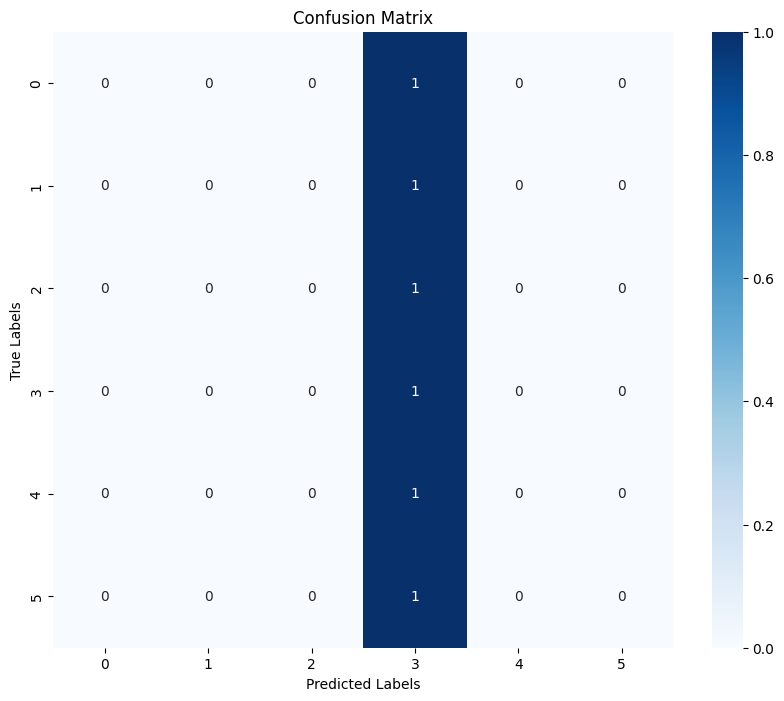

Epoch 10, Validation Loss: 1.7491, Accuracy: 0.3050, F1 Score: 0.1426
Val F1 Score Per Class  [0.         0.         0.         0.46746348 0.         0.        ]


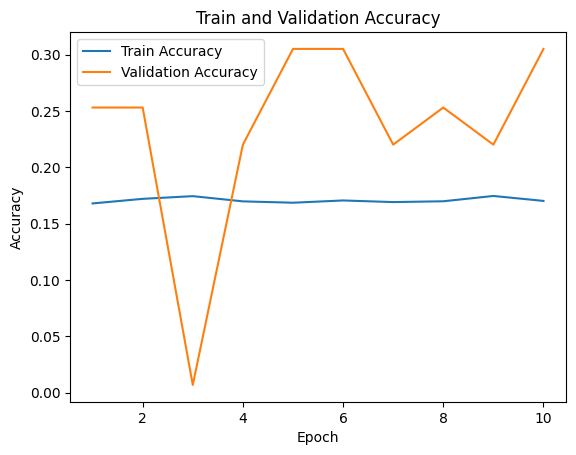

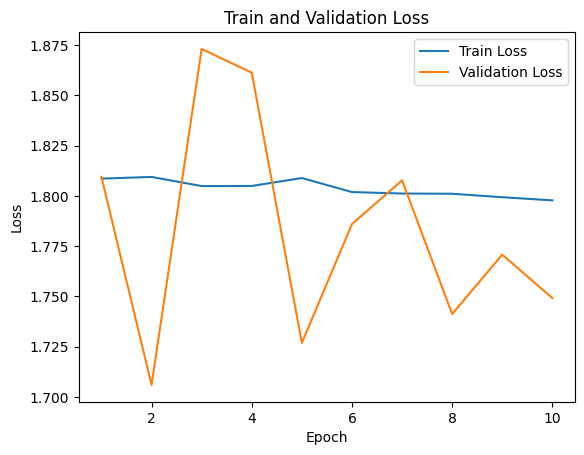

Epoch 11, Train Loss: 1.7953, Accuracy: 0.1747, F1 Score: 0.1467
Train F1 Score Per Class  [0.11630186 0.16798419 0.12293853 0.26532887 0.11443958 0.07782395]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.43it/s, loss=1.75]

[tensor([-0.0012,  0.0280, -0.0169,  0.1270, -0.0741, -0.1043], device='cuda:0'), tensor([-0.0725,  0.0182, -0.0535,  0.1125, -0.0366, -0.0971], device='cuda:0'), tensor([-0.0353,  0.0234, -0.0345,  0.1200, -0.0439, -0.0984], device='cuda:0'), tensor([-0.0229,  0.0251, -0.0282,  0.1225, -0.0377, -0.0971], device='cuda:0'), tensor([ 0.0071,  0.0292, -0.0127,  0.1286, -0.0942, -0.1080], device='cuda:0'), tensor([-0.0570,  0.0204, -0.0456,  0.1156, -0.0584, -0.1012], device='cuda:0'), tensor([ 0.0563,  0.0360,  0.0126,  0.1390, -0.1600, -0.1208], device='cuda:0'), tensor([-0.0384,  0.0230, -0.0361,  0.1193, -0.0338, -0.0964], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.45it/s, loss=1.77]

[tensor([ 0.0155,  0.0303, -0.0083,  0.1305, -0.1120, -0.1114], device='cuda:0'), tensor([-0.0326,  0.0237, -0.0330,  0.1206, -0.0579, -0.1010], device='cuda:0'), tensor([-0.0226,  0.0251, -0.0280,  0.1225, -0.0473, -0.0989], device='cuda:0'), tensor([-0.0097,  0.0268, -0.0213,  0.1252, -0.0651, -0.1024], device='cuda:0'), tensor([-0.0060,  0.0274, -0.0194,  0.1260, -0.0628, -0.1020], device='cuda:0'), tensor([-0.0056,  0.0274, -0.0192,  0.1261, -0.0982, -0.1089], device='cuda:0'), tensor([ 3.1638e-02,  3.2558e-02, -7.2125e-05,  1.3379e-01, -1.4067e-01,
        -1.1699e-01], device='cuda:0'), tensor([ 0.0058,  0.0290, -0.0134,  0.1283, -0.0742, -0.1042], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=1.8]

[tensor([ 0.0199,  0.0311, -0.0062,  0.1313, -0.1076, -0.1105], device='cuda:0'), tensor([-0.0035,  0.0278, -0.0182,  0.1263, -0.0725, -0.1039], device='cuda:0'), tensor([ 0.0043,  0.0288, -0.0141,  0.1280, -0.1045, -0.1100], device='cuda:0'), tensor([-0.0194,  0.0257, -0.0264,  0.1232, -0.0481, -0.0991], device='cuda:0'), tensor([-0.0300,  0.0242, -0.0318,  0.1210, -0.0520, -0.0998], device='cuda:0'), tensor([-0.0225,  0.0252, -0.0280,  0.1225, -0.0459, -0.0986], device='cuda:0'), tensor([ 0.0056,  0.0290, -0.0135,  0.1284, -0.0861, -0.1064], device='cuda:0'), tensor([-0.0091,  0.0271, -0.0211,  0.1253, -0.0687, -0.1031], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.72]

[tensor([ 0.0075,  0.0292, -0.0124,  0.1288, -0.0972, -0.1086], device='cuda:0'), tensor([-0.0230,  0.0252, -0.0283,  0.1223, -0.0449, -0.0987], device='cuda:0'), tensor([ 0.0321,  0.0326,  0.0002,  0.1339, -0.1152, -0.1121], device='cuda:0'), tensor([ 0.0028,  0.0287, -0.0149,  0.1278, -0.0973, -0.1085], device='cuda:0'), tensor([-0.0392,  0.0229, -0.0366,  0.1191, -0.0177, -0.0932], device='cuda:0'), tensor([ 0.0236,  0.0315, -0.0043,  0.1321, -0.1185, -0.1126], device='cuda:0'), tensor([ 0.0184,  0.0307, -0.0069,  0.1310, -0.1047, -0.1102], device='cuda:0'), tensor([-0.0070,  0.0273, -0.0199,  0.1258, -0.0825, -0.1058], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=1.78]

[tensor([-0.0233,  0.0251, -0.0284,  0.1223, -0.0521, -0.0998], device='cuda:0'), tensor([ 0.0120,  0.0300, -0.0102,  0.1296, -0.1004, -0.1090], device='cuda:0'), tensor([-0.0133,  0.0264, -0.0232,  0.1244, -0.0551, -0.1004], device='cuda:0'), tensor([-0.0293,  0.0243, -0.0315,  0.1210, -0.0285, -0.0955], device='cuda:0'), tensor([-0.0009,  0.0281, -0.0169,  0.1269, -0.0847, -0.1063], device='cuda:0'), tensor([-0.0218,  0.0253, -0.0276,  0.1228, -0.0471, -0.0990], device='cuda:0'), tensor([-0.0269,  0.0246, -0.0303,  0.1216, -0.0435, -0.0982], device='cuda:0'), tensor([-0.1267,  0.0108, -0.0814,  0.1017,  0.0662, -0.0773], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.39it/s, loss=1.73]

[tensor([-0.0179,  0.0257, -0.0255,  0.1236, -0.0719, -0.1038], device='cuda:0'), tensor([ 0.0195,  0.0309, -0.0063,  0.1312, -0.1034, -0.1097], device='cuda:0'), tensor([-0.0239,  0.0249, -0.0286,  0.1224, -0.0313, -0.0960], device='cuda:0'), tensor([ 0.0322,  0.0327,  0.0001,  0.1338, -0.1187, -0.1127], device='cuda:0'), tensor([-0.0030,  0.0278, -0.0178,  0.1267, -0.1061, -0.1103], device='cuda:0'), tensor([-0.0187,  0.0257, -0.0260,  0.1234, -0.0538, -0.1002], device='cuda:0'), tensor([-0.0013,  0.0282, -0.0172,  0.1268, -0.0720, -0.1038], device='cuda:0'), tensor([ 0.0085,  0.0295, -0.0121,  0.1289, -0.0972, -0.1084], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=1.76]

[tensor([-0.0050,  0.0275, -0.0189,  0.1262, -0.0803, -0.1053], device='cuda:0'), tensor([-0.0101,  0.0269, -0.0216,  0.1251, -0.0756, -0.1043], device='cuda:0'), tensor([-0.0274,  0.0245, -0.0305,  0.1215, -0.0332, -0.0963], device='cuda:0'), tensor([-0.0488,  0.0216, -0.0415,  0.1171, -0.0344, -0.0964], device='cuda:0'), tensor([-0.0151,  0.0263, -0.0242,  0.1240, -0.0624, -0.1020], device='cuda:0'), tensor([-0.0224,  0.0252, -0.0279,  0.1227, -0.0797, -0.1053], device='cuda:0'), tensor([ 0.0230,  0.0314, -0.0046,  0.1319, -0.1160, -0.1121], device='cuda:0'), tensor([-0.0375,  0.0232, -0.0357,  0.1195, -0.0497, -0.0994], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=1.72]

[tensor([ 0.0159,  0.0303, -0.0081,  0.1305, -0.1066, -0.1104], device='cuda:0'), tensor([-0.0499,  0.0215, -0.0421,  0.1170, -0.0450, -0.0985], device='cuda:0'), tensor([-0.0124,  0.0265, -0.0226,  0.1248, -0.0684, -0.1031], device='cuda:0'), tensor([ 0.0009,  0.0283, -0.0158,  0.1274, -0.0741, -0.1042], device='cuda:0'), tensor([ 0.0050,  0.0289, -0.0138,  0.1282, -0.0826, -0.1058], device='cuda:0'), tensor([-0.0067,  0.0273, -0.0198,  0.1259, -0.0669, -0.1029], device='cuda:0'), tensor([ 0.0048,  0.0290, -0.0140,  0.1281, -0.0906, -0.1072], device='cuda:0'), tensor([ 0.0049,  0.0290, -0.0139,  0.1281, -0.0927, -0.1076], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=1.76]

[tensor([-0.0377,  0.0230, -0.0357,  0.1195, -0.0568, -0.1009], device='cuda:0'), tensor([-0.0198,  0.0256, -0.0266,  0.1231, -0.0449, -0.0984], device='cuda:0'), tensor([-0.0238,  0.0250, -0.0287,  0.1224, -0.0531, -0.1003], device='cuda:0'), tensor([-0.0167,  0.0260, -0.0250,  0.1238, -0.0717, -0.1037], device='cuda:0'), tensor([-0.0179,  0.0259, -0.0257,  0.1234, -0.0624, -0.1017], device='cuda:0'), tensor([ 0.0006,  0.0284, -0.0161,  0.1273, -0.0940, -0.1080], device='cuda:0'), tensor([-0.0342,  0.0235, -0.0340,  0.1201, -0.0106, -0.0919], device='cuda:0'), tensor([-0.0340,  0.0238, -0.0340,  0.1201, -0.0443, -0.0983], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.40it/s, loss=1.77]

[tensor([-0.0202,  0.0255, -0.0267,  0.1231, -0.0601, -0.1015], device='cuda:0'), tensor([ 0.0022,  0.0285, -0.0153,  0.1276, -0.0890, -0.1071], device='cuda:0'), tensor([ 0.0193,  0.0309, -0.0064,  0.1313, -0.1315, -0.1152], device='cuda:0'), tensor([-0.0170,  0.0259, -0.0251,  0.1237, -0.0824, -0.1057], device='cuda:0'), tensor([-0.0494,  0.0215, -0.0418,  0.1171, -0.0264, -0.0949], device='cuda:0'), tensor([-0.0159,  0.0261, -0.0245,  0.1239, -0.0712, -0.1035], device='cuda:0'), tensor([-0.0246,  0.0250, -0.0291,  0.1221, -0.0483, -0.0992], device='cuda:0'), tensor([ 0.0062,  0.0291, -0.0132,  0.1285, -0.0858, -0.1064], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=1.81]

[tensor([ 0.0229,  0.0313, -0.0046,  0.1320, -0.1248, -0.1140], device='cuda:0'), tensor([ 0.0202,  0.0310, -0.0059,  0.1314, -0.1096, -0.1111], device='cuda:0'), tensor([ 0.0040,  0.0289, -0.0144,  0.1279, -0.0975, -0.1085], device='cuda:0'), tensor([-0.0133,  0.0266, -0.0233,  0.1244, -0.1481, -0.1183], device='cuda:0'), tensor([-0.0362,  0.0232, -0.0350,  0.1197, -0.0482, -0.0991], device='cuda:0'), tensor([-0.0192,  0.0256, -0.0263,  0.1232, -0.0326, -0.0961], device='cuda:0'), tensor([-0.0202,  0.0254, -0.0267,  0.1231, -0.0404, -0.0978], device='cuda:0'), tensor([-0.0192,  0.0256, -0.0262,  0.1233, -0.0410, -0.0977], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=1.72]

[tensor([-0.0224,  0.0252, -0.0279,  0.1226, -0.0477, -0.0991], device='cuda:0'), tensor([-0.0038,  0.0281, -0.0185,  0.1264, -0.0645, -0.1021], device='cuda:0'), tensor([ 0.0105,  0.0297, -0.0109,  0.1294, -0.1128, -0.1116], device='cuda:0'), tensor([-0.0289,  0.0244, -0.0313,  0.1211, -0.0741, -0.1042], device='cuda:0'), tensor([-0.0344,  0.0235, -0.0340,  0.1201, -0.0578, -0.1010], device='cuda:0'), tensor([-0.0014,  0.0280, -0.0171,  0.1269, -0.0916, -0.1075], device='cuda:0'), tensor([ 0.0247,  0.0315, -0.0037,  0.1323, -0.1287, -0.1148], device='cuda:0'), tensor([ 0.0070,  0.0292, -0.0128,  0.1286, -0.0913, -0.1073], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.74]

[tensor([ 0.0099,  0.0297, -0.0113,  0.1292, -0.0852, -0.1062], device='cuda:0'), tensor([ 0.0061,  0.0290, -0.0132,  0.1285, -0.1100, -0.1111], device='cuda:0'), tensor([-0.0292,  0.0242, -0.0313,  0.1212, -0.0504, -0.0996], device='cuda:0'), tensor([-0.0657,  0.0194, -0.0502,  0.1137,  0.0217, -0.0860], device='cuda:0'), tensor([-0.0159,  0.0260, -0.0246,  0.1239, -0.0428, -0.0981], device='cuda:0'), tensor([ 0.0125,  0.0299, -0.0099,  0.1298, -0.0913, -0.1075], device='cuda:0'), tensor([-0.0438,  0.0224, -0.0389,  0.1182, -0.0326, -0.0961], device='cuda:0'), tensor([ 0.0067,  0.0292, -0.0129,  0.1286, -0.0843, -0.1062], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.38it/s, loss=1.72]

[tensor([-0.0291,  0.0242, -0.0313,  0.1212, -0.0544, -0.1003], device='cuda:0'), tensor([-0.0133,  0.0264, -0.0232,  0.1244, -0.0536, -0.1002], device='cuda:0'), tensor([-0.0316,  0.0239, -0.0326,  0.1206, -0.0350, -0.0968], device='cuda:0'), tensor([-0.0018,  0.0280, -0.0173,  0.1269, -0.0787, -0.1050], device='cuda:0'), tensor([-0.0156,  0.0261, -0.0244,  0.1239, -0.0599, -0.1014], device='cuda:0'), tensor([-0.0378,  0.0230, -0.0357,  0.1195, -0.0226, -0.0944], device='cuda:0'), tensor([-0.0463,  0.0220, -0.0403,  0.1176, -0.0450, -0.0986], device='cuda:0'), tensor([ 0.0329,  0.0328,  0.0005,  0.1340, -0.1256, -0.1141], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=1.8]

[tensor([-0.0107,  0.0267, -0.0218,  0.1251, -0.0907, -0.1074], device='cuda:0'), tensor([-0.0240,  0.0250, -0.0288,  0.1222, -0.0645, -0.1024], device='cuda:0'), tensor([-0.0132,  0.0265, -0.0232,  0.1245, -0.0605, -0.1016], device='cuda:0'), tensor([-0.0286,  0.0243, -0.0310,  0.1213, -0.0624, -0.1019], device='cuda:0'), tensor([ 0.0023,  0.0286, -0.0152,  0.1277, -0.0781, -0.1048], device='cuda:0'), tensor([-0.0102,  0.0269, -0.0217,  0.1250, -0.0766, -0.1046], device='cuda:0'), tensor([-0.0336,  0.0237, -0.0337,  0.1204, -0.0400, -0.0976], device='cuda:0'), tensor([-0.0476,  0.0218, -0.0409,  0.1176, -0.0376, -0.0971], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=1.76]

[tensor([-0.0174,  0.0257, -0.0253,  0.1236, -0.0631, -0.1020], device='cuda:0'), tensor([-0.0320,  0.0238, -0.0328,  0.1206, -0.0577, -0.1010], device='cuda:0'), tensor([-0.0219,  0.0252, -0.0277,  0.1226, -0.0774, -0.1048], device='cuda:0'), tensor([-0.0721,  0.0185, -0.0535,  0.1124,  0.0252, -0.0852], device='cuda:0'), tensor([-0.0215,  0.0253, -0.0274,  0.1227, -0.0846, -0.1064], device='cuda:0'), tensor([-0.0394,  0.0229, -0.0366,  0.1191, -0.0761, -0.1044], device='cuda:0'), tensor([ 0.0033,  0.0287, -0.0146,  0.1278, -0.0900, -0.1072], device='cuda:0'), tensor([-0.0186,  0.0257, -0.0259,  0.1235, -0.0985, -0.1088], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=1.75]

[tensor([-0.0393,  0.0230, -0.0367,  0.1190, -0.0311, -0.0960], device='cuda:0'), tensor([-0.0070,  0.0272, -0.0199,  0.1257, -0.0915, -0.1075], device='cuda:0'), tensor([-0.0037,  0.0276, -0.0183,  0.1264, -0.0971, -0.1086], device='cuda:0'), tensor([-0.0326,  0.0238, -0.0332,  0.1205, -0.0415, -0.0979], device='cuda:0'), tensor([-0.0047,  0.0276, -0.0188,  0.1262, -0.0781, -0.1050], device='cuda:0'), tensor([-0.0010,  0.0281, -0.0170,  0.1269, -0.1134, -0.1117], device='cuda:0'), tensor([-0.0576,  0.0206, -0.0461,  0.1153,  0.0077, -0.0884], device='cuda:0'), tensor([-0.0210,  0.0254, -0.0271,  0.1230, -0.0542, -0.1004], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.40it/s, loss=1.75]

[tensor([-0.0647,  0.0196, -0.0497,  0.1138, -0.0058, -0.0911], device='cuda:0'), tensor([ 0.0144,  0.0302, -0.0089,  0.1303, -0.1116, -0.1116], device='cuda:0'), tensor([-0.0539,  0.0208, -0.0440,  0.1163, -0.0026, -0.0907], device='cuda:0'), tensor([-0.0079,  0.0272, -0.0204,  0.1256, -0.0949, -0.1082], device='cuda:0'), tensor([-0.0407,  0.0227, -0.0372,  0.1189, -0.0559, -0.1008], device='cuda:0'), tensor([-0.0079,  0.0272, -0.0204,  0.1255, -0.0879, -0.1068], device='cuda:0'), tensor([ 0.0001,  0.0283, -0.0164,  0.1271, -0.0638, -0.1021], device='cuda:0'), tensor([-0.0299,  0.0243, -0.0318,  0.1211, -0.0393, -0.0975], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.73]

[tensor([-0.0271,  0.0245, -0.0302,  0.1217, -0.0706, -0.1035], device='cuda:0'), tensor([-0.0208,  0.0255, -0.0271,  0.1229, -0.0530, -0.1002], device='cuda:0'), tensor([-0.0327,  0.0238, -0.0331,  0.1205, -0.0266, -0.0951], device='cuda:0'), tensor([ 0.0031,  0.0288, -0.0148,  0.1278, -0.0953, -0.1082], device='cuda:0'), tensor([-0.0322,  0.0238, -0.0329,  0.1205, -0.0705, -0.1035], device='cuda:0'), tensor([-0.0247,  0.0249, -0.0291,  0.1221, -0.0668, -0.1028], device='cuda:0'), tensor([-0.0635,  0.0196, -0.0490,  0.1143,  0.0154, -0.0870], device='cuda:0'), tensor([-0.0196,  0.0257, -0.0266,  0.1231, -0.0359, -0.0966], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=1.76]

[tensor([-0.0130,  0.0264, -0.0230,  0.1245, -0.0566, -0.1009], device='cuda:0'), tensor([-0.0359,  0.0234, -0.0349,  0.1198, -0.0375, -0.0972], device='cuda:0'), tensor([-0.0407,  0.0228, -0.0374,  0.1188, -0.0225, -0.0942], device='cuda:0'), tensor([-0.0293,  0.0243, -0.0314,  0.1211, -0.0513, -0.0998], device='cuda:0'), tensor([ 0.0093,  0.0295, -0.0116,  0.1290, -0.1390, -0.1168], device='cuda:0'), tensor([-0.0008,  0.0281, -0.0168,  0.1270, -0.0963, -0.1085], device='cuda:0'), tensor([-0.0039,  0.0277, -0.0183,  0.1264, -0.0920, -0.1075], device='cuda:0'), tensor([-0.0096,  0.0269, -0.0213,  0.1251, -0.0672, -0.1029], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.40it/s, loss=1.77]

[tensor([-0.0476,  0.0218, -0.0409,  0.1174, -0.0228, -0.0943], device='cuda:0'), tensor([-0.0500,  0.0214, -0.0420,  0.1169, -0.0122, -0.0922], device='cuda:0'), tensor([-0.0004,  0.0281, -0.0165,  0.1271, -0.1100, -0.1111], device='cuda:0'), tensor([-0.0768,  0.0178, -0.0559,  0.1114, -0.0177, -0.0936], device='cuda:0'), tensor([ 0.0048,  0.0289, -0.0138,  0.1282, -0.1127, -0.1117], device='cuda:0'), tensor([-0.0620,  0.0198, -0.0482,  0.1145, -0.0158, -0.0930], device='cuda:0'), tensor([-0.0326,  0.0238, -0.0331,  0.1205, -0.0423, -0.0980], device='cuda:0'), tensor([-0.0199,  0.0255, -0.0265,  0.1233, -0.0610, -0.1017], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.40it/s, loss=1.79]

[tensor([ 0.0026,  0.0285, -0.0150,  0.1277, -0.0765, -0.1046], device='cuda:0'), tensor([-0.0308,  0.0241, -0.0323,  0.1208, -0.0295, -0.0956], device='cuda:0'), tensor([-0.0528,  0.0211, -0.0435,  0.1163,  0.0024, -0.0896], device='cuda:0'), tensor([ 0.0218,  0.0312, -0.0051,  0.1317, -0.1297, -0.1148], device='cuda:0'), tensor([-0.0589,  0.0203, -0.0467,  0.1151, -0.0245, -0.0947], device='cuda:0'), tensor([-0.0459,  0.0219, -0.0399,  0.1178, -0.0244, -0.0945], device='cuda:0'), tensor([-0.0549,  0.0208, -0.0446,  0.1160, -0.0462, -0.0989], device='cuda:0'), tensor([-0.0556,  0.0206, -0.0449,  0.1158, -0.0240, -0.0944], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.40it/s, loss=1.73]

[tensor([-0.0052,  0.0274, -0.0190,  0.1260, -0.0702, -0.1034], device='cuda:0'), tensor([-0.0093,  0.0269, -0.0211,  0.1253, -0.0597, -0.1013], device='cuda:0'), tensor([ 0.0341,  0.0330,  0.0011,  0.1342, -0.1165, -0.1122], device='cuda:0'), tensor([ 0.0006,  0.0283, -0.0160,  0.1274, -0.1135, -0.1117], device='cuda:0'), tensor([ 0.0179,  0.0306, -0.0072,  0.1309, -0.0989, -0.1090], device='cuda:0'), tensor([ 0.0110,  0.0298, -0.0108,  0.1295, -0.1253, -0.1140], device='cuda:0'), tensor([ 0.0168,  0.0305, -0.0077,  0.1308, -0.1022, -0.1096], device='cuda:0'), tensor([-0.0471,  0.0219, -0.0406,  0.1175, -0.0206, -0.0939], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.41it/s, loss=1.77]

[tensor([-0.0435,  0.0223, -0.0387,  0.1182, -0.0419, -0.0979], device='cuda:0'), tensor([ 0.0104,  0.0295, -0.0109,  0.1294, -0.1119, -0.1116], device='cuda:0'), tensor([ 0.0166,  0.0307, -0.0080,  0.1305, -0.1205, -0.1130], device='cuda:0'), tensor([-0.0409,  0.0227, -0.0374,  0.1188, -0.0351, -0.0964], device='cuda:0'), tensor([-0.0332,  0.0237, -0.0334,  0.1203, -0.0575, -0.1010], device='cuda:0'), tensor([-0.0096,  0.0268, -0.0212,  0.1253, -0.0702, -0.1035], device='cuda:0'), tensor([-0.0570,  0.0205, -0.0457,  0.1155, -0.0068, -0.0912], device='cuda:0'), tensor([-0.0308,  0.0240, -0.0322,  0.1209, -0.0595, -0.1014], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.40it/s, loss=1.75]

[tensor([-0.1024,  0.0141, -0.0690,  0.1068,  0.0342, -0.0838], device='cuda:0'), tensor([-0.0423,  0.0226, -0.0382,  0.1185, -0.0165, -0.0931], device='cuda:0'), tensor([ 0.0064,  0.0292, -0.0131,  0.1285, -0.0967, -0.1084], device='cuda:0'), tensor([-0.0125,  0.0265, -0.0228,  0.1247, -0.0807, -0.1055], device='cuda:0'), tensor([-0.0095,  0.0270, -0.0213,  0.1252, -0.0783, -0.1050], device='cuda:0'), tensor([ 0.0108,  0.0297, -0.0108,  0.1294, -0.1001, -0.1091], device='cuda:0'), tensor([-0.0375,  0.0231, -0.0356,  0.1196, -0.0357, -0.0969], device='cuda:0'), tensor([-0.0270,  0.0247, -0.0303,  0.1216, -0.0420, -0.0980], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.73]

[tensor([ 0.0049,  0.0290, -0.0139,  0.1282, -0.0937, -0.1079], device='cuda:0'), tensor([-0.0029,  0.0278, -0.0178,  0.1267, -0.0976, -0.1086], device='cuda:0'), tensor([ 0.0214,  0.0311, -0.0053,  0.1317, -0.1314, -0.1151], device='cuda:0'), tensor([-0.0289,  0.0243, -0.0312,  0.1212, -0.0503, -0.0995], device='cuda:0'), tensor([ 0.0150,  0.0303, -0.0086,  0.1303, -0.0918, -0.1075], device='cuda:0'), tensor([ 0.0205,  0.0311, -0.0058,  0.1314, -0.1379, -0.1165], device='cuda:0'), tensor([-0.0078,  0.0271, -0.0203,  0.1256, -0.0883, -0.1069], device='cuda:0'), tensor([-0.0482,  0.0218, -0.0412,  0.1173, -0.0155, -0.0928], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.40it/s, loss=1.77]

[tensor([ 0.0079,  0.0292, -0.0122,  0.1289, -0.0970, -0.1087], device='cuda:0'), tensor([-0.0076,  0.0271, -0.0202,  0.1256, -0.0716, -0.1037], device='cuda:0'), tensor([ 0.0018,  0.0285, -0.0155,  0.1275, -0.1254, -0.1141], device='cuda:0'), tensor([-0.0148,  0.0264, -0.0241,  0.1241, -0.0389, -0.0972], device='cuda:0'), tensor([-0.0222,  0.0252, -0.0278,  0.1226, -0.0488, -0.0994], device='cuda:0'), tensor([-0.0407,  0.0227, -0.0373,  0.1189, -0.0202, -0.0938], device='cuda:0'), tensor([-0.0331,  0.0237, -0.0334,  0.1205, -0.0538, -0.1005], device='cuda:0'), tensor([-0.0125,  0.0265, -0.0228,  0.1247, -0.0711, -0.1036], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=1.73]

[tensor([-0.0160,  0.0260, -0.0245,  0.1239, -0.0619, -0.1018], device='cuda:0'), tensor([ 0.0543,  0.0357,  0.0116,  0.1385, -0.1595, -0.1206], device='cuda:0'), tensor([-0.0311,  0.0240, -0.0324,  0.1209, -0.0458, -0.0988], device='cuda:0'), tensor([-0.0237,  0.0251, -0.0286,  0.1222, -0.0599, -0.1013], device='cuda:0'), tensor([-0.0260,  0.0246, -0.0297,  0.1219, -0.0457, -0.0990], device='cuda:0'), tensor([-0.0503,  0.0215, -0.0422,  0.1170, -0.0454, -0.0986], device='cuda:0'), tensor([-0.0307,  0.0240, -0.0321,  0.1209, -0.0411, -0.0980], device='cuda:0'), tensor([-0.0023,  0.0279, -0.0176,  0.1267, -0.0842, -0.1061], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.40it/s, loss=1.77]

[tensor([-0.0286,  0.0242, -0.0310,  0.1212, -0.0504, -0.0995], device='cuda:0'), tensor([-0.0240,  0.0249, -0.0286,  0.1224, -0.0798, -0.1052], device='cuda:0'), tensor([-0.0190,  0.0258, -0.0262,  0.1232, -0.0490, -0.0994], device='cuda:0'), tensor([ 0.0054,  0.0291, -0.0136,  0.1283, -0.1012, -0.1093], device='cuda:0'), tensor([-0.0269,  0.0247, -0.0303,  0.1215, -0.0418, -0.0977], device='cuda:0'), tensor([ 0.0191,  0.0307, -0.0065,  0.1313, -0.1220, -0.1135], device='cuda:0'), tensor([-0.0509,  0.0212, -0.0425,  0.1168, -0.0115, -0.0922], device='cuda:0'), tensor([ 0.0189,  0.0308, -0.0066,  0.1311, -0.1004, -0.1093], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.40it/s, loss=1.78]

[tensor([-0.0036,  0.0277, -0.0182,  0.1264, -0.1002, -0.1092], device='cuda:0'), tensor([-0.0589,  0.0201, -0.0466,  0.1150, -0.0124, -0.0924], device='cuda:0'), tensor([ 0.0143,  0.0301, -0.0090,  0.1301, -0.1134, -0.1118], device='cuda:0'), tensor([-0.0359,  0.0234, -0.0349,  0.1198, -0.0357, -0.0967], device='cuda:0'), tensor([ 0.0170,  0.0308, -0.0078,  0.1306, -0.1176, -0.1124], device='cuda:0'), tensor([ 0.0070,  0.0291, -0.0128,  0.1286, -0.1135, -0.1118], device='cuda:0'), tensor([-0.0281,  0.0244, -0.0308,  0.1215, -0.0520, -0.0999], device='cuda:0'), tensor([-0.0539,  0.0210, -0.0441,  0.1161, -0.0305, -0.0958], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=1.77]

[tensor([ 0.0228,  0.0313, -0.0046,  0.1320, -0.1065, -0.1104], device='cuda:0'), tensor([ 0.0112,  0.0297, -0.0106,  0.1294, -0.1232, -0.1136], device='cuda:0'), tensor([-0.0292,  0.0243, -0.0315,  0.1211, -0.0284, -0.0954], device='cuda:0'), tensor([-0.0216,  0.0253, -0.0275,  0.1227, -0.0370, -0.0972], device='cuda:0'), tensor([ 0.0039,  0.0288, -0.0144,  0.1279, -0.0910, -0.1073], device='cuda:0'), tensor([-0.0443,  0.0222, -0.0392,  0.1180, -0.0393, -0.0976], device='cuda:0'), tensor([-0.0074,  0.0273, -0.0202,  0.1257, -0.0818, -0.1056], device='cuda:0'), tensor([ 0.0196,  0.0308, -0.0062,  0.1313, -0.1109, -0.1112], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=1.78]

[tensor([-0.0192,  0.0255, -0.0262,  0.1232, -0.0614, -0.1017], device='cuda:0'), tensor([ 0.0038,  0.0288, -0.0144,  0.1279, -0.0844, -0.1060], device='cuda:0'), tensor([-0.0090,  0.0271, -0.0210,  0.1254, -0.0866, -0.1067], device='cuda:0'), tensor([-0.0293,  0.0241, -0.0314,  0.1212, -0.0314, -0.0959], device='cuda:0'), tensor([ 0.0021,  0.0285, -0.0153,  0.1277, -0.0663, -0.1027], device='cuda:0'), tensor([ 0.0256,  0.0319, -0.0033,  0.1324, -0.1281, -0.1144], device='cuda:0'), tensor([-0.0366,  0.0232, -0.0352,  0.1196, -0.0835, -0.1059], device='cuda:0'), tensor([ 0.0226,  0.0313, -0.0047,  0.1318, -0.1224, -0.1135], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.40it/s, loss=1.76]

[tensor([-0.0298,  0.0241, -0.0317,  0.1210, -0.0348, -0.0965], device='cuda:0'), tensor([ 0.0144,  0.0302, -0.0090,  0.1301, -0.0995, -0.1091], device='cuda:0'), tensor([ 0.0417,  0.0339,  0.0051,  0.1358, -0.1353, -0.1160], device='cuda:0'), tensor([ 0.0337,  0.0328,  0.0010,  0.1342, -0.1256, -0.1141], device='cuda:0'), tensor([-0.0576,  0.0204, -0.0460,  0.1153, -0.0201, -0.0941], device='cuda:0'), tensor([-0.0048,  0.0275, -0.0188,  0.1263, -0.1041, -0.1099], device='cuda:0'), tensor([-0.0156,  0.0260, -0.0243,  0.1240, -0.0504, -0.0995], device='cuda:0'), tensor([-0.0122,  0.0266, -0.0227,  0.1247, -0.0813, -0.1055], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.39it/s, loss=1.74]

[tensor([ 0.0141,  0.0301, -0.0090,  0.1301, -0.1014, -0.1094], device='cuda:0'), tensor([ 0.0034,  0.0285, -0.0145,  0.1280, -0.1071, -0.1105], device='cuda:0'), tensor([-0.0088,  0.0271, -0.0209,  0.1253, -0.0740, -0.1041], device='cuda:0'), tensor([-0.0148,  0.0261, -0.0239,  0.1242, -0.0996, -0.1091], device='cuda:0'), tensor([-0.0273,  0.0245, -0.0304,  0.1216, -0.0452, -0.0987], device='cuda:0'), tensor([-0.0047,  0.0275, -0.0187,  0.1262, -0.0726, -0.1038], device='cuda:0'), tensor([-0.0321,  0.0238, -0.0329,  0.1206, -0.0423, -0.0978], device='cuda:0'), tensor([-0.0169,  0.0260, -0.0251,  0.1236, -0.1022, -0.1095], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=1.75]

[tensor([-0.0605,  0.0204, -0.0476,  0.1149, -0.0317, -0.0958], device='cuda:0'), tensor([ 0.0204,  0.0310, -0.0058,  0.1315, -0.1147, -0.1120], device='cuda:0'), tensor([ 0.0177,  0.0307, -0.0073,  0.1309, -0.1159, -0.1121], device='cuda:0'), tensor([ 0.0324,  0.0328,  0.0002,  0.1339, -0.1347, -0.1159], device='cuda:0'), tensor([-0.0448,  0.0221, -0.0393,  0.1181, -0.0261, -0.0951], device='cuda:0'), tensor([ 0.0235,  0.0314, -0.0042,  0.1321, -0.1061, -0.1104], device='cuda:0'), tensor([-0.0085,  0.0270, -0.0207,  0.1255, -0.0746, -0.1042], device='cuda:0'), tensor([ 0.0178,  0.0307, -0.0072,  0.1309, -0.1052, -0.1101], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=1.73]

[tensor([-0.0156,  0.0261, -0.0244,  0.1240, -0.0618, -0.1017], device='cuda:0'), tensor([-0.0105,  0.0269, -0.0218,  0.1250, -0.0598, -0.1013], device='cuda:0'), tensor([-0.0202,  0.0255, -0.0267,  0.1230, -0.0568, -0.1009], device='cuda:0'), tensor([ 0.0149,  0.0302, -0.0086,  0.1303, -0.1086, -0.1108], device='cuda:0'), tensor([-0.0118,  0.0268, -0.0226,  0.1247, -0.0739, -0.1042], device='cuda:0'), tensor([-0.0394,  0.0230, -0.0367,  0.1192, -0.0136, -0.0925], device='cuda:0'), tensor([ 0.0027,  0.0287, -0.0150,  0.1277, -0.1018, -0.1093], device='cuda:0'), tensor([ 0.0171,  0.0306, -0.0076,  0.1307, -0.1020, -0.1097], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=1.75]

[tensor([-0.0017,  0.0281, -0.0173,  0.1268, -0.0932, -0.1078], device='cuda:0'), tensor([-0.0216,  0.0254, -0.0275,  0.1227, -0.0362, -0.0968], device='cuda:0'), tensor([-0.0073,  0.0274, -0.0202,  0.1256, -0.1318, -0.1153], device='cuda:0'), tensor([-0.0333,  0.0237, -0.0335,  0.1204, -0.0370, -0.0970], device='cuda:0'), tensor([-0.0347,  0.0234, -0.0342,  0.1201, -0.0367, -0.0969], device='cuda:0'), tensor([-0.0097,  0.0268, -0.0213,  0.1251, -0.0840, -0.1061], device='cuda:0'), tensor([-0.0342,  0.0236, -0.0340,  0.1201, -0.0214, -0.0940], device='cuda:0'), tensor([-0.0499,  0.0215, -0.0421,  0.1168, -0.0173, -0.0934], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.77]

[tensor([-0.0259,  0.0248, -0.0297,  0.1219, -0.0465, -0.0990], device='cuda:0'), tensor([-0.0512,  0.0214, -0.0428,  0.1165, -0.0347, -0.0965], device='cuda:0'), tensor([ 0.0048,  0.0289, -0.0139,  0.1281, -0.0895, -0.1072], device='cuda:0'), tensor([-0.0408,  0.0226, -0.0374,  0.1187, -0.0326, -0.0962], device='cuda:0'), tensor([ 0.0240,  0.0315, -0.0040,  0.1321, -0.1177, -0.1126], device='cuda:0'), tensor([ 0.0102,  0.0297, -0.0111,  0.1293, -0.1049, -0.1101], device='cuda:0'), tensor([-0.0159,  0.0261, -0.0246,  0.1238, -0.0925, -0.1077], device='cuda:0'), tensor([-0.0924,  0.0157, -0.0640,  0.1087,  0.0067, -0.0885], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=1.79]

[tensor([ 0.0153,  0.0304, -0.0085,  0.1304, -0.1176, -0.1126], device='cuda:0'), tensor([-0.0287,  0.0242, -0.0311,  0.1212, -0.0701, -0.1036], device='cuda:0'), tensor([-0.0545,  0.0208, -0.0444,  0.1160, -0.0467, -0.0988], device='cuda:0'), tensor([-0.0141,  0.0263, -0.0237,  0.1242, -0.0772, -0.1048], device='cuda:0'), tensor([-0.0289,  0.0242, -0.0312,  0.1213, -0.0440, -0.0985], device='cuda:0'), tensor([ 0.0269,  0.0320, -0.0026,  0.1327, -0.1327, -0.1154], device='cuda:0'), tensor([ 0.0028,  0.0287, -0.0149,  0.1278, -0.0785, -0.1049], device='cuda:0'), tensor([ 0.0025,  0.0286, -0.0151,  0.1276, -0.0923, -0.1077], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=1.8]

[tensor([-0.0500,  0.0213, -0.0419,  0.1171, -0.0119, -0.0923], device='cuda:0'), tensor([-0.0227,  0.0251, -0.0280,  0.1226, -0.0935, -0.1079], device='cuda:0'), tensor([-0.0424,  0.0226, -0.0382,  0.1184, -0.0079, -0.0913], device='cuda:0'), tensor([ 0.0371,  0.0333,  0.0027,  0.1349, -0.1312, -0.1152], device='cuda:0'), tensor([-0.0214,  0.0253, -0.0274,  0.1228, -0.0394, -0.0975], device='cuda:0'), tensor([-4.4281e-02,  2.2289e-02, -3.9171e-02,  1.1816e-01,  6.4014e-05,
        -8.9904e-02], device='cuda:0'), tensor([-0.0237,  0.0250, -0.0286,  0.1223, -0.0306, -0.0958], device='cuda:0'), tensor([-0.0127,  0.0265, -0.0229,  0.1246, -0.0558, -0.1006], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.40it/s, loss=1.76]

[tensor([ 0.0064,  0.0290, -0.0130,  0.1286, -0.0942, -0.1080], device='cuda:0'), tensor([-0.0415,  0.0226, -0.0378,  0.1187, -0.0446, -0.0986], device='cuda:0'), tensor([-0.0488,  0.0216, -0.0415,  0.1173, -0.0167, -0.0933], device='cuda:0'), tensor([-0.0020,  0.0280, -0.0174,  0.1268, -0.1116, -0.1113], device='cuda:0'), tensor([-0.0036,  0.0278, -0.0182,  0.1266, -0.0906, -0.1073], device='cuda:0'), tensor([-0.0103,  0.0268, -0.0216,  0.1252, -0.1033, -0.1098], device='cuda:0'), tensor([-0.0331,  0.0238, -0.0335,  0.1204, -0.0419, -0.0979], device='cuda:0'), tensor([-0.0260,  0.0247, -0.0298,  0.1218, -0.0545, -0.1003], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=1.7]

[tensor([-0.0035,  0.0278, -0.0183,  0.1264, -0.0845, -0.1061], device='cuda:0'), tensor([ 0.0141,  0.0302, -0.0092,  0.1300, -0.1436, -0.1177], device='cuda:0'), tensor([-0.0286,  0.0244, -0.0311,  0.1213, -0.0268, -0.0949], device='cuda:0'), tensor([ 0.0431,  0.0342,  0.0058,  0.1361, -0.1406, -0.1170], device='cuda:0'), tensor([-0.0543,  0.0209, -0.0443,  0.1161, -0.0124, -0.0925], device='cuda:0'), tensor([-0.0968,  0.0149, -0.0661,  0.1078,  0.0547, -0.0795], device='cuda:0'), tensor([-0.0264,  0.0247, -0.0300,  0.1218, -0.0483, -0.0991], device='cuda:0'), tensor([ 0.0227,  0.0313, -0.0047,  0.1319, -0.1117, -0.1114], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.39it/s, loss=1.73]

[tensor([ 0.0042,  0.0288, -0.0142,  0.1280, -0.0886, -0.1069], device='cuda:0'), tensor([-0.0247,  0.0247, -0.0289,  0.1222, -0.0543, -0.1004], device='cuda:0'), tensor([-0.0042,  0.0275, -0.0185,  0.1263, -0.0745, -0.1042], device='cuda:0'), tensor([ 0.0044,  0.0287, -0.0140,  0.1281, -0.0796, -0.1052], device='cuda:0'), tensor([-0.0234,  0.0251, -0.0284,  0.1224, -0.0346, -0.0966], device='cuda:0'), tensor([-0.0128,  0.0266, -0.0230,  0.1245, -0.0995, -0.1091], device='cuda:0'), tensor([-0.0183,  0.0257, -0.0257,  0.1235, -0.0393, -0.0977], device='cuda:0'), tensor([-0.0060,  0.0274, -0.0195,  0.1260, -0.0624, -0.1019], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.41it/s, loss=1.76]

[tensor([-0.0358,  0.0233, -0.0348,  0.1198, -0.0440, -0.0983], device='cuda:0'), tensor([-0.0328,  0.0238, -0.0333,  0.1203, -0.0870, -0.1067], device='cuda:0'), tensor([-0.0301,  0.0241, -0.0318,  0.1210, -0.0408, -0.0977], device='cuda:0'), tensor([-0.0242,  0.0249, -0.0288,  0.1222, -0.0487, -0.0994], device='cuda:0'), tensor([-0.0623,  0.0199, -0.0485,  0.1143, -0.0137, -0.0926], device='cuda:0'), tensor([-0.0198,  0.0255, -0.0265,  0.1232, -0.0540, -0.1003], device='cuda:0'), tensor([-0.0164,  0.0262, -0.0250,  0.1236, -0.0518, -0.0999], device='cuda:0'), tensor([ 0.0061,  0.0291, -0.0132,  0.1284, -0.0799, -0.1052], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.40it/s, loss=1.71]

[tensor([ 0.0035,  0.0288, -0.0146,  0.1279, -0.0737, -0.1041], device='cuda:0'), tensor([-0.0097,  0.0268, -0.0213,  0.1252, -0.0968, -0.1086], device='cuda:0'), tensor([ 0.0227,  0.0313, -0.0047,  0.1319, -0.1267, -0.1143], device='cuda:0'), tensor([-0.0284,  0.0243, -0.0309,  0.1213, -0.0282, -0.0953], device='cuda:0'), tensor([-0.0407,  0.0228, -0.0373,  0.1188, -0.0376, -0.0970], device='cuda:0'), tensor([-0.0546,  0.0207, -0.0444,  0.1159, -0.0158, -0.0930], device='cuda:0'), tensor([ 0.0280,  0.0320, -0.0019,  0.1330, -0.1058, -0.1102], device='cuda:0'), tensor([-0.0144,  0.0263, -0.0238,  0.1243, -0.0529, -0.1001], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=1.75]

[tensor([-0.0338,  0.0236, -0.0337,  0.1203, -0.0654, -0.1023], device='cuda:0'), tensor([-0.0590,  0.0201, -0.0467,  0.1150, -0.0796, -0.1053], device='cuda:0'), tensor([ 0.0082,  0.0293, -0.0121,  0.1289, -0.1153, -0.1121], device='cuda:0'), tensor([-0.0088,  0.0272, -0.0210,  0.1254, -0.0818, -0.1057], device='cuda:0'), tensor([-0.0098,  0.0268, -0.0213,  0.1253, -0.1034, -0.1099], device='cuda:0'), tensor([-0.0341,  0.0237, -0.0339,  0.1202, -0.0106, -0.0918], device='cuda:0'), tensor([-0.0198,  0.0255, -0.0266,  0.1231, -0.0626, -0.1020], device='cuda:0'), tensor([-0.0449,  0.0222, -0.0395,  0.1180, -0.0353, -0.0967], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=1.71]

[tensor([ 0.0041,  0.0288, -0.0143,  0.1280, -0.0996, -0.1091], device='cuda:0'), tensor([-0.0165,  0.0259, -0.0248,  0.1238, -0.0786, -0.1051], device='cuda:0'), tensor([-0.0257,  0.0248, -0.0296,  0.1219, -0.0562, -0.1008], device='cuda:0'), tensor([-0.0264,  0.0245, -0.0299,  0.1217, -0.0797, -0.1053], device='cuda:0'), tensor([-0.0185,  0.0257, -0.0259,  0.1234, -0.0569, -0.1010], device='cuda:0'), tensor([-0.0017,  0.0280, -0.0173,  0.1268, -0.1184, -0.1128], device='cuda:0'), tensor([-0.0272,  0.0245, -0.0304,  0.1215, -0.0780, -0.1049], device='cuda:0'), tensor([ 0.0029,  0.0286, -0.0149,  0.1277, -0.0977, -0.1088], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=1.76]

[tensor([-0.0013,  0.0280, -0.0170,  0.1269, -0.0867, -0.1065], device='cuda:0'), tensor([-0.0250,  0.0249, -0.0292,  0.1220, -0.1123, -0.1116], device='cuda:0'), tensor([-0.0341,  0.0236, -0.0339,  0.1203, -0.0242, -0.0947], device='cuda:0'), tensor([-0.0245,  0.0248, -0.0290,  0.1222, -0.0520, -0.0997], device='cuda:0'), tensor([ 0.0037,  0.0287, -0.0144,  0.1280, -0.1122, -0.1116], device='cuda:0'), tensor([ 0.0078,  0.0293, -0.0123,  0.1288, -0.0950, -0.1081], device='cuda:0'), tensor([-0.0142,  0.0266, -0.0238,  0.1241, -0.0807, -0.1054], device='cuda:0'), tensor([-0.0067,  0.0273, -0.0198,  0.1258, -0.0725, -0.1040], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=1.78]

[tensor([ 0.0126,  0.0300, -0.0099,  0.1298, -0.1032, -0.1097], device='cuda:0'), tensor([ 0.0147,  0.0303, -0.0088,  0.1302, -0.1030, -0.1097], device='cuda:0'), tensor([ 0.0140,  0.0301, -0.0091,  0.1301, -0.0903, -0.1071], device='cuda:0'), tensor([-0.0130,  0.0265, -0.0231,  0.1245, -0.0936, -0.1078], device='cuda:0'), tensor([-0.0304,  0.0240, -0.0320,  0.1210, -0.0161, -0.0930], device='cuda:0'), tensor([ 0.0075,  0.0292, -0.0125,  0.1288, -0.0865, -0.1066], device='cuda:0'), tensor([-0.0527,  0.0211, -0.0434,  0.1165, -0.0175, -0.0933], device='cuda:0'), tensor([-0.0572,  0.0205, -0.0458,  0.1154, -0.0194, -0.0937], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.38it/s, loss=1.74]

[tensor([ 0.0119,  0.0299, -0.0102,  0.1297, -0.1059, -0.1103], device='cuda:0'), tensor([-0.0156,  0.0260, -0.0243,  0.1240, -0.0868, -0.1066], device='cuda:0'), tensor([ 0.0263,  0.0318, -0.0028,  0.1327, -0.1102, -0.1111], device='cuda:0'), tensor([-0.0076,  0.0271, -0.0202,  0.1257, -0.0658, -0.1027], device='cuda:0'), tensor([ 0.0005,  0.0283, -0.0161,  0.1274, -0.0844, -0.1060], device='cuda:0'), tensor([-0.0287,  0.0242, -0.0310,  0.1214, -0.0496, -0.0995], device='cuda:0'), tensor([ 0.0381,  0.0336,  0.0032,  0.1351, -0.1383, -0.1166], device='cuda:0'), tensor([-0.0530,  0.0210, -0.0437,  0.1163, -0.0194, -0.0936], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=1.75]

[tensor([-0.0167,  0.0259, -0.0249,  0.1239, -0.0443, -0.0985], device='cuda:0'), tensor([-0.0323,  0.0237, -0.0329,  0.1206, -0.0172, -0.0934], device='cuda:0'), tensor([-0.0101,  0.0267, -0.0214,  0.1253, -0.0787, -0.1052], device='cuda:0'), tensor([ 4.4648e-06,  2.8149e-02, -1.6288e-02,  1.2723e-01, -9.9513e-02,
        -1.0909e-01], device='cuda:0'), tensor([-0.0407,  0.0227, -0.0373,  0.1188, -0.0372, -0.0970], device='cuda:0'), tensor([ 0.0037,  0.0287, -0.0145,  0.1279, -0.1091, -0.1109], device='cuda:0'), tensor([ 0.0065,  0.0291, -0.0130,  0.1286, -0.0868, -0.1066], device='cuda:0'), tensor([-0.0676,  0.0191, -0.0511,  0.1137, -0.0126, -0.0924], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.36it/s, loss=1.74]

[tensor([ 0.0173,  0.0307, -0.0075,  0.1307, -0.1208, -0.1132], device='cuda:0'), tensor([-0.0249,  0.0249, -0.0292,  0.1219, -0.0464, -0.0989], device='cuda:0'), tensor([-0.0006,  0.0281, -0.0166,  0.1271, -0.0907, -0.1073], device='cuda:0'), tensor([-0.0126,  0.0266, -0.0229,  0.1246, -0.0604, -0.1015], device='cuda:0'), tensor([ 0.0096,  0.0295, -0.0114,  0.1293, -0.0888, -0.1069], device='cuda:0'), tensor([-0.0102,  0.0269, -0.0217,  0.1250, -0.0615, -0.1019], device='cuda:0'), tensor([-0.0259,  0.0248, -0.0298,  0.1218, -0.0304, -0.0959], device='cuda:0'), tensor([-0.0123,  0.0264, -0.0226,  0.1248, -0.0775, -0.1047], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.36it/s, loss=1.81]

[tensor([-0.0453,  0.0220, -0.0396,  0.1180, -0.0296, -0.0955], device='cuda:0'), tensor([-0.0062,  0.0275, -0.0195,  0.1259, -0.0819, -0.1057], device='cuda:0'), tensor([-0.0337,  0.0236, -0.0337,  0.1202, -0.0457, -0.0987], device='cuda:0'), tensor([-0.0581,  0.0202, -0.0462,  0.1154,  0.0225, -0.0859], device='cuda:0'), tensor([-0.0032,  0.0278, -0.0181,  0.1265, -0.1002, -0.1092], device='cuda:0'), tensor([-0.0403,  0.0229, -0.0372,  0.1188, -0.0823, -0.1058], device='cuda:0'), tensor([-0.0122,  0.0266, -0.0227,  0.1246, -0.0865, -0.1065], device='cuda:0'), tensor([ 0.0017,  0.0285, -0.0155,  0.1275, -0.0984, -0.1087], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.73]

[tensor([-0.0009,  0.0280, -0.0167,  0.1270, -0.0893, -0.1071], device='cuda:0'), tensor([ 0.0242,  0.0315, -0.0039,  0.1322, -0.1077, -0.1107], device='cuda:0'), tensor([ 0.0207,  0.0310, -0.0057,  0.1315, -0.1275, -0.1144], device='cuda:0'), tensor([-0.0345,  0.0236, -0.0341,  0.1201, -0.0636, -0.1022], device='cuda:0'), tensor([ 0.0265,  0.0319, -0.0027,  0.1327, -0.1225, -0.1135], device='cuda:0'), tensor([-0.0226,  0.0252, -0.0280,  0.1225, -0.0542, -0.1004], device='cuda:0'), tensor([-0.0280,  0.0243, -0.0308,  0.1214, -0.0627, -0.1019], device='cuda:0'), tensor([ 0.0019,  0.0284, -0.0154,  0.1276, -0.0912, -0.1075], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=1.76]

[tensor([-0.0408,  0.0226, -0.0373,  0.1188, -0.0393, -0.0975], device='cuda:0'), tensor([-0.0453,  0.0221, -0.0396,  0.1179, -0.0338, -0.0965], device='cuda:0'), tensor([-0.0133,  0.0264, -0.0231,  0.1245, -0.0760, -0.1045], device='cuda:0'), tensor([-0.0222,  0.0252, -0.0278,  0.1227, -0.0346, -0.0967], device='cuda:0'), tensor([-0.0347,  0.0235, -0.0342,  0.1201, -0.0228, -0.0943], device='cuda:0'), tensor([-0.0441,  0.0222, -0.0391,  0.1182, -0.0392, -0.0975], device='cuda:0'), tensor([-0.0544,  0.0210, -0.0444,  0.1161,  0.0037, -0.0893], device='cuda:0'), tensor([ 0.0464,  0.0346,  0.0075,  0.1369, -0.1654, -0.1218], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=1.77]

[tensor([-0.0062,  0.0274, -0.0197,  0.1258, -0.0957, -0.1083], device='cuda:0'), tensor([-0.0373,  0.0232, -0.0356,  0.1195, -0.0632, -0.1020], device='cuda:0'), tensor([ 0.0012,  0.0283, -0.0157,  0.1274, -0.0778, -0.1049], device='cuda:0'), tensor([-0.0329,  0.0238, -0.0333,  0.1203, -0.0960, -0.1084], device='cuda:0'), tensor([-0.0174,  0.0258, -0.0254,  0.1236, -0.0549, -0.1005], device='cuda:0'), tensor([-0.0497,  0.0215, -0.0419,  0.1170, -0.0118, -0.0923], device='cuda:0'), tensor([-0.0260,  0.0248, -0.0299,  0.1218, -0.0487, -0.0991], device='cuda:0'), tensor([-0.0196,  0.0255, -0.0263,  0.1232, -0.0441, -0.0985], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=1.73]

[tensor([-0.0015,  0.0279, -0.0172,  0.1269, -0.0606, -0.1016], device='cuda:0'), tensor([ 0.0176,  0.0307, -0.0074,  0.1308, -0.0995, -0.1089], device='cuda:0'), tensor([ 0.0067,  0.0291, -0.0129,  0.1286, -0.0799, -0.1054], device='cuda:0'), tensor([-0.0068,  0.0273, -0.0198,  0.1257, -0.0939, -0.1080], device='cuda:0'), tensor([-0.0321,  0.0238, -0.0328,  0.1207, -0.0315, -0.0960], device='cuda:0'), tensor([-0.0268,  0.0246, -0.0302,  0.1216, -0.0468, -0.0989], device='cuda:0'), tensor([-0.0769,  0.0179, -0.0559,  0.1114,  0.0344, -0.0834], device='cuda:0'), tensor([-0.0509,  0.0214, -0.0427,  0.1166,  0.0085, -0.0884], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=1.77]

[tensor([-0.0322,  0.0238, -0.0329,  0.1206, -0.0257, -0.0949], device='cuda:0'), tensor([-0.0161,  0.0259, -0.0246,  0.1238, -0.0691, -0.1032], device='cuda:0'), tensor([-0.0209,  0.0253, -0.0270,  0.1230, -0.0491, -0.0996], device='cuda:0'), tensor([-0.0160,  0.0261, -0.0246,  0.1239, -0.0622, -0.1019], device='cuda:0'), tensor([-0.0202,  0.0255, -0.0267,  0.1231, -0.0444, -0.0984], device='cuda:0'), tensor([-0.0199,  0.0255, -0.0266,  0.1231, -0.0802, -0.1053], device='cuda:0'), tensor([-0.0306,  0.0240, -0.0321,  0.1208, -0.0468, -0.0989], device='cuda:0'), tensor([-0.0149,  0.0262, -0.0240,  0.1241, -0.0497, -0.0997], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=1.78]

[tensor([-0.0134,  0.0265, -0.0233,  0.1244, -0.0881, -0.1068], device='cuda:0'), tensor([-0.0486,  0.0216, -0.0414,  0.1171, -0.0061, -0.0911], device='cuda:0'), tensor([ 0.0082,  0.0294, -0.0122,  0.1289, -0.1119, -0.1115], device='cuda:0'), tensor([-0.0259,  0.0247, -0.0297,  0.1219, -0.0383, -0.0973], device='cuda:0'), tensor([-0.0537,  0.0210, -0.0440,  0.1161, -0.0079, -0.0915], device='cuda:0'), tensor([-0.0680,  0.0190, -0.0514,  0.1133,  0.0303, -0.0841], device='cuda:0'), tensor([-0.0017,  0.0279, -0.0172,  0.1269, -0.1101, -0.1112], device='cuda:0'), tensor([ 0.0068,  0.0293, -0.0129,  0.1286, -0.0978, -0.1086], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.40it/s, loss=1.78]

[tensor([-0.0052,  0.0275, -0.0190,  0.1262, -0.0787, -0.1049], device='cuda:0'), tensor([ 0.0108,  0.0297, -0.0108,  0.1294, -0.1503, -0.1188], device='cuda:0'), tensor([ 0.0026,  0.0287, -0.0151,  0.1277, -0.0808, -0.1054], device='cuda:0'), tensor([-0.0221,  0.0252, -0.0277,  0.1227, -0.0451, -0.0987], device='cuda:0'), tensor([-0.0431,  0.0225, -0.0386,  0.1184,  0.0033, -0.0893], device='cuda:0'), tensor([ 0.0009,  0.0282, -0.0158,  0.1274, -0.1043, -0.1100], device='cuda:0'), tensor([ 0.0073,  0.0292, -0.0125,  0.1287, -0.1000, -0.1091], device='cuda:0'), tensor([-0.0013,  0.0281, -0.0171,  0.1268, -0.1090, -0.1109], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.40it/s, loss=1.75]

[tensor([-0.0202,  0.0255, -0.0268,  0.1231, -0.0672, -0.1029], device='cuda:0'), tensor([ 0.0357,  0.0332,  0.0020,  0.1346, -0.1324, -0.1154], device='cuda:0'), tensor([-0.0376,  0.0231, -0.0356,  0.1196, -0.0395, -0.0976], device='cuda:0'), tensor([ 0.0027,  0.0287, -0.0150,  0.1277, -0.0731, -0.1041], device='cuda:0'), tensor([ 0.0118,  0.0298, -0.0103,  0.1295, -0.0981, -0.1088], device='cuda:0'), tensor([-0.0181,  0.0257, -0.0257,  0.1234, -0.0656, -0.1025], device='cuda:0'), tensor([ 0.0264,  0.0318, -0.0028,  0.1327, -0.1199, -0.1130], device='cuda:0'), tensor([ 0.0283,  0.0322, -0.0019,  0.1330, -0.1248, -0.1140], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.40it/s, loss=1.8]

[tensor([-0.0170,  0.0260, -0.0252,  0.1236, -0.0554, -0.1006], device='cuda:0'), tensor([-0.0039,  0.0277, -0.0185,  0.1262, -0.0818, -0.1055], device='cuda:0'), tensor([-0.0087,  0.0271, -0.0208,  0.1254, -0.0678, -0.1029], device='cuda:0'), tensor([-0.0015,  0.0280, -0.0172,  0.1269, -0.1129, -0.1117], device='cuda:0'), tensor([-0.0297,  0.0242, -0.0316,  0.1210, -0.0513, -0.0997], device='cuda:0'), tensor([ 0.0168,  0.0306, -0.0077,  0.1306, -0.1117, -0.1115], device='cuda:0'), tensor([-0.0281,  0.0244, -0.0308,  0.1214, -0.0236, -0.0945], device='cuda:0'), tensor([ 0.0033,  0.0287, -0.0147,  0.1279, -0.0755, -0.1043], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.40it/s, loss=1.73]

[tensor([-0.0455,  0.0220, -0.0397,  0.1178,  0.0116, -0.0876], device='cuda:0'), tensor([-0.0401,  0.0230, -0.0372,  0.1188, -0.0447, -0.0983], device='cuda:0'), tensor([-0.0112,  0.0266, -0.0221,  0.1249, -0.0518, -0.1000], device='cuda:0'), tensor([-0.0487,  0.0216, -0.0415,  0.1171, -0.0075, -0.0914], device='cuda:0'), tensor([-0.0093,  0.0270, -0.0212,  0.1253, -0.0875, -0.1068], device='cuda:0'), tensor([-0.0504,  0.0214, -0.0423,  0.1169, -0.0155, -0.0930], device='cuda:0'), tensor([ 0.0083,  0.0293, -0.0120,  0.1290, -0.1052, -0.1102], device='cuda:0'), tensor([-0.0293,  0.0242, -0.0314,  0.1212, -0.0505, -0.0996], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.40it/s, loss=1.76]

[tensor([-0.0119,  0.0266, -0.0225,  0.1248, -0.0604, -0.1015], device='cuda:0'), tensor([ 0.0093,  0.0295, -0.0116,  0.1290, -0.1297, -0.1149], device='cuda:0'), tensor([-0.0250,  0.0248, -0.0293,  0.1220, -0.0505, -0.0996], device='cuda:0'), tensor([ 0.0110,  0.0298, -0.0107,  0.1295, -0.0995, -0.1090], device='cuda:0'), tensor([-0.0404,  0.0228, -0.0372,  0.1191, -0.0147, -0.0929], device='cuda:0'), tensor([-0.0037,  0.0276, -0.0181,  0.1265, -0.0807, -0.1055], device='cuda:0'), tensor([-0.0167,  0.0261, -0.0250,  0.1238, -0.0744, -0.1043], device='cuda:0'), tensor([ 0.0027,  0.0286, -0.0150,  0.1278, -0.0759, -0.1046], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.40it/s, loss=1.74]

[tensor([-0.0321,  0.0239, -0.0330,  0.1206, -0.0727, -0.1039], device='cuda:0'), tensor([-0.0254,  0.0247, -0.0294,  0.1220, -0.0425, -0.0981], device='cuda:0'), tensor([-0.0084,  0.0271, -0.0207,  0.1255, -0.0809, -0.1054], device='cuda:0'), tensor([-0.0214,  0.0253, -0.0274,  0.1228, -0.0934, -0.1078], device='cuda:0'), tensor([-0.0229,  0.0252, -0.0281,  0.1225, -0.0486, -0.0993], device='cuda:0'), tensor([-0.0299,  0.0241, -0.0317,  0.1211, -0.0540, -0.1002], device='cuda:0'), tensor([ 0.0028,  0.0286, -0.0149,  0.1278, -0.0827, -0.1059], device='cuda:0'), tensor([ 0.0078,  0.0292, -0.0122,  0.1290, -0.0975, -0.1087], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.40it/s, loss=1.74]

[tensor([-0.0097,  0.0270, -0.0214,  0.1252, -0.0581, -0.1011], device='cuda:0'), tensor([-0.0327,  0.0237, -0.0331,  0.1205, -0.0212, -0.0940], device='cuda:0'), tensor([ 0.0179,  0.0308, -0.0072,  0.1309, -0.0977, -0.1087], device='cuda:0'), tensor([ 0.0047,  0.0289, -0.0140,  0.1281, -0.0822, -0.1057], device='cuda:0'), tensor([-0.0421,  0.0226, -0.0380,  0.1186, -0.0138, -0.0926], device='cuda:0'), tensor([-0.0062,  0.0273, -0.0196,  0.1259, -0.0857, -0.1064], device='cuda:0'), tensor([-0.0030,  0.0278, -0.0179,  0.1266, -0.0701, -0.1033], device='cuda:0'), tensor([-0.0402,  0.0227, -0.0370,  0.1190, -0.0366, -0.0969], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.40it/s, loss=1.77]

[tensor([ 0.0145,  0.0302, -0.0089,  0.1302, -0.1018, -0.1097], device='cuda:0'), tensor([-0.0200,  0.0254, -0.0265,  0.1232, -0.0518, -0.0998], device='cuda:0'), tensor([-0.0255,  0.0247, -0.0294,  0.1220, -0.0702, -0.1033], device='cuda:0'), tensor([-0.0364,  0.0232, -0.0350,  0.1198, -0.0117, -0.0923], device='cuda:0'), tensor([-0.0376,  0.0231, -0.0357,  0.1195, -0.0175, -0.0933], device='cuda:0'), tensor([-0.0418,  0.0226, -0.0379,  0.1186, -0.0347, -0.0966], device='cuda:0'), tensor([-0.0433,  0.0223, -0.0386,  0.1183, -0.0340, -0.0965], device='cuda:0'), tensor([-0.0301,  0.0242, -0.0319,  0.1211, -0.0224, -0.0943], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.40it/s, loss=1.77]

[tensor([ 0.0080,  0.0294, -0.0123,  0.1288, -0.0928, -0.1077], device='cuda:0'), tensor([-0.0258,  0.0246, -0.0296,  0.1220, -0.0398, -0.0976], device='cuda:0'), tensor([-0.0248,  0.0248, -0.0290,  0.1222, -0.0503, -0.0994], device='cuda:0'), tensor([ 0.0174,  0.0309, -0.0076,  0.1307, -0.1202, -0.1130], device='cuda:0'), tensor([-0.0331,  0.0236, -0.0334,  0.1204, -0.0396, -0.0975], device='cuda:0'), tensor([ 0.0003,  0.0283, -0.0162,  0.1272, -0.0752, -0.1044], device='cuda:0'), tensor([ 0.0103,  0.0297, -0.0111,  0.1294, -0.0923, -0.1077], device='cuda:0'), tensor([-0.0122,  0.0266, -0.0227,  0.1246, -0.0683, -0.1032], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.39it/s, loss=1.77]

[tensor([-0.0224,  0.0252, -0.0279,  0.1226, -0.0442, -0.0985], device='cuda:0'), tensor([-0.0255,  0.0246, -0.0294,  0.1220, -0.0435, -0.0983], device='cuda:0'), tensor([ 0.0062,  0.0290, -0.0131,  0.1286, -0.0931, -0.1078], device='cuda:0'), tensor([ 0.0027,  0.0286, -0.0150,  0.1278, -0.0886, -0.1070], device='cuda:0'), tensor([ 0.0265,  0.0318, -0.0027,  0.1327, -0.1101, -0.1110], device='cuda:0'), tensor([-0.0186,  0.0257, -0.0259,  0.1234, -0.0630, -0.1022], device='cuda:0'), tensor([-0.0350,  0.0233, -0.0343,  0.1200, -0.0166, -0.0931], device='cuda:0'), tensor([ 0.0067,  0.0292, -0.0130,  0.1286, -0.0924, -0.1077], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.40it/s, loss=1.73]

[tensor([ 0.0362,  0.0332,  0.0022,  0.1347, -0.1336, -0.1157], device='cuda:0'), tensor([-0.0392,  0.0229, -0.0365,  0.1190, -0.0036, -0.0906], device='cuda:0'), tensor([ 0.0093,  0.0296, -0.0116,  0.1291, -0.1000, -0.1092], device='cuda:0'), tensor([-0.0235,  0.0250, -0.0284,  0.1224, -0.0530, -0.1002], device='cuda:0'), tensor([-0.0135,  0.0264, -0.0233,  0.1245, -0.0787, -0.1051], device='cuda:0'), tensor([ 0.0248,  0.0316, -0.0037,  0.1323, -0.1194, -0.1127], device='cuda:0'), tensor([ 0.0033,  0.0287, -0.0147,  0.1279, -0.0836, -0.1061], device='cuda:0'), tensor([-0.0491,  0.0215, -0.0416,  0.1172,  0.0035, -0.0895], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.39it/s, loss=1.71]

[tensor([-0.0557,  0.0205, -0.0449,  0.1160, -0.0629, -0.1021], device='cuda:0'), tensor([-0.0467,  0.0220, -0.0405,  0.1175, -0.0510, -0.0998], device='cuda:0'), tensor([-0.0002,  0.0282, -0.0165,  0.1272, -0.0892, -0.1070], device='cuda:0'), tensor([-0.0157,  0.0261, -0.0245,  0.1239, -0.0642, -0.1024], device='cuda:0'), tensor([-0.0321,  0.0239, -0.0329,  0.1208, -0.0648, -0.1024], device='cuda:0'), tensor([ 0.0239,  0.0316, -0.0042,  0.1321, -0.1191, -0.1128], device='cuda:0'), tensor([-0.0038,  0.0278, -0.0184,  0.1263, -0.0721, -0.1038], device='cuda:0'), tensor([ 0.0187,  0.0308, -0.0067,  0.1312, -0.1265, -0.1143], device='cuda:0')]


[tensor([-0.0182,  0.0258, -0.0258,  0.1235, -0.0577, -0.1009], device='cuda:0'), tensor([-0.0403,  0.0226, -0.0370,  0.1189, -0.0609, -0.1016], device='cuda:0'), tensor([-0.0177,  0.0258, -0.0255,  0.1236, -0.0313, -0.0958], device='cuda:0'), tensor([-0.0173,  0.0260, -0.0253,  0.1237, -0.0712, -0.1036], device='cuda:0'), tensor([-0.0172,  0.0259, -0.0252,  0.1236, -0.0349, -0.0965], device='cuda:0'), tensor([-0.0003,  0.0282, -0.0165,  0.1272, -0.0634, -0.1021], device='cuda:0'), tensor([-0.0279,  0.0245, -0.0307,  0.1214, -0.0260, -0.0949], device='cuda:0'), tensor([-0.0346,  0.0234, -0.0341,  0.1201, -0.0700, -0.1035], device='cuda:0')]
[tensor([-0.0183,  0.0256, -0.0257,  0.1235, -0.1036, -0.1099], device='cuda:0')]


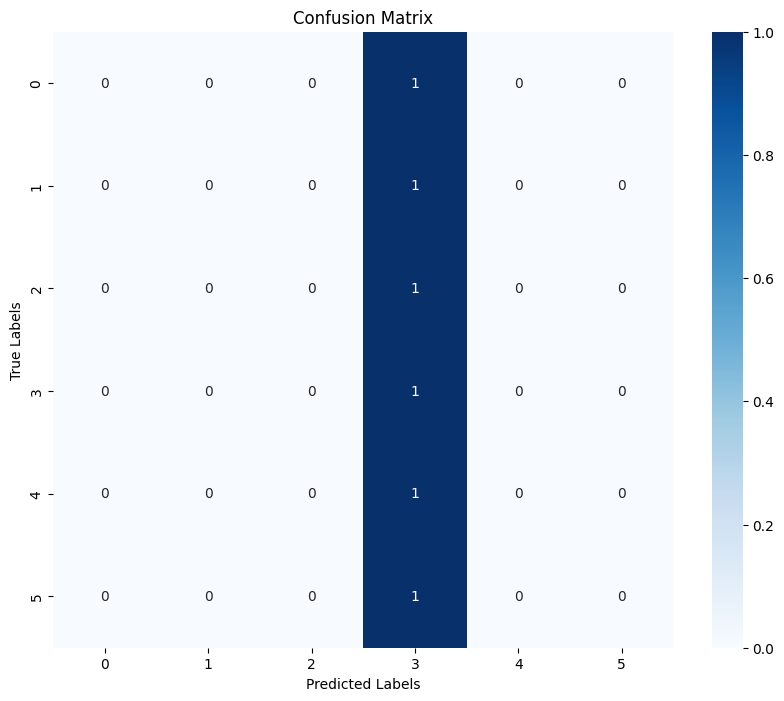

Epoch 11, Validation Loss: 1.7559, Accuracy: 0.3050, F1 Score: 0.1426
Val F1 Score Per Class  [0.         0.         0.         0.46746348 0.         0.        ]


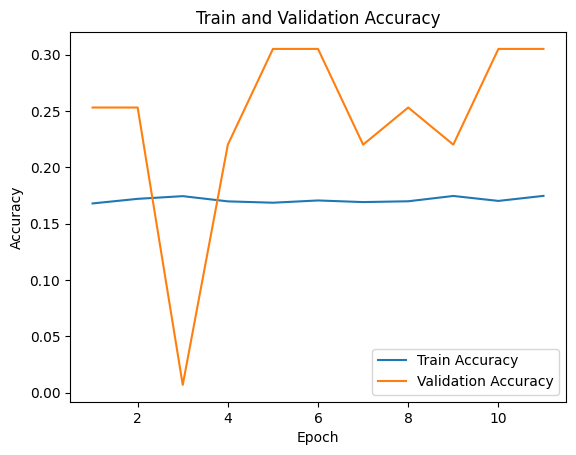

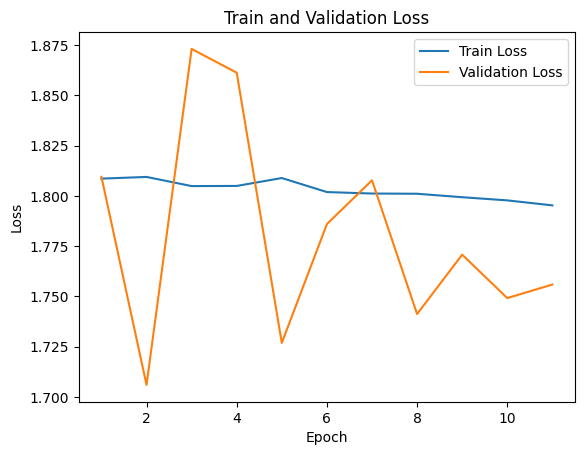

Epoch 12, Train Loss: 1.7855, Accuracy: 0.1961, F1 Score: 0.1693
Train F1 Score Per Class  [0.15021834 0.13146936 0.12829253 0.24956522 0.29807523 0.05235174]


Val:   1%|▏         | 1/73 [00:00<00:30,  2.39it/s, loss=1.83]

[tensor([-0.0405, -0.0662, -0.0551,  0.1354, -0.3164,  0.1658], device='cuda:0'), tensor([-0.1874, -0.1401, -0.0903,  0.0089,  0.0244,  0.0760], device='cuda:0'), tensor([-0.4770, -0.2747, -0.1165, -0.2377,  0.6119, -0.0906], device='cuda:0'), tensor([-0.2557, -0.1643, -0.1260, -0.0383,  0.1667,  0.0344], device='cuda:0'), tensor([-0.0539, -0.0702, -0.0712,  0.1239, -0.2185,  0.1567], device='cuda:0'), tensor([-0.3200, -0.2164, -0.1200, -0.1288,  0.1034, -0.0199], device='cuda:0'), tensor([ 0.0486, -0.0270, -0.0221,  0.2060, -0.4895,  0.2214], device='cuda:0'), tensor([-0.2104, -0.1514, -0.0857, -0.0082,  0.0383,  0.0609], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=1.84]

[tensor([-0.0232, -0.0571, -0.0577,  0.1484, -0.2750,  0.1779], device='cuda:0'), tensor([-0.1591, -0.1190, -0.0957,  0.0400,  0.0244,  0.0923], device='cuda:0'), tensor([-0.2890, -0.1845, -0.1218, -0.0740,  0.2056,  0.0146], device='cuda:0'), tensor([-0.0683, -0.0796, -0.0731,  0.1092, -0.1696,  0.1492], device='cuda:0'), tensor([-0.0534, -0.0682, -0.0812,  0.1244, -0.2157,  0.1552], device='cuda:0'), tensor([-0.1269, -0.0998, -0.1007,  0.0682, -0.2020,  0.1092], device='cuda:0'), tensor([-0.0377, -0.0533, -0.0935,  0.1395, -0.4779,  0.1688], device='cuda:0'), tensor([-0.0414, -0.0671, -0.0582,  0.1335, -0.2138,  0.1645], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.81]

[tensor([ 0.0419, -0.0379, -0.0181,  0.1974, -0.4728,  0.2134], device='cuda:0'), tensor([-0.1038, -0.0969, -0.0798,  0.0824, -0.0160,  0.1252], device='cuda:0'), tensor([-0.0758, -0.0819, -0.0734,  0.1053, -0.1345,  0.1438], device='cuda:0'), tensor([-0.0756, -0.0802, -0.0853,  0.1059, -0.3547,  0.1409], device='cuda:0'), tensor([-0.1468, -0.1081, -0.0997,  0.0531, -0.2799,  0.0983], device='cuda:0'), tensor([-0.0873, -0.0860, -0.0739,  0.0972, -0.1882,  0.1386], device='cuda:0'), tensor([-0.0057, -0.0494, -0.0485,  0.1632, -0.3977,  0.1888], device='cuda:0'), tensor([-0.1396, -0.1001, -0.1122,  0.0615, -0.0269,  0.1021], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.39it/s, loss=1.79]

[tensor([-0.0073, -0.0555, -0.0489,  0.1567, -0.3556,  0.1857], device='cuda:0'), tensor([-0.2332, -0.1617, -0.1244, -0.0382,  0.0692,  0.0538], device='cuda:0'), tensor([ 0.0427, -0.0321, -0.0292,  0.1991, -0.5069,  0.2168], device='cuda:0'), tensor([-0.0014, -0.0507, -0.0439,  0.1646, -0.5616,  0.1900], device='cuda:0'), tensor([-3.3170e-01, -2.3587e-01, -9.6416e-02, -1.2950e-01,  2.9765e-01,
        -5.2388e-05], device='cuda:0'), tensor([ 0.0560, -0.0269, -0.0314,  0.2101, -0.4875,  0.2241], device='cuda:0'), tensor([ 0.0078, -0.0461, -0.0460,  0.1709, -0.4044,  0.1938], device='cuda:0'), tensor([-0.0888, -0.0804, -0.0974,  0.0979, -0.1605,  0.1332], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=1.79]

[tensor([-0.0413, -0.0685, -0.0588,  0.1340, -0.1644,  0.1650], device='cuda:0'), tensor([ 0.0124, -0.0426, -0.0705,  0.1716, -0.4336,  0.1961], device='cuda:0'), tensor([-0.3246, -0.1984, -0.1097, -0.1004,  0.1023, -0.0076], device='cuda:0'), tensor([-0.1322, -0.1075, -0.1066,  0.0617, -0.0245,  0.1052], device='cuda:0'), tensor([-0.0910, -0.0819, -0.1034,  0.0937, -0.2717,  0.1362], device='cuda:0'), tensor([-0.1619, -0.1255, -0.1305,  0.0319,  0.0121,  0.0868], device='cuda:0'), tensor([-0.1319, -0.1057, -0.0889,  0.0620,  0.0392,  0.1109], device='cuda:0'), tensor([-0.2885, -0.1068, -0.2781, -0.0419,  0.6420, -0.0039], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=1.73]

[tensor([-0.1521, -0.1140, -0.0945,  0.0458, -0.2165,  0.0983], device='cuda:0'), tensor([-0.0571, -0.0799, -0.0714,  0.1159, -0.4091,  0.1515], device='cuda:0'), tensor([-0.2215, -0.1382, -0.1495, -0.0031,  0.0762,  0.0529], device='cuda:0'), tensor([ 0.0187, -0.0434, -0.0329,  0.1791, -0.4165,  0.2026], device='cuda:0'), tensor([-0.1067, -0.0968, -0.0743,  0.0824, -0.1637,  0.1237], device='cuda:0'), tensor([-0.1234, -0.1007, -0.1038,  0.0682, -0.1515,  0.1084], device='cuda:0'), tensor([-0.1474, -0.0999, -0.1273,  0.0560, -0.1580,  0.0975], device='cuda:0'), tensor([ 0.0171, -0.0423, -0.0433,  0.1791, -0.4130,  0.2011], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=1.81]

[tensor([-0.0640, -0.0786, -0.0686,  0.1133, -0.3059,  0.1497], device='cuda:0'), tensor([-0.0590, -0.0770, -0.0583,  0.1187, -0.3182,  0.1541], device='cuda:0'), tensor([-0.4152, -0.2594, -0.0955, -0.1924,  0.2577, -0.0547], device='cuda:0'), tensor([-0.5057, -0.2561, -0.1591, -0.2417,  0.8610, -0.1077], device='cuda:0'), tensor([-0.1183, -0.1016, -0.0912,  0.0702, -0.0285,  0.1160], device='cuda:0'), tensor([-0.1643, -0.1313, -0.0888,  0.0258, -0.1058,  0.0887], device='cuda:0'), tensor([-0.0108, -0.0586, -0.0675,  0.1554, -0.3770,  0.1854], device='cuda:0'), tensor([-0.2355, -0.1558, -0.1119, -0.0244,  0.3719,  0.0492], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=1.77]

[tensor([-0.0529, -0.0703, -0.0674,  0.1255, -0.2202,  0.1553], device='cuda:0'), tensor([-0.4294, -0.2613, -0.1478, -0.1993,  0.5732, -0.0683], device='cuda:0'), tensor([-0.1421, -0.1147, -0.1149,  0.0468, -0.1331,  0.0992], device='cuda:0'), tensor([ 0.0016, -0.0533, -0.0426,  0.1632, -0.2835,  0.1914], device='cuda:0'), tensor([-0.0546, -0.0728, -0.0626,  0.1218, -0.2873,  0.1585], device='cuda:0'), tensor([-0.0221, -0.0625, -0.0511,  0.1471, -0.2623,  0.1743], device='cuda:0'), tensor([-0.0209, -0.0558, -0.0470,  0.1517, -0.3323,  0.1815], device='cuda:0'), tensor([-0.0988, -0.0921, -0.0839,  0.0876, -0.3854,  0.1291], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:27,  2.35it/s, loss=1.84]

[tensor([-0.1228, -0.1023, -0.0930,  0.0689, -0.0171,  0.1137], device='cuda:0'), tensor([-0.1765, -0.1280, -0.1100,  0.0193,  0.0561,  0.0837], device='cuda:0'), tensor([-0.1891, -0.1300, -0.1283,  0.0186,  0.2154,  0.0756], device='cuda:0'), tensor([-0.0983, -0.0874, -0.0934,  0.0900, -0.1641,  0.1275], device='cuda:0'), tensor([-0.1405, -0.0973, -0.1629,  0.0547,  0.0639,  0.1012], device='cuda:0'), tensor([-0.0809, -0.0781, -0.0912,  0.1034, -0.2106,  0.1410], device='cuda:0'), tensor([-0.2718, -0.1987, -0.0892, -0.0878,  0.4254,  0.0325], device='cuda:0'), tensor([-0.0989, -0.1028, -0.1123,  0.0849, -0.0718,  0.1284], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:27,  2.32it/s, loss=1.87]

[tensor([-0.1181, -0.0962, -0.1028,  0.0748,  0.0088,  0.1137], device='cuda:0'), tensor([-0.0790, -0.0788, -0.0771,  0.1050, -0.1304,  0.1481], device='cuda:0'), tensor([-0.0496, -0.0704, -0.0661,  0.1277, -0.3905,  0.1594], device='cuda:0'), tensor([-0.1139, -0.0915, -0.1244,  0.0781, -0.1169,  0.1138], device='cuda:0'), tensor([-0.4965, -0.2806, -0.1966, -0.2486,  1.1563, -0.1011], device='cuda:0'), tensor([-0.0675, -0.0788, -0.0891,  0.1128, -0.2830,  0.1463], device='cuda:0'), tensor([-0.5268, -0.2644, -0.2099, -0.2591,  0.3088, -0.1361], device='cuda:0'), tensor([-0.0403, -0.0655, -0.0566,  0.1356, -0.3080,  0.1666], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:27,  2.23it/s, loss=1.82]

[tensor([ 0.0072, -0.0462, -0.0469,  0.1721, -0.3809,  0.1938], device='cuda:0'), tensor([-0.0141, -0.0538, -0.0615,  0.1552, -0.3406,  0.1830], device='cuda:0'), tensor([-0.1073, -0.0865, -0.1080,  0.0854, -0.2549,  0.1210], device='cuda:0'), tensor([-0.0866, -0.0841, -0.0881,  0.0991, -0.4254,  0.1325], device='cuda:0'), tensor([-0.1981, -0.1254, -0.1407,  0.0133, -0.0788,  0.0676], device='cuda:0'), tensor([-0.1922, -0.1443, -0.1400, -0.0012,  0.0626,  0.0750], device='cuda:0'), tensor([-0.4833, -0.2771, -0.1072, -0.2367,  0.4840, -0.0887], device='cuda:0'), tensor([-0.1127, -0.1007, -0.0834,  0.0744, -0.0787,  0.1201], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:26,  2.29it/s, loss=1.76]

[tensor([-0.2192, -0.1593, -0.0990, -0.0234,  0.2724,  0.0619], device='cuda:0'), tensor([ 0.0283, -0.0278, -0.0542,  0.1931, -0.4493,  0.2102], device='cuda:0'), tensor([ 0.0130, -0.0458, -0.0324,  0.1763, -0.4775,  0.1984], device='cuda:0'), tensor([-0.1132, -0.0975, -0.1071,  0.0742, -0.0051,  0.1167], device='cuda:0'), tensor([-0.0871, -0.0945, -0.0669,  0.0922, -0.3505,  0.1335], device='cuda:0'), tensor([-0.0316, -0.0630, -0.0514,  0.1409, -0.2406,  0.1735], device='cuda:0'), tensor([-0.0544, -0.0694, -0.0780,  0.1253, -0.3977,  0.1581], device='cuda:0'), tensor([-0.0815, -0.0805, -0.0870,  0.1036, -0.2740,  0.1372], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:26,  2.28it/s, loss=1.77]

[tensor([-0.0782, -0.0790, -0.0842,  0.1055, -0.2397,  0.1405], device='cuda:0'), tensor([-0.0810, -0.0814, -0.0806,  0.1042, -0.2153,  0.1361], device='cuda:0'), tensor([-1.8554e-01, -1.4855e-01, -7.3051e-02,  8.6427e-06, -1.3782e-01,
         7.5510e-02], device='cuda:0'), tensor([-0.3939, -0.2026, -0.2526, -0.1514,  0.7178, -0.0527], device='cuda:0'), tensor([-0.1474, -0.1169, -0.0903,  0.0454, -0.0003,  0.0951], device='cuda:0'), tensor([-0.0190, -0.0607, -0.0573,  0.1488, -0.2737,  0.1750], device='cuda:0'), tensor([-0.3324, -0.2292, -0.0672, -0.1305, -0.1931, -0.0048], device='cuda:0'), tensor([-0.0706, -0.0759, -0.0782,  0.1111, -0.1718,  0.1489], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:25,  2.33it/s, loss=1.8]

[tensor([-0.1886, -0.1317, -0.1104,  0.0116,  0.0490,  0.0821], device='cuda:0'), tensor([-0.0731, -0.0791, -0.0724,  0.1094, -0.1981,  0.1427], device='cuda:0'), tensor([-0.2515, -0.1521, -0.1491, -0.0334,  0.1532,  0.0368], device='cuda:0'), tensor([ 0.0030, -0.0508, -0.0394,  0.1656, -0.3251,  0.1945], device='cuda:0'), tensor([-0.4832, -0.2753, -0.1137, -0.2416, -0.0116, -0.0877], device='cuda:0'), tensor([-0.1790, -0.1320, -0.1051,  0.0198,  0.1261,  0.0827], device='cuda:0'), tensor([-0.1745, -0.1201, -0.1222,  0.0294, -0.0352,  0.0811], device='cuda:0'), tensor([-0.0138, -0.0533, -0.0532,  0.1562, -0.4557,  0.1818], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.33it/s, loss=1.79]

[tensor([-0.0804, -0.0790, -0.0991,  0.1039, -0.2675,  0.1413], device='cuda:0'), tensor([-0.1217, -0.0980, -0.1176,  0.0696, -0.0048,  0.1083], device='cuda:0'), tensor([-0.1041, -0.0937, -0.0789,  0.0848, -0.3466,  0.1273], device='cuda:0'), tensor([-0.0722, -0.0777, -0.1024,  0.1106, -0.1040,  0.1384], device='cuda:0'), tensor([-0.0242, -0.0620, -0.0487,  0.1436, -0.3231,  0.1763], device='cuda:0'), tensor([-0.1174, -0.1038, -0.0976,  0.0725,  0.0202,  0.1165], device='cuda:0'), tensor([-0.0876, -0.0877, -0.0753,  0.0953, -0.1165,  0.1372], device='cuda:0'), tensor([-0.1652, -0.1312, -0.1264,  0.0286,  0.2534,  0.0855], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.34it/s, loss=1.82]

[tensor([-0.1288, -0.1029, -0.1018,  0.0646, -0.2151,  0.1071], device='cuda:0'), tensor([-0.2121, -0.1424, -0.1125, -0.0068,  0.2016,  0.0629], device='cuda:0'), tensor([-0.3722, -0.2453, -0.0802, -0.1593, -0.1496, -0.0320], device='cuda:0'), tensor([-0.5766, -0.3059, -0.2695, -0.3095,  1.1059, -0.1609], device='cuda:0'), tensor([-0.0925, -0.0866, -0.0895,  0.0956, -0.0697,  0.1317], device='cuda:0'), tensor([-0.0547, -0.0744, -0.0579,  0.1235, -0.2927,  0.1573], device='cuda:0'), tensor([-0.0571, -0.0754, -0.0630,  0.1200, -0.1767,  0.1525], device='cuda:0'), tensor([-0.1257, -0.1042, -0.0895,  0.0663, -0.2049,  0.1105], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.36it/s, loss=1.86]

[tensor([-0.4467, -0.2542, -0.1693, -0.2124,  0.6420, -0.0757], device='cuda:0'), tensor([-0.0771, -0.0891, -0.0750,  0.0989, -0.3277,  0.1384], device='cuda:0'), tensor([-0.0190, -0.0524, -0.0747,  0.1529, -0.3430,  0.1786], device='cuda:0'), tensor([-0.4979, -0.2788, -0.1870, -0.2554,  0.1804, -0.1139], device='cuda:0'), tensor([-0.1022, -0.0914, -0.0793,  0.0863, -0.2472,  0.1295], device='cuda:0'), tensor([-0.0889, -0.0809, -0.0931,  0.0985, -0.2255,  0.1340], device='cuda:0'), tensor([-0.3172, -0.2291, -0.0342, -0.1208,  0.0552, -0.0015], device='cuda:0'), tensor([-0.0662, -0.0812, -0.0649,  0.1126, -0.1272,  0.1496], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.36it/s, loss=1.9]

[tensor([-0.5705, -0.3008, -0.1604, -0.2989,  1.1181, -0.1473], device='cuda:0'), tensor([-0.0037, -0.0543, -0.0517,  0.1595, -0.3768,  0.1858], device='cuda:0'), tensor([-0.4345, -0.2550, -0.2520, -0.2111,  0.7758, -0.0682], device='cuda:0'), tensor([-0.0512, -0.0752, -0.0653,  0.1206, -0.1746,  0.1585], device='cuda:0'), tensor([-0.2533, -0.1591, -0.1215, -0.0380,  0.0035,  0.0369], device='cuda:0'), tensor([-0.0718, -0.0827, -0.0647,  0.1080, -0.2102,  0.1470], device='cuda:0'), tensor([-0.1028, -0.0889, -0.0878,  0.0871, -0.2196,  0.1286], device='cuda:0'), tensor([-0.5399, -0.2939, -0.2039, -0.2823,  0.7497, -0.1401], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.37it/s, loss=1.87]

[tensor([-0.1041, -0.1091, -0.0845,  0.0751, -0.2502,  0.1228], device='cuda:0'), tensor([-0.1769, -0.1230, -0.1151,  0.0260,  0.1413,  0.0790], device='cuda:0'), tensor([-0.2092, -0.1516, -0.1149, -0.0133,  0.3177,  0.0623], device='cuda:0'), tensor([-0.1068, -0.0799, -0.1137,  0.0890, -0.2744,  0.1267], device='cuda:0'), tensor([-0.1919, -0.1355, -0.1353,  0.0132,  0.1966,  0.0732], device='cuda:0'), tensor([-0.1941, -0.1311, -0.1217,  0.0104,  0.0202,  0.0714], device='cuda:0'), tensor([-0.5352, -0.2914, -0.2260, -0.2663,  0.9957, -0.1271], device='cuda:0'), tensor([-0.0656, -0.0835, -0.0627,  0.1110, -0.2012,  0.1450], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=1.81]

[tensor([-0.3545, -0.2186, -0.1974, -0.1445,  0.5566, -0.0242], device='cuda:0'), tensor([-0.1213, -0.1207, -0.1013,  0.0558,  0.1065,  0.1132], device='cuda:0'), tensor([-0.1220, -0.1019, -0.0873,  0.0696, -0.1262,  0.1149], device='cuda:0'), tensor([-0.1107, -0.1008, -0.0844,  0.0754, -0.1874,  0.1191], device='cuda:0'), tensor([-0.0166, -0.0560, -0.0480,  0.1529, -0.4086,  0.1837], device='cuda:0'), tensor([-0.0060, -0.0593, -0.0367,  0.1566, -0.3341,  0.1841], device='cuda:0'), tensor([-0.0563, -0.0666, -0.0834,  0.1242, -0.2335,  0.1563], device='cuda:0'), tensor([-0.0355, -0.0655, -0.0474,  0.1390, -0.2517,  0.1693], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:23,  2.26it/s, loss=1.93]

[tensor([-0.2864, -0.2034, -0.0789, -0.0866, -0.1364,  0.0212], device='cuda:0'), tensor([-0.3415, -0.1494, -0.2310, -0.0924,  0.7619, -0.0305], device='cuda:0'), tensor([-0.0609, -0.0780, -0.0686,  0.1160, -0.3169,  0.1488], device='cuda:0'), tensor([-0.4917, -0.2780, -0.1553, -0.2469,  1.0398, -0.1023], device='cuda:0'), tensor([-0.0346, -0.0646, -0.0523,  0.1388, -0.4445,  0.1692], device='cuda:0'), tensor([-0.3340, -0.2362, -0.0961, -0.1334,  0.7172, -0.0049], device='cuda:0'), tensor([-0.5155, -0.2819, -0.1752, -0.2608,  1.0123, -0.1141], device='cuda:0'), tensor([-0.2262, -0.1539, -0.1216, -0.0257, -0.1217,  0.0498], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:22,  2.29it/s, loss=1.9]

[tensor([-0.0966, -0.0869, -0.0939,  0.0926, -0.0773,  0.1288], device='cuda:0'), tensor([-0.2255, -0.1483, -0.1626, -0.0196, -0.0436,  0.0482], device='cuda:0'), tensor([-0.2199, -0.1440, -0.1335, -0.0066,  0.2022,  0.0558], device='cuda:0'), tensor([ 0.0354, -0.0366, -0.0328,  0.1949, -0.4404,  0.2091], device='cuda:0'), tensor([-0.4828, -0.2801, -0.1462, -0.2403,  0.6806, -0.0901], device='cuda:0'), tensor([-0.3017, -0.1966, -0.1078, -0.0880, -0.0150,  0.0074], device='cuda:0'), tensor([-0.4809, -0.2725, -0.1448, -0.2331,  0.4771, -0.0989], device='cuda:0'), tensor([-0.4225, -0.2555, -0.1321, -0.1981,  0.3162, -0.0620], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.31it/s, loss=1.8]

[tensor([-0.0355, -0.0703, -0.0419,  0.1351, -0.3594,  0.1702], device='cuda:0'), tensor([-0.1091, -0.0927, -0.1105,  0.0818, -0.0939,  0.1170], device='cuda:0'), tensor([ 0.0322, -0.0331, -0.0463,  0.1910, -0.5010,  0.2087], device='cuda:0'), tensor([-0.0669, -0.0694, -0.0815,  0.1193, -0.3145,  0.1484], device='cuda:0'), tensor([-0.1050, -0.0917, -0.0917,  0.0838, -0.0970,  0.1253], device='cuda:0'), tensor([-0.0568, -0.0710, -0.0695,  0.1249, -0.1475,  0.1569], device='cuda:0'), tensor([-0.0170, -0.0579, -0.0524,  0.1524, -0.2666,  0.1798], device='cuda:0'), tensor([-0.2881, -0.1923, -0.1121, -0.0806,  0.3868,  0.0237], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:21,  2.25it/s, loss=1.91]

[tensor([-0.5516, -0.2968, -0.1433, -0.2868,  0.3986, -0.1309], device='cuda:0'), tensor([-0.0396, -0.0648, -0.0627,  0.1355, -0.2944,  0.1651], device='cuda:0'), tensor([ 0.0208, -0.0442, -0.0419,  0.1774, -0.3936,  0.2012], device='cuda:0'), tensor([-0.1530, -0.1220, -0.0941,  0.0378, -0.3212,  0.0952], device='cuda:0'), tensor([-0.1087, -0.0912, -0.0984,  0.0820, -0.0818,  0.1213], device='cuda:0'), tensor([-0.1339, -0.1034, -0.1035,  0.0622, -0.1756,  0.1036], device='cuda:0'), tensor([-0.7197, -0.3382, -0.3211, -0.4093,  1.1185, -0.2396], device='cuda:0'), tensor([-0.4986, -0.2739, -0.1430, -0.2482,  0.2944, -0.1098], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:21,  2.26it/s, loss=1.67]

[tensor([-0.5115, -0.2666, -0.3012, -0.2434,  0.8859, -0.1249], device='cuda:0'), tensor([-0.2581, -0.1633, -0.1397, -0.0440,  0.1736,  0.0271], device='cuda:0'), tensor([-0.0615, -0.0730, -0.1093,  0.1188, -0.3262,  0.1525], device='cuda:0'), tensor([-0.1352, -0.1067, -0.1080,  0.0575, -0.2805,  0.1043], device='cuda:0'), tensor([-0.0333, -0.0670, -0.0560,  0.1343, -0.2100,  0.1729], device='cuda:0'), tensor([ 0.0085, -0.0470, -0.0443,  0.1706, -0.3361,  0.1944], device='cuda:0'), tensor([-0.2478, -0.1683, -0.1134, -0.0404, -0.0451,  0.0406], device='cuda:0'), tensor([-0.3577, -0.2326, -0.0679, -0.1528,  0.4375, -0.0251], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:11<00:20,  2.30it/s, loss=1.73]

[tensor([-0.0650, -0.0761, -0.0813,  0.1141, -0.1239,  0.1462], device='cuda:0'), tensor([-0.0638, -0.0755, -0.0694,  0.1169, -0.2375,  0.1509], device='cuda:0'), tensor([ 0.0229, -0.0383, -0.0445,  0.1832, -0.4635,  0.2051], device='cuda:0'), tensor([-0.1755, -0.1353, -0.1009,  0.0160, -0.1120,  0.0866], device='cuda:0'), tensor([-0.0447, -0.0607, -0.0748,  0.1343, -0.2340,  0.1638], device='cuda:0'), tensor([-0.0028, -0.0512, -0.0466,  0.1642, -0.4421,  0.1857], device='cuda:0'), tensor([-0.1157, -0.0978, -0.0928,  0.0739, -0.0555,  0.1190], device='cuda:0'), tensor([-0.2746, -0.1626, -0.1636, -0.0510,  0.1762,  0.0191], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.31it/s, loss=1.79]

[tensor([-0.0431, -0.0644, -0.0682,  0.1335, -0.4536,  0.1641], device='cuda:0'), tensor([-0.1003, -0.0966, -0.0826,  0.0852, -0.1111,  0.1221], device='cuda:0'), tensor([-0.1576, -0.1162, -0.1139,  0.0384, -0.2972,  0.0918], device='cuda:0'), tensor([-0.1123, -0.0848, -0.1418,  0.0791,  0.1060,  0.1200], device='cuda:0'), tensor([-0.0706, -0.0783, -0.0624,  0.1114, -0.2723,  0.1505], device='cuda:0'), tensor([-0.2409, -0.1622, -0.1099, -0.0302,  0.2326,  0.0432], device='cuda:0'), tensor([-0.1644, -0.1432, -0.0937,  0.0155,  0.0289,  0.0921], device='cuda:0'), tensor([-0.4828, -0.2630, -0.1324, -0.2322,  0.4330, -0.0958], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:12<00:19,  2.34it/s, loss=1.82]

[tensor([-0.1413, -0.1085, -0.0987,  0.0543,  0.1319,  0.1033], device='cuda:0'), tensor([ 0.1020, -0.0011, -0.0387,  0.2465, -0.6518,  0.2484], device='cuda:0'), tensor([-0.3117, -0.1861, -0.1458, -0.0882,  0.0982,  0.0004], device='cuda:0'), tensor([-0.0835, -0.0941, -0.0660,  0.0952, -0.1319,  0.1351], device='cuda:0'), tensor([-0.1576, -0.1115, -0.1395,  0.0389, -0.1446,  0.0876], device='cuda:0'), tensor([-0.2077, -0.1465, -0.1131, -0.0078, -0.1497,  0.0656], device='cuda:0'), tensor([-0.2296, -0.1556, -0.0982, -0.0242, -0.0442,  0.0578], device='cuda:0'), tensor([-0.0587, -0.0730, -0.0588,  0.1220, -0.2125,  0.1558], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.34it/s, loss=1.84]

[tensor([-0.2296, -0.1699, -0.1051, -0.0380,  0.0029,  0.0568], device='cuda:0'), tensor([-0.0732, -0.0761, -0.0838,  0.1101, -0.1974,  0.1437], device='cuda:0'), tensor([-0.4365, -0.2411, -0.1800, -0.1995,  0.0281, -0.0716], device='cuda:0'), tensor([ 0.0353, -0.0357, -0.0305,  0.1930, -0.4613,  0.2113], device='cuda:0'), tensor([-0.1034, -0.0886, -0.0933,  0.0877, -0.0551,  0.1252], device='cuda:0'), tensor([-0.0710, -0.0798, -0.0870,  0.1092, -0.0681,  0.1464], device='cuda:0'), tensor([-0.4939, -0.2789, -0.1223, -0.2451,  0.3256, -0.1005], device='cuda:0'), tensor([-0.0883, -0.0793, -0.0889,  0.1004, -0.2104,  0.1361], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.33it/s, loss=1.85]

[tensor([-0.0735, -0.0753, -0.0801,  0.1110, -0.1777,  0.1425], device='cuda:0'), tensor([-0.4083, -0.2445, -0.1790, -0.1838,  0.4075, -0.0632], device='cuda:0'), tensor([-0.0327, -0.0612, -0.0568,  0.1419, -0.3886,  0.1736], device='cuda:0'), tensor([-0.2094, -0.1422, -0.1099, -0.0031,  0.1232,  0.0610], device='cuda:0'), tensor([ 0.0089, -0.0470, -0.0403,  0.1708, -0.4664,  0.1981], device='cuda:0'), tensor([-0.0687, -0.0732, -0.0933,  0.1117, -0.3498,  0.1469], device='cuda:0'), tensor([-0.2651, -0.1712, -0.1592, -0.0532,  0.2257,  0.0295], device='cuda:0'), tensor([-0.3840, -0.2427, -0.1058, -0.1649,  0.3680, -0.0336], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.35it/s, loss=1.78]

[tensor([-0.0775, -0.0789, -0.0784,  0.1067, -0.2592,  0.1422], device='cuda:0'), tensor([ 0.0198, -0.0432, -0.0345,  0.1804, -0.4059,  0.2038], device='cuda:0'), tensor([-0.0536, -0.0708, -0.0630,  0.1254, -0.2321,  0.1598], device='cuda:0'), tensor([-0.1041, -0.0977, -0.0903,  0.0790, -0.0449,  0.1225], device='cuda:0'), tensor([-0.0577, -0.0714, -0.0642,  0.1222, -0.1930,  0.1566], device='cuda:0'), tensor([-0.1378, -0.1154, -0.1202,  0.0509,  0.0416,  0.1060], device='cuda:0'), tensor([-0.0160, -0.0493, -0.0641,  0.1566, -0.3509,  0.1831], device='cuda:0'), tensor([-0.0271, -0.0583, -0.0709,  0.1434, -0.3819,  0.1713], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.35it/s, loss=1.84]

[tensor([-0.1335, -0.0949, -0.1330,  0.0654, -0.2014,  0.1040], device='cuda:0'), tensor([-0.0431, -0.0672, -0.0583,  0.1325, -0.3197,  0.1661], device='cuda:0'), tensor([-0.0979, -0.0829, -0.0966,  0.0926, -0.2046,  0.1311], device='cuda:0'), tensor([-0.1950, -0.1540, -0.1027, -0.0074,  0.0513,  0.0687], device='cuda:0'), tensor([-0.1135, -0.1049, -0.0854,  0.0718, -0.0687,  0.1157], device='cuda:0'), tensor([ 0.0083, -0.0389, -0.0802,  0.1718, -0.5028,  0.1946], device='cuda:0'), tensor([-0.1292, -0.0970, -0.1297,  0.0660, -0.0796,  0.1047], device='cuda:0'), tensor([ 0.0246, -0.0409, -0.0277,  0.1847, -0.4016,  0.2058], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:14<00:16,  2.37it/s, loss=1.8]

[tensor([-0.1645, -0.1155, -0.1072,  0.0379,  0.0707,  0.0911], device='cuda:0'), tensor([ 0.0476, -0.0325, -0.0301,  0.2015, -0.4685,  0.2187], device='cuda:0'), tensor([ 0.0060, -0.0463, -0.0378,  0.1709, -0.5459,  0.1971], device='cuda:0'), tensor([ 0.0498, -0.0303, -0.0332,  0.2041, -0.4736,  0.2192], device='cuda:0'), tensor([-0.2110, -0.1694, -0.0901, -0.0254,  0.3989,  0.0629], device='cuda:0'), tensor([-0.0437, -0.0559, -0.0963,  0.1349, -0.4397,  0.1619], device='cuda:0'), tensor([-0.1964, -0.1332, -0.1093,  0.0078, -0.0781,  0.0738], device='cuda:0'), tensor([-0.1093, -0.0956, -0.0972,  0.0777, -0.0883,  0.1193], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.35it/s, loss=1.78]

[tensor([-0.0669, -0.0796, -0.0711,  0.1115, -0.2958,  0.1470], device='cuda:0'), tensor([ 0.0251, -0.0392, -0.0491,  0.1850, -0.3916,  0.2062], device='cuda:0'), tensor([-0.0608, -0.0729, -0.0810,  0.1189, -0.2412,  0.1504], device='cuda:0'), tensor([-0.1011, -0.0823, -0.1232,  0.0897, -0.1434,  0.1223], device='cuda:0'), tensor([-0.1963, -0.1218, -0.1468,  0.0183,  0.2658,  0.0680], device='cuda:0'), tensor([-0.0474, -0.0650, -0.0616,  0.1323, -0.2944,  0.1640], device='cuda:0'), tensor([-0.1725, -0.1302, -0.0847,  0.0247,  0.0754,  0.0842], device='cuda:0'), tensor([-0.0752, -0.0747, -0.0984,  0.1064, -0.4479,  0.1455], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:15<00:16,  2.24it/s, loss=1.78]

[tensor([-0.0919, -0.1260, -0.0806,  0.0674, -0.1716,  0.1312], device='cuda:0'), tensor([ 0.0018, -0.0457, -0.0549,  0.1678, -0.4919,  0.1916], device='cuda:0'), tensor([-0.0721, -0.0755, -0.0898,  0.1107, -0.0627,  0.1467], device='cuda:0'), tensor([ 0.0735, -0.0181, -0.0269,  0.2245, -0.5332,  0.2333], device='cuda:0'), tensor([-0.3768, -0.2457, -0.1085, -0.1646,  0.7032, -0.0337], device='cuda:0'), tensor([-0.0018, -0.0501, -0.0400,  0.1657, -0.3217,  0.1908], device='cuda:0'), tensor([-0.0498, -0.0720, -0.0571,  0.1277, -0.2373,  0.1627], device='cuda:0'), tensor([ 0.0442, -0.0317, -0.0260,  0.2012, -0.4684,  0.2167], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:16,  2.25it/s, loss=1.72]

[tensor([-0.0794, -0.0818, -0.0858,  0.1025, -0.1670,  0.1396], device='cuda:0'), tensor([-0.1192, -0.0912, -0.1123,  0.0758, -0.4133,  0.1150], device='cuda:0'), tensor([-0.1457, -0.1126, -0.0877,  0.0495,  0.0024,  0.1003], device='cuda:0'), tensor([-0.0193, -0.0562, -0.0574,  0.1509, -0.4148,  0.1772], device='cuda:0'), tensor([-0.0789, -0.0839, -0.0774,  0.1013, -0.2200,  0.1415], device='cuda:0'), tensor([-0.2432, -0.1856, -0.0747, -0.0523, -0.1725,  0.0481], device='cuda:0'), tensor([-0.0646, -0.0782, -0.0710,  0.1145, -0.2531,  0.1469], device='cuda:0'), tensor([-0.0837, -0.0802, -0.0918,  0.1034, -0.2365,  0.1371], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:16,  2.24it/s, loss=1.87]

[tensor([ 0.0032, -0.0585, -0.0380,  0.1597, -0.3908,  0.1888], device='cuda:0'), tensor([-0.1097, -0.1017, -0.0783,  0.0777, -0.0137,  0.1215], device='cuda:0'), tensor([ 0.0246, -0.0362, -0.0355,  0.1872, -0.4839,  0.2077], device='cuda:0'), tensor([-0.2426, -0.1585, -0.1421, -0.0375,  0.2703,  0.0464], device='cuda:0'), tensor([-0.0774, -0.0844, -0.0738,  0.1032, -0.1302,  0.1402], device='cuda:0'), tensor([-0.0679, -0.0774, -0.0632,  0.1133, -0.1541,  0.1504], device='cuda:0'), tensor([-0.4758, -0.2697, -0.1346, -0.2307,  1.0096, -0.0893], device='cuda:0'), tensor([-0.1976, -0.1584, -0.0889, -0.0121,  0.2084,  0.0693], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:15,  2.30it/s, loss=1.83]

[tensor([-0.3020, -0.1911, -0.0937, -0.0834,  0.3659,  0.0154], device='cuda:0'), tensor([-0.1033, -0.0897, -0.0890,  0.0879,  0.0424,  0.1270], device='cuda:0'), tensor([-0.0683, -0.0856, -0.0546,  0.1088, -0.2316,  0.1449], device='cuda:0'), tensor([-0.2260, -0.1617, -0.1026, -0.0278, -0.0084,  0.0509], device='cuda:0'), tensor([-0.0391, -0.0692, -0.0636,  0.1339, -0.4168,  0.1664], device='cuda:0'), tensor([-0.0388, -0.0634, -0.0572,  0.1379, -0.3677,  0.1667], device='cuda:0'), tensor([-0.0827, -0.0828, -0.0769,  0.1009, -0.1497,  0.1409], device='cuda:0'), tensor([-0.3456, -0.2153, -0.2738, -0.1336,  0.2342, -0.0172], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.31it/s, loss=1.74]

[tensor([-0.0173, -0.0590, -0.0689,  0.1494, -0.3738,  0.1813], device='cuda:0'), tensor([-0.1060, -0.0938, -0.0892,  0.0829, -0.0400,  0.1209], device='cuda:0'), tensor([-0.3652, -0.2217, -0.1559, -0.1395,  0.2516, -0.0269], device='cuda:0'), tensor([-0.0325, -0.0613, -0.0701,  0.1393, -0.2469,  0.1692], device='cuda:0'), tensor([-0.2092, -0.1482, -0.1080, -0.0096,  0.1991,  0.0618], device='cuda:0'), tensor([ 0.0404, -0.0295, -0.0507,  0.1968, -0.4999,  0.2139], device='cuda:0'), tensor([-0.0116, -0.0540, -0.0383,  0.1592, -0.3692,  0.1858], device='cuda:0'), tensor([-0.0139, -0.0570, -0.0454,  0.1533, -0.3208,  0.1828], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:17<00:14,  2.33it/s, loss=1.91]

[tensor([-0.1635, -0.1255, -0.0990,  0.0333,  0.1934,  0.0905], device='cuda:0'), tensor([-0.0004, -0.0520, -0.0428,  0.1653, -0.3931,  0.1915], device='cuda:0'), tensor([-0.1730, -0.1221, -0.1136,  0.0271,  0.1298,  0.0809], device='cuda:0'), tensor([ 0.0460, -0.0324, -0.0378,  0.2001, -0.5158,  0.2181], device='cuda:0'), tensor([-0.1997, -0.1292, -0.1284,  0.0097,  0.0762,  0.0668], device='cuda:0'), tensor([-0.4001, -0.2476, -0.1303, -0.1749,  0.6706, -0.0486], device='cuda:0'), tensor([-0.2906, -0.1944, -0.1067, -0.0867,  0.2342,  0.0176], device='cuda:0'), tensor([-0.1775, -0.1176, -0.1281,  0.0290,  0.0113,  0.0792], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.34it/s, loss=1.86]

[tensor([-0.0592, -0.0708, -0.0757,  0.1232, -0.2118,  0.1547], device='cuda:0'), tensor([-0.4057, -0.2451, -0.1460, -0.1915,  0.3059, -0.0577], device='cuda:0'), tensor([-0.4683, -0.2736, -0.1365, -0.2310,  0.4054, -0.0841], device='cuda:0'), tensor([-0.0258, -0.0623, -0.0490,  0.1449, -0.4367,  0.1728], device='cuda:0'), tensor([-0.0916, -0.0843, -0.0992,  0.0944, -0.3785,  0.1301], device='cuda:0'), tensor([-0.0279, -0.0593, -0.0636,  0.1439, -0.4833,  0.1737], device='cuda:0'), tensor([-0.2058, -0.1398, -0.0928,  0.0017,  0.0833,  0.0677], device='cuda:0'), tensor([-0.3921, -0.2468, -0.0771, -0.1716,  0.3384, -0.0401], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:18<00:13,  2.35it/s, loss=1.73]

[tensor([ 0.0225, -0.0408, -0.0389,  0.1833, -0.4014,  0.2028], device='cuda:0'), tensor([-0.0458, -0.0646, -0.0645,  0.1326, -0.3940,  0.1630], device='cuda:0'), tensor([-0.1965, -0.1403, -0.1043,  0.0042,  0.2112,  0.0696], device='cuda:0'), tensor([ 0.0553, -0.0266, -0.0221,  0.2089, -0.5643,  0.2263], device='cuda:0'), tensor([-0.3756, -0.2500, -0.0957, -0.1607,  0.3021, -0.0231], device='cuda:0'), tensor([-0.3097, -0.1148, -0.2699, -0.0565,  0.6313, -0.0145], device='cuda:0'), tensor([-0.2247, -0.1533, -0.1349, -0.0232, -0.0682,  0.0508], device='cuda:0'), tensor([ 0.0054, -0.0494, -0.0311,  0.1717, -0.4545,  0.1937], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:13,  2.29it/s, loss=1.78]

[tensor([-0.0101, -0.0546, -0.0477,  0.1577, -0.4345,  0.1863], device='cuda:0'), tensor([-0.2318, -0.1748, -0.1041, -0.0446,  0.3901,  0.0523], device='cuda:0'), tensor([-0.1325, -0.1005, -0.1084,  0.0634, -0.1626,  0.1050], device='cuda:0'), tensor([-0.0798, -0.0821, -0.0731,  0.1036, -0.1055,  0.1413], device='cuda:0'), tensor([-0.1089, -0.1030, -0.1009,  0.0790,  0.0579,  0.1204], device='cuda:0'), tensor([-0.0929, -0.0868, -0.0945,  0.0943, -0.0003,  0.1299], device='cuda:0'), tensor([-0.2827, -0.1800, -0.1631, -0.0664,  0.3834,  0.0175], device='cuda:0'), tensor([-0.0905, -0.0882, -0.0776,  0.0953, -0.1355,  0.1305], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.28it/s, loss=1.82]

[tensor([-0.2281, -0.1489, -0.1506, -0.0146,  0.0135,  0.0490], device='cuda:0'), tensor([-0.1820, -0.1356, -0.0843,  0.0165, -0.3007,  0.0788], device='cuda:0'), tensor([-0.1451, -0.1093, -0.1129,  0.0503, -0.0361,  0.0981], device='cuda:0'), tensor([-0.4503, -0.2668, -0.0961, -0.2140,  0.6137, -0.0746], device='cuda:0'), tensor([-0.1796, -0.1688, -0.1090, -0.0061,  0.1684,  0.0738], device='cuda:0'), tensor([-0.2903, -0.2005, -0.1120, -0.0954, -0.0056,  0.0156], device='cuda:0'), tensor([-0.0606, -0.0769, -0.0977,  0.1149, -0.1298,  0.1506], device='cuda:0'), tensor([-0.0171, -0.0625, -0.0494,  0.1510, -0.3151,  0.1765], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:12,  2.31it/s, loss=1.75]

[tensor([-0.0834, -0.0787, -0.0849,  0.1036, -0.2072,  0.1401], device='cuda:0'), tensor([-0.0246, -0.0645, -0.0570,  0.1417, -0.3311,  0.1723], device='cuda:0'), tensor([-0.0020, -0.0492, -0.0435,  0.1653, -0.4946,  0.1904], device='cuda:0'), tensor([-0.2738, -0.1925, -0.1328, -0.0740,  0.0560,  0.0260], device='cuda:0'), tensor([-0.1183, -0.1080, -0.0832,  0.0678, -0.0574,  0.1130], device='cuda:0'), tensor([-0.1051, -0.0917, -0.0926,  0.0841, -0.0375,  0.1256], device='cuda:0'), tensor([-0.0830, -0.0768, -0.0839,  0.1048, -0.2868,  0.1423], device='cuda:0'), tensor([-0.1622, -0.1191, -0.1009,  0.0372,  0.1883,  0.0902], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.31it/s, loss=1.77]

[tensor([-0.2332, -0.1450, -0.1524, -0.0162, -0.0274,  0.0459], device='cuda:0'), tensor([-0.1693, -0.1184, -0.1084,  0.0332,  0.0134,  0.0896], device='cuda:0'), tensor([-0.0084, -0.0509, -0.0641,  0.1581, -0.4221,  0.1827], device='cuda:0'), tensor([-0.0322, -0.0601, -0.0547,  0.1442, -0.3878,  0.1694], device='cuda:0'), tensor([-0.0422, -0.0644, -0.0592,  0.1347, -0.2712,  0.1662], device='cuda:0'), tensor([-0.2537, -0.1779, -0.0969, -0.0461,  0.3331,  0.0407], device='cuda:0'), tensor([-0.1829, -0.1259, -0.1314,  0.0169, -0.1128,  0.0763], device='cuda:0'), tensor([-0.4002, -0.2162, -0.1636, -0.1650,  0.1804, -0.0519], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:20<00:11,  2.30it/s, loss=1.76]

[tensor([-0.0374, -0.0634, -0.0571,  0.1383, -0.3802,  0.1679], device='cuda:0'), tensor([-0.0895, -0.0845, -0.0771,  0.0983, -0.1650,  0.1355], device='cuda:0'), tensor([-0.1863, -0.1503, -0.1027,  0.0024, -0.2035,  0.0771], device='cuda:0'), tensor([-0.1248, -0.1001, -0.0975,  0.0688, -0.2649,  0.1101], device='cuda:0'), tensor([-0.1573, -0.1209, -0.1150,  0.0359, -0.0611,  0.0932], device='cuda:0'), tensor([-0.0016, -0.0471, -0.0493,  0.1668, -0.5086,  0.1891], device='cuda:0'), tensor([-0.1128, -0.0968, -0.0995,  0.0747,  0.0485,  0.1181], device='cuda:0'), tensor([-0.0120, -0.0538, -0.0545,  0.1574, -0.2990,  0.1838], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.32it/s, loss=1.81]

[tensor([-0.0326, -0.0652, -0.0572,  0.1386, -0.1902,  0.1694], device='cuda:0'), tensor([-0.1263, -0.1091, -0.0867,  0.0593, -0.3118,  0.1124], device='cuda:0'), tensor([-0.2972, -0.2185, -0.1012, -0.1149,  0.5202,  0.0090], device='cuda:0'), tensor([-0.0925, -0.0872, -0.0781,  0.0953, -0.0587,  0.1313], device='cuda:0'), tensor([-0.1031, -0.0910, -0.1038,  0.0834, -0.3338,  0.1241], device='cuda:0'), tensor([-0.0457, -0.0675, -0.0552,  0.1321, -0.2066,  0.1654], device='cuda:0'), tensor([-0.0914, -0.0939, -0.0647,  0.0909, -0.2964,  0.1361], device='cuda:0'), tensor([-0.0802, -0.0861, -0.0623,  0.1014, -0.1108,  0.1436], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:21<00:10,  2.32it/s, loss=1.84]

[tensor([-0.0869, -0.0882, -0.0731,  0.0972, -0.4675,  0.1336], device='cuda:0'), tensor([ 0.0079, -0.0443, -0.0403,  0.1732, -0.4338,  0.1973], device='cuda:0'), tensor([-0.1133, -0.0935, -0.0933,  0.0792, -0.2381,  0.1193], device='cuda:0'), tensor([-0.0146, -0.0588, -0.0476,  0.1525, -0.3483,  0.1811], device='cuda:0'), tensor([-0.3102, -0.1860, -0.1568, -0.0877,  0.0419,  0.0030], device='cuda:0'), tensor([-0.0215, -0.0612, -0.0595,  0.1445, -0.3076,  0.1775], device='cuda:0'), tensor([-0.4499, -0.2666, -0.1393, -0.2187,  0.4070, -0.0700], device='cuda:0'), tensor([-0.4367, -0.2612, -0.1272, -0.2141,  0.7131, -0.0684], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.32it/s, loss=1.79]

[tensor([-0.0424, -0.0663, -0.0613,  0.1323, -0.4141,  0.1651], device='cuda:0'), tensor([-0.1419, -0.1149, -0.1171,  0.0504, -0.0375,  0.0963], device='cuda:0'), tensor([-0.0096, -0.0502, -0.0545,  0.1601, -0.3404,  0.1847], device='cuda:0'), tensor([-0.1269, -0.1097, -0.0817,  0.0601,  0.1047,  0.1131], device='cuda:0'), tensor([-0.0921, -0.0914, -0.1242,  0.0865, -0.1939,  0.1321], device='cuda:0'), tensor([-0.1672, -0.1230, -0.1200,  0.0314,  0.0351,  0.0840], device='cuda:0'), tensor([ 0.0596, -0.0234, -0.0418,  0.2132, -0.5437,  0.2270], device='cuda:0'), tensor([-0.2548, -0.1667, -0.1115, -0.0452,  0.2319,  0.0355], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.32it/s, loss=1.82]

[tensor([-0.1511, -0.1125, -0.1058,  0.0477, -0.0795,  0.0963], device='cuda:0'), tensor([-3.1729e-01, -2.0046e-01, -1.0919e-01, -1.0035e-01, -1.5619e-01,
        -1.8096e-04], device='cuda:0'), tensor([-0.0583, -0.0733, -0.0669,  0.1205, -0.1466,  0.1539], device='cuda:0'), tensor([-0.0863, -0.0866, -0.0731,  0.0975, -0.1197,  0.1379], device='cuda:0'), tensor([-0.2393, -0.1506, -0.1434, -0.0281, -0.2566,  0.0426], device='cuda:0'), tensor([-0.0447, -0.0676, -0.0848,  0.1281, -0.3056,  0.1591], device='cuda:0'), tensor([-0.0545, -0.0732, -0.0613,  0.1224, -0.2889,  0.1568], device='cuda:0'), tensor([-0.4731, -0.2590, -0.1322, -0.2209,  0.3795, -0.1009], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:22<00:09,  2.31it/s, loss=1.73]

[tensor([ 0.0071, -0.0515, -0.0759,  0.1662, -0.3523,  0.1936], device='cuda:0'), tensor([-0.0936, -0.0870, -0.0886,  0.0943, -0.0503,  0.1308], device='cuda:0'), tensor([-0.0101, -0.0514, -0.0565,  0.1574, -0.3552,  0.1862], device='cuda:0'), tensor([-0.0932, -0.0898, -0.0793,  0.0917, -0.0573,  0.1338], device='cuda:0'), tensor([ 0.0082, -0.0462, -0.0337,  0.1741, -0.3458,  0.1945], device='cuda:0'), tensor([-0.0765, -0.0793, -0.0878,  0.1053, -0.3174,  0.1410], device='cuda:0'), tensor([-0.1742, -0.1348, -0.1032,  0.0174,  0.0603,  0.0765], device='cuda:0'), tensor([-0.1236, -0.1037, -0.0875,  0.0691, -0.0283,  0.1120], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.31it/s, loss=1.84]

[tensor([-0.4032, -0.2550, -0.0967, -0.1849,  0.6922, -0.0526], device='cuda:0'), tensor([-0.0601, -0.0763, -0.0635,  0.1166, -0.2092,  0.1564], device='cuda:0'), tensor([-0.5163, -0.2799, -0.1552, -0.2592,  0.3925, -0.1124], device='cuda:0'), tensor([-0.3756, -0.2269, -0.2207, -0.1533,  0.7489, -0.0288], device='cuda:0'), tensor([-0.0939, -0.0898, -0.0762,  0.0922, -0.3387,  0.1297], device='cuda:0'), tensor([-0.2955, -0.1991, -0.0832, -0.0860,  0.1952,  0.0199], device='cuda:0'), tensor([-0.0643, -0.0781, -0.0681,  0.1125, -0.2381,  0.1534], device='cuda:0'), tensor([-0.0140, -0.0536, -0.0499,  0.1571, -0.4395,  0.1808], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:23<00:08,  2.29it/s, loss=1.73]

[tensor([-0.0312, -0.0627, -0.0504,  0.1427, -0.3231,  0.1709], device='cuda:0'), tensor([-0.0436, -0.0684, -0.0649,  0.1301, -0.3191,  0.1625], device='cuda:0'), tensor([-0.1134, -0.0909, -0.0999,  0.0799, -0.3315,  0.1206], device='cuda:0'), tensor([-0.1179, -0.0968, -0.0990,  0.0729, -0.0682,  0.1179], device='cuda:0'), tensor([-0.0327, -0.0591, -0.0675,  0.1422, -0.3610,  0.1702], device='cuda:0'), tensor([-0.1980, -0.1332, -0.1144,  0.0088, -0.2181,  0.0648], device='cuda:0'), tensor([-0.3494, -0.2237, -0.0834, -0.1287,  0.0876, -0.0227], device='cuda:0'), tensor([-0.1014, -0.0931, -0.0815,  0.0855, -0.2988,  0.1277], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:08,  2.16it/s, loss=1.91]

[tensor([-0.3678, -0.2386, -0.0960, -0.1547, -0.0093, -0.0286], device='cuda:0'), tensor([-0.1220, -0.1075, -0.0840,  0.0666,  0.1074,  0.1148], device='cuda:0'), tensor([-0.1883, -0.1412, -0.1297,  0.0032,  0.2563,  0.0771], device='cuda:0'), tensor([-0.4618, -0.2721, -0.1062, -0.2246,  0.9752, -0.0848], device='cuda:0'), tensor([-0.1472, -0.1127, -0.0945,  0.0496,  0.1190,  0.0977], device='cuda:0'), tensor([-0.1556, -0.1392, -0.0998,  0.0262,  0.1317,  0.0933], device='cuda:0'), tensor([-0.3221, -0.2294, -0.0963, -0.1239,  0.0816,  0.0083], device='cuda:0'), tensor([ 0.0122, -0.0406, -0.0453,  0.1766, -0.4635,  0.2006], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:24<00:07,  2.18it/s, loss=1.82]

[tensor([ 0.0155, -0.0465, -0.0348,  0.1749, -0.4615,  0.1999], device='cuda:0'), tensor([-0.0884, -0.0858, -0.0811,  0.0982, -0.1661,  0.1337], device='cuda:0'), tensor([-0.0374, -0.0660, -0.0522,  0.1365, -0.2969,  0.1683], device='cuda:0'), tensor([-0.0929, -0.0824, -0.0972,  0.0968, -0.2865,  0.1295], device='cuda:0'), tensor([-0.1611, -0.1276, -0.1049,  0.0279, -0.1904,  0.0838], device='cuda:0'), tensor([-0.4033, -0.2401, -0.2080, -0.1706,  0.6815, -0.0627], device='cuda:0'), tensor([-0.0667, -0.0727, -0.0720,  0.1182, -0.1574,  0.1515], device='cuda:0'), tensor([-0.2117, -0.1581, -0.1070, -0.0187, -0.0023,  0.0619], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:07,  2.21it/s, loss=1.84]

[tensor([-0.4464, -0.2488, -0.1573, -0.2042,  0.2490, -0.0755], device='cuda:0'), tensor([ 0.0156, -0.0431, -0.0415,  0.1779, -0.3885,  0.1990], device='cuda:0'), tensor([-0.0183, -0.0604, -0.0489,  0.1488, -0.3673,  0.1795], device='cuda:0'), tensor([ 0.0138, -0.0447, -0.0378,  0.1764, -0.3691,  0.1989], device='cuda:0'), tensor([-0.0502, -0.0789, -0.0619,  0.1218, -0.1110,  0.1560], device='cuda:0'), tensor([-0.1045, -0.0945, -0.0902,  0.0825, -0.1349,  0.1231], device='cuda:0'), tensor([-0.5062, -0.2573, -0.2378, -0.2365,  0.3693, -0.1213], device='cuda:0'), tensor([-0.4599, -0.2689, -0.1335, -0.2183,  0.7247, -0.0782], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:25<00:06,  2.25it/s, loss=1.79]

[tensor([-0.3036, -0.1998, -0.1214, -0.0953, -0.0923,  0.0119], device='cuda:0'), tensor([-0.1062, -0.1129, -0.0901,  0.0694, -0.0909,  0.1264], device='cuda:0'), tensor([-0.1352, -0.1107, -0.1064,  0.0522, -0.3934,  0.1048], device='cuda:0'), tensor([-0.0957, -0.0965, -0.0969,  0.0873, -0.0557,  0.1286], device='cuda:0'), tensor([-0.1210, -0.0938, -0.1035,  0.0751,  0.0108,  0.1128], device='cuda:0'), tensor([-0.1135, -0.0940, -0.0981,  0.0776, -0.0225,  0.1190], device='cuda:0'), tensor([-0.0966, -0.0948, -0.0809,  0.0859, -0.1971,  0.1272], device='cuda:0'), tensor([-0.2504, -0.1463, -0.1555, -0.0285,  0.1274,  0.0357], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:25<00:06,  2.26it/s, loss=1.84]

[tensor([-0.0547, -0.0662, -0.0912,  0.1241, -0.4102,  0.1522], device='cuda:0'), tensor([-0.1258, -0.1112, -0.0823,  0.0613,  0.1362,  0.1124], device='cuda:0'), tensor([-0.0410, -0.0627, -0.0660,  0.1345, -0.3074,  0.1693], device='cuda:0'), tensor([-0.1947, -0.1515, -0.0883, -0.0030,  0.0390,  0.0713], device='cuda:0'), tensor([-0.3982, -0.2402, -0.1342, -0.1732,  0.2451, -0.0500], device='cuda:0'), tensor([-0.3225, -0.2112, -0.0844, -0.1093,  0.2228, -0.0090], device='cuda:0'), tensor([-0.0958, -0.0865, -0.0984,  0.0907, -0.2650,  0.1299], device='cuda:0'), tensor([-0.0292, -0.0582, -0.0606,  0.1449, -0.4029,  0.1754], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.27it/s, loss=1.79]

[tensor([-0.0919, -0.0954, -0.0734,  0.0902, -0.4111,  0.1303], device='cuda:0'), tensor([-0.0311, -0.0615, -0.0811,  0.1435, -0.3007,  0.1682], device='cuda:0'), tensor([-0.0725, -0.0822, -0.0676,  0.1070, -0.1047,  0.1472], device='cuda:0'), tensor([-3.1265e-01, -1.9923e-01, -1.1530e-01, -9.7777e-02,  1.4319e-01,
         5.0349e-05], device='cuda:0'), tensor([-0.2388, -0.1961, -0.0948, -0.0588, -0.0243,  0.0374], device='cuda:0'), tensor([-0.0341, -0.0655, -0.0631,  0.1390, -0.2947,  0.1703], device='cuda:0'), tensor([ 0.0005, -0.0571, -0.0344,  0.1618, -0.3436,  0.1916], device='cuda:0'), tensor([-0.0051, -0.0522, -0.0601,  0.1606, -0.4049,  0.1870], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:26<00:05,  2.31it/s, loss=1.79]

[tensor([-0.0559, -0.0717, -0.0677,  0.1234, -0.1051,  0.1550], device='cuda:0'), tensor([ 0.0264, -0.0363, -0.0447,  0.1869, -0.4661,  0.2057], device='cuda:0'), tensor([-0.2209, -0.1378, -0.1400, -0.0081,  0.0568,  0.0542], device='cuda:0'), tensor([-0.0904, -0.0920, -0.0790,  0.0918, -0.1417,  0.1315], device='cuda:0'), tensor([-0.0259, -0.0588, -0.0538,  0.1465, -0.3295,  0.1762], device='cuda:0'), tensor([-0.1141, -0.0911, -0.1012,  0.0797, -0.1501,  0.1189], device='cuda:0'), tensor([ 0.0063, -0.0473, -0.0540,  0.1676, -0.4009,  0.1919], device='cuda:0'), tensor([ 0.0082, -0.0424, -0.0527,  0.1753, -0.3597,  0.1971], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.33it/s, loss=1.86]

[tensor([-0.1575, -0.1318, -0.0780,  0.0296, -0.0052,  0.0903], device='cuda:0'), tensor([-0.0403, -0.0650, -0.0667,  0.1334, -0.3776,  0.1674], device='cuda:0'), tensor([-0.0918, -0.0859, -0.0925,  0.0986, -0.0470,  0.1338], device='cuda:0'), tensor([-0.1595, -0.1309, -0.0784,  0.0331, -0.2760,  0.0920], device='cuda:0'), tensor([-0.1058, -0.0961, -0.0886,  0.0810,  0.0050,  0.1222], device='cuda:0'), tensor([-0.0271, -0.0602, -0.0529,  0.1452, -0.3554,  0.1749], device='cuda:0'), tensor([-0.2820, -0.1898, -0.1186, -0.0757,  0.4188,  0.0225], device='cuda:0'), tensor([-0.0080, -0.0528, -0.0544,  0.1580, -0.4401,  0.1847], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:27<00:04,  2.34it/s, loss=1.81]

[tensor([-0.2650, -0.1782, -0.1162, -0.0590,  0.3946,  0.0316], device='cuda:0'), tensor([-0.1010, -0.0895, -0.0854,  0.0885, -0.2087,  0.1284], device='cuda:0'), tensor([-0.0781, -0.0839, -0.0667,  0.1025, -0.1945,  0.1458], device='cuda:0'), tensor([-0.4125, -0.2536, -0.1282, -0.1910,  0.9590, -0.0529], device='cuda:0'), tensor([-0.0675, -0.0794, -0.0712,  0.1118, -0.3487,  0.1459], device='cuda:0'), tensor([-0.2524, -0.1834, -0.0962, -0.0597,  0.1935,  0.0367], device='cuda:0'), tensor([-0.0714, -0.0760, -0.0876,  0.1130, -0.2158,  0.1438], device='cuda:0'), tensor([-0.2344, -0.1665, -0.0874, -0.0327,  0.0327,  0.0463], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.35it/s, loss=1.83]

[tensor([-0.2710, -0.1689, -0.1369, -0.0560,  0.0879,  0.0257], device='cuda:0'), tensor([-0.0152, -0.0537, -0.0503,  0.1562, -0.3310,  0.1849], device='cuda:0'), tensor([-0.1370, -0.1050, -0.1023,  0.0586, -0.0219,  0.1064], device='cuda:0'), tensor([-0.0453, -0.0689, -0.0588,  0.1293, -0.3650,  0.1653], device='cuda:0'), tensor([-0.1931, -0.1511, -0.0879, -0.0004, -0.0448,  0.0744], device='cuda:0'), tensor([-0.0573, -0.0740, -0.0616,  0.1201, -0.2542,  0.1577], device='cuda:0'), tensor([-0.1974, -0.1348, -0.1217,  0.0089,  0.0661,  0.0716], device='cuda:0'), tensor([-0.0983, -0.0881, -0.1142,  0.0869, -0.0484,  0.1257], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:28<00:03,  2.36it/s, loss=1.73]

[tensor([-0.4826, -0.2619, -0.3107, -0.2537, -0.4112, -0.1099], device='cuda:0'), tensor([-0.1737, -0.1320, -0.1059,  0.0200,  0.0595,  0.0850], device='cuda:0'), tensor([-0.0892, -0.0869, -0.0805,  0.0960, -0.0395,  0.1331], device='cuda:0'), tensor([-0.0554, -0.0744, -0.0594,  0.1216, -0.1694,  0.1552], device='cuda:0'), tensor([-0.0988, -0.0929, -0.0795,  0.0871, -0.0961,  0.1275], device='cuda:0'), tensor([-0.1254, -0.1013, -0.0923,  0.0686,  0.0295,  0.1125], device='cuda:0'), tensor([-0.0345, -0.0660, -0.0480,  0.1380, -0.3309,  0.1711], device='cuda:0'), tensor([ 0.0059, -0.0499, -0.0476,  0.1677, -0.4088,  0.1900], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:28<00:02,  2.37it/s, loss=1.76]

[tensor([-0.0688, -0.0824, -0.0671,  0.1077, -0.0635,  0.1488], device='cuda:0'), tensor([-0.1848, -0.1339, -0.0966,  0.0147,  0.1880,  0.0763], device='cuda:0'), tensor([ 0.0073, -0.0496, -0.0338,  0.1727, -0.3704,  0.1952], device='cuda:0'), tensor([-0.0410, -0.0607, -0.0712,  0.1380, -0.2190,  0.1663], device='cuda:0'), tensor([-0.4103, -0.2272, -0.1869, -0.1742,  0.1498, -0.0458], device='cuda:0'), tensor([-0.0526, -0.0709, -0.0623,  0.1253, -0.1743,  0.1578], device='cuda:0'), tensor([-0.0426, -0.0700, -0.0589,  0.1307, -0.3821,  0.1646], device='cuda:0'), tensor([-0.2697, -0.1822, -0.1055, -0.0620,  0.2731,  0.0308], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.36it/s, loss=1.82]

[tensor([-0.0401, -0.0670, -0.0479,  0.1356, -0.2306,  0.1665], device='cuda:0'), tensor([-0.1336, -0.1040, -0.1014,  0.0621, -0.0751,  0.1070], device='cuda:0'), tensor([-0.0848, -0.0869, -0.0755,  0.0974, -0.2203,  0.1373], device='cuda:0'), tensor([-0.3474, -0.2065, -0.1424, -0.1174,  0.4771, -0.0186], device='cuda:0'), tensor([-0.3048, -0.1961, -0.0944, -0.0888,  0.2960,  0.0118], device='cuda:0'), tensor([-0.1908, -0.1488, -0.0859, -0.0029,  0.0853,  0.0793], device='cuda:0'), tensor([-0.2273, -0.1442, -0.1317, -0.0156,  0.1686,  0.0509], device='cuda:0'), tensor([-0.3841, -0.2453, -0.0952, -0.1597,  0.5530, -0.0339], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:29<00:02,  2.38it/s, loss=1.78]

[tensor([-0.0313, -0.0609, -0.0616,  0.1416, -0.3681,  0.1711], device='cuda:0'), tensor([-0.1580, -0.1210, -0.1006,  0.0355,  0.1052,  0.0945], device='cuda:0'), tensor([-0.0406, -0.0627, -0.0669,  0.1358, -0.1676,  0.1669], device='cuda:0'), tensor([ 0.0093, -0.0495, -0.0308,  0.1758, -0.4231,  0.1974], device='cuda:0'), tensor([-0.3029, -0.1858, -0.1630, -0.0793,  0.2353,  0.0026], device='cuda:0'), tensor([-0.0253, -0.0602, -0.0494,  0.1463, -0.3850,  0.1761], device='cuda:0'), tensor([-0.0726, -0.0762, -0.0755,  0.1103, -0.2990,  0.1485], device='cuda:0'), tensor([-0.1347, -0.1113, -0.0932,  0.0559, -0.0675,  0.1048], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.38it/s, loss=1.78]

[tensor([-0.1184, -0.1010, -0.0884,  0.0721, -0.0558,  0.1154], device='cuda:0'), tensor([-0.1301, -0.1073, -0.0881,  0.0619,  0.0145,  0.1103], device='cuda:0'), tensor([ 0.0176, -0.0450, -0.0359,  0.1783, -0.3511,  0.2022], device='cuda:0'), tensor([-0.0800, -0.0792, -0.0924,  0.1045, -0.2892,  0.1364], device='cuda:0'), tensor([-0.0569, -0.0729, -0.0666,  0.1229, -0.1515,  0.1543], device='cuda:0'), tensor([-0.1757, -0.1232, -0.1254,  0.0251, -0.0796,  0.0770], device='cuda:0'), tensor([-0.2678, -0.1997, -0.0790, -0.0773,  0.2465,  0.0342], device='cuda:0'), tensor([-0.0944, -0.0728, -0.1345,  0.0984, -0.2943,  0.1286], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:30<00:01,  2.39it/s, loss=1.78]

[tensor([ 0.0413, -0.0328, -0.0306,  0.1980, -0.4274,  0.2159], device='cuda:0'), tensor([-0.2335, -0.1532, -0.1050, -0.0239,  0.0184,  0.0526], device='cuda:0'), tensor([-0.0467, -0.0710, -0.0607,  0.1290, -0.2700,  0.1609], device='cuda:0'), tensor([-0.1430, -0.1061, -0.1037,  0.0555,  0.0759,  0.1011], device='cuda:0'), tensor([-0.1006, -0.0990, -0.0914,  0.0830, -0.3948,  0.1249], device='cuda:0'), tensor([-0.0438, -0.0626, -0.0623,  0.1349, -0.4336,  0.1667], device='cuda:0'), tensor([-0.0557, -0.0692, -0.0809,  0.1257, -0.1686,  0.1545], device='cuda:0'), tensor([-0.3698, -0.2293, -0.1174, -0.1487,  0.6757, -0.0210], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.38it/s, loss=1.79]

[tensor([-0.3382, -0.2160, -0.1232, -0.1235,  0.6275, -0.0119], device='cuda:0'), tensor([-0.1840, -0.1404, -0.1064,  0.0051,  0.0309,  0.0795], device='cuda:0'), tensor([-0.0620, -0.0739, -0.0642,  0.1185, -0.1000,  0.1535], device='cuda:0'), tensor([-0.1152, -0.0916, -0.1180,  0.0784,  0.0423,  0.1152], device='cuda:0'), tensor([-0.3185, -0.1729, -0.1898, -0.0812, -0.0485, -0.0066], device='cuda:0'), tensor([ 0.0481, -0.0297, -0.0355,  0.2037, -0.4730,  0.2212], device='cuda:0'), tensor([-0.0434, -0.0675, -0.0763,  0.1309, -0.2428,  0.1608], device='cuda:0'), tensor([ 0.0076, -0.0445, -0.0452,  0.1736, -0.4776,  0.1942], device='cuda:0')]


[tensor([-0.2376, -0.1850, -0.1511, -0.0490,  0.2387,  0.0494], device='cuda:0'), tensor([-0.1830, -0.1383, -0.0801,  0.0146, -0.0756,  0.0765], device='cuda:0'), tensor([-0.4529, -0.2403, -0.1966, -0.1942, -0.0757, -0.0874], device='cuda:0'), tensor([-0.2212, -0.1573, -0.1160, -0.0221,  0.1795,  0.0533], device='cuda:0'), tensor([-0.1351, -0.1152, -0.1022,  0.0494, -0.0871,  0.1015], device='cuda:0'), tensor([-0.0129, -0.0550, -0.0396,  0.1568, -0.4197,  0.1854], device='cuda:0'), tensor([-0.1360, -0.1087, -0.0933,  0.0565, -0.0743,  0.1059], device='cuda:0'), tensor([-0.1462, -0.1098, -0.1064,  0.0507,  0.1128,  0.1001], device='cuda:0')]
[tensor([-0.1637, -0.1222, -0.1097,  0.0313, -0.0276,  0.0917], device='cuda:0')]


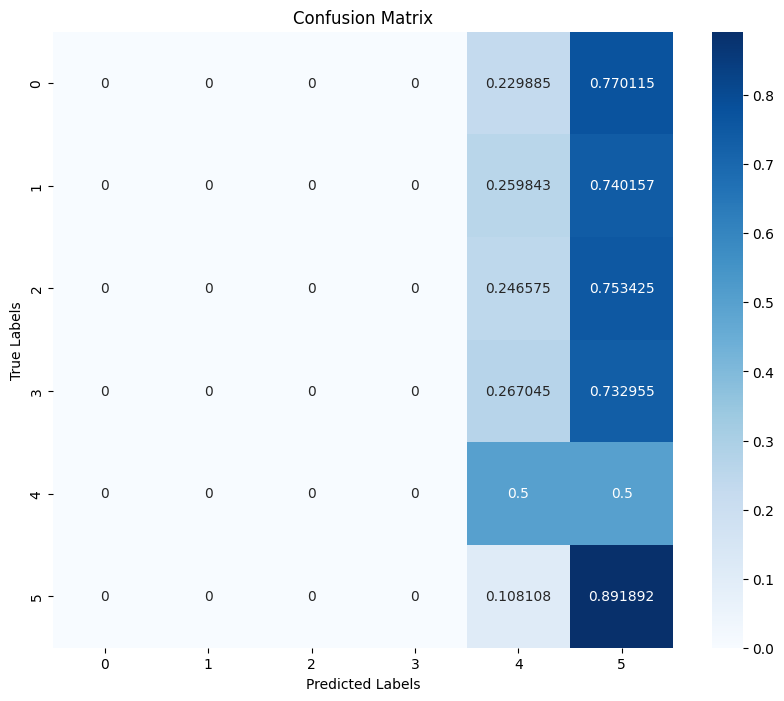

Epoch 12, Validation Loss: 1.8077, Accuracy: 0.0607, F1 Score: 0.0092
Val F1 Score Per Class  [0.         0.         0.         0.         0.02739726 0.13983051]


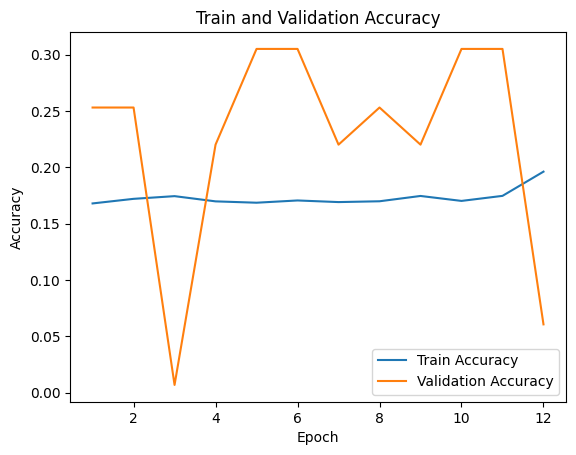

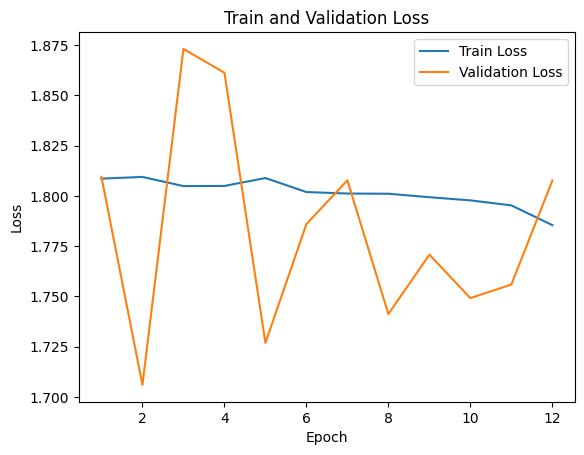

Epoch 13, Train Loss: 1.7780, Accuracy: 0.2058, F1 Score: 0.1724
Train F1 Score Per Class  [0.18704688 0.11707945 0.0917494  0.2636445  0.32573517 0.04396516]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.41it/s, loss=1.72]

[tensor([ 0.0709,  0.0474, -0.0036,  0.2131, -0.5779,  0.0530], device='cuda:0'), tensor([-0.1401,  0.0238, -0.1053,  0.1226, -0.2427, -0.0526], device='cuda:0'), tensor([-0.3617,  0.0099, -0.2390,  0.0395,  0.1133, -0.1732], device='cuda:0'), tensor([-0.0512,  0.0262, -0.0532,  0.1508, -0.2108, -0.0078], device='cuda:0'), tensor([ 0.0404,  0.0413, -0.0149,  0.1950, -0.5471,  0.0362], device='cuda:0'), tensor([-0.2151,  0.0160, -0.1580,  0.0872, -0.1273, -0.0986], device='cuda:0'), tensor([ 0.2073,  0.0712,  0.0476,  0.2778, -0.8155,  0.1180], device='cuda:0'), tensor([-0.1342,  0.0204, -0.1014,  0.1179, -0.1449, -0.0510], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=1.75]

[tensor([ 0.0913,  0.0510,  0.0048,  0.2223, -0.5617,  0.0626], device='cuda:0'), tensor([-0.0219,  0.0295, -0.0365,  0.1646, -0.3523,  0.0079], device='cuda:0'), tensor([-0.1505,  0.0091, -0.0938,  0.1022,  0.0151, -0.0574], device='cuda:0'), tensor([ 0.0677,  0.0477, -0.0059,  0.2108, -0.4897,  0.0508], device='cuda:0'), tensor([ 0.0542,  0.0457, -0.0145,  0.2038, -0.4944,  0.0432], device='cuda:0'), tensor([ 0.0059,  0.0342, -0.0297,  0.1781, -0.4804,  0.0201], device='cuda:0'), tensor([ 0.1035,  0.0523,  0.0052,  0.2244, -0.7646,  0.0658], device='cuda:0'), tensor([ 0.0841,  0.0504, -0.0020,  0.2193, -0.4659,  0.0589], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.77]

[tensor([ 0.1448,  0.0610,  0.0222,  0.2486, -0.7102,  0.0879], device='cuda:0'), tensor([-0.0302,  0.0336, -0.0504,  0.1644, -0.2710,  0.0016], device='cuda:0'), tensor([ 0.0324,  0.0413, -0.0183,  0.1945, -0.4302,  0.0345], device='cuda:0'), tensor([-0.0140,  0.0344, -0.0429,  0.1699, -0.5296,  0.0090], device='cuda:0'), tensor([-0.0848,  0.0215, -0.0673,  0.1360, -0.4162, -0.0246], device='cuda:0'), tensor([ 0.0503,  0.0463, -0.0182,  0.2039, -0.4563,  0.0432], device='cuda:0'), tensor([ 0.1311,  0.0590,  0.0178,  0.2425, -0.6028,  0.0817], device='cuda:0'), tensor([-0.0460,  0.0272, -0.0494,  0.1553, -0.3118, -0.0048], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.68]

[tensor([ 0.0661,  0.0493, -0.0152,  0.2089, -0.5993,  0.0472], device='cuda:0'), tensor([-0.1183,  0.0241, -0.0985,  0.1242, -0.4011, -0.0434], device='cuda:0'), tensor([ 0.1962,  0.0694,  0.0414,  0.2723, -0.8252,  0.1124], device='cuda:0'), tensor([ 0.1383,  0.0586,  0.0223,  0.2447, -0.8246,  0.0851], device='cuda:0'), tensor([-0.3344,  0.0143, -0.2272,  0.0536,  0.0796, -0.1596], device='cuda:0'), tensor([ 0.2082,  0.0699,  0.0429,  0.2771, -0.8113,  0.1173], device='cuda:0'), tensor([ 0.1442,  0.0602,  0.0234,  0.2476, -0.6859,  0.0877], device='cuda:0'), tensor([-0.0100,  0.0317, -0.0345,  0.1692, -0.4657,  0.0110], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.40it/s, loss=1.75]

[tensor([ 0.0807,  0.0511, -0.0016,  0.2197, -0.4610,  0.0583], device='cuda:0'), tensor([ 0.1732,  0.0647,  0.0244,  0.2558, -0.7349,  0.0975], device='cuda:0'), tensor([-0.1525,  0.0167, -0.1141,  0.1051, -0.1367, -0.0648], device='cuda:0'), tensor([-0.0674,  0.0321, -0.0707,  0.1523, -0.3067, -0.0158], device='cuda:0'), tensor([ 0.0479,  0.0450, -0.0146,  0.2019, -0.5764,  0.0412], device='cuda:0'), tensor([-0.0602,  0.0246, -0.0592,  0.1453, -0.2470, -0.0140], device='cuda:0'), tensor([-0.0606,  0.0287, -0.0602,  0.1524, -0.2729, -0.0108], device='cuda:0'), tensor([-0.4959, -0.0807, -0.2235, -0.0913,  0.9817, -0.2423], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.40it/s, loss=1.67]

[tensor([-0.0362,  0.0288, -0.0445,  0.1595, -0.4971,  0.0006], device='cuda:0'), tensor([ 0.0464,  0.0446, -0.0186,  0.1982, -0.7608,  0.0388], device='cuda:0'), tensor([-0.0961,  0.0176, -0.0698,  0.1287, -0.1940, -0.0296], device='cuda:0'), tensor([ 0.1607,  0.0629,  0.0333,  0.2570, -0.6860,  0.0977], device='cuda:0'), tensor([ 0.0021,  0.0358, -0.0301,  0.1787, -0.4163,  0.0189], device='cuda:0'), tensor([-3.3006e-02,  2.7919e-02, -4.7636e-02,  1.5908e-01, -2.7753e-01,
        -9.1577e-05], device='cuda:0'), tensor([ 0.0119,  0.0377, -0.0248,  0.1840, -0.4558,  0.0250], device='cuda:0'), tensor([ 0.1695,  0.0652,  0.0304,  0.2599, -0.6758,  0.0991], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.41it/s, loss=1.73]

[tensor([ 0.0500,  0.0446, -0.0142,  0.2020, -0.5530,  0.0414], device='cuda:0'), tensor([ 0.0805,  0.0505, -0.0020,  0.2185, -0.5211,  0.0576], device='cuda:0'), tensor([-0.2156,  0.0084, -0.1356,  0.0810, -0.0806, -0.0910], device='cuda:0'), tensor([-0.7462, -0.0322, -0.4210, -0.1128,  0.3482, -0.3686], device='cuda:0'), tensor([-0.0166,  0.0337, -0.0393,  0.1707, -0.3000,  0.0098], device='cuda:0'), tensor([-0.0946,  0.0232, -0.0821,  0.1327, -0.4070, -0.0316], device='cuda:0'), tensor([ 0.1226,  0.0592,  0.0128,  0.2398, -0.7176,  0.0779], device='cuda:0'), tensor([-0.1417,  0.0156, -0.0935,  0.1130, -0.0226, -0.0508], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.40it/s, loss=1.67]

[tensor([ 0.0412,  0.0413, -0.0137,  0.1969, -0.4749,  0.0375], device='cuda:0'), tensor([-0.4902,  0.0109, -0.3314,  0.0019,  0.3494, -0.2485], device='cuda:0'), tensor([-0.0563,  0.0254, -0.0592,  0.1461, -0.4726, -0.0124], device='cuda:0'), tensor([ 0.1231,  0.0579,  0.0160,  0.2394, -0.6044,  0.0787], device='cuda:0'), tensor([ 9.3789e-02,  5.2836e-02,  3.9124e-04,  2.2319e-01, -6.3897e-01,
         6.2135e-02], device='cuda:0'), tensor([ 0.1036,  0.0535,  0.0070,  0.2292, -0.5419,  0.0692], device='cuda:0'), tensor([ 0.1224,  0.0579,  0.0166,  0.2393, -0.5874,  0.0803], device='cuda:0'), tensor([ 0.0256,  0.0404, -0.0255,  0.1886, -0.6742,  0.0291], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=1.76]

[tensor([-0.0179,  0.0356, -0.0444,  0.1718, -0.3281,  0.0092], device='cuda:0'), tensor([-0.0746,  0.0294, -0.0834,  0.1454, -0.2726, -0.0243], device='cuda:0'), tensor([-0.1154,  0.0183, -0.0820,  0.1232, -0.1405, -0.0397], device='cuda:0'), tensor([-0.0184,  0.0324, -0.0391,  0.1689, -0.3173,  0.0088], device='cuda:0'), tensor([-0.0213,  0.0311, -0.0512,  0.1604, -0.2678,  0.0046], device='cuda:0'), tensor([ 0.0360,  0.0429, -0.0207,  0.1957, -0.4925,  0.0347], device='cuda:0'), tensor([-0.1345,  0.0229, -0.1332,  0.1187,  0.0811, -0.0586], device='cuda:0'), tensor([-0.0078,  0.0373, -0.0529,  0.1774, -0.3535,  0.0106], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.41it/s, loss=1.71]

[tensor([-0.0383,  0.0307, -0.0496,  0.1606, -0.2708, -0.0012], device='cuda:0'), tensor([ 0.0507,  0.0469, -0.0184,  0.2037, -0.4054,  0.0411], device='cuda:0'), tensor([ 0.0653,  0.0472, -0.0050,  0.2113, -0.6362,  0.0505], device='cuda:0'), tensor([-0.0836,  0.0221, -0.0670,  0.1369, -0.2910, -0.0231], device='cuda:0'), tensor([-0.2479,  0.0020, -0.1549,  0.0653,  0.2754, -0.1081], device='cuda:0'), tensor([ 0.0299,  0.0425, -0.0240,  0.1928, -0.5625,  0.0320], device='cuda:0'), tensor([-0.7784, -0.0353, -0.4600, -0.1278,  0.0191, -0.3976], device='cuda:0'), tensor([ 0.0784,  0.0475,  0.0043,  0.2159, -0.6462,  0.0586], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=1.81]

[tensor([ 0.1246,  0.0564,  0.0176,  0.2382, -0.6362,  0.0787], device='cuda:0'), tensor([ 0.0645,  0.0456, -0.0035,  0.2087, -0.4982,  0.0497], device='cuda:0'), tensor([-0.0112,  0.0306, -0.0320,  0.1688, -0.2811,  0.0120], device='cuda:0'), tensor([ 0.0300,  0.0380, -0.0179,  0.1884, -0.6791,  0.0316], device='cuda:0'), tensor([-0.0807,  0.0226, -0.0680,  0.1380, -0.2738, -0.0235], device='cuda:0'), tensor([-0.0461,  0.0272, -0.0589,  0.1497, -0.2734, -0.0090], device='cuda:0'), tensor([-0.1958,  0.0126, -0.1368,  0.0913,  0.0410, -0.0809], device='cuda:0'), tensor([-0.0583,  0.0269, -0.0566,  0.1505, -0.3240, -0.0108], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:25,  2.40it/s, loss=1.69]

[tensor([-0.1335,  0.0199, -0.1012,  0.1190,  0.0633, -0.0511], device='cuda:0'), tensor([ 0.1698,  0.0582,  0.0428,  0.2550, -0.7207,  0.1011], device='cuda:0'), tensor([ 0.1802,  0.0650,  0.0383,  0.2634, -0.7011,  0.1054], device='cuda:0'), tensor([-0.0658,  0.0238, -0.0642,  0.1437, -0.1759, -0.0157], device='cuda:0'), tensor([ 0.0107,  0.0390, -0.0329,  0.1823, -0.5801,  0.0217], device='cuda:0'), tensor([ 0.1076,  0.0542,  0.0116,  0.2313, -0.5363,  0.0713], device='cuda:0'), tensor([ 0.0718,  0.0492, -0.0050,  0.2139, -0.6785,  0.0533], device='cuda:0'), tensor([-0.0245,  0.0322, -0.0481,  0.1628, -0.5480,  0.0026], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.73]

[tensor([ 0.0223,  0.0389, -0.0230,  0.1885, -0.4528,  0.0283], device='cuda:0'), tensor([ 0.0007,  0.0351, -0.0315,  0.1775, -0.4470,  0.0171], device='cuda:0'), tensor([-0.1061,  0.0229, -0.0853,  0.1295, -0.3882, -0.0367], device='cuda:0'), tensor([-0.8145, -0.0381, -0.5107, -0.1340,  1.0364, -0.4274], device='cuda:0'), tensor([-0.0890,  0.0195, -0.0698,  0.1307, -0.3151, -0.0279], device='cuda:0'), tensor([ 9.3361e-02,  5.2506e-02, -3.7566e-04,  2.2279e-01, -5.5792e-01,
         6.1633e-02], device='cuda:0'), tensor([-0.1867,  0.0139, -0.1266,  0.0954, -0.4830, -0.0786], device='cuda:0'), tensor([-0.0349,  0.0270, -0.0459,  0.1558, -0.4591, -0.0020], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.69]

[tensor([-0.1162,  0.0224, -0.0877,  0.1260, -0.1478, -0.0390], device='cuda:0'), tensor([ 0.0318,  0.0427, -0.0200,  0.1957, -0.5303,  0.0341], device='cuda:0'), tensor([-0.0986,  0.0215, -0.0756,  0.1317, -0.1834, -0.0309], device='cuda:0'), tensor([ 0.0764,  0.0510, -0.0073,  0.2158, -0.5716,  0.0561], device='cuda:0'), tensor([-0.2383,  0.0122, -0.1598,  0.0762, -0.1529, -0.1079], device='cuda:0'), tensor([-0.0623,  0.0261, -0.0615,  0.1499, -0.0908, -0.0129], device='cuda:0'), tensor([-0.1086,  0.0171, -0.0785,  0.1233, -0.2067, -0.0372], device='cuda:0'), tensor([ 0.0864,  0.0499,  0.0031,  0.2189, -0.6309,  0.0595], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.38it/s, loss=1.75]

[tensor([ 0.0219,  0.0392, -0.0243,  0.1875, -0.5682,  0.0280], device='cuda:0'), tensor([ 0.0277,  0.0415, -0.0235,  0.1916, -0.3926,  0.0305], device='cuda:0'), tensor([ 0.0218,  0.0403, -0.0233,  0.1898, -0.5398,  0.0295], device='cuda:0'), tensor([-0.0393,  0.0275, -0.0483,  0.1553, -0.3975, -0.0028], device='cuda:0'), tensor([ 0.0903,  0.0519,  0.0044,  0.2236, -0.5485,  0.0630], device='cuda:0'), tensor([-0.0450,  0.0303, -0.0542,  0.1575, -0.3438, -0.0045], device='cuda:0'), tensor([ 0.0278,  0.0421, -0.0257,  0.1937, -0.3597,  0.0313], device='cuda:0'), tensor([-0.0696,  0.0241, -0.0777,  0.1403, -0.0976, -0.0200], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.40it/s, loss=1.78]

[tensor([-0.0182,  0.0338, -0.0403,  0.1696, -0.5478,  0.0091], device='cuda:0'), tensor([-0.0791,  0.0242, -0.0685,  0.1400, -0.1874, -0.0223], device='cuda:0'), tensor([-0.1009,  0.0166, -0.0730,  0.1245, -0.4155, -0.0325], device='cuda:0'), tensor([-0.8085, -0.0626, -0.4889, -0.1603,  0.9387, -0.4221], device='cuda:0'), tensor([ 0.0153,  0.0372, -0.0237,  0.1850, -0.3428,  0.0258], device='cuda:0'), tensor([ 0.0402,  0.0435, -0.0166,  0.1983, -0.4626,  0.0387], device='cuda:0'), tensor([ 0.0960,  0.0530,  0.0011,  0.2241, -0.5375,  0.0632], device='cuda:0'), tensor([-0.0148,  0.0326, -0.0386,  0.1691, -0.4293,  0.0095], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=1.76]

[tensor([-0.2251,  0.0133, -0.1494,  0.0844,  0.2213, -0.0973], device='cuda:0'), tensor([-3.7069e-04,  3.7122e-02, -3.5968e-02,  1.7775e-01, -5.1701e-01,
         1.6563e-02], device='cuda:0'), tensor([ 0.1009,  0.0538,  0.0015,  0.2260, -0.6149,  0.0657], device='cuda:0'), tensor([-0.2281,  0.0109, -0.1496,  0.0787,  0.0161, -0.1000], device='cuda:0'), tensor([ 0.0108,  0.0384, -0.0277,  0.1842, -0.4508,  0.0236], device='cuda:0'), tensor([ 0.0064,  0.0342, -0.0319,  0.1765, -0.3728,  0.0185], device='cuda:0'), tensor([-0.2446,  0.0026, -0.2029,  0.0648,  0.1792, -0.1427], device='cuda:0'), tensor([ 0.0198,  0.0409, -0.0288,  0.1871, -0.3955,  0.0269], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=1.78]

[tensor([-0.3554,  0.0045, -0.2189,  0.0382,  0.4183, -0.1640], device='cuda:0'), tensor([ 0.1543,  0.0616,  0.0228,  0.2516, -0.6345,  0.0920], device='cuda:0'), tensor([-0.8199, -0.0558, -0.5261, -0.1333,  0.6635, -0.4375], device='cuda:0'), tensor([ 0.0468,  0.0463, -0.0197,  0.2022, -0.4812,  0.0402], device='cuda:0'), tensor([-0.0784,  0.0258, -0.0767,  0.1418, -0.2498, -0.0242], device='cuda:0'), tensor([ 0.0208,  0.0403, -0.0238,  0.1893, -0.4605,  0.0282], device='cuda:0'), tensor([ 0.0026,  0.0376, -0.0330,  0.1804, -0.3096,  0.0190], device='cuda:0'), tensor([-0.3569, -0.0033, -0.2558,  0.0307,  0.1009, -0.1795], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.79]

[tensor([-0.0467,  0.0266, -0.0520,  0.1515, -0.5095, -0.0058], device='cuda:0'), tensor([-0.1251,  0.0177, -0.0905,  0.1207, -0.1767, -0.0450], device='cuda:0'), tensor([-0.1754,  0.0110, -0.1158,  0.0974, -0.1345, -0.0698], device='cuda:0'), tensor([ 0.0536,  0.0430, -0.0114,  0.2005, -0.4421,  0.0412], device='cuda:0'), tensor([-0.1323,  0.0203, -0.0992,  0.1189, -0.3823, -0.0497], device='cuda:0'), tensor([-0.0678,  0.0247, -0.0640,  0.1427, -0.2749, -0.0175], device='cuda:0'), tensor([-0.7702, -0.0463, -0.4581, -0.1324,  1.1034, -0.3970], device='cuda:0'), tensor([ 0.0183,  0.0390, -0.0294,  0.1850, -0.4098,  0.0250], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=1.72]

[tensor([-0.1403,  0.0163, -0.0972,  0.1124, -0.0524, -0.0529], device='cuda:0'), tensor([-0.0595,  0.0270, -0.0616,  0.1487, -0.1287, -0.0125], device='cuda:0'), tensor([ 0.0247,  0.0379, -0.0221,  0.1885, -0.4705,  0.0308], device='cuda:0'), tensor([-0.0269,  0.0315, -0.0419,  0.1649, -0.5156,  0.0048], device='cuda:0'), tensor([ 0.1277,  0.0592,  0.0168,  0.2429, -0.6645,  0.0808], device='cuda:0'), tensor([ 0.0743,  0.0493, -0.0037,  0.2144, -0.5929,  0.0532], device='cuda:0'), tensor([ 0.0961,  0.0532,  0.0027,  0.2254, -0.5229,  0.0652], device='cuda:0'), tensor([ 7.6336e-02,  4.9226e-02,  1.1556e-04,  2.1628e-01, -5.0195e-01,
         5.6785e-02], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.40it/s, loss=1.83]

[tensor([-0.1521,  0.0163, -0.1055,  0.1094, -0.3443, -0.0587], device='cuda:0'), tensor([-0.6865, -0.0570, -0.4177, -0.0976,  1.0034, -0.3563], device='cuda:0'), tensor([ 0.0691,  0.0488, -0.0104,  0.2109, -0.5536,  0.0498], device='cuda:0'), tensor([-0.3528,  0.0075, -0.2305,  0.0385,  0.3510, -0.1684], device='cuda:0'), tensor([ 0.1011,  0.0525,  0.0085,  0.2269, -0.6365,  0.0673], device='cuda:0'), tensor([-0.2183,  0.0244, -0.1825,  0.1017,  0.1788, -0.1000], device='cuda:0'), tensor([-0.6367, -0.0051, -0.4271, -0.0481,  0.8685, -0.3365], device='cuda:0'), tensor([-0.0286,  0.0254, -0.0477,  0.1526, -0.3845, -0.0021], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.40it/s, loss=1.84]

[tensor([-0.0294,  0.0336, -0.0477,  0.1659, -0.3503,  0.0039], device='cuda:0'), tensor([-0.1661,  0.0102, -0.1027,  0.0984, -0.2650, -0.0622], device='cuda:0'), tensor([-0.0706,  0.0240, -0.0613,  0.1430, -0.1430, -0.0166], device='cuda:0'), tensor([ 0.1539,  0.0632,  0.0250,  0.2540, -0.7359,  0.0934], device='cuda:0'), tensor([-0.6939, -0.0292, -0.4278, -0.0906,  0.8469, -0.3570], device='cuda:0'), tensor([-0.0992,  0.0192, -0.0835,  0.1288, -0.2536, -0.0343], device='cuda:0'), tensor([-2.3396e-01, -1.6566e-04, -1.3217e-01,  6.8283e-02,  1.8345e-01,
        -9.6950e-02], device='cuda:0'), tensor([-0.1404,  0.0201, -0.1052,  0.1186, -0.0766, -0.0545], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=1.7]

[tensor([ 0.0609,  0.0515, -0.0163,  0.2123, -0.6017,  0.0476], device='cuda:0'), tensor([ 0.0220,  0.0389, -0.0234,  0.1880, -0.3880,  0.0289], device='cuda:0'), tensor([ 0.1920,  0.0677,  0.0359,  0.2685, -0.8143,  0.1093], device='cuda:0'), tensor([ 0.0561,  0.0434, -0.0040,  0.2047, -0.6171,  0.0472], device='cuda:0'), tensor([ 0.0219,  0.0408, -0.0258,  0.1892, -0.4053,  0.0283], device='cuda:0'), tensor([ 0.0660,  0.0457, -0.0023,  0.2102, -0.5771,  0.0510], device='cuda:0'), tensor([ 0.0735,  0.0486, -0.0039,  0.2145, -0.5178,  0.0535], device='cuda:0'), tensor([-0.1492,  0.0186, -0.1083,  0.1128,  0.0622, -0.0584], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=1.78]

[tensor([-0.1768,  0.0083, -0.1109,  0.0921, -0.0470, -0.0716], device='cuda:0'), tensor([ 0.1092,  0.0557,  0.0069,  0.2313, -0.6175,  0.0703], device='cuda:0'), tensor([ 0.1799,  0.0661,  0.0339,  0.2630, -0.7178,  0.1035], device='cuda:0'), tensor([-0.0252,  0.0355, -0.0523,  0.1671, -0.6232,  0.0034], device='cuda:0'), tensor([-0.0156,  0.0317, -0.0374,  0.1678, -0.3787,  0.0094], device='cuda:0'), tensor([-0.0054,  0.0316, -0.0317,  0.1713, -0.4916,  0.0137], device='cuda:0'), tensor([-0.8959, -0.0792, -0.4532, -0.2166,  0.4198, -0.4282], device='cuda:0'), tensor([-0.7115, -0.0447, -0.4158, -0.1121,  0.1156, -0.3627], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=1.63]

[tensor([-0.4721, -0.0836, -0.2124, -0.0957,  0.7064, -0.2312], device='cuda:0'), tensor([-0.1345,  0.0184, -0.0917,  0.1196, -0.1007, -0.0473], device='cuda:0'), tensor([ 0.0652,  0.0442, -0.0175,  0.2019, -0.5889,  0.0475], device='cuda:0'), tensor([-0.0735,  0.0263, -0.0679,  0.1439, -0.3682, -0.0187], device='cuda:0'), tensor([ 0.0873,  0.0504,  0.0024,  0.2199, -0.5186,  0.0605], device='cuda:0'), tensor([ 0.1584,  0.0628,  0.0264,  0.2542, -0.6296,  0.0941], device='cuda:0'), tensor([-0.1705,  0.0185, -0.1190,  0.1075, -0.3284, -0.0681], device='cuda:0'), tensor([-0.4990,  0.0263, -0.3729,  0.0274,  0.1434, -0.2663], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.68]

[tensor([ 0.0408,  0.0416, -0.0160,  0.1956, -0.4587,  0.0363], device='cuda:0'), tensor([ 0.0666,  0.0455, -0.0055,  0.2112, -0.4483,  0.0515], device='cuda:0'), tensor([ 0.1651,  0.0640,  0.0292,  0.2571, -0.7292,  0.0967], device='cuda:0'), tensor([-0.0495,  0.0365, -0.0711,  0.1625, -0.2553, -0.0089], device='cuda:0'), tensor([ 0.0796,  0.0484,  0.0007,  0.2162, -0.5107,  0.0561], device='cuda:0'), tensor([ 0.0346,  0.0401, -0.0157,  0.1935, -0.7627,  0.0350], device='cuda:0'), tensor([-0.0021,  0.0350, -0.0322,  0.1767, -0.2930,  0.0169], device='cuda:0'), tensor([-0.1075,  0.0173, -0.0808,  0.1248, -0.1126, -0.0367], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=1.75]

[tensor([ 0.0960,  0.0512,  0.0063,  0.2247, -0.6662,  0.0647], device='cuda:0'), tensor([-0.0137,  0.0337, -0.0403,  0.1698, -0.3000,  0.0103], device='cuda:0'), tensor([-0.0176,  0.0316, -0.0400,  0.1670, -0.3908,  0.0078], device='cuda:0'), tensor([-0.0229,  0.0295, -0.0462,  0.1568, -0.1595,  0.0050], device='cuda:0'), tensor([ 0.0528,  0.0453, -0.0111,  0.2049, -0.5023,  0.0442], device='cuda:0'), tensor([-0.1335,  0.0202, -0.0990,  0.1187, -0.0589, -0.0499], device='cuda:0'), tensor([-0.0264,  0.0310, -0.0445,  0.1631, -0.2743,  0.0041], device='cuda:0'), tensor([-0.2024,  0.0118, -0.1285,  0.0907, -0.0595, -0.0828], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.40it/s, loss=1.7]

[tensor([-0.0342,  0.0339, -0.0507,  0.1649, -0.2544,  0.0011], device='cuda:0'), tensor([ 0.2676,  0.0765,  0.0719,  0.2995, -0.9283,  0.1442], device='cuda:0'), tensor([-0.1375,  0.0230, -0.1089,  0.1189, -0.1253, -0.0544], device='cuda:0'), tensor([ 0.0659,  0.0488, -0.0117,  0.2099, -0.4245,  0.0487], device='cuda:0'), tensor([-0.0469,  0.0274, -0.0497,  0.1548, -0.4417, -0.0057], device='cuda:0'), tensor([-0.0936,  0.0235, -0.0766,  0.1345, -0.3188, -0.0294], device='cuda:0'), tensor([-0.1431,  0.0197, -0.1041,  0.1153, -0.2651, -0.0550], device='cuda:0'), tensor([-0.0540,  0.0254, -0.0525,  0.1505, -0.4745, -0.0088], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.40it/s, loss=1.74]

[tensor([-0.0096,  0.0367, -0.0387,  0.1757, -0.3798,  0.0137], device='cuda:0'), tensor([ 0.0415,  0.0420, -0.0113,  0.1984, -0.5284,  0.0397], device='cuda:0'), tensor([-0.4078,  0.0086, -0.2781,  0.0323, -0.1064, -0.2004], device='cuda:0'), tensor([ 0.1642,  0.0633,  0.0332,  0.2575, -0.7899,  0.0984], device='cuda:0'), tensor([-0.0289,  0.0306, -0.0448,  0.1622, -0.3500,  0.0029], device='cuda:0'), tensor([ 0.0270,  0.0402, -0.0193,  0.1913, -0.3514,  0.0318], device='cuda:0'), tensor([-0.1712,  0.0123, -0.1113,  0.1000, -0.0029, -0.0672], device='cuda:0'), tensor([-0.0032,  0.0331, -0.0300,  0.1741, -0.5432,  0.0157], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.40it/s, loss=1.8]

[tensor([ 0.0559,  0.0439, -0.0079,  0.2035, -0.4987,  0.0454], device='cuda:0'), tensor([-0.2178,  0.0078, -0.1505,  0.0874,  0.1161, -0.0949], device='cuda:0'), tensor([ 0.1130,  0.0556,  0.0097,  0.2335, -0.6368,  0.0725], device='cuda:0'), tensor([-0.1707,  0.0124, -0.1090,  0.1006, -0.0837, -0.0673], device='cuda:0'), tensor([ 0.1365,  0.0595,  0.0197,  0.2438, -0.7180,  0.0839], device='cuda:0'), tensor([ 0.0533,  0.0458, -0.0190,  0.2018, -0.6442,  0.0403], device='cuda:0'), tensor([-0.1925,  0.0064, -0.1138,  0.0886, -0.1617, -0.0766], device='cuda:0'), tensor([-0.2639,  0.0032, -0.1659,  0.0617,  0.1117, -0.1156], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=1.73]

[tensor([ 0.0159,  0.0378, -0.0233,  0.1857, -0.5609,  0.0268], device='cuda:0'), tensor([ 0.1509,  0.0620,  0.0245,  0.2515, -0.7603,  0.0909], device='cuda:0'), tensor([-0.0484,  0.0250, -0.0504,  0.1500, -0.3934, -0.0068], device='cuda:0'), tensor([ 0.0005,  0.0385, -0.0398,  0.1786, -0.3313,  0.0166], device='cuda:0'), tensor([ 0.0538,  0.0455, -0.0108,  0.2049, -0.4575,  0.0445], device='cuda:0'), tensor([-0.0126,  0.0329, -0.0508,  0.1704, -0.2610,  0.0112], device='cuda:0'), tensor([ 0.0988,  0.0526,  0.0057,  0.2252, -0.6279,  0.0662], device='cuda:0'), tensor([ 0.0822,  0.0490, -0.0012,  0.2157, -0.6910,  0.0561], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=1.75]

[tensor([ 0.0339,  0.0450, -0.0235,  0.1969, -0.4792,  0.0360], device='cuda:0'), tensor([-0.0038,  0.0337, -0.0345,  0.1733, -0.4729,  0.0143], device='cuda:0'), tensor([ 0.0252,  0.0411, -0.0234,  0.1915, -0.4090,  0.0299], device='cuda:0'), tensor([-0.0598,  0.0252, -0.0620,  0.1461, -0.1669, -0.0138], device='cuda:0'), tensor([ 0.0030,  0.0384, -0.0348,  0.1808, -0.3997,  0.0196], device='cuda:0'), tensor([ 0.1189,  0.0528,  0.0097,  0.2273, -0.7845,  0.0727], device='cuda:0'), tensor([-3.3958e-02,  2.9590e-02, -4.6776e-02,  1.6014e-01, -2.8616e-01,
         2.1431e-04], device='cuda:0'), tensor([ 0.1243,  0.0567,  0.0183,  0.2389, -0.6660,  0.0792], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.40it/s, loss=1.72]

[tensor([-0.0647,  0.0254, -0.0604,  0.1473, -0.2202, -0.0143], device='cuda:0'), tensor([ 0.1834,  0.0675,  0.0336,  0.2657, -0.7494,  0.1053], device='cuda:0'), tensor([ 0.1361,  0.0600,  0.0210,  0.2456, -0.8886,  0.0846], device='cuda:0'), tensor([ 0.1848,  0.0663,  0.0402,  0.2665, -0.7487,  0.1076], device='cuda:0'), tensor([-0.1053,  0.0216, -0.0848,  0.1280,  0.0119, -0.0362], device='cuda:0'), tensor([ 0.0741,  0.0440, -0.0027,  0.2073, -0.6804,  0.0502], device='cuda:0'), tensor([-0.0627,  0.0221, -0.0578,  0.1463, -0.3321, -0.0136], device='cuda:0'), tensor([-0.0238,  0.0325, -0.0448,  0.1652, -0.3216,  0.0047], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.40it/s, loss=1.7]

[tensor([ 0.0455,  0.0426, -0.0131,  0.1990, -0.5690,  0.0396], device='cuda:0'), tensor([ 0.1638,  0.0629,  0.0289,  0.2560, -0.6825,  0.0962], device='cuda:0'), tensor([ 0.0317,  0.0398, -0.0189,  0.1909, -0.5361,  0.0324], device='cuda:0'), tensor([ 0.0009,  0.0352, -0.0313,  0.1776, -0.4219,  0.0177], device='cuda:0'), tensor([-0.0654,  0.0303, -0.0673,  0.1505, -0.3541, -0.0145], device='cuda:0'), tensor([ 0.0590,  0.0457, -0.0059,  0.2082, -0.5359,  0.0486], device='cuda:0'), tensor([-0.0850,  0.0280, -0.0772,  0.1423, -0.0937, -0.0251], device='cuda:0'), tensor([ 0.0526,  0.0430, -0.0096,  0.2007, -0.7180,  0.0421], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.40it/s, loss=1.71]

[tensor([-0.0622,  0.0186, -0.0532,  0.1369, -0.3831, -0.0137], device='cuda:0'), tensor([ 0.1606,  0.0640,  0.0245,  0.2545, -0.7973,  0.0944], device='cuda:0'), tensor([ 0.0439,  0.0432, -0.0150,  0.1984, -0.4172,  0.0391], device='cuda:0'), tensor([ 0.2078,  0.0679,  0.0488,  0.2749, -0.8055,  0.1182], device='cuda:0'), tensor([-0.2945,  0.0177, -0.2271,  0.0660,  0.2471, -0.1433], device='cuda:0'), tensor([ 0.1326,  0.0593,  0.0202,  0.2439, -0.6473,  0.0836], device='cuda:0'), tensor([ 0.0814,  0.0508, -0.0027,  0.2197, -0.5286,  0.0580], device='cuda:0'), tensor([ 0.1776,  0.0649,  0.0382,  0.2631, -0.7342,  0.1043], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=1.69]

[tensor([-0.0012,  0.0358, -0.0338,  0.1773, -0.4680,  0.0165], device='cuda:0'), tensor([-0.0014,  0.0355, -0.0318,  0.1770, -0.6574,  0.0174], device='cuda:0'), tensor([-0.0664,  0.0255, -0.0607,  0.1459, -0.1350, -0.0153], device='cuda:0'), tensor([ 0.0990,  0.0530,  0.0064,  0.2265, -0.6653,  0.0664], device='cuda:0'), tensor([ 0.0247,  0.0402, -0.0215,  0.1910, -0.5118,  0.0312], device='cuda:0'), tensor([-0.1971,  0.0234, -0.1478,  0.1035, -0.4232, -0.0854], device='cuda:0'), tensor([ 0.0546,  0.0431, -0.0104,  0.2008, -0.5473,  0.0432], device='cuda:0'), tensor([ 0.0588,  0.0447, -0.0088,  0.2047, -0.5125,  0.0462], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.40it/s, loss=1.71]

[tensor([ 0.0861,  0.0557, -0.0138,  0.2213, -0.6708,  0.0571], device='cuda:0'), tensor([ 0.0035,  0.0390, -0.0344,  0.1818, -0.3786,  0.0208], device='cuda:0'), tensor([ 0.1454,  0.0600,  0.0290,  0.2487, -0.7903,  0.0902], device='cuda:0'), tensor([-0.1266,  0.0199, -0.0985,  0.1171, -0.2099, -0.0497], device='cuda:0'), tensor([ 0.0587,  0.0472, -0.0139,  0.2063, -0.4008,  0.0451], device='cuda:0'), tensor([ 0.0435,  0.0433, -0.0141,  0.1995, -0.4320,  0.0392], device='cuda:0'), tensor([-0.2858,  0.0095, -0.1892,  0.0612,  0.3268, -0.1317], device='cuda:0'), tensor([-0.1517,  0.0162, -0.1041,  0.1094, -0.1187, -0.0582], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.78]

[tensor([-0.1947,  0.0098, -0.1263,  0.0937,  0.1513, -0.0794], device='cuda:0'), tensor([-0.0595,  0.0235, -0.0517,  0.1478, -0.2541, -0.0105], device='cuda:0'), tensor([-0.0129,  0.0327, -0.0367,  0.1704, -0.5132,  0.0116], device='cuda:0'), tensor([-0.0864,  0.0290, -0.0815,  0.1419, -0.1859, -0.0264], device='cuda:0'), tensor([ 0.0231,  0.0408, -0.0267,  0.1891, -0.6855,  0.0281], device='cuda:0'), tensor([ 0.0566,  0.0446, -0.0063,  0.2062, -0.5334,  0.0466], device='cuda:0'), tensor([ 0.0331,  0.0410, -0.0161,  0.1951, -0.4568,  0.0355], device='cuda:0'), tensor([-0.5224, -0.0819, -0.3993, -0.0891,  0.7499, -0.2791], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=1.74]

[tensor([ 0.1460,  0.0618,  0.0170,  0.2468, -0.7439,  0.0861], device='cuda:0'), tensor([-0.0090,  0.0340, -0.0406,  0.1716, -0.2936,  0.0116], device='cuda:0'), tensor([-0.1256,  0.0186, -0.0972,  0.1237,  0.0354, -0.0462], device='cuda:0'), tensor([ 9.9659e-02,  5.4138e-02,  1.8545e-04,  2.2557e-01, -5.7945e-01,
         6.4872e-02], device='cuda:0'), tensor([-0.1126,  0.0223, -0.0888,  0.1268, -0.1626, -0.0391], device='cuda:0'), tensor([ 0.2091,  0.0698,  0.0416,  0.2737, -0.8232,  0.1156], device='cuda:0'), tensor([ 0.1296,  0.0605,  0.0154,  0.2434, -0.6744,  0.0818], device='cuda:0'), tensor([ 0.1256,  0.0577,  0.0156,  0.2399, -0.6586,  0.0792], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=1.8]

[tensor([-0.0721,  0.0220, -0.0589,  0.1408, -0.1162, -0.0173], device='cuda:0'), tensor([ 0.1414,  0.0610,  0.0215,  0.2478, -0.6444,  0.0879], device='cuda:0'), tensor([-0.0715,  0.0217, -0.0581,  0.1409, -0.1379, -0.0169], device='cuda:0'), tensor([ 0.1845,  0.0678,  0.0327,  0.2683, -0.8091,  0.1069], device='cuda:0'), tensor([-0.0571,  0.0236, -0.0529,  0.1468, -0.2645, -0.0110], device='cuda:0'), tensor([-0.3477,  0.0064, -0.2274,  0.0454,  0.2921, -0.1650], device='cuda:0'), tensor([-0.1547,  0.0144, -0.1079,  0.1041, -0.0760, -0.0623], device='cuda:0'), tensor([-0.0607,  0.0236, -0.0619,  0.1444, -0.2237, -0.0142], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=1.71]

[tensor([ 0.0596,  0.0438, -0.0030,  0.2059, -0.4922,  0.0482], device='cuda:0'), tensor([-0.4558,  0.0216, -0.3453,  0.0221, -0.1363, -0.2451], device='cuda:0'), tensor([-0.4902,  0.0193, -0.3847,  0.0326,  0.3597, -0.2645], device='cuda:0'), tensor([ 0.0911,  0.0505,  0.0054,  0.2218, -0.7044,  0.0625], device='cuda:0'), tensor([-0.0045,  0.0355, -0.0353,  0.1754, -0.6829,  0.0145], device='cuda:0'), tensor([ 0.0887,  0.0503,  0.0046,  0.2212, -0.7023,  0.0618], device='cuda:0'), tensor([-0.0565,  0.0227, -0.0503,  0.1461, -0.2321, -0.0094], device='cuda:0'), tensor([-0.1793,  0.0135, -0.1211,  0.0983, -0.2115, -0.0739], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.40it/s, loss=1.7]

[tensor([ 0.1455,  0.0601,  0.0210,  0.2467, -0.6792,  0.0869], device='cuda:0'), tensor([ 0.0769,  0.0494, -0.0014,  0.2161, -0.6847,  0.0555], device='cuda:0'), tensor([-0.0744,  0.0245, -0.0680,  0.1407, -0.1992, -0.0209], device='cuda:0'), tensor([ 0.2005,  0.0687,  0.0468,  0.2738, -0.8382,  0.1153], device='cuda:0'), tensor([-0.4956, -0.0322, -0.2895, -0.0343, -0.0719, -0.2477], device='cuda:0'), tensor([-0.4886, -0.0835, -0.2153, -0.0936,  1.0621, -0.2380], device='cuda:0'), tensor([-0.0796,  0.0231, -0.0705,  0.1372, -0.4182, -0.0245], device='cuda:0'), tensor([ 0.1336,  0.0575,  0.0233,  0.2446, -0.6841,  0.0853], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.40it/s, loss=1.69]

[tensor([ 0.1342,  0.0592,  0.0193,  0.2440, -0.6613,  0.0835], device='cuda:0'), tensor([-0.1728,  0.0175, -0.1259,  0.1012,  0.0682, -0.0740], device='cuda:0'), tensor([-0.0444,  0.0287, -0.0510,  0.1553, -0.5327, -0.0046], device='cuda:0'), tensor([-0.0035,  0.0340, -0.0294,  0.1759, -0.4296,  0.0169], device='cuda:0'), tensor([-0.0426,  0.0314, -0.0600,  0.1564, -0.1989, -0.0068], device='cuda:0'), tensor([-0.0032,  0.0353, -0.0341,  0.1761, -0.3287,  0.0157], device='cuda:0'), tensor([-0.2505,  0.0137, -0.1653,  0.0789,  0.1959, -0.1106], device='cuda:0'), tensor([-0.0090,  0.0333, -0.0343,  0.1724, -0.4424,  0.0132], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.40it/s, loss=1.74]

[tensor([-0.0809,  0.0228, -0.0701,  0.1377, -0.2429, -0.0239], device='cuda:0'), tensor([-0.0678,  0.0259, -0.0639,  0.1457, -0.5232, -0.0163], device='cuda:0'), tensor([-0.0377,  0.0293, -0.0480,  0.1594, -0.3835, -0.0009], device='cuda:0'), tensor([-0.2555,  0.0064, -0.1583,  0.0704,  0.0946, -0.1113], device='cuda:0'), tensor([-0.1213,  0.0189, -0.0945,  0.1203, -0.0994, -0.0448], device='cuda:0'), tensor([-0.1623,  0.0164, -0.1206,  0.1017, -0.2065, -0.0702], device='cuda:0'), tensor([ 0.0458,  0.0446, -0.0190,  0.1995, -0.4008,  0.0384], device='cuda:0'), tensor([ 0.1094,  0.0572,  0.0064,  0.2335, -0.6877,  0.0725], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.40it/s, loss=1.67]

[tensor([ 0.0122,  0.0375, -0.0253,  0.1845, -0.3230,  0.0246], device='cuda:0'), tensor([ 0.0457,  0.0459, -0.0188,  0.2014, -0.6221,  0.0394], device='cuda:0'), tensor([ 0.0965,  0.0523,  0.0074,  0.2257, -0.7687,  0.0653], device='cuda:0'), tensor([-0.1903,  0.0131, -0.1351,  0.0950,  0.1290, -0.0818], device='cuda:0'), tensor([-0.0639,  0.0282, -0.0718,  0.1480, -0.2209, -0.0152], device='cuda:0'), tensor([-3.8979e-02,  3.3528e-02, -5.3034e-02,  1.6180e-01, -3.6084e-01,
         9.2931e-05], device='cuda:0'), tensor([ 0.0642,  0.0467, -0.0054,  0.2096, -0.5738,  0.0492], device='cuda:0'), tensor([-0.0702,  0.0244, -0.0629,  0.1434, -0.1270, -0.0181], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.39it/s, loss=1.74]

[tensor([-0.0764,  0.0244, -0.0694,  0.1394, -0.2942, -0.0221], device='cuda:0'), tensor([-0.0407,  0.0314, -0.0512,  0.1601, -0.3491, -0.0019], device='cuda:0'), tensor([ 0.1280,  0.0574,  0.0163,  0.2404, -0.5970,  0.0799], device='cuda:0'), tensor([ 0.0790,  0.0470,  0.0029,  0.2171, -0.6593,  0.0582], device='cuda:0'), tensor([ 8.1697e-02,  5.0550e-02, -2.0032e-04,  2.1823e-01, -5.8370e-01,
         5.8477e-02], device='cuda:0'), tensor([-0.1032,  0.0214, -0.0833,  0.1331,  0.0228, -0.0338], device='cuda:0'), tensor([-0.0015,  0.0354, -0.0355,  0.1760, -0.3554,  0.0161], device='cuda:0'), tensor([-0.5824, -0.0011, -0.4368, -0.0136, -0.0071, -0.3204], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.39it/s, loss=1.66]

[tensor([ 0.0915,  0.0531,  0.0011,  0.2239, -0.6708,  0.0634], device='cuda:0'), tensor([ 0.0388,  0.0430, -0.0168,  0.1975, -0.4811,  0.0373], device='cuda:0'), tensor([-0.0529,  0.0241, -0.0551,  0.1459, -0.3816, -0.0107], device='cuda:0'), tensor([ 0.0076,  0.0365, -0.0291,  0.1806, -0.5066,  0.0211], device='cuda:0'), tensor([-0.0378,  0.0334, -0.0581,  0.1607, -0.2836, -0.0031], device='cuda:0'), tensor([ 0.1388,  0.0590,  0.0243,  0.2458, -0.7333,  0.0863], device='cuda:0'), tensor([-0.0140,  0.0339, -0.0441,  0.1692, -0.2881,  0.0088], device='cuda:0'), tensor([ 0.1132,  0.0538,  0.0134,  0.2328, -0.6042,  0.0737], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.40it/s, loss=1.73]

[tensor([ 0.0047,  0.0357, -0.0328,  0.1771, -0.4274,  0.0177], device='cuda:0'), tensor([-0.0217,  0.0321, -0.0429,  0.1660, -0.6005,  0.0062], device='cuda:0'), tensor([-0.1277,  0.0344, -0.1306,  0.1304, -0.1128, -0.0577], device='cuda:0'), tensor([-0.0636,  0.0229, -0.0545,  0.1443, -0.3389, -0.0135], device='cuda:0'), tensor([ 0.0095,  0.0358, -0.0295,  0.1793, -0.6197,  0.0207], device='cuda:0'), tensor([ 0.0902,  0.0518,  0.0032,  0.2225, -0.5233,  0.0622], device='cuda:0'), tensor([ 0.0374,  0.0409, -0.0135,  0.1954, -0.5369,  0.0361], device='cuda:0'), tensor([ 0.0130,  0.0392, -0.0320,  0.1836, -0.3598,  0.0228], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.35it/s, loss=1.75]

[tensor([-0.0136,  0.0342, -0.0424,  0.1687, -0.7650,  0.0086], device='cuda:0'), tensor([ 0.1143,  0.0552,  0.0163,  0.2351, -0.7121,  0.0754], device='cuda:0'), tensor([-0.0114,  0.0327, -0.0325,  0.1725, -0.5446,  0.0141], device='cuda:0'), tensor([ 0.1195,  0.0546,  0.0158,  0.2349, -0.6331,  0.0761], device='cuda:0'), tensor([-0.4857,  0.0199, -0.3876,  0.0418, -0.2494, -0.2589], device='cuda:0'), tensor([ 0.1131,  0.0554,  0.0102,  0.2329, -0.5772,  0.0725], device='cuda:0'), tensor([-0.4222,  0.0054, -0.2645,  0.0210,  0.0938, -0.2000], device='cuda:0'), tensor([-0.3895,  0.0240, -0.2915,  0.0448,  0.3199, -0.2011], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.38it/s, loss=1.72]

[tensor([ 0.0789,  0.0503, -0.0024,  0.2167, -0.6331,  0.0559], device='cuda:0'), tensor([-0.0782,  0.0211, -0.0679,  0.1356, -0.1724, -0.0241], device='cuda:0'), tensor([ 0.0614,  0.0433, -0.0038,  0.2048, -0.4751,  0.0472], device='cuda:0'), tensor([ 0.0026,  0.0384, -0.0404,  0.1799, -0.3191,  0.0184], device='cuda:0'), tensor([-0.0120,  0.0373, -0.0482,  0.1721, -0.4671,  0.0108], device='cuda:0'), tensor([-0.0360,  0.0274, -0.0459,  0.1578, -0.3193, -0.0008], device='cuda:0'), tensor([ 0.2103,  0.0704,  0.0507,  0.2786, -0.7999,  0.1203], device='cuda:0'), tensor([-0.1293,  0.0182, -0.0923,  0.1207,  0.0096, -0.0450], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.36it/s, loss=1.72]

[tensor([-0.0379,  0.0271, -0.0447,  0.1570, -0.2981, -0.0017], device='cuda:0'), tensor([-0.1551,  0.0146, -0.1079,  0.1110, -0.1104, -0.0598], device='cuda:0'), tensor([ 0.0512,  0.0428, -0.0108,  0.2014, -0.4913,  0.0439], device='cuda:0'), tensor([ 0.0334,  0.0413, -0.0164,  0.1944, -0.4011,  0.0348], device='cuda:0'), tensor([-0.1517,  0.0157, -0.1059,  0.1075, -0.4574, -0.0601], device='cuda:0'), tensor([ 0.0353,  0.0410, -0.0210,  0.1920, -0.6194,  0.0321], device='cuda:0'), tensor([ 0.0462,  0.0424, -0.0122,  0.2001, -0.5129,  0.0402], device='cuda:0'), tensor([-0.1547,  0.0089, -0.0992,  0.0996, -0.0441, -0.0605], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=1.68]

[tensor([ 0.1485,  0.0622,  0.0205,  0.2497, -0.6702,  0.0894], device='cuda:0'), tensor([ 0.0108,  0.0364, -0.0247,  0.1828, -0.4206,  0.0234], device='cuda:0'), tensor([ 0.1681,  0.0652,  0.0290,  0.2589, -0.6586,  0.0984], device='cuda:0'), tensor([ 0.0119,  0.0378, -0.0283,  0.1828, -0.3183,  0.0227], device='cuda:0'), tensor([ 0.1531,  0.0625,  0.0283,  0.2536, -0.6498,  0.0933], device='cuda:0'), tensor([ 0.0362,  0.0442, -0.0243,  0.1960, -0.4429,  0.0336], device='cuda:0'), tensor([-0.0574,  0.0261, -0.0570,  0.1494, -0.0932, -0.0107], device='cuda:0'), tensor([-0.0744,  0.0263, -0.0669,  0.1444, -0.2382, -0.0189], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.8]

[tensor([-0.3204,  0.0037, -0.2077,  0.0505,  0.3913, -0.1490], device='cuda:0'), tensor([ 0.0491,  0.0472, -0.0184,  0.2038, -0.5183,  0.0410], device='cuda:0'), tensor([-0.2785, -0.0080, -0.1518,  0.0446,  0.1132, -0.1206], device='cuda:0'), tensor([-0.8128, -0.0283, -0.4849, -0.1265,  0.5875, -0.4154], device='cuda:0'), tensor([ 0.0447,  0.0449, -0.0165,  0.2012, -0.3668,  0.0400], device='cuda:0'), tensor([-0.1587,  0.0101, -0.1018,  0.1001, -0.2645, -0.0619], device='cuda:0'), tensor([ 0.0528,  0.0465, -0.0157,  0.2050, -0.5108,  0.0435], device='cuda:0'), tensor([ 0.1381,  0.0585,  0.0245,  0.2452, -0.6768,  0.0868], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=1.66]

[tensor([ 0.0747,  0.0480, -0.0007,  0.2145, -0.6358,  0.0552], device='cuda:0'), tensor([ 0.0632,  0.0471, -0.0074,  0.2097, -0.6261,  0.0486], device='cuda:0'), tensor([-1.3869e-04,  3.4600e-02, -3.1277e-02,  1.7655e-01, -5.9669e-01,
         1.6348e-02], device='cuda:0'), tensor([ 0.0059,  0.0359, -0.0318,  0.1786, -0.3755,  0.0192], device='cuda:0'), tensor([ 0.0860,  0.0484,  0.0053,  0.2176, -0.6444,  0.0598], device='cuda:0'), tensor([-0.0498,  0.0266, -0.0513,  0.1525, -0.4846, -0.0063], device='cuda:0'), tensor([-0.2112,  0.0064, -0.1368,  0.0873, -0.1334, -0.0874], device='cuda:0'), tensor([ 0.0056,  0.0390, -0.0342,  0.1818, -0.5444,  0.0205], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.39it/s, loss=1.79]

[tensor([-0.1915,  0.0150, -0.1359,  0.0936, -0.2740, -0.0834], device='cuda:0'), tensor([-0.0626,  0.0272, -0.0597,  0.1494, -0.1495, -0.0120], device='cuda:0'), tensor([-0.0649,  0.0243, -0.0641,  0.1437, -0.1468, -0.0164], device='cuda:0'), tensor([-0.2664,  0.0093, -0.1881,  0.0688,  0.3541, -0.1249], device='cuda:0'), tensor([-0.0481,  0.0264, -0.0531,  0.1534, -0.1695, -0.0063], device='cuda:0'), tensor([-0.1559,  0.0124, -0.1008,  0.1055, -0.2284, -0.0597], device='cuda:0'), tensor([-0.1799,  0.0116, -0.1145,  0.0953, -0.0407, -0.0721], device='cuda:0'), tensor([ 0.1662,  0.0626,  0.0361,  0.2572, -0.7695,  0.0991], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.39it/s, loss=1.77]

[tensor([ 0.1194,  0.0570,  0.0116,  0.2359, -0.7578,  0.0748], device='cuda:0'), tensor([ 0.0114,  0.0374, -0.0304,  0.1821, -0.4592,  0.0221], device='cuda:0'), tensor([ 0.0394,  0.0418, -0.0127,  0.1978, -0.5589,  0.0385], device='cuda:0'), tensor([ 0.0152,  0.0396, -0.0325,  0.1851, -0.4925,  0.0230], device='cuda:0'), tensor([-0.0923,  0.0193, -0.0732,  0.1291, -0.4746, -0.0298], device='cuda:0'), tensor([-0.5243,  0.0129, -0.4203, -0.0054,  0.2299, -0.3002], device='cuda:0'), tensor([ 0.0429,  0.0433, -0.0140,  0.2013, -0.4327,  0.0403], device='cuda:0'), tensor([-0.0826,  0.0219, -0.0675,  0.1369, -0.3179, -0.0238], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.40it/s, loss=1.7]

[tensor([-0.2728,  0.0181, -0.1878,  0.0753,  0.0094, -0.1247], device='cuda:0'), tensor([ 0.1435,  0.0596,  0.0250,  0.2477, -0.7157,  0.0884], device='cuda:0'), tensor([ 0.0841,  0.0522, -0.0051,  0.2192, -0.7184,  0.0577], device='cuda:0'), tensor([ 0.1553,  0.0627,  0.0285,  0.2544, -0.6789,  0.0940], device='cuda:0'), tensor([ 0.0427,  0.0460, -0.0194,  0.2014, -0.3994,  0.0399], device='cuda:0'), tensor([ 0.0211,  0.0399, -0.0260,  0.1879, -0.5195,  0.0277], device='cuda:0'), tensor([-0.3107,  0.0112, -0.2087,  0.0545,  0.0776, -0.1469], device='cuda:0'), tensor([-0.7851, -0.0558, -0.4465, -0.1457,  0.4550, -0.3996], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=1.74]

[tensor([-0.1218,  0.0266, -0.1047,  0.1274, -0.3654, -0.0471], device='cuda:0'), tensor([-0.0141,  0.0398, -0.0497,  0.1753, -0.3536,  0.0109], device='cuda:0'), tensor([-0.0024,  0.0350, -0.0373,  0.1733, -0.6673,  0.0145], device='cuda:0'), tensor([-0.0202,  0.0382, -0.0551,  0.1700, -0.2769,  0.0039], device='cuda:0'), tensor([-0.0148,  0.0297, -0.0353,  0.1679, -0.2925,  0.0112], device='cuda:0'), tensor([ 0.0036,  0.0357, -0.0331,  0.1772, -0.3590,  0.0175], device='cuda:0'), tensor([-0.0399,  0.0296, -0.0551,  0.1569, -0.3365, -0.0047], device='cuda:0'), tensor([-0.1305,  0.0198, -0.0987,  0.1177, -0.2549, -0.0501], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.40it/s, loss=1.74]

[tensor([ 0.0740,  0.0483, -0.0094,  0.2110, -0.6521,  0.0512], device='cuda:0'), tensor([-0.0501,  0.0279, -0.0604,  0.1519, -0.1479, -0.0102], device='cuda:0'), tensor([ 0.1051,  0.0540,  0.0103,  0.2304, -0.5719,  0.0699], device='cuda:0'), tensor([-0.1472,  0.0135, -0.1015,  0.1058, -0.2021, -0.0582], device='cuda:0'), tensor([-0.4882,  0.0105, -0.3663,  0.0038,  0.0596, -0.2656], device='cuda:0'), tensor([-0.2840,  0.0131, -0.1925,  0.0652,  0.0035, -0.1320], device='cuda:0'), tensor([-0.0006,  0.0341, -0.0323,  0.1761, -0.5666,  0.0165], device='cuda:0'), tensor([ 0.1287,  0.0589,  0.0095,  0.2393, -0.6735,  0.0784], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.39it/s, loss=1.73]

[tensor([ 0.0303,  0.0407, -0.0198,  0.1922, -0.6388,  0.0326], device='cuda:0'), tensor([ 0.0706,  0.0444,  0.0033,  0.2104, -0.5713,  0.0534], device='cuda:0'), tensor([ 0.0157,  0.0395, -0.0275,  0.1865, -0.5341,  0.0251], device='cuda:0'), tensor([-0.0766,  0.0253, -0.0717,  0.1392, -0.1918, -0.0228], device='cuda:0'), tensor([-0.1552,  0.0133, -0.1058,  0.1036, -0.3073, -0.0609], device='cuda:0'), tensor([ 0.0684,  0.0484, -0.0077,  0.2110, -0.6023,  0.0496], device='cuda:0'), tensor([ 0.1068,  0.0562,  0.0051,  0.2320, -0.6035,  0.0709], device='cuda:0'), tensor([ 0.1082,  0.0545,  0.0066,  0.2297, -0.6896,  0.0685], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=1.7]

[tensor([ 0.0530,  0.0452, -0.0118,  0.2050, -0.4266,  0.0440], device='cuda:0'), tensor([ 0.1340,  0.0595,  0.0183,  0.2436, -0.7819,  0.0827], device='cuda:0'), tensor([-0.1221,  0.0191, -0.0878,  0.1221, -0.1157, -0.0429], device='cuda:0'), tensor([ 0.0389,  0.0410, -0.0185,  0.1939, -0.5046,  0.0351], device='cuda:0'), tensor([ 0.0547,  0.0465, -0.0110,  0.2068, -0.4744,  0.0452], device='cuda:0'), tensor([-0.0024,  0.0362, -0.0339,  0.1774, -0.4483,  0.0170], device='cuda:0'), tensor([ 0.1174,  0.0552,  0.0122,  0.2332, -0.6664,  0.0737], device='cuda:0'), tensor([ 0.1523,  0.0615,  0.0277,  0.2517, -0.6471,  0.0922], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.39it/s, loss=1.79]

[tensor([-0.0530,  0.0278, -0.0648,  0.1520, -0.2318, -0.0106], device='cuda:0'), tensor([ 0.1024,  0.0532,  0.0045,  0.2260, -0.6919,  0.0661], device='cuda:0'), tensor([ 0.0143,  0.0354, -0.0256,  0.1835, -0.3141,  0.0259], device='cuda:0'), tensor([-0.0201,  0.0313, -0.0401,  0.1660, -0.5602,  0.0078], device='cuda:0'), tensor([-0.0086,  0.0334, -0.0355,  0.1723, -0.3903,  0.0127], device='cuda:0'), tensor([ 0.1002,  0.0538,  0.0064,  0.2280, -0.6184,  0.0669], device='cuda:0'), tensor([-0.1463,  0.0170, -0.1008,  0.1131,  0.0136, -0.0545], device='cuda:0'), tensor([ 0.1346,  0.0590,  0.0169,  0.2424, -0.6720,  0.0818], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.40it/s, loss=1.73]

[tensor([-0.1342,  0.0145, -0.0885,  0.1133, -0.0364, -0.0490], device='cuda:0'), tensor([-0.0006,  0.0356, -0.0309,  0.1773, -0.4189,  0.0178], device='cuda:0'), tensor([ 0.0361,  0.0428, -0.0198,  0.1952, -0.4751,  0.0353], device='cuda:0'), tensor([-0.4163,  0.0127, -0.3078,  0.0260,  0.3900, -0.2197], device='cuda:0'), tensor([ 0.0313,  0.0420, -0.0217,  0.1931, -0.5081,  0.0325], device='cuda:0'), tensor([-0.1684,  0.0225, -0.1304,  0.1129,  0.0026, -0.0701], device='cuda:0'), tensor([ 0.0252,  0.0381, -0.0208,  0.1874, -0.5306,  0.0293], device='cuda:0'), tensor([-0.1120,  0.0235, -0.0940,  0.1272, -0.1421, -0.0416], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.40it/s, loss=1.73]

[tensor([-0.0822,  0.0231, -0.0744,  0.1339, -0.2649, -0.0260], device='cuda:0'), tensor([ 0.0817,  0.0484,  0.0043,  0.2172, -0.5274,  0.0589], device='cuda:0'), tensor([-0.0162,  0.0344, -0.0429,  0.1716, -0.3370,  0.0104], device='cuda:0'), tensor([ 9.0034e-02,  5.2659e-02,  5.0224e-05,  2.2269e-01, -5.9564e-01,
         6.0977e-02], device='cuda:0'), tensor([-0.0629,  0.0278, -0.0648,  0.1478, -0.2306, -0.0145], device='cuda:0'), tensor([ 0.0370,  0.0426, -0.0170,  0.1969, -0.4994,  0.0360], device='cuda:0'), tensor([-0.1148,  0.0168, -0.0813,  0.1223, -0.2485, -0.0398], device='cuda:0'), tensor([-0.0106,  0.0352, -0.0418,  0.1715, -0.3184,  0.0119], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.41it/s, loss=1.7]

[tensor([-0.3993, -0.0485, -0.2505, -0.0233, -0.4211, -0.2100], device='cuda:0'), tensor([-0.0723,  0.0225, -0.0676,  0.1367, -0.1708, -0.0217], device='cuda:0'), tensor([ 0.0241,  0.0393, -0.0207,  0.1902, -0.3395,  0.0302], device='cuda:0'), tensor([ 0.0634,  0.0471, -0.0080,  0.2095, -0.4925,  0.0485], device='cuda:0'), tensor([-0.0026,  0.0361, -0.0346,  0.1766, -0.3606,  0.0167], device='cuda:0'), tensor([ 0.0128,  0.0370, -0.0308,  0.1827, -0.3544,  0.0239], device='cuda:0'), tensor([ 0.0934,  0.0532,  0.0026,  0.2249, -0.6237,  0.0638], device='cuda:0'), tensor([ 0.0956,  0.0526,  0.0007,  0.2231, -0.6142,  0.0624], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.40it/s, loss=1.69]

[tensor([ 0.0172,  0.0412, -0.0306,  0.1880, -0.3567,  0.0254], device='cuda:0'), tensor([-0.0768,  0.0227, -0.0654,  0.1393, -0.0766, -0.0209], device='cuda:0'), tensor([ 0.1190,  0.0558,  0.0165,  0.2366, -0.6165,  0.0771], device='cuda:0'), tensor([ 0.0652,  0.0475, -0.0042,  0.2112, -0.5218,  0.0517], device='cuda:0'), tensor([-0.2339,  0.0099, -0.1570,  0.0743, -0.1388, -0.1055], device='cuda:0'), tensor([ 0.0619,  0.0473, -0.0060,  0.2106, -0.4617,  0.0497], device='cuda:0'), tensor([ 0.0595,  0.0481, -0.0140,  0.2083, -0.6242,  0.0460], device='cuda:0'), tensor([-0.1378,  0.0173, -0.0944,  0.1163,  0.0544, -0.0498], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.40it/s, loss=1.78]

[tensor([ 0.0790,  0.0508, -0.0011,  0.2189, -0.5575,  0.0575], device='cuda:0'), tensor([-0.0512,  0.0294, -0.0542,  0.1558, -0.2714, -0.0059], device='cuda:0'), tensor([ 0.0083,  0.0374, -0.0286,  0.1825, -0.3697,  0.0220], device='cuda:0'), tensor([-0.2861,  0.0052, -0.1738,  0.0597,  0.0689, -0.1257], device='cuda:0'), tensor([-0.1630,  0.0102, -0.1034,  0.0997,  0.0270, -0.0632], device='cuda:0'), tensor([-0.1111,  0.0217, -0.1304,  0.1390, -0.2684, -0.0481], device='cuda:0'), tensor([-0.0643,  0.0243, -0.0602,  0.1460, -0.2068, -0.0138], device='cuda:0'), tensor([-0.4926, -0.0150, -0.3019, -0.0263,  0.6605, -0.2384], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.40it/s, loss=1.72]

[tensor([ 0.1107,  0.0561,  0.0067,  0.2319, -0.6483,  0.0707], device='cuda:0'), tensor([-0.0539,  0.0294, -0.0608,  0.1522, -0.1640, -0.0107], device='cuda:0'), tensor([ 0.0550,  0.0448, -0.0085,  0.2051, -0.4425,  0.0448], device='cuda:0'), tensor([ 0.0746,  0.0475, -0.0039,  0.2117, -0.7355,  0.0521], device='cuda:0'), tensor([-0.1570,  0.0141, -0.1082,  0.1061, -0.0099, -0.0608], device='cuda:0'), tensor([ 0.1054,  0.0540,  0.0103,  0.2304, -0.6476,  0.0710], device='cuda:0'), tensor([ 0.0719,  0.0497, -0.0063,  0.2148, -0.6084,  0.0530], device='cuda:0'), tensor([-0.1021,  0.0205, -0.0788,  0.1294, -0.2595, -0.0338], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.39it/s, loss=1.74]

[tensor([-0.0505,  0.0252, -0.0517,  0.1501, -0.1938, -0.0083], device='cuda:0'), tensor([-0.0486,  0.0283, -0.0517,  0.1551, -0.2182, -0.0059], device='cuda:0'), tensor([ 0.0683,  0.0464, -0.0053,  0.2096, -0.6445,  0.0499], device='cuda:0'), tensor([ 0.0087,  0.0357, -0.0265,  0.1801, -0.5466,  0.0217], device='cuda:0'), tensor([ 0.0609,  0.0444, -0.0069,  0.2065, -0.4440,  0.0471], device='cuda:0'), tensor([-0.0558,  0.0275, -0.0577,  0.1507, -0.2683, -0.0103], device='cuda:0'), tensor([-0.1309,  0.0162, -0.0943,  0.1149, -0.1067, -0.0487], device='cuda:0'), tensor([-0.0215,  0.0294, -0.0413,  0.1618, -0.5994,  0.0070], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.40it/s, loss=1.7]

[tensor([ 0.1654,  0.0625,  0.0349,  0.2570, -0.7413,  0.0983], device='cuda:0'), tensor([-0.0612,  0.0287, -0.0622,  0.1507, -0.1138, -0.0122], device='cuda:0'), tensor([ 0.0842,  0.0506, -0.0019,  0.2185, -0.5100,  0.0578], device='cuda:0'), tensor([-0.0742,  0.0233, -0.0619,  0.1419, -0.2047, -0.0190], device='cuda:0'), tensor([-0.0026,  0.0358, -0.0366,  0.1747, -0.6974,  0.0149], device='cuda:0'), tensor([ 0.0937,  0.0516,  0.0054,  0.2234, -0.7409,  0.0629], device='cuda:0'), tensor([ 0.0473,  0.0428, -0.0130,  0.1995, -0.4521,  0.0403], device='cuda:0'), tensor([-0.2323,  0.0049, -0.1413,  0.0730,  0.2727, -0.0992], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.39it/s, loss=1.68]

[tensor([-0.1989,  0.0110, -0.1328,  0.0898,  0.1734, -0.0817], device='cuda:0'), tensor([-0.1816,  0.0117, -0.1206,  0.0934, -0.0432, -0.0759], device='cuda:0'), tensor([ 0.0560,  0.0459, -0.0097,  0.2062, -0.3794,  0.0453], device='cuda:0'), tensor([-0.0129,  0.0314, -0.0358,  0.1685, -0.3109,  0.0113], device='cuda:0'), tensor([-0.1926, -0.0009, -0.1062,  0.0782, -0.2775, -0.0774], device='cuda:0'), tensor([ 0.1819,  0.0651,  0.0425,  0.2652, -0.7423,  0.1071], device='cuda:0'), tensor([ 0.1061,  0.0548,  0.0090,  0.2313, -0.5126,  0.0702], device='cuda:0'), tensor([ 0.1275,  0.0539,  0.0243,  0.2367, -0.6372,  0.0805], device='cuda:0')]


[tensor([-0.1974,  0.0097, -0.1276,  0.0881,  0.1199, -0.0838], device='cuda:0'), tensor([-0.0408,  0.0263, -0.0453,  0.1553, -0.4526, -0.0025], device='cuda:0'), tensor([-0.2169,  0.0081, -0.1361,  0.0817, -0.2948, -0.0919], device='cuda:0'), tensor([-0.1425,  0.0216, -0.1194,  0.1241,  0.0356, -0.0577], device='cuda:0'), tensor([-0.0600,  0.0309, -0.0696,  0.1509, -0.2768, -0.0148], device='cuda:0'), tensor([ 0.1475,  0.0620,  0.0240,  0.2510, -0.7224,  0.0903], device='cuda:0'), tensor([-3.1928e-02,  3.1497e-02, -4.9788e-02,  1.6248e-01, -4.1594e-01,
         1.1805e-04], device='cuda:0'), tensor([-0.0586,  0.0273, -0.0581,  0.1500, -0.1895, -0.0109], device='cuda:0')]
[tensor([-0.0559,  0.0299, -0.0603,  0.1535, -0.3458, -0.0099], device='cuda:0')]


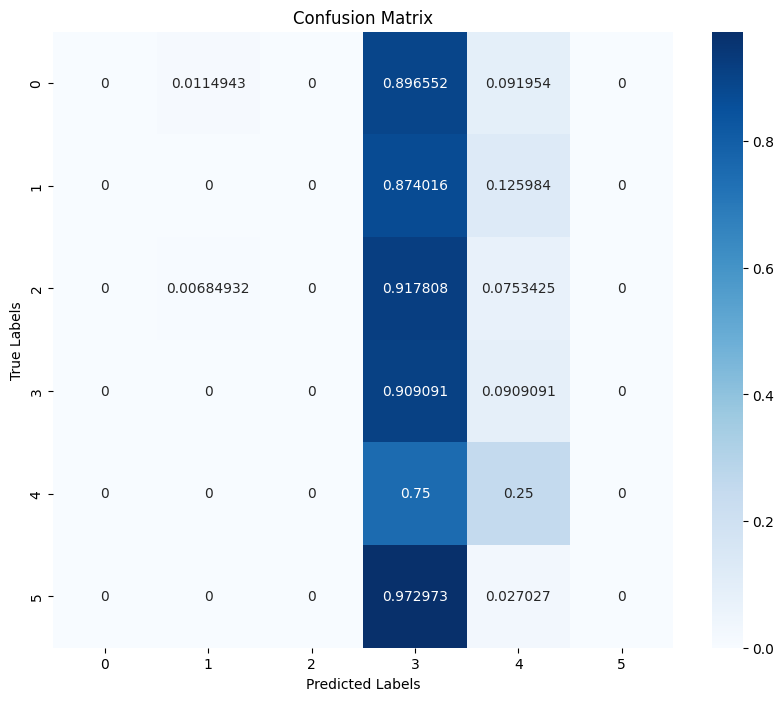

Epoch 13, Validation Loss: 1.7312, Accuracy: 0.2790, F1 Score: 0.1401
Val F1 Score Per Class  [0.         0.         0.         0.45845272 0.03508772 0.        ]


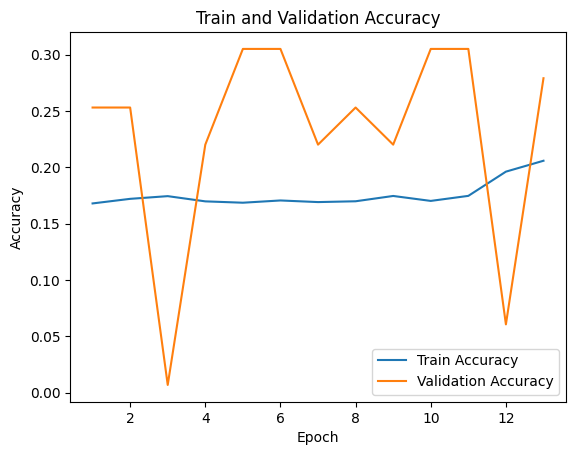

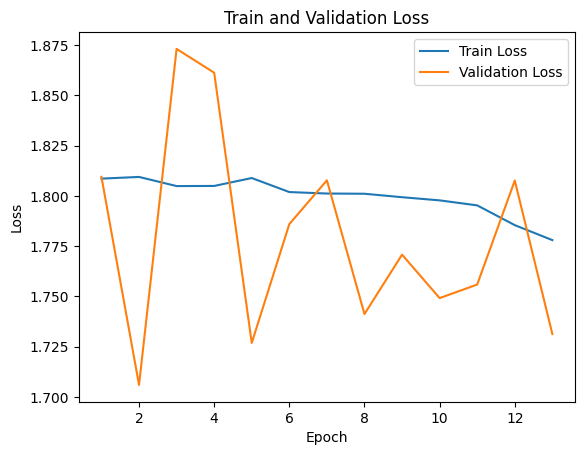

Epoch 14, Train Loss: 1.7743, Accuracy: 0.2037, F1 Score: 0.1669
Train F1 Score Per Class  [0.16291655 0.11194763 0.09549611 0.25224443 0.33193684 0.0424823 ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.40it/s, loss=1.76]

[tensor([-0.0391,  0.1183,  0.0475,  0.0289, -0.2558, -0.0980], device='cuda:0'), tensor([-0.1595,  0.0732, -0.0063, -0.1036,  0.2654, -0.1627], device='cuda:0'), tensor([-0.2246,  0.0473, -0.0367, -0.1761,  0.4684, -0.1990], device='cuda:0'), tensor([-0.1764,  0.0680, -0.0126, -0.1105,  0.0400, -0.1668], device='cuda:0'), tensor([-0.0304,  0.1209,  0.0520,  0.0485, -0.4540, -0.0885], device='cuda:0'), tensor([-0.1658,  0.0698, -0.0099, -0.1202,  0.3919, -0.1719], device='cuda:0'), tensor([ 0.0379,  0.1164,  0.0488, -0.0212, -0.2492, -0.1775], device='cuda:0'), tensor([-0.1741,  0.0681, -0.0127, -0.1151,  0.3540, -0.1679], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.43it/s, loss=1.77]

[tensor([-0.0140,  0.1213,  0.0576,  0.0222, -0.9728, -0.1517], device='cuda:0'), tensor([-0.1316,  0.0835,  0.0062, -0.0676, -0.0651, -0.1451], device='cuda:0'), tensor([-0.1906,  0.0617, -0.0203, -0.1315,  0.4003, -0.1762], device='cuda:0'), tensor([-0.1219,  0.0874,  0.0109, -0.0626, -0.2223, -0.1441], device='cuda:0'), tensor([-0.0462,  0.1166,  0.0455,  0.0253, -0.2900, -0.1002], device='cuda:0'), tensor([-0.0711,  0.1067,  0.0340,  0.0019, -0.1266, -0.1115], device='cuda:0'), tensor([ 0.0092,  0.1096,  0.0396, -0.0361, -0.0971, -0.1857], device='cuda:0'), tensor([-0.0443,  0.1171,  0.0467,  0.0288, -0.2769, -0.1005], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.74]

[tensor([ 0.0216,  0.1406,  0.0746,  0.0905, -0.7382, -0.0690], device='cuda:0'), tensor([-0.1480,  0.0783, -0.0002, -0.0882,  0.0855, -0.1563], device='cuda:0'), tensor([-0.0918,  0.0995,  0.0251, -0.0213, -0.1652, -0.1232], device='cuda:0'), tensor([-0.1683,  0.0710, -0.0089, -0.1099, -0.4718, -0.1674], device='cuda:0'), tensor([-0.1740,  0.0674, -0.0133, -0.1160, -0.1644, -0.1680], device='cuda:0'), tensor([-0.1760,  0.0678, -0.0126, -0.1156, -0.0549, -0.1697], device='cuda:0'), tensor([ 0.1016,  0.1657,  0.1082,  0.1728, -0.7335, -0.0344], device='cuda:0'), tensor([-0.1291,  0.0854,  0.0084, -0.0610, -0.2049, -0.1432], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.39it/s, loss=1.68]

[tensor([-0.0929,  0.0988,  0.0244, -0.0350, -0.5029, -0.1314], device='cuda:0'), tensor([-0.1548,  0.0800,  0.0029, -0.1079,  0.0408, -0.2214], device='cuda:0'), tensor([ 0.0244,  0.1098,  0.0420, -0.0340, -0.1074, -0.1830], device='cuda:0'), tensor([-0.0158,  0.0970,  0.0257, -0.0682, -1.1927, -0.1999], device='cuda:0'), tensor([-0.2063,  0.0533, -0.0290, -0.1639,  0.4754, -0.1931], device='cuda:0'), tensor([ 0.0382,  0.1178,  0.0511, -0.0160, -0.8391, -0.1752], device='cuda:0'), tensor([ 0.1322,  0.1789,  0.1227,  0.2130, -0.8671, -0.0151], device='cuda:0'), tensor([-0.0974,  0.0979,  0.0234, -0.0243, -0.7090, -0.1258], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=1.77]

[tensor([-0.0901,  0.0989,  0.0248, -0.0228, -0.1523, -0.1245], device='cuda:0'), tensor([ 0.0234,  0.1157,  0.0470, -0.0243, -0.0969, -0.1817], device='cuda:0'), tensor([-0.2082,  0.0527, -0.0300, -0.1649,  0.4067, -0.1938], device='cuda:0'), tensor([-0.1835,  0.0645, -0.0169, -0.1272,  0.0073, -0.1745], device='cuda:0'), tensor([-0.1215,  0.0880,  0.0116, -0.0594, -0.6046, -0.1430], device='cuda:0'), tensor([-0.1303,  0.0834,  0.0059, -0.0773,  0.1345, -0.1501], device='cuda:0'), tensor([-0.1779,  0.0668, -0.0139, -0.1171,  0.2969, -0.1694], device='cuda:0'), tensor([-0.3143,  0.0094, -0.0799, -0.2864,  0.8269, -0.2536], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=1.76]

[tensor([-0.1602,  0.0747, -0.0044, -0.0818, -0.3136, -0.1664], device='cuda:0'), tensor([ 0.0390,  0.1147,  0.0486, -0.0159, -0.7796, -0.1735], device='cuda:0'), tensor([-0.1995,  0.0585, -0.0237, -0.1488,  0.2651, -0.1862], device='cuda:0'), tensor([ 0.0117,  0.1067,  0.0374, -0.0434, -0.0475, -0.1878], device='cuda:0'), tensor([-0.0244,  0.1237,  0.0544,  0.0490, -0.4449, -0.0891], device='cuda:0'), tensor([-0.1564,  0.0756, -0.0036, -0.0922,  0.0002, -0.1581], device='cuda:0'), tensor([-0.1102,  0.0919,  0.0162, -0.0417, -0.1553, -0.1327], device='cuda:0'), tensor([ 0.0125,  0.1049,  0.0362, -0.0452, -0.0596, -0.1875], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.38it/s, loss=1.76]

[tensor([-0.0913,  0.0995,  0.0251, -0.0222, -0.4279, -0.1240], device='cuda:0'), tensor([-0.1055,  0.0956,  0.0202, -0.0335, -0.2576, -0.1301], device='cuda:0'), tensor([-0.2069,  0.0552, -0.0279, -0.1519,  0.2990, -0.1866], device='cuda:0'), tensor([-0.2592,  0.0338, -0.0525, -0.2116,  0.4437, -0.2159], device='cuda:0'), tensor([-0.1412,  0.0808,  0.0029, -0.0712,  0.1185, -0.1477], device='cuda:0'), tensor([-0.1940,  0.0605, -0.0215, -0.1412, -0.2942, -0.1819], device='cuda:0'), tensor([ 0.0217,  0.1151,  0.0461, -0.0218, -0.3828, -0.1793], device='cuda:0'), tensor([-0.2223,  0.0501, -0.0339, -0.1601,  0.3814, -0.1895], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=1.71]

[tensor([-0.0487,  0.1147,  0.0432,  0.0197, -0.1417, -0.1027], device='cuda:0'), tensor([-0.2233,  0.0475, -0.0363, -0.1793,  0.5059, -0.2011], device='cuda:0'), tensor([-0.1283,  0.0847,  0.0072, -0.0773, -0.0629, -0.1499], device='cuda:0'), tensor([ 0.0955,  0.1674,  0.1078,  0.1662, -0.8153, -0.0370], device='cuda:0'), tensor([ 0.0190,  0.1400,  0.0740,  0.0930, -0.4793, -0.0692], device='cuda:0'), tensor([-0.0132,  0.1274,  0.0590,  0.0520, -0.3009, -0.0880], device='cuda:0'), tensor([ 0.0099,  0.1051,  0.0361, -0.0430, -0.9634, -0.1870], device='cuda:0'), tensor([-0.0919,  0.0986,  0.0245, -0.0251, -0.1015, -0.1257], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=1.77]

[tensor([-0.1602,  0.0742, -0.0052, -0.0930, -0.0410, -0.1579], device='cuda:0'), tensor([-0.1792,  0.0672, -0.0135, -0.1174,  0.2982, -0.1714], device='cuda:0'), tensor([-0.2762,  0.0300, -0.0577, -0.2179,  0.3532, -0.2186], device='cuda:0'), tensor([-0.1222,  0.0877,  0.0111, -0.0578, -0.0153, -0.1415], device='cuda:0'), tensor([-0.0364,  0.0937,  0.0209, -0.0801,  0.1557, -0.2088], device='cuda:0'), tensor([ 0.0223,  0.1398,  0.0744,  0.0887, -0.3229, -0.0706], device='cuda:0'), tensor([-0.2224,  0.0504, -0.0336, -0.1685,  0.2720, -0.1950], device='cuda:0'), tensor([-0.1174,  0.0890,  0.0128, -0.0638,  0.0616, -0.1451], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.37it/s, loss=1.79]

[tensor([-0.1067,  0.0933,  0.0176, -0.0403,  0.0158, -0.1317], device='cuda:0'), tensor([-0.1049,  0.0950,  0.0195, -0.0332, -0.3589, -0.1286], device='cuda:0'), tensor([-0.0584,  0.1123,  0.0403,  0.0116, -0.5273, -0.1371], device='cuda:0'), tensor([-1.6851e-01,  7.1488e-02, -8.2357e-03, -1.0647e-01,  1.0885e-05,
        -1.6607e-01], device='cuda:0'), tensor([-0.2213,  0.0497, -0.0341, -0.1672,  0.5191, -0.1941], device='cuda:0'), tensor([-0.1428,  0.0805,  0.0023, -0.0816, -0.3869, -0.1534], device='cuda:0'), tensor([-0.2484,  0.0381, -0.0475, -0.2007,  0.4737, -0.2116], device='cuda:0'), tensor([ 0.0504,  0.1513,  0.0877,  0.1161, -0.5743, -0.0680], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.37it/s, loss=1.85]

[tensor([-0.0256,  0.0905,  0.0196, -0.0716, -0.4709, -0.1993], device='cuda:0'), tensor([-0.0443,  0.1163,  0.0457,  0.0237, -0.6368, -0.1019], device='cuda:0'), tensor([-0.1263,  0.0857,  0.0096, -0.0985, -0.6301, -0.2154], device='cuda:0'), tensor([-0.0548,  0.0990,  0.0287, -0.0550, -1.1341, -0.1921], device='cuda:0'), tensor([-0.1013,  0.0947,  0.0192, -0.0405, -0.0707, -0.1317], device='cuda:0'), tensor([-0.1752,  0.0651, -0.0153, -0.1376,  0.0478, -0.1807], device='cuda:0'), tensor([-0.2158,  0.0529, -0.0307, -0.1599,  0.3773, -0.1912], device='cuda:0'), tensor([-0.1176,  0.0889,  0.0127, -0.0584, -0.0959, -0.1418], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.37it/s, loss=1.72]

[tensor([-0.1889,  0.0628, -0.0187, -0.1348,  0.4131, -0.1790], device='cuda:0'), tensor([ 0.0182,  0.1102,  0.0411, -0.0390, -0.9952, -0.1868], device='cuda:0'), tensor([ 0.0944,  0.1660,  0.1059,  0.1570, -1.0357, -0.0387], device='cuda:0'), tensor([-0.1849,  0.0637, -0.0175, -0.1324,  0.1984, -0.1779], device='cuda:0'), tensor([-0.0947,  0.0977,  0.0231, -0.0358, -0.3712, -0.1312], device='cuda:0'), tensor([ 0.0202,  0.1393,  0.0740,  0.0946, -0.3997, -0.0682], device='cuda:0'), tensor([-0.0387,  0.1193,  0.0489,  0.0364, -0.9118, -0.0953], device='cuda:0'), tensor([-0.1588,  0.0734, -0.0059, -0.0996, -0.7605, -0.1613], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.37it/s, loss=1.81]

[tensor([-0.0583,  0.1118,  0.0397,  0.0120, -0.4819, -0.1066], device='cuda:0'), tensor([-0.1037,  0.0945,  0.0193, -0.0372, -0.0278, -0.1310], device='cuda:0'), tensor([-0.2064,  0.0576, -0.0256, -0.1437, -0.1430, -0.1821], device='cuda:0'), tensor([-0.2650,  0.0317, -0.0547, -0.2182,  0.5553, -0.2198], device='cuda:0'), tensor([-0.1248,  0.0864,  0.0101, -0.0661, -0.0233, -0.1466], device='cuda:0'), tensor([-0.0017,  0.1083,  0.0400, -0.0346, -0.5123, -0.1819], device='cuda:0'), tensor([-0.1934,  0.0589, -0.0228, -0.1484, -0.0241, -0.1859], device='cuda:0'), tensor([-0.1304,  0.0843,  0.0070, -0.0712, -0.1215, -0.1478], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.37it/s, loss=1.78]

[tensor([-0.2503,  0.0407, -0.0456, -0.1878,  0.2711, -0.2034], device='cuda:0'), tensor([-0.1092,  0.0921,  0.0162, -0.0433, -0.3175, -0.1331], device='cuda:0'), tensor([-0.1804,  0.0656, -0.0157, -0.1229,  0.2225, -0.1719], device='cuda:0'), tensor([-0.0669,  0.1085,  0.0362,  0.0044, -0.2670, -0.1111], device='cuda:0'), tensor([-0.1849,  0.0639, -0.0174, -0.1316,  0.3536, -0.1776], device='cuda:0'), tensor([-0.1555,  0.0756, -0.0036, -0.0961,  0.1510, -0.1603], device='cuda:0'), tensor([-0.1656,  0.0708, -0.0092, -0.1032,  0.2179, -0.1617], device='cuda:0'), tensor([-0.0571,  0.0794,  0.0060, -0.1061, -0.6081, -0.2173], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.38it/s, loss=1.78]

[tensor([-0.0191,  0.1261,  0.0572,  0.0546, -0.4290, -0.0869], device='cuda:0'), tensor([-0.1230,  0.0874,  0.0110, -0.0511,  0.0582, -0.1372], device='cuda:0'), tensor([-0.1167,  0.0893,  0.0131, -0.0522, -0.2468, -0.1381], device='cuda:0'), tensor([-0.1261,  0.0864,  0.0095, -0.0590, -0.0967, -0.1411], device='cuda:0'), tensor([ 0.0595,  0.1541,  0.0912,  0.1325, -0.5274, -0.0489], device='cuda:0'), tensor([-0.2066,  0.0556, -0.0275, -0.1526, -0.1425, -0.1866], device='cuda:0'), tensor([-0.0794,  0.1043,  0.0311, -0.0048, -0.0797, -0.1159], device='cuda:0'), tensor([-0.1565,  0.0744, -0.0050, -0.1046,  0.2923, -0.1643], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=1.82]

[tensor([-0.1864,  0.0640, -0.0174, -0.1206, -0.2783, -0.1712], device='cuda:0'), tensor([-0.1557,  0.0755, -0.0036, -0.0925,  0.2685, -0.1583], device='cuda:0'), tensor([-0.1771,  0.0657, -0.0152, -0.1266, -0.1221, -0.1739], device='cuda:0'), tensor([-0.2450,  0.0390, -0.0462, -0.2021,  0.6782, -0.2130], device='cuda:0'), tensor([-0.1106,  0.0917,  0.0159, -0.0463, -0.0899, -0.1358], device='cuda:0'), tensor([-0.1487,  0.0775, -0.0009, -0.0871, -0.4134, -0.1551], device='cuda:0'), tensor([-0.0804,  0.1035,  0.0297, -0.0069, -0.0625, -0.1151], device='cuda:0'), tensor([-0.1103,  0.0916,  0.0159, -0.0509, -0.1628, -0.1384], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=1.85]

[tensor([-0.2471,  0.0393, -0.0463, -0.1979,  0.5710, -0.2097], device='cuda:0'), tensor([-0.0883,  0.1001,  0.0258, -0.0241, -0.6292, -0.1243], device='cuda:0'), tensor([-0.0796,  0.1040,  0.0306, -0.0096, -0.4421, -0.1175], device='cuda:0'), tensor([-0.2139,  0.0527, -0.0308, -0.1572,  0.4595, -0.1885], device='cuda:0'), tensor([-0.0884,  0.1003,  0.0258, -0.0232, -0.1461, -0.1238], device='cuda:0'), tensor([-0.0981,  0.0964,  0.0212, -0.0381,  0.0555, -0.1308], device='cuda:0'), tensor([-0.1924,  0.0531, -0.0276, -0.1867,  0.4471, -0.2053], device='cuda:0'), tensor([-0.1211,  0.0877,  0.0109, -0.0660, -0.1797, -0.1452], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=1.82]

[tensor([-0.2369,  0.0430, -0.0420, -0.1870,  0.6161, -0.2039], device='cuda:0'), tensor([ 0.0533,  0.1524,  0.0889,  0.1196, -0.9466, -0.0559], device='cuda:0'), tensor([-0.2287,  0.0441, -0.0398, -0.1936,  0.5451, -0.2083], device='cuda:0'), tensor([-0.0804,  0.1031,  0.0296, -0.0187, -0.1092, -0.1220], device='cuda:0'), tensor([-0.1918,  0.0620, -0.0202, -0.1310,  0.0938, -0.1759], device='cuda:0'), tensor([-0.0971,  0.0969,  0.0221, -0.0254, -0.2475, -0.1250], device='cuda:0'), tensor([-0.1041,  0.0946,  0.0195, -0.0383, -0.0835, -0.1324], device='cuda:0'), tensor([-0.2393,  0.0415, -0.0433, -0.1938,  0.5026, -0.2077], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.37it/s, loss=1.85]

[tensor([-0.1380,  0.0819,  0.0040, -0.0785, -0.2729, -0.1515], device='cuda:0'), tensor([-0.2027,  0.0570, -0.0255, -0.1498,  0.3864, -0.1864], device='cuda:0'), tensor([-0.2289,  0.0473, -0.0370, -0.1790,  0.3809, -0.2007], device='cuda:0'), tensor([-0.0426,  0.1174,  0.0472,  0.0320, -0.1851, -0.0981], device='cuda:0'), tensor([-0.2139,  0.0535, -0.0300, -0.1571, -0.0857, -0.1895], device='cuda:0'), tensor([-0.1795,  0.0665, -0.0148, -0.1188,  0.3052, -0.1696], device='cuda:0'), tensor([-0.2534,  0.0358, -0.0500, -0.2081,  0.6423, -0.2147], device='cuda:0'), tensor([-0.1424,  0.0792,  0.0011, -0.0882,  0.0359, -0.1556], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=1.74]

[tensor([-0.2117,  0.0528, -0.0306, -0.1652,  0.1071, -0.1937], device='cuda:0'), tensor([-0.1715,  0.0689, -0.0117, -0.1150,  0.2936, -0.1680], device='cuda:0'), tensor([-0.1617,  0.0734, -0.0057, -0.0966, -0.0739, -0.1609], device='cuda:0'), tensor([-0.1478,  0.0767, -0.0018, -0.0975, -0.5667, -0.1601], device='cuda:0'), tensor([ 0.0189,  0.1090,  0.0402, -0.0369, -0.7226, -0.1843], device='cuda:0'), tensor([ 0.0398,  0.1474,  0.0831,  0.1129, -0.6828, -0.0591], device='cuda:0'), tensor([-0.0841,  0.1027,  0.0288, -0.0116, -0.4446, -0.1184], device='cuda:0'), tensor([-0.0884,  0.1005,  0.0267, -0.0155, -0.4439, -0.1206], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.36it/s, loss=1.85]

[tensor([-0.1737,  0.0668, -0.0138, -0.1256,  0.0216, -0.1739], device='cuda:0'), tensor([-0.2507,  0.0367, -0.0488, -0.2055,  0.6283, -0.2134], device='cuda:0'), tensor([-0.0975,  0.0973,  0.0223, -0.0343, -0.1745, -0.1295], device='cuda:0'), tensor([-0.2476,  0.0382, -0.0473, -0.2023,  0.5797, -0.2115], device='cuda:0'), tensor([ 0.0191,  0.1116,  0.0452, -0.0073, -0.8866, -0.1670], device='cuda:0'), tensor([-0.2011,  0.0569, -0.0256, -0.1495,  0.4603, -0.1858], device='cuda:0'), tensor([-0.2504,  0.0365, -0.0490, -0.2088,  0.5103, -0.2153], device='cuda:0'), tensor([-0.1041,  0.0938,  0.0189, -0.0445,  0.0597, -0.1355], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=1.77]

[tensor([-0.1739,  0.0687, -0.0119, -0.1090,  0.3120, -0.1656], device='cuda:0'), tensor([-0.1494,  0.0544, -0.0244, -0.1706,  0.2139, -0.2482], device='cuda:0'), tensor([-0.1767,  0.0664, -0.0143, -0.1210,  0.2384, -0.1716], device='cuda:0'), tensor([-0.0153,  0.0961,  0.0250, -0.0680, -0.9523, -0.1991], device='cuda:0'), tensor([-0.2448,  0.0413, -0.0441, -0.1915,  0.6332, -0.2070], device='cuda:0'), tensor([-0.2103,  0.0537, -0.0293, -0.1569, -0.0165, -0.1896], device='cuda:0'), tensor([-0.2102,  0.0531, -0.0299, -0.1609,  0.4247, -0.1914], device='cuda:0'), tensor([-0.1904,  0.0600, -0.0215, -0.1460,  0.3415, -0.1852], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.37it/s, loss=1.72]

[tensor([-0.0685,  0.1082,  0.0356,  0.0035, -0.7994, -0.1117], device='cuda:0'), tensor([-0.1438,  0.0795,  0.0015, -0.0820, -0.0918, -0.1531], device='cuda:0'), tensor([ 0.0297,  0.1128,  0.0448, -0.0322, -1.1119, -0.1831], device='cuda:0'), tensor([-0.0871,  0.1005,  0.0262, -0.0200, -0.4012, -0.1220], device='cuda:0'), tensor([-0.1083,  0.0932,  0.0177, -0.0360, -0.1385, -0.1306], device='cuda:0'), tensor([-0.0035,  0.1317,  0.0644,  0.0793, -0.5428, -0.0753], device='cuda:0'), tensor([-0.0556,  0.1130,  0.0416,  0.0218, -0.3852, -0.1030], device='cuda:0'), tensor([-0.1979,  0.0584, -0.0240, -0.1438,  0.4182, -0.1825], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=1.75]

[tensor([-0.2127,  0.0543, -0.0290, -0.1537,  0.2843, -0.1882], device='cuda:0'), tensor([ 0.0193,  0.1090,  0.0401, -0.0376, -0.6556, -0.1843], device='cuda:0'), tensor([ 0.1708,  0.1679,  0.1140,  0.1414, -0.9249, -0.0938], device='cuda:0'), tensor([-0.1213,  0.0875,  0.0109, -0.0657, -0.5863, -0.1456], device='cuda:0'), tensor([-0.1151,  0.0905,  0.0144, -0.0494, -0.0408, -0.1368], device='cuda:0'), tensor([-0.1064,  0.0935,  0.0179, -0.0422, -0.3049, -0.1329], device='cuda:0'), tensor([-0.2450,  0.0390, -0.0461, -0.2026,  0.3024, -0.2617], device='cuda:0'), tensor([-0.2598,  0.0332, -0.0528, -0.2165,  0.5545, -0.2193], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=1.74]

[tensor([-0.3119,  0.0099, -0.0791, -0.2893,  0.8457, -0.2554], device='cuda:0'), tensor([-0.1746,  0.0680, -0.0126, -0.1141,  0.2627, -0.1680], device='cuda:0'), tensor([-0.1637,  0.0723, -0.0076, -0.1116, -0.0498, -0.2002], device='cuda:0'), tensor([-0.1721,  0.0687, -0.0117, -0.1223, -0.1344, -0.1733], device='cuda:0'), tensor([-0.0985,  0.0968,  0.0217, -0.0375, -0.7136, -0.1307], device='cuda:0'), tensor([ 0.0348,  0.1453,  0.0805,  0.1107, -1.1422, -0.0593], device='cuda:0'), tensor([-0.2009,  0.0580, -0.0246, -0.1417,  0.1822, -0.1809], device='cuda:0'), tensor([-0.1820,  0.0625, -0.0180, -0.1432,  0.4569, -0.1844], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.78]

[tensor([-0.0798,  0.1029,  0.0300, -0.0102, -0.3519, -0.1185], device='cuda:0'), tensor([-0.0601,  0.1106,  0.0384,  0.0123, -0.3878, -0.1052], device='cuda:0'), tensor([ 0.0015,  0.1021,  0.0324, -0.0564, -0.8223, -0.1946], device='cuda:0'), tensor([-0.1765,  0.0663, -0.0146, -0.1257,  0.3491, -0.1736], device='cuda:0'), tensor([-0.0067,  0.1302,  0.0625,  0.0655, -0.3375, -0.0823], device='cuda:0'), tensor([-0.0658,  0.1086,  0.0361, -0.0134, -1.1800, -0.1739], device='cuda:0'), tensor([-0.1222,  0.0882,  0.0114, -0.0534, -0.1862, -0.1385], device='cuda:0'), tensor([-0.2265,  0.0474, -0.0369, -0.1749,  0.2303, -0.1980], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=1.77]

[tensor([ 0.0710,  0.1565,  0.0962,  0.1585, -0.8897, -0.0414], device='cuda:0'), tensor([-0.1223,  0.0870,  0.0102, -0.0687,  0.1011, -0.1466], device='cuda:0'), tensor([-0.1096,  0.0925,  0.0166, -0.0408, -0.2701, -0.1323], device='cuda:0'), tensor([-0.0334,  0.0950,  0.0224, -0.0745,  0.1475, -0.2058], device='cuda:0'), tensor([-0.0379,  0.1180,  0.0477,  0.0261, -0.2211, -0.1005], device='cuda:0'), tensor([-0.1848,  0.0632, -0.0182, -0.1308,  0.2475, -0.1762], device='cuda:0'), tensor([-0.1533,  0.0758, -0.0036, -0.0954,  0.2177, -0.1581], device='cuda:0'), tensor([-0.2173,  0.0515, -0.0321, -0.1599,  0.3835, -0.1902], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=1.76]

[tensor([-0.1489,  0.0775, -0.0012, -0.0904,  0.2198, -0.1571], device='cuda:0'), tensor([ 0.0573,  0.1272,  0.0606,  0.0020, -0.1998, -0.1675], device='cuda:0'), tensor([-0.2078,  0.0553, -0.0276, -0.1520,  0.2523, -0.1872], device='cuda:0'), tensor([-0.2012,  0.0614, -0.0208, -0.1193, -0.1297, -0.1707], device='cuda:0'), tensor([-0.1140,  0.0902,  0.0141, -0.0459, -0.1259, -0.1344], device='cuda:0'), tensor([-0.2000,  0.0588, -0.0236, -0.1400,  0.1197, -0.1812], device='cuda:0'), tensor([-0.2185,  0.0521, -0.0317, -0.1549,  0.1018, -0.1879], device='cuda:0'), tensor([-0.1153,  0.0901,  0.0137, -0.0463, -0.3721, -0.1342], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=1.81]

[tensor([-0.0833,  0.1018,  0.0278, -0.0183, -0.4272, -0.1220], device='cuda:0'), tensor([-0.0546,  0.1122,  0.0404,  0.0116, -0.6933, -0.1069], device='cuda:0'), tensor([-0.2234,  0.0484, -0.0357, -0.1732,  0.4586, -0.1976], device='cuda:0'), tensor([ 0.0237,  0.1098,  0.0416, -0.0326, -0.5863, -0.1816], device='cuda:0'), tensor([-0.1667,  0.0699, -0.0100, -0.1132,  0.1845, -0.1678], device='cuda:0'), tensor([-0.0332,  0.1208,  0.0506,  0.0363, -0.4767, -0.0948], device='cuda:0'), tensor([-0.1979,  0.0588, -0.0235, -0.1431,  0.4775, -0.1827], device='cuda:0'), tensor([-0.0193,  0.1248,  0.0556,  0.0451, -0.5865, -0.0905], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=1.79]

[tensor([-0.0437,  0.1082,  0.0399, -0.0299, -0.2560, -0.1784], device='cuda:0'), tensor([-0.1882,  0.0622, -0.0194, -0.1331,  0.3858, -0.1768], device='cuda:0'), tensor([ 0.0014,  0.1031,  0.0330, -0.0539, -0.6512, -0.1933], device='cuda:0'), tensor([-0.1885,  0.0618, -0.0200, -0.1338,  0.4550, -0.1773], device='cuda:0'), tensor([ 0.0159,  0.1381,  0.0718,  0.0829, -1.0812, -0.0731], device='cuda:0'), tensor([-0.1041,  0.0949,  0.0196, -0.0339, -0.2183, -0.1295], device='cuda:0'), tensor([-0.2097,  0.0540, -0.0291, -0.1533,  0.3121, -0.1868], device='cuda:0'), tensor([-0.2319,  0.0448, -0.0396, -0.1825,  0.5195, -0.2019], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=1.72]

[tensor([ 0.0732,  0.1601,  0.0987,  0.1528, -0.7193, -0.0431], device='cuda:0'), tensor([ 0.1024,  0.1686,  0.1104,  0.1800, -0.8860, -0.0309], device='cuda:0'), tensor([-0.0958,  0.0972,  0.0229, -0.0284, -0.1611, -0.1270], device='cuda:0'), tensor([-0.1241,  0.0866,  0.0096, -0.0667,  0.0216, -0.1457], device='cuda:0'), tensor([-0.0391,  0.1183,  0.0479,  0.0322, -0.2812, -0.0980], device='cuda:0'), tensor([-0.1987,  0.0578, -0.0247, -0.1441, -0.0022, -0.1814], device='cuda:0'), tensor([ 0.0534,  0.1520,  0.0894,  0.1370, -0.6663, -0.0490], device='cuda:0'), tensor([-0.0603,  0.1111,  0.0386,  0.0007, -0.5740, -0.1122], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=1.71]

[tensor([-0.0617,  0.1099,  0.0379,  0.0070, -0.1271, -0.1090], device='cuda:0'), tensor([-0.1167,  0.0907,  0.0143, -0.0527, -0.1561, -0.1392], device='cuda:0'), tensor([-0.0384,  0.1185,  0.0479,  0.0307, -0.1361, -0.0976], device='cuda:0'), tensor([-0.1923,  0.0615, -0.0206, -0.1315,  0.3804, -0.1758], device='cuda:0'), tensor([-0.1336,  0.0833,  0.0058, -0.0729, -0.0285, -0.1486], device='cuda:0'), tensor([ 0.0208,  0.1150,  0.0461, -0.0233, -0.1440, -0.1808], device='cuda:0'), tensor([-0.1263,  0.0864,  0.0096, -0.0625,  0.1472, -0.1439], device='cuda:0'), tensor([ 0.0472,  0.1175,  0.0516, -0.0045, -0.9224, -0.1662], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=1.74]

[tensor([-0.1896,  0.0626, -0.0187, -0.1253,  0.2751, -0.1743], device='cuda:0'), tensor([ 0.1565,  0.1878,  0.1343,  0.2088, -1.1131, -0.0563], device='cuda:0'), tensor([ 0.0047,  0.1031,  0.0335, -0.0460, -0.7162, -0.1875], device='cuda:0'), tensor([ 0.0210,  0.1081,  0.0400, -0.0367, -0.3930, -0.1845], device='cuda:0'), tensor([-0.2160,  0.0505, -0.0329, -0.1710,  0.3660, -0.1964], device='cuda:0'), tensor([ 0.1003,  0.1687,  0.1095,  0.1761, -1.0030, -0.0312], device='cuda:0'), tensor([-0.1767,  0.0671, -0.0139, -0.1209, -0.1182, -0.1717], device='cuda:0'), tensor([-0.1067,  0.0929,  0.0172, -0.0477,  0.1327, -0.1367], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=1.69]

[tensor([-0.0166,  0.1268,  0.0581,  0.0568, -0.7766, -0.0857], device='cuda:0'), tensor([ 0.0971,  0.1685,  0.1087,  0.1673, -0.9596, -0.0346], device='cuda:0'), tensor([-0.0917,  0.0995,  0.0257, -0.0192, -0.3714, -0.1229], device='cuda:0'), tensor([-0.1083,  0.0938,  0.0182, -0.0353, -0.1819, -0.1298], device='cuda:0'), tensor([-0.1666,  0.0698, -0.0103, -0.1096, -0.3115, -0.1653], device='cuda:0'), tensor([-0.0650,  0.1091,  0.0364,  0.0036, -0.6125, -0.1111], device='cuda:0'), tensor([-0.2101,  0.0542, -0.0289, -0.1563,  0.2768, -0.1889], device='cuda:0'), tensor([-0.0671,  0.1074,  0.0352, -0.0024, -0.4050, -0.1146], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=1.78]

[tensor([-0.1932,  0.0535, -0.0274, -0.1734,  0.1327, -0.1981], device='cuda:0'), tensor([ 0.0078,  0.1366,  0.0696,  0.0791, -0.6264, -0.0974], device='cuda:0'), tensor([-0.0310,  0.0998,  0.0279, -0.0614, -0.9259, -0.1985], device='cuda:0'), tensor([ 0.0212,  0.1099,  0.0413, -0.0374, -0.0612, -0.1851], device='cuda:0'), tensor([-0.2255,  0.0469, -0.0372, -0.1812,  0.4926, -0.2013], device='cuda:0'), tensor([ 0.0285,  0.1433,  0.0778,  0.0987, -0.7252, -0.0656], device='cuda:0'), tensor([ 0.0094,  0.1358,  0.0697,  0.0992, -0.6043, -0.0660], device='cuda:0'), tensor([ 0.0090,  0.1069,  0.0374, -0.0420, -0.1237, -0.1876], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.34it/s, loss=1.71]

[tensor([-0.0926,  0.0985,  0.0238, -0.0312, -0.1042, -0.1276], device='cuda:0'), tensor([-0.0839,  0.1013,  0.0276, -0.0214, -0.6047, -0.1231], device='cuda:0'), tensor([-0.1443,  0.0793,  0.0007, -0.0846,  0.0412, -0.1538], device='cuda:0'), tensor([-0.0104,  0.1290,  0.0606,  0.0564, -0.5333, -0.0858], device='cuda:0'), tensor([-0.0610,  0.1097,  0.0374, -0.0005, -0.3321, -0.1133], device='cuda:0'), tensor([-0.1719,  0.0682, -0.0123, -0.1216, -0.0558, -0.1722], device='cuda:0'), tensor([-0.0039,  0.1316,  0.0655,  0.0731, -0.4730, -0.0773], device='cuda:0'), tensor([-0.0131,  0.1283,  0.0603,  0.0662, -0.6683, -0.0814], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.36it/s, loss=1.76]

[tensor([-0.0483,  0.1152,  0.0445,  0.0198, -0.6353, -0.1044], device='cuda:0'), tensor([-0.1162,  0.0899,  0.0136, -0.0571, -0.0854, -0.1411], device='cuda:0'), tensor([ 0.0162,  0.1113,  0.0421, -0.0336, -0.7674, -0.1849], device='cuda:0'), tensor([-0.1539,  0.0748, -0.0043, -0.0993,  0.2426, -0.1612], device='cuda:0'), tensor([-0.0758,  0.1050,  0.0315, -0.0059, -0.1247, -0.1155], device='cuda:0'), tensor([-0.0796,  0.1032,  0.0300, -0.0104, -0.2455, -0.1184], device='cuda:0'), tensor([-0.2227,  0.0494, -0.0345, -0.1691,  0.4219, -0.1955], device='cuda:0'), tensor([-0.2155,  0.0519, -0.0316, -0.1651,  0.1837, -0.1935], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.35it/s, loss=1.77]

[tensor([-0.2179,  0.0516, -0.0321, -0.1582,  0.4168, -0.1895], device='cuda:0'), tensor([-0.1441,  0.0798,  0.0014, -0.0822,  0.1262, -0.1531], device='cuda:0'), tensor([-0.0752,  0.1045,  0.0309, -0.0105, -0.2606, -0.1166], device='cuda:0'), tensor([-0.1928,  0.0612, -0.0205, -0.1358,  0.1966, -0.1793], device='cuda:0'), tensor([-0.1218,  0.0882,  0.0115, -0.0593, -0.5595, -0.1426], device='cuda:0'), tensor([-0.0500,  0.1146,  0.0431,  0.0195, -0.1317, -0.1033], device='cuda:0'), tensor([-0.0845,  0.1016,  0.0280, -0.0115, -0.3266, -0.1183], device='cuda:0'), tensor([-0.2679,  0.0267, -0.0592, -0.2433,  0.5929, -0.2332], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.36it/s, loss=1.7]

[tensor([-0.0427,  0.1173,  0.0468,  0.0224, -0.2315, -0.1029], device='cuda:0'), tensor([-0.1263,  0.0863,  0.0091, -0.0666,  0.0925, -0.1453], device='cuda:0'), tensor([-0.1933,  0.0611, -0.0212, -0.1339,  0.3892, -0.1772], device='cuda:0'), tensor([-0.0867,  0.1009,  0.0267, -0.0287, -0.3813, -0.1271], device='cuda:0'), tensor([-0.1832,  0.0646, -0.0164, -0.1275,  0.3380, -0.1751], device='cuda:0'), tensor([ 0.0368,  0.1198,  0.0518, -0.0121, -0.1048, -0.1747], device='cuda:0'), tensor([ 0.1223,  0.1763,  0.1192,  0.2058, -0.7819, -0.0194], device='cuda:0'), tensor([ 0.0628,  0.1551,  0.0926,  0.1351, -0.6995, -0.0484], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:14,  2.35it/s, loss=1.79]

[tensor([-0.1845,  0.0655, -0.0157, -0.1135,  0.2863, -0.1677], device='cuda:0'), tensor([ 0.0230,  0.1406,  0.0751,  0.0961, -0.7188, -0.0669], device='cuda:0'), tensor([-0.1761,  0.0664, -0.0145, -0.1161,  0.2818, -0.1679], device='cuda:0'), tensor([ 0.0183,  0.1073,  0.0394, -0.0371, -0.7259, -0.1836], device='cuda:0'), tensor([-0.1545,  0.0757, -0.0036, -0.0930,  0.1712, -0.1577], device='cuda:0'), tensor([-0.2394,  0.0408, -0.0438, -0.1957,  0.4661, -0.2091], device='cuda:0'), tensor([-0.1945,  0.0601, -0.0217, -0.1431,  0.4111, -0.1834], device='cuda:0'), tensor([-0.1246,  0.0874,  0.0104, -0.0602,  0.0850, -0.1423], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=1.78]

[tensor([-0.0696,  0.1068,  0.0342, -0.0042, -0.6630, -0.1158], device='cuda:0'), tensor([-0.2029,  0.0557, -0.0268, -0.1572,  0.3615, -0.1901], device='cuda:0'), tensor([-0.2428,  0.0396, -0.0453, -0.1988,  0.5079, -0.2105], device='cuda:0'), tensor([-0.0111,  0.1289,  0.0603,  0.0573, -0.8286, -0.0852], device='cuda:0'), tensor([-0.0781,  0.1040,  0.0306, -0.0031, -0.6588, -0.1137], device='cuda:0'), tensor([ 0.0106,  0.1370,  0.0704,  0.0883, -0.6888, -0.0709], device='cuda:0'), tensor([-0.1586,  0.0727, -0.0069, -0.1001,  0.2359, -0.1602], device='cuda:0'), tensor([-0.1896,  0.0620, -0.0196, -0.1348,  0.3553, -0.1787], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.36it/s, loss=1.81]

[tensor([-0.0115,  0.1083,  0.0381, -0.0426, -0.6135, -0.1892], device='cuda:0'), tensor([-0.0207,  0.0940,  0.0228, -0.0698, -0.9442, -0.2000], device='cuda:0'), tensor([-0.1615,  0.0719, -0.0079, -0.1090, -0.0619, -0.1654], device='cuda:0'), tensor([ 0.0239,  0.1109,  0.0423, -0.0359, -0.5183, -0.1843], device='cuda:0'), tensor([-0.2435,  0.0392, -0.0454, -0.1967,  0.4631, -0.2092], device='cuda:0'), tensor([-0.3126,  0.0093, -0.0797, -0.2903,  0.8493, -0.2562], device='cuda:0'), tensor([-0.1270,  0.0849,  0.0077, -0.0741,  0.1157, -0.1489], device='cuda:0'), tensor([ 0.0356,  0.1187,  0.0526, -0.0032, -1.0588, -0.1655], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=1.78]

[tensor([ 0.0808,  0.1314,  0.0698,  0.0457, -0.7095, -0.1410], device='cuda:0'), tensor([-0.2079,  0.0547, -0.0279, -0.1541,  0.4467, -0.1883], device='cuda:0'), tensor([-0.1613,  0.0729, -0.0067, -0.0998, -0.4732, -0.1610], device='cuda:0'), tensor([-0.1068,  0.0932,  0.0175, -0.0433, -0.0434, -0.1336], device='cuda:0'), tensor([-0.1696,  0.0702, -0.0102, -0.1096,  0.2125, -0.1656], device='cuda:0'), tensor([-0.0532,  0.1130,  0.0413,  0.0092, -0.2045, -0.1089], device='cuda:0'), tensor([-0.2071,  0.0557, -0.0276, -0.1511,  0.3826, -0.1855], device='cuda:0'), tensor([-0.1522,  0.0761, -0.0027, -0.0922, -0.0964, -0.1575], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=1.75]

[tensor([-0.1922,  0.0609, -0.0211, -0.1371,  0.1017, -0.1796], device='cuda:0'), tensor([-0.1608,  0.0728, -0.0070, -0.1019, -0.6311, -0.1618], device='cuda:0'), tensor([-0.1403,  0.0807,  0.0026, -0.0814, -0.0526, -0.1526], device='cuda:0'), tensor([-0.2116,  0.0532, -0.0301, -0.1563,  0.4560, -0.1882], device='cuda:0'), tensor([-0.1806,  0.0645, -0.0167, -0.1307,  0.4167, -0.1760], device='cuda:0'), tensor([-0.1647,  0.0713, -0.0086, -0.1074,  0.2996, -0.1645], device='cuda:0'), tensor([-0.0133,  0.1019,  0.0305, -0.0567, -0.3461, -0.1964], device='cuda:0'), tensor([-0.0181,  0.1262,  0.0571,  0.0476, -0.4347, -0.0899], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=1.77]

[tensor([-0.0907,  0.0991,  0.0246, -0.0225, -0.2139, -0.1231], device='cuda:0'), tensor([-0.0299,  0.1215,  0.0516,  0.0331, -0.7624, -0.0975], device='cuda:0'), tensor([ 0.0828,  0.1624,  0.1016,  0.1572, -1.1341, -0.0629], device='cuda:0'), tensor([-0.2070,  0.0547, -0.0282, -0.1564,  0.3866, -0.1890], device='cuda:0'), tensor([-0.1770,  0.0659, -0.0150, -0.1260,  0.4092, -0.1736], device='cuda:0'), tensor([-0.1177,  0.0904,  0.0139, -0.0495,  0.1200, -0.1372], device='cuda:0'), tensor([ 0.0674,  0.1571,  0.0944,  0.1401, -0.9395, -0.0450], device='cuda:0'), tensor([-0.1570,  0.0743, -0.0052, -0.1007,  0.1542, -0.1618], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.36it/s, loss=1.81]

[tensor([-0.1473,  0.0778, -0.0004, -0.0861,  0.0486, -0.1553], device='cuda:0'), tensor([-0.1434,  0.0818,  0.0035, -0.0668, -0.2401, -0.1449], device='cuda:0'), tensor([ 0.0228,  0.1411,  0.0748,  0.0889, -0.6062, -0.0703], device='cuda:0'), tensor([-0.0056,  0.1307,  0.0637,  0.0821, -0.8003, -0.0745], device='cuda:0'), tensor([ 0.0367,  0.1462,  0.0812,  0.1147, -0.5922, -0.0566], device='cuda:0'), tensor([-0.2259,  0.0469, -0.0371, -0.1763,  0.3501, -0.1989], device='cuda:0'), tensor([-0.1344,  0.0836,  0.0058, -0.0686,  0.1267, -0.1460], device='cuda:0'), tensor([-0.2512,  0.0391, -0.0470, -0.1970,  0.5991, -0.2092], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=1.69]

[tensor([ 0.0610,  0.1549,  0.0917,  0.1324, -0.6938, -0.0715], device='cuda:0'), tensor([-0.0942,  0.0979,  0.0234, -0.0221, -0.5038, -0.1229], device='cuda:0'), tensor([-0.1336,  0.0833,  0.0056, -0.0719,  0.1224, -0.1483], device='cuda:0'), tensor([-0.0711,  0.1055,  0.0327, -0.0124, -0.3484, -0.1191], device='cuda:0'), tensor([-0.1338,  0.0839,  0.0065, -0.0707,  0.1865, -0.1478], device='cuda:0'), tensor([ 0.0315,  0.1113,  0.0440, -0.0231, -0.9142, -0.1755], device='cuda:0'), tensor([-1.4606e-01,  7.8854e-02,  3.6400e-04, -8.8835e-02, -3.7014e-01,
        -1.5668e-01], device='cuda:0'), tensor([-0.0072,  0.0985,  0.0282, -0.0614, -0.7374, -0.1959], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=1.8]

[tensor([-0.1023,  0.0951,  0.0196, -0.0396, -0.0191, -0.1326], device='cuda:0'), tensor([ 0.0428,  0.1470,  0.0827,  0.1060, -0.4566, -0.0616], device='cuda:0'), tensor([-0.1905,  0.0606, -0.0212, -0.1457,  0.4161, -0.1842], device='cuda:0'), tensor([-0.1688,  0.0701, -0.0098, -0.1058,  0.1444, -0.1649], device='cuda:0'), tensor([-0.0148,  0.1270,  0.0581,  0.0517, -0.5562, -0.0877], device='cuda:0'), tensor([-0.0711,  0.1071,  0.0347,  0.0084, -0.5145, -0.1089], device='cuda:0'), tensor([-0.1707,  0.0693, -0.0102, -0.1043, -0.5527, -0.1634], device='cuda:0'), tensor([-0.2061,  0.0584, -0.0246, -0.1324,  0.1008, -0.1769], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=1.77]

[tensor([-0.1303,  0.0834,  0.0059, -0.0802, -1.1727, -0.1519], device='cuda:0'), tensor([ 0.0765,  0.1591,  0.0978,  0.1535, -0.9377, -0.0429], device='cuda:0'), tensor([-0.1290,  0.0860,  0.0090, -0.0572, -0.3191, -0.1413], device='cuda:0'), tensor([ 0.0476,  0.1495,  0.0857,  0.1202, -0.8046, -0.0544], device='cuda:0'), tensor([-0.1384,  0.0812,  0.0036, -0.0873,  0.1917, -0.2107], device='cuda:0'), tensor([-0.0017,  0.1336,  0.0662,  0.0766, -0.7567, -0.0769], device='cuda:0'), tensor([-0.2334,  0.0430, -0.0415, -0.1879,  0.6066, -0.2044], device='cuda:0'), tensor([-0.2410,  0.0424, -0.0429, -0.1897,  0.5682, -0.2056], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.38it/s, loss=1.75]

[tensor([-0.0287,  0.1100,  0.0410, -0.0365, -0.7733, -0.1853], device='cuda:0'), tensor([-0.1759,  0.0676, -0.0132, -0.1148, -0.0844, -0.1678], device='cuda:0'), tensor([ 0.0019,  0.1165,  0.0479, -0.0179, -0.7697, -0.1767], device='cuda:0'), tensor([-0.0887,  0.1002,  0.0261, -0.0264,  0.0162, -0.1269], device='cuda:0'), tensor([-0.2165,  0.0544, -0.0293, -0.1543, -0.0292, -0.2165], device='cuda:0'), tensor([-0.1449,  0.0798,  0.0013, -0.0844,  0.0547, -0.1544], device='cuda:0'), tensor([ 0.0407,  0.1211,  0.0533, -0.0083, -0.1218, -0.1724], device='cuda:0'), tensor([-0.1975,  0.0583, -0.0241, -0.1438,  0.4039, -0.1818], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=1.78]

[tensor([-0.1540,  0.0756, -0.0033, -0.0935,  0.1513, -0.1586], device='cuda:0'), tensor([-0.1903,  0.0614, -0.0203, -0.1358,  0.4329, -0.1789], device='cuda:0'), tensor([-0.0725,  0.1066,  0.0338,  0.0036, -0.3393, -0.1109], device='cuda:0'), tensor([-0.0943,  0.0983,  0.0238, -0.0252,  0.0049, -0.1257], device='cuda:0'), tensor([-0.1915,  0.0606, -0.0210, -0.1398, -0.0994, -0.1812], device='cuda:0'), tensor([-0.0064,  0.1308,  0.0628,  0.0576, -0.7918, -0.0861], device='cuda:0'), tensor([-0.0765,  0.1048,  0.0315, -0.0078, -0.4182, -0.1165], device='cuda:0'), tensor([-0.2230,  0.0468, -0.0361, -0.1858,  0.4327, -0.2045], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.37it/s, loss=1.78]

[tensor([ 0.1136,  0.1426,  0.0845,  0.0758, -0.8988, -0.1260], device='cuda:0'), tensor([-0.0955,  0.0970,  0.0223, -0.0383,  0.0824, -0.1323], device='cuda:0'), tensor([ 0.1555,  0.1877,  0.1339,  0.2245, -0.8271, -0.0182], device='cuda:0'), tensor([-0.1095,  0.0927,  0.0173, -0.0436,  0.0594, -0.1351], device='cuda:0'), tensor([ 0.0601,  0.1542,  0.0907,  0.1334, -0.7612, -0.0476], device='cuda:0'), tensor([-0.1073,  0.0931,  0.0176, -0.0476, -0.1068, -0.1367], device='cuda:0'), tensor([-0.1478,  0.0772, -0.0017, -0.0956,  0.2309, -0.1588], device='cuda:0'), tensor([-0.1701,  0.0692, -0.0114, -0.1119,  0.2610, -0.1661], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.38it/s, loss=1.77]

[tensor([-0.2266,  0.0479, -0.0363, -0.1718,  0.5171, -0.1964], device='cuda:0'), tensor([-0.0429,  0.1162,  0.0456,  0.0188, -0.4301, -0.1041], device='cuda:0'), tensor([-0.2138,  0.0525, -0.0310, -0.1534,  0.3995, -0.1863], device='cuda:0'), tensor([-0.2367,  0.0427, -0.0419, -0.1919,  0.6033, -0.2068], device='cuda:0'), tensor([-0.1096,  0.0924,  0.0163, -0.0453, -0.8769, -0.1340], device='cuda:0'), tensor([-0.1905,  0.0611, -0.0207, -0.1387,  0.3784, -0.1802], device='cuda:0'), tensor([-0.0320,  0.1203,  0.0508,  0.0418, -0.3954, -0.0927], device='cuda:0'), tensor([ 0.0734,  0.1594,  0.0976,  0.1520, -0.6965, -0.0399], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.73]

[tensor([ 0.0165,  0.1384,  0.0718,  0.0877, -0.9565, -0.0694], device='cuda:0'), tensor([-0.0318,  0.1214,  0.0517,  0.0386, -0.6518, -0.0945], device='cuda:0'), tensor([ 0.0124,  0.1368,  0.0701,  0.0783, -0.9032, -0.0752], device='cuda:0'), tensor([-0.0673,  0.1072,  0.0350, -0.0068, -0.0335, -0.1172], device='cuda:0'), tensor([-0.0312,  0.0939,  0.0213, -0.0769, -0.5690, -0.2059], device='cuda:0'), tensor([-0.1722,  0.0680, -0.0126, -0.1157, -0.1642, -0.1682], device='cuda:0'), tensor([-0.2217,  0.0493, -0.0347, -0.1670,  0.4125, -0.1932], device='cuda:0'), tensor([-1.4839e-01,  7.8289e-02, -3.6126e-04, -8.4186e-02, -4.7735e-01,
        -1.5354e-01], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=1.84]

[tensor([-0.1881,  0.0624, -0.0193, -0.1312,  0.2505, -0.1761], device='cuda:0'), tensor([-0.1862,  0.0623, -0.0191, -0.1325,  0.3146, -0.1766], device='cuda:0'), tensor([-0.1389,  0.0812,  0.0030, -0.0831,  0.1768, -0.1538], device='cuda:0'), tensor([-0.2232,  0.0482, -0.0358, -0.1746,  0.4625, -0.1984], device='cuda:0'), tensor([-0.1657,  0.0709, -0.0088, -0.1096,  0.2603, -0.1660], device='cuda:0'), tensor([-0.2049,  0.0561, -0.0267, -0.1517,  0.2072, -0.1867], device='cuda:0'), tensor([-0.2231,  0.0457, -0.0374, -0.1858,  0.4668, -0.2046], device='cuda:0'), tensor([ 0.0371,  0.1159,  0.0483, -0.0207, -0.4347, -0.1768], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=1.75]

[tensor([ 0.0615,  0.1556,  0.0930,  0.1287, -0.7403, -0.0660], device='cuda:0'), tensor([-0.1295,  0.0849,  0.0075, -0.0662,  0.1639, -0.1447], device='cuda:0'), tensor([-0.0845,  0.1020,  0.0286, -0.0059, -0.3774, -0.1159], device='cuda:0'), tensor([-0.1143,  0.0902,  0.0139, -0.0554, -0.7226, -0.1395], device='cuda:0'), tensor([-0.1470,  0.0767, -0.0019, -0.1039,  0.1293, -0.1643], device='cuda:0'), tensor([-0.2274,  0.0462, -0.0380, -0.1800,  0.5393, -0.2009], device='cuda:0'), tensor([-0.0975,  0.0962,  0.0217, -0.0296, -0.0391, -0.1276], device='cuda:0'), tensor([-0.1685,  0.0699, -0.0103, -0.1109,  0.0563, -0.1665], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.38it/s, loss=1.73]

[tensor([-0.2291,  0.0473, -0.0375, -0.1707,  0.4156, -0.1944], device='cuda:0'), tensor([ 0.0072,  0.1034,  0.0345, -0.0457, -0.9631, -0.1877], device='cuda:0'), tensor([-0.0007,  0.1325,  0.0647,  0.0608, -0.4427, -0.0844], device='cuda:0'), tensor([ 0.0361,  0.1453,  0.0818,  0.1152, -0.7153, -0.0601], device='cuda:0'), tensor([-0.1357,  0.0827,  0.0053, -0.0791,  0.0157, -0.1530], device='cuda:0'), tensor([-0.0848,  0.1005,  0.0265, -0.0276, -0.4400, -0.1263], device='cuda:0'), tensor([-0.2253,  0.0470, -0.0368, -0.1798,  0.4907, -0.2013], device='cuda:0'), tensor([-0.2755,  0.0292, -0.0580, -0.2223,  0.5185, -0.2224], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=1.82]

[tensor([-0.1455,  0.0778, -0.0009, -0.0932,  0.0977, -0.1578], device='cuda:0'), tensor([-0.1971,  0.0610, -0.0217, -0.1365,  0.0186, -0.1786], device='cuda:0'), tensor([-0.0874,  0.1008,  0.0268, -0.0231, -0.2441, -0.1246], device='cuda:0'), tensor([-0.1685,  0.0693, -0.0108, -0.1207,  0.1029, -0.1724], device='cuda:0'), tensor([-0.1266,  0.0860,  0.0092, -0.0646,  0.0184, -0.1455], device='cuda:0'), tensor([-0.1161,  0.0893,  0.0131, -0.0525, -0.0725, -0.1380], device='cuda:0'), tensor([-0.1463,  0.0790,  0.0005, -0.0877,  0.1656, -0.1561], device='cuda:0'), tensor([-0.1886,  0.0619, -0.0196, -0.1350,  0.3634, -0.1787], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=1.8]

[tensor([ 0.1193,  0.1753,  0.1172,  0.1914, -0.7351, -0.0237], device='cuda:0'), tensor([-0.1727,  0.0679, -0.0130, -0.1181,  0.1794, -0.1691], device='cuda:0'), tensor([ 0.0356,  0.1143,  0.0470, -0.0187, -0.5099, -0.1747], device='cuda:0'), tensor([-0.1702,  0.0689, -0.0115, -0.1160,  0.2433, -0.1690], device='cuda:0'), tensor([-0.2498,  0.0366, -0.0489, -0.2077,  0.4603, -0.2143], device='cuda:0'), tensor([-0.2207,  0.0485, -0.0352, -0.1752,  0.4860, -0.1983], device='cuda:0'), tensor([-0.1003,  0.0960,  0.0210, -0.0355, -0.3415, -0.1306], device='cuda:0'), tensor([-0.0878,  0.1007,  0.0263, -0.0260, -0.2272, -0.1254], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=1.72]

[tensor([-0.1186,  0.0889,  0.0125, -0.0514, -0.6148, -0.1373], device='cuda:0'), tensor([ 0.0458,  0.1481,  0.0840,  0.1222, -0.8118, -0.0529], device='cuda:0'), tensor([-0.1261,  0.0866,  0.0096, -0.0623, -0.0128, -0.1434], device='cuda:0'), tensor([-0.1818,  0.0648, -0.0162, -0.1232,  0.2515, -0.1726], device='cuda:0'), tensor([-0.1939,  0.0599, -0.0218, -0.1432,  0.3442, -0.1826], device='cuda:0'), tensor([ 0.0458,  0.1490,  0.0853,  0.1111, -0.6671, -0.0603], device='cuda:0'), tensor([ 0.0563,  0.1539,  0.0911,  0.1358, -0.7640, -0.0512], device='cuda:0'), tensor([ 0.0355,  0.1129,  0.0461, -0.0206, -0.7431, -0.1750], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=1.7]

[tensor([-0.1118,  0.0914,  0.0155, -0.0485, -0.4030, -0.1361], device='cuda:0'), tensor([-0.0237,  0.0918,  0.0206, -0.0770, -0.3399, -0.2031], device='cuda:0'), tensor([-0.2090,  0.0554, -0.0277, -0.1457,  0.3677, -0.1831], device='cuda:0'), tensor([-0.0464,  0.1156,  0.0445,  0.0164, -0.7405, -0.1054], device='cuda:0'), tensor([-0.0703,  0.1076,  0.0351,  0.0110, -0.4194, -0.1077], device='cuda:0'), tensor([-0.0886,  0.1004,  0.0262, -0.0176, -0.2677, -0.1208], device='cuda:0'), tensor([ 0.0080,  0.1071,  0.0373, -0.0456, -0.8109, -0.1900], device='cuda:0'), tensor([-0.0259,  0.0944,  0.0222, -0.0739, -0.4179, -0.2030], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=1.75]

[tensor([-0.2064,  0.0540, -0.0287, -0.1636,  0.4473, -0.1928], device='cuda:0'), tensor([ 0.0382,  0.1461,  0.0817,  0.1048, -0.6858, -0.0630], device='cuda:0'), tensor([-0.1737,  0.0684, -0.0121, -0.1122,  0.1048, -0.1675], device='cuda:0'), tensor([-0.1322,  0.0837,  0.0063, -0.0695, -0.3596, -0.1463], device='cuda:0'), tensor([-0.1211,  0.0871,  0.0105, -0.0657, -0.0407, -0.1450], device='cuda:0'), tensor([ 0.0255,  0.1420,  0.0768,  0.1069, -0.5597, -0.0612], device='cuda:0'), tensor([-0.1665,  0.0716, -0.0085, -0.1006,  0.2427, -0.1614], device='cuda:0'), tensor([ 0.0742,  0.1270,  0.0634,  0.0211, -0.8680, -0.1540], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.82]

[tensor([-0.1912,  0.0611, -0.0209, -0.1359,  0.3935, -0.1784], device='cuda:0'), tensor([-0.1510,  0.0774, -0.0010, -0.0841, -0.0649, -0.1541], device='cuda:0'), tensor([-0.1104,  0.0943,  0.0192, -0.0202, -0.3601, -0.1227], device='cuda:0'), tensor([-0.2328,  0.0436, -0.0406, -0.1934,  0.5709, -0.2086], device='cuda:0'), tensor([-0.1061,  0.0937,  0.0187, -0.0422, -0.2503, -0.1348], device='cuda:0'), tensor([-0.1791,  0.0657, -0.0153, -0.1261,  0.3507, -0.1742], device='cuda:0'), tensor([-0.1245,  0.0870,  0.0100, -0.0580, -0.2198, -0.1403], device='cuda:0'), tensor([-0.1646,  0.0714, -0.0086, -0.1095,  0.2876, -0.1659], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=1.79]

[tensor([-0.1612,  0.0724, -0.0073, -0.1053,  0.2603, -0.1635], device='cuda:0'), tensor([ 0.0144,  0.1377,  0.0721,  0.0954, -0.6040, -0.0673], device='cuda:0'), tensor([-0.1416,  0.0805,  0.0022, -0.0785,  0.0432, -0.1510], device='cuda:0'), tensor([ 0.0149,  0.1382,  0.0721,  0.0872, -1.0441, -0.0718], device='cuda:0'), tensor([-0.2008,  0.0559, -0.0262, -0.1615,  0.2698, -0.1927], device='cuda:0'), tensor([-0.1200,  0.0890,  0.0130, -0.0504, -0.2374, -0.1385], device='cuda:0'), tensor([-0.1837,  0.0649, -0.0166, -0.1260,  0.4167, -0.1739], device='cuda:0'), tensor([-0.1242,  0.0873,  0.0104, -0.0650, -0.2732, -0.1449], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.78]

[tensor([-0.1987,  0.0583, -0.0235, -0.1478,  0.1831, -0.2093], device='cuda:0'), tensor([-1.4499e-01,  7.8464e-02,  6.9873e-05, -8.9614e-02,  1.4758e-01,
        -1.5642e-01], device='cuda:0'), tensor([-0.0935,  0.0988,  0.0240, -0.0251, -0.0044, -0.1246], device='cuda:0'), tensor([-0.0514,  0.1135,  0.0421,  0.0135, -0.1079, -0.1066], device='cuda:0'), tensor([-0.1248,  0.0861,  0.0091, -0.0649, -0.0388, -0.1444], device='cuda:0'), tensor([-0.1438,  0.0790,  0.0010, -0.0867,  0.2399, -0.1562], device='cuda:0'), tensor([-0.1285,  0.0856,  0.0084, -0.0561, -0.6083, -0.1391], device='cuda:0'), tensor([-0.0576,  0.1114,  0.0400,  0.0066, -0.7964, -0.1562], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=1.8]

[tensor([-0.1359,  0.0826,  0.0050, -0.0766,  0.1205, -0.1509], device='cuda:0'), tensor([-0.1579,  0.0740, -0.0057, -0.1012,  0.3041, -0.1616], device='cuda:0'), tensor([ 0.0679,  0.1568,  0.0950,  0.1467, -0.8330, -0.0440], device='cuda:0'), tensor([ 0.0306,  0.1442,  0.0797,  0.1116, -0.4814, -0.0590], device='cuda:0'), tensor([-0.2792,  0.0277, -0.0603, -0.2266,  0.1486, -0.2229], device='cuda:0'), tensor([-0.0394,  0.1177,  0.0469,  0.0223, -0.4923, -0.1020], device='cuda:0'), tensor([-0.0453,  0.1173,  0.0471,  0.0237, -0.5006, -0.1045], device='cuda:0'), tensor([-0.2171,  0.0514, -0.0322, -0.1618,  0.4193, -0.1916], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.37it/s, loss=1.84]

[tensor([ 0.0123,  0.1373,  0.0706,  0.0882, -0.5648, -0.0707], device='cuda:0'), tensor([-0.1459,  0.0790,  0.0004, -0.0823,  0.2076, -0.1520], device='cuda:0'), tensor([-0.1384,  0.0814,  0.0035, -0.0742, -0.0968, -0.1490], device='cuda:0'), tensor([-0.2035,  0.0571, -0.0256, -0.1458,  0.1515, -0.1832], device='cuda:0'), tensor([-0.1936,  0.0599, -0.0222, -0.1393,  0.3509, -0.1802], device='cuda:0'), tensor([-0.1391,  0.0795,  0.0016, -0.0940,  0.1492, -0.1590], device='cuda:0'), tensor([-0.1565,  0.0747, -0.0047, -0.0958,  0.2949, -0.1590], device='cuda:0'), tensor([-0.2422,  0.0412, -0.0444, -0.1953,  0.5533, -0.2074], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=1.76]

[tensor([ 0.0015,  0.1332,  0.0663,  0.0698, -0.4025, -0.0807], device='cuda:0'), tensor([-0.1551,  0.0752, -0.0038, -0.0965,  0.2355, -0.1605], device='cuda:0'), tensor([-0.0466,  0.1162,  0.0452,  0.0274, -0.2491, -0.0995], device='cuda:0'), tensor([-0.0474,  0.1151,  0.0445,  0.0182, -1.1102, -0.1052], device='cuda:0'), tensor([-0.2082,  0.0555, -0.0277, -0.1508,  0.4658, -0.1859], device='cuda:0'), tensor([ 0.0392,  0.1480,  0.0840,  0.1116, -0.5862, -0.0589], device='cuda:0'), tensor([ 0.0573,  0.1277,  0.0653,  0.0364, -0.5107, -0.1456], device='cuda:0'), tensor([-0.1722,  0.0687, -0.0116, -0.1170,  0.2630, -0.1697], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.37it/s, loss=1.77]

[tensor([-0.1528,  0.0760, -0.0027, -0.0884,  0.1631, -0.1559], device='cuda:0'), tensor([-0.1399,  0.0801,  0.0021, -0.0853,  0.1292, -0.1544], device='cuda:0'), tensor([-0.0367,  0.1188,  0.0482,  0.0248, -0.8051, -0.1008], device='cuda:0'), tensor([-0.1089,  0.0929,  0.0173, -0.0472, -0.0720, -0.1371], device='cuda:0'), tensor([-0.0472,  0.1157,  0.0444,  0.0229, -0.0950, -0.1014], device='cuda:0'), tensor([-0.1257,  0.0865,  0.0091, -0.0582, -0.0731, -0.1400], device='cuda:0'), tensor([-0.1948,  0.0597, -0.0223, -0.1425,  0.3579, -0.1825], device='cuda:0'), tensor([-0.1917,  0.0621, -0.0192, -0.1250,  0.0636, -0.2186], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.35it/s, loss=1.75]

[tensor([ 0.0268,  0.1115,  0.0433, -0.0324, -0.7488, -0.1825], device='cuda:0'), tensor([-0.1734,  0.0678, -0.0129, -0.1191,  0.3624, -0.1704], device='cuda:0'), tensor([-0.0795,  0.1042,  0.0304, -0.0150, -0.2040, -0.1205], device='cuda:0'), tensor([-0.1320,  0.0834,  0.0061, -0.0714,  0.1964, -0.1479], device='cuda:0'), tensor([-0.1125,  0.0898,  0.0135, -0.0608, -1.1071, -0.1427], device='cuda:0'), tensor([ 0.0901,  0.1558,  0.1012,  0.1578, -0.7400, -0.0541], device='cuda:0'), tensor([-0.0706,  0.1069,  0.0340, -0.0046, -0.0250, -0.1150], device='cuda:0'), tensor([-0.2013,  0.0573, -0.0251, -0.1508,  0.4221, -0.1864], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.36it/s, loss=1.74]

[tensor([-0.2192,  0.0498, -0.0338, -0.1672,  0.3503, -0.1944], device='cuda:0'), tensor([-0.1819,  0.0639, -0.0171, -0.1375,  0.4149, -0.1809], device='cuda:0'), tensor([-0.0752,  0.1056,  0.0327, -0.0035, -0.0853, -0.1152], device='cuda:0'), tensor([-0.1268,  0.0857,  0.0086, -0.0642, -0.1882, -0.1439], device='cuda:0'), tensor([-1.4661e-01,  7.8145e-02,  3.6638e-05, -8.3717e-02, -6.7797e-03,
        -1.5382e-01], device='cuda:0'), tensor([ 0.0256,  0.1105,  0.0424, -0.0325, -0.8188, -0.1819], device='cuda:0'), tensor([-0.0031,  0.1317,  0.0641,  0.0614, -0.5655, -0.0842], device='cuda:0'), tensor([ 0.0019,  0.1015,  0.0326, -0.0438, -0.5099, -0.1859], device='cuda:0')]


[tensor([-0.1898,  0.0612, -0.0202, -0.1411,  0.3967, -0.1822], device='cuda:0'), tensor([-0.1190,  0.0884,  0.0126, -0.0487, -0.0779, -0.1365], device='cuda:0'), tensor([-0.2293,  0.0456, -0.0387, -0.1812,  0.2320, -0.2015], device='cuda:0'), tensor([-0.2043,  0.0557, -0.0270, -0.1575,  0.3105, -0.1897], device='cuda:0'), tensor([-0.1408,  0.0820,  0.0042, -0.0764, -0.1006, -0.1511], device='cuda:0'), tensor([ 0.0038,  0.1057,  0.0355, -0.0455, -0.8207, -0.1893], device='cuda:0'), tensor([-0.0855,  0.1014,  0.0274, -0.0251, -0.1259, -0.1261], device='cuda:0'), tensor([-0.1622,  0.0726, -0.0068, -0.0982,  0.2638, -0.1607], device='cuda:0')]
[tensor([-0.1504,  0.0773, -0.0015, -0.0867,  0.0062, -0.1553], device='cuda:0')]


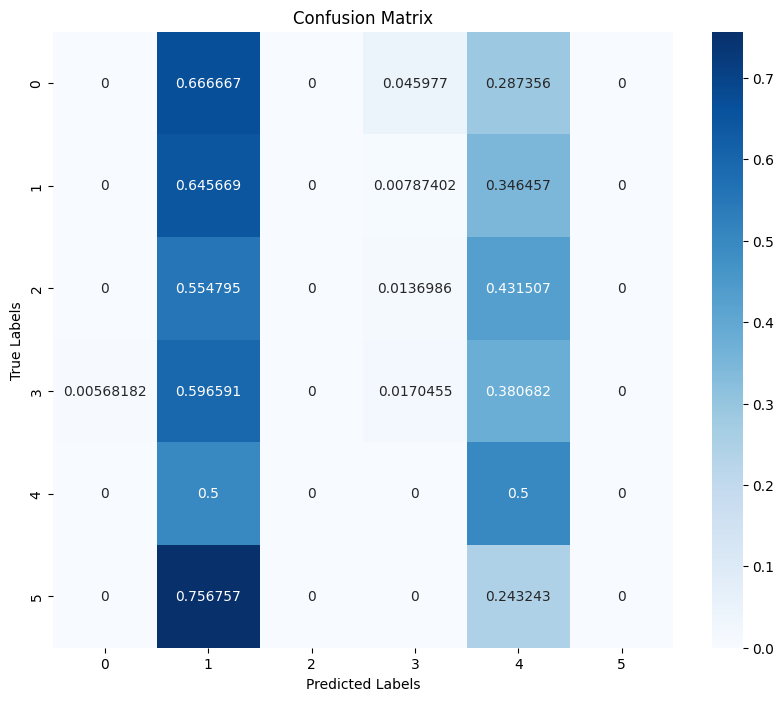

Epoch 14, Validation Loss: 1.7681, Accuracy: 0.1508, F1 Score: 0.0847
Val F1 Score Per Class  [0.         0.33954451 0.         0.03225806 0.01869159 0.        ]


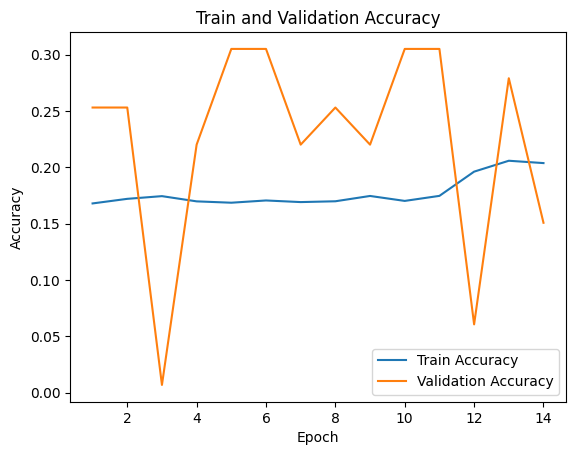

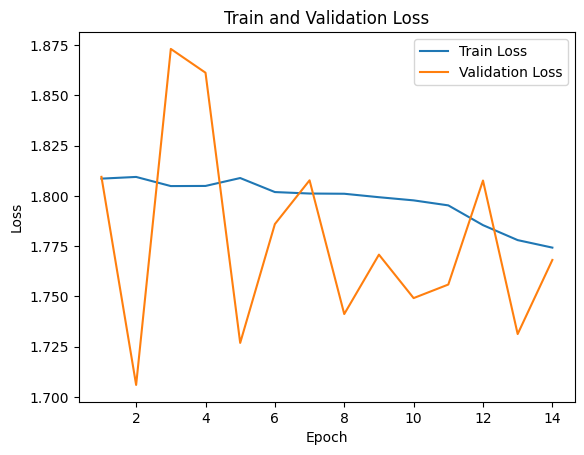

Epoch 15, Train Loss: 1.7793, Accuracy: 0.2065, F1 Score: 0.1564
Train F1 Score Per Class  [0.10355987 0.08824593 0.09322974 0.28614739 0.31177276 0.04570461]


Val:   1%|▏         | 1/73 [00:00<00:30,  2.36it/s, loss=1.76]

[tensor([ 0.0341, -0.0089, -0.0034,  0.1720, -0.2172, -0.0653], device='cuda:0'), tensor([-0.2400, -0.1469, -0.1621, -0.0181,  0.1130, -0.1778], device='cuda:0'), tensor([-0.2282, -0.1026, -0.0929, -0.0331,  0.2240, -0.1199], device='cuda:0'), tensor([-0.0739, -0.0445, -0.0423,  0.0932, -0.0723, -0.0966], device='cuda:0'), tensor([ 0.0336, -0.0149, -0.0125,  0.1755, -0.1967, -0.0751], device='cuda:0'), tensor([-0.1323, -0.0650, -0.0521,  0.0376,  0.0341, -0.0876], device='cuda:0'), tensor([ 0.1322,  0.0195,  0.0265,  0.2499, -0.4602, -0.0440], device='cuda:0'), tensor([-0.0807, -0.0343, -0.0184,  0.0790, -0.0585, -0.0724], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.41it/s, loss=1.77]

[tensor([ 0.0428, -0.0063, -0.0053,  0.1826, -0.3147, -0.0711], device='cuda:0'), tensor([-0.0616, -0.0462, -0.0457,  0.1040, -0.1820, -0.0993], device='cuda:0'), tensor([-0.1374, -0.0569, -0.0422,  0.0344,  0.0282, -0.0853], device='cuda:0'), tensor([ 0.0241, -0.0149, -0.0103,  0.1668, -0.2768, -0.0732], device='cuda:0'), tensor([ 0.0059, -0.0223, -0.0188,  0.1543, -0.1683, -0.0761], device='cuda:0'), tensor([ 0.0140, -0.0178, -0.0123,  0.1585, -0.1606, -0.0713], device='cuda:0'), tensor([ 0.1072,  0.0110,  0.0151,  0.2309, -0.3868, -0.0542], device='cuda:0'), tensor([ 0.0361, -0.0076, -0.0012,  0.1761, -0.2236, -0.0672], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.36it/s, loss=1.77]

[tensor([ 0.0811,  0.0080,  0.0166,  0.2090, -0.3783, -0.0496], device='cuda:0'), tensor([-0.0183, -0.0189, -0.0105,  0.1303, -0.0850, -0.0699], device='cuda:0'), tensor([-0.0007, -0.0192, -0.0145,  0.1478, -0.3871, -0.0740], device='cuda:0'), tensor([-0.1273, -0.0829, -0.0921,  0.0581, -0.2493, -0.1293], device='cuda:0'), tensor([-0.0682, -0.0341, -0.0224,  0.0908, -0.1819, -0.0758], device='cuda:0'), tensor([-0.0625, -0.0402, -0.0330,  0.0979, -0.2021, -0.0837], device='cuda:0'), tensor([ 0.0740,  0.0009,  0.0022,  0.2102, -0.3366, -0.0685], device='cuda:0'), tensor([-0.0113, -0.0194, -0.0112,  0.1382, -0.2195, -0.0730], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.39it/s, loss=1.72]

[tensor([ 0.0187, -0.0099,  0.0030,  0.1567, -0.3113, -0.0567], device='cuda:0'), tensor([-0.0697, -0.0413, -0.0458,  0.0960, -0.1808, -0.1048], device='cuda:0'), tensor([ 0.1102,  0.0126,  0.0178,  0.2341, -0.4220, -0.0510], device='cuda:0'), tensor([ 0.0222, -0.0200, -0.0186,  0.1698, -0.4213, -0.0798], device='cuda:0'), tensor([-0.1826, -0.0760, -0.0576, -0.0042,  0.1139, -0.0905], device='cuda:0'), tensor([ 0.1028,  0.0106,  0.0154,  0.2285, -0.4001, -0.0525], device='cuda:0'), tensor([ 0.0939,  0.0106,  0.0174,  0.2195, -0.3689, -0.0523], device='cuda:0'), tensor([ 0.0236, -0.0114, -0.0053,  0.1670, -0.4017, -0.0692], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=1.83]

[tensor([-0.0027, -0.0207, -0.0165,  0.1476, -0.1022, -0.0781], device='cuda:0'), tensor([ 0.0942,  0.0028,  0.0062,  0.2229, -0.4347, -0.0584], device='cuda:0'), tensor([-1.8800e-01, -8.8731e-02, -8.2735e-02,  1.0731e-04,  3.1256e-01,
        -1.1830e-01], device='cuda:0'), tensor([-0.1222, -0.0540, -0.0420,  0.0482, -0.0443, -0.0877], device='cuda:0'), tensor([-0.0360, -0.0355, -0.0312,  0.1199, -0.2979, -0.0830], device='cuda:0'), tensor([-0.0677, -0.0415, -0.0339,  0.0923, -0.0884, -0.0825], device='cuda:0'), tensor([-0.0647, -0.0372, -0.0325,  0.0938, -0.0729, -0.0871], device='cuda:0'), tensor([-0.8318, -0.4332, -0.6552, -0.3230,  0.9725, -0.6503], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.39it/s, loss=1.71]

[tensor([ 0.0169, -0.0116, -0.0074,  0.1627, -0.2793, -0.0717], device='cuda:0'), tensor([ 0.1206,  0.0153,  0.0232,  0.2398, -0.4450, -0.0453], device='cuda:0'), tensor([-0.1119, -0.0577, -0.0540,  0.0612, -0.0567, -0.1004], device='cuda:0'), tensor([ 0.0938,  0.0060,  0.0101,  0.2222, -0.3863, -0.0569], device='cuda:0'), tensor([ 0.0131, -0.0185, -0.0167,  0.1612, -0.2491, -0.0782], device='cuda:0'), tensor([-0.0615, -0.0353, -0.0276,  0.0993, -0.1399, -0.0828], device='cuda:0'), tensor([-0.0111, -0.0223, -0.0181,  0.1413, -0.2661, -0.0795], device='cuda:0'), tensor([ 0.0805,  0.0044,  0.0082,  0.2125, -0.3246, -0.0596], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=1.76]

[tensor([ 0.0556,  0.0004,  0.0100,  0.1882, -0.2739, -0.0567], device='cuda:0'), tensor([ 0.0406, -0.0048,  0.0027,  0.1789, -0.3254, -0.0613], device='cuda:0'), tensor([-0.1195, -0.0500, -0.0331,  0.0471, -0.0531, -0.0775], device='cuda:0'), tensor([-0.2343, -0.0873, -0.0707, -0.0425,  0.2036, -0.1047], device='cuda:0'), tensor([ 0.0021, -0.0142, -0.0071,  0.1499, -0.1553, -0.0704], device='cuda:0'), tensor([-0.1169, -0.0553, -0.0404,  0.0501, -0.1750, -0.0806], device='cuda:0'), tensor([ 6.8788e-02,  3.3093e-04,  2.7743e-04,  2.0254e-01, -4.5515e-01,
        -6.5104e-02], device='cuda:0'), tensor([-0.0803, -0.0413, -0.0357,  0.0858, -0.0545, -0.0896], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=1.7]

[tensor([ 0.0266, -0.0059,  0.0022,  0.1674, -0.2171, -0.0627], device='cuda:0'), tensor([-0.2133, -0.1008, -0.0909, -0.0348,  0.2168, -0.1162], device='cuda:0'), tensor([-0.0113, -0.0193, -0.0087,  0.1344, -0.2034, -0.0629], device='cuda:0'), tensor([ 0.0886,  0.0071,  0.0136,  0.2166, -0.3712, -0.0538], device='cuda:0'), tensor([ 0.0670,  0.0019,  0.0084,  0.2003, -0.3034, -0.0578], device='cuda:0'), tensor([ 0.0520, -0.0013,  0.0076,  0.1873, -0.3415, -0.0570], device='cuda:0'), tensor([ 0.0667,  0.0018,  0.0064,  0.2026, -0.3816, -0.0649], device='cuda:0'), tensor([-0.0455, -0.0413, -0.0403,  0.1152, -0.2433, -0.0936], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=1.75]

[tensor([-0.0152, -0.0226, -0.0195,  0.1309, -0.2742, -0.0783], device='cuda:0'), tensor([-0.0659, -0.0379, -0.0304,  0.0958,  0.0114, -0.0835], device='cuda:0'), tensor([-0.1313, -0.0558, -0.0499,  0.0432,  0.0894, -0.0967], device='cuda:0'), tensor([-0.0341, -0.0264, -0.0188,  0.1213, -0.1090, -0.0788], device='cuda:0'), tensor([ 0.0666, -0.0127, -0.0188,  0.2094, -0.2552, -0.0833], device='cuda:0'), tensor([ 0.0539, -0.0009,  0.0055,  0.1868, -0.3263, -0.0582], device='cuda:0'), tensor([-0.0990, -0.0526, -0.0440,  0.0638,  0.0178, -0.0844], device='cuda:0'), tensor([-0.0802, -0.0432, -0.0349,  0.0825, -0.0785, -0.0829], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=1.78]

[tensor([-0.0046, -0.0169, -0.0106,  0.1432, -0.1959, -0.0747], device='cuda:0'), tensor([ 0.0244, -0.0123, -0.0062,  0.1654, -0.3391, -0.0681], device='cuda:0'), tensor([ 0.0521, -0.0022,  0.0040,  0.1883, -0.4718, -0.0627], device='cuda:0'), tensor([-0.0413, -0.0303, -0.0274,  0.1123, -0.0581, -0.0803], device='cuda:0'), tensor([-0.1477, -0.0662, -0.0586,  0.0272,  0.1890, -0.1014], device='cuda:0'), tensor([-0.0420, -0.0339, -0.0324,  0.1181, -0.2921, -0.0886], device='cuda:0'), tensor([-0.2241, -0.0798, -0.0743, -0.0452,  0.0658, -0.1111], device='cuda:0'), tensor([ 0.0144, -0.0177, -0.0141,  0.1617, -0.2546, -0.0763], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=1.81]

[tensor([ 0.0094, -0.0241, -0.0238,  0.1585, -0.3141, -0.0817], device='cuda:0'), tensor([ 0.0214, -0.0149, -0.0111,  0.1662, -0.3793, -0.0726], device='cuda:0'), tensor([ 0.0028, -0.0200, -0.0176,  0.1514, -0.3175, -0.0788], device='cuda:0'), tensor([ 0.0116, -0.0107,  0.0031,  0.1507, -0.3372, -0.0575], device='cuda:0'), tensor([-0.0042, -0.0164, -0.0104,  0.1416, -0.1187, -0.0719], device='cuda:0'), tensor([-0.1048, -0.0429, -0.0239,  0.0557, -0.0787, -0.0711], device='cuda:0'), tensor([-0.1090, -0.0503, -0.0394,  0.0589, -0.0081, -0.0846], device='cuda:0'), tensor([-0.0185, -0.0252, -0.0171,  0.1331, -0.2601, -0.0752], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=1.72]

[tensor([-0.1486, -0.0695, -0.0645,  0.0319,  0.0916, -0.1050], device='cuda:0'), tensor([ 0.0804, -0.0007, -0.0007,  0.2097, -0.2872, -0.0646], device='cuda:0'), tensor([ 0.0777,  0.0044,  0.0108,  0.2089, -0.3733, -0.0572], device='cuda:0'), tensor([-0.0561, -0.0410, -0.0370,  0.0995,  0.0063, -0.0829], device='cuda:0'), tensor([ 1.8420e-03, -1.4102e-02,  1.1851e-04,  1.4308e-01, -3.5175e-01,
        -5.5999e-02], device='cuda:0'), tensor([ 0.0308, -0.0142, -0.0111,  0.1746, -0.2654, -0.0738], device='cuda:0'), tensor([ 0.0584, -0.0014,  0.0038,  0.1933, -0.4520, -0.0609], device='cuda:0'), tensor([-0.0504, -0.0298, -0.0189,  0.1036, -0.2609, -0.0704], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.72]

[tensor([ 0.0363, -0.0062,  0.0015,  0.1754, -0.2866, -0.0611], device='cuda:0'), tensor([-0.0067, -0.0185, -0.0122,  0.1436, -0.3368, -0.0743], device='cuda:0'), tensor([-0.0532, -0.0428, -0.0331,  0.1018, -0.1876, -0.0772], device='cuda:0'), tensor([-0.2430, -0.0939, -0.0716, -0.0537,  0.2539, -0.0971], device='cuda:0'), tensor([ 0.0091, -0.0191, -0.0148,  0.1530, -0.1886, -0.0760], device='cuda:0'), tensor([ 0.0332, -0.0181, -0.0166,  0.1752, -0.3693, -0.0728], device='cuda:0'), tensor([-0.1480, -0.0599, -0.0442,  0.0186, -0.0535, -0.0834], device='cuda:0'), tensor([-0.0364, -0.0283, -0.0164,  0.1147, -0.1981, -0.0686], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.72]

[tensor([-0.1344, -0.0540, -0.0510,  0.0360, -0.0064, -0.0997], device='cuda:0'), tensor([-0.0096, -0.0201, -0.0138,  0.1406, -0.3325, -0.0742], device='cuda:0'), tensor([-0.0664, -0.0334, -0.0241,  0.0940, -0.1045, -0.0786], device='cuda:0'), tensor([ 0.0102, -0.0196, -0.0177,  0.1587, -0.2690, -0.0774], device='cuda:0'), tensor([-0.0967, -0.0484, -0.0414,  0.0713,  0.0439, -0.0900], device='cuda:0'), tensor([-0.0586, -0.0341, -0.0268,  0.1018, -0.0582, -0.0823], device='cuda:0'), tensor([-0.0898, -0.0411, -0.0303,  0.0756, -0.0516, -0.0835], device='cuda:0'), tensor([-0.0260, -0.0261, -0.0226,  0.1268, -0.2948, -0.0827], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=1.78]

[tensor([ 0.0159, -0.0259, -0.0249,  0.1619, -0.3274, -0.0818], device='cuda:0'), tensor([ 0.0029, -0.0208, -0.0173,  0.1491, -0.2258, -0.0765], device='cuda:0'), tensor([-0.0159, -0.0211, -0.0119,  0.1333, -0.1706, -0.0743], device='cuda:0'), tensor([-0.0173, -0.0260, -0.0242,  0.1371, -0.1346, -0.0839], device='cuda:0'), tensor([ 0.0562, -0.0016,  0.0051,  0.1920, -0.3195, -0.0627], device='cuda:0'), tensor([-0.1026, -0.0449, -0.0368,  0.0606, -0.0432, -0.0892], device='cuda:0'), tensor([-0.0088, -0.0249, -0.0224,  0.1436, -0.1372, -0.0818], device='cuda:0'), tensor([-0.0834, -0.0531, -0.0433,  0.0782, -0.0125, -0.0854], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=1.75]

[tensor([-0.1008, -0.0484, -0.0365,  0.0644, -0.3359, -0.0818], device='cuda:0'), tensor([-0.0654, -0.0453, -0.0435,  0.0996, -0.0253, -0.0947], device='cuda:0'), tensor([-0.0817, -0.0346, -0.0140,  0.0738, -0.2505, -0.0638], device='cuda:0'), tensor([-0.2468, -0.1055, -0.0954, -0.0532,  0.3830, -0.1156], device='cuda:0'), tensor([-0.0307, -0.0330, -0.0343,  0.1267, -0.1569, -0.0933], device='cuda:0'), tensor([-0.0335, -0.0236, -0.0067,  0.1157, -0.3270, -0.0665], device='cuda:0'), tensor([-0.0223, -0.0275, -0.0241,  0.1328, -0.2724, -0.0833], device='cuda:0'), tensor([-0.0507, -0.0277, -0.0101,  0.1005, -0.2189, -0.0688], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=1.76]

[tensor([-0.1588, -0.0584, -0.0408,  0.0159,  0.2132, -0.0825], device='cuda:0'), tensor([-0.0009, -0.0196, -0.0132,  0.1471, -0.3549, -0.0724], device='cuda:0'), tensor([ 0.0369, -0.0149, -0.0148,  0.1790, -0.3549, -0.0739], device='cuda:0'), tensor([-0.1303, -0.0557, -0.0328,  0.0333,  0.0482, -0.0744], device='cuda:0'), tensor([ 0.0003, -0.0169, -0.0091,  0.1473, -0.2461, -0.0690], device='cuda:0'), tensor([-0.0057, -0.0186, -0.0152,  0.1408, -0.1610, -0.0751], device='cuda:0'), tensor([-0.1766, -0.1468, -0.2099,  0.0237,  0.1202, -0.2472], device='cuda:0'), tensor([-0.0021, -0.0173, -0.0056,  0.1410, -0.3427, -0.0621], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.39it/s, loss=1.77]

[tensor([-0.1796, -0.0752, -0.0667,  0.0015,  0.3475, -0.1055], device='cuda:0'), tensor([ 0.0836,  0.0050,  0.0110,  0.2099, -0.3568, -0.0564], device='cuda:0'), tensor([-0.1948, -0.0722, -0.0564, -0.0181,  0.1866, -0.0980], device='cuda:0'), tensor([ 0.0125, -0.0124, -0.0028,  0.1561, -0.2269, -0.0643], device='cuda:0'), tensor([-0.0769, -0.0427, -0.0372,  0.0871, -0.1683, -0.0878], device='cuda:0'), tensor([ 0.0087, -0.0197, -0.0193,  0.1589, -0.2235, -0.0827], device='cuda:0'), tensor([-0.0187, -0.0256, -0.0189,  0.1321, -0.1729, -0.0747], device='cuda:0'), tensor([-0.1917, -0.0730, -0.0531, -0.0115,  0.1596, -0.0893], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.75]

[tensor([-0.0116, -0.0214, -0.0110,  0.1346, -0.3164, -0.0650], device='cuda:0'), tensor([-0.1793, -0.0885, -0.0838,  0.0089,  0.0514, -0.1162], device='cuda:0'), tensor([-0.1883, -0.1191, -0.1348,  0.0205,  0.0049, -0.1625], device='cuda:0'), tensor([ 0.0298, -0.0129, -0.0122,  0.1757, -0.2057, -0.0763], device='cuda:0'), tensor([-0.1246, -0.0633, -0.0713,  0.0428,  0.0644, -0.1186], device='cuda:0'), tensor([-0.0583, -0.0363, -0.0276,  0.0994, -0.0736, -0.0770], device='cuda:0'), tensor([-0.2247, -0.0909, -0.0803, -0.0324,  0.3028, -0.1114], device='cuda:0'), tensor([-0.0241, -0.0261, -0.0183,  0.1197, -0.1144, -0.0743], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=1.73]

[tensor([-0.1563, -0.0715, -0.0590,  0.0194, -0.0283, -0.0928], device='cuda:0'), tensor([-0.0981, -0.0667, -0.0661,  0.0735, -0.0150, -0.1034], device='cuda:0'), tensor([-0.0201, -0.0288, -0.0246,  0.1329, -0.2462, -0.0800], device='cuda:0'), tensor([-0.0711, -0.0366, -0.0184,  0.0823, -0.4036, -0.0728], device='cuda:0'), tensor([ 0.0879,  0.0066,  0.0134,  0.2159, -0.4079, -0.0539], device='cuda:0'), tensor([ 0.0020, -0.0224, -0.0196,  0.1515, -0.3825, -0.0786], device='cuda:0'), tensor([ 0.0278, -0.0085, -0.0071,  0.1679, -0.2422, -0.0741], device='cuda:0'), tensor([ 0.0239, -0.0153, -0.0134,  0.1706, -0.2788, -0.0783], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=1.8]

[tensor([-0.1406, -0.0678, -0.0541,  0.0317, -0.1850, -0.0905], device='cuda:0'), tensor([-0.2930, -0.1230, -0.1130, -0.0826,  0.4056, -0.1341], device='cuda:0'), tensor([ 0.0181, -0.0123, -0.0056,  0.1609, -0.2566, -0.0652], device='cuda:0'), tensor([-0.1967, -0.0818, -0.0762, -0.0101,  0.2838, -0.1119], device='cuda:0'), tensor([ 0.0205, -0.0165, -0.0139,  0.1666, -0.4115, -0.0750], device='cuda:0'), tensor([-0.1686, -0.0813, -0.0727,  0.0138,  0.2063, -0.1061], device='cuda:0'), tensor([-0.2822, -0.1231, -0.1128, -0.0749,  0.1894, -0.1316], device='cuda:0'), tensor([ 0.0091, -0.0133, -0.0005,  0.1502, -0.2019, -0.0575], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=1.81]

[tensor([-0.0692, -0.0402, -0.0345,  0.0938, -0.0467, -0.0878], device='cuda:0'), tensor([-0.0535, -0.0442, -0.0522,  0.1118, -0.0013, -0.1086], device='cuda:0'), tensor([-0.0787, -0.0408, -0.0320,  0.0849, -0.0830, -0.0843], device='cuda:0'), tensor([ 0.0614, -0.0029, -0.0008,  0.1985, -0.4102, -0.0668], device='cuda:0'), tensor([-0.3003, -0.1506, -0.1561, -0.0739,  0.3482, -0.1700], device='cuda:0'), tensor([-0.1128, -0.0518, -0.0390,  0.0538, -0.1788, -0.0858], device='cuda:0'), tensor([-0.1676, -0.0720, -0.0637,  0.0147,  0.0796, -0.1038], device='cuda:0'), tensor([-0.1167, -0.0474, -0.0356,  0.0469,  0.0331, -0.0822], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=1.72]

[tensor([ 0.0693,  0.0035,  0.0104,  0.2029, -0.3837, -0.0582], device='cuda:0'), tensor([-0.0137, -0.0220, -0.0122,  0.1346, -0.2665, -0.0687], device='cuda:0'), tensor([ 0.1086,  0.0118,  0.0172,  0.2332, -0.4182, -0.0514], device='cuda:0'), tensor([ 0.0171, -0.0139, -0.0112,  0.1625, -0.3965, -0.0713], device='cuda:0'), tensor([ 0.0142, -0.0198, -0.0177,  0.1616, -0.2323, -0.0777], device='cuda:0'), tensor([ 6.8074e-02, -1.6840e-05,  6.3584e-03,  2.0103e-01, -2.9080e-01,
        -5.8977e-02], device='cuda:0'), tensor([ 0.0530, -0.0055,  0.0005,  0.1899, -0.3083, -0.0627], device='cuda:0'), tensor([-0.1174, -0.0503, -0.0402,  0.0484,  0.0915, -0.0856], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=1.77]

[tensor([-0.1062, -0.0525, -0.0446,  0.0602, -0.0336, -0.0910], device='cuda:0'), tensor([ 0.0769,  0.0029,  0.0073,  0.2057, -0.3633, -0.0594], device='cuda:0'), tensor([ 0.1285,  0.0206,  0.0294,  0.2462, -0.4444, -0.0411], device='cuda:0'), tensor([-0.0365, -0.0244, -0.0120,  0.1132, -0.2643, -0.0731], device='cuda:0'), tensor([ 0.0100, -0.0139, -0.0095,  0.1552, -0.1509, -0.0721], device='cuda:0'), tensor([ 0.0175, -0.0131, -0.0054,  0.1591, -0.3216, -0.0628], device='cuda:0'), tensor([-0.2210, -0.0887, -0.1050, -0.0319, -0.0155, -0.1493], device='cuda:0'), tensor([-0.2325, -0.0900, -0.0762, -0.0397,  0.2235, -0.1087], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=1.65]

[tensor([-0.4375, -0.1965, -0.2730, -0.1762,  0.9373, -0.3054], device='cuda:0'), tensor([-0.1202, -0.0619, -0.0573,  0.0546,  0.0613, -0.1031], device='cuda:0'), tensor([-0.0373, -0.0280, -0.0145,  0.1116, -0.3287, -0.0673], device='cuda:0'), tensor([-0.0235, -0.0226, -0.0136,  0.1241, -0.2518, -0.0711], device='cuda:0'), tensor([ 0.0261, -0.0102, -0.0016,  0.1661, -0.3910, -0.0619], device='cuda:0'), tensor([ 0.0844,  0.0094,  0.0181,  0.2117, -0.3850, -0.0496], device='cuda:0'), tensor([-0.1033, -0.0567, -0.0535,  0.0608, -0.1450, -0.1001], device='cuda:0'), tensor([-0.2802, -0.0956, -0.0553, -0.1032,  0.2177, -0.0733], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.7]

[tensor([ 0.0287, -0.0080,  0.0005,  0.1682, -0.2366, -0.0605], device='cuda:0'), tensor([ 0.0266, -0.0102, -0.0030,  0.1683, -0.2210, -0.0660], device='cuda:0'), tensor([ 0.0894,  0.0034,  0.0070,  0.2182, -0.4648, -0.0575], device='cuda:0'), tensor([-0.0648, -0.0334, -0.0188,  0.0861, -0.0286, -0.0678], device='cuda:0'), tensor([ 0.0169, -0.0239, -0.0240,  0.1642, -0.2477, -0.0807], device='cuda:0'), tensor([ 0.0463, -0.0015,  0.0065,  0.1826, -0.4754, -0.0583], device='cuda:0'), tensor([-0.0298, -0.0237, -0.0147,  0.1236, -0.1847, -0.0737], device='cuda:0'), tensor([-0.1583, -0.0674, -0.0532,  0.0171, -0.0030, -0.0914], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=1.76]

[tensor([ 0.0542, -0.0042,  0.0005,  0.1913, -0.3467, -0.0646], device='cuda:0'), tensor([-0.0121, -0.0230, -0.0144,  0.1355, -0.1306, -0.0679], device='cuda:0'), tensor([ 0.0137, -0.0178, -0.0147,  0.1607, -0.1766, -0.0755], device='cuda:0'), tensor([ 0.0930, -0.0023, -0.0055,  0.2292, -0.2792, -0.0744], device='cuda:0'), tensor([ 4.8373e-02, -1.7794e-04,  8.2339e-03,  1.8323e-01, -2.5768e-01,
        -5.8445e-02], device='cuda:0'), tensor([-0.1249, -0.0481, -0.0337,  0.0428,  0.0106, -0.0828], device='cuda:0'), tensor([-0.0394, -0.0276, -0.0183,  0.1155, -0.0565, -0.0761], device='cuda:0'), tensor([-0.0660, -0.0351, -0.0209,  0.0898,  0.0145, -0.0707], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=1.74]

[tensor([-0.0180, -0.0204, -0.0118,  0.1300, -0.1335, -0.0711], device='cuda:0'), tensor([ 0.1076,  0.0053,  0.0068,  0.2328, -0.5961, -0.0569], device='cuda:0'), tensor([-0.0999, -0.0490, -0.0425,  0.0689, -0.0463, -0.0909], device='cuda:0'), tensor([ 0.0173, -0.0076,  0.0025,  0.1543, -0.2500, -0.0635], device='cuda:0'), tensor([-0.0224, -0.0274, -0.0234,  0.1324, -0.2135, -0.0822], device='cuda:0'), tensor([-0.1250, -0.0593, -0.0571,  0.0530, -0.1318, -0.1057], device='cuda:0'), tensor([-0.0521, -0.0316, -0.0183,  0.1010, -0.0923, -0.0738], device='cuda:0'), tensor([ 0.0110, -0.0101,  0.0008,  0.1534, -0.2248, -0.0616], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=1.77]

[tensor([-0.0054, -0.0213, -0.0189,  0.1458, -0.0952, -0.0806], device='cuda:0'), tensor([ 0.0558,  0.0038,  0.0141,  0.1875, -0.4597, -0.0518], device='cuda:0'), tensor([-0.1720, -0.0728, -0.0640,  0.0067,  0.0879, -0.1043], device='cuda:0'), tensor([ 0.1033,  0.0078,  0.0138,  0.2272, -0.4115, -0.0506], device='cuda:0'), tensor([-0.0533, -0.0309, -0.0299,  0.0979, -0.0101, -0.0898], device='cuda:0'), tensor([ 0.0308, -0.0096, -0.0022,  0.1710, -0.2481, -0.0639], device='cuda:0'), tensor([-0.1435, -0.0718, -0.0691,  0.0375,  0.2351, -0.1111], device='cuda:0'), tensor([ 0.0415, -0.0069, -0.0015,  0.1805, -0.3189, -0.0650], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=1.78]

[tensor([ 0.0383, -0.0051,  0.0053,  0.1742, -0.3598, -0.0595], device='cuda:0'), tensor([-0.0771, -0.0396, -0.0264,  0.0725,  0.0035, -0.0762], device='cuda:0'), tensor([ 0.0919,  0.0065,  0.0111,  0.2212, -0.4094, -0.0582], device='cuda:0'), tensor([-0.1090, -0.0450, -0.0293,  0.0562,  0.1308, -0.0800], device='cuda:0'), tensor([ 0.0727,  0.0004,  0.0053,  0.2042, -0.3830, -0.0612], device='cuda:0'), tensor([ 0.0168, -0.0209, -0.0174,  0.1613, -0.2603, -0.0726], device='cuda:0'), tensor([-0.0803, -0.0380, -0.0324,  0.0735,  0.0418, -0.0856], device='cuda:0'), tensor([-0.1690, -0.0605, -0.0400,  0.0041,  0.1087, -0.0845], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.38it/s, loss=1.75]

[tensor([ 0.0653,  0.0011,  0.0069,  0.1995, -0.3431, -0.0611], device='cuda:0'), tensor([ 0.1077,  0.0140,  0.0211,  0.2318, -0.4960, -0.0494], device='cuda:0'), tensor([-0.0005, -0.0197, -0.0103,  0.1446, -0.3117, -0.0712], device='cuda:0'), tensor([-0.0113, -0.0201, -0.0133,  0.1351, -0.1404, -0.0694], device='cuda:0'), tensor([ 0.0311, -0.0099, -0.0062,  0.1733, -0.2530, -0.0703], device='cuda:0'), tensor([-0.0823, -0.0322, -0.0160,  0.0728, -0.2038, -0.0713], device='cuda:0'), tensor([ 0.0612, -0.0018,  0.0039,  0.1964, -0.3175, -0.0607], device='cuda:0'), tensor([ 0.0305, -0.0084, -0.0028,  0.1718, -0.3332, -0.0660], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=1.76]

[tensor([-0.0146, -0.0316, -0.0297,  0.1382, -0.2088, -0.0827], device='cuda:0'), tensor([-0.0008, -0.0220, -0.0205,  0.1503, -0.1884, -0.0796], device='cuda:0'), tensor([ 0.0154, -0.0173, -0.0139,  0.1614, -0.2136, -0.0731], device='cuda:0'), tensor([-0.1265, -0.0605, -0.0565,  0.0496, -0.0255, -0.1020], device='cuda:0'), tensor([-0.0259, -0.0208, -0.0083,  0.1231, -0.1566, -0.0684], device='cuda:0'), tensor([ 0.1248,  0.0121,  0.0142,  0.2478, -0.5932, -0.0549], device='cuda:0'), tensor([-0.0230, -0.0262, -0.0212,  0.1292, -0.0281, -0.0800], device='cuda:0'), tensor([ 0.0963,  0.0103,  0.0169,  0.2230, -0.4247, -0.0524], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=1.73]

[tensor([-0.1024, -0.0629, -0.0646,  0.0728, -0.0374, -0.1110], device='cuda:0'), tensor([ 0.1019,  0.0112,  0.0191,  0.2262, -0.4251, -0.0500], device='cuda:0'), tensor([ 0.0850,  0.0046,  0.0092,  0.2155, -0.4926, -0.0603], device='cuda:0'), tensor([ 0.0876,  0.0060,  0.0104,  0.2167, -0.3700, -0.0562], device='cuda:0'), tensor([-0.3019, -0.1717, -0.1998, -0.0587,  0.0735, -0.2118], device='cuda:0'), tensor([ 0.0731,  0.0071,  0.0183,  0.2012, -0.4241, -0.0519], device='cuda:0'), tensor([-0.0597, -0.0348, -0.0246,  0.0987, -0.2616, -0.0781], device='cuda:0'), tensor([-0.0113, -0.0194, -0.0107,  0.1376, -0.1525, -0.0701], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.38it/s, loss=1.71]

[tensor([ 0.0551, -0.0044, -0.0007,  0.1933, -0.3944, -0.0674], device='cuda:0'), tensor([ 0.1036,  0.0104,  0.0182,  0.2237, -0.4191, -0.0451], device='cuda:0'), tensor([ 0.0786,  0.0073,  0.0163,  0.2074, -0.3701, -0.0516], device='cuda:0'), tensor([-0.0194, -0.0263, -0.0215,  0.1334, -0.2560, -0.0783], device='cuda:0'), tensor([-0.0516, -0.0321, -0.0232,  0.1046, -0.3035, -0.0777], device='cuda:0'), tensor([-0.0045, -0.0201, -0.0144,  0.1449, -0.2951, -0.0753], device='cuda:0'), tensor([-0.1254, -0.0586, -0.0500,  0.0473,  0.0137, -0.0924], device='cuda:0'), tensor([-0.0015, -0.0194, -0.0113,  0.1389, -0.2839, -0.0714], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=1.75]

[tensor([-0.4000, -0.1403, -0.2007, -0.2159, -0.0017, -0.2406], device='cuda:0'), tensor([ 0.0826,  0.0069,  0.0143,  0.2104, -0.4882, -0.0500], device='cuda:0'), tensor([ 0.0329, -0.0096, -0.0041,  0.1718, -0.3960, -0.0689], device='cuda:0'), tensor([ 0.0983,  0.0063,  0.0109,  0.2247, -0.4853, -0.0545], device='cuda:0'), tensor([-0.2682, -0.1546, -0.1715, -0.0404,  0.0971, -0.1813], device='cuda:0'), tensor([ 0.0791,  0.0035,  0.0081,  0.2075, -0.3976, -0.0594], device='cuda:0'), tensor([ 0.0281, -0.0149, -0.0131,  0.1734, -0.2791, -0.0770], device='cuda:0'), tensor([ 0.1077,  0.0132,  0.0179,  0.2334, -0.4198, -0.0534], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.38it/s, loss=1.7]

[tensor([-0.0022, -0.0225, -0.0208,  0.1499, -0.2382, -0.0821], device='cuda:0'), tensor([ 0.0160, -0.0106,  0.0013,  0.1562, -0.3525, -0.0583], device='cuda:0'), tensor([-0.0567, -0.0314, -0.0213,  0.0967, -0.1265, -0.0751], device='cuda:0'), tensor([ 0.0321, -0.0061,  0.0014,  0.1724, -0.3501, -0.0624], device='cuda:0'), tensor([-0.0116, -0.0247, -0.0224,  0.1412, -0.1984, -0.0819], device='cuda:0'), tensor([-0.1402, -0.0583, -0.0442,  0.0330, -0.1857, -0.0868], device='cuda:0'), tensor([ 0.0122, -0.0208, -0.0193,  0.1600, -0.3668, -0.0775], device='cuda:0'), tensor([-0.0298, -0.0408, -0.0450,  0.1312, -0.2882, -0.0993], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=1.75]

[tensor([ 0.0528, -0.0003,  0.0049,  0.1814, -0.2758, -0.0614], device='cuda:0'), tensor([ 0.0011, -0.0167, -0.0080,  0.1424, -0.2523, -0.0643], device='cuda:0'), tensor([ 0.1023,  0.0078,  0.0115,  0.2291, -0.4120, -0.0563], device='cuda:0'), tensor([-0.0883, -0.0499, -0.0471,  0.0812, -0.1369, -0.0986], device='cuda:0'), tensor([ 0.0237, -0.0111, -0.0037,  0.1654, -0.1903, -0.0653], device='cuda:0'), tensor([-0.0017, -0.0224, -0.0198,  0.1466, -0.1750, -0.0797], device='cuda:0'), tensor([-0.1596, -0.0717, -0.0666,  0.0235,  0.1655, -0.1070], device='cuda:0'), tensor([-0.1379, -0.0617, -0.0504,  0.0353, -0.0817, -0.0910], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.78]

[tensor([-0.1598, -0.0731, -0.0677,  0.0230,  0.1217, -0.1082], device='cuda:0'), tensor([-0.0591, -0.0414, -0.0364,  0.1018, -0.0053, -0.0871], device='cuda:0'), tensor([ 0.0284, -0.0090, -0.0037,  0.1705, -0.3136, -0.0674], device='cuda:0'), tensor([-0.0764, -0.0470, -0.0372,  0.0830, -0.1646, -0.0809], device='cuda:0'), tensor([ 0.0180, -0.0127, -0.0063,  0.1609, -0.2943, -0.0673], device='cuda:0'), tensor([ 0.0343, -0.0075, -0.0021,  0.1755, -0.2411, -0.0670], device='cuda:0'), tensor([-0.0192, -0.0305, -0.0304,  0.1380, -0.2944, -0.0902], device='cuda:0'), tensor([-0.4959, -0.1906, -0.1987, -0.2725,  0.5406, -0.2039], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=1.75]

[tensor([ 0.0489, -0.0057, -0.0004,  0.1856, -0.2331, -0.0618], device='cuda:0'), tensor([-0.0121, -0.0323, -0.0287,  0.1375, -0.1782, -0.0782], device='cuda:0'), tensor([-0.1480, -0.0623, -0.0430,  0.0221,  0.0377, -0.0809], device='cuda:0'), tensor([ 0.0252, -0.0055,  0.0071,  0.1623, -0.2949, -0.0524], device='cuda:0'), tensor([-0.0580, -0.0296, -0.0137,  0.0931, -0.0126, -0.0675], device='cuda:0'), tensor([ 0.1078,  0.0108,  0.0158,  0.2314, -0.3894, -0.0493], device='cuda:0'), tensor([ 0.0794,  0.0037,  0.0090,  0.2108, -0.3658, -0.0593], device='cuda:0'), tensor([ 0.0842,  0.0065,  0.0137,  0.2128, -0.3751, -0.0528], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=1.8]

[tensor([-0.0868, -0.0483, -0.0393,  0.0767, -0.0240, -0.0856], device='cuda:0'), tensor([ 0.0697,  0.0037,  0.0099,  0.2029, -0.3586, -0.0583], device='cuda:0'), tensor([-0.1183, -0.0613, -0.0564,  0.0558,  0.0310, -0.1030], device='cuda:0'), tensor([ 0.0886,  0.0054,  0.0109,  0.2171, -0.4888, -0.0541], device='cuda:0'), tensor([-0.0297, -0.0227, -0.0160,  0.1193, -0.0438, -0.0720], device='cuda:0'), tensor([-0.1782, -0.0618, -0.0397, -0.0099,  0.1059, -0.0823], device='cuda:0'), tensor([-0.1335, -0.0655, -0.0579,  0.0403,  0.1303, -0.1021], device='cuda:0'), tensor([-0.0066, -0.0200, -0.0135,  0.1419, -0.2548, -0.0714], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.38it/s, loss=1.75]

[tensor([-0.0315, -0.0366, -0.0394,  0.1288, -0.3475, -0.0958], device='cuda:0'), tensor([-0.1374, -0.0653, -0.0556,  0.0365, -0.0034, -0.0933], device='cuda:0'), tensor([-0.2829, -0.1089, -0.0911, -0.0812,  0.1798, -0.1176], device='cuda:0'), tensor([ 5.4123e-02, -4.4122e-03,  3.4498e-04,  1.8935e-01, -4.1558e-01,
        -6.4039e-02], device='cuda:0'), tensor([-0.0163, -0.0222, -0.0147,  0.1351, -0.2290, -0.0754], device='cuda:0'), tensor([ 0.0547, -0.0075, -0.0007,  0.1889, -0.3273, -0.0600], device='cuda:0'), tensor([-0.0501, -0.0222, -0.0042,  0.0977, -0.1571, -0.0606], device='cuda:0'), tensor([-0.1289, -0.0579, -0.0445,  0.0402, -0.0005, -0.0928], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.38it/s, loss=1.7]

[tensor([ 0.0553, -0.0021,  0.0022,  0.1884, -0.3668, -0.0621], device='cuda:0'), tensor([ 0.0574, -0.0013,  0.0052,  0.1921, -0.3772, -0.0623], device='cuda:0'), tensor([-0.0665, -0.0353, -0.0222,  0.0896, -0.1371, -0.0718], device='cuda:0'), tensor([ 0.1113,  0.0150,  0.0205,  0.2352, -0.4890, -0.0502], device='cuda:0'), tensor([-0.3267, -0.1117, -0.0586, -0.1391,  0.1027, -0.0915], device='cuda:0'), tensor([-0.9021, -0.4858, -0.7449, -0.3429,  1.0210, -0.7253], device='cuda:0'), tensor([-0.0506, -0.0295, -0.0185,  0.1037, -0.1394, -0.0730], device='cuda:0'), tensor([ 0.0355, -0.0111, -0.0094,  0.1785, -0.4069, -0.0732], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.38it/s, loss=1.73]

[tensor([ 0.0761,  0.0028,  0.0081,  0.2068, -0.3424, -0.0583], device='cuda:0'), tensor([-0.0892, -0.0463, -0.0377,  0.0742,  0.0984, -0.0871], device='cuda:0'), tensor([-0.0418, -0.0276, -0.0173,  0.1121, -0.3274, -0.0720], device='cuda:0'), tensor([-0.0141, -0.0239, -0.0201,  0.1389, -0.1601, -0.0810], device='cuda:0'), tensor([-0.0735, -0.0405, -0.0341,  0.0904, -0.0624, -0.0868], device='cuda:0'), tensor([ 0.0262, -0.0068,  0.0016,  0.1646, -0.2190, -0.0622], device='cuda:0'), tensor([-0.1186, -0.0539, -0.0414,  0.0491,  0.1547, -0.0855], device='cuda:0'), tensor([-0.0224, -0.0221, -0.0109,  0.1261, -0.1700, -0.0676], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.38it/s, loss=1.75]

[tensor([-0.1122, -0.0527, -0.0440,  0.0582, -0.0943, -0.0917], device='cuda:0'), tensor([-0.0080, -0.0137,  0.0008,  0.1356, -0.3688, -0.0576], device='cuda:0'), tensor([-0.0567, -0.0387, -0.0334,  0.1032, -0.1831, -0.0850], device='cuda:0'), tensor([-0.1509, -0.0648, -0.0567,  0.0287,  0.1535, -0.1012], device='cuda:0'), tensor([-0.0955, -0.0386, -0.0213,  0.0650,  0.0131, -0.0691], device='cuda:0'), tensor([-0.0840, -0.0487, -0.0372,  0.0771, -0.1175, -0.0786], device='cuda:0'), tensor([ 0.0320, -0.0153, -0.0166,  0.1754, -0.2965, -0.0770], device='cuda:0'), tensor([ 0.0449, -0.0051,  0.0015,  0.1822, -0.3618, -0.0609], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=1.69]

[tensor([-0.0182, -0.0267, -0.0232,  0.1349, -0.2107, -0.0801], device='cuda:0'), tensor([ 0.0411, -0.0046,  0.0038,  0.1788, -0.3758, -0.0601], device='cuda:0'), tensor([ 0.0807,  0.0076,  0.0155,  0.2104, -0.4334, -0.0532], device='cuda:0'), tensor([-0.1146, -0.0677, -0.0649,  0.0533,  0.0586, -0.1051], device='cuda:0'), tensor([-0.0768, -0.0403, -0.0291,  0.0809,  0.0121, -0.0788], device='cuda:0'), tensor([-0.0542, -0.0503, -0.0520,  0.1106, -0.0998, -0.1004], device='cuda:0'), tensor([ 0.0629, -0.0009,  0.0028,  0.1988, -0.4068, -0.0637], device='cuda:0'), tensor([-0.0936, -0.0517, -0.0458,  0.0733, -0.0633, -0.0922], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=1.74]

[tensor([-0.0405, -0.0315, -0.0258,  0.1168, -0.1575, -0.0826], device='cuda:0'), tensor([-0.0036, -0.0178, -0.0113,  0.1450, -0.2450, -0.0716], device='cuda:0'), tensor([ 6.4571e-02, -1.4769e-04,  6.3511e-03,  1.9704e-01, -3.6109e-01,
        -5.7556e-02], device='cuda:0'), tensor([ 0.0121, -0.0181, -0.0169,  0.1611, -0.3291, -0.0808], device='cuda:0'), tensor([ 0.0664,  0.0013,  0.0063,  0.2010, -0.3336, -0.0617], device='cuda:0'), tensor([-0.2258, -0.1018, -0.0955, -0.0287,  0.0180, -0.1247], device='cuda:0'), tensor([-0.0210, -0.0239, -0.0171,  0.1310, -0.1298, -0.0751], device='cuda:0'), tensor([-0.1750, -0.0646, -0.0510,  0.0065,  0.2388, -0.0930], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=1.7]

[tensor([ 0.0845,  0.0072,  0.0130,  0.2142, -0.3637, -0.0551], device='cuda:0'), tensor([-0.0034, -0.0173, -0.0108,  0.1454, -0.1542, -0.0735], device='cuda:0'), tensor([-0.0085, -0.0159,  0.0009,  0.1332, -0.3361, -0.0520], device='cuda:0'), tensor([ 0.0451, -0.0086, -0.0022,  0.1765, -0.2344, -0.0672], device='cuda:0'), tensor([-0.0115, -0.0220, -0.0145,  0.1357, -0.0801, -0.0716], device='cuda:0'), tensor([ 0.0789,  0.0043,  0.0121,  0.2080, -0.4254, -0.0529], device='cuda:0'), tensor([-0.0111, -0.0220, -0.0120,  0.1345, -0.3399, -0.0659], device='cuda:0'), tensor([ 0.0823,  0.0031,  0.0067,  0.2135, -0.3134, -0.0603], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=1.73]

[tensor([-0.0232, -0.0232, -0.0140,  0.1263, -0.2389, -0.0700], device='cuda:0'), tensor([ 0.0826,  0.0067,  0.0153,  0.2109, -0.3216, -0.0515], device='cuda:0'), tensor([-0.1286, -0.0626, -0.0436,  0.0383,  0.0566, -0.0758], device='cuda:0'), tensor([-0.0454, -0.0333, -0.0251,  0.1084, -0.1540, -0.0756], device='cuda:0'), tensor([ 0.0459, -0.0032,  0.0013,  0.1823, -0.3212, -0.0653], device='cuda:0'), tensor([ 0.0344, -0.0077, -0.0028,  0.1761, -0.3265, -0.0684], device='cuda:0'), tensor([-0.0154, -0.0219, -0.0155,  0.1375, -0.2297, -0.0794], device='cuda:0'), tensor([-0.0038, -0.0118,  0.0019,  0.1386, -0.2970, -0.0554], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=1.77]

[tensor([-0.0196, -0.0188, -0.0049,  0.1271, -0.4267, -0.0616], device='cuda:0'), tensor([ 0.0619, -0.0018,  0.0012,  0.1977, -0.3355, -0.0679], device='cuda:0'), tensor([ 1.3670e-04, -1.9137e-02, -1.3760e-02,  1.4846e-01, -2.4004e-01,
        -7.5564e-02], device='cuda:0'), tensor([ 0.0540, -0.0061, -0.0018,  0.1910, -0.4017, -0.0665], device='cuda:0'), tensor([-0.0792, -0.0467, -0.0412,  0.0866, -0.0141, -0.0906], device='cuda:0'), tensor([ 0.0356, -0.0100, -0.0063,  0.1776, -0.2824, -0.0712], device='cuda:0'), tensor([-0.2250, -0.0958, -0.0849, -0.0315,  0.3654, -0.1147], device='cuda:0'), tensor([-0.1495, -0.0627, -0.0506,  0.0259,  0.1380, -0.0904], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.38it/s, loss=1.72]

[tensor([ 0.0493, -0.0028,  0.0038,  0.1860, -0.3954, -0.0610], device='cuda:0'), tensor([-0.0937, -0.0541, -0.0522,  0.0765, -0.0314, -0.0994], device='cuda:0'), tensor([ 0.0416, -0.0090, -0.0056,  0.1813, -0.3520, -0.0667], device='cuda:0'), tensor([ 0.0178, -0.0121, -0.0053,  0.1602, -0.1556, -0.0671], device='cuda:0'), tensor([ 0.0243, -0.0159, -0.0127,  0.1695, -0.5021, -0.0749], device='cuda:0'), tensor([-0.0710, -0.0434, -0.0373,  0.0917, -0.1523, -0.0873], device='cuda:0'), tensor([ 0.1172,  0.0118,  0.0157,  0.2407, -0.4487, -0.0527], device='cuda:0'), tensor([-0.0993, -0.0480, -0.0379,  0.0676,  0.0274, -0.0855], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=1.75]

[tensor([-0.0182, -0.0218, -0.0136,  0.1318, -0.0896, -0.0716], device='cuda:0'), tensor([-0.1195, -0.0610, -0.0562,  0.0532,  0.0921, -0.1009], device='cuda:0'), tensor([-0.0166, -0.0243, -0.0163,  0.1330, -0.3241, -0.0717], device='cuda:0'), tensor([-0.0076, -0.0275, -0.0267,  0.1451, -0.1087, -0.0837], device='cuda:0'), tensor([-0.1397, -0.0749, -0.0749,  0.0413, -0.1824, -0.1149], device='cuda:0'), tensor([ 0.0272, -0.0149, -0.0101,  0.1683, -0.3880, -0.0668], device='cuda:0'), tensor([ 0.0006, -0.0206, -0.0170,  0.1499, -0.2752, -0.0765], device='cuda:0'), tensor([-0.2494, -0.1447, -0.2040, -0.0564,  0.2968, -0.2491], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.37it/s, loss=1.7]

[tensor([ 0.0870,  0.0044,  0.0109,  0.2134, -0.4742, -0.0561], device='cuda:0'), tensor([-0.0089, -0.0215, -0.0126,  0.1391, -0.1511, -0.0694], device='cuda:0'), tensor([ 0.0978,  0.0125,  0.0217,  0.2219, -0.4097, -0.0457], device='cuda:0'), tensor([ 0.0033, -0.0173, -0.0126,  0.1484, -0.1132, -0.0756], device='cuda:0'), tensor([ 0.0674,  0.0008,  0.0068,  0.2012, -0.4360, -0.0613], device='cuda:0'), tensor([ 0.0060, -0.0126, -0.0040,  0.1432, -0.2484, -0.0621], device='cuda:0'), tensor([-0.0280, -0.0162, -0.0011,  0.1149, -0.1383, -0.0573], device='cuda:0'), tensor([-0.0575, -0.0274, -0.0096,  0.0948, -0.0752, -0.0691], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.81]

[tensor([-0.1584, -0.0607, -0.0458,  0.0184,  0.1595, -0.0893], device='cuda:0'), tensor([ 3.6394e-02, -7.9577e-03,  1.9090e-04,  1.7524e-01, -3.9467e-01,
        -6.1671e-02], device='cuda:0'), tensor([-0.1191, -0.0575, -0.0485,  0.0514,  0.0938, -0.0910], device='cuda:0'), tensor([-0.3926, -0.1984, -0.2259, -0.1270,  0.3147, -0.2362], device='cuda:0'), tensor([ 0.0084, -0.0134, -0.0062,  0.1499, -0.1739, -0.0676], device='cuda:0'), tensor([-0.1208, -0.0591, -0.0558,  0.0517,  0.0214, -0.1008], device='cuda:0'), tensor([ 0.0555, -0.0026,  0.0018,  0.1906, -0.2531, -0.0667], device='cuda:0'), tensor([ 0.0865,  0.0082,  0.0159,  0.2142, -0.3188, -0.0514], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=1.72]

[tensor([ 0.0664,  0.0049,  0.0146,  0.1977, -0.3695, -0.0526], device='cuda:0'), tensor([ 4.6930e-02, -5.2031e-03, -1.3045e-04,  1.8506e-01, -3.7653e-01,
        -6.3289e-02], device='cuda:0'), tensor([ 0.0532, -0.0012,  0.0058,  0.1889, -0.2881, -0.0599], device='cuda:0'), tensor([-0.0037, -0.0223, -0.0169,  0.1462, -0.1254, -0.0759], device='cuda:0'), tensor([ 0.0082, -0.0225, -0.0232,  0.1592, -0.3145, -0.0850], device='cuda:0'), tensor([-0.0833, -0.0393, -0.0274,  0.0790, -0.2582, -0.0792], device='cuda:0'), tensor([-0.2136, -0.0789, -0.0645, -0.0353,  0.2281, -0.1015], device='cuda:0'), tensor([-0.0287, -0.0197, -0.0048,  0.1187, -0.3585, -0.0614], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=1.81]

[tensor([-0.1206, -0.0547, -0.0438,  0.0494, -0.0609, -0.0865], device='cuda:0'), tensor([-0.0654, -0.0269, -0.0061,  0.0864, -0.0934, -0.0637], device='cuda:0'), tensor([-0.0924, -0.0576, -0.0485,  0.0727, -0.0475, -0.0896], device='cuda:0'), tensor([-0.1882, -0.0759, -0.0610, -0.0059,  0.2022, -0.0979], device='cuda:0'), tensor([-0.0730, -0.0470, -0.0441,  0.0925, -0.0683, -0.0942], device='cuda:0'), tensor([-0.1218, -0.0647, -0.0661,  0.0497, -0.1368, -0.1089], device='cuda:0'), tensor([-0.2922, -0.1835, -0.2490, -0.0665,  0.3659, -0.2784], device='cuda:0'), tensor([ 0.1132,  0.0155,  0.0215,  0.2361, -0.4828, -0.0493], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=1.75]

[tensor([ 0.0793,  0.0043,  0.0125,  0.2074, -0.3761, -0.0508], device='cuda:0'), tensor([-0.0238, -0.0300, -0.0243,  0.1286, -0.2352, -0.0774], device='cuda:0'), tensor([ 0.0173, -0.0147, -0.0103,  0.1630, -0.2663, -0.0737], device='cuda:0'), tensor([-0.0061, -0.0140,  0.0019,  0.1349, -0.2898, -0.0557], device='cuda:0'), tensor([-0.0255, -0.0180, -0.0055,  0.1101, -0.2548, -0.0606], device='cuda:0'), tensor([-0.1554, -0.0688, -0.0615,  0.0175,  0.2140, -0.1021], device='cuda:0'), tensor([-0.0165, -0.0272, -0.0244,  0.1376, -0.1388, -0.0838], device='cuda:0'), tensor([-0.0820, -0.0463, -0.0399,  0.0832, -0.2142, -0.0901], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.38it/s, loss=1.75]

[tensor([-0.1495, -0.0587, -0.0432,  0.0240,  0.0092, -0.0839], device='cuda:0'), tensor([ 0.0959,  0.0070,  0.0130,  0.2216, -0.3783, -0.0523], device='cuda:0'), tensor([ 0.0324, -0.0119, -0.0070,  0.1737, -0.3711, -0.0682], device='cuda:0'), tensor([ 0.0193, -0.0170, -0.0120,  0.1631, -0.3520, -0.0704], device='cuda:0'), tensor([-0.0420, -0.0336, -0.0301,  0.1165, -0.1118, -0.0853], device='cuda:0'), tensor([ 0.0160, -0.0076,  0.0073,  0.1542, -0.2684, -0.0535], device='cuda:0'), tensor([-0.2202, -0.1381, -0.1610,  0.0011,  0.1836, -0.1845], device='cuda:0'), tensor([-0.1938, -0.0837, -0.0761, -0.0077,  0.1521, -0.1133], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=1.77]

[tensor([-0.0480, -0.0295, -0.0171,  0.1054, -0.1639, -0.0691], device='cuda:0'), tensor([-0.0983, -0.0470, -0.0371,  0.0638, -0.1860, -0.0791], device='cuda:0'), tensor([ 0.0212, -0.0104, -0.0016,  0.1630, -0.2988, -0.0627], device='cuda:0'), tensor([-0.0472, -0.0353, -0.0210,  0.1030, -0.1681, -0.0643], device='cuda:0'), tensor([-0.0387, -0.0328, -0.0274,  0.1179, -0.1220, -0.0821], device='cuda:0'), tensor([-0.0186, -0.0217, -0.0159,  0.1297, -0.1317, -0.0751], device='cuda:0'), tensor([-0.0338, -0.0282, -0.0220,  0.1218, -0.1178, -0.0800], device='cuda:0'), tensor([-0.1061, -0.0582, -0.0578,  0.0675,  0.0072, -0.1056], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.37it/s, loss=1.8]

[tensor([ 0.0752,  0.0045,  0.0098,  0.2062, -0.3293, -0.0580], device='cuda:0'), tensor([-0.0910, -0.0399, -0.0226,  0.0683, -0.1264, -0.0745], device='cuda:0'), tensor([ 0.0533, -0.0027,  0.0016,  0.1907, -0.4082, -0.0659], device='cuda:0'), tensor([-0.0619, -0.0418, -0.0361,  0.0909,  0.0196, -0.0851], device='cuda:0'), tensor([-0.2632, -0.1146, -0.1022, -0.0620,  0.1674, -0.1228], device='cuda:0'), tensor([-0.1606, -0.0705, -0.0631,  0.0114,  0.2282, -0.1002], device='cuda:0'), tensor([ 0.0264, -0.0030,  0.0097,  0.1645, -0.3802, -0.0550], device='cuda:0'), tensor([ 0.0225, -0.0125, -0.0074,  0.1615, -0.2070, -0.0668], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=1.77]

[tensor([-0.0057, -0.0206, -0.0139,  0.1434, -0.4303, -0.0725], device='cuda:0'), tensor([ 0.0397, -0.0119, -0.0074,  0.1794, -0.3124, -0.0685], device='cuda:0'), tensor([-0.0622, -0.0420, -0.0349,  0.0974, -0.1084, -0.0824], device='cuda:0'), tensor([-0.1240, -0.0555, -0.0462,  0.0437, -0.0607, -0.0940], device='cuda:0'), tensor([-0.2281, -0.1432, -0.1588, -0.0096,  0.1783, -0.1706], device='cuda:0'), tensor([ 0.0492, -0.0057, -0.0016,  0.1859, -0.3548, -0.0669], device='cuda:0'), tensor([ 0.0750,  0.0009,  0.0054,  0.2053, -0.3893, -0.0607], device='cuda:0'), tensor([ 0.0538, -0.0078, -0.0055,  0.1916, -0.4404, -0.0672], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=1.72]

[tensor([-0.0287, -0.0273, -0.0201,  0.1232, -0.2088, -0.0773], device='cuda:0'), tensor([ 0.0994,  0.0095,  0.0139,  0.2269, -0.4204, -0.0563], device='cuda:0'), tensor([-0.1156, -0.0521, -0.0396,  0.0534,  0.0135, -0.0856], device='cuda:0'), tensor([ 0.0108, -0.0238, -0.0228,  0.1590, -0.2349, -0.0795], device='cuda:0'), tensor([ 0.0340, -0.0119, -0.0098,  0.1783, -0.2238, -0.0746], device='cuda:0'), tensor([ 0.0051, -0.0168, -0.0111,  0.1495, -0.2343, -0.0723], device='cuda:0'), tensor([ 0.0693, -0.0010,  0.0023,  0.2039, -0.3547, -0.0626], device='cuda:0'), tensor([ 0.0709, -0.0022,  0.0026,  0.2036, -0.3704, -0.0606], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=1.78]

[tensor([-0.1427, -0.1039, -0.1185,  0.0519,  0.0654, -0.1489], device='cuda:0'), tensor([ 0.0672, -0.0036,  0.0003,  0.2021, -0.3064, -0.0640], device='cuda:0'), tensor([-0.0665, -0.0419, -0.0343,  0.0942, -0.1961, -0.0843], device='cuda:0'), tensor([-0.0963, -0.0495, -0.0419,  0.0717, -0.2867, -0.0931], device='cuda:0'), tensor([-0.0237, -0.0245, -0.0160,  0.1276, -0.2989, -0.0725], device='cuda:0'), tensor([ 0.0681,  0.0038,  0.0114,  0.2007, -0.3616, -0.0587], device='cuda:0'), tensor([-0.0734, -0.0462, -0.0442,  0.0930, -0.1175, -0.0960], device='cuda:0'), tensor([ 0.0883,  0.0066,  0.0124,  0.2165, -0.3536, -0.0546], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.38it/s, loss=1.74]

[tensor([-0.1344, -0.0675, -0.0623,  0.0427,  0.1682, -0.1045], device='cuda:0'), tensor([-0.0278, -0.0277, -0.0238,  0.1220, -0.1593, -0.0798], device='cuda:0'), tensor([ 0.0303, -0.0081, -0.0014,  0.1717, -0.3590, -0.0648], device='cuda:0'), tensor([-0.3104, -0.1566, -0.1632, -0.0793,  0.4348, -0.1783], device='cuda:0'), tensor([-0.0135, -0.0226, -0.0136,  0.1350, -0.2454, -0.0698], device='cuda:0'), tensor([-0.1011, -0.0497, -0.0402,  0.0660,  0.0211, -0.0872], device='cuda:0'), tensor([ 0.0344, -0.0057,  0.0016,  0.1720, -0.2338, -0.0621], device='cuda:0'), tensor([-0.0593, -0.0355, -0.0265,  0.0964, -0.0306, -0.0778], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=1.76]

[tensor([-0.0662, -0.0351, -0.0223,  0.0911, -0.0610, -0.0730], device='cuda:0'), tensor([ 0.0617, -0.0029,  0.0015,  0.1982, -0.3107, -0.0659], device='cuda:0'), tensor([-0.0456, -0.0328, -0.0262,  0.1111, -0.0731, -0.0838], device='cuda:0'), tensor([ 0.0141, -0.0240, -0.0255,  0.1645, -0.3223, -0.0850], device='cuda:0'), tensor([-0.1036, -0.0503, -0.0415,  0.0628,  0.0667, -0.0892], device='cuda:0'), tensor([ 0.0177, -0.0149, -0.0107,  0.1621, -0.1601, -0.0728], device='cuda:0'), tensor([-0.0507, -0.0299, -0.0202,  0.1030,  0.0257, -0.0730], device='cuda:0'), tensor([-0.0319, -0.0376, -0.0398,  0.1281, -0.1649, -0.0936], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.71]

[tensor([-0.1100, -0.0539, -0.0525,  0.0563, -0.2735, -0.0996], device='cuda:0'), tensor([-0.0389, -0.0302, -0.0181,  0.1125, -0.2284, -0.0695], device='cuda:0'), tensor([ 0.0033, -0.0156, -0.0016,  0.1440, -0.1803, -0.0605], device='cuda:0'), tensor([ 0.0036, -0.0169, -0.0077,  0.1487, -0.1424, -0.0695], device='cuda:0'), tensor([-0.0475, -0.0364, -0.0315,  0.1112, -0.0884, -0.0851], device='cuda:0'), tensor([-0.0913, -0.0565, -0.0562,  0.0790, -0.0527, -0.1032], device='cuda:0'), tensor([ 0.0579,  0.0025,  0.0108,  0.1876, -0.3050, -0.0558], device='cuda:0'), tensor([ 0.0413, -0.0094, -0.0050,  0.1767, -0.3104, -0.0654], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=1.73]

[tensor([-0.0233, -0.0339, -0.0317,  0.1312, -0.1779, -0.0854], device='cuda:0'), tensor([-0.0606, -0.0338, -0.0221,  0.0964, -0.0357, -0.0767], device='cuda:0'), tensor([ 0.0602,  0.0006,  0.0066,  0.1956, -0.3086, -0.0607], device='cuda:0'), tensor([ 0.0717,  0.0027,  0.0095,  0.2039, -0.3495, -0.0578], device='cuda:0'), tensor([-0.1004, -0.0358, -0.0246,  0.0543, -0.0982, -0.0812], device='cuda:0'), tensor([ 0.0344, -0.0112, -0.0079,  0.1747, -0.2926, -0.0714], device='cuda:0'), tensor([ 0.0313, -0.0093, -0.0028,  0.1723, -0.2946, -0.0673], device='cuda:0'), tensor([-0.1609, -0.0736, -0.0646,  0.0193,  0.0557, -0.1026], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=1.76]

[tensor([ 0.0728,  0.0020,  0.0082,  0.2041, -0.4100, -0.0571], device='cuda:0'), tensor([-0.0219, -0.0320, -0.0238,  0.1273, -0.1998, -0.0719], device='cuda:0'), tensor([-0.0166, -0.0241, -0.0194,  0.1343, -0.2644, -0.0765], device='cuda:0'), tensor([-0.1390, -0.0585, -0.0477,  0.0360,  0.0442, -0.0912], device='cuda:0'), tensor([-0.1127, -0.0483, -0.0357,  0.0552,  0.0488, -0.0849], device='cuda:0'), tensor([-0.0478, -0.0264, -0.0149,  0.0958, -0.1420, -0.0709], device='cuda:0'), tensor([-0.0498, -0.0343, -0.0282,  0.1084, -0.0361, -0.0829], device='cuda:0'), tensor([-0.2328, -0.0930, -0.0778, -0.0405,  0.2224, -0.1059], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.38it/s, loss=1.76]

[tensor([ 0.0646,  0.0007,  0.0065,  0.1983, -0.3097, -0.0585], device='cuda:0'), tensor([-0.0320, -0.0254, -0.0161,  0.1203, -0.0368, -0.0718], device='cuda:0'), tensor([ 0.0174, -0.0176, -0.0157,  0.1641, -0.3433, -0.0763], device='cuda:0'), tensor([ 0.0147, -0.0177, -0.0152,  0.1616, -0.4438, -0.0760], device='cuda:0'), tensor([-0.1270, -0.0596, -0.0499,  0.0422,  0.1977, -0.0899], device='cuda:0'), tensor([ 0.0794,  0.0087,  0.0183,  0.2085, -0.3597, -0.0506], device='cuda:0'), tensor([ 6.1083e-02, -2.0994e-03,  1.0087e-04,  1.9687e-01, -2.5034e-01,
        -6.7211e-02], device='cuda:0'), tensor([-0.0934, -0.0507, -0.0405,  0.0711, -0.0285, -0.0849], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.37it/s, loss=1.75]

[tensor([-0.0281, -0.0285, -0.0209,  0.1248, -0.1098, -0.0757], device='cuda:0'), tensor([-0.0569, -0.0329, -0.0213,  0.0988, -0.1683, -0.0759], device='cuda:0'), tensor([ 0.0371, -0.0075, -0.0021,  0.1770, -0.3650, -0.0655], device='cuda:0'), tensor([-0.0051, -0.0217, -0.0143,  0.1419, -0.2481, -0.0702], device='cuda:0'), tensor([ 0.0396, -0.0053,  0.0007,  0.1787, -0.2627, -0.0637], device='cuda:0'), tensor([-0.0062, -0.0192, -0.0125,  0.1433, -0.2377, -0.0754], device='cuda:0'), tensor([-0.1515, -0.0714, -0.0660,  0.0262,  0.1176, -0.1077], device='cuda:0'), tensor([-0.0002, -0.0189, -0.0102,  0.1443, -0.2047, -0.0652], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.38it/s, loss=1.71]

[tensor([ 0.1079,  0.0126,  0.0169,  0.2322, -0.3752, -0.0539], device='cuda:0'), tensor([-0.1295, -0.0619, -0.0542,  0.0445,  0.0964, -0.0984], device='cuda:0'), tensor([ 0.0230, -0.0130, -0.0080,  0.1649, -0.2542, -0.0700], device='cuda:0'), tensor([-0.0457, -0.0336, -0.0296,  0.1101,  0.0073, -0.0869], device='cuda:0'), tensor([-0.0144, -0.0118,  0.0083,  0.1250, -0.3981, -0.0537], device='cuda:0'), tensor([ 0.0684, -0.0022,  0.0008,  0.2030, -0.4247, -0.0649], device='cuda:0'), tensor([ 0.0203, -0.0118, -0.0053,  0.1641, -0.2019, -0.0681], device='cuda:0'), tensor([-0.1436, -0.0792, -0.0760,  0.0371,  0.1796, -0.1123], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.37it/s, loss=1.69]

[tensor([-0.1573, -0.0820, -0.0780,  0.0265,  0.1009, -0.1135], device='cuda:0'), tensor([-0.1156, -0.0418, -0.0172,  0.0450,  0.0424, -0.0649], device='cuda:0'), tensor([ 0.0379, -0.0108, -0.0088,  0.1807, -0.3674, -0.0735], device='cuda:0'), tensor([-0.0226, -0.0236, -0.0140,  0.1274, -0.2387, -0.0708], device='cuda:0'), tensor([-0.0690, -0.0390, -0.0334,  0.0957, -0.1185, -0.0903], device='cuda:0'), tensor([ 0.1161,  0.0136,  0.0184,  0.2367, -0.4608, -0.0504], device='cuda:0'), tensor([ 0.0566, -0.0015,  0.0029,  0.1910, -0.2952, -0.0626], device='cuda:0'), tensor([ 0.0778,  0.0018,  0.0019,  0.2079, -0.2803, -0.0652], device='cuda:0')]


[tensor([-0.1110, -0.0465, -0.0352,  0.0483,  0.1033, -0.0791], device='cuda:0'), tensor([-0.0252, -0.0288, -0.0181,  0.1239, -0.3467, -0.0692], device='cuda:0'), tensor([-0.2184, -0.0920, -0.0822, -0.0268,  0.0036, -0.1131], device='cuda:0'), tensor([-0.0891, -0.0400, -0.0241,  0.0691,  0.0233, -0.0681], device='cuda:0'), tensor([-0.0191, -0.0212, -0.0191,  0.1257, -0.2135, -0.0749], device='cuda:0'), tensor([ 0.0815,  0.0049,  0.0081,  0.2141, -0.3145, -0.0626], device='cuda:0'), tensor([ 0.0066, -0.0138, -0.0044,  0.1509, -0.2482, -0.0640], device='cuda:0'), tensor([-0.0606, -0.0364, -0.0285,  0.0997, -0.0217, -0.0825], device='cuda:0')]
[tensor([-0.0415, -0.0334, -0.0281,  0.1166, -0.2107, -0.0843], device='cuda:0')]


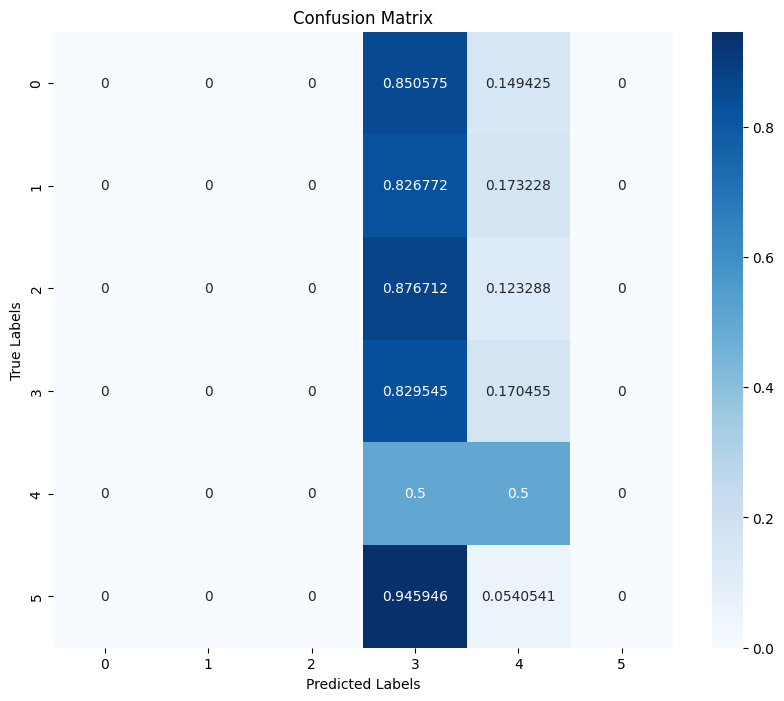

Epoch 15, Validation Loss: 1.7482, Accuracy: 0.2565, F1 Score: 0.1340
Val F1 Score Per Class  [0.         0.         0.         0.43843844 0.04395604 0.        ]


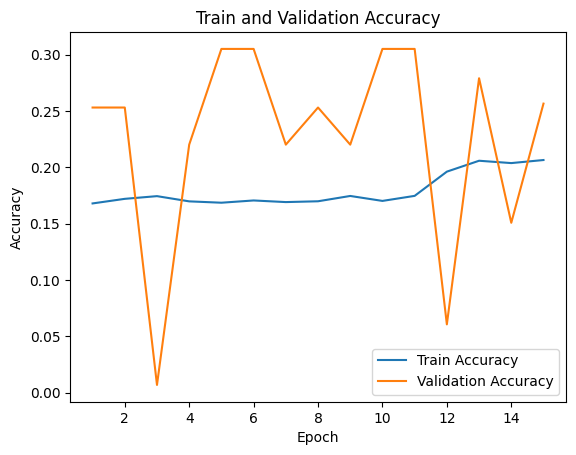

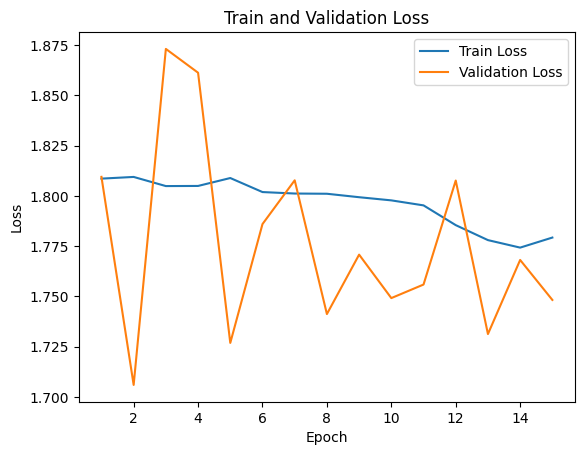

Epoch 16, Train Loss: 1.7795, Accuracy: 0.2009, F1 Score: 0.1306
Train F1 Score Per Class  [0.08597285 0.03303685 0.05246166 0.29248933 0.30220085 0.00583942]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.40it/s, loss=1.78]

[tensor([-0.0090,  0.0277, -0.0468,  0.0967, -0.1026, -0.0326], device='cuda:0'), tensor([-0.1543, -0.0218, -0.1202, -0.0050,  0.1723, -0.0957], device='cuda:0'), tensor([-0.2024, -0.0388, -0.1452, -0.0413,  0.4069, -0.1145], device='cuda:0'), tensor([-0.1230, -0.0093, -0.1016,  0.0219, -0.0130, -0.0849], device='cuda:0'), tensor([-0.0381,  0.0175, -0.0633,  0.0764, -0.1877, -0.0448], device='cuda:0'), tensor([-0.1601, -0.0235, -0.1235, -0.0111,  0.0706, -0.0951], device='cuda:0'), tensor([ 0.0875,  0.0588,  0.0005,  0.1640, -0.4203,  0.0071], device='cuda:0'), tensor([-0.1263, -0.0097, -0.1042,  0.0162,  0.1429, -0.0837], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.41it/s, loss=1.8]

[tensor([ 0.0029,  0.0320, -0.0408,  0.1054, -0.2656, -0.0271], device='cuda:0'), tensor([-0.0800,  0.0047, -0.0798,  0.0509, -0.0570, -0.0659], device='cuda:0'), tensor([-0.1823, -0.0302, -0.1353, -0.0254,  0.2013, -0.1065], device='cuda:0'), tensor([-0.0354,  0.0187, -0.0573,  0.0801, -0.1061, -0.0441], device='cuda:0'), tensor([-0.0577,  0.0115, -0.0724,  0.0638,  0.0260, -0.0546], device='cuda:0'), tensor([-0.0721,  0.0057, -0.0769,  0.0544, -0.1026, -0.0605], device='cuda:0'), tensor([ 0.0410,  0.0445, -0.0209,  0.1325, -0.3498, -0.0119], device='cuda:0'), tensor([-0.0143,  0.0255, -0.0497,  0.0932, -0.1449, -0.0345], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.36it/s, loss=1.8]

[tensor([ 0.0584,  0.0498, -0.0142,  0.1432, -0.3498, -0.0043], device='cuda:0'), tensor([-0.0976, -0.0011, -0.0905,  0.0362,  0.0372, -0.0711], device='cuda:0'), tensor([-0.0442,  0.0171, -0.0646,  0.0740, -0.3186, -0.0495], device='cuda:0'), tensor([-0.1379, -0.0166, -0.1096,  0.0078, -0.1354, -0.0877], device='cuda:0'), tensor([-0.0844,  0.0017, -0.0835,  0.0434, -0.1050, -0.0636], device='cuda:0'), tensor([-0.0792,  0.0044, -0.0818,  0.0465, -0.0379, -0.0605], device='cuda:0'), tensor([ 0.0147,  0.0362, -0.0350,  0.1155, -0.2126, -0.0252], device='cuda:0'), tensor([-0.0993, -0.0013, -0.0904,  0.0375, -0.0198, -0.0738], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.37it/s, loss=1.73]

[tensor([-0.0386,  0.0175, -0.0628,  0.0748, -0.2633, -0.0438], device='cuda:0'), tensor([-0.1235, -0.0108, -0.1025,  0.0199, -0.0691, -0.0826], device='cuda:0'), tensor([ 0.0450,  0.0443, -0.0213,  0.1347, -0.3282, -0.0105], device='cuda:0'), tensor([-0.0291,  0.0207, -0.0572,  0.0840, -0.2784, -0.0422], device='cuda:0'), tensor([-0.2206, -0.0426, -0.1523, -0.0519,  0.3992, -0.1220], device='cuda:0'), tensor([ 0.0463,  0.0455, -0.0201,  0.1349, -0.3619, -0.0088], device='cuda:0'), tensor([ 0.0578,  0.0490, -0.0143,  0.1419, -0.3419, -0.0032], device='cuda:0'), tensor([-0.0200,  0.0244, -0.0519,  0.0877, -0.3009, -0.0354], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=1.79]

[tensor([-0.0718,  0.0063, -0.0774,  0.0548,  0.0080, -0.0608], device='cuda:0'), tensor([ 0.0693,  0.0516, -0.0114,  0.1520, -0.4439, -0.0020], device='cuda:0'), tensor([-0.2303, -0.0490, -0.1579, -0.0602,  0.4546, -0.1271], device='cuda:0'), tensor([-0.1420, -0.0161, -0.1128,  0.0058,  0.0077, -0.0902], device='cuda:0'), tensor([-0.0753,  0.0036, -0.0808,  0.0491, -0.1638, -0.0601], device='cuda:0'), tensor([-0.1327, -0.0154, -0.1080,  0.0095,  0.1257, -0.0838], device='cuda:0'), tensor([-0.1250, -0.0099, -0.1029,  0.0170,  0.0113, -0.0825], device='cuda:0'), tensor([-0.8341, -0.2556, -0.4932, -0.5289,  0.7501, -0.4015], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.36it/s, loss=1.74]

[tensor([-0.0837,  0.0035, -0.0817,  0.0494, -0.1825, -0.0686], device='cuda:0'), tensor([ 0.0658,  0.0522, -0.0128,  0.1481, -0.3301, -0.0012], device='cuda:0'), tensor([-0.1342, -0.0149, -0.1094,  0.0092,  0.0691, -0.0860], device='cuda:0'), tensor([ 7.0073e-02,  5.3487e-02, -8.5533e-03,  1.5130e-01, -3.6916e-01,
        -2.8275e-04], device='cuda:0'), tensor([-0.0572,  0.0126, -0.0704,  0.0658, -0.1435, -0.0552], device='cuda:0'), tensor([-0.1289, -0.0128, -0.1055,  0.0154,  0.1076, -0.0859], device='cuda:0'), tensor([-0.0896,  0.0018, -0.0865,  0.0440, -0.1606, -0.0703], device='cuda:0'), tensor([ 0.0155,  0.0352, -0.0339,  0.1152, -0.3904, -0.0228], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.37it/s, loss=1.79]

[tensor([-0.0300,  0.0206, -0.0583,  0.0813, -0.1391, -0.0412], device='cuda:0'), tensor([-0.0465,  0.0157, -0.0637,  0.0733, -0.1745, -0.0504], device='cuda:0'), tensor([-0.1881, -0.0326, -0.1376, -0.0287,  0.1334, -0.1098], device='cuda:0'), tensor([-0.3006, -0.0715, -0.1954, -0.1118,  0.4509, -0.1574], device='cuda:0'), tensor([-0.0716,  0.0075, -0.0763,  0.0560,  0.0390, -0.0614], device='cuda:0'), tensor([-0.1596, -0.0213, -0.1211, -0.0070, -0.0730, -0.0972], device='cuda:0'), tensor([ 0.0499,  0.0477, -0.0188,  0.1378, -0.3854, -0.0084], device='cuda:0'), tensor([-0.1261, -0.0116, -0.1067,  0.0143,  0.1317, -0.0834], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.37it/s, loss=1.74]

[tensor([-0.0427,  0.0168, -0.0631,  0.0751, -0.0301, -0.0490], device='cuda:0'), tensor([-0.2561, -0.0542, -0.1725, -0.0770,  0.3875, -0.1394], device='cuda:0'), tensor([-0.0406,  0.0167, -0.0642,  0.0717, -0.0901, -0.0426], device='cuda:0'), tensor([ 0.0219,  0.0384, -0.0314,  0.1200, -0.2161, -0.0209], device='cuda:0'), tensor([-0.0128,  0.0264, -0.0497,  0.0944, -0.3175, -0.0347], device='cuda:0'), tensor([ 0.0006,  0.0316, -0.0417,  0.1041, -0.2452, -0.0289], device='cuda:0'), tensor([-0.0009,  0.0307, -0.0418,  0.1060, -0.2563, -0.0341], device='cuda:0'), tensor([-0.0514,  0.0140, -0.0675,  0.0679, -0.2920, -0.0514], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=1.79]

[tensor([-0.0808,  0.0042, -0.0830,  0.0462,  0.0033, -0.0628], device='cuda:0'), tensor([-0.0917, -0.0010, -0.0889,  0.0376,  0.1004, -0.0657], device='cuda:0'), tensor([-0.1608, -0.0242, -0.1252, -0.0101,  0.1554, -0.0989], device='cuda:0'), tensor([-0.1220, -0.0105, -0.1006,  0.0219,  0.0427, -0.0834], device='cuda:0'), tensor([ 0.0137,  0.0317, -0.0400,  0.1141, -0.2007, -0.0286], device='cuda:0'), tensor([-0.0369,  0.0187, -0.0628,  0.0768, -0.1892, -0.0446], device='cuda:0'), tensor([-0.0876, -0.0009, -0.0904,  0.0383,  0.0967, -0.0656], device='cuda:0'), tensor([-0.1652, -0.0255, -0.1254, -0.0138,  0.0684, -0.0980], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=1.78]

[tensor([-0.0656,  0.0086, -0.0751,  0.0579,  0.0113, -0.0564], device='cuda:0'), tensor([-0.0661,  0.0086, -0.0768,  0.0577, -0.1544, -0.0581], device='cuda:0'), tensor([-0.0106,  0.0277, -0.0474,  0.0975, -0.4066, -0.0342], device='cuda:0'), tensor([-0.0872,  0.0016, -0.0857,  0.0419,  0.0632, -0.0648], device='cuda:0'), tensor([-0.1910, -0.0323, -0.1375, -0.0298,  0.4261, -0.1106], device='cuda:0'), tensor([ 0.0045,  0.0318, -0.0400,  0.1069, -0.2026, -0.0277], device='cuda:0'), tensor([-0.2833, -0.0608, -0.1880, -0.1025,  0.1058, -0.1466], device='cuda:0'), tensor([-0.0435,  0.0176, -0.0653,  0.0752, -0.0744, -0.0511], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=1.83]

[tensor([-0.0467,  0.0130, -0.0650,  0.0711, -0.2600, -0.0487], device='cuda:0'), tensor([-0.0595,  0.0106, -0.0724,  0.0630, -0.1856, -0.0559], device='cuda:0'), tensor([-0.0923, -0.0002, -0.0885,  0.0404, -0.1421, -0.0697], device='cuda:0'), tensor([-0.0900, -0.0019, -0.0874,  0.0385, -0.1949, -0.0645], device='cuda:0'), tensor([-0.0820,  0.0044, -0.0825,  0.0468,  0.0624, -0.0637], device='cuda:0'), tensor([-0.1653, -0.0271, -0.1259, -0.0170,  0.0464, -0.0959], device='cuda:0'), tensor([-0.0946, -0.0013, -0.0911,  0.0356,  0.0361, -0.0673], device='cuda:0'), tensor([-0.1156, -0.0092, -0.1006,  0.0234, -0.1343, -0.0798], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=1.75]

[tensor([-0.1697, -0.0263, -0.1271, -0.0153,  0.1568, -0.1006], device='cuda:0'), tensor([ 0.0006,  0.0268, -0.0395,  0.1034, -0.1762, -0.0273], device='cuda:0'), tensor([ 0.0120,  0.0353, -0.0364,  0.1135, -0.3203, -0.0260], device='cuda:0'), tensor([-0.1362, -0.0183, -0.1126,  0.0060,  0.2077, -0.0880], device='cuda:0'), tensor([-0.0796,  0.0017, -0.0840,  0.0452, -0.2245, -0.0609], device='cuda:0'), tensor([ 0.0035,  0.0322, -0.0402,  0.1074, -0.1713, -0.0295], device='cuda:0'), tensor([ 0.0264,  0.0399, -0.0293,  0.1221, -0.4380, -0.0179], device='cuda:0'), tensor([-0.1035, -0.0035, -0.0938,  0.0320, -0.1811, -0.0735], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=1.77]

[tensor([-0.0443,  0.0158, -0.0641,  0.0733, -0.2119, -0.0473], device='cuda:0'), tensor([-0.0495,  0.0154, -0.0667,  0.0704, -0.2411, -0.0512], device='cuda:0'), tensor([-0.0662,  0.0069, -0.0791,  0.0522,  0.0057, -0.0551], device='cuda:0'), tensor([-0.3275, -0.0832, -0.2174, -0.1396,  0.4903, -0.1726], device='cuda:0'), tensor([-0.0765,  0.0056, -0.0805,  0.0509, -0.0910, -0.0615], device='cuda:0'), tensor([-0.0226,  0.0228, -0.0544,  0.0884, -0.2926, -0.0403], device='cuda:0'), tensor([-0.1921, -0.0406, -0.1481, -0.0434,  0.1449, -0.1147], device='cuda:0'), tensor([-0.1158, -0.0074, -0.0994,  0.0236, -0.0310, -0.0792], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.38it/s, loss=1.76]

[tensor([-0.1522, -0.0222, -0.1184, -0.0053,  0.1029, -0.0916], device='cuda:0'), tensor([-0.0626,  0.0113, -0.0728,  0.0613, -0.1965, -0.0569], device='cuda:0'), tensor([-9.2370e-02, -7.8345e-05, -8.7080e-02,  4.0069e-02,  5.1682e-02,
        -6.8711e-02], device='cuda:0'), tensor([-0.0266,  0.0228, -0.0575,  0.0847, -0.1802, -0.0410], device='cuda:0'), tensor([-0.0940,  0.0012, -0.0901,  0.0377,  0.0323, -0.0692], device='cuda:0'), tensor([-0.0978, -0.0006, -0.0892,  0.0374,  0.1323, -0.0716], device='cuda:0'), tensor([-0.1303, -0.0152, -0.1088,  0.0112,  0.0863, -0.0848], device='cuda:0'), tensor([-0.0546,  0.0118, -0.0686,  0.0666, -0.2371, -0.0538], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=1.8]

[tensor([-0.0469,  0.0151, -0.0644,  0.0740, -0.1559, -0.0516], device='cuda:0'), tensor([-0.0600,  0.0104, -0.0724,  0.0622, -0.0113, -0.0549], device='cuda:0'), tensor([-0.0583,  0.0110, -0.0700,  0.0637, -0.0733, -0.0536], device='cuda:0'), tensor([-0.0753,  0.0062, -0.0782,  0.0519, -0.0890, -0.0607], device='cuda:0'), tensor([-0.0132,  0.0249, -0.0492,  0.0930, -0.2067, -0.0331], device='cuda:0'), tensor([-0.0726,  0.0083, -0.0807,  0.0503,  0.0511, -0.0579], device='cuda:0'), tensor([-0.0577,  0.0117, -0.0697,  0.0649, -0.0511, -0.0547], device='cuda:0'), tensor([-0.1253, -0.0112, -0.1061,  0.0150,  0.1890, -0.0813], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=1.8]

[tensor([-0.1264, -0.0102, -0.1053,  0.0139, -0.2105, -0.0796], device='cuda:0'), tensor([-0.0872,  0.0024, -0.0845,  0.0444,  0.0769, -0.0673], device='cuda:0'), tensor([-0.1139, -0.0098, -0.1020,  0.0207, -0.1612, -0.0773], device='cuda:0'), tensor([-0.2443, -0.0667, -0.1781, -0.0834,  0.4351, -0.1400], device='cuda:0'), tensor([-0.1114, -0.0075, -0.0977,  0.0274, -0.0331, -0.0784], device='cuda:0'), tensor([-0.0874,  0.0004, -0.0883,  0.0401, -0.1470, -0.0652], device='cuda:0'), tensor([-0.0511,  0.0143, -0.0674,  0.0697, -0.0660, -0.0528], device='cuda:0'), tensor([-0.1230, -0.0107, -0.1018,  0.0189, -0.1916, -0.0813], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=1.84]

[tensor([-0.2245, -0.0446, -0.1550, -0.0538,  0.4082, -0.1251], device='cuda:0'), tensor([-0.0763,  0.0051, -0.0789,  0.0519, -0.2088, -0.0620], device='cuda:0'), tensor([-0.0286,  0.0204, -0.0559,  0.0845, -0.2974, -0.0414], device='cuda:0'), tensor([-0.1607, -0.0251, -0.1240, -0.0130,  0.2467, -0.0963], device='cuda:0'), tensor([-0.0363,  0.0204, -0.0591,  0.0777, -0.0839, -0.0432], device='cuda:0'), tensor([-0.0767,  0.0056, -0.0809,  0.0517,  0.0325, -0.0641], device='cuda:0'), tensor([-0.3711, -0.0922, -0.2416, -0.1815,  0.4113, -0.1815], device='cuda:0'), tensor([-0.0829,  0.0011, -0.0851,  0.0424, -0.1709, -0.0613], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=1.8]

[tensor([-0.2218, -0.0441, -0.1557, -0.0532,  0.3356, -0.1241], device='cuda:0'), tensor([ 0.0418,  0.0447, -0.0211,  0.1318, -0.3205, -0.0126], device='cuda:0'), tensor([-0.2580, -0.0549, -0.1720, -0.0787,  0.4220, -0.1389], device='cuda:0'), tensor([-0.0603,  0.0114, -0.0724,  0.0613, -0.0510, -0.0539], device='cuda:0'), tensor([-0.1049, -0.0053, -0.0929,  0.0315, -0.1151, -0.0734], device='cuda:0'), tensor([-0.0366,  0.0182, -0.0596,  0.0799, -0.1651, -0.0471], device='cuda:0'), tensor([-0.0819,  0.0035, -0.0829,  0.0461, -0.0115, -0.0636], device='cuda:0'), tensor([-0.2222, -0.0441, -0.1560, -0.0539,  0.2998, -0.1244], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.37it/s, loss=1.79]

[tensor([-0.0747,  0.0047, -0.0805,  0.0496, -0.1213, -0.0594], device='cuda:0'), tensor([-0.1670, -0.0261, -0.1266, -0.0136,  0.3607, -0.1002], device='cuda:0'), tensor([-0.1261, -0.0116, -0.1053,  0.0143,  0.0054, -0.0815], device='cuda:0'), tensor([-0.0312,  0.0215, -0.0580,  0.0838, -0.1091, -0.0445], device='cuda:0'), tensor([-0.1782, -0.0300, -0.1338, -0.0233,  0.0188, -0.1052], device='cuda:0'), tensor([-0.1220, -0.0114, -0.1023,  0.0185,  0.0467, -0.0811], device='cuda:0'), tensor([-0.2691, -0.0617, -0.1805, -0.0896,  0.5383, -0.1454], device='cuda:0'), tensor([-0.1295, -0.0232, -0.1189,  0.0011,  0.0348, -0.0923], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=1.77]

[tensor([-0.1631, -0.0299, -0.1265, -0.0157,  0.0034, -0.1009], device='cuda:0'), tensor([-0.1209, -0.0110, -0.1038,  0.0167,  0.1061, -0.0784], device='cuda:0'), tensor([-0.0820,  0.0032, -0.0839,  0.0469, -0.0684, -0.0644], device='cuda:0'), tensor([-0.1316, -0.0169, -0.1113,  0.0077, -0.2326, -0.0851], device='cuda:0'), tensor([ 0.0349,  0.0430, -0.0261,  0.1287, -0.2765, -0.0167], device='cuda:0'), tensor([-0.0426,  0.0161, -0.0631,  0.0746, -0.2659, -0.0483], device='cuda:0'), tensor([ 0.0175,  0.0364, -0.0325,  0.1159, -0.2077, -0.0223], device='cuda:0'), tensor([-0.0661,  0.0096, -0.0741,  0.0603, -0.2046, -0.0589], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=1.84]

[tensor([-0.1589, -0.0256, -0.1246, -0.0117,  0.0066, -0.0963], device='cuda:0'), tensor([-0.2695, -0.0588, -0.1823, -0.0909,  0.6370, -0.1447], device='cuda:0'), tensor([-0.0134,  0.0272, -0.0490,  0.0947, -0.1974, -0.0348], device='cuda:0'), tensor([-0.2132, -0.0421, -0.1511, -0.0482,  0.3499, -0.1210], device='cuda:0'), tensor([ 0.0126,  0.0343, -0.0367,  0.1113, -0.3212, -0.0239], device='cuda:0'), tensor([-0.2083, -0.0410, -0.1464, -0.0439,  0.4059, -0.1173], device='cuda:0'), tensor([-0.2548, -0.0612, -0.1800, -0.0855,  0.4676, -0.1437], device='cuda:0'), tensor([-0.0701,  0.0039, -0.0803,  0.0511, -0.0776, -0.0588], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=1.84]

[tensor([-0.1211, -0.0089, -0.1030,  0.0199,  0.1429, -0.0823], device='cuda:0'), tensor([-0.0970, -0.0027, -0.0903,  0.0366,  0.0911, -0.0701], device='cuda:0'), tensor([-0.0975, -0.0007, -0.0912,  0.0359,  0.0699, -0.0713], device='cuda:0'), tensor([ 0.0591,  0.0504, -0.0126,  0.1457, -0.4217, -0.0063], device='cuda:0'), tensor([-0.2629, -0.0707, -0.1881, -0.0961,  0.4977, -0.1506], device='cuda:0'), tensor([-0.1669, -0.0259, -0.1257, -0.0131, -0.0189, -0.1011], device='cuda:0'), tensor([-0.1908, -0.0331, -0.1384, -0.0299,  0.3147, -0.1110], device='cuda:0'), tensor([-0.1959, -0.0348, -0.1402, -0.0359,  0.3033, -0.1109], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.37it/s, loss=1.75]

[tensor([ 0.0464,  0.0475, -0.0203,  0.1370, -0.3042, -0.0120], device='cuda:0'), tensor([-0.0820,  0.0038, -0.0820,  0.0481, -0.1000, -0.0650], device='cuda:0'), tensor([ 0.0405,  0.0439, -0.0239,  0.1318, -0.3287, -0.0136], device='cuda:0'), tensor([ 0.0005,  0.0327, -0.0392,  0.1065, -0.2294, -0.0303], device='cuda:0'), tensor([-0.0446,  0.0157, -0.0641,  0.0729, -0.0719, -0.0482], device='cuda:0'), tensor([ 0.0037,  0.0312, -0.0387,  0.1066, -0.2250, -0.0278], device='cuda:0'), tensor([-0.0156,  0.0249, -0.0496,  0.0927, -0.2342, -0.0361], device='cuda:0'), tensor([-0.1691, -0.0271, -0.1255, -0.0144,  0.1936, -0.1012], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=1.8]

[tensor([-0.1564, -0.0214, -0.1198, -0.0059,  0.1906, -0.0958], device='cuda:0'), tensor([ 0.0057,  0.0324, -0.0397,  0.1084, -0.2474, -0.0281], device='cuda:0'), tensor([ 0.1002,  0.0624,  0.0053,  0.1697, -0.4362,  0.0155], device='cuda:0'), tensor([-0.0971, -0.0010, -0.0894,  0.0366, -0.1626, -0.0697], device='cuda:0'), tensor([-0.0812,  0.0045, -0.0833,  0.0488,  0.0160, -0.0650], device='cuda:0'), tensor([-0.0739,  0.0064, -0.0779,  0.0532, -0.1391, -0.0601], device='cuda:0'), tensor([-0.2114, -0.0420, -0.1514, -0.0478,  0.1596, -0.1197], device='cuda:0'), tensor([-0.2524, -0.0564, -0.1705, -0.0742,  0.4968, -0.1398], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=1.63]

[tensor([-0.8417, -0.2673, -0.5064, -0.5437,  1.5466, -0.4054], device='cuda:0'), tensor([-0.1311, -0.0117, -0.1068,  0.0143,  0.1802, -0.0860], device='cuda:0'), tensor([ 0.0132,  0.0366, -0.0390,  0.1080, -0.3982, -0.0196], device='cuda:0'), tensor([-0.1071, -0.0038, -0.0953,  0.0294, -0.0670, -0.0743], device='cuda:0'), tensor([-0.0280,  0.0206, -0.0572,  0.0824, -0.2617, -0.0393], device='cuda:0'), tensor([ 0.0074,  0.0335, -0.0394,  0.1085, -0.2758, -0.0258], device='cuda:0'), tensor([-0.1482, -0.0207, -0.1178, -0.0032,  0.0905, -0.0907], device='cuda:0'), tensor([-0.1830, -0.0333, -0.1361, -0.0296,  0.4033, -0.1058], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.75]

[tensor([-0.0540,  0.0115, -0.0694,  0.0654, -0.0790, -0.0514], device='cuda:0'), tensor([-0.0280,  0.0214, -0.0573,  0.0842, -0.0782, -0.0415], device='cuda:0'), tensor([ 0.0203,  0.0366, -0.0339,  0.1184, -0.3669, -0.0227], device='cuda:0'), tensor([-0.1227, -0.0125, -0.1047,  0.0159,  0.0425, -0.0797], device='cuda:0'), tensor([-0.0345,  0.0192, -0.0617,  0.0789, -0.0598, -0.0453], device='cuda:0'), tensor([-0.0253,  0.0232, -0.0537,  0.0875, -0.3935, -0.0403], device='cuda:0'), tensor([-0.0419,  0.0179, -0.0635,  0.0738, -0.0347, -0.0476], device='cuda:0'), tensor([-0.2237, -0.0432, -0.1508, -0.0505,  0.1097, -0.1258], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=1.79]

[tensor([ 0.0050,  0.0327, -0.0412,  0.1073, -0.3419, -0.0272], device='cuda:0'), tensor([-0.0833,  0.0007, -0.0824,  0.0439,  0.0478, -0.0618], device='cuda:0'), tensor([-0.0554,  0.0125, -0.0696,  0.0639, -0.0797, -0.0532], device='cuda:0'), tensor([ 0.0411,  0.0419, -0.0274,  0.1341, -0.2222, -0.0200], device='cuda:0'), tensor([-0.0455,  0.0150, -0.0667,  0.0715, -0.1571, -0.0500], device='cuda:0'), tensor([-0.1450, -0.0169, -0.1134,  0.0034,  0.1143, -0.0910], device='cuda:0'), tensor([-0.0871,  0.0018, -0.0856,  0.0434,  0.0261, -0.0665], device='cuda:0'), tensor([-0.1259, -0.0097, -0.1047,  0.0174,  0.1024, -0.0838], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.38it/s, loss=1.76]

[tensor([-0.1030, -0.0027, -0.0920,  0.0327,  0.0165, -0.0732], device='cuda:0'), tensor([ 0.0754,  0.0537, -0.0053,  0.1550, -0.5573,  0.0036], device='cuda:0'), tensor([-0.1095, -0.0040, -0.0973,  0.0287,  0.0853, -0.0766], device='cuda:0'), tensor([-0.0804,  0.0036, -0.0826,  0.0457, -0.0673, -0.0603], device='cuda:0'), tensor([-0.0815,  0.0040, -0.0830,  0.0468, -0.0251, -0.0645], device='cuda:0'), tensor([-0.1372, -0.0166, -0.1084,  0.0098,  0.1199, -0.0876], device='cuda:0'), tensor([-0.1353, -0.0160, -0.1116,  0.0059,  0.0246, -0.0850], device='cuda:0'), tensor([-0.0548,  0.0132, -0.0685,  0.0656, -0.0974, -0.0525], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=1.8]

[tensor([-0.0902,  0.0015, -0.0864,  0.0428, -0.0004, -0.0693], device='cuda:0'), tensor([ 0.0157,  0.0369, -0.0341,  0.1147, -0.3089, -0.0225], device='cuda:0'), tensor([-0.1986, -0.0346, -0.1436, -0.0360,  0.3864, -0.1147], device='cuda:0'), tensor([ 0.0357,  0.0409, -0.0269,  0.1272, -0.3558, -0.0137], device='cuda:0'), tensor([-0.1483, -0.0191, -0.1175, -0.0021,  0.1148, -0.0907], device='cuda:0'), tensor([-0.0186,  0.0242, -0.0525,  0.0897, -0.1154, -0.0363], device='cuda:0'), tensor([-0.1730, -0.0250, -0.1271, -0.0156,  0.2509, -0.1032], device='cuda:0'), tensor([-0.0430,  0.0171, -0.0633,  0.0738, -0.1846, -0.0465], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.37it/s, loss=1.83]

[tensor([-0.0362,  0.0184, -0.0609,  0.0776, -0.2075, -0.0438], device='cuda:0'), tensor([-0.1358, -0.0164, -0.1131,  0.0038,  0.2837, -0.0853], device='cuda:0'), tensor([ 0.0331,  0.0417, -0.0268,  0.1274, -0.2737, -0.0177], device='cuda:0'), tensor([-0.1883, -0.0321, -0.1371, -0.0295,  0.3824, -0.1087], device='cuda:0'), tensor([ 0.0081,  0.0321, -0.0409,  0.1084, -0.3710, -0.0270], device='cuda:0'), tensor([-0.0391,  0.0158, -0.0651,  0.0730, -0.1695, -0.0444], device='cuda:0'), tensor([-0.1659, -0.0307, -0.1302, -0.0194,  0.1038, -0.1016], device='cuda:0'), tensor([-0.1901, -0.0372, -0.1414, -0.0358,  0.2680, -0.1112], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=1.78]

[tensor([ 0.0226,  0.0393, -0.0307,  0.1203, -0.2440, -0.0208], device='cuda:0'), tensor([ 0.0538,  0.0490, -0.0166,  0.1414, -0.4097, -0.0080], device='cuda:0'), tensor([-0.0545,  0.0129, -0.0673,  0.0672, -0.1334, -0.0530], device='cuda:0'), tensor([-0.0791,  0.0052, -0.0808,  0.0492,  0.0676, -0.0625], device='cuda:0'), tensor([-0.0327,  0.0210, -0.0582,  0.0828, -0.1146, -0.0455], device='cuda:0'), tensor([-0.1396, -0.0159, -0.1099,  0.0068,  0.0528, -0.0881], device='cuda:0'), tensor([-0.0206,  0.0226, -0.0534,  0.0885, -0.1924, -0.0375], device='cuda:0'), tensor([-0.0487,  0.0151, -0.0661,  0.0716, -0.3398, -0.0524], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=1.77]

[tensor([-0.0298,  0.0208, -0.0563,  0.0840, -0.1741, -0.0423], device='cuda:0'), tensor([-0.0529,  0.0124, -0.0679,  0.0662, -0.2062, -0.0499], device='cuda:0'), tensor([-0.0504,  0.0138, -0.0662,  0.0694, -0.1486, -0.0512], device='cuda:0'), tensor([-0.1300, -0.0111, -0.1053,  0.0158,  0.1628, -0.0857], device='cuda:0'), tensor([-0.0529,  0.0135, -0.0686,  0.0663, -0.1001, -0.0512], device='cuda:0'), tensor([ 7.1628e-02,  5.2695e-02, -9.6712e-03,  1.5353e-01, -6.1185e-01,
        -5.5629e-04], device='cuda:0'), tensor([-0.0982, -0.0019, -0.0896,  0.0373,  0.0840, -0.0724], device='cuda:0'), tensor([ 0.0486,  0.0476, -0.0190,  0.1381, -0.3407, -0.0101], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=1.77]

[tensor([-0.1089, -0.0060, -0.0974,  0.0282,  0.0700, -0.0770], device='cuda:0'), tensor([ 0.0385,  0.0435, -0.0248,  0.1301, -0.2942, -0.0137], device='cuda:0'), tensor([ 6.8883e-02,  5.2556e-02, -8.0641e-03,  1.5044e-01, -4.1347e-01,
         2.6746e-04], device='cuda:0'), tensor([ 0.0363,  0.0421, -0.0248,  0.1281, -0.3314, -0.0135], device='cuda:0'), tensor([-0.1853, -0.0326, -0.1374, -0.0293,  0.2677, -0.1076], device='cuda:0'), tensor([ 0.0027,  0.0305, -0.0392,  0.1052, -0.3176, -0.0269], device='cuda:0'), tensor([-0.0834,  0.0033, -0.0837,  0.0449, -0.1853, -0.0635], device='cuda:0'), tensor([-0.0764,  0.0053, -0.0794,  0.0505,  0.0602, -0.0612], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.36it/s, loss=1.74]

[tensor([ 0.0070,  0.0333, -0.0391,  0.1091, -0.2825, -0.0279], device='cuda:0'), tensor([ 0.0524,  0.0477, -0.0177,  0.1382, -0.3338, -0.0056], device='cuda:0'), tensor([-0.0022,  0.0305, -0.0444,  0.1020, -0.1953, -0.0306], device='cuda:0'), tensor([-0.0901,  0.0012, -0.0864,  0.0429, -0.0992, -0.0689], device='cuda:0'), tensor([-0.1869, -0.0327, -0.1337, -0.0264, -0.1565, -0.1093], device='cuda:0'), tensor([-0.0636,  0.0106, -0.0740,  0.0612, -0.2388, -0.0583], device='cuda:0'), tensor([-0.1210, -0.0122, -0.1064,  0.0141,  0.1179, -0.0795], device='cuda:0'), tensor([-0.0217,  0.0227, -0.0528,  0.0871, -0.3505, -0.0379], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.37it/s, loss=1.76]

[tensor([-0.2389, -0.0810, -0.1493, -0.0555, -0.0097, -0.1566], device='cuda:0'), tensor([ 0.0786,  0.0566, -0.0044,  0.1554, -0.4122,  0.0068], device='cuda:0'), tensor([-0.0096,  0.0270, -0.0475,  0.0967, -0.1546, -0.0333], device='cuda:0'), tensor([ 0.0549,  0.0485, -0.0143,  0.1422, -0.4448, -0.0071], device='cuda:0'), tensor([-0.1954, -0.0382, -0.1485, -0.0444,  0.3504, -0.1131], device='cuda:0'), tensor([ 0.0155,  0.0350, -0.0359,  0.1138, -0.3432, -0.0236], device='cuda:0'), tensor([-0.0346,  0.0192, -0.0599,  0.0809, -0.1669, -0.0464], device='cuda:0'), tensor([ 0.0618,  0.0506, -0.0120,  0.1474, -0.3006, -0.0049], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.38it/s, loss=1.73]

[tensor([-0.0450,  0.0160, -0.0645,  0.0729, -0.0347, -0.0494], device='cuda:0'), tensor([-0.0735,  0.0039, -0.0802,  0.0506, -0.3642, -0.0594], device='cuda:0'), tensor([-0.1204, -0.0087, -0.1019,  0.0199,  0.0477, -0.0798], device='cuda:0'), tensor([-0.0405,  0.0181, -0.0616,  0.0771, -0.2347, -0.0471], device='cuda:0'), tensor([-0.0936, -0.0007, -0.0879,  0.0400, -0.0447, -0.0701], device='cuda:0'), tensor([-0.1885, -0.0303, -0.1350, -0.0263,  0.0755, -0.1092], device='cuda:0'), tensor([-0.0176,  0.0247, -0.0506,  0.0906, -0.2140, -0.0355], device='cuda:0'), tensor([-0.0828,  0.0026, -0.0841,  0.0486, -0.3147, -0.0677], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=1.78]

[tensor([-0.0663,  0.0081, -0.0758,  0.0572, -0.1387, -0.0570], device='cuda:0'), tensor([-0.0719,  0.0052, -0.0795,  0.0510, -0.1180, -0.0579], device='cuda:0'), tensor([ 0.0664,  0.0533, -0.0101,  0.1496, -0.4115, -0.0021], device='cuda:0'), tensor([-0.1431, -0.0164, -0.1139,  0.0053,  0.1600, -0.0916], device='cuda:0'), tensor([-0.0478,  0.0149, -0.0674,  0.0708, -0.0281, -0.0511], device='cuda:0'), tensor([-0.0739,  0.0062, -0.0779,  0.0536, -0.0084, -0.0619], device='cuda:0'), tensor([-0.1818, -0.0307, -0.1348, -0.0241,  0.3460, -0.1074], device='cuda:0'), tensor([-0.1545, -0.0217, -0.1230, -0.0075,  0.1264, -0.0954], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.82]

[tensor([-0.1866, -0.0311, -0.1336, -0.0249,  0.2934, -0.1105], device='cuda:0'), tensor([-0.0721,  0.0063, -0.0765,  0.0526, -0.0168, -0.0582], device='cuda:0'), tensor([ 0.0131,  0.0353, -0.0345,  0.1127, -0.2373, -0.0231], device='cuda:0'), tensor([-0.1348, -0.0158, -0.1102,  0.0086,  0.0174, -0.0868], device='cuda:0'), tensor([-0.0562,  0.0126, -0.0700,  0.0651, -0.2714, -0.0535], device='cuda:0'), tensor([-0.0251,  0.0232, -0.0542,  0.0866, -0.0789, -0.0396], device='cuda:0'), tensor([-0.0867,  0.0030, -0.0867,  0.0460, -0.1378, -0.0708], device='cuda:0'), tensor([-0.7819, -0.2507, -0.4810, -0.5068,  0.8301, -0.3768], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=1.75]

[tensor([-0.0130,  0.0255, -0.0487,  0.0943, -0.3555, -0.0338], device='cuda:0'), tensor([-0.0561,  0.0117, -0.0689,  0.0650,  0.0200, -0.0520], device='cuda:0'), tensor([-0.1541, -0.0201, -0.1208, -0.0079,  0.1552, -0.0944], device='cuda:0'), tensor([-0.0436,  0.0165, -0.0636,  0.0728, -0.1857, -0.0462], device='cuda:0'), tensor([-0.0993, -0.0021, -0.0926,  0.0320, -0.0478, -0.0691], device='cuda:0'), tensor([ 0.0553,  0.0447, -0.0182,  0.1376, -0.3174, -0.0030], device='cuda:0'), tensor([ 0.0481,  0.0464, -0.0209,  0.1354, -0.3125, -0.0107], device='cuda:0'), tensor([ 0.0421,  0.0450, -0.0216,  0.1330, -0.3027, -0.0119], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.37it/s, loss=1.84]

[tensor([-0.0982, -0.0031, -0.0918,  0.0331,  0.0687, -0.0694], device='cuda:0'), tensor([ 0.0269,  0.0399, -0.0287,  0.1231, -0.3200, -0.0195], device='cuda:0'), tensor([-0.1578, -0.0222, -0.1217, -0.0065,  0.2207, -0.0976], device='cuda:0'), tensor([ 0.0757,  0.0545, -0.0058,  0.1546, -0.3916,  0.0031], device='cuda:0'), tensor([-0.0739,  0.0048, -0.0802,  0.0504,  0.0906, -0.0585], device='cuda:0'), tensor([-0.2272, -0.0487, -0.1616, -0.0625,  0.5142, -0.1294], device='cuda:0'), tensor([-0.1513, -0.0214, -0.1210, -0.0054,  0.1600, -0.0937], device='cuda:0'), tensor([-0.0727,  0.0068, -0.0791,  0.0521, -0.0597, -0.0590], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=1.8]

[tensor([-0.0817,  0.0035, -0.0821,  0.0492, -0.2031, -0.0661], device='cuda:0'), tensor([-0.1717, -0.0273, -0.1278, -0.0187,  0.1453, -0.0999], device='cuda:0'), tensor([-0.2730, -0.0601, -0.1803, -0.0904,  0.5250, -0.1458], device='cuda:0'), tensor([-0.0238,  0.0224, -0.0555,  0.0855, -0.3199, -0.0382], device='cuda:0'), tensor([-0.0804,  0.0043, -0.0792,  0.0510, -0.1541, -0.0657], device='cuda:0'), tensor([-0.0098,  0.0279, -0.0465,  0.0980, -0.2331, -0.0348], device='cuda:0'), tensor([-0.1158, -0.0090, -0.0977,  0.0221,  0.0586, -0.0766], device='cuda:0'), tensor([-0.1472, -0.0168, -0.1168, -0.0002,  0.0260, -0.0905], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.36it/s, loss=1.81]

[tensor([-0.0047,  0.0275, -0.0466,  0.0971, -0.2143, -0.0282], device='cuda:0'), tensor([-0.0246,  0.0227, -0.0550,  0.0867, -0.2495, -0.0395], device='cuda:0'), tensor([-0.1115, -0.0118, -0.1027,  0.0204,  0.1637, -0.0774], device='cuda:0'), tensor([ 0.0879,  0.0595,  0.0010,  0.1653, -0.4617,  0.0067], device='cuda:0'), tensor([-0.3225, -0.0749, -0.2026, -0.1221,  0.3362, -0.1656], device='cuda:0'), tensor([-0.9161, -0.2962, -0.5318, -0.5756,  1.0568, -0.4465], device='cuda:0'), tensor([-0.1183, -0.0081, -0.1000,  0.0226,  0.0632, -0.0798], device='cuda:0'), tensor([ 0.0222,  0.0357, -0.0311,  0.1169, -0.3138, -0.0182], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=1.76]

[tensor([ 0.0095,  0.0336, -0.0376,  0.1109, -0.2570, -0.0258], device='cuda:0'), tensor([-0.1456, -0.0169, -0.1144,  0.0033,  0.1620, -0.0913], device='cuda:0'), tensor([-0.1067, -0.0045, -0.0951,  0.0294, -0.1775, -0.0745], device='cuda:0'), tensor([-0.0871,  0.0026, -0.0861,  0.0450,  0.0093, -0.0693], device='cuda:0'), tensor([-0.1350, -0.0126, -0.1097,  0.0111,  0.1353, -0.0879], device='cuda:0'), tensor([-0.0806,  0.0045, -0.0833,  0.0473,  0.0015, -0.0632], device='cuda:0'), tensor([-0.1738, -0.0264, -0.1285, -0.0176,  0.1862, -0.1028], device='cuda:0'), tensor([-0.0937, -0.0006, -0.0882,  0.0391, -0.0073, -0.0695], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.36it/s, loss=1.79]

[tensor([-0.1332, -0.0138, -0.1083,  0.0110,  0.1329, -0.0867], device='cuda:0'), tensor([-0.0757,  0.0057, -0.0807,  0.0488, -0.2171, -0.0594], device='cuda:0'), tensor([-0.1150, -0.0083, -0.0995,  0.0238, -0.1144, -0.0776], device='cuda:0'), tensor([-0.1898, -0.0305, -0.1354, -0.0280,  0.3609, -0.1106], device='cuda:0'), tensor([-0.1719, -0.0287, -0.1287, -0.0198,  0.2794, -0.0997], device='cuda:0'), tensor([-0.1106, -0.0091, -0.1001,  0.0227,  0.1591, -0.0754], device='cuda:0'), tensor([-0.0355,  0.0169, -0.0584,  0.0799, -0.2585, -0.0438], device='cuda:0'), tensor([ 0.0396,  0.0443, -0.0246,  0.1309, -0.2731, -0.0132], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.35it/s, loss=1.74]

[tensor([-0.0762,  0.0050, -0.0805,  0.0504, -0.1056, -0.0610], device='cuda:0'), tensor([-0.0384,  0.0184, -0.0604,  0.0781, -0.2729, -0.0462], device='cuda:0'), tensor([ 0.0442,  0.0462, -0.0195,  0.1354, -0.3632, -0.0113], device='cuda:0'), tensor([-0.1623, -0.0223, -0.1211, -0.0086,  0.2655, -0.0978], device='cuda:0'), tensor([-0.1325, -0.0144, -0.1089,  0.0083,  0.1632, -0.0826], device='cuda:0'), tensor([-0.0671,  0.0100, -0.0759,  0.0597, -0.0031, -0.0606], device='cuda:0'), tensor([ 0.0083,  0.0340, -0.0392,  0.1097, -0.2897, -0.0270], device='cuda:0'), tensor([-0.1153, -0.0075, -0.0989,  0.0234,  0.0900, -0.0781], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.36it/s, loss=1.79]

[tensor([-0.0991, -0.0030, -0.0916,  0.0347,  0.0039, -0.0718], device='cuda:0'), tensor([-0.0457,  0.0172, -0.0651,  0.0743, -0.1777, -0.0507], device='cuda:0'), tensor([ 0.0366,  0.0430, -0.0244,  0.1274, -0.4004, -0.0128], device='cuda:0'), tensor([-0.0465,  0.0155, -0.0645,  0.0738, -0.1005, -0.0520], device='cuda:0'), tensor([-0.0072,  0.0290, -0.0444,  0.1010, -0.2416, -0.0345], device='cuda:0'), tensor([-0.2248, -0.0441, -0.1548, -0.0523,  0.2398, -0.1278], device='cuda:0'), tensor([-0.0844,  0.0024, -0.0830,  0.0451,  0.0029, -0.0638], device='cuda:0'), tensor([-0.2007, -0.0377, -0.1450, -0.0382,  0.4697, -0.1162], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.36it/s, loss=1.71]

[tensor([ 0.0056,  0.0321, -0.0379,  0.1084, -0.2901, -0.0264], device='cuda:0'), tensor([-0.0548,  0.0120, -0.0673,  0.0668, -0.1207, -0.0535], device='cuda:0'), tensor([-0.0819,  0.0045, -0.0816,  0.0483, -0.1513, -0.0643], device='cuda:0'), tensor([-0.0366,  0.0178, -0.0602,  0.0762, -0.1138, -0.0427], device='cuda:0'), tensor([-0.0662,  0.0080, -0.0761,  0.0570,  0.0338, -0.0571], device='cuda:0'), tensor([ 0.0373,  0.0426, -0.0248,  0.1282, -0.4349, -0.0128], device='cuda:0'), tensor([-0.0760,  0.0048, -0.0818,  0.0485,  0.0314, -0.0593], device='cuda:0'), tensor([-0.0005,  0.0308, -0.0424,  0.1049, -0.2649, -0.0318], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.35it/s, loss=1.78]

[tensor([-0.0706,  0.0069, -0.0770,  0.0526, -0.0718, -0.0567], device='cuda:0'), tensor([ 0.0136,  0.0362, -0.0359,  0.1137, -0.1952, -0.0246], device='cuda:0'), tensor([-0.1234, -0.0157, -0.1098,  0.0069,  0.2253, -0.0806], device='cuda:0'), tensor([-0.1234, -0.0113, -0.1044,  0.0167,  0.0377, -0.0821], device='cuda:0'), tensor([-0.0428,  0.0169, -0.0642,  0.0742, -0.2004, -0.0479], device='cuda:0'), tensor([ 0.0126,  0.0349, -0.0363,  0.1126, -0.2101, -0.0254], device='cuda:0'), tensor([-0.0344,  0.0214, -0.0575,  0.0832, -0.2170, -0.0475], device='cuda:0'), tensor([-0.0248,  0.0231, -0.0544,  0.0862, -0.0947, -0.0388], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.36it/s, loss=1.8]

[tensor([-0.0955, -0.0008, -0.0881,  0.0389, -0.3242, -0.0698], device='cuda:0'), tensor([-0.0083,  0.0275, -0.0465,  0.0987, -0.2454, -0.0335], device='cuda:0'), tensor([-0.0726,  0.0084, -0.0779,  0.0556, -0.2680, -0.0618], device='cuda:0'), tensor([-0.0119,  0.0271, -0.0486,  0.0962, -0.2883, -0.0354], device='cuda:0'), tensor([-0.1097, -0.0060, -0.0982,  0.0266,  0.1445, -0.0754], device='cuda:0'), tensor([-0.0024,  0.0309, -0.0441,  0.1031, -0.2009, -0.0320], device='cuda:0'), tensor([-0.2550, -0.0621, -0.1765, -0.0833,  0.5138, -0.1433], device='cuda:0'), tensor([-0.1704, -0.0287, -0.1283, -0.0190,  0.2782, -0.0998], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.35it/s, loss=1.76]

[tensor([ 0.0131,  0.0353, -0.0356,  0.1129, -0.3583, -0.0229], device='cuda:0'), tensor([-0.1467, -0.0196, -0.1167,  0.0011, -0.0770, -0.0924], device='cuda:0'), tensor([-0.0240,  0.0224, -0.0527,  0.0877, -0.2930, -0.0386], device='cuda:0'), tensor([-0.0410,  0.0179, -0.0641,  0.0759, -0.0831, -0.0480], device='cuda:0'), tensor([-0.0356,  0.0191, -0.0639,  0.0758, -0.4193, -0.0421], device='cuda:0'), tensor([-0.0877,  0.0023, -0.0874,  0.0422,  0.0368, -0.0669], device='cuda:0'), tensor([ 0.0765,  0.0547, -0.0052,  0.1563, -0.4130,  0.0035], device='cuda:0'), tensor([-0.1485, -0.0186, -0.1168, -0.0010,  0.1757, -0.0916], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.36it/s, loss=1.8]

[tensor([-0.0822,  0.0046, -0.0834,  0.0474,  0.0275, -0.0648], device='cuda:0'), tensor([-0.1887, -0.0326, -0.1380, -0.0296,  0.2847, -0.1100], device='cuda:0'), tensor([-0.0082,  0.0279, -0.0470,  0.0976, -0.1953, -0.0327], device='cuda:0'), tensor([-0.0676,  0.0073, -0.0765,  0.0568,  0.0474, -0.0603], device='cuda:0'), tensor([-0.1927, -0.0347, -0.1380, -0.0310,  0.0129, -0.1115], device='cuda:0'), tensor([-0.0444,  0.0149, -0.0644,  0.0730, -0.2758, -0.0472], device='cuda:0'), tensor([-0.0624,  0.0101, -0.0726,  0.0615, -0.1956, -0.0564], device='cuda:0'), tensor([-0.2833, -0.0911, -0.1708, -0.0829,  0.4329, -0.1773], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.36it/s, loss=1.75]

[tensor([ 0.0170,  0.0315, -0.0382,  0.1097, -0.4512, -0.0194], device='cuda:0'), tensor([-0.0690,  0.0081, -0.0763,  0.0557, -0.0911, -0.0581], device='cuda:0'), tensor([ 0.0339,  0.0423, -0.0269,  0.1266, -0.2577, -0.0151], device='cuda:0'), tensor([-0.0433,  0.0169, -0.0635,  0.0734, -0.0483, -0.0471], device='cuda:0'), tensor([ 0.0012,  0.0322, -0.0415,  0.1064, -0.3508, -0.0318], device='cuda:0'), tensor([-0.0892,  0.0009, -0.0860,  0.0414, -0.0374, -0.0662], device='cuda:0'), tensor([-0.1023, -0.0047, -0.0947,  0.0292,  0.1164, -0.0703], device='cuda:0'), tensor([-0.0991, -0.0016, -0.0912,  0.0339,  0.0836, -0.0700], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.36it/s, loss=1.84]

[tensor([-0.2047, -0.0376, -0.1459, -0.0410,  0.4168, -0.1154], device='cuda:0'), tensor([ 0.0102,  0.0340, -0.0379,  0.1093, -0.1815, -0.0237], device='cuda:0'), tensor([-0.2018, -0.0358, -0.1407, -0.0374,  0.2888, -0.1141], device='cuda:0'), tensor([-0.3454, -0.0858, -0.2199, -0.1462,  0.6297, -0.1768], device='cuda:0'), tensor([-0.0267,  0.0219, -0.0543,  0.0848, -0.2895, -0.0393], device='cuda:0'), tensor([-0.1813, -0.0305, -0.1320, -0.0246,  0.0811, -0.1056], device='cuda:0'), tensor([-0.0159,  0.0243, -0.0517,  0.0910, -0.2043, -0.0356], device='cuda:0'), tensor([ 0.0269,  0.0402, -0.0289,  0.1228, -0.2375, -0.0181], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.36it/s, loss=1.73]

[tensor([ 0.0044,  0.0336, -0.0400,  0.1078, -0.2637, -0.0282], device='cuda:0'), tensor([-0.0148,  0.0252, -0.0491,  0.0927, -0.2408, -0.0343], device='cuda:0'), tensor([-0.0193,  0.0237, -0.0517,  0.0900, -0.1263, -0.0367], device='cuda:0'), tensor([-0.0583,  0.0112, -0.0718,  0.0629, -0.0393, -0.0542], device='cuda:0'), tensor([-0.0709,  0.0063, -0.0769,  0.0566, -0.2297, -0.0620], device='cuda:0'), tensor([-0.1212, -0.0103, -0.1023,  0.0187, -0.2089, -0.0804], device='cuda:0'), tensor([-0.2495, -0.0528, -0.1659, -0.0725,  0.4080, -0.1340], device='cuda:0'), tensor([-0.1271, -0.0108, -0.1055,  0.0158, -0.2422, -0.0835], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=1.84]

[tensor([-0.1411, -0.0154, -0.1135,  0.0036,  0.0945, -0.0884], device='cuda:0'), tensor([-0.1464, -0.0154, -0.1147,  0.0013,  0.1611, -0.0912], device='cuda:0'), tensor([-0.1324, -0.0143, -0.1088,  0.0113,  0.1746, -0.0858], device='cuda:0'), tensor([-0.2155, -0.0412, -0.1514, -0.0481,  0.3960, -0.1211], device='cuda:0'), tensor([-0.1212, -0.0101, -0.1044,  0.0183,  0.0902, -0.0816], device='cuda:0'), tensor([-0.1263, -0.0107, -0.1056,  0.0155,  0.1628, -0.0824], device='cuda:0'), tensor([-0.3658, -0.0921, -0.2325, -0.1772,  0.5586, -0.1815], device='cuda:0'), tensor([ 0.0641,  0.0522, -0.0114,  0.1484, -0.4219, -0.0030], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.36it/s, loss=1.8]

[tensor([ 0.0351,  0.0414, -0.0266,  0.1251, -0.3562, -0.0117], device='cuda:0'), tensor([-0.0804,  0.0036, -0.0844,  0.0462, -0.0623, -0.0624], device='cuda:0'), tensor([-0.0392,  0.0191, -0.0634,  0.0773, -0.1355, -0.0480], device='cuda:0'), tensor([-0.0774,  0.0053, -0.0785,  0.0507, -0.2616, -0.0620], device='cuda:0'), tensor([-0.1096, -0.0070, -0.0961,  0.0257, -0.0392, -0.0739], device='cuda:0'), tensor([-0.2157, -0.0449, -0.1555, -0.0561,  0.2826, -0.1214], device='cuda:0'), tensor([-0.0676,  0.0076, -0.0761,  0.0577, -0.0005, -0.0605], device='cuda:0'), tensor([-0.1125, -0.0071, -0.0968,  0.0255, -0.0682, -0.0770], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.37it/s, loss=1.76]

[tensor([-0.1589, -0.0228, -0.1218, -0.0097,  0.1909, -0.0942], device='cuda:0'), tensor([ 0.0315,  0.0391, -0.0289,  0.1228, -0.3386, -0.0149], device='cuda:0'), tensor([-0.0321,  0.0201, -0.0575,  0.0826, -0.2016, -0.0440], device='cuda:0'), tensor([-0.0283,  0.0216, -0.0561,  0.0860, -0.2652, -0.0430], device='cuda:0'), tensor([-0.0601,  0.0100, -0.0732,  0.0612, -0.1018, -0.0553], device='cuda:0'), tensor([-0.0420,  0.0164, -0.0643,  0.0722, -0.1469, -0.0449], device='cuda:0'), tensor([-0.2150, -0.0422, -0.1494, -0.0490,  0.3565, -0.1190], device='cuda:0'), tensor([-0.2560, -0.0546, -0.1736, -0.0777,  0.3096, -0.1390], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=1.8]

[tensor([-0.1222, -0.0115, -0.1061,  0.0153,  0.0929, -0.0800], device='cuda:0'), tensor([-0.1137, -0.0083, -0.0991,  0.0226, -0.0377, -0.0757], device='cuda:0'), tensor([-0.0459,  0.0152, -0.0652,  0.0715, -0.1507, -0.0478], device='cuda:0'), tensor([-0.1093, -0.0076, -0.0974,  0.0251,  0.0649, -0.0730], device='cuda:0'), tensor([-0.0966, -0.0005, -0.0912,  0.0373,  0.0627, -0.0715], device='cuda:0'), tensor([-0.0965, -0.0015, -0.0906,  0.0365,  0.0018, -0.0705], device='cuda:0'), tensor([-0.0759,  0.0056, -0.0788,  0.0514, -0.0009, -0.0611], device='cuda:0'), tensor([-0.1658, -0.0252, -0.1253, -0.0118,  0.0365, -0.1020], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.36it/s, loss=1.81]

[tensor([ 0.0207,  0.0370, -0.0325,  0.1169, -0.2153, -0.0199], device='cuda:0'), tensor([-0.1362, -0.0147, -0.1114,  0.0076,  0.1257, -0.0869], device='cuda:0'), tensor([ 0.0129,  0.0355, -0.0357,  0.1135, -0.4090, -0.0248], device='cuda:0'), tensor([-0.1437, -0.0168, -0.1133,  0.0036,  0.0831, -0.0904], device='cuda:0'), tensor([-0.2710, -0.0657, -0.1857, -0.0949,  0.2822, -0.1499], device='cuda:0'), tensor([-0.2075, -0.0368, -0.1462, -0.0442,  0.4094, -0.1160], device='cuda:0'), tensor([-0.0487,  0.0156, -0.0659,  0.0710, -0.1020, -0.0511], device='cuda:0'), tensor([-0.0266,  0.0231, -0.0554,  0.0874, -0.2312, -0.0431], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.36it/s, loss=1.77]

[tensor([-0.0624,  0.0089, -0.0738,  0.0593, -0.3135, -0.0551], device='cuda:0'), tensor([-0.0088,  0.0294, -0.0462,  0.0998, -0.2687, -0.0346], device='cuda:0'), tensor([-0.0331,  0.0209, -0.0586,  0.0814, -0.1196, -0.0442], device='cuda:0'), tensor([-0.1827, -0.0323, -0.1325, -0.0235,  0.1129, -0.1079], device='cuda:0'), tensor([-0.2362, -0.0570, -0.1670, -0.0729,  0.1420, -0.1345], device='cuda:0'), tensor([-0.0112,  0.0274, -0.0476,  0.0965, -0.2675, -0.0347], device='cuda:0'), tensor([ 0.0427,  0.0457, -0.0225,  0.1330, -0.2725, -0.0111], device='cuda:0'), tensor([-0.0063,  0.0270, -0.0463,  0.0985, -0.3659, -0.0315], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.36it/s, loss=1.76]

[tensor([-0.0875,  0.0012, -0.0850,  0.0434, -0.1619, -0.0662], device='cuda:0'), tensor([ 0.0262,  0.0385, -0.0293,  0.1231, -0.3301, -0.0204], device='cuda:0'), tensor([-0.1361, -0.0144, -0.1104,  0.0094,  0.2258, -0.0882], device='cuda:0'), tensor([-0.0591,  0.0100, -0.0712,  0.0626, -0.1042, -0.0535], device='cuda:0'), tensor([-0.0339,  0.0192, -0.0583,  0.0810, -0.0857, -0.0433], device='cuda:0'), tensor([-0.0467,  0.0164, -0.0658,  0.0720, -0.1662, -0.0498], device='cuda:0'), tensor([ 0.0276,  0.0392, -0.0290,  0.1220, -0.2797, -0.0168], device='cuda:0'), tensor([ 0.0243,  0.0392, -0.0299,  0.1214, -0.2332, -0.0204], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=1.82]

[tensor([-0.1306, -0.0157, -0.1092,  0.0076, -0.0013, -0.0819], device='cuda:0'), tensor([ 0.0049,  0.0320, -0.0397,  0.1070, -0.2410, -0.0269], device='cuda:0'), tensor([-0.0666,  0.0094, -0.0765,  0.0589,  0.0040, -0.0605], device='cuda:0'), tensor([-0.0773,  0.0045, -0.0804,  0.0504, -0.1996, -0.0624], device='cuda:0'), tensor([-0.1029, -0.0046, -0.0954,  0.0311, -0.1312, -0.0738], device='cuda:0'), tensor([-0.0196,  0.0252, -0.0514,  0.0912, -0.3696, -0.0380], device='cuda:0'), tensor([-0.1204, -0.0089, -0.1002,  0.0214,  0.1493, -0.0809], device='cuda:0'), tensor([ 0.0223,  0.0379, -0.0328,  0.1185, -0.1851, -0.0199], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.79]

[tensor([-0.1197, -0.0085, -0.1021,  0.0205,  0.2141, -0.0808], device='cuda:0'), tensor([-0.1116, -0.0058, -0.0961,  0.0273,  0.0431, -0.0771], device='cuda:0'), tensor([ 0.0073,  0.0324, -0.0394,  0.1076, -0.1966, -0.0255], device='cuda:0'), tensor([-0.2589, -0.0633, -0.1846, -0.0914,  0.5776, -0.1467], device='cuda:0'), tensor([-0.0610,  0.0098, -0.0738,  0.0601, -0.1251, -0.0545], device='cuda:0'), tensor([-0.1330, -0.0116, -0.1082,  0.0111,  0.2408, -0.0851], device='cuda:0'), tensor([-0.0568,  0.0115, -0.0699,  0.0654, -0.2138, -0.0540], device='cuda:0'), tensor([-0.1324, -0.0140, -0.1086,  0.0101,  0.2058, -0.0845], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=1.8]

[tensor([-0.1353, -0.0153, -0.1114,  0.0075,  0.1490, -0.0860], device='cuda:0'), tensor([-0.0042,  0.0294, -0.0428,  0.1026, -0.2119, -0.0326], device='cuda:0'), tensor([-0.0750,  0.0059, -0.0789,  0.0525, -0.0177, -0.0615], device='cuda:0'), tensor([-0.0058,  0.0284, -0.0462,  0.0997, -0.2622, -0.0325], device='cuda:0'), tensor([-0.1472, -0.0187, -0.1161,  0.0014,  0.1930, -0.0927], device='cuda:0'), tensor([-0.0709,  0.0075, -0.0778,  0.0558, -0.1277, -0.0614], device='cuda:0'), tensor([-0.1006, -0.0027, -0.0925,  0.0323,  0.1414, -0.0701], device='cuda:0'), tensor([-9.3448e-02,  7.3212e-05, -8.8090e-02,  4.0418e-02,  1.8203e-02,
        -6.9358e-02], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.77]

[tensor([-0.1522, -0.0243, -0.1241, -0.0086, -0.1150, -0.0948], device='cuda:0'), tensor([-0.0829,  0.0008, -0.0849,  0.0426, -0.0047, -0.0625], device='cuda:0'), tensor([-0.0544,  0.0123, -0.0700,  0.0652,  0.0005, -0.0516], device='cuda:0'), tensor([-0.0530,  0.0142, -0.0696,  0.0673,  0.0082, -0.0532], device='cuda:0'), tensor([-0.1206, -0.0105, -0.1005,  0.0215,  0.0178, -0.0822], device='cuda:0'), tensor([-0.1164, -0.0097, -0.1011,  0.0227,  0.0061, -0.0800], device='cuda:0'), tensor([-0.0218,  0.0248, -0.0531,  0.0894, -0.2421, -0.0395], device='cuda:0'), tensor([ 0.0085,  0.0328, -0.0392,  0.1081, -0.2366, -0.0246], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.36it/s, loss=1.76]

[tensor([-0.0598,  0.0108, -0.0708,  0.0631, -0.0273, -0.0553], device='cuda:0'), tensor([-0.1016, -0.0022, -0.0927,  0.0324,  0.1384, -0.0719], device='cuda:0'), tensor([-0.0016,  0.0309, -0.0435,  0.1041, -0.2948, -0.0328], device='cuda:0'), tensor([-0.0154,  0.0256, -0.0510,  0.0936, -0.2034, -0.0368], device='cuda:0'), tensor([-0.1206, -0.0100, -0.1044,  0.0186, -0.0177, -0.0821], device='cuda:0'), tensor([-0.0316,  0.0211, -0.0583,  0.0818, -0.2237, -0.0431], device='cuda:0'), tensor([-0.0223,  0.0235, -0.0539,  0.0883, -0.2904, -0.0384], device='cuda:0'), tensor([-0.1725, -0.0269, -0.1279, -0.0168,  0.3179, -0.1030], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.35it/s, loss=1.81]

[tensor([ 0.0145,  0.0355, -0.0346,  0.1143, -0.3177, -0.0241], device='cuda:0'), tensor([-0.0802,  0.0017, -0.0840,  0.0439, -0.1533, -0.0611], device='cuda:0'), tensor([-0.0774,  0.0050, -0.0788,  0.0515,  0.0241, -0.0632], device='cuda:0'), tensor([-0.1596, -0.0254, -0.1264, -0.0119,  0.2185, -0.0978], device='cuda:0'), tensor([-0.1635, -0.0232, -0.1240, -0.0095,  0.1591, -0.0999], device='cuda:0'), tensor([-0.1435, -0.0171, -0.1140,  0.0018, -0.0913, -0.0904], device='cuda:0'), tensor([-0.1225, -0.0098, -0.1033,  0.0172,  0.1246, -0.0802], device='cuda:0'), tensor([-0.2259, -0.0465, -0.1596, -0.0601,  0.2783, -0.1247], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.35it/s, loss=1.77]

[tensor([ 1.0513e-05,  3.0622e-02, -4.1755e-02,  1.0415e-01, -1.4603e-01,
        -2.9805e-02], device='cuda:0'), tensor([-0.1058, -0.0047, -0.0937,  0.0295, -0.0922, -0.0731], device='cuda:0'), tensor([-0.0078,  0.0282, -0.0458,  0.0982, -0.2834, -0.0322], device='cuda:0'), tensor([ 0.0274,  0.0403, -0.0288,  0.1234, -0.3554, -0.0193], device='cuda:0'), tensor([-0.1831, -0.0292, -0.1332, -0.0227,  0.2598, -0.1084], device='cuda:0'), tensor([ 0.0447,  0.0466, -0.0192,  0.1358, -0.3294, -0.0118], device='cuda:0'), tensor([ 0.0088,  0.0325, -0.0397,  0.1072, -0.2480, -0.0237], device='cuda:0'), tensor([-0.1232, -0.0095, -0.1021,  0.0185,  0.0911, -0.0804], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.35it/s, loss=1.78]

[tensor([-0.1008, -0.0025, -0.0916,  0.0346, -0.0480, -0.0726], device='cuda:0'), tensor([-0.1319, -0.0134, -0.1053,  0.0142,  0.0369, -0.0863], device='cuda:0'), tensor([-0.0224,  0.0234, -0.0526,  0.0879, -0.2293, -0.0381], device='cuda:0'), tensor([-0.0647,  0.0086, -0.0757,  0.0570, -0.1086, -0.0559], device='cuda:0'), tensor([-0.0189,  0.0247, -0.0514,  0.0907, -0.1126, -0.0374], device='cuda:0'), tensor([-0.0780,  0.0056, -0.0811,  0.0513, -0.0814, -0.0648], device='cuda:0'), tensor([-0.1755, -0.0279, -0.1311, -0.0189,  0.2373, -0.1042], device='cuda:0'), tensor([-0.1293, -0.0163, -0.1064,  0.0126, -0.2702, -0.0845], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.35it/s, loss=1.76]

[tensor([ 0.0501,  0.0475, -0.0177,  0.1394, -0.3025, -0.0095], device='cuda:0'), tensor([-0.1164, -0.0083, -0.1004,  0.0218,  0.1665, -0.0793], device='cuda:0'), tensor([-0.0367,  0.0196, -0.0613,  0.0786, -0.1042, -0.0452], device='cuda:0'), tensor([-0.0887,  0.0017, -0.0854,  0.0437,  0.0730, -0.0680], device='cuda:0'), tensor([-0.0956, -0.0019, -0.0912,  0.0325, -0.3488, -0.0659], device='cuda:0'), tensor([ 0.0202,  0.0372, -0.0314,  0.1185, -0.2913, -0.0222], device='cuda:0'), tensor([-0.0432,  0.0146, -0.0636,  0.0724, -0.0645, -0.0457], device='cuda:0'), tensor([-0.1747, -0.0273, -0.1302, -0.0191,  0.3153, -0.1052], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.36it/s, loss=1.73]

[tensor([-0.2104, -0.0426, -0.1530, -0.0490,  0.2868, -0.1202], device='cuda:0'), tensor([-0.1809, -0.0283, -0.1330, -0.0242,  0.2288, -0.1050], device='cuda:0'), tensor([ 0.0015,  0.0323, -0.0416,  0.1052, -0.2200, -0.0291], device='cuda:0'), tensor([-0.0565,  0.0131, -0.0691,  0.0645, -0.0032, -0.0528], device='cuda:0'), tensor([-9.9698e-02, -9.1401e-04, -9.1687e-02,  3.4643e-02, -9.6628e-05,
        -7.3060e-02], device='cuda:0'), tensor([ 0.0661,  0.0509, -0.0103,  0.1481, -0.3373, -0.0010], device='cuda:0'), tensor([ 0.0244,  0.0379, -0.0307,  0.1190, -0.2028, -0.0179], device='cuda:0'), tensor([ 0.0054,  0.0322, -0.0384,  0.1091, -0.2762, -0.0288], device='cuda:0')]


[tensor([-0.1965, -0.0361, -0.1439, -0.0388,  0.3030, -0.1116], device='cuda:0'), tensor([-0.0706,  0.0088, -0.0774,  0.0547, -0.1056, -0.0604], device='cuda:0'), tensor([-0.2329, -0.0501, -0.1617, -0.0659,  0.1681, -0.1271], device='cuda:0'), tensor([-0.1532, -0.0228, -0.1198, -0.0073,  0.1858, -0.0927], device='cuda:0'), tensor([-0.0747,  0.0045, -0.0806,  0.0489, -0.0768, -0.0586], device='cuda:0'), tensor([ 0.0092,  0.0343, -0.0382,  0.1114, -0.2335, -0.0273], device='cuda:0'), tensor([-0.0477,  0.0148, -0.0662,  0.0698, -0.0235, -0.0486], device='cuda:0'), tensor([-0.1277, -0.0129, -0.1080,  0.0135,  0.1297, -0.0842], device='cuda:0')]
[tensor([-0.0802,  0.0050, -0.0825,  0.0489, -0.0343, -0.0647], device='cuda:0')]


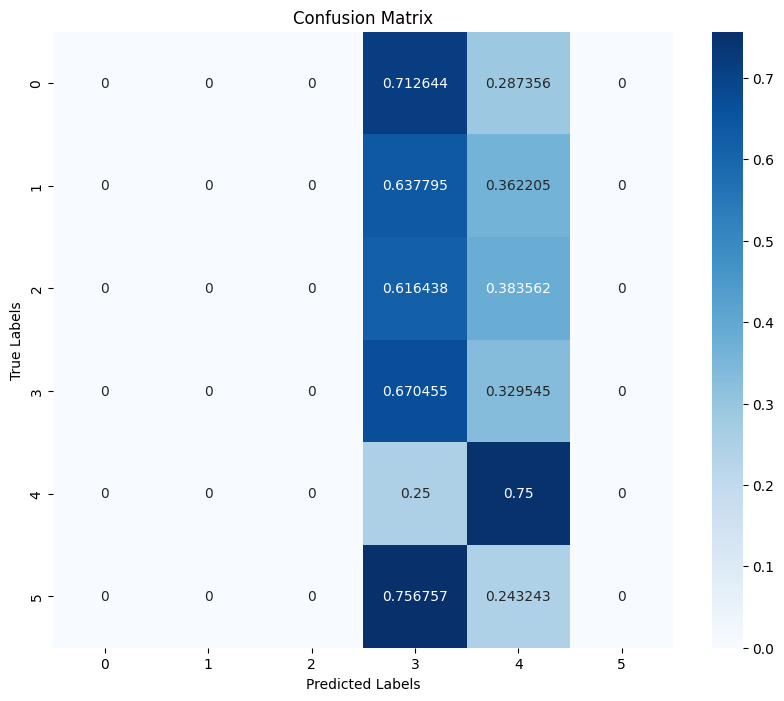

Epoch 16, Validation Loss: 1.7793, Accuracy: 0.2097, F1 Score: 0.1297
Val F1 Score Per Class  [0.         0.         0.         0.42446043 0.02985075 0.        ]


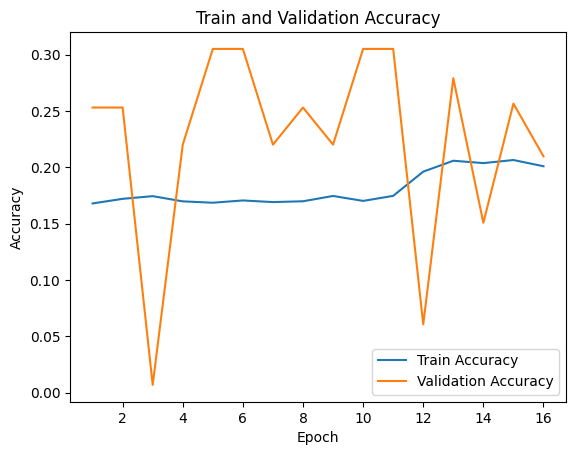

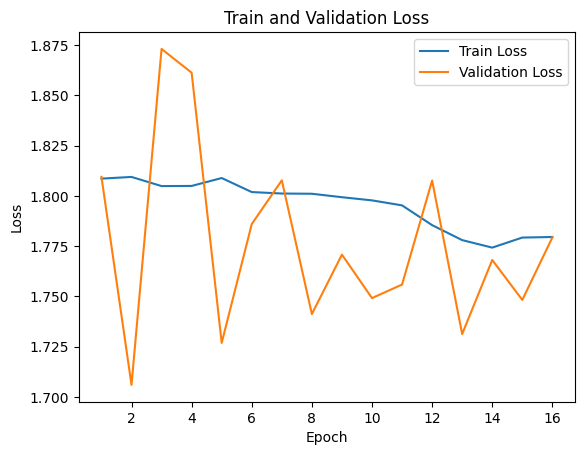

Epoch 17, Train Loss: 1.7786, Accuracy: 0.1997, F1 Score: 0.1189
Train F1 Score Per Class  [0.00481928 0.07920792 0.02413947 0.29680106 0.29263781 0.        ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.40it/s, loss=1.73]

[tensor([ 0.0636,  0.0840, -0.0109,  0.1853, -0.6341,  0.0871], device='cuda:0'), tensor([-0.1413,  0.0040, -0.1037,  0.0481, -0.1884,  0.0260], device='cuda:0'), tensor([-0.1961, -0.0211, -0.1248,  0.0059,  0.0726,  0.0047], device='cuda:0'), tensor([-0.0264,  0.0489, -0.0481,  0.1252, -0.3557,  0.0565], device='cuda:0'), tensor([ 0.0504,  0.0839, -0.0184,  0.1791, -0.7017,  0.0904], device='cuda:0'), tensor([-0.1523,  0.0006, -0.1083,  0.0398, -0.2358,  0.0242], device='cuda:0'), tensor([ 0.1719,  0.1320,  0.0304,  0.2589, -0.8539,  0.1356], device='cuda:0'), tensor([-0.1111,  0.0134, -0.0836,  0.0692, -0.2807,  0.0225], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.39it/s, loss=1.75]

[tensor([ 0.0811,  0.0921, -0.0038,  0.1961, -0.6778,  0.0971], device='cuda:0'), tensor([-0.0631,  0.0344, -0.0643,  0.1040, -0.4968,  0.0398], device='cuda:0'), tensor([-0.1510,  0.0013, -0.1072,  0.0427, -0.1074,  0.0213], device='cuda:0'), tensor([ 0.0318,  0.0720, -0.0258,  0.1657, -0.6305,  0.0765], device='cuda:0'), tensor([-0.0106,  0.0580, -0.0455,  0.1385, -0.6174,  0.0679], device='cuda:0'), tensor([-0.0040,  0.0588, -0.0392,  0.1415, -0.5240,  0.0639], device='cuda:0'), tensor([ 0.1162,  0.1086,  0.0094,  0.2204, -0.8203,  0.1141], device='cuda:0'), tensor([ 0.0508,  0.0820, -0.0192,  0.1771, -0.5654,  0.0914], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.35it/s, loss=1.75]

[tensor([ 0.1444,  0.1192,  0.0193,  0.2392, -0.8615,  0.1248], device='cuda:0'), tensor([-0.0560,  0.0370, -0.0623,  0.1054, -0.3515,  0.0481], device='cuda:0'), tensor([ 0.0987,  0.0997,  0.0025,  0.2055, -0.8098,  0.1093], device='cuda:0'), tensor([-0.0964,  0.0229, -0.0832,  0.0776, -0.6448,  0.0422], device='cuda:0'), tensor([ 0.0424,  0.0765, -0.0208,  0.1718, -0.5881,  0.0818], device='cuda:0'), tensor([-0.0371,  0.0450, -0.0548,  0.1139, -0.6021,  0.0613], device='cuda:0'), tensor([ 0.0852,  0.0967, -0.0059,  0.2010, -0.6184,  0.0992], device='cuda:0'), tensor([-0.0111,  0.0552, -0.0413,  0.1374, -0.4194,  0.0590], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.37it/s, loss=1.67]

[tensor([ 0.0223,  0.0699, -0.0314,  0.1562, -0.6565,  0.0832], device='cuda:0'), tensor([-0.0768,  0.0305, -0.0699,  0.0959, -0.4678,  0.0370], device='cuda:0'), tensor([ 0.1383,  0.1184,  0.0165,  0.2377, -0.7483,  0.1223], device='cuda:0'), tensor([ 9.6776e-02,  9.9879e-02,  1.0970e-04,  2.0553e-01, -6.9787e-01,
         1.0861e-01], device='cuda:0'), tensor([-0.1873, -0.0158, -0.1213,  0.0177, -0.1040,  0.0044], device='cuda:0'), tensor([ 0.1565,  0.1259,  0.0233,  0.2480, -0.9372,  0.1324], device='cuda:0'), tensor([ 0.1570,  0.1239,  0.0247,  0.2434, -0.8019,  0.1319], device='cuda:0'), tensor([ 0.0527,  0.0802, -0.0158,  0.1749, -0.7647,  0.0888], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=1.73]

[tensor([-0.0221,  0.0519, -0.0480,  0.1311, -0.3139,  0.0579], device='cuda:0'), tensor([ 0.1621,  0.1314,  0.0205,  0.2526, -1.0251,  0.1431], device='cuda:0'), tensor([-0.1939, -0.0192, -0.1226,  0.0071, -0.1019,  0.0068], device='cuda:0'), tensor([-0.0622,  0.0337, -0.0639,  0.0996, -0.3472,  0.0452], device='cuda:0'), tensor([ 0.0372,  0.0753, -0.0252,  0.1641, -0.6019,  0.0897], device='cuda:0'), tensor([-0.0826,  0.0280, -0.0762,  0.0842, -0.3134,  0.0487], device='cuda:0'), tensor([-0.1022,  0.0189, -0.0819,  0.0776, -0.3251,  0.0274], device='cuda:0'), tensor([-0.8614, -0.3290, -0.4135, -0.4668,  0.7255, -0.2454], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.36it/s, loss=1.67]

[tensor([ 0.0026,  0.0603, -0.0335,  0.1482, -0.5609,  0.0594], device='cuda:0'), tensor([ 0.1436,  0.1196,  0.0159,  0.2388, -0.7917,  0.1287], device='cuda:0'), tensor([-0.0692,  0.0315, -0.0682,  0.0933, -0.4875,  0.0469], device='cuda:0'), tensor([ 0.1563,  0.1250,  0.0256,  0.2491, -0.9185,  0.1264], device='cuda:0'), tensor([ 0.0237,  0.0694, -0.0291,  0.1574, -0.6053,  0.0789], device='cuda:0'), tensor([-0.0729,  0.0312, -0.0696,  0.0933, -0.3109,  0.0448], device='cuda:0'), tensor([-0.0014,  0.0603, -0.0385,  0.1445, -0.6164,  0.0652], device='cuda:0'), tensor([ 0.1024,  0.1050,  0.0025,  0.2138, -0.8324,  0.1110], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:28,  2.35it/s, loss=1.73]

[tensor([ 0.0418,  0.0772, -0.0222,  0.1695, -0.5246,  0.0871], device='cuda:0'), tensor([ 0.0817,  0.0932, -0.0060,  0.1943, -0.5948,  0.0961], device='cuda:0'), tensor([-0.1397,  0.0039, -0.0980,  0.0472, -0.1485,  0.0228], device='cuda:0'), tensor([-0.2655, -0.0491, -0.1557, -0.0386,  0.0281, -0.0217], device='cuda:0'), tensor([-0.0037,  0.0595, -0.0386,  0.1427, -0.3405,  0.0632], device='cuda:0'), tensor([-0.1308,  0.0096, -0.1032,  0.0501, -0.4417,  0.0298], device='cuda:0'), tensor([ 0.1419,  0.1212,  0.0141,  0.2406, -0.8782,  0.1294], device='cuda:0'), tensor([-0.0140,  0.0524, -0.0456,  0.1303, -0.4334,  0.0644], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.35it/s, loss=1.69]

[tensor([ 0.0264,  0.0708, -0.0261,  0.1599, -0.5138,  0.0777], device='cuda:0'), tensor([-0.2299, -0.0317, -0.1395, -0.0078,  0.1275, -0.0135], device='cuda:0'), tensor([ 0.0275,  0.0706, -0.0310,  0.1545, -0.5021,  0.0906], device='cuda:0'), tensor([ 0.0995,  0.1016,  0.0019,  0.2107, -0.7242,  0.1059], device='cuda:0'), tensor([ 0.0875,  0.0959, -0.0036,  0.2004, -0.7442,  0.1040], device='cuda:0'), tensor([ 0.0720,  0.0876, -0.0077,  0.1896, -0.6177,  0.0926], device='cuda:0'), tensor([ 0.0822,  0.0944, -0.0038,  0.2021, -0.6945,  0.0934], device='cuda:0'), tensor([-0.0099,  0.0569, -0.0435,  0.1358, -0.7207,  0.0680], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:27,  2.36it/s, loss=1.74]

[tensor([-0.0119,  0.0539, -0.0440,  0.1314, -0.6954,  0.0670], device='cuda:0'), tensor([-0.0501,  0.0390, -0.0632,  0.1032, -0.3215,  0.0603], device='cuda:0'), tensor([-0.1392,  0.0057, -0.1020,  0.0515, -0.3162,  0.0237], device='cuda:0'), tensor([-0.0411,  0.0439, -0.0549,  0.1187, -0.5325,  0.0490], device='cuda:0'), tensor([ 0.1194,  0.1190, -0.0008,  0.2389, -0.6679,  0.1164], device='cuda:0'), tensor([ 0.0344,  0.0740, -0.0265,  0.1631, -0.6594,  0.0869], device='cuda:0'), tensor([-0.0553,  0.0351, -0.0654,  0.1018, -0.2344,  0.0529], device='cuda:0'), tensor([-0.1092,  0.0173, -0.0865,  0.0676, -0.2114,  0.0373], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.36it/s, loss=1.71]

[tensor([-0.0050,  0.0580, -0.0409,  0.1390, -0.3377,  0.0619], device='cuda:0'), tensor([ 0.0452,  0.0797, -0.0224,  0.1758, -0.6108,  0.0867], device='cuda:0'), tensor([ 0.1359,  0.1150,  0.0185,  0.2323, -0.9213,  0.1196], device='cuda:0'), tensor([-0.0561,  0.0366, -0.0649,  0.1046, -0.2802,  0.0504], device='cuda:0'), tensor([-0.1701, -0.0100, -0.1139,  0.0268, -0.0011,  0.0107], device='cuda:0'), tensor([ 0.0944,  0.0981, -0.0031,  0.1996, -0.6830,  0.1154], device='cuda:0'), tensor([-0.1525, -0.0055, -0.1024,  0.0390, -0.4087,  0.0083], device='cuda:0'), tensor([ 0.1011,  0.1004,  0.0029,  0.2087, -0.6314,  0.1065], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.35it/s, loss=1.87]

[tensor([ 0.0183,  0.0704, -0.0335,  0.1577, -0.7423,  0.0797], device='cuda:0'), tensor([ 0.0447,  0.0805, -0.0230,  0.1751, -0.8037,  0.0893], device='cuda:0'), tensor([ 0.0611,  0.0864, -0.0137,  0.1841, -0.7861,  0.0938], device='cuda:0'), tensor([-0.0036,  0.0595, -0.0427,  0.1363, -0.6461,  0.0781], device='cuda:0'), tensor([-0.0098,  0.0540, -0.0427,  0.1331, -0.3162,  0.0655], device='cuda:0'), tensor([-0.1722, -0.0090, -0.1176,  0.0252, -0.2058,  0.0162], device='cuda:0'), tensor([-0.0544,  0.0373, -0.0613,  0.1047, -0.2979,  0.0496], device='cuda:0'), tensor([ 0.0117,  0.0641, -0.0339,  0.1473, -0.4861,  0.0762], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.35it/s, loss=1.7]

[tensor([-0.0917,  0.0235, -0.0801,  0.0790, -0.1875,  0.0427], device='cuda:0'), tensor([ 0.0448,  0.0845, -0.0236,  0.1760, -0.5316,  0.0950], device='cuda:0'), tensor([ 0.1307,  0.1129,  0.0148,  0.2309, -0.7303,  0.1166], device='cuda:0'), tensor([-0.0682,  0.0335, -0.0715,  0.0960, -0.1029,  0.0475], device='cuda:0'), tensor([-0.0242,  0.0505, -0.0534,  0.1223, -0.6656,  0.0679], device='cuda:0'), tensor([ 0.0651,  0.0880, -0.0121,  0.1875, -0.6515,  0.0941], device='cuda:0'), tensor([ 0.1338,  0.1131,  0.0149,  0.2286, -0.8466,  0.1215], device='cuda:0'), tensor([-0.0400,  0.0448, -0.0584,  0.1138, -0.5797,  0.0608], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.35it/s, loss=1.7]

[tensor([ 0.0150,  0.0664, -0.0332,  0.1543, -0.5996,  0.0736], device='cuda:0'), tensor([ 0.0375,  0.0752, -0.0221,  0.1690, -0.7316,  0.0802], device='cuda:0'), tensor([-0.0478,  0.0429, -0.0606,  0.1094, -0.3673,  0.0593], device='cuda:0'), tensor([-0.3088, -0.0707, -0.1740, -0.0730,  0.0806, -0.0377], device='cuda:0'), tensor([-0.0137,  0.0540, -0.0442,  0.1326, -0.4520,  0.0648], device='cuda:0'), tensor([ 8.9997e-02,  9.7050e-02, -5.5993e-04,  2.0062e-01, -6.9386e-01,
         1.0564e-01], device='cuda:0'), tensor([-0.1719, -0.0080, -0.1199,  0.0223, -0.2109,  0.0246], device='cuda:0'), tensor([-0.0518,  0.0391, -0.0611,  0.1078, -0.4310,  0.0503], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:25,  2.36it/s, loss=1.7]

[tensor([-0.0416,  0.0429, -0.0588,  0.1128, -0.2903,  0.0589], device='cuda:0'), tensor([ 0.0455,  0.0781, -0.0181,  0.1738, -0.6086,  0.0824], device='cuda:0'), tensor([-0.0101,  0.0544, -0.0419,  0.1371, -0.3117,  0.0601], device='cuda:0'), tensor([ 0.0501,  0.0807, -0.0214,  0.1755, -0.6396,  0.0923], device='cuda:0'), tensor([-0.0444,  0.0391, -0.0570,  0.1120, -0.3122,  0.0472], device='cuda:0'), tensor([ 0.0087,  0.0619, -0.0330,  0.1484, -0.3241,  0.0669], device='cuda:0'), tensor([-0.0476,  0.0412, -0.0605,  0.1064, -0.3205,  0.0566], device='cuda:0'), tensor([-0.0185,  0.0551, -0.0478,  0.1343, -0.6029,  0.0622], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.36it/s, loss=1.73]

[tensor([ 0.0217,  0.0703, -0.0320,  0.1577, -0.5567,  0.0818], device='cuda:0'), tensor([ 0.0028,  0.0611, -0.0371,  0.1453, -0.3721,  0.0690], device='cuda:0'), tensor([-0.0074,  0.0572, -0.0416,  0.1376, -0.4472,  0.0664], device='cuda:0'), tensor([-0.0243,  0.0499, -0.0477,  0.1264, -0.5816,  0.0590], device='cuda:0'), tensor([ 0.0577,  0.0848, -0.0128,  0.1855, -0.6728,  0.0852], device='cuda:0'), tensor([-0.0609,  0.0327, -0.0644,  0.0996, -0.5125,  0.0458], device='cuda:0'), tensor([ 0.0319,  0.0734, -0.0256,  0.1664, -0.4777,  0.0774], device='cuda:0'), tensor([-0.0936,  0.0229, -0.0824,  0.0786, -0.1557,  0.0400], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.36it/s, loss=1.74]

[tensor([-0.0869,  0.0229, -0.0756,  0.0804, -0.6292,  0.0403], device='cuda:0'), tensor([-0.0100,  0.0553, -0.0408,  0.1343, -0.2975,  0.0642], device='cuda:0'), tensor([-0.0692,  0.0323, -0.0722,  0.0922, -0.5531,  0.0531], device='cuda:0'), tensor([-0.2361, -0.0335, -0.1541, -0.0232,  0.0928,  0.0050], device='cuda:0'), tensor([ 0.0019,  0.0616, -0.0371,  0.1434, -0.4695,  0.0708], device='cuda:0'), tensor([-0.0022,  0.0595, -0.0426,  0.1416, -0.6046,  0.0656], device='cuda:0'), tensor([ 0.0103,  0.0639, -0.0345,  0.1500, -0.4986,  0.0710], device='cuda:0'), tensor([-0.0717,  0.0307, -0.0714,  0.0932, -0.6079,  0.0469], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=1.77]

[tensor([-0.1837, -0.0149, -0.1175,  0.0181, -0.0123,  0.0058], device='cuda:0'), tensor([-0.0397,  0.0443, -0.0550,  0.1193, -0.6047,  0.0508], device='cuda:0'), tensor([ 0.0918,  0.0997, -0.0028,  0.2030, -0.8659,  0.1101], device='cuda:0'), tensor([-0.1338,  0.0052, -0.0960,  0.0505, -0.0604,  0.0240], device='cuda:0'), tensor([ 0.0367,  0.0723, -0.0217,  0.1640, -0.5673,  0.0802], device='cuda:0'), tensor([-0.0129,  0.0549, -0.0427,  0.1352, -0.4992,  0.0617], device='cuda:0'), tensor([-2.7664e-01, -3.2911e-02, -1.6917e-01, -2.1925e-04, -9.8530e-02,
        -7.4921e-03], device='cuda:0'), tensor([-0.0373,  0.0459, -0.0588,  0.1138, -0.5632,  0.0669], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.36it/s, loss=1.75]

[tensor([-0.1424,  0.0012, -0.1016,  0.0416,  0.1343,  0.0221], device='cuda:0'), tensor([ 1.0559e-01,  1.0253e-01, -4.8957e-04,  2.0748e-01, -7.7010e-01,
         1.2021e-01], device='cuda:0'), tensor([-0.2339, -0.0349, -0.1425, -0.0188,  0.1964, -0.0174], device='cuda:0'), tensor([-0.0045,  0.0574, -0.0416,  0.1376, -0.4908,  0.0697], device='cuda:0'), tensor([ 0.0171,  0.0649, -0.0309,  0.1542, -0.3762,  0.0698], device='cuda:0'), tensor([ 0.0007,  0.0614, -0.0362,  0.1478, -0.5394,  0.0616], device='cuda:0'), tensor([-0.0438,  0.0452, -0.0593,  0.1150, -0.3295,  0.0583], device='cuda:0'), tensor([-0.1950, -0.0167, -0.1294,  0.0086,  0.0271,  0.0150], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.36it/s, loss=1.74]

[tensor([-0.0359,  0.0467, -0.0583,  0.1154, -0.6121,  0.0665], device='cuda:0'), tensor([-0.1863, -0.0148, -0.1215,  0.0175,  0.0661,  0.0074], device='cuda:0'), tensor([-0.0793,  0.0257, -0.0746,  0.0859, -0.3680,  0.0429], device='cuda:0'), tensor([ 0.0479,  0.0803, -0.0199,  0.1730, -0.5495,  0.0914], device='cuda:0'), tensor([-0.1071,  0.0171, -0.0872,  0.0694, -0.3748,  0.0364], device='cuda:0'), tensor([-0.0671,  0.0316, -0.0652,  0.0968, -0.3742,  0.0423], device='cuda:0'), tensor([-0.2358, -0.0378, -0.1398, -0.0183,  0.3063, -0.0244], device='cuda:0'), tensor([-0.0484,  0.0419, -0.0666,  0.1037, -0.2865,  0.0660], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.36it/s, loss=1.72]

[tensor([-0.1929, -0.0139, -0.1301,  0.0111, -0.3429,  0.0192], device='cuda:0'), tensor([-0.0805,  0.0268, -0.0749,  0.0842, -0.2200,  0.0477], device='cuda:0'), tensor([-0.0294,  0.0517, -0.0521,  0.1287, -0.5831,  0.0586], device='cuda:0'), tensor([-0.1117,  0.0155, -0.0906,  0.0672, -0.6467,  0.0352], device='cuda:0'), tensor([ 0.1441,  0.1190,  0.0200,  0.2389, -0.8219,  0.1238], device='cuda:0'), tensor([ 0.0645,  0.0852, -0.0111,  0.1856, -0.6677,  0.0902], device='cuda:0'), tensor([ 0.0395,  0.0774, -0.0223,  0.1698, -0.5728,  0.0845], device='cuda:0'), tensor([ 0.0231,  0.0697, -0.0276,  0.1599, -0.6602,  0.0738], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.36it/s, loss=1.76]

[tensor([-0.0875,  0.0269, -0.0812,  0.0796, -0.4361,  0.0522], device='cuda:0'), tensor([-0.1993, -0.0256, -0.1242,  0.0010,  0.2361, -0.0007], device='cuda:0'), tensor([ 0.0802,  0.0925, -0.0071,  0.1932, -0.7605,  0.1017], device='cuda:0'), tensor([-0.1812, -0.0146, -0.1177,  0.0174, -0.1740,  0.0079], device='cuda:0'), tensor([ 0.0804,  0.0934, -0.0066,  0.1948, -0.7514,  0.1034], device='cuda:0'), tensor([-0.1755, -0.0122, -0.1153,  0.0207,  0.0466,  0.0113], device='cuda:0'), tensor([-0.2091, -0.0222, -0.1339, -0.0012,  0.2258,  0.0097], device='cuda:0'), tensor([ 0.0011,  0.0615, -0.0435,  0.1381, -0.4274,  0.0806], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.36it/s, loss=1.79]

[tensor([-0.0487,  0.0398, -0.0584,  0.1097, -0.2947,  0.0502], device='cuda:0'), tensor([-0.0439,  0.0450, -0.0583,  0.1153, -0.2009,  0.0574], device='cuda:0'), tensor([-0.0519,  0.0398, -0.0616,  0.1067, -0.3988,  0.0550], device='cuda:0'), tensor([ 0.1335,  0.1161,  0.0158,  0.2358, -0.8726,  0.1163], device='cuda:0'), tensor([-0.2652, -0.0483, -0.1544, -0.0352,  0.1863, -0.0254], device='cuda:0'), tensor([-0.0984,  0.0200, -0.0795,  0.0759, -0.3911,  0.0344], device='cuda:0'), tensor([-0.1190,  0.0102, -0.0889,  0.0626, -0.0955,  0.0229], device='cuda:0'), tensor([-0.1562, -0.0036, -0.1063,  0.0373, -0.1439,  0.0141], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.35it/s, loss=1.7]

[tensor([ 0.1459,  0.1181,  0.0222,  0.2393, -0.8153,  0.1207], device='cuda:0'), tensor([ 0.0034,  0.0619, -0.0388,  0.1435, -0.4924,  0.0747], device='cuda:0'), tensor([ 0.1834,  0.1380,  0.0309,  0.2616, -0.9973,  0.1533], device='cuda:0'), tensor([ 0.0909,  0.0989, -0.0011,  0.2028, -0.8311,  0.1090], device='cuda:0'), tensor([ 0.0474,  0.0799, -0.0202,  0.1738, -0.6367,  0.0893], device='cuda:0'), tensor([ 0.0728,  0.0902, -0.0083,  0.1907, -0.5847,  0.0969], device='cuda:0'), tensor([ 0.0561,  0.0838, -0.0166,  0.1798, -0.6251,  0.0928], device='cuda:0'), tensor([-0.0978,  0.0200, -0.0835,  0.0746, -0.1871,  0.0402], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.35it/s, loss=1.75]

[tensor([-0.1040,  0.0169, -0.0850,  0.0692, -0.1247,  0.0279], device='cuda:0'), tensor([ 0.1397,  0.1184,  0.0170,  0.2340, -0.7943,  0.1275], device='cuda:0'), tensor([ 0.1756,  0.1322,  0.0312,  0.2573, -0.8760,  0.1414], device='cuda:0'), tensor([-0.0145,  0.0534, -0.0439,  0.1292, -0.6000,  0.0671], device='cuda:0'), tensor([ 0.0006,  0.0593, -0.0365,  0.1438, -0.4769,  0.0647], device='cuda:0'), tensor([ 0.0103,  0.0639, -0.0384,  0.1471, -0.5324,  0.0709], device='cuda:0'), tensor([-0.1966, -0.0184, -0.1261,  0.0102, -0.3037,  0.0051], device='cuda:0'), tensor([-0.2179, -0.0289, -0.1322, -0.0051,  0.1633, -0.0076], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.36it/s, loss=1.65]

[tensor([-0.4510, -0.1154, -0.2599, -0.1577,  0.6139, -0.0541], device='cuda:0'), tensor([-0.0927,  0.0218, -0.0764,  0.0855, -0.2061,  0.0260], device='cuda:0'), tensor([ 0.0549,  0.0784, -0.0240,  0.1694, -0.8472,  0.1033], device='cuda:0'), tensor([-0.0297,  0.0469, -0.0515,  0.1226, -0.4024,  0.0571], device='cuda:0'), tensor([ 0.0312,  0.0738, -0.0288,  0.1629, -0.7022,  0.0865], device='cuda:0'), tensor([ 0.0833,  0.0937, -0.0054,  0.1976, -0.6945,  0.1013], device='cuda:0'), tensor([-0.1425,  0.0039, -0.1031,  0.0454, -0.2590,  0.0275], device='cuda:0'), tensor([-0.0979,  0.0194, -0.0826,  0.0697, -0.1156,  0.0455], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:11<00:19,  2.37it/s, loss=1.68]

[tensor([ 0.0389,  0.0770, -0.0241,  0.1670, -0.6131,  0.0892], device='cuda:0'), tensor([ 0.0380,  0.0753, -0.0228,  0.1668, -0.5444,  0.0851], device='cuda:0'), tensor([ 0.1706,  0.1315,  0.0285,  0.2567, -0.8015,  0.1369], device='cuda:0'), tensor([-0.0910,  0.0236, -0.0829,  0.0747, -0.2781,  0.0448], device='cuda:0'), tensor([ 0.0823,  0.0936, -0.0049,  0.1958, -0.6852,  0.1022], device='cuda:0'), tensor([ 0.0325,  0.0736, -0.0238,  0.1660, -0.8046,  0.0783], device='cuda:0'), tensor([ 0.0079,  0.0620, -0.0360,  0.1455, -0.3774,  0.0734], device='cuda:0'), tensor([-0.1578, -0.0052, -0.1064,  0.0338, -0.2074,  0.0142], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.37it/s, loss=1.74]

[tensor([ 0.1149,  0.1069,  0.0093,  0.2207, -0.7528,  0.1100], device='cuda:0'), tensor([-0.0261,  0.0507, -0.0510,  0.1227, -0.2801,  0.0671], device='cuda:0'), tensor([-0.0179,  0.0536, -0.0482,  0.1305, -0.6171,  0.0659], device='cuda:0'), tensor([ 0.1592,  0.1341,  0.0169,  0.2645, -0.7622,  0.1291], device='cuda:0'), tensor([ 0.0864,  0.0949, -0.0058,  0.1955, -0.5735,  0.0991], device='cuda:0'), tensor([-0.0522,  0.0356, -0.0587,  0.1007, -0.1789,  0.0507], device='cuda:0'), tensor([-0.0426,  0.0427, -0.0564,  0.1155, -0.4304,  0.0507], device='cuda:0'), tensor([-0.0439,  0.0417, -0.0595,  0.1103, -0.2938,  0.0511], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=1.71]

[tensor([ 0.0109,  0.0617, -0.0329,  0.1455, -0.4764,  0.0720], device='cuda:0'), tensor([ 0.1616,  0.1289,  0.0214,  0.2507, -0.8982,  0.1384], device='cuda:0'), tensor([-0.0491,  0.0393, -0.0595,  0.1105, -0.2977,  0.0487], device='cuda:0'), tensor([ 0.0243,  0.0692, -0.0307,  0.1629, -0.6122,  0.0734], device='cuda:0'), tensor([ 0.0116,  0.0628, -0.0335,  0.1503, -0.3812,  0.0684], device='cuda:0'), tensor([-0.0675,  0.0331, -0.0648,  0.0967, -0.3594,  0.0404], device='cuda:0'), tensor([-0.0703,  0.0310, -0.0703,  0.0908, -0.3255,  0.0464], device='cuda:0'), tensor([ 0.0176,  0.0666, -0.0303,  0.1530, -0.4670,  0.0740], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.36it/s, loss=1.73]

[tensor([ 0.0150,  0.0654, -0.0311,  0.1508, -0.4708,  0.0740], device='cuda:0'), tensor([ 0.0708,  0.0870, -0.0105,  0.1894, -0.7194,  0.0930], device='cuda:0'), tensor([-0.1489, -0.0032, -0.1046,  0.0368, -0.0747,  0.0201], device='cuda:0'), tensor([ 0.1004,  0.1042, -0.0046,  0.2097, -0.7853,  0.1196], device='cuda:0'), tensor([-0.0101,  0.0545, -0.0433,  0.1308, -0.4765,  0.0702], device='cuda:0'), tensor([ 9.2075e-02,  9.5015e-02,  2.9956e-04,  2.0107e-01, -5.9705e-01,
         1.0195e-01], device='cuda:0'), tensor([-0.1327,  0.0052, -0.0915,  0.0525, -0.0305,  0.0179], device='cuda:0'), tensor([ 0.0654,  0.0866, -0.0111,  0.1829, -0.7368,  0.0973], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.36it/s, loss=1.79]

[tensor([ 0.0312,  0.0733, -0.0304,  0.1592, -0.6579,  0.0921], device='cuda:0'), tensor([-0.1148,  0.0127, -0.0934,  0.0594, -0.0702,  0.0372], device='cuda:0'), tensor([ 0.1148,  0.1084,  0.0074,  0.2210, -0.6555,  0.1127], device='cuda:0'), tensor([-0.1420,  0.0010, -0.0961,  0.0461,  0.0405,  0.0148], device='cuda:0'), tensor([ 1.0501e-01,  1.0436e-01, -4.7948e-04,  2.1125e-01, -8.0282e-01,
         1.1799e-01], device='cuda:0'), tensor([ 0.0441,  0.0786, -0.0249,  0.1689, -0.5751,  0.0902], device='cuda:0'), tensor([-0.1057,  0.0190, -0.0887,  0.0702, -0.0486,  0.0364], device='cuda:0'), tensor([-0.2072, -0.0243, -0.1306, -0.0024, -0.0530,  0.0066], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.36it/s, loss=1.73]

[tensor([ 9.2110e-02,  9.6604e-02,  4.3024e-04,  2.0564e-01, -6.5391e-01,
         9.9055e-02], device='cuda:0'), tensor([ 0.1381,  0.1172,  0.0171,  0.2373, -0.8352,  0.1195], device='cuda:0'), tensor([ 0.0010,  0.0603, -0.0409,  0.1429, -0.5145,  0.0723], device='cuda:0'), tensor([-0.0366,  0.0449, -0.0539,  0.1169, -0.3380,  0.0565], device='cuda:0'), tensor([ 0.0839,  0.0933, -0.0031,  0.1969, -0.7154,  0.0996], device='cuda:0'), tensor([-0.0988,  0.0193, -0.0778,  0.0769, -0.3900,  0.0292], device='cuda:0'), tensor([ 0.0664,  0.0904, -0.0127,  0.1912, -0.5413,  0.0965], device='cuda:0'), tensor([ 0.0622,  0.0868, -0.0152,  0.1827, -0.7409,  0.0900], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.36it/s, loss=1.74]

[tensor([ 0.0028,  0.0620, -0.0380,  0.1474, -0.6308,  0.0687], device='cuda:0'), tensor([ 0.0034,  0.0623, -0.0369,  0.1446, -0.6816,  0.0716], device='cuda:0'), tensor([ 0.0041,  0.0615, -0.0345,  0.1473, -0.5781,  0.0661], device='cuda:0'), tensor([-0.1109,  0.0150, -0.0842,  0.0709, -0.1502,  0.0239], device='cuda:0'), tensor([ 0.0671,  0.0873, -0.0103,  0.1860, -0.5590,  0.0955], device='cuda:0'), tensor([ 0.1506,  0.1256,  0.0173,  0.2488, -1.0864,  0.1305], device='cuda:0'), tensor([-0.0702,  0.0331, -0.0686,  0.0992, -0.3061,  0.0411], device='cuda:0'), tensor([ 0.0973,  0.1003,  0.0013,  0.2107, -0.7685,  0.1017], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=1.73]

[tensor([-0.0554,  0.0390, -0.0618,  0.1087, -0.3069,  0.0467], device='cuda:0'), tensor([ 0.1412,  0.1174,  0.0168,  0.2351, -0.7584,  0.1260], device='cuda:0'), tensor([ 0.1603,  0.1254,  0.0266,  0.2486, -0.8759,  0.1300], device='cuda:0'), tensor([ 0.1207,  0.1111,  0.0100,  0.2243, -0.9291,  0.1165], device='cuda:0'), tensor([-0.1401,  0.0070, -0.1081,  0.0485,  0.0139,  0.0336], device='cuda:0'), tensor([ 0.0820,  0.0942, -0.0054,  0.1964, -0.7536,  0.1033], device='cuda:0'), tensor([-0.0273,  0.0478, -0.0500,  0.1225, -0.5433,  0.0555], device='cuda:0'), tensor([-0.0292,  0.0487, -0.0502,  0.1240, -0.2630,  0.0581], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=1.7]

[tensor([ 0.0734,  0.0906, -0.0097,  0.1943, -0.7399,  0.0944], device='cuda:0'), tensor([ 0.1122,  0.1062,  0.0045,  0.2158, -0.7377,  0.1177], device='cuda:0'), tensor([ 0.0751,  0.0899, -0.0089,  0.1945, -0.6838,  0.0942], device='cuda:0'), tensor([-0.0307,  0.0483, -0.0509,  0.1233, -0.5555,  0.0571], device='cuda:0'), tensor([-0.1651, -0.0062, -0.1099,  0.0312, -0.5321,  0.0124], device='cuda:0'), tensor([ 0.0028,  0.0621, -0.0384,  0.1460, -0.6991,  0.0697], device='cuda:0'), tensor([-0.0796,  0.0273, -0.0754,  0.0852, -0.2982,  0.0488], device='cuda:0'), tensor([ 0.0093,  0.0635, -0.0355,  0.1474, -0.8321,  0.0747], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.37it/s, loss=1.71]

[tensor([-0.2292, -0.0182, -0.1478,  0.0267, -0.3562, -0.0040], device='cuda:0'), tensor([ 0.1587,  0.1245,  0.0228,  0.2435, -0.8818,  0.1388], device='cuda:0'), tensor([ 0.0461,  0.0786, -0.0214,  0.1724, -0.5572,  0.0880], device='cuda:0'), tensor([ 0.1130,  0.1097,  0.0037,  0.2181, -0.9115,  0.1221], device='cuda:0'), tensor([-0.2009, -0.0197, -0.1371, -0.0011,  0.0920,  0.0207], device='cuda:0'), tensor([ 0.1240,  0.1095,  0.0116,  0.2234, -0.7896,  0.1168], device='cuda:0'), tensor([ 0.0087,  0.0659, -0.0376,  0.1538, -0.5853,  0.0708], device='cuda:0'), tensor([ 0.1493,  0.1224,  0.0218,  0.2450, -0.8083,  0.1245], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=1.73]

[tensor([ 0.0317,  0.0740, -0.0264,  0.1646, -0.5596,  0.0830], device='cuda:0'), tensor([-0.0130,  0.0556, -0.0466,  0.1319, -0.7823,  0.0714], device='cuda:0'), tensor([-0.0459,  0.0398, -0.0572,  0.1104, -0.4160,  0.0505], device='cuda:0'), tensor([ 0.0295,  0.0725, -0.0268,  0.1641, -0.7819,  0.0786], device='cuda:0'), tensor([-0.0510,  0.0419, -0.0605,  0.1115, -0.3778,  0.0514], device='cuda:0'), tensor([-0.1637, -0.0077, -0.1080,  0.0342, -0.2615,  0.0065], device='cuda:0'), tensor([ 0.0442,  0.0789, -0.0211,  0.1708, -0.6104,  0.0897], device='cuda:0'), tensor([ 0.0471,  0.0817, -0.0201,  0.1750, -0.7328,  0.0911], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=1.71]

[tensor([-0.0083,  0.0585, -0.0435,  0.1380, -0.7001,  0.0708], device='cuda:0'), tensor([ 0.0594,  0.0828, -0.0169,  0.1772, -0.6464,  0.0969], device='cuda:0'), tensor([ 0.1495,  0.1236,  0.0203,  0.2437, -0.8867,  0.1300], device='cuda:0'), tensor([-0.0730,  0.0290, -0.0697,  0.0925, -0.2974,  0.0411], device='cuda:0'), tensor([-0.0072,  0.0570, -0.0413,  0.1379, -0.4932,  0.0655], device='cuda:0'), tensor([-0.0417,  0.0428, -0.0572,  0.1149, -0.4529,  0.0531], device='cuda:0'), tensor([-0.0946,  0.0193, -0.0791,  0.0759, -0.0266,  0.0355], device='cuda:0'), tensor([-0.0846,  0.0242, -0.0757,  0.0842, -0.2920,  0.0383], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.36it/s, loss=1.77]

[tensor([-0.1584, -0.0038, -0.1072,  0.0390, -0.0101,  0.0097], device='cuda:0'), tensor([-0.0410,  0.0444, -0.0566,  0.1139, -0.3459,  0.0592], device='cuda:0'), tensor([ 0.0831,  0.0925, -0.0021,  0.1973, -0.6507,  0.0962], device='cuda:0'), tensor([-0.0847,  0.0266, -0.0781,  0.0825, -0.3193,  0.0481], device='cuda:0'), tensor([ 0.0281,  0.0703, -0.0276,  0.1584, -0.6835,  0.0813], device='cuda:0'), tensor([ 0.0248,  0.0710, -0.0284,  0.1585, -0.4338,  0.0744], device='cuda:0'), tensor([ 0.0271,  0.0717, -0.0291,  0.1608, -0.5734,  0.0821], device='cuda:0'), tensor([-0.6596, -0.2463, -0.3202, -0.3551,  0.3174, -0.1671], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.36it/s, loss=1.74]

[tensor([ 0.1020,  0.1024, -0.0039,  0.2066, -0.7266,  0.1210], device='cuda:0'), tensor([ 0.0095,  0.0651, -0.0352,  0.1493, -0.4844,  0.0751], device='cuda:0'), tensor([-0.1329,  0.0049, -0.0940,  0.0520, -0.1240,  0.0196], device='cuda:0'), tensor([ 0.0582,  0.0819, -0.0148,  0.1757, -0.7439,  0.0951], device='cuda:0'), tensor([-0.0584,  0.0355, -0.0644,  0.0993, -0.2981,  0.0533], device='cuda:0'), tensor([ 0.1404,  0.1209,  0.0112,  0.2353, -0.8162,  0.1336], device='cuda:0'), tensor([ 0.1198,  0.1090,  0.0081,  0.2236, -0.6810,  0.1093], device='cuda:0'), tensor([ 0.1312,  0.1140,  0.0126,  0.2292, -0.7853,  0.1232], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.36it/s, loss=1.79]

[tensor([-0.0519,  0.0397, -0.0600,  0.1096, -0.2964,  0.0490], device='cuda:0'), tensor([ 1.0270e-01,  1.0287e-01,  5.2997e-04,  2.1127e-01, -7.2810e-01,
         1.1034e-01], device='cuda:0'), tensor([-0.1160,  0.0150, -0.0907,  0.0674, -0.2667,  0.0302], device='cuda:0'), tensor([ 0.1710,  0.1300,  0.0290,  0.2556, -0.9464,  0.1375], device='cuda:0'), tensor([-0.0284,  0.0482, -0.0535,  0.1203, -0.2369,  0.0636], device='cuda:0'), tensor([-0.1856, -0.0140, -0.1199,  0.0163,  0.1705,  0.0111], device='cuda:0'), tensor([-0.1244,  0.0095, -0.0949,  0.0575, -0.2275,  0.0302], device='cuda:0'), tensor([-0.0296,  0.0485, -0.0523,  0.1208, -0.4261,  0.0631], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=1.75]

[tensor([ 0.0504,  0.0808, -0.0179,  0.1761, -0.6566,  0.0874], device='cuda:0'), tensor([-0.1408,  0.0026, -0.1023,  0.0453, -0.2919,  0.0236], device='cuda:0'), tensor([-0.2696, -0.0494, -0.1552, -0.0380,  0.2157, -0.0266], device='cuda:0'), tensor([ 0.0474,  0.0787, -0.0211,  0.1713, -0.7335,  0.0918], device='cuda:0'), tensor([ 0.0447,  0.0784, -0.0203,  0.1751, -0.6036,  0.0824], device='cuda:0'), tensor([ 0.0718,  0.0896, -0.0109,  0.1895, -0.6487,  0.0995], device='cuda:0'), tensor([-0.0743,  0.0294, -0.0687,  0.0908, -0.2703,  0.0426], device='cuda:0'), tensor([-0.0873,  0.0234, -0.0735,  0.0812, -0.3180,  0.0369], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.37it/s, loss=1.79]

[tensor([ 0.0560,  0.0845, -0.0204,  0.1760, -0.6157,  0.1036], device='cuda:0'), tensor([ 0.0512,  0.0809, -0.0185,  0.1756, -0.6718,  0.0910], device='cuda:0'), tensor([-0.0679,  0.0331, -0.0727,  0.0939, -0.1474,  0.0463], device='cuda:0'), tensor([ 0.1954,  0.1395,  0.0402,  0.2724, -0.8887,  0.1431], device='cuda:0'), tensor([-0.1868, -0.0197, -0.1194,  0.0112, -0.0819,  0.0045], device='cuda:0'), tensor([-0.9167, -0.3516, -0.4601, -0.5134,  1.5263, -0.2404], device='cuda:0'), tensor([-0.0557,  0.0388, -0.0634,  0.1052, -0.3021,  0.0523], device='cuda:0'), tensor([ 0.1481,  0.1222,  0.0206,  0.2368, -0.9751,  0.1358], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=1.69]

[tensor([ 0.0972,  0.1007, -0.0013,  0.2060, -0.6485,  0.1088], device='cuda:0'), tensor([-0.0751,  0.0286, -0.0711,  0.0899, -0.1388,  0.0422], device='cuda:0'), tensor([-0.0402,  0.0423, -0.0553,  0.1149, -0.5434,  0.0473], device='cuda:0'), tensor([ 0.0119,  0.0650, -0.0339,  0.1513, -0.4551,  0.0723], device='cuda:0'), tensor([-0.0450,  0.0424, -0.0578,  0.1101, -0.2389,  0.0585], device='cuda:0'), tensor([ 0.0165,  0.0667, -0.0330,  0.1506, -0.4542,  0.0729], device='cuda:0'), tensor([-0.1261,  0.0086, -0.0915,  0.0567, -0.2406,  0.0248], device='cuda:0'), tensor([-0.0160,  0.0535, -0.0449,  0.1316, -0.4624,  0.0633], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=1.74]

[tensor([-0.0938,  0.0238, -0.0834,  0.0755, -0.3820,  0.0402], device='cuda:0'), tensor([-0.0342,  0.0454, -0.0536,  0.1158, -0.6185,  0.0614], device='cuda:0'), tensor([-0.0846,  0.0284, -0.0762,  0.0882, -0.4910,  0.0424], device='cuda:0'), tensor([-0.1561, -0.0030, -0.1037,  0.0396, -0.0033,  0.0096], device='cuda:0'), tensor([-0.1171,  0.0140, -0.0916,  0.0574, -0.0311,  0.0337], device='cuda:0'), tensor([-0.0812,  0.0267, -0.0779,  0.0834, -0.2175,  0.0501], device='cuda:0'), tensor([ 0.0295,  0.0738, -0.0276,  0.1633, -0.7060,  0.0833], device='cuda:0'), tensor([ 0.1408,  0.1158,  0.0173,  0.2335, -0.8727,  0.1249], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:11,  2.36it/s, loss=1.68]

[tensor([-0.0272,  0.0506, -0.0508,  0.1242, -0.4649,  0.0638], device='cuda:0'), tensor([ 0.0220,  0.0694, -0.0316,  0.1574, -0.7566,  0.0802], device='cuda:0'), tensor([ 0.1315,  0.1129,  0.0159,  0.2298, -0.7843,  0.1114], device='cuda:0'), tensor([-0.1632, -0.0030, -0.1144,  0.0353, -0.0335,  0.0187], device='cuda:0'), tensor([-0.0866,  0.0234, -0.0769,  0.0810, -0.2048,  0.0416], device='cuda:0'), tensor([ 0.0694,  0.0877, -0.0122,  0.1864, -0.6328,  0.0993], device='cuda:0'), tensor([ 9.1517e-02,  9.6506e-02, -6.0590e-05,  2.0575e-01, -6.9006e-01,
         9.7018e-02], device='cuda:0'), tensor([-0.0709,  0.0309, -0.0677,  0.0954, -0.2511,  0.0411], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.36it/s, loss=1.74]

[tensor([-0.0546,  0.0387, -0.0623,  0.1026, -0.3834,  0.0568], device='cuda:0'), tensor([ 0.0387,  0.0745, -0.0224,  0.1699, -0.4823,  0.0783], device='cuda:0'), tensor([ 0.1315,  0.1125,  0.0156,  0.2259, -0.8355,  0.1223], device='cuda:0'), tensor([ 0.0254,  0.0715, -0.0283,  0.1608, -0.4072,  0.0794], device='cuda:0'), tensor([ 0.0967,  0.1004,  0.0026,  0.2097, -0.7624,  0.1019], device='cuda:0'), tensor([-0.1811, -0.0150, -0.1144,  0.0216, -0.0469, -0.0020], device='cuda:0'), tensor([-0.0157,  0.0540, -0.0466,  0.1299, -0.4410,  0.0680], device='cuda:0'), tensor([-2.0991e-01, -2.5010e-02, -1.3291e-01,  1.9491e-04,  3.0180e-01,
        -3.7621e-03], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.35it/s, loss=1.66]

[tensor([ 0.1258,  0.1109,  0.0143,  0.2265, -0.7303,  0.1140], device='cuda:0'), tensor([ 0.0225,  0.0693, -0.0279,  0.1577, -0.4592,  0.0758], device='cuda:0'), tensor([-0.0436,  0.0406, -0.0564,  0.1121, -0.5719,  0.0512], device='cuda:0'), tensor([ 0.0446,  0.0782, -0.0208,  0.1681, -0.6905,  0.0922], device='cuda:0'), tensor([-0.0100,  0.0568, -0.0435,  0.1370, -0.3933,  0.0667], device='cuda:0'), tensor([ 0.1217,  0.1092,  0.0109,  0.2207, -0.8081,  0.1190], device='cuda:0'), tensor([-0.0054,  0.0586, -0.0427,  0.1366, -0.3347,  0.0730], device='cuda:0'), tensor([ 0.0958,  0.0997,  0.0022,  0.2102, -0.7659,  0.0988], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.36it/s, loss=1.73]

[tensor([-0.0188,  0.0541, -0.0491,  0.1285, -0.5799,  0.0698], device='cuda:0'), tensor([ 0.1025,  0.1011,  0.0041,  0.2101, -0.7387,  0.1073], device='cuda:0'), tensor([-0.1358,  0.0102, -0.1127,  0.0467, -0.0246,  0.0509], device='cuda:0'), tensor([-0.0911,  0.0236, -0.0786,  0.0817, -0.3677,  0.0373], device='cuda:0'), tensor([ 0.0525,  0.0808, -0.0162,  0.1782, -0.5713,  0.0856], device='cuda:0'), tensor([ 0.0756,  0.0919, -0.0086,  0.1962, -0.6276,  0.0955], device='cuda:0'), tensor([ 0.0689,  0.0882, -0.0085,  0.1908, -0.5338,  0.0895], device='cuda:0'), tensor([ 0.0148,  0.0643, -0.0335,  0.1517, -0.5392,  0.0735], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.36it/s, loss=1.75]

[tensor([-0.0100,  0.0555, -0.0409,  0.1363, -0.8164,  0.0631], device='cuda:0'), tensor([ 0.0757,  0.0925, -0.0086,  0.1964, -0.7073,  0.0969], device='cuda:0'), tensor([ 0.0193,  0.0676, -0.0303,  0.1549, -0.7060,  0.0763], device='cuda:0'), tensor([ 0.1263,  0.1123,  0.0101,  0.2249, -0.7435,  0.1183], device='cuda:0'), tensor([-0.0778,  0.0300, -0.0752,  0.0920, -0.3865,  0.0454], device='cuda:0'), tensor([ 0.0631,  0.0864, -0.0130,  0.1881, -0.6640,  0.0890], device='cuda:0'), tensor([-0.2370, -0.0361, -0.1425, -0.0172,  0.1139, -0.0126], device='cuda:0'), tensor([-0.1518, -0.0013, -0.1045,  0.0377, -0.1032,  0.0208], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=1.71]

[tensor([ 0.0756,  0.0896, -0.0083,  0.1920, -0.7430,  0.0969], device='cuda:0'), tensor([-0.0526,  0.0412, -0.0637,  0.1060, -0.6207,  0.0582], device='cuda:0'), tensor([ 0.0578,  0.0861, -0.0149,  0.1828, -0.9065,  0.0942], device='cuda:0'), tensor([ 0.0635,  0.0842, -0.0128,  0.1839, -0.5248,  0.0911], device='cuda:0'), tensor([ 0.0026,  0.0631, -0.0409,  0.1475, -0.8676,  0.0732], device='cuda:0'), tensor([-0.0475,  0.0417, -0.0613,  0.1130, -0.4158,  0.0529], device='cuda:0'), tensor([ 0.1514,  0.1252,  0.0192,  0.2460, -0.9166,  0.1329], device='cuda:0'), tensor([-0.1011,  0.0179, -0.0803,  0.0740, -0.3259,  0.0310], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.36it/s, loss=1.75]

[tensor([ 0.0031,  0.0607, -0.0358,  0.1440, -0.4134,  0.0637], device='cuda:0'), tensor([-0.1366,  0.0040, -0.0998,  0.0498, -0.1012,  0.0230], device='cuda:0'), tensor([ 0.0686,  0.0859, -0.0110,  0.1860, -0.6321,  0.0945], device='cuda:0'), tensor([ 0.0044,  0.0628, -0.0366,  0.1483, -0.3738,  0.0675], device='cuda:0'), tensor([-0.1462,  0.0023, -0.1019,  0.0477, -0.4882,  0.0165], device='cuda:0'), tensor([ 0.0474,  0.0807, -0.0222,  0.1718, -0.6480,  0.0944], device='cuda:0'), tensor([ 0.0457,  0.0794, -0.0204,  0.1714, -0.6421,  0.0902], device='cuda:0'), tensor([-0.3591, -0.0663, -0.2045, -0.0472, -0.0155, -0.0480], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:22<00:08,  2.37it/s, loss=1.68]

[tensor([ 0.0957,  0.1003, -0.0019,  0.2062, -0.8814,  0.1096], device='cuda:0'), tensor([-0.0422,  0.0429, -0.0585,  0.1149, -0.5651,  0.0553], device='cuda:0'), tensor([ 0.1095,  0.1051,  0.0047,  0.2170, -0.6400,  0.1112], device='cuda:0'), tensor([ 0.0191,  0.0666, -0.0302,  0.1562, -0.5110,  0.0714], device='cuda:0'), tensor([ 0.1046,  0.1023,  0.0067,  0.2143, -0.8223,  0.1021], device='cuda:0'), tensor([-0.0338,  0.0472, -0.0538,  0.1208, -0.4705,  0.0584], device='cuda:0'), tensor([-0.0717,  0.0312, -0.0727,  0.0916, -0.2101,  0.0525], device='cuda:0'), tensor([-0.0532,  0.0371, -0.0602,  0.1048, -0.2403,  0.0488], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.36it/s, loss=1.78]

[tensor([-0.1434,  0.0002, -0.0975,  0.0453,  0.0465,  0.0145], device='cuda:0'), tensor([ 0.0810,  0.0919, -0.0058,  0.1957, -0.6065,  0.0990], device='cuda:0'), tensor([-0.1728, -0.0117, -0.1098,  0.0223,  0.0016,  0.0080], device='cuda:0'), tensor([-0.2542, -0.0473, -0.1495, -0.0372,  0.2221, -0.0177], device='cuda:0'), tensor([ 0.0558,  0.0817, -0.0140,  0.1784, -0.7382,  0.0877], device='cuda:0'), tensor([-0.1404,  0.0023, -0.0966,  0.0484, -0.5134,  0.0148], device='cuda:0'), tensor([ 0.0218,  0.0710, -0.0340,  0.1586, -0.6474,  0.0829], device='cuda:0'), tensor([ 0.0953,  0.0985,  0.0007,  0.2070, -0.6540,  0.1028], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.35it/s, loss=1.67]

[tensor([ 0.1295,  0.1115,  0.0156,  0.2300, -0.7359,  0.1127], device='cuda:0'), tensor([ 0.0764,  0.0905, -0.0067,  0.1918, -0.7423,  0.0978], device='cuda:0'), tensor([ 0.0307,  0.0752, -0.0281,  0.1660, -0.4886,  0.0844], device='cuda:0'), tensor([ 0.0243,  0.0703, -0.0292,  0.1599, -0.6191,  0.0784], device='cuda:0'), tensor([-0.0174,  0.0573, -0.0464,  0.1383, -0.6188,  0.0613], device='cuda:0'), tensor([-0.0919,  0.0219, -0.0778,  0.0783, -0.6046,  0.0379], device='cuda:0'), tensor([-0.2174, -0.0295, -0.1360, -0.0105,  0.0506, -0.0052], device='cuda:0'), tensor([-0.0716,  0.0296, -0.0694,  0.0923, -0.6832,  0.0431], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.36it/s, loss=1.78]

[tensor([-0.1128,  0.0119, -0.0868,  0.0646, -0.2596,  0.0275], device='cuda:0'), tensor([-0.1106,  0.0129, -0.0860,  0.0658, -0.1926,  0.0280], device='cuda:0'), tensor([-0.0646,  0.0338, -0.0668,  0.0997, -0.2444,  0.0458], device='cuda:0'), tensor([-0.1722, -0.0104, -0.1105,  0.0274,  0.0957,  0.0049], device='cuda:0'), tensor([-0.0899,  0.0240, -0.0757,  0.0851, -0.2144,  0.0329], device='cuda:0'), tensor([-0.1263,  0.0107, -0.0942,  0.0569, -0.1922,  0.0302], device='cuda:0'), tensor([-0.3120, -0.1047, -0.1829, -0.1326, -0.0143, -0.0228], device='cuda:0'), tensor([ 0.1803,  0.1342,  0.0347,  0.2639, -0.8822,  0.1353], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.35it/s, loss=1.76]

[tensor([ 0.1190,  0.1096,  0.0073,  0.2187, -0.7333,  0.1230], device='cuda:0'), tensor([-0.0251,  0.0505, -0.0515,  0.1237, -0.4204,  0.0668], device='cuda:0'), tensor([ 0.0973,  0.0991,  0.0011,  0.2079, -0.5997,  0.1018], device='cuda:0'), tensor([-0.0471,  0.0402, -0.0599,  0.1092, -0.5808,  0.0549], device='cuda:0'), tensor([-0.0603,  0.0385, -0.0726,  0.0938, -0.4050,  0.0727], device='cuda:0'), tensor([-0.2384, -0.0354, -0.1497, -0.0240,  0.0477,  0.0054], device='cuda:0'), tensor([-0.0217,  0.0524, -0.0493,  0.1313, -0.3800,  0.0592], device='cuda:0'), tensor([-0.0699,  0.0323, -0.0680,  0.0973, -0.4069,  0.0421], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.36it/s, loss=1.71]

[tensor([-0.1340,  0.0053, -0.0965,  0.0488, -0.1548,  0.0264], device='cuda:0'), tensor([ 0.1408,  0.1193,  0.0145,  0.2337, -0.7722,  0.1309], device='cuda:0'), tensor([ 0.0673,  0.0883, -0.0122,  0.1875, -0.6952,  0.0969], device='cuda:0'), tensor([ 0.0880,  0.0947, -0.0025,  0.2007, -0.8217,  0.1012], device='cuda:0'), tensor([ 0.0396,  0.0776, -0.0253,  0.1669, -0.4715,  0.0928], device='cuda:0'), tensor([ 0.0202,  0.0663, -0.0312,  0.1527, -0.5016,  0.0772], device='cuda:0'), tensor([-0.1929, -0.0171, -0.1224,  0.0120,  0.0730,  0.0057], device='cuda:0'), tensor([-0.1529, -0.0028, -0.1050,  0.0404, -0.0191,  0.0131], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.36it/s, loss=1.74]

[tensor([-0.0733,  0.0299, -0.0722,  0.0887, -0.2855,  0.0493], device='cuda:0'), tensor([-0.0734,  0.0305, -0.0710,  0.0907, -0.3782,  0.0476], device='cuda:0'), tensor([ 0.0137,  0.0661, -0.0345,  0.1512, -0.5454,  0.0771], device='cuda:0'), tensor([-0.0972,  0.0229, -0.0845,  0.0748, -0.2885,  0.0466], device='cuda:0'), tensor([-0.0435,  0.0430, -0.0600,  0.1138, -0.3370,  0.0566], device='cuda:0'), tensor([-0.0306,  0.0476, -0.0513,  0.1238, -0.3988,  0.0557], device='cuda:0'), tensor([-0.0364,  0.0468, -0.0542,  0.1199, -0.3352,  0.0570], device='cuda:0'), tensor([-0.0666,  0.0326, -0.0661,  0.0985, -0.1994,  0.0428], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.36it/s, loss=1.74]

[tensor([ 0.0776,  0.0942, -0.0094,  0.1965, -0.7638,  0.1031], device='cuda:0'), tensor([-0.1086,  0.0170, -0.0888,  0.0682, -0.3588,  0.0375], device='cuda:0'), tensor([ 0.0996,  0.1014,  0.0034,  0.2123, -0.8173,  0.1019], device='cuda:0'), tensor([-0.0585,  0.0372, -0.0681,  0.1002, -0.2373,  0.0463], device='cuda:0'), tensor([-0.2617, -0.0485, -0.1542, -0.0398,  0.0271, -0.0169], device='cuda:0'), tensor([-0.1842, -0.0157, -0.1180,  0.0164,  0.1379,  0.0058], device='cuda:0'), tensor([ 0.0380,  0.0746, -0.0220,  0.1656, -0.7278,  0.0828], device='cuda:0'), tensor([ 0.1570,  0.1222,  0.0237,  0.2414, -0.8072,  0.1283], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=1.72]

[tensor([ 0.0072,  0.0634, -0.0367,  0.1480, -0.8627,  0.0721], device='cuda:0'), tensor([ 0.1168,  0.1077,  0.0107,  0.2207, -0.6493,  0.1117], device='cuda:0'), tensor([ 0.0441,  0.0770, -0.0196,  0.1725, -0.6239,  0.0827], device='cuda:0'), tensor([-0.1588, -0.0037, -0.1066,  0.0373, -0.1875,  0.0113], device='cuda:0'), tensor([-0.1905, -0.0092, -0.1365,  0.0121, -0.1547,  0.0278], device='cuda:0'), tensor([ 0.0620,  0.0850, -0.0137,  0.1860, -0.6833,  0.0888], device='cuda:0'), tensor([ 0.1331,  0.1133,  0.0145,  0.2303, -0.8213,  0.1196], device='cuda:0'), tensor([ 0.1053,  0.1052,  0.0020,  0.2104, -0.9208,  0.1178], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.36it/s, loss=1.71]

[tensor([-0.0009,  0.0603, -0.0380,  0.1420, -0.4984,  0.0690], device='cuda:0'), tensor([ 0.1083,  0.1058,  0.0044,  0.2192, -0.9161,  0.1080], device='cuda:0'), tensor([-0.0762,  0.0288, -0.0710,  0.0892, -0.1804,  0.0400], device='cuda:0'), tensor([ 0.0184,  0.0671, -0.0322,  0.1530, -0.4780,  0.0791], device='cuda:0'), tensor([ 0.0237,  0.0719, -0.0297,  0.1615, -0.6493,  0.0793], device='cuda:0'), tensor([ 0.0402,  0.0764, -0.0238,  0.1680, -0.5401,  0.0838], device='cuda:0'), tensor([ 0.1076,  0.1065,  0.0057,  0.2186, -0.7073,  0.1089], device='cuda:0'), tensor([ 0.1225,  0.1121,  0.0114,  0.2269, -0.8883,  0.1167], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.36it/s, loss=1.79]

[tensor([-0.1266,  0.0122, -0.1002,  0.0537, -0.3100,  0.0435], device='cuda:0'), tensor([ 0.1093,  0.1051,  0.0049,  0.2145, -0.8815,  0.1141], device='cuda:0'), tensor([ 0.0178,  0.0655, -0.0317,  0.1550, -0.4214,  0.0713], device='cuda:0'), tensor([-0.0104,  0.0545, -0.0437,  0.1349, -0.5950,  0.0640], device='cuda:0'), tensor([-0.0285,  0.0487, -0.0521,  0.1221, -0.4690,  0.0623], device='cuda:0'), tensor([ 0.0596,  0.0845, -0.0136,  0.1829, -0.7632,  0.0904], device='cuda:0'), tensor([-0.0570,  0.0372, -0.0609,  0.1057, -0.1671,  0.0457], device='cuda:0'), tensor([ 0.1017,  0.1031,  0.0016,  0.2114, -0.7085,  0.1104], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.36it/s, loss=1.73]

[tensor([-0.0759,  0.0295, -0.0729,  0.0893, -0.1006,  0.0373], device='cuda:0'), tensor([-0.0776,  0.0287, -0.0706,  0.0923, -0.2683,  0.0382], device='cuda:0'), tensor([ 0.0831,  0.0936, -0.0037,  0.1955, -0.6127,  0.1033], device='cuda:0'), tensor([-0.2514, -0.0471, -0.1484, -0.0381,  0.2854, -0.0111], device='cuda:0'), tensor([ 0.0034,  0.0610, -0.0386,  0.1429, -0.5396,  0.0733], device='cuda:0'), tensor([-0.0992,  0.0189, -0.0810,  0.0746, -0.0300,  0.0333], device='cuda:0'), tensor([ 0.0354,  0.0731, -0.0243,  0.1626, -0.5871,  0.0847], device='cuda:0'), tensor([-0.1070,  0.0179, -0.0854,  0.0705, -0.0995,  0.0357], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.35it/s, loss=1.74]

[tensor([-0.1178,  0.0133, -0.0919,  0.0629, -0.3072,  0.0330], device='cuda:0'), tensor([ 0.0665,  0.0864, -0.0105,  0.1858, -0.6784,  0.0911], device='cuda:0'), tensor([-0.0166,  0.0545, -0.0458,  0.1331, -0.4062,  0.0590], device='cuda:0'), tensor([ 0.1243,  0.1107,  0.0125,  0.2228, -0.7824,  0.1195], device='cuda:0'), tensor([-0.0566,  0.0354, -0.0638,  0.1048, -0.1770,  0.0438], device='cuda:0'), tensor([ 0.0653,  0.0858, -0.0114,  0.1855, -0.7226,  0.0922], device='cuda:0'), tensor([-0.0678,  0.0316, -0.0676,  0.0941, -0.2191,  0.0473], device='cuda:0'), tensor([ 0.0282,  0.0726, -0.0278,  0.1600, -0.4355,  0.0846], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.7]

[tensor([-0.1057,  0.0177, -0.0909,  0.0684, -0.4395,  0.0449], device='cuda:0'), tensor([-0.0285,  0.0476, -0.0544,  0.1189, -0.3806,  0.0651], device='cuda:0'), tensor([-0.0101,  0.0577, -0.0449,  0.1361, -0.3439,  0.0703], device='cuda:0'), tensor([ 0.0198,  0.0683, -0.0300,  0.1590, -0.6053,  0.0719], device='cuda:0'), tensor([-0.0523,  0.0401, -0.0601,  0.1107, -0.2954,  0.0478], device='cuda:0'), tensor([-0.0380,  0.0454, -0.0560,  0.1166, -0.4344,  0.0589], device='cuda:0'), tensor([ 0.0484,  0.0795, -0.0209,  0.1753, -0.6424,  0.0886], device='cuda:0'), tensor([ 0.0801,  0.0934, -0.0085,  0.1957, -0.6277,  0.1043], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.35it/s, loss=1.7]

[tensor([-0.0153,  0.0553, -0.0447,  0.1350, -0.3378,  0.0622], device='cuda:0'), tensor([-0.0813,  0.0274, -0.0733,  0.0869, -0.1849,  0.0429], device='cuda:0'), tensor([ 0.0880,  0.0960, -0.0029,  0.2033, -0.8182,  0.1003], device='cuda:0'), tensor([ 0.1083,  0.1039,  0.0068,  0.2147, -0.7240,  0.1090], device='cuda:0'), tensor([-0.0643,  0.0293, -0.0679,  0.0925, -0.3406,  0.0489], device='cuda:0'), tensor([ 0.0392,  0.0752, -0.0225,  0.1674, -0.5889,  0.0844], device='cuda:0'), tensor([ 0.0650,  0.0868, -0.0124,  0.1854, -0.7114,  0.0961], device='cuda:0'), tensor([-0.1391,  0.0062, -0.1046,  0.0460,  0.0216,  0.0264], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.35it/s, loss=1.75]

[tensor([ 0.1285,  0.1122,  0.0138,  0.2259, -0.8149,  0.1191], device='cuda:0'), tensor([-0.0082,  0.0564, -0.0456,  0.1333, -0.4945,  0.0752], device='cuda:0'), tensor([-0.0228,  0.0508, -0.0461,  0.1292, -0.4784,  0.0554], device='cuda:0'), tensor([-0.1209,  0.0096, -0.0901,  0.0599, -0.0490,  0.0258], device='cuda:0'), tensor([-0.1322,  0.0056, -0.0939,  0.0549, -0.2359,  0.0177], device='cuda:0'), tensor([-0.1236,  0.0105, -0.1014,  0.0490, -0.4370,  0.0362], device='cuda:0'), tensor([-0.0868,  0.0257, -0.0746,  0.0842, -0.1942,  0.0335], device='cuda:0'), tensor([-0.2263, -0.0318, -0.1382, -0.0121, -0.1629, -0.0048], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.36it/s, loss=1.71]

[tensor([ 0.0386,  0.0765, -0.0247,  0.1681, -0.7419,  0.0874], device='cuda:0'), tensor([-0.0671,  0.0330, -0.0669,  0.0968, -0.4879,  0.0467], device='cuda:0'), tensor([ 0.0806,  0.0926, -0.0066,  0.1950, -0.6849,  0.1014], device='cuda:0'), tensor([ 0.1232,  0.1102,  0.0118,  0.2270, -0.7848,  0.1118], device='cuda:0'), tensor([-0.1750, -0.0102, -0.1114,  0.0282, -0.1316,  0.0036], device='cuda:0'), tensor([ 0.1277,  0.1114,  0.0145,  0.2274, -0.7665,  0.1157], device='cuda:0'), tensor([ 0.0864,  0.0950, -0.0054,  0.1960, -0.8507,  0.1085], device='cuda:0'), tensor([-0.0912,  0.0230, -0.0774,  0.0817, -0.4527,  0.0364], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.36it/s, loss=1.72]

[tensor([-0.0269,  0.0491, -0.0524,  0.1220, -0.4728,  0.0648], device='cuda:0'), tensor([-0.0456,  0.0417, -0.0566,  0.1133, -0.3828,  0.0507], device='cuda:0'), tensor([ 0.1291,  0.1135,  0.0141,  0.2297, -0.8141,  0.1178], device='cuda:0'), tensor([ 0.0388,  0.0769, -0.0237,  0.1706, -0.5824,  0.0821], device='cuda:0'), tensor([ 0.0676,  0.0872, -0.0114,  0.1878, -0.5897,  0.0914], device='cuda:0'), tensor([ 0.0225,  0.0683, -0.0281,  0.1576, -0.5070,  0.0739], device='cuda:0'), tensor([-0.0763,  0.0282, -0.0718,  0.0890, -0.3186,  0.0446], device='cuda:0'), tensor([ 0.0086,  0.0647, -0.0376,  0.1465, -0.7090,  0.0802], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.36it/s, loss=1.71]

[tensor([ 0.1386,  0.1171,  0.0165,  0.2361, -0.8114,  0.1212], device='cuda:0'), tensor([-0.0740,  0.0301, -0.0709,  0.0931, -0.1860,  0.0392], device='cuda:0'), tensor([ 0.0900,  0.0973, -0.0018,  0.2026, -0.6223,  0.1047], device='cuda:0'), tensor([-0.0253,  0.0503, -0.0488,  0.1264, -0.3198,  0.0595], device='cuda:0'), tensor([-0.0358,  0.0437, -0.0564,  0.1138, -0.7149,  0.0620], device='cuda:0'), tensor([ 0.0934,  0.1015, -0.0028,  0.2080, -0.7378,  0.1088], device='cuda:0'), tensor([ 0.0170,  0.0677, -0.0335,  0.1517, -0.3786,  0.0793], device='cuda:0'), tensor([-0.1599, -0.0059, -0.1098,  0.0311,  0.0353,  0.0072], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.35it/s, loss=1.67]

[tensor([-0.1345,  0.0038, -0.0952,  0.0502, -0.0132,  0.0199], device='cuda:0'), tensor([-0.1554, -0.0038, -0.1043,  0.0386, -0.1978,  0.0123], device='cuda:0'), tensor([ 0.0550,  0.0831, -0.0164,  0.1807, -0.6276,  0.0889], device='cuda:0'), tensor([-0.0027,  0.0576, -0.0382,  0.1399, -0.3888,  0.0652], device='cuda:0'), tensor([-0.0647,  0.0332, -0.0648,  0.1003, -0.3897,  0.0420], device='cuda:0'), tensor([ 0.1647,  0.1276,  0.0269,  0.2516, -0.9136,  0.1341], device='cuda:0'), tensor([ 0.0838,  0.0939, -0.0067,  0.1960, -0.6109,  0.1053], device='cuda:0'), tensor([ 0.0695,  0.0912, -0.0114,  0.1939, -0.7244,  0.0946], device='cuda:0')]


[tensor([-0.2024, -0.0178, -0.1382,  0.0019,  0.0074,  0.0243], device='cuda:0'), tensor([-0.0546,  0.0367, -0.0632,  0.1045, -0.5441,  0.0507], device='cuda:0'), tensor([-0.2209, -0.0291, -0.1366, -0.0101, -0.0808,  0.0009], device='cuda:0'), tensor([-0.1184,  0.0136, -0.0928,  0.0583, -0.1643,  0.0398], device='cuda:0'), tensor([-0.0253,  0.0509, -0.0536,  0.1198, -0.4545,  0.0741], device='cuda:0'), tensor([ 0.0768,  0.0923, -0.0072,  0.1978, -0.6189,  0.0943], device='cuda:0'), tensor([ 0.0075,  0.0627, -0.0366,  0.1456, -0.5928,  0.0746], device='cuda:0'), tensor([-0.0505,  0.0374, -0.0619,  0.1072, -0.2261,  0.0507], device='cuda:0')]
[tensor([-0.0168,  0.0527, -0.0457,  0.1324, -0.5183,  0.0603], device='cuda:0')]


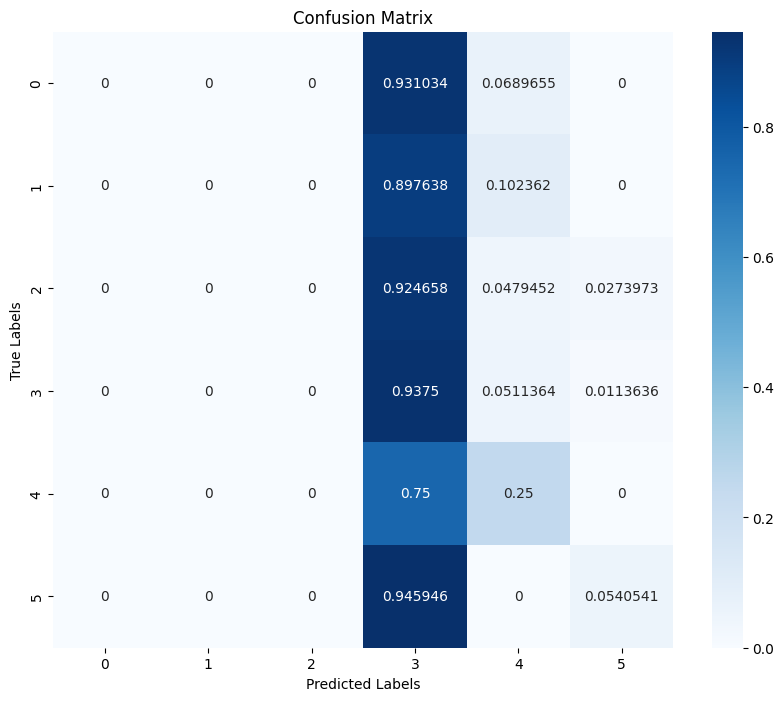

Epoch 17, Validation Loss: 1.7279, Accuracy: 0.2912, F1 Score: 0.1480
Val F1 Score Per Class  [0.         0.         0.         0.46544429 0.05       0.08888889]


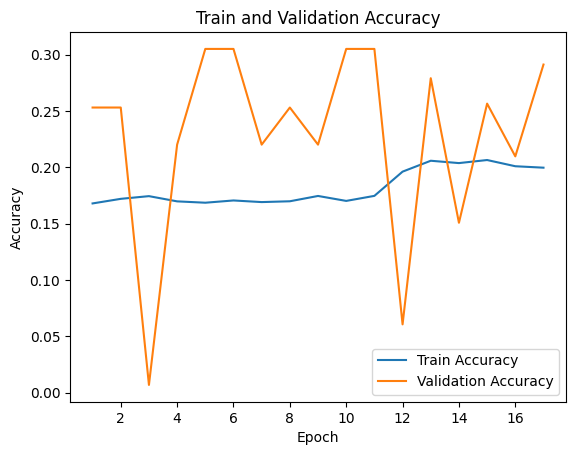

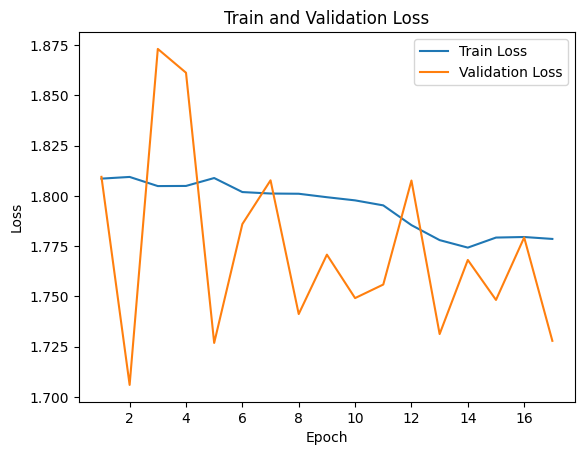

Epoch 18, Train Loss: 1.7767, Accuracy: 0.2019, F1 Score: 0.1088
Train F1 Score Per Class  [0.         0.01788109 0.01928375 0.29996313 0.30071766 0.        ]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.14it/s, loss=1.75]

[tensor([ 0.0282,  0.0266,  0.0254,  0.1137, -0.3023,  0.0042], device='cuda:0'), tensor([-0.1370, -0.0271, -0.0527,  0.0016, -0.0344, -0.0334], device='cuda:0'), tensor([-0.1745, -0.0406, -0.0664, -0.0292,  0.1442, -0.0407], device='cuda:0'), tensor([-0.0348,  0.0055,  0.0004,  0.0701, -0.2100, -0.0114], device='cuda:0'), tensor([ 0.0621,  0.0420,  0.0308,  0.1317, -0.4699,  0.0185], device='cuda:0'), tensor([-0.1420, -0.0283, -0.0546, -0.0040, -0.1645, -0.0350], device='cuda:0'), tensor([ 0.1428,  0.0681,  0.0660,  0.1902, -0.6393,  0.0443], device='cuda:0'), tensor([-0.1363, -0.0318, -0.0368,  0.0069, -0.1120, -0.0528], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:34,  2.07it/s, loss=1.76]

[tensor([ 0.0529,  0.0352,  0.0385,  0.1297, -0.4529,  0.0112], device='cuda:0'), tensor([ 0.0018,  0.0163,  0.0035,  0.0913, -0.2998, -0.0086], device='cuda:0'), tensor([-0.1338, -0.0281, -0.0462,  0.0036,  0.0290, -0.0431], device='cuda:0'), tensor([ 0.0095,  0.0208,  0.0181,  0.1015, -0.4184, -0.0033], device='cuda:0'), tensor([-0.0255,  0.0095,  0.0018,  0.0799, -0.3820, -0.0132], device='cuda:0'), tensor([-0.0398,  0.0025,  0.0017,  0.0708, -0.3610, -0.0219], device='cuda:0'), tensor([ 0.0779,  0.0462,  0.0375,  0.1451, -0.6327,  0.0248], device='cuda:0'), tensor([ 0.0354,  0.0308,  0.0261,  0.1163, -0.3554,  0.0131], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:37,  1.89it/s, loss=1.74]

[tensor([ 0.1203,  0.0626,  0.0506,  0.1678, -0.6737,  0.0488], device='cuda:0'), tensor([-0.0565, -0.0026, -0.0052,  0.0577, -0.1493, -0.0240], device='cuda:0'), tensor([ 0.0771,  0.0449,  0.0440,  0.1427, -0.6112,  0.0254], device='cuda:0'), tensor([-0.1022, -0.0157, -0.0350,  0.0228, -0.4311, -0.0236], device='cuda:0'), tensor([-0.0380,  0.0063, -0.0036,  0.0625, -0.4009, -0.0123], device='cuda:0'), tensor([-0.0467,  0.0034, -0.0075,  0.0589, -0.3959, -0.0089], device='cuda:0'), tensor([ 0.0625,  0.0382,  0.0347,  0.1369, -0.4043,  0.0091], device='cuda:0'), tensor([-4.2807e-02,  1.9478e-04,  3.9290e-03,  7.1581e-02, -2.9791e-01,
        -2.5854e-02], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:02<00:43,  1.59it/s, loss=1.71]

[tensor([ 0.0932,  0.0522,  0.0410,  0.1493, -0.4595,  0.0378], device='cuda:0'), tensor([-0.0925, -0.0168, -0.0163,  0.0404, -0.2724, -0.0416], device='cuda:0'), tensor([ 0.1103,  0.0564,  0.0525,  0.1716, -0.5214,  0.0303], device='cuda:0'), tensor([ 0.0716,  0.0426,  0.0393,  0.1432, -0.5030,  0.0200], device='cuda:0'), tensor([-0.1755, -0.0427, -0.0722, -0.0218,  0.0185, -0.0575], device='cuda:0'), tensor([ 0.1269,  0.0651,  0.0519,  0.1758, -0.6853,  0.0490], device='cuda:0'), tensor([ 0.1228,  0.0625,  0.0569,  0.1695, -0.5746,  0.0445], device='cuda:0'), tensor([ 0.0196,  0.0263,  0.0169,  0.1012, -0.5753,  0.0116], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:39,  1.71it/s, loss=1.8]

[tensor([-4.7852e-02, -5.8132e-05, -3.5781e-03,  6.7249e-02, -1.5577e-01,
        -2.3183e-02], device='cuda:0'), tensor([ 0.1337,  0.0688,  0.0475,  0.1868, -0.7548,  0.0507], device='cuda:0'), tensor([-0.1676, -0.0387, -0.0601, -0.0267,  0.0559, -0.0436], device='cuda:0'), tensor([-0.0773, -0.0097, -0.0134,  0.0421, -0.1688, -0.0273], device='cuda:0'), tensor([ 0.0210,  0.0267,  0.0192,  0.1044, -0.4385,  0.0116], device='cuda:0'), tensor([-0.0946, -0.0125, -0.0318,  0.0260, -0.1466, -0.0178], device='cuda:0'), tensor([-0.1130, -0.0224, -0.0268,  0.0234, -0.1325, -0.0452], device='cuda:0'), tensor([-0.9155, -0.3047, -0.3853, -0.6818,  1.2598, -0.3094], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:03<00:36,  1.81it/s, loss=1.71]

[tensor([-0.0303,  0.0026,  0.0133,  0.0835, -0.3356, -0.0312], device='cuda:0'), tensor([ 0.1164,  0.0605,  0.0491,  0.1704, -0.5981,  0.0423], device='cuda:0'), tensor([-0.0736, -0.0063, -0.0163,  0.0419, -0.2709, -0.0206], device='cuda:0'), tensor([ 0.1298,  0.0627,  0.0622,  0.1810, -0.6730,  0.0347], device='cuda:0'), tensor([-0.0018,  0.0159,  0.0158,  0.0962, -0.4085, -0.0078], device='cuda:0'), tensor([-0.0751, -0.0093, -0.0154,  0.0454, -0.1440, -0.0290], device='cuda:0'), tensor([-0.0019,  0.0149,  0.0181,  0.0981, -0.4362, -0.0122], device='cuda:0'), tensor([ 0.0768,  0.0453,  0.0410,  0.1480, -0.6161,  0.0233], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:37,  1.76it/s, loss=1.74]

[tensor([ 0.0150,  0.0234,  0.0181,  0.1048, -0.3281,  0.0033], device='cuda:0'), tensor([ 0.0609,  0.0380,  0.0346,  0.1315, -0.4179,  0.0089], device='cuda:0'), tensor([-0.1274, -0.0265, -0.0378,  0.0061, -0.0504, -0.0377], device='cuda:0'), tensor([-0.2329, -0.0610, -0.0946, -0.0626,  0.1256, -0.0671], device='cuda:0'), tensor([-0.0318,  0.0056,  0.0051,  0.0755, -0.3297, -0.0177], device='cuda:0'), tensor([-0.1011, -0.0173, -0.0297,  0.0240, -0.2513, -0.0288], device='cuda:0'), tensor([ 0.1173,  0.0615,  0.0477,  0.1737, -0.6761,  0.0419], device='cuda:0'), tensor([-0.0478, -0.0003, -0.0010,  0.0666, -0.2487, -0.0272], device='cuda:0')]


Val:  11%|█         | 8/73 [00:04<00:35,  1.82it/s, loss=1.71]

[tensor([-0.0117,  0.0137,  0.0105,  0.0856, -0.3272, -0.0060], device='cuda:0'), tensor([-0.2165, -0.0567, -0.0789, -0.0474,  0.1378, -0.0716], device='cuda:0'), tensor([-0.0041,  0.0209, -0.0010,  0.0802, -0.2894,  0.0177], device='cuda:0'), tensor([ 0.0680,  0.0409,  0.0393,  0.1427, -0.5225,  0.0129], device='cuda:0'), tensor([ 0.0629,  0.0406,  0.0355,  0.1349, -0.5495,  0.0207], device='cuda:0'), tensor([ 0.0331,  0.0283,  0.0296,  0.1174, -0.3962,  0.0042], device='cuda:0'), tensor([ 5.5512e-02,  3.4792e-02,  3.8666e-02,  1.3951e-01, -4.7841e-01,
         4.7509e-04], device='cuda:0'), tensor([-0.0227,  0.0107,  0.0026,  0.0766, -0.5199, -0.0067], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:33,  1.91it/s, loss=1.74]

[tensor([-0.0400,  0.0046, -0.0011,  0.0636, -0.3223, -0.0109], device='cuda:0'), tensor([-0.0568,  0.0014, -0.0178,  0.0448, -0.1406, -0.0052], device='cuda:0'), tensor([-0.1204, -0.0244, -0.0410,  0.0119, -0.1260, -0.0390], device='cuda:0'), tensor([-0.0677, -0.0078, -0.0076,  0.0535, -0.3068, -0.0323], device='cuda:0'), tensor([ 0.0816,  0.0514,  0.0230,  0.1705, -0.4879,  0.0104], device='cuda:0'), tensor([ 0.0268,  0.0290,  0.0197,  0.1077, -0.4465,  0.0142], device='cuda:0'), tensor([-0.0661, -0.0035, -0.0190,  0.0447, -0.1038, -0.0119], device='cuda:0'), tensor([-0.1165, -0.0210, -0.0375,  0.0096, -0.0411, -0.0251], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:05<00:33,  1.87it/s, loss=1.74]

[tensor([-0.0411,  0.0004,  0.0003,  0.0689, -0.1533, -0.0289], device='cuda:0'), tensor([ 0.0334,  0.0299,  0.0243,  0.1182, -0.4156,  0.0074], device='cuda:0'), tensor([ 0.1051,  0.0539,  0.0564,  0.1628, -0.7082,  0.0319], device='cuda:0'), tensor([-0.0617, -0.0034, -0.0145,  0.0507, -0.1129, -0.0205], device='cuda:0'), tensor([-0.1554, -0.0344, -0.0555, -0.0139,  0.1127, -0.0476], device='cuda:0'), tensor([ 0.0611,  0.0407,  0.0338,  0.1292, -0.5017,  0.0248], device='cuda:0'), tensor([-0.1851, -0.0480, -0.0571, -0.0281, -0.1591, -0.0641], device='cuda:0'), tensor([ 0.0768,  0.0441,  0.0415,  0.1448, -0.4741,  0.0218], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:32,  1.88it/s, loss=1.83]

[tensor([-0.0093,  0.0154,  0.0063,  0.0912, -0.5307, -0.0034], device='cuda:0'), tensor([ 0.0226,  0.0260,  0.0199,  0.1114, -0.5751,  0.0034], device='cuda:0'), tensor([ 0.0384,  0.0311,  0.0282,  0.1166, -0.5462,  0.0105], device='cuda:0'), tensor([-0.0214,  0.0131, -0.0009,  0.0744, -0.4732, -0.0044], device='cuda:0'), tensor([-0.0316,  0.0064,  0.0038,  0.0696, -0.1898, -0.0097], device='cuda:0'), tensor([-0.1431, -0.0286, -0.0588, -0.0034, -0.0644, -0.0361], device='cuda:0'), tensor([-0.0764, -0.0089, -0.0155,  0.0404, -0.1587, -0.0236], device='cuda:0'), tensor([-0.0150,  0.0129,  0.0073,  0.0807, -0.2930, -0.0004], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:06<00:31,  1.92it/s, loss=1.72]

[tensor([-0.0945, -0.0139, -0.0305,  0.0277, -0.0409, -0.0231], device='cuda:0'), tensor([ 0.0300,  0.0295,  0.0132,  0.1167, -0.3464,  0.0125], device='cuda:0'), tensor([ 0.1026,  0.0530,  0.0533,  0.1642, -0.6752,  0.0259], device='cuda:0'), tensor([-0.1013, -0.0163, -0.0318,  0.0239,  0.0358, -0.0318], device='cuda:0'), tensor([-0.0360,  0.0076, -0.0089,  0.0666, -0.4659, -0.0013], device='cuda:0'), tensor([ 0.0503,  0.0342,  0.0342,  0.1292, -0.4445,  0.0108], device='cuda:0'), tensor([ 0.1065,  0.0558,  0.0526,  0.1609, -0.6447,  0.0372], device='cuda:0'), tensor([-0.0474,  0.0027, -0.0159,  0.0549, -0.3832, -0.0121], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:30,  1.97it/s, loss=1.74]

[tensor([-0.0213,  0.0111,  0.0028,  0.0801, -0.3955, -0.0059], device='cuda:0'), tensor([ 1.7582e-02,  2.4128e-02,  2.0742e-02,  1.0563e-01, -4.8441e-01,
        -2.8135e-04], device='cuda:0'), tensor([-0.0550,  0.0011, -0.0157,  0.0512, -0.2095, -0.0037], device='cuda:0'), tensor([-0.2347, -0.0605, -0.0971, -0.0756,  0.1994, -0.0546], device='cuda:0'), tensor([-0.0322,  0.0066, -0.0043,  0.0700, -0.2480, -0.0192], device='cuda:0'), tensor([ 0.0605,  0.0403,  0.0332,  0.1307, -0.5040,  0.0210], device='cuda:0'), tensor([-0.1455, -0.0302, -0.0568, -0.0084, -0.0416, -0.0354], device='cuda:0'), tensor([-0.0448,  0.0044, -0.0093,  0.0585, -0.2504, -0.0058], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:07<00:29,  1.99it/s, loss=1.73]

[tensor([-0.0470,  0.0028, -0.0096,  0.0575, -0.0891, -0.0081], device='cuda:0'), tensor([ 0.0124,  0.0206,  0.0233,  0.1061, -0.3521, -0.0054], device='cuda:0'), tensor([-0.0488,  0.0011, -0.0036,  0.0598, -0.1547, -0.0188], device='cuda:0'), tensor([ 0.0564,  0.0392,  0.0314,  0.1280, -0.4613,  0.0228], device='cuda:0'), tensor([-0.0620, -0.0049, -0.0061,  0.0518, -0.1560, -0.0256], device='cuda:0'), tensor([-0.0215,  0.0086,  0.0113,  0.0816, -0.1485, -0.0144], device='cuda:0'), tensor([-0.0581, -0.0005, -0.0144,  0.0490, -0.1642, -0.0157], device='cuda:0'), tensor([-0.0235,  0.0068,  0.0090,  0.0856, -0.3984, -0.0234], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:29,  1.93it/s, loss=1.76]

[tensor([ 0.0249,  0.0250,  0.0243,  0.1160, -0.3588, -0.0029], device='cuda:0'), tensor([-0.0260,  0.0074,  0.0058,  0.0797, -0.3324, -0.0131], device='cuda:0'), tensor([-0.0261,  0.0073,  0.0069,  0.0791, -0.2795, -0.0166], device='cuda:0'), tensor([-0.0409,  0.0026,  0.0019,  0.0687, -0.4474, -0.0187], device='cuda:0'), tensor([ 0.0400,  0.0308,  0.0248,  0.1256, -0.4523,  0.0017], device='cuda:0'), tensor([-0.0713, -0.0078, -0.0181,  0.0469, -0.3066, -0.0251], device='cuda:0'), tensor([ 0.0072,  0.0188,  0.0190,  0.1027, -0.2749, -0.0068], device='cuda:0'), tensor([-0.1005, -0.0158, -0.0313,  0.0239, -0.0037, -0.0258], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:08<00:30,  1.86it/s, loss=1.75]

[tensor([-0.0970, -0.0152, -0.0250,  0.0257, -0.4137, -0.0264], device='cuda:0'), tensor([-0.0288,  0.0071,  0.0050,  0.0737, -0.1064, -0.0140], device='cuda:0'), tensor([-0.0664, -0.0028, -0.0191,  0.0429, -0.3601, -0.0063], device='cuda:0'), tensor([-0.1301, -0.0198, -0.1070, -0.0004,  0.1733, -0.0199], device='cuda:0'), tensor([-0.0185,  0.0109,  0.0089,  0.0832, -0.2625, -0.0086], device='cuda:0'), tensor([-0.0306,  0.0054,  0.0043,  0.0808, -0.3865, -0.0182], device='cuda:0'), tensor([ 0.0023,  0.0186,  0.0150,  0.0960, -0.2915, -0.0046], device='cuda:0'), tensor([-0.0853, -0.0104, -0.0261,  0.0342, -0.4013, -0.0187], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:09<00:29,  1.90it/s, loss=1.79]

[tensor([-0.1837, -0.0460, -0.0593, -0.0295,  0.1304, -0.0594], device='cuda:0'), tensor([-0.0476,  0.0014, -0.0069,  0.0641, -0.3960, -0.0176], device='cuda:0'), tensor([ 0.0713,  0.0444,  0.0379,  0.1394, -0.6445,  0.0261], device='cuda:0'), tensor([-0.1159, -0.0177, -0.0489,  0.0084,  0.0613, -0.0184], device='cuda:0'), tensor([ 0.0102,  0.0206,  0.0230,  0.0981, -0.3485, -0.0010], device='cuda:0'), tensor([-0.0467,  0.0006, -0.0043,  0.0688, -0.2873, -0.0254], device='cuda:0'), tensor([-0.3670, -0.1129, -0.1927, -0.0559,  0.0506, -0.1741], device='cuda:0'), tensor([-0.0474,  0.0041, -0.0144,  0.0544, -0.3657,  0.0023], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:09<00:31,  1.77it/s, loss=1.77]

[tensor([-0.1344, -0.0275, -0.0451, -0.0024,  0.1989, -0.0341], device='cuda:0'), tensor([ 0.0845,  0.0518,  0.0342,  0.1398, -0.5115,  0.0387], device='cuda:0'), tensor([-0.2215, -0.0601, -0.0750, -0.0522,  0.2672, -0.0742], device='cuda:0'), tensor([-0.0204,  0.0115,  0.0052,  0.0783, -0.2918, -0.0067], device='cuda:0'), tensor([-0.0177,  0.0101,  0.0113,  0.0820, -0.2279, -0.0123], device='cuda:0'), tensor([ 0.0178,  0.0222,  0.0238,  0.1092, -0.3427, -0.0055], device='cuda:0'), tensor([-0.0593, -0.0005, -0.0191,  0.0532, -0.1871, -0.0133], device='cuda:0'), tensor([-0.1345, -0.0246, -0.0650, -0.0053,  0.1297, -0.0333], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:10<00:28,  1.86it/s, loss=1.77]

[tensor([-0.0450,  0.0053, -0.0135,  0.0574, -0.3931, -0.0007], device='cuda:0'), tensor([-0.1791, -0.0418, -0.0683, -0.0275,  0.1450, -0.0511], device='cuda:0'), tensor([-0.0695, -0.0056, -0.0254,  0.0428, -0.1858, -0.0160], device='cuda:0'), tensor([ 0.0041,  0.0216,  0.0094,  0.0932, -0.3463,  0.0029], device='cuda:0'), tensor([-0.1058, -0.0170, -0.0362,  0.0205, -0.2312, -0.0241], device='cuda:0'), tensor([-0.0875, -0.0139, -0.0160,  0.0372, -0.1880, -0.0331], device='cuda:0'), tensor([-0.2234, -0.0635, -0.0697, -0.0521,  0.2518, -0.0793], device='cuda:0'), tensor([-0.0436,  0.0047, -0.0217,  0.0559, -0.0956, -0.0118], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:10<00:29,  1.82it/s, loss=1.73]

[tensor([-0.0866, -0.0127, -0.0485,  0.0355, -0.1966, -0.0293], device='cuda:0'), tensor([-0.0764, -0.0074, -0.0248,  0.0369, -0.0603, -0.0138], device='cuda:0'), tensor([-0.0526, -0.0014, -0.0061,  0.0662, -0.5114, -0.0242], device='cuda:0'), tensor([-0.1105, -0.0190, -0.0389,  0.0181, -0.4525, -0.0287], device='cuda:0'), tensor([ 0.1220,  0.0606,  0.0589,  0.1744, -0.6030,  0.0367], device='cuda:0'), tensor([ 0.0302,  0.0271,  0.0265,  0.1170, -0.4614,  0.0011], device='cuda:0'), tensor([ 0.0187,  0.0241,  0.0211,  0.1078, -0.3651,  0.0020], device='cuda:0'), tensor([-0.0117,  0.0120,  0.0151,  0.0906, -0.3672, -0.0153], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:11<00:27,  1.90it/s, loss=1.78]

[tensor([-0.0746, -0.0043, -0.0288,  0.0345, -0.2365, -0.0246], device='cuda:0'), tensor([-0.1753, -0.0413, -0.0648, -0.0310,  0.2656, -0.0428], device='cuda:0'), tensor([ 0.0583,  0.0390,  0.0340,  0.1268, -0.5887,  0.0207], device='cuda:0'), tensor([-0.1538, -0.0327, -0.0572, -0.0155, -0.0399, -0.0369], device='cuda:0'), tensor([ 0.0584,  0.0399,  0.0316,  0.1295, -0.5387,  0.0234], device='cuda:0'), tensor([-0.1513, -0.0338, -0.0560, -0.0092, -0.0180, -0.0421], device='cuda:0'), tensor([-0.1740, -0.0379, -0.0773, -0.0303,  0.1639, -0.0331], device='cuda:0'), tensor([-0.0062,  0.0208, -0.0055,  0.0781, -0.2216,  0.0170], device='cuda:0')]


Val:  30%|███       | 22/73 [00:11<00:27,  1.86it/s, loss=1.79]

[tensor([-0.0670, -0.0062, -0.0094,  0.0508, -0.1164, -0.0280], device='cuda:0'), tensor([-0.0557, -0.0002, -0.0164,  0.0569, -0.0262, -0.0232], device='cuda:0'), tensor([-0.0734, -0.0072, -0.0155,  0.0428, -0.2031, -0.0188], device='cuda:0'), tensor([ 0.1097,  0.0561,  0.0526,  0.1714, -0.6425,  0.0287], device='cuda:0'), tensor([-0.2294, -0.0612, -0.0872, -0.0578,  0.2092, -0.0704], device='cuda:0'), tensor([-0.1063, -0.0196, -0.0269,  0.0220, -0.1957, -0.0321], device='cuda:0'), tensor([-0.1616, -0.0383, -0.0531, -0.0116,  0.0556, -0.0529], device='cuda:0'), tensor([-0.1475, -0.0330, -0.0476, -0.0064,  0.0106, -0.0442], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:12<00:27,  1.84it/s, loss=1.72]

[tensor([ 0.1148,  0.0570,  0.0607,  0.1703, -0.5572,  0.0314], device='cuda:0'), tensor([-0.0193,  0.0118,  0.0052,  0.0789, -0.3176, -0.0026], device='cuda:0'), tensor([ 0.1698,  0.0812,  0.0658,  0.1997, -0.8031,  0.0683], device='cuda:0'), tensor([ 0.0545,  0.0388,  0.0284,  0.1270, -0.6158,  0.0293], device='cuda:0'), tensor([ 0.0097,  0.0220,  0.0151,  0.0997, -0.4322,  0.0027], device='cuda:0'), tensor([ 0.0461,  0.0333,  0.0325,  0.1250, -0.3590,  0.0101], device='cuda:0'), tensor([ 0.0317,  0.0294,  0.0251,  0.1136, -0.4525,  0.0096], device='cuda:0'), tensor([-0.0978, -0.0139, -0.0321,  0.0230,  0.0666, -0.0330], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:12<00:25,  1.92it/s, loss=1.76]

[tensor([-0.1116, -0.0225, -0.0253,  0.0172, -0.1479, -0.0375], device='cuda:0'), tensor([ 0.1135,  0.0596,  0.0524,  0.1637, -0.5904,  0.0442], device='cuda:0'), tensor([ 0.1396,  0.0705,  0.0549,  0.1797, -0.6816,  0.0570], device='cuda:0'), tensor([-0.0573, -0.0014, -0.0099,  0.0515, -0.3922, -0.0118], device='cuda:0'), tensor([-0.0222,  0.0074,  0.0118,  0.0833, -0.2953, -0.0172], device='cuda:0'), tensor([-0.0157,  0.0108,  0.0021,  0.0858, -0.3727, -0.0142], device='cuda:0'), tensor([-0.1776, -0.0417, -0.0676, -0.0255, -0.0100, -0.0530], device='cuda:0'), tensor([-0.2083, -0.0506, -0.0902, -0.0473,  0.2620, -0.0570], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:13<00:26,  1.84it/s, loss=1.72]

[tensor([-0.3208, -0.0752, -0.1977, -0.1455,  0.1632, -0.0446], device='cuda:0'), tensor([-0.0932, -0.0164, -0.0203,  0.0357, -0.1158, -0.0392], device='cuda:0'), tensor([ 0.0540,  0.0416,  0.0169,  0.1139, -0.6071,  0.0253], device='cuda:0'), tensor([-0.0730, -0.0083, -0.0123,  0.0476, -0.2097, -0.0285], device='cuda:0'), tensor([ 0.0011,  0.0192,  0.0104,  0.0932, -0.4931,  0.0052], device='cuda:0'), tensor([ 0.0593,  0.0394,  0.0342,  0.1313, -0.4675,  0.0191], device='cuda:0'), tensor([-0.1250, -0.0207, -0.0524,  0.0040, -0.1041, -0.0236], device='cuda:0'), tensor([-0.0935, -0.0123, -0.0339,  0.0195, -0.0063, -0.0071], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:14<00:26,  1.80it/s, loss=1.71]

[tensor([ 0.0096,  0.0231,  0.0118,  0.0983, -0.5080,  0.0061], device='cuda:0'), tensor([ 0.0183,  0.0241,  0.0215,  0.1059, -0.5140, -0.0005], device='cuda:0'), tensor([ 0.1242,  0.0623,  0.0570,  0.1785, -0.5890,  0.0373], device='cuda:0'), tensor([-0.0851, -0.0079, -0.0418,  0.0274, -0.1054, -0.0162], device='cuda:0'), tensor([ 0.0558,  0.0390,  0.0313,  0.1253, -0.4094,  0.0251], device='cuda:0'), tensor([ 0.0103,  0.0200,  0.0224,  0.1049, -0.5830, -0.0078], device='cuda:0'), tensor([-0.0087,  0.0151,  0.0115,  0.0859, -0.1965, -0.0099], device='cuda:0'), tensor([-0.1523, -0.0351, -0.0481, -0.0139, -0.0611, -0.0407], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:14<00:24,  1.87it/s, loss=1.74]

[tensor([ 0.0560,  0.0361,  0.0381,  0.1349, -0.5511,  0.0086], device='cuda:0'), tensor([-0.0430,  0.0059, -0.0109,  0.0586, -0.1370,  0.0017], device='cuda:0'), tensor([-0.0342,  0.0066, -0.0019,  0.0716, -0.4021, -0.0122], device='cuda:0'), tensor([ 0.1314,  0.0684,  0.0428,  0.2047, -0.5283,  0.0229], device='cuda:0'), tensor([ 0.0445,  0.0339,  0.0301,  0.1195, -0.3443,  0.0133], device='cuda:0'), tensor([-0.0674, -0.0056, -0.0093,  0.0439, -0.0503, -0.0235], device='cuda:0'), tensor([-0.0595, -0.0043, -0.0056,  0.0570, -0.2661, -0.0260], device='cuda:0'), tensor([-5.5288e-02,  9.1802e-05, -1.3749e-02,  5.2129e-02, -1.2853e-01,
        -1.4570e-02], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:15<00:23,  1.92it/s, loss=1.74]

[tensor([-0.0139,  0.0124,  0.0121,  0.0810, -0.2999, -0.0042], device='cuda:0'), tensor([ 0.1461,  0.0731,  0.0538,  0.1871, -0.7442,  0.0620], device='cuda:0'), tensor([-0.0715, -0.0082, -0.0114,  0.0473, -0.1245, -0.0266], device='cuda:0'), tensor([ 0.0042,  0.0183,  0.0132,  0.1039, -0.4074, -0.0105], device='cuda:0'), tensor([-0.0068,  0.0155, -0.0033,  0.0830, -0.2179, -0.0014], device='cuda:0'), tensor([-0.0868, -0.0144, -0.0149,  0.0428, -0.1608, -0.0376], device='cuda:0'), tensor([-0.0717, -0.0052, -0.0186,  0.0387, -0.1700, -0.0164], device='cuda:0'), tensor([-0.0072,  0.0135,  0.0126,  0.0907, -0.2891, -0.0118], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:15<00:22,  1.97it/s, loss=1.75]

[tensor([ 0.0055,  0.0180,  0.0169,  0.0984, -0.2590, -0.0104], device='cuda:0'), tensor([ 0.0331,  0.0290,  0.0263,  0.1173, -0.5220,  0.0051], device='cuda:0'), tensor([-0.1389, -0.0288, -0.0468, -0.0047,  0.1447, -0.0346], device='cuda:0'), tensor([ 0.0950,  0.0548,  0.0363,  0.1533, -0.5788,  0.0355], device='cuda:0'), tensor([-0.0224,  0.0104,  0.0047,  0.0728, -0.2607, -0.0072], device='cuda:0'), tensor([ 0.0614,  0.0385,  0.0411,  0.1327, -0.4416,  0.0174], device='cuda:0'), tensor([-0.1054, -0.0173, -0.0325,  0.0183,  0.0696, -0.0365], device='cuda:0'), tensor([ 0.0446,  0.0343,  0.0308,  0.1181, -0.5096,  0.0184], device='cuda:0')]


Val:  41%|████      | 30/73 [00:15<00:21,  2.01it/s, loss=1.77]

[tensor([ 0.0569,  0.0402,  0.0314,  0.1243, -0.4401,  0.0198], device='cuda:0'), tensor([-0.1127, -0.0185, -0.0401,  0.0102,  0.0509, -0.0240], device='cuda:0'), tensor([ 0.0848,  0.0475,  0.0434,  0.1544, -0.5030,  0.0215], device='cuda:0'), tensor([-0.1381, -0.0322, -0.0333,  0.0052, -0.0534, -0.0537], device='cuda:0'), tensor([ 0.0816,  0.0487,  0.0341,  0.1454, -0.5772,  0.0289], device='cuda:0'), tensor([ 0.0308,  0.0303,  0.0174,  0.1096, -0.3838,  0.0132], device='cuda:0'), tensor([-0.1122, -0.0190, -0.0411,  0.0175, -0.0036, -0.0295], device='cuda:0'), tensor([-0.1766, -0.0398, -0.0705, -0.0309,  0.0489, -0.0422], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:16<00:22,  1.90it/s, loss=1.73]

[tensor([ 0.0631,  0.0381,  0.0422,  0.1400, -0.5080,  0.0100], device='cuda:0'), tensor([ 0.1132,  0.0581,  0.0535,  0.1701, -0.6229,  0.0325], device='cuda:0'), tensor([-0.0180,  0.0123,  0.0024,  0.0833, -0.3409, -0.0042], device='cuda:0'), tensor([-0.0510,  0.0002, -0.0043,  0.0588, -0.1588, -0.0209], device='cuda:0'), tensor([ 0.0620,  0.0395,  0.0383,  0.1340, -0.4935,  0.0164], device='cuda:0'), tensor([-0.0842, -0.0102, -0.0235,  0.0340, -0.2213, -0.0219], device='cuda:0'), tensor([ 0.0472,  0.0359,  0.0243,  0.1249, -0.3767,  0.0048], device='cuda:0'), tensor([ 0.0270,  0.0248,  0.0234,  0.1156, -0.3991, -0.0068], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:17<00:20,  1.98it/s, loss=1.73]

[tensor([-0.0215,  0.0093,  0.0076,  0.0840, -0.4401, -0.0144], device='cuda:0'), tensor([-0.0279,  0.0083,  0.0038,  0.0762, -0.5612, -0.0105], device='cuda:0'), tensor([-1.7841e-04,  1.7187e-02,  1.6277e-02,  9.2478e-02, -3.9180e-01,
        -1.4485e-03], device='cuda:0'), tensor([-0.1159, -0.0244, -0.0261,  0.0225, -0.0008, -0.0494], device='cuda:0'), tensor([ 0.0248,  0.0272,  0.0217,  0.1073, -0.3582,  0.0114], device='cuda:0'), tensor([ 0.1943,  0.0903,  0.0686,  0.2270, -0.8871,  0.0421], device='cuda:0'), tensor([-0.0343,  0.0036,  0.0071,  0.0757, -0.1383, -0.0227], device='cuda:0'), tensor([ 0.0712,  0.0412,  0.0436,  0.1459, -0.5654,  0.0119], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:17<00:19,  2.10it/s, loss=1.72]

[tensor([-0.0768, -0.0089, -0.0168,  0.0461, -0.1834, -0.0283], device='cuda:0'), tensor([ 0.1156,  0.0595,  0.0532,  0.1682, -0.5415,  0.0399], device='cuda:0'), tensor([ 0.1203,  0.0598,  0.0585,  0.1770, -0.6615,  0.0352], device='cuda:0'), tensor([ 0.0951,  0.0520,  0.0464,  0.1565, -0.7215,  0.0319], device='cuda:0'), tensor([-0.1070, -0.0194, -0.0549,  0.0173,  0.0973, -0.0409], device='cuda:0'), tensor([ 0.0477,  0.0349,  0.0254,  0.1238, -0.4825,  0.0148], device='cuda:0'), tensor([-4.7851e-02,  4.9842e-05, -4.4202e-03,  6.0466e-02, -3.4653e-01,
        -1.9602e-02], device='cuda:0'), tensor([-0.0492,  0.0006, -0.0058,  0.0603, -0.1014, -0.0193], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:17<00:19,  2.03it/s, loss=1.71]

[tensor([ 0.0434,  0.0318,  0.0314,  0.1272, -0.4979,  0.0029], device='cuda:0'), tensor([ 0.0953,  0.0531,  0.0444,  0.1536, -0.5259,  0.0370], device='cuda:0'), tensor([ 0.0455,  0.0334,  0.0313,  0.1261, -0.4821,  0.0082], device='cuda:0'), tensor([-0.0408,  0.0030,  0.0009,  0.0707, -0.3350, -0.0222], device='cuda:0'), tensor([-0.1511, -0.0336, -0.0494, -0.0099, -0.4436, -0.0445], device='cuda:0'), tensor([ 0.0360,  0.0287,  0.0310,  0.1229, -0.4958, -0.0010], device='cuda:0'), tensor([-0.0826, -0.0082, -0.0269,  0.0317, -0.1121, -0.0188], device='cuda:0'), tensor([-0.0075,  0.0168,  0.0041,  0.0846, -0.5567,  0.0044], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:18<00:18,  2.06it/s, loss=1.72]

[tensor([-0.3383, -0.1044, -0.1768, -0.0696, -0.1633, -0.1768], device='cuda:0'), tensor([ 0.1370,  0.0690,  0.0578,  0.1769, -0.7049,  0.0584], device='cuda:0'), tensor([ 0.0237,  0.0256,  0.0225,  0.1100, -0.3729,  0.0072], device='cuda:0'), tensor([ 0.0829,  0.0452,  0.0398,  0.1523, -0.6935,  0.0145], device='cuda:0'), tensor([-0.1090, -0.0126, -0.0664,  0.0112,  0.0014, -0.0086], device='cuda:0'), tensor([ 0.0972,  0.0524,  0.0475,  0.1554, -0.5882,  0.0323], device='cuda:0'), tensor([-0.0090,  0.0139,  0.0094,  0.0937, -0.3820, -0.0123], device='cuda:0'), tensor([ 0.1175,  0.0583,  0.0586,  0.1765, -0.5733,  0.0312], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:18<00:17,  2.16it/s, loss=1.73]

[tensor([ 0.0238,  0.0264,  0.0195,  0.1082, -0.3184,  0.0056], device='cuda:0'), tensor([-3.2055e-02,  8.7921e-03, -8.1032e-03,  6.9797e-02, -5.7048e-01,
        -1.3073e-04], device='cuda:0'), tensor([-0.0657, -0.0063, -0.0064,  0.0500, -0.2192, -0.0259], device='cuda:0'), tensor([-3.2466e-04,  1.6738e-02,  1.6381e-02,  9.7197e-02, -5.6336e-01,
        -8.8643e-03], device='cuda:0'), tensor([-0.0686, -0.0065, -0.0127,  0.0537, -0.1982, -0.0290], device='cuda:0'), tensor([-0.1599, -0.0379, -0.0507, -0.0111, -0.0906, -0.0521], device='cuda:0'), tensor([ 0.0183,  0.0250,  0.0202,  0.1049, -0.3868,  0.0043], device='cuda:0'), tensor([ 0.0408,  0.0323,  0.0286,  0.1214, -0.3534,  0.0118], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:19<00:16,  2.20it/s, loss=1.74]

[tensor([-0.0319,  0.0073, -0.0011,  0.0741, -0.5004, -0.0095], device='cuda:0'), tensor([ 0.0568,  0.0396,  0.0309,  0.1257, -0.4947,  0.0273], device='cuda:0'), tensor([ 0.1488,  0.0705,  0.0678,  0.1944, -0.7025,  0.0491], device='cuda:0'), tensor([-0.0799, -0.0103, -0.0169,  0.0409, -0.1336, -0.0279], device='cuda:0'), tensor([-0.0331,  0.0058,  0.0034,  0.0739, -0.2993, -0.0170], device='cuda:0'), tensor([-0.0689, -0.0065, -0.0126,  0.0496, -0.2702, -0.0262], device='cuda:0'), tensor([-0.1092, -0.0198, -0.0301,  0.0183,  0.0961, -0.0304], device='cuda:0'), tensor([-0.0934, -0.0155, -0.0253,  0.0285, -0.1174, -0.0314], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:19<00:15,  2.26it/s, loss=1.76]

[tensor([-0.1607, -0.0391, -0.0494, -0.0106,  0.0791, -0.0576], device='cuda:0'), tensor([-0.0526,  0.0013, -0.0104,  0.0561, -0.1675, -0.0109], device='cuda:0'), tensor([ 0.0337,  0.0284,  0.0298,  0.1179, -0.4264,  0.0037], device='cuda:0'), tensor([-0.0427,  0.0050, -0.0122,  0.0592, -0.1616, -0.0040], device='cuda:0'), tensor([ 0.0092,  0.0216,  0.0171,  0.0974, -0.5077,  0.0038], device='cuda:0'), tensor([ 0.0086,  0.0198,  0.0198,  0.1015, -0.2480, -0.0054], device='cuda:0'), tensor([ 0.0005,  0.0184,  0.0131,  0.0933, -0.3745, -0.0014], device='cuda:0'), tensor([-0.8096, -0.2659, -0.3675, -0.6149,  0.3062, -0.2577], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:20<00:14,  2.30it/s, loss=1.73]

[tensor([ 0.0842,  0.0525,  0.0299,  0.1404, -0.5145,  0.0466], device='cuda:0'), tensor([-0.0039,  0.0171,  0.0034,  0.0853, -0.3143, -0.0050], device='cuda:0'), tensor([-0.1298, -0.0294, -0.0370,  0.0034,  0.0095, -0.0473], device='cuda:0'), tensor([ 0.0932,  0.0522,  0.0467,  0.1504, -0.4940,  0.0351], device='cuda:0'), tensor([-0.0699, -0.0057, -0.0255,  0.0410, -0.2087, -0.0142], device='cuda:0'), tensor([ 0.1172,  0.0627,  0.0385,  0.1655, -0.6214,  0.0502], device='cuda:0'), tensor([ 0.0883,  0.0477,  0.0476,  0.1563, -0.4722,  0.0191], device='cuda:0'), tensor([ 0.1053,  0.0549,  0.0463,  0.1600, -0.5778,  0.0321], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:20<00:14,  2.31it/s, loss=1.78]

[tensor([-0.0655, -0.0061, -0.0095,  0.0510, -0.1308, -0.0244], device='cuda:0'), tensor([ 0.0768,  0.0442,  0.0322,  0.1416, -0.5202,  0.0170], device='cuda:0'), tensor([-0.0935, -0.0153, -0.0288,  0.0302, -0.0830, -0.0284], device='cuda:0'), tensor([ 0.1440,  0.0696,  0.0575,  0.1863, -0.7385,  0.0498], device='cuda:0'), tensor([-0.0386,  0.0049, -0.0030,  0.0640, -0.0798, -0.0107], device='cuda:0'), tensor([-0.1578, -0.0366, -0.0571, -0.0148,  0.0971, -0.0451], device='cuda:0'), tensor([-0.1139, -0.0200, -0.0424,  0.0152, -0.0561, -0.0290], device='cuda:0'), tensor([-0.0509,  0.0010, -0.0078,  0.0571, -0.2344, -0.0117], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:20<00:13,  2.34it/s, loss=1.75]

[tensor([ 0.0096,  0.0204,  0.0191,  0.1020, -0.4265, -0.0010], device='cuda:0'), tensor([-0.1661, -0.0384, -0.0579, -0.0204, -0.0785, -0.0436], device='cuda:0'), tensor([-0.2435, -0.0647, -0.0980, -0.0687,  0.1534, -0.0724], device='cuda:0'), tensor([ 0.0279,  0.0291,  0.0222,  0.1081, -0.5156,  0.0135], device='cuda:0'), tensor([ 0.0132,  0.0210,  0.0217,  0.1073, -0.3879, -0.0039], device='cuda:0'), tensor([ 0.0499,  0.0364,  0.0292,  0.1258, -0.4556,  0.0178], device='cuda:0'), tensor([-0.0890, -0.0159, -0.0139,  0.0375, -0.0711, -0.0387], device='cuda:0'), tensor([-0.0932, -0.0153, -0.0185,  0.0297, -0.1411, -0.0306], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:21<00:13,  2.34it/s, loss=1.79]

[tensor([ 0.0380,  0.0354,  0.0173,  0.1109, -0.4074,  0.0256], device='cuda:0'), tensor([ 0.0330,  0.0300,  0.0261,  0.1158, -0.4737,  0.0011], device='cuda:0'), tensor([-0.0762, -0.0083, -0.0283,  0.0402, -0.0353, -0.0211], device='cuda:0'), tensor([ 0.1638,  0.0766,  0.0704,  0.2018, -0.6701,  0.0522], device='cuda:0'), tensor([-0.1570, -0.0370, -0.0526, -0.0198,  0.0560, -0.0347], device='cuda:0'), tensor([-1.0091, -0.3277, -0.4762, -0.4259,  1.5060, -0.4367], device='cuda:0'), tensor([-0.0694, -0.0063, -0.0187,  0.0470, -0.2034, -0.0233], device='cuda:0'), tensor([ 0.1296,  0.0665,  0.0564,  0.1718, -0.7013,  0.0560], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:21<00:13,  2.24it/s, loss=1.73]

[tensor([ 0.0931,  0.0500,  0.0418,  0.1564, -0.4584,  0.0235], device='cuda:0'), tensor([-0.0974, -0.0123, -0.0438,  0.0208,  0.0538, -0.0279], device='cuda:0'), tensor([-0.0496, -0.0013, -0.0035,  0.0600, -0.3671, -0.0237], device='cuda:0'), tensor([-0.0122,  0.0124,  0.0118,  0.0874, -0.2619, -0.0107], device='cuda:0'), tensor([-0.0590, -0.0015, -0.0108,  0.0516, -0.0709, -0.0199], device='cuda:0'), tensor([-0.0092,  0.0134,  0.0076,  0.0830, -0.1794, -0.0116], device='cuda:0'), tensor([-0.1330, -0.0281, -0.0405,  0.0048, -0.0682, -0.0395], device='cuda:0'), tensor([-0.0775, -0.0088, -0.0180,  0.0446, -0.2834, -0.0253], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:22<00:13,  2.17it/s, loss=1.75]

[tensor([-0.1017, -0.0170, -0.0373,  0.0238, -0.2055, -0.0288], device='cuda:0'), tensor([-5.3561e-02,  2.4275e-04, -9.2153e-03,  5.3262e-02, -4.0382e-01,
        -1.1465e-02], device='cuda:0'), tensor([-0.0957, -0.0150, -0.0274,  0.0311, -0.3892, -0.0288], device='cuda:0'), tensor([-0.1493, -0.0352, -0.0410, -0.0007,  0.1034, -0.0572], device='cuda:0'), tensor([-0.1073, -0.0202, -0.0400,  0.0157,  0.0873, -0.0339], device='cuda:0'), tensor([-0.0828, -0.0075, -0.0302,  0.0288, -0.0587, -0.0146], device='cuda:0'), tensor([ 0.0084,  0.0236,  0.0076,  0.0959, -0.3659, -0.0121], device='cuda:0'), tensor([ 0.1099,  0.0579,  0.0511,  0.1620, -0.6691,  0.0408], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:22<00:12,  2.24it/s, loss=1.72]

[tensor([-0.0354,  0.0044,  0.0025,  0.0728, -0.1623, -0.0210], device='cuda:0'), tensor([ 0.0188,  0.0258,  0.0168,  0.1043, -0.5434,  0.0099], device='cuda:0'), tensor([ 0.1013,  0.0518,  0.0537,  0.1600, -0.5576,  0.0228], device='cuda:0'), tensor([-0.1434, -0.0261, -0.0689, -0.0046,  0.1088, -0.0392], device='cuda:0'), tensor([-0.1012, -0.0168, -0.0292,  0.0216, -0.0095, -0.0260], device='cuda:0'), tensor([ 0.0431,  0.0343,  0.0267,  0.1184, -0.4226,  0.0167], device='cuda:0'), tensor([ 0.0650,  0.0382,  0.0442,  0.1410, -0.4919,  0.0070], device='cuda:0'), tensor([-0.0836, -0.0122, -0.0159,  0.0390, -0.0798, -0.0323], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:23<00:11,  2.25it/s, loss=1.75]

[tensor([-0.0669,  0.0009, -0.0353,  0.0369, -0.1175, -0.0094], device='cuda:0'), tensor([ 0.0120,  0.0214,  0.0155,  0.1016, -0.2730, -0.0063], device='cuda:0'), tensor([ 0.1142,  0.0604,  0.0528,  0.1619, -0.6194,  0.0480], device='cuda:0'), tensor([ 0.0009,  0.0179,  0.0133,  0.0960, -0.2493, -0.0056], device='cuda:0'), tensor([ 0.0634,  0.0382,  0.0422,  0.1405, -0.5038,  0.0109], device='cuda:0'), tensor([-0.1696, -0.0432, -0.0491, -0.0168, -0.1613, -0.0622], device='cuda:0'), tensor([-3.0544e-02,  8.8784e-03,  1.3798e-04,  6.8563e-02, -2.5085e-01,
        -8.5871e-03], device='cuda:0'), tensor([-0.1888, -0.0485, -0.0759, -0.0324,  0.2205, -0.0615], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:23<00:11,  2.29it/s, loss=1.7]

[tensor([ 0.0298,  0.0275,  0.0278,  0.1169, -0.5725,  0.0039], device='cuda:0'), tensor([-0.0160,  0.0116,  0.0087,  0.0838, -0.2544, -0.0084], device='cuda:0'), tensor([-0.0639, -0.0053, -0.0151,  0.0547, -0.3552, -0.0272], device='cuda:0'), tensor([ 0.0305,  0.0301,  0.0241,  0.1078, -0.4797,  0.0153], device='cuda:0'), tensor([-0.0232,  0.0098,  0.0051,  0.0790, -0.2129, -0.0092], device='cuda:0'), tensor([ 0.1000,  0.0537,  0.0491,  0.1565, -0.6046,  0.0385], device='cuda:0'), tensor([-0.0281,  0.0100, -0.0016,  0.0710, -0.1804, -0.0031], device='cuda:0'), tensor([ 0.0577,  0.0353,  0.0413,  0.1407, -0.5574,  0.0023], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:24<00:10,  2.31it/s, loss=1.74]

[tensor([-0.0286,  0.0099, -0.0009,  0.0712, -0.2932, -0.0042], device='cuda:0'), tensor([ 0.0727,  0.0425,  0.0438,  0.1419, -0.5410,  0.0201], device='cuda:0'), tensor([-0.0472,  0.0098, -0.0629,  0.0507, -0.0930,  0.0142], device='cuda:0'), tensor([-0.0999, -0.0166, -0.0274,  0.0269, -0.0965, -0.0314], device='cuda:0'), tensor([ 0.0266,  0.0248,  0.0289,  0.1163, -0.3649, -0.0037], device='cuda:0'), tensor([ 0.0672,  0.0407,  0.0390,  0.1421, -0.4129,  0.0148], device='cuda:0'), tensor([ 0.0454,  0.0317,  0.0332,  0.1285, -0.3372,  0.0027], device='cuda:0'), tensor([-0.0059,  0.0168,  0.0090,  0.0878, -0.3342, -0.0008], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:24<00:10,  2.33it/s, loss=1.75]

[tensor([-0.0412,  0.0013,  0.0033,  0.0704, -0.6048, -0.0188], device='cuda:0'), tensor([ 0.0548,  0.0387,  0.0273,  0.1307, -0.4718,  0.0205], device='cuda:0'), tensor([-0.0063,  0.0142,  0.0159,  0.0922, -0.4733, -0.0109], device='cuda:0'), tensor([ 0.1034,  0.0537,  0.0463,  0.1574, -0.5575,  0.0276], device='cuda:0'), tensor([-0.0726, -0.0067, -0.0200,  0.0453, -0.2379, -0.0211], device='cuda:0'), tensor([ 0.0387,  0.0304,  0.0312,  0.1236, -0.4555,  0.0021], device='cuda:0'), tensor([-0.2010, -0.0506, -0.0764, -0.0419,  0.2226, -0.0574], device='cuda:0'), tensor([-0.1455, -0.0302, -0.0525, -0.0084,  0.0522, -0.0340], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:24<00:09,  2.35it/s, loss=1.71]

[tensor([ 0.0462,  0.0333,  0.0331,  0.1243, -0.5432,  0.0120], device='cuda:0'), tensor([-0.0670, -0.0045, -0.0150,  0.0500, -0.4329, -0.0201], device='cuda:0'), tensor([ 0.0340,  0.0299,  0.0265,  0.1187, -0.6794,  0.0088], device='cuda:0'), tensor([ 0.0366,  0.0303,  0.0295,  0.1176, -0.3216,  0.0075], device='cuda:0'), tensor([-2.2994e-02,  1.0137e-02,  2.1824e-04,  8.2301e-02, -6.4295e-01,
        -9.2205e-03], device='cuda:0'), tensor([-0.0159,  0.0115,  0.0085,  0.0806, -0.2224, -0.0076], device='cuda:0'), tensor([ 0.1329,  0.0659,  0.0562,  0.1841, -0.6291,  0.0459], device='cuda:0'), tensor([-0.0890, -0.0118, -0.0251,  0.0303, -0.1369, -0.0226], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:25<00:09,  2.34it/s, loss=1.74]

[tensor([-0.0121,  0.0133,  0.0089,  0.0834, -0.2549, -0.0065], device='cuda:0'), tensor([-0.1254, -0.0249, -0.0411,  0.0087,  0.0425, -0.0376], device='cuda:0'), tensor([ 0.0118,  0.0235,  0.0136,  0.0983, -0.4174,  0.0085], device='cuda:0'), tensor([-0.0076,  0.0164,  0.0016,  0.0890, -0.2339, -0.0020], device='cuda:0'), tensor([-0.1461, -0.0313, -0.0517, -0.0023, -0.2120, -0.0436], device='cuda:0'), tensor([ 0.0270,  0.0305,  0.0167,  0.1061, -0.4573,  0.0184], device='cuda:0'), tensor([ 0.0286,  0.0292,  0.0229,  0.1099, -0.4406,  0.0120], device='cuda:0'), tensor([-0.4650, -0.1482, -0.2294, -0.1118,  0.1076, -0.2264], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:25<00:09,  2.23it/s, loss=1.71]

[tensor([ 0.0417,  0.0336,  0.0247,  0.1225, -0.6851,  0.0148], device='cuda:0'), tensor([-0.0613, -0.0033, -0.0111,  0.0537, -0.3796, -0.0215], device='cuda:0'), tensor([ 0.0809,  0.0473,  0.0404,  0.1469, -0.4629,  0.0275], device='cuda:0'), tensor([-0.0028,  0.0150,  0.0176,  0.0955, -0.2994, -0.0104], device='cuda:0'), tensor([ 0.0710,  0.0408,  0.0455,  0.1437, -0.5722,  0.0112], device='cuda:0'), tensor([-0.0259,  0.0103,  0.0004,  0.0740, -0.3248, -0.0040], device='cuda:0'), tensor([-0.0747, -0.0047, -0.0294,  0.0375, -0.0628, -0.0180], device='cuda:0'), tensor([-0.0760, -0.0090, -0.0129,  0.0396, -0.0595, -0.0224], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:26<00:08,  2.28it/s, loss=1.77]

[tensor([-0.1444, -0.0332, -0.0417, -0.0016,  0.2041, -0.0480], device='cuda:0'), tensor([ 0.0464,  0.0341,  0.0306,  0.1248, -0.4130,  0.0131], device='cuda:0'), tensor([-0.1496, -0.0329, -0.0614, -0.0144,  0.1014, -0.0539], device='cuda:0'), tensor([-0.2106, -0.0549, -0.0791, -0.0581,  0.2670, -0.0509], device='cuda:0'), tensor([ 0.0287,  0.0272,  0.0282,  0.1099, -0.5240,  0.0075], device='cuda:0'), tensor([-0.1452, -0.0324, -0.0470, -0.0067, -0.3366, -0.0416], device='cuda:0'), tensor([-0.0072,  0.0174,  0.0027,  0.0889, -0.4357, -0.0046], device='cuda:0'), tensor([ 0.0678,  0.0405,  0.0420,  0.1403, -0.4749,  0.0159], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:26<00:08,  2.29it/s, loss=1.71]

[tensor([ 0.1006,  0.0514,  0.0535,  0.1623, -0.5361,  0.0243], device='cuda:0'), tensor([ 0.0608,  0.0389,  0.0393,  0.1322, -0.5261,  0.0185], device='cuda:0'), tensor([ 0.0143,  0.0231,  0.0178,  0.1064, -0.2823,  0.0011], device='cuda:0'), tensor([ 0.0137,  0.0225,  0.0178,  0.1058, -0.4443,  0.0006], device='cuda:0'), tensor([-0.0473, -0.0005, -0.0025,  0.0711, -0.4069, -0.0270], device='cuda:0'), tensor([-0.1009, -0.0169, -0.0286,  0.0249, -0.3956, -0.0283], device='cuda:0'), tensor([-1.3709e-01, -2.8969e-02, -5.9322e-02,  2.9564e-05,  1.5007e-01,
        -3.9476e-02], device='cuda:0'), tensor([-4.2904e-02,  1.3493e-04,  4.0065e-03,  7.1550e-02, -4.7700e-01,
        -2.7913e-02], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:27<00:07,  2.32it/s, loss=1.8]

[tensor([-0.1083, -0.0179, -0.0356,  0.0179, -0.0766, -0.0266], device='cuda:0'), tensor([-0.1164, -0.0230, -0.0321,  0.0148, -0.0137, -0.0355], device='cuda:0'), tensor([-0.0705, -0.0051, -0.0205,  0.0432, -0.1256, -0.0157], device='cuda:0'), tensor([-0.1714, -0.0418, -0.0556, -0.0221,  0.1518, -0.0527], device='cuda:0'), tensor([-0.0963, -0.0151, -0.0280,  0.0301, -0.0434, -0.0315], device='cuda:0'), tensor([-0.1303, -0.0252, -0.0451,  0.0042, -0.0502, -0.0328], device='cuda:0'), tensor([-0.3332, -0.1008, -0.1715, -0.2163,  0.1086, -0.0330], device='cuda:0'), tensor([ 0.1564,  0.0727,  0.0718,  0.1981, -0.6702,  0.0483], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:27<00:07,  2.32it/s, loss=1.75]

[tensor([ 0.1051,  0.0580,  0.0458,  0.1589, -0.5562,  0.0401], device='cuda:0'), tensor([-0.0375,  0.0063, -0.0054,  0.0677, -0.2410, -0.0071], device='cuda:0'), tensor([ 0.0731,  0.0426,  0.0413,  0.1412, -0.4101,  0.0164], device='cuda:0'), tensor([-0.0637, -0.0026, -0.0140,  0.0476, -0.3733, -0.0140], device='cuda:0'), tensor([-0.0166,  0.0121, -0.0209,  0.0671, -0.2283,  0.0014], device='cuda:0'), tensor([-1.3185e-01, -2.4302e-02, -7.7991e-02, -1.0036e-04,  2.0023e-02,
        -2.6225e-02], device='cuda:0'), tensor([-0.0392,  0.0031, -0.0010,  0.0720, -0.1807, -0.0216], device='cuda:0'), tensor([-0.0903, -0.0148, -0.0187,  0.0357, -0.2262, -0.0337], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:27<00:06,  2.34it/s, loss=1.73]

[tensor([-0.0893, -0.0129, -0.0215,  0.0318, -0.0808, -0.0281], device='cuda:0'), tensor([ 0.0964,  0.0532,  0.0446,  0.1585, -0.5603,  0.0344], device='cuda:0'), tensor([ 0.0490,  0.0332,  0.0309,  0.1303, -0.4601,  0.0052], device='cuda:0'), tensor([ 0.0623,  0.0394,  0.0387,  0.1360, -0.7203,  0.0154], device='cuda:0'), tensor([ 0.0262,  0.0304,  0.0156,  0.1050, -0.2942,  0.0114], device='cuda:0'), tensor([-2.1944e-02,  1.1372e-02,  3.0048e-04,  7.8824e-02, -4.7163e-01,
        -7.2811e-03], device='cuda:0'), tensor([-0.1749, -0.0421, -0.0628, -0.0240,  0.0103, -0.0482], device='cuda:0'), tensor([-0.1141, -0.0243, -0.0299,  0.0216,  0.0624, -0.0454], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:28<00:06,  2.28it/s, loss=1.77]

[tensor([-0.0872, -0.0094, -0.0314,  0.0266, -0.0991, -0.0168], device='cuda:0'), tensor([-0.0809, -0.0090, -0.0196,  0.0360, -0.1880, -0.0203], device='cuda:0'), tensor([ 0.0027,  0.0202,  0.0091,  0.0905, -0.3712,  0.0044], device='cuda:0'), tensor([-0.0914, -0.0097, -0.0376,  0.0255, -0.1511, -0.0098], device='cuda:0'), tensor([-0.0442,  0.0033, -0.0063,  0.0648, -0.1432, -0.0148], device='cuda:0'), tensor([-0.0632, -0.0050, -0.0088,  0.0539, -0.2345, -0.0248], device='cuda:0'), tensor([-0.0573, -0.0012, -0.0108,  0.0553, -0.1453, -0.0169], device='cuda:0'), tensor([-0.0731, -0.0073, -0.0174,  0.0438, -0.0655, -0.0234], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:28<00:06,  2.31it/s, loss=1.76]

[tensor([ 0.0509,  0.0368,  0.0273,  0.1313, -0.5454,  0.0136], device='cuda:0'), tensor([-0.0892, -0.0129, -0.0247,  0.0327, -0.1910, -0.0250], device='cuda:0'), tensor([ 0.0794,  0.0443,  0.0460,  0.1495, -0.6009,  0.0161], device='cuda:0'), tensor([-0.0683, -0.0078, -0.0261,  0.0456, -0.0969, -0.0294], device='cuda:0'), tensor([-0.2056, -0.0515, -0.0803, -0.0529,  0.1074, -0.0435], device='cuda:0'), tensor([-0.1526, -0.0326, -0.0609, -0.0147,  0.2029, -0.0357], device='cuda:0'), tensor([ 4.3666e-03,  1.9403e-02,  1.7519e-02,  9.4175e-02, -5.3175e-01,
         1.6552e-04], device='cuda:0'), tensor([ 0.1316,  0.0659,  0.0594,  0.1733, -0.5911,  0.0439], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:29<00:05,  2.32it/s, loss=1.74]

[tensor([-0.0112,  0.0141,  0.0095,  0.0874, -0.6318, -0.0077], device='cuda:0'), tensor([ 0.0912,  0.0487,  0.0485,  0.1581, -0.4630,  0.0240], device='cuda:0'), tensor([ 0.0331,  0.0322,  0.0186,  0.1073, -0.4071,  0.0141], device='cuda:0'), tensor([-0.1585, -0.0358, -0.0563, -0.0131, -0.0140, -0.0474], device='cuda:0'), tensor([-0.1233, -0.0202, -0.1170,  0.0026, -0.0319, -0.0153], device='cuda:0'), tensor([ 0.0328,  0.0284,  0.0282,  0.1193, -0.4635,  0.0014], device='cuda:0'), tensor([ 0.1069,  0.0559,  0.0531,  0.1645, -0.6122,  0.0334], device='cuda:0'), tensor([ 0.0849,  0.0505,  0.0383,  0.1457, -0.6963,  0.0316], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:29<00:05,  2.32it/s, loss=1.72]

[tensor([-0.0200,  0.0117,  0.0048,  0.0788, -0.3094, -0.0148], device='cuda:0'), tensor([ 0.0851,  0.0465,  0.0450,  0.1568, -0.7252,  0.0174], device='cuda:0'), tensor([-0.1086, -0.0209, -0.0280,  0.0234, -0.0108, -0.0395], device='cuda:0'), tensor([-0.0532, -0.0004, -0.0086,  0.0599, -0.3730, -0.0181], device='cuda:0'), tensor([-0.0033,  0.0170,  0.0125,  0.0960, -0.4361, -0.0077], device='cuda:0'), tensor([ 0.0041,  0.0196,  0.0137,  0.0956, -0.3143,  0.0030], device='cuda:0'), tensor([ 0.0841,  0.0464,  0.0470,  0.1554, -0.5124,  0.0175], device='cuda:0'), tensor([ 0.0960,  0.0530,  0.0434,  0.1599, -0.7028,  0.0319], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:30<00:04,  2.33it/s, loss=1.76]

[tensor([-0.0520,  0.0049, -0.0400,  0.0507, -0.1637,  0.0022], device='cuda:0'), tensor([ 0.0688,  0.0428,  0.0376,  0.1379, -0.6231,  0.0243], device='cuda:0'), tensor([-0.0172,  0.0101,  0.0110,  0.0867, -0.2450, -0.0162], device='cuda:0'), tensor([-0.0423,  0.0020, -0.0006,  0.0643, -0.3936, -0.0139], device='cuda:0'), tensor([-0.0458,  0.0027, -0.0072,  0.0637, -0.3126, -0.0127], device='cuda:0'), tensor([ 0.0867,  0.0482,  0.0498,  0.1488, -0.5514,  0.0269], device='cuda:0'), tensor([-0.0713, -0.0072, -0.0125,  0.0476, -0.0222, -0.0267], device='cuda:0'), tensor([ 0.0776,  0.0459,  0.0400,  0.1475, -0.5270,  0.0241], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:30<00:04,  2.33it/s, loss=1.75]

[tensor([-0.0935, -0.0176, -0.0220,  0.0339,  0.0314, -0.0393], device='cuda:0'), tensor([-0.0915, -0.0153, -0.0181,  0.0368, -0.1160, -0.0362], device='cuda:0'), tensor([ 0.0553,  0.0375,  0.0352,  0.1276, -0.4335,  0.0206], device='cuda:0'), tensor([-0.1977, -0.0480, -0.0804, -0.0502,  0.2344, -0.0431], device='cuda:0'), tensor([-0.0180,  0.0121,  0.0052,  0.0796, -0.3484, -0.0016], device='cuda:0'), tensor([-0.1057, -0.0191, -0.0290,  0.0240,  0.0050, -0.0336], device='cuda:0'), tensor([ 0.0150,  0.0235,  0.0196,  0.0993, -0.3187,  0.0075], device='cuda:0'), tensor([-0.0945, -0.0141, -0.0257,  0.0282, -0.0127, -0.0270], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:30<00:03,  2.33it/s, loss=1.75]

[tensor([-0.0993, -0.0145, -0.0378,  0.0234, -0.1650, -0.0214], device='cuda:0'), tensor([ 0.0315,  0.0282,  0.0297,  0.1153, -0.4530,  0.0024], device='cuda:0'), tensor([-0.0440,  0.0012, -0.0004,  0.0689, -0.2822, -0.0246], device='cuda:0'), tensor([ 0.1076,  0.0573,  0.0519,  0.1594, -0.5599,  0.0429], device='cuda:0'), tensor([-0.0797, -0.0112, -0.0215,  0.0446, -0.0670, -0.0335], device='cuda:0'), tensor([ 0.0622,  0.0392,  0.0387,  0.1334, -0.4982,  0.0195], device='cuda:0'), tensor([-0.0774, -0.0080, -0.0179,  0.0400, -0.0668, -0.0216], device='cuda:0'), tensor([ 0.0054,  0.0208,  0.0150,  0.0964, -0.2484,  0.0039], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:31<00:03,  2.33it/s, loss=1.72]

[tensor([-0.0958, -0.0119, -0.0401,  0.0285, -0.2498, -0.0163], device='cuda:0'), tensor([-0.0364,  0.0055, -0.0099,  0.0626, -0.1922, -0.0069], device='cuda:0'), tensor([-0.0198,  0.0117, -0.0026,  0.0773, -0.1446, -0.0127], device='cuda:0'), tensor([-0.0061,  0.0145,  0.0131,  0.0961, -0.4526, -0.0142], device='cuda:0'), tensor([-0.0821, -0.0099, -0.0239,  0.0410, -0.1530, -0.0262], device='cuda:0'), tensor([-0.0503,  0.0006, -0.0066,  0.0622, -0.2544, -0.0179], device='cuda:0'), tensor([ 0.0277,  0.0277,  0.0230,  0.1125, -0.4286,  0.0065], device='cuda:0'), tensor([ 0.0616,  0.0423,  0.0293,  0.1321, -0.4355,  0.0182], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:31<00:03,  2.33it/s, loss=1.73]

[tensor([-0.0320,  0.0059,  0.0038,  0.0772, -0.1389, -0.0193], device='cuda:0'), tensor([-0.0760, -0.0084, -0.0145,  0.0415, -0.0441, -0.0239], device='cuda:0'), tensor([ 0.0608,  0.0383,  0.0384,  0.1369, -0.6061,  0.0122], device='cuda:0'), tensor([ 0.0806,  0.0453,  0.0460,  0.1478, -0.5534,  0.0227], device='cuda:0'), tensor([-0.1051, -0.0161, -0.0360,  0.0149, -0.1864, -0.0190], device='cuda:0'), tensor([ 0.0132,  0.0221,  0.0211,  0.1006, -0.3598,  0.0038], device='cuda:0'), tensor([ 0.0461,  0.0337,  0.0326,  0.1255, -0.4759,  0.0109], device='cuda:0'), tensor([-0.1228, -0.0248, -0.0434,  0.0080,  0.1584, -0.0395], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:32<00:02,  2.34it/s, loss=1.75]

[tensor([ 0.1123,  0.0566,  0.0551,  0.1658, -0.6073,  0.0292], device='cuda:0'), tensor([-0.0106,  0.0162, -0.0044,  0.0767, -0.2767,  0.0027], device='cuda:0'), tensor([-0.0479, -0.0009,  0.0017,  0.0647, -0.2974, -0.0260], device='cuda:0'), tensor([-0.1220, -0.0243, -0.0356,  0.0105,  0.0290, -0.0398], device='cuda:0'), tensor([-0.1366, -0.0305, -0.0389,  0.0042, -0.1059, -0.0478], device='cuda:0'), tensor([-0.1197, -0.0253, -0.0497,  0.0166, -0.2612, -0.0448], device='cuda:0'), tensor([-0.0923, -0.0145, -0.0264,  0.0276, -0.0444, -0.0384], device='cuda:0'), tensor([-0.1894, -0.0453, -0.0735, -0.0360, -0.0581, -0.0491], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:32<00:02,  2.32it/s, loss=1.73]

[tensor([ 0.0176,  0.0239,  0.0204,  0.1080, -0.5103,  0.0005], device='cuda:0'), tensor([-0.0874, -0.0125, -0.0221,  0.0348, -0.2654, -0.0260], device='cuda:0'), tensor([ 0.0266,  0.0275,  0.0231,  0.1124, -0.4323,  0.0047], device='cuda:0'), tensor([ 0.0871,  0.0473,  0.0465,  0.1563, -0.5700,  0.0184], device='cuda:0'), tensor([-0.1181, -0.0233, -0.0334,  0.0126, -0.0609, -0.0324], device='cuda:0'), tensor([ 0.0878,  0.0478,  0.0491,  0.1546, -0.5740,  0.0217], device='cuda:0'), tensor([ 0.0587,  0.0411,  0.0309,  0.1253, -0.6473,  0.0299], device='cuda:0'), tensor([-0.0838, -0.0109, -0.0200,  0.0362, -0.2586, -0.0216], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:33<00:01,  2.24it/s, loss=1.73]

[tensor([-0.0404,  0.0058, -0.0076,  0.0639, -0.2638, -0.0080], device='cuda:0'), tensor([-0.0685, -0.0060, -0.0142,  0.0499, -0.2075, -0.0256], device='cuda:0'), tensor([ 0.1304,  0.0632,  0.0634,  0.1784, -0.6134,  0.0406], device='cuda:0'), tensor([ 0.0296,  0.0311,  0.0182,  0.1107, -0.4962,  0.0171], device='cuda:0'), tensor([ 0.0613,  0.0406,  0.0356,  0.1307, -0.4016,  0.0191], device='cuda:0'), tensor([-0.0004,  0.0159,  0.0189,  0.0937, -0.3014, -0.0065], device='cuda:0'), tensor([-0.0805, -0.0075, -0.0268,  0.0360, -0.1387, -0.0157], device='cuda:0'), tensor([-0.0053,  0.0181,  0.0041,  0.0875, -0.4969,  0.0040], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:33<00:01,  2.28it/s, loss=1.72]

[tensor([ 0.1101,  0.0564,  0.0542,  0.1695, -0.5654,  0.0311], device='cuda:0'), tensor([-0.0786, -0.0109, -0.0180,  0.0467, -0.1100, -0.0383], device='cuda:0'), tensor([ 0.0675,  0.0419,  0.0389,  0.1383, -0.3914,  0.0197], device='cuda:0'), tensor([-0.0608, -0.0038, -0.0067,  0.0549, -0.1307, -0.0251], device='cuda:0'), tensor([-0.0517,  0.0012, -0.0130,  0.0520, -0.4936, -0.0034], device='cuda:0'), tensor([ 0.0641,  0.0410,  0.0313,  0.1414, -0.6259,  0.0196], device='cuda:0'), tensor([-0.0042,  0.0178,  0.0086,  0.0894, -0.1929, -0.0012], device='cuda:0'), tensor([-0.1457, -0.0323, -0.0514, -0.0051,  0.1816, -0.0457], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:34<00:00,  2.29it/s, loss=1.72]

[tensor([-0.1357, -0.0302, -0.0365, -0.0003,  0.0288, -0.0411], device='cuda:0'), tensor([-0.1446, -0.0328, -0.0421, -0.0031, -0.0635, -0.0457], device='cuda:0'), tensor([ 0.0275,  0.0272,  0.0249,  0.1131, -0.4189,  0.0034], device='cuda:0'), tensor([-0.0242,  0.0088,  0.0067,  0.0780, -0.2126, -0.0123], device='cuda:0'), tensor([-0.1060, -0.0209, -0.0249,  0.0275, -0.2176, -0.0414], device='cuda:0'), tensor([ 0.1331,  0.0655,  0.0597,  0.1804, -0.6822,  0.0465], device='cuda:0'), tensor([ 0.0518,  0.0380,  0.0280,  0.1235, -0.3776,  0.0151], device='cuda:0'), tensor([ 0.0387,  0.0306,  0.0290,  0.1266, -0.5421,  0.0039], device='cuda:0')]


[tensor([-0.1060, -0.0156, -0.0684,  0.0122, -0.0380, -0.0210], device='cuda:0'), tensor([-0.0545, -0.0008, -0.0074,  0.0559, -0.3399, -0.0182], device='cuda:0'), tensor([-0.1814, -0.0423, -0.0728, -0.0320,  0.0458, -0.0400], device='cuda:0'), tensor([-0.1013, -0.0130, -0.0387,  0.0194, -0.0383, -0.0161], device='cuda:0'), tensor([-0.0336,  0.0089, -0.0133,  0.0593, -0.2782,  0.0027], device='cuda:0'), tensor([ 4.8507e-02,  3.2233e-02,  3.4102e-02,  1.3229e-01, -4.7832e-01,
         5.6364e-06], device='cuda:0'), tensor([ 0.0072,  0.0231,  0.0076,  0.0921, -0.3970,  0.0010], device='cuda:0'), tensor([-0.0681, -0.0058, -0.0155,  0.0472, -0.0524, -0.0199], device='cuda:0')]
[tensor([-4.8167e-02,  1.4219e-05, -2.2860e-03,  6.3582e-02, -3.0599e-01,
        -2.1834e-02], device='cuda:0')]


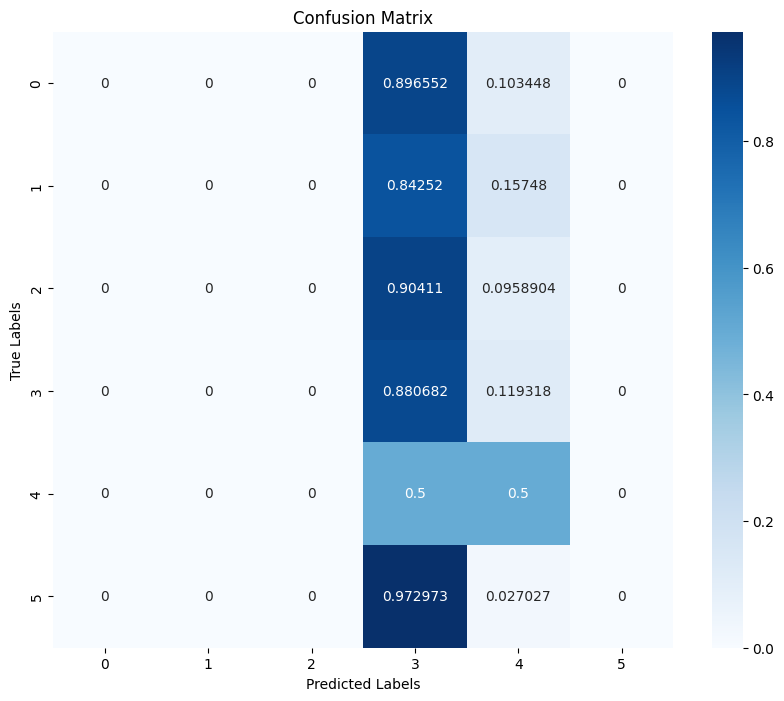

Epoch 18, Validation Loss: 1.7436, Accuracy: 0.2721, F1 Score: 0.1382
Val F1 Score Per Class  [0.         0.         0.         0.45189504 0.05633803 0.        ]


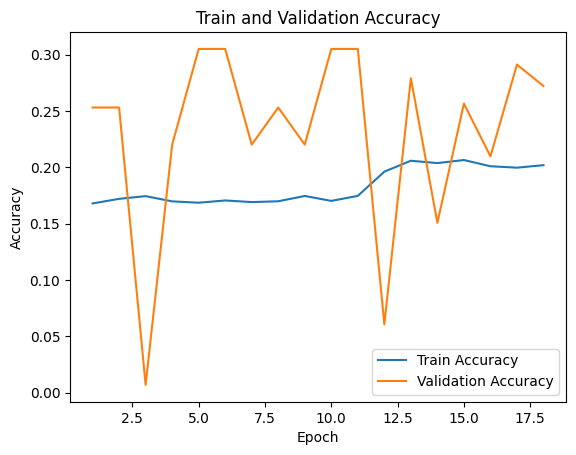

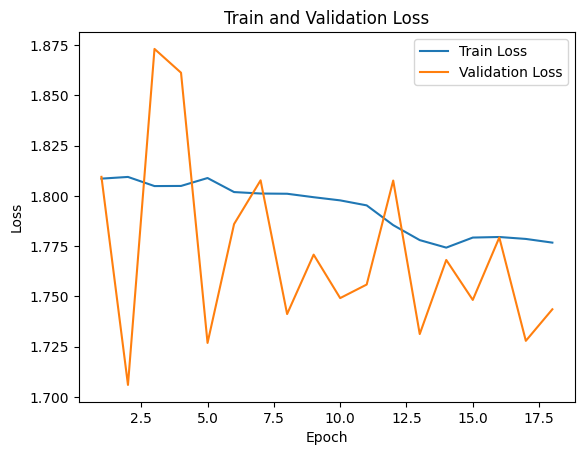

Epoch 19, Train Loss: 1.7753, Accuracy: 0.2094, F1 Score: 0.1083
Train F1 Score Per Class  [0.00195217 0.         0.         0.30388093 0.32676332 0.00294406]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.43it/s, loss=1.73]

[tensor([ 0.0267,  0.0418,  0.0358,  0.1242, -0.3907, -0.0428], device='cuda:0'), tensor([-0.1399, -0.0198, -0.0373,  0.0208, -0.0247, -0.0845], device='cuda:0'), tensor([-0.1732, -0.0361, -0.0659, -0.0111,  0.0531, -0.0725], device='cuda:0'), tensor([-0.0399,  0.0172,  0.0053,  0.0802, -0.2819, -0.0592], device='cuda:0'), tensor([ 0.0564,  0.0537,  0.0356,  0.1400, -0.4816, -0.0280], device='cuda:0'), tensor([-0.1256, -0.0161, -0.0463,  0.0222, -0.1521, -0.0637], device='cuda:0'), tensor([ 0.1495,  0.0892,  0.0751,  0.2059, -0.6398, -0.0049], device='cuda:0'), tensor([-0.1339, -0.0199, -0.0282,  0.0225, -0.0931, -0.0923], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.45it/s, loss=1.75]

[tensor([ 0.0503,  0.0507,  0.0413,  0.1371, -0.4673, -0.0314], device='cuda:0'), tensor([ 0.0083,  0.0343,  0.0059,  0.1068, -0.2974, -0.0541], device='cuda:0'), tensor([-0.1444, -0.0230, -0.0453,  0.0129, -0.0068, -0.0863], device='cuda:0'), tensor([ 0.0402,  0.0466,  0.0421,  0.1326, -0.4381, -0.0429], device='cuda:0'), tensor([-0.0288,  0.0228,  0.0093,  0.0914, -0.3841, -0.0564], device='cuda:0'), tensor([-0.0482,  0.0142,  0.0071,  0.0791, -0.3412, -0.0712], device='cuda:0'), tensor([ 0.0794,  0.0636,  0.0437,  0.1591, -0.6385, -0.0230], device='cuda:0'), tensor([ 0.0347,  0.0453,  0.0332,  0.1281, -0.4052, -0.0359], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=1.74]

[tensor([ 1.2108e-01,  7.8394e-02,  5.6582e-02,  1.8205e-01, -6.7900e-01,
        -2.5762e-04], device='cuda:0'), tensor([-0.0705,  0.0060, -0.0025,  0.0629, -0.1591, -0.0735], device='cuda:0'), tensor([ 0.0739,  0.0594,  0.0497,  0.1519, -0.6336, -0.0244], device='cuda:0'), tensor([-0.1019, -0.0066, -0.0307,  0.0397, -0.4208, -0.0594], device='cuda:0'), tensor([-0.0420,  0.0144,  0.0013,  0.0739, -0.3888, -0.0508], device='cuda:0'), tensor([-0.0465,  0.0135,  0.0006,  0.0729, -0.3623, -0.0581], device='cuda:0'), tensor([ 0.0648,  0.0580,  0.0413,  0.1503, -0.4122, -0.0385], device='cuda:0'), tensor([-0.0264,  0.0218,  0.0135,  0.0896, -0.2957, -0.0642], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=1.7]

[tensor([ 0.0925,  0.0671,  0.0446,  0.1620, -0.4625, -0.0105], device='cuda:0'), tensor([-0.0942, -0.0024, -0.0075,  0.0527, -0.2800, -0.0879], device='cuda:0'), tensor([ 0.1356,  0.0839,  0.0660,  0.1965, -0.5999, -0.0071], device='cuda:0'), tensor([ 0.0765,  0.0616,  0.0492,  0.1575, -0.5024, -0.0235], device='cuda:0'), tensor([-0.1220, -0.0152, -0.0539,  0.0254,  0.0260, -0.0695], device='cuda:0'), tensor([ 0.1573,  0.0907,  0.0682,  0.2006, -0.7003,  0.0080], device='cuda:0'), tensor([ 0.1291,  0.0795,  0.0661,  0.1834, -0.6007, -0.0050], device='cuda:0'), tensor([ 0.0151,  0.0376,  0.0221,  0.1119, -0.5652, -0.0384], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.40it/s, loss=1.79]

[tensor([-0.0501,  0.0142,  0.0054,  0.0804, -0.1684, -0.0709], device='cuda:0'), tensor([ 0.1469,  0.0912,  0.0575,  0.2072, -0.7671,  0.0149], device='cuda:0'), tensor([-0.1798, -0.0391, -0.0629, -0.0167,  0.0844, -0.0873], device='cuda:0'), tensor([-0.0842, -0.0006, -0.0067,  0.0520, -0.1396, -0.0751], device='cuda:0'), tensor([ 0.0031,  0.0332,  0.0253,  0.1074, -0.4330, -0.0479], device='cuda:0'), tensor([-0.0981, -0.0060, -0.0281,  0.0387, -0.1257, -0.0582], device='cuda:0'), tensor([-0.1242, -0.0151, -0.0218,  0.0306, -0.1147, -0.0916], device='cuda:0'), tensor([-0.4712, -0.1314, -0.2270, -0.0656,  1.0369, -0.2650], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.40it/s, loss=1.7]

[tensor([-0.0359,  0.0185,  0.0189,  0.0922, -0.3310, -0.0800], device='cuda:0'), tensor([ 1.2557e-01,  8.1084e-02,  5.7080e-02,  1.8895e-01, -6.1053e-01,
         2.0653e-04], device='cuda:0'), tensor([-0.0927, -0.0039, -0.0181,  0.0426, -0.2584, -0.0627], device='cuda:0'), tensor([ 0.1334,  0.0830,  0.0715,  0.1965, -0.6858, -0.0160], device='cuda:0'), tensor([-0.0088,  0.0292,  0.0229,  0.1046, -0.4303, -0.0580], device='cuda:0'), tensor([-0.0858, -0.0008, -0.0128,  0.0514, -0.1203, -0.0755], device='cuda:0'), tensor([-0.0078,  0.0285,  0.0257,  0.1045, -0.4479, -0.0611], device='cuda:0'), tensor([ 0.0820,  0.0644,  0.0502,  0.1645, -0.6317, -0.0237], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=1.74]

[tensor([ 0.0144,  0.0377,  0.0263,  0.1158, -0.3911, -0.0420], device='cuda:0'), tensor([ 0.0570,  0.0534,  0.0405,  0.1399, -0.4049, -0.0453], device='cuda:0'), tensor([-0.1264, -0.0178, -0.0298,  0.0206, -0.0289, -0.0782], device='cuda:0'), tensor([-0.2450, -0.0619, -0.0876, -0.0513,  0.1874, -0.1078], device='cuda:0'), tensor([-0.0376,  0.0188,  0.0114,  0.0859, -0.3269, -0.0679], device='cuda:0'), tensor([-0.1143, -0.0130, -0.0265,  0.0299, -0.1753, -0.0715], device='cuda:0'), tensor([ 0.1261,  0.0812,  0.0579,  0.1884, -0.7042, -0.0048], device='cuda:0'), tensor([-0.0529,  0.0129,  0.0061,  0.0760, -0.2071, -0.0748], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=1.69]

[tensor([-0.0205,  0.0242,  0.0153,  0.0934, -0.3825, -0.0554], device='cuda:0'), tensor([-0.1659, -0.0319, -0.0648, -0.0022,  0.0262, -0.0875], device='cuda:0'), tensor([ 0.0106,  0.0355,  0.0061,  0.1042, -0.2921, -0.0283], device='cuda:0'), tensor([ 0.1042,  0.0719,  0.0552,  0.1726, -0.5828, -0.0114], device='cuda:0'), tensor([ 0.0675,  0.0580,  0.0453,  0.1500, -0.5287, -0.0276], device='cuda:0'), tensor([ 0.0560,  0.0526,  0.0466,  0.1419, -0.3930, -0.0362], device='cuda:0'), tensor([ 0.0631,  0.0568,  0.0499,  0.1561, -0.4826, -0.0467], device='cuda:0'), tensor([-0.0285,  0.0209,  0.0068,  0.0872, -0.5085, -0.0564], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=1.73]

[tensor([ 0.0059,  0.0330,  0.0242,  0.1028, -0.3201, -0.0394], device='cuda:0'), tensor([-0.0648,  0.0064, -0.0143,  0.0570, -0.1378, -0.0560], device='cuda:0'), tensor([-0.1274, -0.0170, -0.0375,  0.0224, -0.1000, -0.0820], device='cuda:0'), tensor([-0.0761,  0.0038, -0.0021,  0.0633, -0.3267, -0.0819], device='cuda:0'), tensor([ 0.0787,  0.0707,  0.0285,  0.1793, -0.5518, -0.0201], device='cuda:0'), tensor([ 0.0214,  0.0403,  0.0245,  0.1172, -0.4428, -0.0321], device='cuda:0'), tensor([-0.0733,  0.0041, -0.0160,  0.0555, -0.1046, -0.0523], device='cuda:0'), tensor([-0.1199, -0.0144, -0.0321,  0.0264, -0.0452, -0.0641], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=1.74]

[tensor([-0.0491,  0.0143,  0.0050,  0.0809, -0.2263, -0.0811], device='cuda:0'), tensor([ 0.0348,  0.0469,  0.0332,  0.1324, -0.4094, -0.0399], device='cuda:0'), tensor([ 0.1365,  0.0833,  0.0683,  0.1920, -0.8170, -0.0026], device='cuda:0'), tensor([-0.0698,  0.0063, -0.0111,  0.0617, -0.1232, -0.0625], device='cuda:0'), tensor([-0.1594, -0.0284, -0.0557,  0.0021,  0.1636, -0.0801], device='cuda:0'), tensor([ 0.0542,  0.0524,  0.0381,  0.1375, -0.4703, -0.0249], device='cuda:0'), tensor([-0.2035, -0.0458, -0.0563, -0.0243, -0.0964, -0.1071], device='cuda:0'), tensor([ 0.0800,  0.0620,  0.0483,  0.1559, -0.4668, -0.0267], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=1.83]

[tensor([-0.0047,  0.0320,  0.0150,  0.1091, -0.5589, -0.0454], device='cuda:0'), tensor([ 0.1057,  0.0715,  0.0554,  0.1712, -0.5730, -0.0091], device='cuda:0'), tensor([ 4.3364e-04,  3.2174e-02,  1.9501e-02,  1.0669e-01, -5.2442e-01,
        -4.4154e-02], device='cuda:0'), tensor([-0.0249,  0.0214,  0.0012,  0.0858, -0.4892, -0.0507], device='cuda:0'), tensor([-0.0386,  0.0168,  0.0085,  0.0792, -0.1777, -0.0631], device='cuda:0'), tensor([-0.1516, -0.0266, -0.0477,  0.0056, -0.0617, -0.0798], device='cuda:0'), tensor([-0.0850, -0.0020, -0.0091,  0.0476, -0.1301, -0.0761], device='cuda:0'), tensor([-0.0172,  0.0252,  0.0142,  0.0940, -0.3014, -0.0486], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=1.7]

[tensor([-0.1119, -0.0100, -0.0359,  0.0335, -0.0128, -0.0687], device='cuda:0'), tensor([ 0.0335,  0.0447,  0.0194,  0.1316, -0.3605, -0.0281], device='cuda:0'), tensor([ 0.1053,  0.0724,  0.0617,  0.1789, -0.6967, -0.0208], device='cuda:0'), tensor([-0.1116, -0.0106, -0.0293,  0.0326, -0.0171, -0.0705], device='cuda:0'), tensor([-0.0344,  0.0196, -0.0055,  0.0830, -0.4612, -0.0414], device='cuda:0'), tensor([ 0.0909,  0.0658,  0.0557,  0.1651, -0.4399, -0.0249], device='cuda:0'), tensor([ 0.1074,  0.0722,  0.0597,  0.1724, -0.6332, -0.0120], device='cuda:0'), tensor([-0.0546,  0.0105, -0.0134,  0.0658, -0.3887, -0.0588], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=1.73]

[tensor([ 0.0506,  0.0504,  0.0385,  0.1350, -0.3991, -0.0382], device='cuda:0'), tensor([ 0.0152,  0.0381,  0.0268,  0.1167, -0.4882, -0.0495], device='cuda:0'), tensor([-0.0570,  0.0093, -0.0104,  0.0644, -0.1851, -0.0436], device='cuda:0'), tensor([-0.2020, -0.0474, -0.0996, -0.0269,  0.0431, -0.0774], device='cuda:0'), tensor([-0.0444,  0.0149, -0.0034,  0.0780, -0.2362, -0.0648], device='cuda:0'), tensor([ 0.0577,  0.0541,  0.0385,  0.1422, -0.5041, -0.0262], device='cuda:0'), tensor([-0.0894, -0.0025, -0.0627,  0.0437, -0.0531, -0.0616], device='cuda:0'), tensor([-0.0426,  0.0155, -0.0044,  0.0748, -0.2367, -0.0461], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.71]

[tensor([-0.0567,  0.0104, -0.0073,  0.0682, -0.0653, -0.0542], device='cuda:0'), tensor([ 0.0151,  0.0378,  0.0328,  0.1188, -0.3458, -0.0520], device='cuda:0'), tensor([-0.0476,  0.0141,  0.0060,  0.0762, -0.1366, -0.0647], device='cuda:0'), tensor([ 0.0556,  0.0536,  0.0371,  0.1397, -0.4688, -0.0236], device='cuda:0'), tensor([-0.0779,  0.0027, -0.0034,  0.0564, -0.1154, -0.0773], device='cuda:0'), tensor([-0.0272,  0.0214,  0.0138,  0.0921, -0.1272, -0.0671], device='cuda:0'), tensor([-0.0471,  0.0137, -0.0026,  0.0734, -0.1402, -0.0661], device='cuda:0'), tensor([-0.0297,  0.0212,  0.0152,  0.0939, -0.5223, -0.0710], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=1.76]

[tensor([ 0.0226,  0.0412,  0.0335,  0.1270, -0.3420, -0.0509], device='cuda:0'), tensor([-0.0245,  0.0224,  0.0137,  0.0904, -0.3318, -0.0603], device='cuda:0'), tensor([-0.0238,  0.0235,  0.0168,  0.0943, -0.2614, -0.0627], device='cuda:0'), tensor([-0.0510,  0.0131,  0.0080,  0.0762, -0.4286, -0.0697], device='cuda:0'), tensor([ 0.0403,  0.0480,  0.0135,  0.1276, -0.4544, -0.0340], device='cuda:0'), tensor([-0.0783,  0.0020, -0.0154,  0.0565, -0.2879, -0.0713], device='cuda:0'), tensor([ 0.0063,  0.0354,  0.0261,  0.1159, -0.2516, -0.0558], device='cuda:0'), tensor([-0.1078, -0.0088, -0.0299,  0.0361,  0.0093, -0.0665], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=1.75]

[tensor([-0.1087, -0.0101, -0.0218,  0.0319, -0.5043, -0.0692], device='cuda:0'), tensor([-0.0350,  0.0185,  0.0082,  0.0828, -0.0892, -0.0626], device='cuda:0'), tensor([-0.0778,  0.0012, -0.0207,  0.0493, -0.3445, -0.0458], device='cuda:0'), tensor([-0.1046, -0.0091, -0.1017,  0.0314,  0.0785, -0.0499], device='cuda:0'), tensor([-0.0250,  0.0223,  0.0143,  0.0914, -0.2414, -0.0561], device='cuda:0'), tensor([-0.0034,  0.0300,  0.0120,  0.1021, -0.3792, -0.0475], device='cuda:0'), tensor([-0.0113,  0.0279,  0.0203,  0.1001, -0.2790, -0.0559], device='cuda:0'), tensor([-0.0659,  0.0059, -0.0111,  0.0600, -0.3814, -0.0480], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=1.78]

[tensor([-0.1909, -0.0410, -0.0497, -0.0166,  0.1629, -0.1010], device='cuda:0'), tensor([-0.0663,  0.0086,  0.0014,  0.0719, -0.4614, -0.0808], device='cuda:0'), tensor([ 0.0637,  0.0561,  0.0422,  0.1455, -0.6167, -0.0216], device='cuda:0'), tensor([-0.0978, -0.0069, -0.0356,  0.0361, -0.1057, -0.0596], device='cuda:0'), tensor([ 0.0029,  0.0319,  0.0293,  0.1043, -0.3380, -0.0525], device='cuda:0'), tensor([-0.0474,  0.0156,  0.0045,  0.0821, -0.2541, -0.0684], device='cuda:0'), tensor([-0.3061, -0.0731, -0.1761,  0.0088,  0.0826, -0.1544], device='cuda:0'), tensor([-0.0452,  0.0139, -0.0065,  0.0714, -0.3564, -0.0451], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=1.76]

[tensor([-0.1460, -0.0250, -0.0438,  0.0066,  0.2360, -0.0750], device='cuda:0'), tensor([ 0.0865,  0.0656,  0.0399,  0.1572, -0.5313, -0.0093], device='cuda:0'), tensor([-0.2090, -0.0486, -0.0707, -0.0291,  0.1846, -0.1072], device='cuda:0'), tensor([-0.0232,  0.0229,  0.0091,  0.0902, -0.5217, -0.0557], device='cuda:0'), tensor([-0.0187,  0.0251,  0.0187,  0.0964, -0.2194, -0.0637], device='cuda:0'), tensor([ 0.0210,  0.0399,  0.0309,  0.1234, -0.3755, -0.0530], device='cuda:0'), tensor([-0.0705,  0.0057, -0.0114,  0.0627, -0.1924, -0.0631], device='cuda:0'), tensor([-0.1704, -0.0329, -0.0710, -0.0047,  0.0701, -0.0921], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.75]

[tensor([-0.0479,  0.0135, -0.0093,  0.0724, -0.3844, -0.0474], device='cuda:0'), tensor([-0.1735, -0.0335, -0.0598, -0.0058,  0.1677, -0.0828], device='cuda:0'), tensor([-0.0886, -0.0041, -0.0202,  0.0419, -0.1699, -0.0611], device='cuda:0'), tensor([ 0.0082,  0.0354,  0.0166,  0.1099, -0.3634, -0.0430], device='cuda:0'), tensor([-0.1126, -0.0107, -0.0343,  0.0333, -0.2313, -0.0627], device='cuda:0'), tensor([-0.1130, -0.0112, -0.0194,  0.0361, -0.1435, -0.0833], device='cuda:0'), tensor([-0.2439, -0.0631, -0.0636, -0.0522,  0.1227, -0.1250], device='cuda:0'), tensor([-0.0529,  0.0130, -0.0187,  0.0774, -0.3883, -0.0614], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=1.72]

[tensor([-0.0875, -0.0016, -0.0477,  0.0495, -0.1779, -0.0732], device='cuda:0'), tensor([-0.0814, -0.0007, -0.0213,  0.0459, -0.0944, -0.0547], device='cuda:0'), tensor([-0.0400,  0.0186,  0.0077,  0.0887, -0.4959, -0.0673], device='cuda:0'), tensor([-0.1083, -0.0090, -0.0336,  0.0365, -0.4548, -0.0698], device='cuda:0'), tensor([ 0.1278,  0.0804,  0.0681,  0.1897, -0.6325, -0.0121], device='cuda:0'), tensor([ 0.0447,  0.0488,  0.0421,  0.1368, -0.5664, -0.0405], device='cuda:0'), tensor([ 0.0225,  0.0409,  0.0302,  0.1229, -0.3501, -0.0429], device='cuda:0'), tensor([-0.0128,  0.0277,  0.0232,  0.1018, -0.4301, -0.0636], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=1.77]

[tensor([-0.0713,  0.0038, -0.0243,  0.0531, -0.2070, -0.0738], device='cuda:0'), tensor([-0.1836, -0.0422, -0.0604, -0.0271,  0.3416, -0.0802], device='cuda:0'), tensor([ 0.0559,  0.0530,  0.0414,  0.1397, -0.5788, -0.0276], device='cuda:0'), tensor([-0.1557, -0.0280, -0.0599,  0.0029, -0.0293, -0.0779], device='cuda:0'), tensor([ 0.0624,  0.0559,  0.0400,  0.1448, -0.5540, -0.0218], device='cuda:0'), tensor([-0.1566, -0.0279, -0.0487,  0.0035,  0.0041, -0.0787], device='cuda:0'), tensor([-0.1515, -0.0269, -0.0662,  0.0036,  0.0560, -0.0676], device='cuda:0'), tensor([-0.0013,  0.0296, -0.0017,  0.0988, -0.2321, -0.0280], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=1.78]

[tensor([-0.0772,  0.0031, -0.0046,  0.0576, -0.0771, -0.0743], device='cuda:0'), tensor([-0.0662,  0.0077, -0.0103,  0.0655, -0.0198, -0.0700], device='cuda:0'), tensor([-0.0829, -0.0007, -0.0108,  0.0517, -0.1913, -0.0665], device='cuda:0'), tensor([ 0.1192,  0.0787,  0.0628,  0.1900, -0.6796, -0.0169], device='cuda:0'), tensor([-0.2275, -0.0558, -0.0827, -0.0406,  0.1219, -0.0980], device='cuda:0'), tensor([-0.1163, -0.0126, -0.0226,  0.0317, -0.2081, -0.0769], device='cuda:0'), tensor([-0.1750, -0.0339, -0.0513, -0.0037,  0.0994, -0.0936], device='cuda:0'), tensor([-0.1624, -0.0305, -0.0458,  0.0003,  0.0582, -0.0857], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.38it/s, loss=1.71]

[tensor([ 0.1172,  0.0762,  0.0691,  0.1829, -0.5731, -0.0217], device='cuda:0'), tensor([ 0.0004,  0.0316,  0.0271,  0.1063, -0.2994, -0.0507], device='cuda:0'), tensor([ 0.1768,  0.0993,  0.0727,  0.2180, -0.8081,  0.0198], device='cuda:0'), tensor([ 0.0603,  0.0538,  0.0353,  0.1413, -0.6131, -0.0171], device='cuda:0'), tensor([ 0.0090,  0.0357,  0.0217,  0.1125, -0.4416, -0.0424], device='cuda:0'), tensor([ 0.0474,  0.0496,  0.0401,  0.1392, -0.3656, -0.0384], device='cuda:0'), tensor([ 0.0352,  0.0455,  0.0334,  0.1298, -0.4151, -0.0380], device='cuda:0'), tensor([-0.1144, -0.0121, -0.0327,  0.0270,  0.0876, -0.0808], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=1.76]

[tensor([-0.1286, -0.0185, -0.0285,  0.0215,  0.0601, -0.0865], device='cuda:0'), tensor([ 0.1056,  0.0717,  0.0562,  0.1713, -0.5987, -0.0079], device='cuda:0'), tensor([ 0.1591,  0.0916,  0.0679,  0.2028, -0.7035,  0.0103], device='cuda:0'), tensor([-0.0640,  0.0065, -0.0046,  0.0626, -0.3923, -0.0566], device='cuda:0'), tensor([-0.0278,  0.0215,  0.0180,  0.0928, -0.2770, -0.0664], device='cuda:0'), tensor([-0.0240,  0.0228,  0.0071,  0.0926, -0.3863, -0.0629], device='cuda:0'), tensor([-0.1652, -0.0276, -0.0615,  0.0048,  0.0159, -0.0791], device='cuda:0'), tensor([-0.1926, -0.0429, -0.0796, -0.0211,  0.2492, -0.0951], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=1.65]

[tensor([-0.8055, -0.2943, -0.4834, -0.4113,  0.5171, -0.2371], device='cuda:0'), tensor([-0.0593,  0.0093, -0.0008,  0.0674, -0.0984, -0.0794], device='cuda:0'), tensor([ 0.0864,  0.0617,  0.0313,  0.1459, -0.6832, -0.0110], device='cuda:0'), tensor([-0.0831,  0.0007, -0.0091,  0.0557, -0.1821, -0.0740], device='cuda:0'), tensor([ 0.0018,  0.0321,  0.0174,  0.1061, -0.4914, -0.0373], device='cuda:0'), tensor([ 0.0814,  0.0629,  0.0514,  0.1578, -0.4813, -0.0220], device='cuda:0'), tensor([-0.1229, -0.0148, -0.0408,  0.0234, -0.0838, -0.0610], device='cuda:0'), tensor([-0.1122, -0.0143, -0.0345,  0.0230, -0.1477, -0.0473], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.71]

[tensor([ 0.0074,  0.0353,  0.0201,  0.1104, -0.3509, -0.0406], device='cuda:0'), tensor([ 0.0150,  0.0389,  0.0284,  0.1204, -0.5116, -0.0493], device='cuda:0'), tensor([ 0.1314,  0.0830,  0.0658,  0.1948, -0.6477, -0.0084], device='cuda:0'), tensor([-0.0714,  0.0046, -0.0379,  0.0567, -0.0911, -0.0529], device='cuda:0'), tensor([ 0.0568,  0.0530,  0.0402,  0.1388, -0.3940, -0.0233], device='cuda:0'), tensor([ 0.0118,  0.0367,  0.0318,  0.1167, -0.6058, -0.0561], device='cuda:0'), tensor([-0.0166,  0.0258,  0.0184,  0.0950, -0.1884, -0.0576], device='cuda:0'), tensor([-0.1711, -0.0352, -0.0494, -0.0099, -0.1557, -0.0822], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=1.74]

[tensor([ 0.0589,  0.0549,  0.0466,  0.1487, -0.5618, -0.0403], device='cuda:0'), tensor([-0.0456,  0.0134, -0.0089,  0.0701, -0.1459, -0.0432], device='cuda:0'), tensor([-0.0371,  0.0180,  0.0020,  0.0834, -0.3850, -0.0529], device='cuda:0'), tensor([ 0.1500,  0.0993,  0.0534,  0.2307, -0.5831, -0.0081], device='cuda:0'), tensor([ 0.0441,  0.0488,  0.0366,  0.1331, -0.3323, -0.0355], device='cuda:0'), tensor([-0.1339, -0.0198, -0.0281,  0.0181, -0.0287, -0.0849], device='cuda:0'), tensor([-0.0594,  0.0099,  0.0019,  0.0718, -0.2213, -0.0706], device='cuda:0'), tensor([-0.0623,  0.0075, -0.0091,  0.0620, -0.1059, -0.0622], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=1.72]

[tensor([-0.0198,  0.0240,  0.0163,  0.0902, -0.2731, -0.0526], device='cuda:0'), tensor([ 0.1551,  0.0912,  0.0603,  0.2068, -0.7663,  0.0222], device='cuda:0'), tensor([-0.0798,  0.0013, -0.0080,  0.0550, -0.0999, -0.0700], device='cuda:0'), tensor([-0.0036,  0.0332,  0.0164,  0.1116, -0.3271, -0.0549], device='cuda:0'), tensor([-0.0213,  0.0243, -0.0018,  0.0939, -0.2204, -0.0613], device='cuda:0'), tensor([-0.0956, -0.0033, -0.0098,  0.0515, -0.1450, -0.0853], device='cuda:0'), tensor([-0.0851, -0.0015, -0.0184,  0.0449, -0.1610, -0.0606], device='cuda:0'), tensor([-0.0189,  0.0245,  0.0180,  0.0938, -0.2781, -0.0579], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=1.75]

[tensor([-0.0005,  0.0318,  0.0289,  0.1100, -0.2976, -0.0629], device='cuda:0'), tensor([ 0.0359,  0.0465,  0.0356,  0.1305, -0.5367, -0.0421], device='cuda:0'), tensor([-0.1494, -0.0257, -0.0386,  0.0054,  0.1739, -0.0835], device='cuda:0'), tensor([ 0.1043,  0.0726,  0.0481,  0.1744, -0.5785, -0.0079], device='cuda:0'), tensor([-0.0610,  0.0066, -0.0071,  0.0617, -0.2371, -0.0561], device='cuda:0'), tensor([ 0.0605,  0.0539,  0.0471,  0.1425, -0.4111, -0.0343], device='cuda:0'), tensor([-0.1239, -0.0155, -0.0343,  0.0238,  0.1205, -0.0891], device='cuda:0'), tensor([ 0.0405,  0.0462,  0.0374,  0.1276, -0.5160, -0.0319], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.37it/s, loss=1.76]

[tensor([ 0.0461,  0.0491,  0.0365,  0.1318, -0.4441, -0.0306], device='cuda:0'), tensor([-0.1224, -0.0159, -0.0407,  0.0199, -0.1055, -0.0726], device='cuda:0'), tensor([ 0.0895,  0.0662,  0.0539,  0.1677, -0.5460, -0.0223], device='cuda:0'), tensor([-0.1534, -0.0270, -0.0298,  0.0089, -0.0170, -0.0991], device='cuda:0'), tensor([ 0.0752,  0.0618,  0.0408,  0.1542, -0.5949, -0.0120], device='cuda:0'), tensor([ 0.0053,  0.0346,  0.0172,  0.1126, -0.3624, -0.0397], device='cuda:0'), tensor([-0.1123, -0.0095, -0.0392,  0.0366, -0.0128, -0.0642], device='cuda:0'), tensor([-0.1471, -0.0244, -0.0537,  0.0105,  0.0069, -0.0842], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.37it/s, loss=1.73]

[tensor([ 0.0631,  0.0564,  0.0492,  0.1511, -0.4939, -0.0385], device='cuda:0'), tensor([ 0.1723,  0.0968,  0.0775,  0.2135, -0.6981,  0.0068], device='cuda:0'), tensor([ 0.0079,  0.0361,  0.0217,  0.1150, -0.3498, -0.0495], device='cuda:0'), tensor([-0.0573,  0.0106,  0.0025,  0.0693, -0.1860, -0.0671], device='cuda:0'), tensor([ 0.0614,  0.0552,  0.0445,  0.1466, -0.4798, -0.0333], device='cuda:0'), tensor([-0.0862, -0.0009, -0.0111,  0.0511, -0.2075, -0.0709], device='cuda:0'), tensor([ 0.0495,  0.0517,  0.0306,  0.1373, -0.5397, -0.0239], device='cuda:0'), tensor([ 0.0301,  0.0438,  0.0279,  0.1238, -0.3856, -0.0559], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=1.72]

[tensor([-0.0249,  0.0241,  0.0144,  0.0959, -0.4381, -0.0612], device='cuda:0'), tensor([-0.0303,  0.0209,  0.0126,  0.0878, -0.5627, -0.0571], device='cuda:0'), tensor([-0.0061,  0.0298,  0.0213,  0.1035, -0.3886, -0.0506], device='cuda:0'), tensor([-0.1123, -0.0104, -0.0200,  0.0364,  0.0229, -0.0887], device='cuda:0'), tensor([ 0.0261,  0.0416,  0.0303,  0.1209, -0.3622, -0.0360], device='cuda:0'), tensor([ 0.2147,  0.1149,  0.0809,  0.2478, -0.9647,  0.0073], device='cuda:0'), tensor([-0.0408,  0.0165,  0.0129,  0.0841, -0.1260, -0.0720], device='cuda:0'), tensor([ 0.0738,  0.0608,  0.0520,  0.1599, -0.5877, -0.0372], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=1.71]

[tensor([-0.0801,  0.0024, -0.0119,  0.0584, -0.1576, -0.0705], device='cuda:0'), tensor([ 0.1327,  0.0827,  0.0688,  0.1946, -0.5601, -0.0130], device='cuda:0'), tensor([ 0.1426,  0.0850,  0.0721,  0.1981, -0.6559, -0.0098], device='cuda:0'), tensor([ 0.0979,  0.0692,  0.0562,  0.1714, -0.7323, -0.0186], device='cuda:0'), tensor([-0.1202, -0.0128, -0.0458,  0.0277, -0.0583, -0.0829], device='cuda:0'), tensor([ 0.0474,  0.0501,  0.0291,  0.1365, -0.5222, -0.0334], device='cuda:0'), tensor([-0.0599,  0.0096, -0.0005,  0.0665, -0.3260, -0.0706], device='cuda:0'), tensor([-0.0496,  0.0137,  0.0006,  0.0764, -0.0885, -0.0696], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=1.7]

[tensor([ 0.1044,  0.0713,  0.0599,  0.1747, -0.5923, -0.0257], device='cuda:0'), tensor([ 0.0897,  0.0663,  0.0549,  0.1651, -0.5318, -0.0249], device='cuda:0'), tensor([ 0.0908,  0.0662,  0.0497,  0.1607, -0.5166, -0.0113], device='cuda:0'), tensor([ 0.0074,  0.0347,  0.0276,  0.1114, -0.3759, -0.0491], device='cuda:0'), tensor([-0.1636, -0.0312, -0.0485, -0.0022, -0.4245, -0.0825], device='cuda:0'), tensor([ 0.0350,  0.0455,  0.0386,  0.1329, -0.4900, -0.0488], device='cuda:0'), tensor([-0.0928, -0.0040, -0.0279,  0.0415, -0.0862, -0.0691], device='cuda:0'), tensor([-0.0148,  0.0256,  0.0059,  0.0939, -0.5619, -0.0367], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=1.71]

[tensor([-0.2860, -0.0652, -0.1671,  0.0360, -0.1338, -0.1959], device='cuda:0'), tensor([ 0.1373,  0.0841,  0.0636,  0.1903, -0.7133,  0.0102], device='cuda:0'), tensor([ 0.0189,  0.0396,  0.0269,  0.1203, -0.3917, -0.0415], device='cuda:0'), tensor([ 0.0865,  0.0659,  0.0502,  0.1651, -0.7521, -0.0333], device='cuda:0'), tensor([-0.0771,  0.0023, -0.0662,  0.0562, -0.1343, -0.0332], device='cuda:0'), tensor([ 0.0944,  0.0680,  0.0543,  0.1664, -0.5881, -0.0201], device='cuda:0'), tensor([-0.0098,  0.0305,  0.0159,  0.1078, -0.3840, -0.0579], device='cuda:0'), tensor([ 0.1252,  0.0804,  0.0693,  0.1931, -0.5910, -0.0161], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.38it/s, loss=1.72]

[tensor([ 0.0207,  0.0394,  0.0261,  0.1193, -0.3176, -0.0445], device='cuda:0'), tensor([-0.0345,  0.0193, -0.0031,  0.0829, -0.5423, -0.0463], device='cuda:0'), tensor([-0.0886, -0.0025, -0.0095,  0.0491, -0.1926, -0.0786], device='cuda:0'), tensor([-0.0061,  0.0309,  0.0214,  0.1059, -0.5664, -0.0568], device='cuda:0'), tensor([-0.0760,  0.0043, -0.0060,  0.0621, -0.2176, -0.0730], device='cuda:0'), tensor([-0.1763, -0.0345, -0.0473, -0.0048, -0.0750, -0.0980], device='cuda:0'), tensor([ 0.0170,  0.0385,  0.0260,  0.1165, -0.4897, -0.0383], device='cuda:0'), tensor([ 0.0361,  0.0457,  0.0351,  0.1312, -0.3668, -0.0363], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=1.73]

[tensor([-0.0351,  0.0187,  0.0034,  0.0851, -0.4940, -0.0494], device='cuda:0'), tensor([ 0.0515,  0.0507,  0.0352,  0.1341, -0.4659, -0.0180], device='cuda:0'), tensor([ 0.1619,  0.0935,  0.0789,  0.2123, -0.7195,  0.0030], device='cuda:0'), tensor([-0.0810,  0.0011, -0.0132,  0.0553, -0.1208, -0.0738], device='cuda:0'), tensor([ 0.0252,  0.0407,  0.0334,  0.1200, -0.2826, -0.0417], device='cuda:0'), tensor([-0.0265,  0.0222,  0.0066,  0.0898, -0.2570, -0.0615], device='cuda:0'), tensor([-0.1229, -0.0154, -0.0291,  0.0243,  0.1018, -0.0738], device='cuda:0'), tensor([-0.1066, -0.0092, -0.0246,  0.0352, -0.1074, -0.0743], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.75]

[tensor([-0.1617, -0.0294, -0.0417,  0.0030,  0.0798, -0.0966], device='cuda:0'), tensor([-0.0518,  0.0120, -0.0018,  0.0712, -0.1292, -0.0555], device='cuda:0'), tensor([ 0.0289,  0.0431,  0.0359,  0.1269, -0.4359, -0.0450], device='cuda:0'), tensor([-0.0513,  0.0118, -0.0050,  0.0696, -0.3725, -0.0466], device='cuda:0'), tensor([ 0.0035,  0.0332,  0.0228,  0.1067, -0.4978, -0.0447], device='cuda:0'), tensor([ 0.0043,  0.0336,  0.0262,  0.1107, -0.2379, -0.0583], device='cuda:0'), tensor([-0.0204,  0.0256,  0.0108,  0.0951, -0.3710, -0.0537], device='cuda:0'), tensor([-0.9840, -0.3968, -0.4636, -0.6548,  0.1496, -0.2842], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=1.72]

[tensor([ 0.0849,  0.0639,  0.0332,  0.1543, -0.6144,  0.0027], device='cuda:0'), tensor([-0.0051,  0.0301,  0.0145,  0.1007, -0.2922, -0.0431], device='cuda:0'), tensor([-0.1401, -0.0232, -0.0316,  0.0132,  0.0653, -0.0922], device='cuda:0'), tensor([ 0.0923,  0.0666,  0.0520,  0.1626, -0.4793, -0.0171], device='cuda:0'), tensor([-0.0651,  0.0060, -0.0212,  0.0563, -0.1926, -0.0441], device='cuda:0'), tensor([ 0.1314,  0.0831,  0.0502,  0.1919, -0.6364,  0.0042], device='cuda:0'), tensor([ 0.0933,  0.0684,  0.0557,  0.1715, -0.4662, -0.0298], device='cuda:0'), tensor([ 0.1094,  0.0745,  0.0535,  0.1756, -0.5796, -0.0080], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=1.77]

[tensor([-0.0715,  0.0044, -0.0073,  0.0602, -0.0933, -0.0692], device='cuda:0'), tensor([ 0.0800,  0.0636,  0.0376,  0.1567, -0.5304, -0.0291], device='cuda:0'), tensor([-0.1131, -0.0135, -0.0272,  0.0287, -0.0694, -0.0733], device='cuda:0'), tensor([ 0.1534,  0.0920,  0.0651,  0.2052, -0.7565,  0.0036], device='cuda:0'), tensor([-0.0470,  0.0126, -0.0035,  0.0708, -0.0502, -0.0643], device='cuda:0'), tensor([-0.1728, -0.0343, -0.0511, -0.0067,  0.1605, -0.0878], device='cuda:0'), tensor([-0.1300, -0.0177, -0.0389,  0.0198, -0.0699, -0.0717], device='cuda:0'), tensor([-0.0501,  0.0127, -0.0015,  0.0726, -0.2247, -0.0572], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=1.74]

[tensor([ 0.0186,  0.0396,  0.0325,  0.1210, -0.4282, -0.0485], device='cuda:0'), tensor([-0.1355, -0.0195, -0.0611,  0.0198, -0.0652, -0.0645], device='cuda:0'), tensor([-0.2261, -0.0547, -0.0818, -0.0379,  0.2546, -0.1001], device='cuda:0'), tensor([ 1.1893e-04,  3.2179e-02,  1.5669e-02,  1.0361e-01, -5.2391e-01,
        -3.8224e-02], device='cuda:0'), tensor([ 0.0179,  0.0399,  0.0316,  0.1233, -0.4069, -0.0510], device='cuda:0'), tensor([ 0.0392,  0.0474,  0.0313,  0.1318, -0.4404, -0.0293], device='cuda:0'), tensor([-0.0876, -0.0016, -0.0042,  0.0531, -0.0601, -0.0870], device='cuda:0'), tensor([-0.1086, -0.0112, -0.0159,  0.0335, -0.1123, -0.0759], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=1.72]

[tensor([ 0.0491,  0.0501,  0.0222,  0.1313, -0.4065, -0.0214], device='cuda:0'), tensor([ 0.0295,  0.0440,  0.0318,  0.1262, -0.4751, -0.0437], device='cuda:0'), tensor([-0.0858, -0.0020, -0.0249,  0.0476, -0.0663, -0.0640], device='cuda:0'), tensor([ 0.1922,  0.1055,  0.0876,  0.2328, -0.7598,  0.0098], device='cuda:0'), tensor([-0.2013, -0.0504, -0.0624, -0.0354,  0.0687, -0.0790], device='cuda:0'), tensor([-0.5467, -0.1592, -0.2638, -0.1105,  1.0601, -0.2862], device='cuda:0'), tensor([-0.0785,  0.0017, -0.0148,  0.0556, -0.1880, -0.0737], device='cuda:0'), tensor([ 0.1301,  0.0796,  0.0630,  0.1817, -0.7099,  0.0057], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.38it/s, loss=1.73]

[tensor([ 0.0954,  0.0688,  0.0528,  0.1701, -0.4461, -0.0337], device='cuda:0'), tensor([-0.0915, -0.0040, -0.0349,  0.0453, -0.0482, -0.0722], device='cuda:0'), tensor([-0.0579,  0.0098,  0.0019,  0.0691, -0.3536, -0.0767], device='cuda:0'), tensor([-0.0102,  0.0284,  0.0207,  0.1020, -0.2395, -0.0595], device='cuda:0'), tensor([-0.0615,  0.0073, -0.0058,  0.0619, -0.0507, -0.0715], device='cuda:0'), tensor([-0.0149,  0.0257,  0.0164,  0.0938, -0.2014, -0.0591], device='cuda:0'), tensor([-0.1421, -0.0224, -0.0348,  0.0135, -0.0339, -0.0790], device='cuda:0'), tensor([-0.0502,  0.0134,  0.0046,  0.0781, -0.2624, -0.0665], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.38it/s, loss=1.73]

[tensor([-0.1077, -0.0098, -0.0236,  0.0349, -0.1883, -0.0713], device='cuda:0'), tensor([-0.0524,  0.0113, -0.0026,  0.0692, -0.4008, -0.0547], device='cuda:0'), tensor([-0.0958, -0.0040, -0.0201,  0.0459, -0.3908, -0.0689], device='cuda:0'), tensor([-0.1661, -0.0313, -0.0387,  0.0024,  0.1296, -0.1024], device='cuda:0'), tensor([-0.1142, -0.0121, -0.0299,  0.0287,  0.1162, -0.0785], device='cuda:0'), tensor([-0.0744,  0.0030, -0.0254,  0.0504, -0.1839, -0.0613], device='cuda:0'), tensor([ 0.0065,  0.0374,  0.0133,  0.1125, -0.5734, -0.0501], device='cuda:0'), tensor([ 0.1611,  0.0927,  0.0690,  0.2050, -0.6611,  0.0159], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=1.7]

[tensor([-0.0329,  0.0203,  0.0118,  0.0899, -0.5328, -0.0706], device='cuda:0'), tensor([ 0.0786,  0.0606,  0.0441,  0.1503, -0.5611, -0.0248], device='cuda:0'), tensor([ 0.0947,  0.0677,  0.0611,  0.1690, -0.5660, -0.0351], device='cuda:0'), tensor([-0.1340, -0.0193, -0.0360,  0.0168,  0.0828, -0.0815], device='cuda:0'), tensor([-0.1105, -0.0118, -0.0243,  0.0282,  0.0062, -0.0652], device='cuda:0'), tensor([ 0.0427,  0.0484,  0.0322,  0.1308, -0.4099, -0.0332], device='cuda:0'), tensor([ 0.0915,  0.0662,  0.0603,  0.1670, -0.5247, -0.0312], device='cuda:0'), tensor([-0.0967, -0.0049, -0.0136,  0.0454, -0.1280, -0.0799], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=1.75]

[tensor([-0.0396,  0.0157, -0.0182,  0.0712, -0.1261, -0.0551], device='cuda:0'), tensor([ 0.0060,  0.0352,  0.0212,  0.1116, -0.2644, -0.0570], device='cuda:0'), tensor([ 0.1160,  0.0749,  0.0630,  0.1760, -0.6734, -0.0071], device='cuda:0'), tensor([ 0.0018,  0.0329,  0.0217,  0.1093, -0.2948, -0.0545], device='cuda:0'), tensor([ 0.0722,  0.0594,  0.0534,  0.1569, -0.6050, -0.0374], device='cuda:0'), tensor([-0.1892, -0.0410, -0.0475, -0.0153, -0.1370, -0.1079], device='cuda:0'), tensor([-0.0340,  0.0186,  0.0042,  0.0816, -0.1431, -0.0603], device='cuda:0'), tensor([-0.1939, -0.0416, -0.0663, -0.0170,  0.2105, -0.1016], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=1.69]

[tensor([ 0.0258,  0.0425,  0.0354,  0.1274, -0.5759, -0.0473], device='cuda:0'), tensor([-0.0187,  0.0252,  0.0162,  0.0962, -0.2395, -0.0578], device='cuda:0'), tensor([-0.0685,  0.0068, -0.0066,  0.0651, -0.3611, -0.0724], device='cuda:0'), tensor([ 0.0242,  0.0406,  0.0294,  0.1176, -0.4817, -0.0369], device='cuda:0'), tensor([-0.0262,  0.0227,  0.0113,  0.0908, -0.1892, -0.0554], device='cuda:0'), tensor([ 0.1037,  0.0704,  0.0572,  0.1715, -0.5954, -0.0132], device='cuda:0'), tensor([-0.0508,  0.0121, -0.0164,  0.0677, -0.1623, -0.0419], device='cuda:0'), tensor([ 0.0812,  0.0628,  0.0573,  0.1635, -0.5633, -0.0364], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=1.73]

[tensor([-0.0132,  0.0264,  0.0167,  0.0966, -0.2943, -0.0533], device='cuda:0'), tensor([ 0.0736,  0.0596,  0.0512,  0.1545, -0.5318, -0.0289], device='cuda:0'), tensor([ 0.0009,  0.0338, -0.0555,  0.1086, -0.2006, -0.0089], device='cuda:0'), tensor([-0.1124, -0.0103, -0.0198,  0.0387, -0.0967, -0.0825], device='cuda:0'), tensor([ 0.0491,  0.0503,  0.0401,  0.1358, -0.4220, -0.0315], device='cuda:0'), tensor([ 0.0659,  0.0578,  0.0454,  0.1534, -0.4085, -0.0391], device='cuda:0'), tensor([ 0.0474,  0.0484,  0.0439,  0.1398, -0.3624, -0.0541], device='cuda:0'), tensor([-0.0117,  0.0279,  0.0131,  0.0977, -0.3480, -0.0474], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=1.74]

[tensor([-0.0399,  0.0169,  0.0137,  0.0849, -0.6143, -0.0665], device='cuda:0'), tensor([ 0.0524,  0.0531,  0.0373,  0.1442, -0.4896, -0.0314], device='cuda:0'), tensor([ 0.0175,  0.0379,  0.0336,  0.1177, -0.4929, -0.0494], device='cuda:0'), tensor([ 0.1019,  0.0705,  0.0514,  0.1680, -0.5642, -0.0172], device='cuda:0'), tensor([-0.0657,  0.0067, -0.0104,  0.0617, -0.2289, -0.0622], device='cuda:0'), tensor([ 0.0491,  0.0517,  0.0432,  0.1425, -0.4633, -0.0442], device='cuda:0'), tensor([-0.1686, -0.0338, -0.0663, -0.0058,  0.0695, -0.0941], device='cuda:0'), tensor([-0.1437, -0.0231, -0.0433,  0.0110,  0.0370, -0.0802], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=1.7]

[tensor([ 0.0488,  0.0505,  0.0419,  0.1382, -0.5556, -0.0370], device='cuda:0'), tensor([-0.0717,  0.0054, -0.0131,  0.0622, -0.4181, -0.0614], device='cuda:0'), tensor([ 0.0108,  0.0369,  0.0245,  0.1155, -0.6813, -0.0439], device='cuda:0'), tensor([ 0.0348,  0.0455,  0.0371,  0.1296, -0.3002, -0.0438], device='cuda:0'), tensor([-0.0257,  0.0234,  0.0053,  0.0936, -0.7244, -0.0495], device='cuda:0'), tensor([-0.0255,  0.0223,  0.0133,  0.0899, -0.2029, -0.0563], device='cuda:0'), tensor([ 0.1412,  0.0869,  0.0659,  0.2019, -0.6559,  0.0020], device='cuda:0'), tensor([-0.1002, -0.0064, -0.0240,  0.0386, -0.1019, -0.0663], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=1.73]

[tensor([-0.0168,  0.0254,  0.0155,  0.0947, -0.2209, -0.0532], device='cuda:0'), tensor([-0.1339, -0.0187, -0.0403,  0.0197,  0.0604, -0.0743], device='cuda:0'), tensor([ 0.0352,  0.0453,  0.0325,  0.1274, -0.4173, -0.0337], device='cuda:0'), tensor([-0.0090,  0.0298,  0.0145,  0.1023, -0.2551, -0.0502], device='cuda:0'), tensor([-0.1507, -0.0248, -0.0433,  0.0113, -0.2093, -0.0863], device='cuda:0'), tensor([ 0.0244,  0.0416,  0.0216,  0.1172, -0.5046, -0.0242], device='cuda:0'), tensor([ 0.0235,  0.0407,  0.0286,  0.1193, -0.4401, -0.0359], device='cuda:0'), tensor([-0.3946, -0.1038, -0.2112, -0.0277,  0.1364, -0.1963], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.39it/s, loss=1.71]

[tensor([ 0.0387,  0.0475,  0.0311,  0.1316, -0.7035, -0.0312], device='cuda:0'), tensor([-0.0447,  0.0154,  0.0086,  0.0785, -0.3551, -0.0655], device='cuda:0'), tensor([ 0.1034,  0.0719,  0.0584,  0.1749, -0.6097, -0.0186], device='cuda:0'), tensor([-0.0072,  0.0293,  0.0250,  0.1052, -0.2877, -0.0598], device='cuda:0'), tensor([ 0.0758,  0.0601,  0.0558,  0.1578, -0.5998, -0.0393], device='cuda:0'), tensor([-0.0331,  0.0190,  0.0039,  0.0829, -0.2996, -0.0468], device='cuda:0'), tensor([-0.0709,  0.0045, -0.0230,  0.0553, -0.0537, -0.0620], device='cuda:0'), tensor([-0.0815, -0.0004, -0.0080,  0.0504, -0.0296, -0.0699], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.38it/s, loss=1.77]

[tensor([-0.1480, -0.0251, -0.0395,  0.0082,  0.2300, -0.0919], device='cuda:0'), tensor([ 0.0444,  0.0495,  0.0380,  0.1365, -0.4014, -0.0352], device='cuda:0'), tensor([-0.1785, -0.0367, -0.0597, -0.0126,  0.1439, -0.1107], device='cuda:0'), tensor([-0.3185, -0.1051, -0.1114, -0.1408,  0.2288, -0.1059], device='cuda:0'), tensor([-0.0084,  0.0294,  0.0225,  0.1021, -0.5331, -0.0581], device='cuda:0'), tensor([-0.1535, -0.0274, -0.0409,  0.0057, -0.3178, -0.0837], device='cuda:0'), tensor([-0.0072,  0.0305,  0.0094,  0.1048, -0.4363, -0.0524], device='cuda:0'), tensor([ 0.0855,  0.0637,  0.0490,  0.1594, -0.4622, -0.0252], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=1.71]

[tensor([ 0.0974,  0.0692,  0.0607,  0.1720, -0.5388, -0.0268], device='cuda:0'), tensor([ 0.0663,  0.0565,  0.0478,  0.1470, -0.5297, -0.0293], device='cuda:0'), tensor([ 0.0279,  0.0437,  0.0306,  0.1280, -0.2789, -0.0470], device='cuda:0'), tensor([ 0.0070,  0.0354,  0.0237,  0.1145, -0.4220, -0.0459], device='cuda:0'), tensor([-0.0444,  0.0166,  0.0077,  0.0868, -0.4202, -0.0726], device='cuda:0'), tensor([-0.1172, -0.0142, -0.0243,  0.0267, -0.4139, -0.0710], device='cuda:0'), tensor([-0.1877, -0.0387, -0.0621, -0.0114,  0.0831, -0.0939], device='cuda:0'), tensor([-0.0519,  0.0126,  0.0115,  0.0779, -0.4680, -0.0787], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.39it/s, loss=1.79]

[tensor([-0.1179, -0.0130, -0.0346,  0.0272, -0.0479, -0.0651], device='cuda:0'), tensor([-0.1282, -0.0172, -0.0290,  0.0218,  0.0184, -0.0783], device='cuda:0'), tensor([-0.0776,  0.0027, -0.0126,  0.0552, -0.0808, -0.0615], device='cuda:0'), tensor([-0.1797, -0.0374, -0.0479, -0.0116,  0.1397, -0.0965], device='cuda:0'), tensor([-0.0657,  0.0053, -0.0048,  0.0587, -0.0652, -0.0595], device='cuda:0'), tensor([-0.1355, -0.0195, -0.0432,  0.0185, -0.0419, -0.0713], device='cuda:0'), tensor([-0.5779, -0.2498, -0.2291, -0.4412,  0.2299, -0.1889], device='cuda:0'), tensor([ 1.5459e-01,  9.0636e-02,  7.6337e-02,  2.0669e-01, -6.8738e-01,
        -2.4937e-04], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.39it/s, loss=1.74]

[tensor([ 0.1025,  0.0709,  0.0544,  0.1696, -0.5580, -0.0076], device='cuda:0'), tensor([-0.0294,  0.0209,  0.0047,  0.0867, -0.2178, -0.0463], device='cuda:0'), tensor([ 0.0702,  0.0582,  0.0485,  0.1518, -0.3988, -0.0363], device='cuda:0'), tensor([-0.0698,  0.0049, -0.0089,  0.0583, -0.4118, -0.0574], device='cuda:0'), tensor([-0.0605,  0.0078, -0.0180,  0.0611, -0.2311, -0.0455], device='cuda:0'), tensor([-0.0894, -0.0009, -0.0818,  0.0537, -0.2396, -0.0433], device='cuda:0'), tensor([-0.0436,  0.0168,  0.0034,  0.0849, -0.2310, -0.0670], device='cuda:0'), tensor([-0.0648,  0.0075,  0.0009,  0.0653, -0.2163, -0.0712], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=1.72]

[tensor([-0.1038, -0.0084, -0.0212,  0.0349, -0.0360, -0.0693], device='cuda:0'), tensor([ 0.1088,  0.0744,  0.0556,  0.1792, -0.5800, -0.0097], device='cuda:0'), tensor([ 0.0495,  0.0512,  0.0375,  0.1385, -0.4517, -0.0334], device='cuda:0'), tensor([ 0.0904,  0.0662,  0.0573,  0.1649, -0.7249, -0.0229], device='cuda:0'), tensor([ 0.0260,  0.0415,  0.0208,  0.1190, -0.2693, -0.0399], device='cuda:0'), tensor([-0.0282,  0.0219,  0.0031,  0.0892, -0.3855, -0.0493], device='cuda:0'), tensor([-0.1787, -0.0365, -0.0567, -0.0084, -0.0780, -0.0841], device='cuda:0'), tensor([-0.1304, -0.0184, -0.0250,  0.0242,  0.0773, -0.0909], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=1.76]

[tensor([-0.0688,  0.0049, -0.0213,  0.0535, -0.1362, -0.0626], device='cuda:0'), tensor([-0.0892, -0.0030, -0.0172,  0.0449, -0.1799, -0.0619], device='cuda:0'), tensor([-0.0113,  0.0287,  0.0141,  0.0992, -0.4006, -0.0461], device='cuda:0'), tensor([-0.0872, -0.0018, -0.0281,  0.0459, -0.1383, -0.0460], device='cuda:0'), tensor([-0.0503,  0.0133, -0.0030,  0.0743, -0.1513, -0.0618], device='cuda:0'), tensor([-0.0359,  0.0178,  0.0127,  0.0844, -0.3124, -0.0650], device='cuda:0'), tensor([-0.0546,  0.0104,  0.0010,  0.0685, -0.1756, -0.0593], device='cuda:0'), tensor([-0.0579,  0.0087, -0.0151,  0.0635, -0.0663, -0.0615], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=1.76]

[tensor([ 0.0553,  0.0548,  0.0356,  0.1471, -0.5493, -0.0274], device='cuda:0'), tensor([-0.0947, -0.0040, -0.0193,  0.0446, -0.1775, -0.0674], device='cuda:0'), tensor([ 0.0837,  0.0630,  0.0576,  0.1612, -0.6550, -0.0316], device='cuda:0'), tensor([-0.0706,  0.0055, -0.0195,  0.0578, -0.0833, -0.0756], device='cuda:0'), tensor([-0.1564, -0.0300, -0.0651, -0.0022,  0.1542, -0.0697], device='cuda:0'), tensor([-0.1767, -0.0363, -0.0539, -0.0097,  0.0960, -0.0858], device='cuda:0'), tensor([-0.0012,  0.0308,  0.0242,  0.1023, -0.5183, -0.0496], device='cuda:0'), tensor([ 0.1236,  0.0779,  0.0601,  0.1785, -0.5838, -0.0115], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.39it/s, loss=1.74]

[tensor([-0.0067,  0.0298,  0.0173,  0.1018, -0.6665, -0.0505], device='cuda:0'), tensor([ 0.0908,  0.0660,  0.0545,  0.1669, -0.4700, -0.0253], device='cuda:0'), tensor([ 0.0020,  0.0335,  0.0186,  0.1062, -0.3740, -0.0418], device='cuda:0'), tensor([-0.1764, -0.0348, -0.0570, -0.0066,  0.0007, -0.0903], device='cuda:0'), tensor([-0.0772,  0.0019, -0.1095,  0.0656, -0.1207, -0.0555], device='cuda:0'), tensor([ 0.0636,  0.0560,  0.0505,  0.1504, -0.4673, -0.0411], device='cuda:0'), tensor([ 0.1142,  0.0762,  0.0623,  0.1817, -0.6266, -0.0147], device='cuda:0'), tensor([ 0.0858,  0.0645,  0.0454,  0.1580, -0.7056, -0.0067], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=1.7]

[tensor([-0.0234,  0.0236,  0.0109,  0.0904, -0.3196, -0.0495], device='cuda:0'), tensor([ 0.0933,  0.0690,  0.0551,  0.1729, -0.8044, -0.0291], device='cuda:0'), tensor([-0.1195, -0.0136, -0.0252,  0.0303,  0.0213, -0.0824], device='cuda:0'), tensor([-0.0609,  0.0095, -0.0061,  0.0702, -0.4171, -0.0606], device='cuda:0'), tensor([-0.0082,  0.0309,  0.0184,  0.1071, -0.4249, -0.0552], device='cuda:0'), tensor([-0.0102,  0.0282,  0.0166,  0.0993, -0.3219, -0.0486], device='cuda:0'), tensor([ 0.1086,  0.0743,  0.0606,  0.1788, -0.5195, -0.0156], device='cuda:0'), tensor([ 0.1066,  0.0733,  0.0599,  0.1793, -0.7306, -0.0180], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.39it/s, loss=1.75]

[tensor([-0.0430,  0.0155, -0.0385,  0.0731, -0.1609, -0.0382], device='cuda:0'), tensor([ 0.0834,  0.0637,  0.0491,  0.1587, -0.6202, -0.0173], device='cuda:0'), tensor([-0.0243,  0.0240,  0.0152,  0.0946, -0.2450, -0.0619], device='cuda:0'), tensor([-0.0412,  0.0155,  0.0069,  0.0807, -0.4014, -0.0599], device='cuda:0'), tensor([ 0.0008,  0.0316,  0.0188,  0.1033, -0.3078, -0.0471], device='cuda:0'), tensor([ 0.0857,  0.0638,  0.0578,  0.1592, -0.5702, -0.0244], device='cuda:0'), tensor([-0.0819,  0.0020, -0.0090,  0.0568,  0.0036, -0.0799], device='cuda:0'), tensor([ 0.0801,  0.0635,  0.0493,  0.1606, -0.5455, -0.0235], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.39it/s, loss=1.74]

[tensor([-0.1054, -0.0090, -0.0193,  0.0394,  0.0689, -0.0898], device='cuda:0'), tensor([-0.1077, -0.0095, -0.0152,  0.0386, -0.1116, -0.0821], device='cuda:0'), tensor([ 0.0562,  0.0526,  0.0441,  0.1411, -0.4340, -0.0283], device='cuda:0'), tensor([-0.1779, -0.0414, -0.0846, -0.0216,  0.1008, -0.0691], device='cuda:0'), tensor([-0.0125,  0.0273,  0.0141,  0.0965, -0.3372, -0.0463], device='cuda:0'), tensor([-0.1253, -0.0155, -0.0283,  0.0266,  0.0354, -0.0785], device='cuda:0'), tensor([ 0.0065,  0.0335,  0.0237,  0.1073, -0.3121, -0.0421], device='cuda:0'), tensor([-0.1019, -0.0073, -0.0223,  0.0384,  0.0097, -0.0743], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.39it/s, loss=1.74]

[tensor([-0.1062, -0.0087, -0.0380,  0.0355, -0.1670, -0.0578], device='cuda:0'), tensor([ 0.0311,  0.0436,  0.0387,  0.1271, -0.4650, -0.0434], device='cuda:0'), tensor([-0.0498,  0.0143,  0.0060,  0.0794, -0.2601, -0.0732], device='cuda:0'), tensor([ 0.1035,  0.0708,  0.0561,  0.1695, -0.5798, -0.0066], device='cuda:0'), tensor([-0.0612,  0.0071, -0.0114,  0.0618, -0.1537, -0.0624], device='cuda:0'), tensor([ 0.0600,  0.0551,  0.0460,  0.1450, -0.4147, -0.0332], device='cuda:0'), tensor([-0.0870, -0.0020, -0.0168,  0.0480, -0.0344, -0.0662], device='cuda:0'), tensor([ 0.0201,  0.0399,  0.0279,  0.1182, -0.2174, -0.0427], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.39it/s, loss=1.71]

[tensor([-0.0836,  0.0022, -0.0339,  0.0555, -0.2508, -0.0616], device='cuda:0'), tensor([-0.0368,  0.0170, -0.0042,  0.0782, -0.1683, -0.0509], device='cuda:0'), tensor([-0.0278,  0.0217,  0.0009,  0.0875, -0.3749, -0.0405], device='cuda:0'), tensor([ 0.0829,  0.0621,  0.0557,  0.1557, -0.4135, -0.0268], device='cuda:0'), tensor([-0.0824,  0.0021, -0.0152,  0.0574, -0.1204, -0.0714], device='cuda:0'), tensor([-0.0578,  0.0108, -0.0011,  0.0723, -0.2518, -0.0636], device='cuda:0'), tensor([ 0.0303,  0.0448,  0.0300,  0.1279, -0.5121, -0.0378], device='cuda:0'), tensor([ 0.0665,  0.0587,  0.0368,  0.1491, -0.4350, -0.0293], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=1.73]

[tensor([-0.0419,  0.0171,  0.0095,  0.0837, -0.1362, -0.0681], device='cuda:0'), tensor([-0.0883, -0.0021, -0.0130,  0.0477, -0.0151, -0.0690], device='cuda:0'), tensor([ 0.1100,  0.0741,  0.0665,  0.1818, -0.6021, -0.0277], device='cuda:0'), tensor([ 0.1013,  0.0700,  0.0578,  0.1705, -0.5535, -0.0178], device='cuda:0'), tensor([-0.1107, -0.0106, -0.0370,  0.0286, -0.1659, -0.0574], device='cuda:0'), tensor([ 0.0101,  0.0359,  0.0271,  0.1132, -0.3561, -0.0464], device='cuda:0'), tensor([ 0.0427,  0.0486,  0.0397,  0.1347, -0.4878, -0.0399], device='cuda:0'), tensor([-0.1303, -0.0175, -0.0375,  0.0216,  0.1593, -0.0830], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=1.75]

[tensor([ 0.0911,  0.0667,  0.0546,  0.1652, -0.6488, -0.0223], device='cuda:0'), tensor([-0.0165,  0.0254, -0.0016,  0.0937, -0.2595, -0.0471], device='cuda:0'), tensor([-0.0558,  0.0107,  0.0072,  0.0739, -0.2873, -0.0749], device='cuda:0'), tensor([-0.1377, -0.0206, -0.0336,  0.0153,  0.0625, -0.0890], device='cuda:0'), tensor([-0.1343, -0.0194, -0.0286,  0.0200, -0.0995, -0.0890], device='cuda:0'), tensor([-0.1258, -0.0157, -0.0438,  0.0284, -0.2367, -0.0881], device='cuda:0'), tensor([-0.1112, -0.0098, -0.0184,  0.0396, -0.0232, -0.0911], device='cuda:0'), tensor([-0.1344, -0.0181, -0.0632,  0.0263,  0.0480, -0.0841], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.38it/s, loss=1.73]

[tensor([ 0.0166,  0.0397,  0.0272,  0.1215, -0.5219, -0.0467], device='cuda:0'), tensor([-0.0689,  0.0042, -0.0038,  0.0590, -0.2479, -0.0603], device='cuda:0'), tensor([ 0.0285,  0.0434,  0.0341,  0.1264, -0.4490, -0.0434], device='cuda:0'), tensor([ 0.1072,  0.0736,  0.0591,  0.1798, -0.6088, -0.0184], device='cuda:0'), tensor([-0.1344, -0.0206, -0.0281,  0.0182, -0.0563, -0.0807], device='cuda:0'), tensor([ 0.0947,  0.0685,  0.0584,  0.1696, -0.5709, -0.0267], device='cuda:0'), tensor([ 0.0579,  0.0542,  0.0367,  0.1389, -0.6568, -0.0177], device='cuda:0'), tensor([-0.0920, -0.0042, -0.0163,  0.0425, -0.3327, -0.0644], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.38it/s, loss=1.73]

[tensor([-0.0481,  0.0134, -0.0049,  0.0733, -0.2410, -0.0555], device='cuda:0'), tensor([-0.0418,  0.0158,  0.0053,  0.0803, -0.1904, -0.0583], device='cuda:0'), tensor([ 0.1356,  0.0827,  0.0713,  0.1929, -0.6060, -0.0109], device='cuda:0'), tensor([ 0.0300,  0.0444,  0.0245,  0.1238, -0.4663, -0.0258], device='cuda:0'), tensor([ 0.0530,  0.0516,  0.0395,  0.1370, -0.3824, -0.0330], device='cuda:0'), tensor([-0.0138,  0.0259,  0.0209,  0.0978, -0.2753, -0.0580], device='cuda:0'), tensor([-0.0917, -0.0028, -0.0265,  0.0440, -0.1259, -0.0545], device='cuda:0'), tensor([-0.0062,  0.0306,  0.0106,  0.1019, -0.4918, -0.0367], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.39it/s, loss=1.71]

[tensor([ 0.1164,  0.0771,  0.0624,  0.1845, -0.5798, -0.0151], device='cuda:0'), tensor([-0.0558,  0.0105,  0.0023,  0.0692, -0.0890, -0.0636], device='cuda:0'), tensor([ 0.0558,  0.0530,  0.0468,  0.1439, -0.4557, -0.0376], device='cuda:0'), tensor([-0.0521,  0.0123,  0.0086,  0.0753, -0.1838, -0.0715], device='cuda:0'), tensor([-0.0597,  0.0075, -0.0104,  0.0622, -0.5089, -0.0458], device='cuda:0'), tensor([ 0.0832,  0.0648,  0.0456,  0.1652, -0.6272, -0.0278], device='cuda:0'), tensor([-0.0035,  0.0310,  0.0154,  0.1031, -0.1726, -0.0526], device='cuda:0'), tensor([-0.1548, -0.0261, -0.0490,  0.0079,  0.1852, -0.0928], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=1.7]

[tensor([-0.1557, -0.0291, -0.0357,  0.0010,  0.0819, -0.0885], device='cuda:0'), tensor([-0.1249, -0.0164, -0.0258,  0.0239, -0.0731, -0.0775], device='cuda:0'), tensor([ 0.0238,  0.0411,  0.0311,  0.1223, -0.5056, -0.0456], device='cuda:0'), tensor([-0.0379,  0.0169,  0.0137,  0.0815, -0.2957, -0.0642], device='cuda:0'), tensor([-0.0900, -0.0029, -0.0066,  0.0499, -0.1815, -0.0801], device='cuda:0'), tensor([ 1.4255e-01,  8.6706e-02,  6.8966e-02,  1.9923e-01, -6.9494e-01,
        -5.1524e-04], device='cuda:0'), tensor([ 0.0553,  0.0535,  0.0366,  0.1390, -0.3678, -0.0348], device='cuda:0'), tensor([ 0.0346,  0.0467,  0.0367,  0.1365, -0.5677, -0.0438], device='cuda:0')]


[tensor([-0.1239, -0.0169, -0.0625,  0.0200, -0.1568, -0.0657], device='cuda:0'), tensor([-0.0609,  0.0087, -0.0039,  0.0653, -0.3573, -0.0618], device='cuda:0'), tensor([-0.1329, -0.0186, -0.0588,  0.0234,  0.0635, -0.0821], device='cuda:0'), tensor([-0.1010, -0.0066, -0.0373,  0.0370, -0.0848, -0.0479], device='cuda:0'), tensor([-0.0322,  0.0181, -0.0079,  0.0758, -0.2723, -0.0327], device='cuda:0'), tensor([ 0.0542,  0.0541,  0.0425,  0.1493, -0.4953, -0.0416], device='cuda:0'), tensor([ 0.0311,  0.0429,  0.0209,  0.1190, -0.3837, -0.0349], device='cuda:0'), tensor([-0.0658,  0.0065, -0.0050,  0.0629, -0.1097, -0.0651], device='cuda:0')]
[tensor([-0.0120,  0.0276,  0.0214,  0.0993, -0.2965, -0.0608], device='cuda:0')]


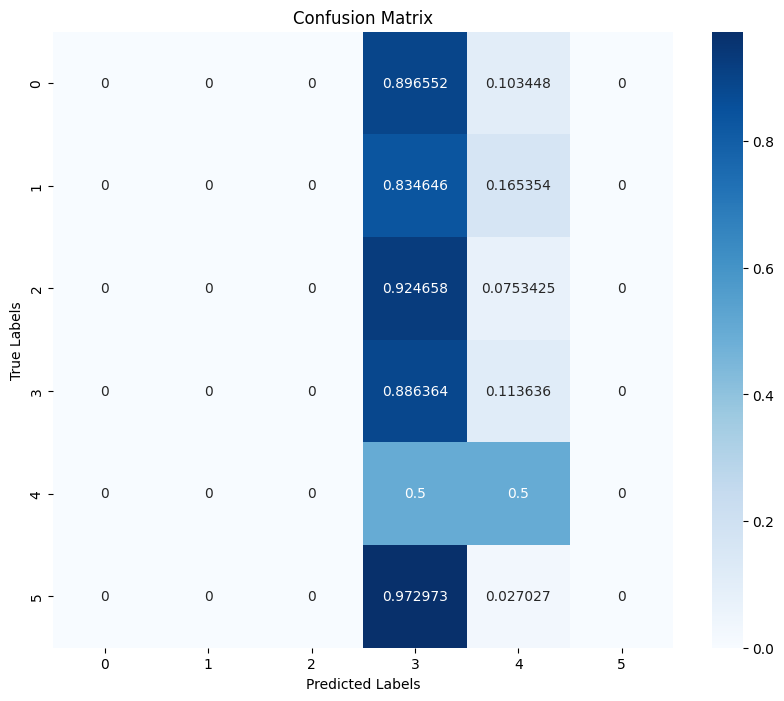

Epoch 19, Validation Loss: 1.7335, Accuracy: 0.2738, F1 Score: 0.1385
Val F1 Score Per Class  [0.         0.         0.         0.45283019 0.05882353 0.        ]


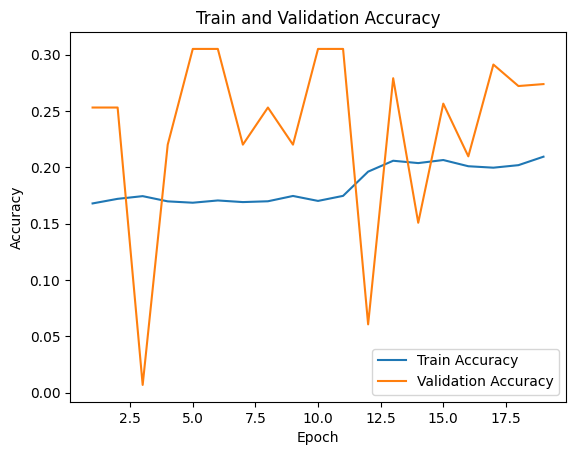

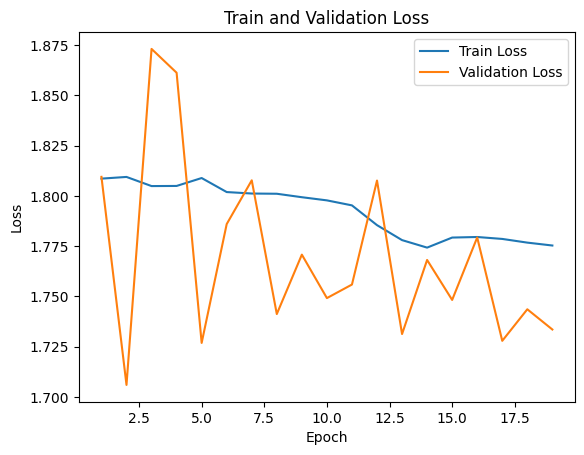

Epoch 20, Train Loss: 1.7735, Accuracy: 0.2069, F1 Score: 0.1056
Train F1 Score Per Class  [0.         0.         0.         0.3072857  0.31097225 0.        ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.44it/s, loss=1.75]

[tensor([ 0.0010,  0.0300,  0.0275,  0.1070, -0.3145, -0.0426], device='cuda:0'), tensor([-0.1563, -0.0273, -0.0518,  0.0089,  0.0510, -0.0664], device='cuda:0'), tensor([-0.1917, -0.0441, -0.0709, -0.0210,  0.1082, -0.0708], device='cuda:0'), tensor([-0.0709,  0.0038, -0.0024,  0.0607, -0.1904, -0.0601], device='cuda:0'), tensor([ 0.0264,  0.0406,  0.0269,  0.1211, -0.3954, -0.0317], device='cuda:0'), tensor([-0.1310, -0.0192, -0.0502,  0.0204, -0.0816, -0.0613], device='cuda:0'), tensor([ 0.1212,  0.0766,  0.0660,  0.1879, -0.5679, -0.0072], device='cuda:0'), tensor([-0.1622, -0.0319, -0.0348,  0.0054, -0.0273, -0.0922], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.45it/s, loss=1.77]

[tensor([ 0.0252,  0.0391,  0.0362,  0.1206, -0.3965, -0.0346], device='cuda:0'), tensor([-0.0227,  0.0207,  0.0003,  0.0907, -0.2017, -0.0555], device='cuda:0'), tensor([-0.1732, -0.0344, -0.0538, -0.0052,  0.0704, -0.0859], device='cuda:0'), tensor([ 0.0099,  0.0332,  0.0339,  0.1131, -0.3547, -0.0456], device='cuda:0'), tensor([-0.0566,  0.0110,  0.0016,  0.0745, -0.2990, -0.0563], device='cuda:0'), tensor([-0.0771,  0.0018, -0.0012,  0.0615, -0.2622, -0.0723], device='cuda:0'), tensor([ 0.0529,  0.0519,  0.0363,  0.1424, -0.5691, -0.0165], device='cuda:0'), tensor([ 0.0046,  0.0322,  0.0236,  0.1086, -0.3535, -0.0375], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=1.75]

[tensor([ 0.0941,  0.0662,  0.0486,  0.1641, -0.6005,  0.0011], device='cuda:0'), tensor([-0.1003, -0.0078, -0.0112,  0.0432, -0.0804, -0.0725], device='cuda:0'), tensor([ 0.0458,  0.0464,  0.0425,  0.1334, -0.5611, -0.0261], device='cuda:0'), tensor([-0.1301, -0.0183, -0.0398,  0.0231, -0.3461, -0.0581], device='cuda:0'), tensor([ 0.0090,  0.0336,  0.0305,  0.1139, -0.3091, -0.0478], device='cuda:0'), tensor([-0.0746,  0.0011, -0.0070,  0.0548, -0.2852, -0.0604], device='cuda:0'), tensor([ 0.0397,  0.0466,  0.0342,  0.1352, -0.3425, -0.0406], device='cuda:0'), tensor([-0.0578,  0.0082,  0.0060,  0.0708, -0.2140, -0.0667], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.42it/s, loss=1.71]

[tensor([ 0.0607,  0.0531,  0.0376,  0.1413, -0.3941, -0.0121], device='cuda:0'), tensor([-0.1219, -0.0142, -0.0150,  0.0356, -0.1987, -0.0882], device='cuda:0'), tensor([ 0.1057,  0.0713,  0.0559,  0.1778, -0.5211, -0.0082], device='cuda:0'), tensor([ 0.0495,  0.0496,  0.0405,  0.1368, -0.4199, -0.0241], device='cuda:0'), tensor([-0.1486, -0.0267, -0.0617,  0.0086,  0.0707, -0.0687], device='cuda:0'), tensor([ 0.1302,  0.0788,  0.0605,  0.1837, -0.6315,  0.0073], device='cuda:0'), tensor([ 0.1018,  0.0672,  0.0592,  0.1660, -0.5129, -0.0068], device='cuda:0'), tensor([-0.0166,  0.0228,  0.0111,  0.0906, -0.4898, -0.0393], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=1.8]

[tensor([-0.0801,  0.0016, -0.0031,  0.0617, -0.0755, -0.0718], device='cuda:0'), tensor([ 0.1287,  0.0827,  0.0508,  0.1942, -0.7467,  0.0166], device='cuda:0'), tensor([-0.1993, -0.0488, -0.0696, -0.0300,  0.1613, -0.0872], device='cuda:0'), tensor([-0.1141, -0.0134, -0.0155,  0.0331, -0.0547, -0.0756], device='cuda:0'), tensor([-0.0248,  0.0209,  0.0184,  0.0898, -0.3538, -0.0491], device='cuda:0'), tensor([-0.1234, -0.0168, -0.0353,  0.0233, -0.0438, -0.0578], device='cuda:0'), tensor([-0.1498, -0.0258, -0.0289,  0.0156, -0.0366, -0.0930], device='cuda:0'), tensor([-0.4828, -0.1290, -0.2401, -0.0561,  1.0349, -0.2678], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.40it/s, loss=1.71]

[tensor([-0.0666,  0.0051,  0.0115,  0.0720, -0.2550, -0.0827], device='cuda:0'), tensor([ 9.7990e-02,  6.8809e-02,  4.9179e-02,  1.7140e-01, -5.4271e-01,
         1.9235e-04], device='cuda:0'), tensor([-0.1202, -0.0158, -0.0254,  0.0250, -0.1762, -0.0620], device='cuda:0'), tensor([ 0.1067,  0.0709,  0.0624,  0.1768, -0.6110, -0.0178], device='cuda:0'), tensor([-0.0402,  0.0157,  0.0141,  0.0845, -0.3449, -0.0602], device='cuda:0'), tensor([-0.1131, -0.0122, -0.0201,  0.0351, -0.0517, -0.0776], device='cuda:0'), tensor([-0.0286,  0.0186,  0.0207,  0.0903, -0.3622, -0.0592], device='cuda:0'), tensor([ 0.0588,  0.0539,  0.0401,  0.1474, -0.6586, -0.0164], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=1.75]

[tensor([-0.0132,  0.0253,  0.0184,  0.0969, -0.3196, -0.0419], device='cuda:0'), tensor([ 0.0294,  0.0411,  0.0330,  0.1218, -0.3218, -0.0480], device='cuda:0'), tensor([-0.1561, -0.0304, -0.0362,  0.0031,  0.0449, -0.0783], device='cuda:0'), tensor([-0.2675, -0.0715, -0.0927, -0.0652,  0.2741, -0.1054], device='cuda:0'), tensor([-0.0673,  0.0061,  0.0033,  0.0670, -0.2386, -0.0692], device='cuda:0'), tensor([-0.1434, -0.0257, -0.0377,  0.0114, -0.0984, -0.0705], device='cuda:0'), tensor([ 0.1036,  0.0696,  0.0508,  0.1705, -0.6331, -0.0030], device='cuda:0'), tensor([-0.0850, -0.0006, -0.0023,  0.0561, -0.1459, -0.0771], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=1.7]

[tensor([-0.0501,  0.0112,  0.0072,  0.0741, -0.3040, -0.0564], device='cuda:0'), tensor([-0.1912, -0.0425, -0.0741, -0.0169,  0.0497, -0.0856], device='cuda:0'), tensor([-0.0158,  0.0236, -0.0010,  0.0872, -0.2104, -0.0283], device='cuda:0'), tensor([ 0.0775,  0.0600,  0.0478,  0.1557, -0.5109, -0.0129], device='cuda:0'), tensor([ 0.0369,  0.0446,  0.0354,  0.1295, -0.4530, -0.0273], device='cuda:0'), tensor([ 0.0235,  0.0384,  0.0379,  0.1209, -0.3214, -0.0383], device='cuda:0'), tensor([ 0.0344,  0.0445,  0.0410,  0.1384, -0.3966, -0.0492], device='cuda:0'), tensor([-0.0562,  0.0088, -0.0011,  0.0697, -0.4348, -0.0568], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=1.74]

[tensor([-0.0254,  0.0194,  0.0159,  0.0836, -0.2445, -0.0410], device='cuda:0'), tensor([-0.0883, -0.0043, -0.0217,  0.0421, -0.0835, -0.0573], device='cuda:0'), tensor([-0.1544, -0.0286, -0.0444,  0.0058, -0.0323, -0.0815], device='cuda:0'), tensor([-0.1072, -0.0085, -0.0100,  0.0459, -0.2430, -0.0857], device='cuda:0'), tensor([ 0.0735,  0.0696,  0.0255,  0.1808, -0.5471, -0.0150], device='cuda:0'), tensor([-0.0093,  0.0267,  0.0161,  0.0972, -0.3545, -0.0338], device='cuda:0'), tensor([-0.0983, -0.0068, -0.0219,  0.0395, -0.0901, -0.0509], device='cuda:0'), tensor([-0.1534, -0.0284, -0.0446,  0.0068,  0.0531, -0.0631], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=1.76]

[tensor([-0.0785,  0.0016, -0.0045,  0.0619, -0.1480, -0.0826], device='cuda:0'), tensor([ 0.0042,  0.0340,  0.0234,  0.1135, -0.3367, -0.0396], device='cuda:0'), tensor([ 0.1094,  0.0699,  0.0601,  0.1727, -0.7453, -0.0056], device='cuda:0'), tensor([-0.0999, -0.0066, -0.0194,  0.0422, -0.0641, -0.0634], device='cuda:0'), tensor([-0.1859, -0.0396, -0.0632, -0.0139,  0.2342, -0.0782], device='cuda:0'), tensor([ 0.0268,  0.0402,  0.0304,  0.1198, -0.4021, -0.0256], device='cuda:0'), tensor([-0.2304, -0.0571, -0.0628, -0.0407, -0.0402, -0.1061], device='cuda:0'), tensor([ 0.0513,  0.0494,  0.0398,  0.1368, -0.3847, -0.0270], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=1.83]

[tensor([-0.0299,  0.0213,  0.0079,  0.0936, -0.4803, -0.0455], device='cuda:0'), tensor([ 0.0781,  0.0587,  0.0476,  0.1523, -0.5019, -0.0113], device='cuda:0'), tensor([-0.0304,  0.0178,  0.0098,  0.0856, -0.4998, -0.0420], device='cuda:0'), tensor([-0.0535,  0.0088, -0.0060,  0.0675, -0.4199, -0.0525], device='cuda:0'), tensor([-0.0655,  0.0050,  0.0004,  0.0627, -0.0974, -0.0639], device='cuda:0'), tensor([-0.1756, -0.0372, -0.0539, -0.0091,  0.0098, -0.0774], device='cuda:0'), tensor([-0.1125, -0.0140, -0.0165,  0.0308, -0.0535, -0.0762], device='cuda:0'), tensor([-0.0429,  0.0133,  0.0076,  0.0769, -0.2266, -0.0456], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=1.71]

[tensor([-0.1375, -0.0209, -0.0432,  0.0182,  0.0601, -0.0687], device='cuda:0'), tensor([-0.0243,  0.0211,  0.0074,  0.0944, -0.2909, -0.0295], device='cuda:0'), tensor([ 0.0780,  0.0605,  0.0539,  0.1616, -0.6253, -0.0227], device='cuda:0'), tensor([-0.1356, -0.0212, -0.0346,  0.0170,  0.0356, -0.0698], device='cuda:0'), tensor([-0.0666,  0.0052, -0.0098,  0.0631, -0.3867, -0.0475], device='cuda:0'), tensor([ 0.0563,  0.0508,  0.0467,  0.1429, -0.3607, -0.0265], device='cuda:0'), tensor([ 0.0782,  0.0591,  0.0515,  0.1530, -0.5552, -0.0143], device='cuda:0'), tensor([-0.0835, -0.0026, -0.0098,  0.0500, -0.3257, -0.0568], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.74]

[tensor([ 0.0222,  0.0376,  0.0318,  0.1163, -0.3216, -0.0397], device='cuda:0'), tensor([-0.0134,  0.0252,  0.0186,  0.0996, -0.4117, -0.0515], device='cuda:0'), tensor([-0.0851, -0.0029, -0.0187,  0.0472, -0.1129, -0.0422], device='cuda:0'), tensor([-0.2144, -0.0505, -0.1128, -0.0224,  0.0792, -0.0809], device='cuda:0'), tensor([-0.0710,  0.0036, -0.0102,  0.0618, -0.1592, -0.0686], device='cuda:0'), tensor([ 0.0283,  0.0409,  0.0307,  0.1227, -0.4214, -0.0279], device='cuda:0'), tensor([-0.1160, -0.0149, -0.0692,  0.0251,  0.0194, -0.0607], device='cuda:0'), tensor([-0.0693,  0.0038, -0.0111,  0.0574, -0.1669, -0.0464], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.40it/s, loss=1.73]

[tensor([-0.0894, -0.0038, -0.0168,  0.0466,  0.0056, -0.0521], device='cuda:0'), tensor([-0.0133,  0.0252,  0.0255,  0.1002, -0.2692, -0.0537], device='cuda:0'), tensor([-0.0787,  0.0008, -0.0024,  0.0568, -0.0547, -0.0659], device='cuda:0'), tensor([ 0.0262,  0.0404,  0.0297,  0.1200, -0.3973, -0.0247], device='cuda:0'), tensor([-0.1052, -0.0098, -0.0121,  0.0391, -0.0495, -0.0765], device='cuda:0'), tensor([-0.0592,  0.0081,  0.0037,  0.0716, -0.0545, -0.0674], device='cuda:0'), tensor([-0.0751,  0.0017, -0.0107,  0.0578, -0.0568, -0.0659], device='cuda:0'), tensor([-0.0602,  0.0083,  0.0060,  0.0755, -0.4370, -0.0720], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=1.78]

[tensor([-0.0069,  0.0284,  0.0205,  0.1082, -0.3055, -0.0531], device='cuda:0'), tensor([-0.0674,  0.0052,  0.0030,  0.0669, -0.2439, -0.0634], device='cuda:0'), tensor([-0.0572,  0.0089,  0.0073,  0.0722, -0.1815, -0.0638], device='cuda:0'), tensor([-8.1631e-02, -9.2488e-05, -1.1702e-03,  5.6494e-02, -3.5232e-01,
        -6.8650e-02], device='cuda:0'), tensor([ 0.0160,  0.0373,  0.0070,  0.1124, -0.3645, -0.0361], device='cuda:0'), tensor([-0.1074, -0.0105, -0.0226,  0.0378, -0.2206, -0.0707], device='cuda:0'), tensor([-0.0236,  0.0225,  0.0174,  0.0969, -0.1739, -0.0567], device='cuda:0'), tensor([-0.1353, -0.0205, -0.0379,  0.0191,  0.0862, -0.0691], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.40it/s, loss=1.76]

[tensor([-0.1393, -0.0231, -0.0297,  0.0138, -0.4212, -0.0691], device='cuda:0'), tensor([-0.0667,  0.0051, -0.0007,  0.0654, -0.0112, -0.0656], device='cuda:0'), tensor([-0.1040, -0.0103, -0.0299,  0.0329, -0.2700, -0.0460], device='cuda:0'), tensor([-0.1220, -0.0162, -0.1046,  0.0239, -0.0039, -0.0456], device='cuda:0'), tensor([-0.0547,  0.0095,  0.0066,  0.0728, -0.1677, -0.0590], device='cuda:0'), tensor([-0.0322,  0.0174,  0.0043,  0.0838, -0.3050, -0.0485], device='cuda:0'), tensor([-0.0393,  0.0158,  0.0137,  0.0831, -0.2024, -0.0585], device='cuda:0'), tensor([-0.0942, -0.0068, -0.0189,  0.0409, -0.3023, -0.0459], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=1.79]

[tensor([-0.2168, -0.0522, -0.0559, -0.0331,  0.2407, -0.0990], device='cuda:0'), tensor([-0.0787,  0.0026, -0.0109,  0.0603, -0.3917, -0.0604], device='cuda:0'), tensor([ 0.0379,  0.0446,  0.0349,  0.1291, -0.5724, -0.0219], device='cuda:0'), tensor([-0.1251, -0.0190, -0.0415,  0.0188, -0.0631, -0.0580], device='cuda:0'), tensor([-0.0298,  0.0175,  0.0203,  0.0831, -0.2548, -0.0547], device='cuda:0'), tensor([-0.0758,  0.0035, -0.0041,  0.0640, -0.1767, -0.0697], device='cuda:0'), tensor([-0.3100, -0.0690, -0.1877, -0.0012,  0.1662, -0.1504], device='cuda:0'), tensor([-0.0715,  0.0026, -0.0132,  0.0556, -0.2854, -0.0445], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.40it/s, loss=1.77]

[tensor([-0.1713, -0.0360, -0.0517, -0.0090,  0.3004, -0.0732], device='cuda:0'), tensor([ 0.0617,  0.0533,  0.0324,  0.1403, -0.4500, -0.0105], device='cuda:0'), tensor([-0.2367, -0.0604, -0.0795, -0.0463,  0.2085, -0.1061], device='cuda:0'), tensor([-0.0525,  0.0101,  0.0017,  0.0719, -0.4437, -0.0578], device='cuda:0'), tensor([-0.0471,  0.0129,  0.0096,  0.0787, -0.1354, -0.0653], device='cuda:0'), tensor([-0.0114,  0.0259,  0.0207,  0.1023, -0.2998, -0.0551], device='cuda:0'), tensor([-0.0911, -0.0033, -0.0179,  0.0516, -0.1176, -0.0652], device='cuda:0'), tensor([-0.2034, -0.0464, -0.0777, -0.0240,  0.0898, -0.0928], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.41it/s, loss=1.77]

[tensor([-0.0745,  0.0021, -0.0193,  0.0557, -0.2973, -0.0469], device='cuda:0'), tensor([-0.1941, -0.0423, -0.0672, -0.0162,  0.2007, -0.0779], device='cuda:0'), tensor([-0.1150, -0.0156, -0.0237,  0.0258, -0.1005, -0.0595], device='cuda:0'), tensor([-0.0111,  0.0268,  0.0142,  0.0976, -0.2568, -0.0449], device='cuda:0'), tensor([-0.1364, -0.0208, -0.0403,  0.0184, -0.1545, -0.0622], device='cuda:0'), tensor([-0.1447, -0.0247, -0.0267,  0.0156, -0.0760, -0.0838], device='cuda:0'), tensor([-0.2733, -0.0757, -0.0722, -0.0703,  0.1604, -0.1240], device='cuda:0'), tensor([-0.0803,  0.0015, -0.0248,  0.0608, -0.3053, -0.0611], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.41it/s, loss=1.73]

[tensor([-0.1187, -0.0149, -0.0579,  0.0294, -0.1136, -0.0732], device='cuda:0'), tensor([-0.1125, -0.0139, -0.0251,  0.0273, -0.0174, -0.0537], device='cuda:0'), tensor([-6.8801e-02,  6.4504e-03, -3.9941e-04,  7.0928e-02, -4.3031e-01,
        -6.8109e-02], device='cuda:0'), tensor([-0.1337, -0.0198, -0.0423,  0.0212, -0.3781, -0.0709], device='cuda:0'), tensor([ 0.0948,  0.0657,  0.0580,  0.1680, -0.5493, -0.0137], device='cuda:0'), tensor([ 0.0219,  0.0386,  0.0295,  0.1185, -0.4851, -0.0277], device='cuda:0'), tensor([-0.0057,  0.0286,  0.0216,  0.1045, -0.2739, -0.0435], device='cuda:0'), tensor([-0.0415,  0.0152,  0.0158,  0.0833, -0.3503, -0.0661], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.40it/s, loss=1.79]

[tensor([-0.0993, -0.0082, -0.0327,  0.0365, -0.1298, -0.0730], device='cuda:0'), tensor([-0.2061, -0.0521, -0.0697, -0.0396,  0.4043, -0.0787], device='cuda:0'), tensor([ 0.0295,  0.0407,  0.0324,  0.1191, -0.4953, -0.0289], device='cuda:0'), tensor([-0.1551, -0.0288, -0.0587,  0.0039,  0.0590, -0.0776], device='cuda:0'), tensor([ 0.0332,  0.0432,  0.0316,  0.1262, -0.4836, -0.0232], device='cuda:0'), tensor([-0.1846, -0.0397, -0.0551, -0.0130,  0.0802, -0.0777], device='cuda:0'), tensor([-0.1549, -0.0293, -0.0767,  0.0007,  0.1037, -0.0598], device='cuda:0'), tensor([-0.0283,  0.0173, -0.0083,  0.0800, -0.1584, -0.0273], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.40it/s, loss=1.79]

[tensor([-0.1048, -0.0093, -0.0128,  0.0401, -0.0126, -0.0734], device='cuda:0'), tensor([-0.0954, -0.0047, -0.0178,  0.0472,  0.0457, -0.0710], device='cuda:0'), tensor([-0.1077, -0.0115, -0.0181,  0.0364, -0.1047, -0.0661], device='cuda:0'), tensor([ 0.0929,  0.0673,  0.0544,  0.1736, -0.6141, -0.0182], device='cuda:0'), tensor([-0.2434, -0.0626, -0.0909, -0.0500,  0.1454, -0.0938], device='cuda:0'), tensor([-0.1447, -0.0250, -0.0304,  0.0131, -0.1373, -0.0752], device='cuda:0'), tensor([-0.2010, -0.0444, -0.0595, -0.0184,  0.1722, -0.0930], device='cuda:0'), tensor([-0.1893, -0.0417, -0.0535, -0.0153,  0.1312, -0.0842], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.41it/s, loss=1.72]

[tensor([ 0.0871,  0.0629,  0.0597,  0.1630, -0.4896, -0.0237], device='cuda:0'), tensor([-0.0252,  0.0207,  0.0173,  0.0892, -0.2218, -0.0479], device='cuda:0'), tensor([ 0.1534,  0.0888,  0.0650,  0.2036, -0.7305,  0.0183], device='cuda:0'), tensor([ 0.0324,  0.0411,  0.0280,  0.1240, -0.5293, -0.0185], device='cuda:0'), tensor([-0.0012,  0.0299,  0.0215,  0.1054, -0.3596, -0.0375], device='cuda:0'), tensor([ 0.0155,  0.0359,  0.0308,  0.1188, -0.2874, -0.0409], device='cuda:0'), tensor([ 0.0483,  0.0478,  0.0402,  0.1351, -0.4059, -0.0238], device='cuda:0'), tensor([-0.1430, -0.0247, -0.0404,  0.0082,  0.1608, -0.0817], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.41it/s, loss=1.77]

[tensor([-0.1543, -0.0293, -0.0303,  0.0060, -0.0576, -0.0867], device='cuda:0'), tensor([ 0.0878,  0.0626,  0.0515,  0.1584, -0.5270, -0.0079], device='cuda:0'), tensor([ 0.1319,  0.0789,  0.0601,  0.1832, -0.6145,  0.0087], device='cuda:0'), tensor([-0.0906, -0.0055, -0.0117,  0.0451, -0.3151, -0.0562], device='cuda:0'), tensor([-0.0572,  0.0087,  0.0103,  0.0743, -0.2032, -0.0684], device='cuda:0'), tensor([-0.0555,  0.0089, -0.0010,  0.0718, -0.3086, -0.0647], device='cuda:0'), tensor([-0.1899, -0.0371, -0.0680, -0.0040,  0.0354, -0.0763], device='cuda:0'), tensor([-0.2216, -0.0554, -0.0867, -0.0387,  0.2834, -0.0950], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.41it/s, loss=1.67]

[tensor([-0.8880, -0.3270, -0.5441, -0.4633,  0.4463, -0.2670], device='cuda:0'), tensor([-0.0890, -0.0030, -0.0093,  0.0508, -0.0256, -0.0822], device='cuda:0'), tensor([ 0.0624,  0.0501,  0.0259,  0.1288, -0.6455, -0.0083], device='cuda:0'), tensor([-0.1060, -0.0092, -0.0151,  0.0422, -0.0996, -0.0727], device='cuda:0'), tensor([-0.0260,  0.0199,  0.0096,  0.0883, -0.4226, -0.0366], device='cuda:0'), tensor([ 0.0544,  0.0507,  0.0433,  0.1396, -0.4101, -0.0235], device='cuda:0'), tensor([-0.1486, -0.0259, -0.0497,  0.0077, -0.0173, -0.0574], device='cuda:0'), tensor([-0.1321, -0.0234, -0.0389,  0.0106, -0.1038, -0.0435], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.41it/s, loss=1.72]

[tensor([-0.0208,  0.0230,  0.0127,  0.0928, -0.4147, -0.0407], device='cuda:0'), tensor([-0.0126,  0.0274,  0.0199,  0.1039, -0.4364, -0.0511], device='cuda:0'), tensor([ 0.1021,  0.0704,  0.0569,  0.1763, -0.6236, -0.0114], device='cuda:0'), tensor([-0.0965, -0.0067, -0.0475,  0.0411, -0.0266, -0.0536], device='cuda:0'), tensor([ 0.0232,  0.0382,  0.0290,  0.1171, -0.3167, -0.0240], device='cuda:0'), tensor([-0.0229,  0.0219,  0.0222,  0.0949, -0.5319, -0.0595], device='cuda:0'), tensor([-0.0480,  0.0122,  0.0097,  0.0749, -0.1168, -0.0591], device='cuda:0'), tensor([-0.1944, -0.0451, -0.0562, -0.0237, -0.0800, -0.0798], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.41it/s, loss=1.75]

[tensor([ 0.0304,  0.0425,  0.0385,  0.1306, -0.4892, -0.0423], device='cuda:0'), tensor([-0.0725,  0.0015, -0.0162,  0.0532, -0.0793, -0.0436], device='cuda:0'), tensor([-0.0663,  0.0053, -0.0056,  0.0646, -0.3107, -0.0537], device='cuda:0'), tensor([ 0.1336,  0.0936,  0.0467,  0.2243, -0.5447, -0.0059], device='cuda:0'), tensor([ 0.0105,  0.0340,  0.0263,  0.1109, -0.2550, -0.0374], device='cuda:0'), tensor([-0.1084, -0.0127, -0.0147,  0.0330,  0.0377, -0.0727], device='cuda:0'), tensor([-0.0877, -0.0020, -0.0055,  0.0543, -0.1467, -0.0723], device='cuda:0'), tensor([-0.0869, -0.0033, -0.0163,  0.0466, -0.0261, -0.0631], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.41it/s, loss=1.74]

[tensor([-0.0495,  0.0111,  0.0081,  0.0714, -0.1898, -0.0540], device='cuda:0'), tensor([ 0.1306,  0.0803,  0.0528,  0.1906, -0.6949,  0.0232], device='cuda:0'), tensor([-0.1112, -0.0119, -0.0161,  0.0360, -0.0362, -0.0721], device='cuda:0'), tensor([-0.0290,  0.0224,  0.0096,  0.0965, -0.2554, -0.0549], device='cuda:0'), tensor([-0.0547,  0.0101, -0.0083,  0.0730, -0.1335, -0.0643], device='cuda:0'), tensor([-0.1259, -0.0161, -0.0181,  0.0328, -0.0679, -0.0861], device='cuda:0'), tensor([-0.1115, -0.0130, -0.0254,  0.0288, -0.0881, -0.0606], device='cuda:0'), tensor([-0.0377,  0.0155,  0.0143,  0.0820, -0.2101, -0.0556], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.40it/s, loss=1.77]

[tensor([-0.0298,  0.0190,  0.0149,  0.0919, -0.2218, -0.0653], device='cuda:0'), tensor([ 0.0101,  0.0348,  0.0289,  0.1134, -0.4583, -0.0418], device='cuda:0'), tensor([-0.1755, -0.0369, -0.0449, -0.0101,  0.2505, -0.0824], device='cuda:0'), tensor([ 0.0773,  0.0609,  0.0405,  0.1571, -0.5046, -0.0090], device='cuda:0'), tensor([-0.0886, -0.0056, -0.0144,  0.0439, -0.1621, -0.0557], device='cuda:0'), tensor([ 0.0281,  0.0395,  0.0385,  0.1213, -0.3325, -0.0369], device='cuda:0'), tensor([-0.1479, -0.0257, -0.0413,  0.0096,  0.1809, -0.0875], device='cuda:0'), tensor([ 0.0115,  0.0331,  0.0295,  0.1084, -0.4363, -0.0328], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.40it/s, loss=1.77]

[tensor([ 0.0150,  0.0355,  0.0282,  0.1116, -0.3661, -0.0337], device='cuda:0'), tensor([-0.1324, -0.0199, -0.0426,  0.0208, -0.0589, -0.0685], device='cuda:0'), tensor([ 0.0609,  0.0538,  0.0418,  0.1473, -0.4689, -0.0245], device='cuda:0'), tensor([-0.1773, -0.0373, -0.0361, -0.0059,  0.0630, -0.0990], device='cuda:0'), tensor([ 0.0510,  0.0500,  0.0335,  0.1374, -0.5262, -0.0099], device='cuda:0'), tensor([-0.0212,  0.0228,  0.0100,  0.0949, -0.2940, -0.0387], device='cuda:0'), tensor([-0.1346, -0.0190, -0.0459,  0.0228,  0.0076, -0.0614], device='cuda:0'), tensor([-0.1749, -0.0362, -0.0631, -0.0064,  0.0861, -0.0826], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.40it/s, loss=1.74]

[tensor([ 0.0339,  0.0437,  0.0411,  0.1323, -0.4155, -0.0411], device='cuda:0'), tensor([ 0.1426,  0.0834,  0.0687,  0.1933, -0.6223,  0.0102], device='cuda:0'), tensor([-0.0216,  0.0235,  0.0129,  0.0972, -0.2798, -0.0496], device='cuda:0'), tensor([-0.0890, -0.0040, -0.0090,  0.0484, -0.1054, -0.0642], device='cuda:0'), tensor([ 0.0303,  0.0419,  0.0344,  0.1277, -0.4337, -0.0345], device='cuda:0'), tensor([-0.1150, -0.0134, -0.0191,  0.0324, -0.1387, -0.0702], device='cuda:0'), tensor([ 0.0224,  0.0390,  0.0222,  0.1199, -0.4628, -0.0195], device='cuda:0'), tensor([-0.0009,  0.0301,  0.0191,  0.1025, -0.3114, -0.0590], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=1.73]

[tensor([-0.0544,  0.0116,  0.0060,  0.0777, -0.3598, -0.0618], device='cuda:0'), tensor([-0.0612,  0.0075,  0.0038,  0.0679, -0.4823, -0.0578], device='cuda:0'), tensor([-0.0342,  0.0177,  0.0131,  0.0861, -0.3071, -0.0523], device='cuda:0'), tensor([-0.1427, -0.0235, -0.0282,  0.0167,  0.1123, -0.0898], device='cuda:0'), tensor([-0.0070,  0.0272,  0.0214,  0.0990, -0.2808, -0.0388], device='cuda:0'), tensor([ 0.1900,  0.1040,  0.0737,  0.2327, -0.9143,  0.0085], device='cuda:0'), tensor([-0.0689,  0.0043,  0.0051,  0.0666, -0.0496, -0.0729], device='cuda:0'), tensor([ 0.0468,  0.0492,  0.0435,  0.1428, -0.5177, -0.0381], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=1.72]

[tensor([-0.1072, -0.0092, -0.0192,  0.0419, -0.0753, -0.0711], device='cuda:0'), tensor([ 0.1049,  0.0706,  0.0608,  0.1771, -0.4884, -0.0153], device='cuda:0'), tensor([ 0.1091,  0.0709,  0.0638,  0.1776, -0.5812, -0.0115], device='cuda:0'), tensor([ 0.0708,  0.0573,  0.0474,  0.1532, -0.6572, -0.0177], device='cuda:0'), tensor([-0.1450, -0.0235, -0.0520,  0.0150, -0.0113, -0.0816], device='cuda:0'), tensor([ 0.0205,  0.0383,  0.0229,  0.1198, -0.4466, -0.0345], device='cuda:0'), tensor([-0.0897, -0.0043, -0.0093,  0.0462, -0.2496, -0.0717], device='cuda:0'), tensor([-0.0791,  0.0013, -0.0063,  0.0585, -0.0222, -0.0708], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.39it/s, loss=1.7]

[tensor([ 0.0750,  0.0582,  0.0514,  0.1554, -0.5132, -0.0297], device='cuda:0'), tensor([ 0.0598,  0.0530,  0.0465,  0.1454, -0.4488, -0.0273], device='cuda:0'), tensor([ 0.0607,  0.0528,  0.0414,  0.1409, -0.4366, -0.0139], device='cuda:0'), tensor([-0.0230,  0.0212,  0.0194,  0.0913, -0.2895, -0.0505], device='cuda:0'), tensor([-0.1887, -0.0415, -0.0561, -0.0156, -0.3538, -0.0809], device='cuda:0'), tensor([ 0.0066,  0.0332,  0.0302,  0.1156, -0.4131, -0.0506], device='cuda:0'), tensor([-0.1145, -0.0139, -0.0326,  0.0271, -0.0050, -0.0679], device='cuda:0'), tensor([-0.0420,  0.0137, -0.0010,  0.0762, -0.5440, -0.0367], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=1.72]

[tensor([-0.2903, -0.0629, -0.1785,  0.0319, -0.0672, -0.2110], device='cuda:0'), tensor([ 0.1104,  0.0719,  0.0568,  0.1726, -0.6478,  0.0107], device='cuda:0'), tensor([-0.0095,  0.0271,  0.0196,  0.1024, -0.3138, -0.0418], device='cuda:0'), tensor([ 0.0583,  0.0542,  0.0433,  0.1500, -0.6794, -0.0356], device='cuda:0'), tensor([-0.0922, -0.0038, -0.0792,  0.0510, -0.1116, -0.0310], device='cuda:0'), tensor([ 0.0653,  0.0551,  0.0452,  0.1480, -0.5024, -0.0216], device='cuda:0'), tensor([-0.0391,  0.0181,  0.0076,  0.0894, -0.3071, -0.0589], device='cuda:0'), tensor([ 0.0962,  0.0679,  0.0604,  0.1751, -0.5053, -0.0189], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=1.72]

[tensor([-0.0082,  0.0274,  0.0172,  0.1015, -0.2353, -0.0460], device='cuda:0'), tensor([-0.0601,  0.0082, -0.0103,  0.0667, -0.4702, -0.0462], device='cuda:0'), tensor([-0.1215, -0.0165, -0.0182,  0.0284, -0.1123, -0.0803], device='cuda:0'), tensor([-0.0369,  0.0176,  0.0138,  0.0862, -0.4943, -0.0597], device='cuda:0'), tensor([-0.1019, -0.0076, -0.0140,  0.0456, -0.1680, -0.0709], device='cuda:0'), tensor([-0.2041, -0.0460, -0.0544, -0.0209,  0.0049, -0.0969], device='cuda:0'), tensor([-0.0112,  0.0261,  0.0190,  0.0980, -0.4066, -0.0407], device='cuda:0'), tensor([ 0.0070,  0.0329,  0.0264,  0.1122, -0.2915, -0.0365], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.39it/s, loss=1.75]

[tensor([-0.0625,  0.0071, -0.0041,  0.0680, -0.4221, -0.0505], device='cuda:0'), tensor([ 0.0193,  0.0363,  0.0268,  0.1121, -0.3865, -0.0207], device='cuda:0'), tensor([ 0.1524,  0.0877,  0.0728,  0.2041, -0.6477,  0.0119], device='cuda:0'), tensor([-0.1118, -0.0121, -0.0200,  0.0355, -0.0357, -0.0742], device='cuda:0'), tensor([-0.0052,  0.0275,  0.0241,  0.1008, -0.1945, -0.0436], device='cuda:0'), tensor([-0.0569,  0.0092,  0.0019,  0.0705, -0.1803, -0.0624], device='cuda:0'), tensor([-0.1480, -0.0263, -0.0354,  0.0084,  0.1644, -0.0740], device='cuda:0'), tensor([-0.1341, -0.0224, -0.0316,  0.0177, -0.0273, -0.0745], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.39it/s, loss=1.76]

[tensor([-0.1920, -0.0422, -0.0575, -0.0158,  0.0821, -0.0957], device='cuda:0'), tensor([-0.0800, -0.0001, -0.0096,  0.0538, -0.0530, -0.0553], device='cuda:0'), tensor([-1.1434e-04,  3.0161e-02,  2.8432e-02,  1.0764e-01, -3.5526e-01,
        -4.7506e-02], device='cuda:0'), tensor([-0.0829, -0.0021, -0.0132,  0.0493, -0.3140, -0.0456], device='cuda:0'), tensor([-0.0259,  0.0204,  0.0146,  0.0882, -0.3995, -0.0462], device='cuda:0'), tensor([-0.0257,  0.0205,  0.0178,  0.0919, -0.1628, -0.0611], device='cuda:0'), tensor([-0.0478,  0.0128,  0.0029,  0.0762, -0.2890, -0.0529], device='cuda:0'), tensor([-1.0861, -0.4377, -0.5052, -0.7036,  0.2140, -0.3495], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.40it/s, loss=1.72]

[tensor([ 0.0617,  0.0533,  0.0276,  0.1393, -0.5451,  0.0035], device='cuda:0'), tensor([-0.0336,  0.0174,  0.0078,  0.0820, -0.2178, -0.0448], device='cuda:0'), tensor([-0.1687, -0.0355, -0.0352, -0.0050,  0.1258, -0.0932], device='cuda:0'), tensor([ 0.0650,  0.0544,  0.0450,  0.1448, -0.4117, -0.0184], device='cuda:0'), tensor([-0.0884, -0.0041, -0.0263,  0.0432, -0.1186, -0.0428], device='cuda:0'), tensor([ 0.1049,  0.0711,  0.0426,  0.1745, -0.5607,  0.0045], device='cuda:0'), tensor([ 0.0690,  0.0580,  0.0471,  0.1567, -0.3977, -0.0320], device='cuda:0'), tensor([ 0.0929,  0.0644,  0.0573,  0.1645, -0.5163, -0.0104], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.40it/s, loss=1.79]

[tensor([-0.1006, -0.0079, -0.0164,  0.0407, -0.0200, -0.0695], device='cuda:0'), tensor([ 0.0545,  0.0515,  0.0292,  0.1399, -0.4621, -0.0312], device='cuda:0'), tensor([-0.1428, -0.0264, -0.0344,  0.0097, -0.0342, -0.0732], device='cuda:0'), tensor([ 0.1263,  0.0794,  0.0577,  0.1878, -0.6866,  0.0035], device='cuda:0'), tensor([-0.0749,  0.0008, -0.0119,  0.0550,  0.0237, -0.0573], device='cuda:0'), tensor([-0.1948, -0.0439, -0.0574, -0.0187,  0.2252, -0.0859], device='cuda:0'), tensor([-0.1510, -0.0272, -0.0441,  0.0077, -0.0199, -0.0703], device='cuda:0'), tensor([-0.0817, -0.0008, -0.0104,  0.0532, -0.1472, -0.0579], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.40it/s, loss=1.76]

[tensor([-0.0146,  0.0250,  0.0223,  0.0984, -0.3547, -0.0492], device='cuda:0'), tensor([-0.1479, -0.0249, -0.0673,  0.0160,  0.0033, -0.0627], device='cuda:0'), tensor([-0.2314, -0.0573, -0.0852, -0.0377,  0.2853, -0.0928], device='cuda:0'), tensor([-0.0284,  0.0197,  0.0083,  0.0852, -0.4480, -0.0386], device='cuda:0'), tensor([-0.0084,  0.0285,  0.0230,  0.1071, -0.3251, -0.0516], device='cuda:0'), tensor([ 0.0141,  0.0362,  0.0252,  0.1159, -0.3654, -0.0303], device='cuda:0'), tensor([-0.1190, -0.0151, -0.0118,  0.0328,  0.0143, -0.0878], device='cuda:0'), tensor([-0.1376, -0.0237, -0.0241,  0.0155, -0.0256, -0.0754], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.37it/s, loss=1.73]

[tensor([ 0.0224,  0.0381,  0.0149,  0.1140, -0.3493, -0.0227], device='cuda:0'), tensor([ 0.0011,  0.0316,  0.0238,  0.1079, -0.4016, -0.0440], device='cuda:0'), tensor([-0.1157, -0.0151, -0.0302,  0.0280,  0.0067, -0.0636], device='cuda:0'), tensor([ 0.1649,  0.0932,  0.0797,  0.2153, -0.6899,  0.0077], device='cuda:0'), tensor([-0.2262, -0.0613, -0.0693, -0.0499,  0.1502, -0.0757], device='cuda:0'), tensor([-0.5447, -0.1517, -0.2723, -0.0931,  1.0635, -0.2852], device='cuda:0'), tensor([-0.1090, -0.0115, -0.0224,  0.0371, -0.1100, -0.0719], device='cuda:0'), tensor([ 0.0985,  0.0653,  0.0541,  0.1610, -0.6375,  0.0052], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.38it/s, loss=1.74]

[tensor([ 0.0724,  0.0581,  0.0472,  0.1546, -0.3870, -0.0268], device='cuda:0'), tensor([-0.1203, -0.0164, -0.0428,  0.0277, -0.0025, -0.0723], device='cuda:0'), tensor([-0.0879, -0.0036, -0.0055,  0.0502, -0.2857, -0.0777], device='cuda:0'), tensor([-0.0398,  0.0156,  0.0122,  0.0830, -0.1762, -0.0611], device='cuda:0'), tensor([-0.0879, -0.0034, -0.0206,  0.0469,  0.0244, -0.0681], device='cuda:0'), tensor([-0.0458,  0.0125,  0.0078,  0.0742, -0.1189, -0.0605], device='cuda:0'), tensor([-0.1692, -0.0340, -0.0416, -0.0036,  0.0397, -0.0776], device='cuda:0'), tensor([-0.0789,  0.0016, -0.0037,  0.0607, -0.1941, -0.0684], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.36it/s, loss=1.74]

[tensor([-0.1357, -0.0221, -0.0309,  0.0167, -0.1089, -0.0695], device='cuda:0'), tensor([-0.0824, -0.0018, -0.0102,  0.0503, -0.3267, -0.0542], device='cuda:0'), tensor([-0.1269, -0.0170, -0.0290,  0.0272, -0.3062, -0.0684], device='cuda:0'), tensor([-0.1954, -0.0438, -0.0466, -0.0160,  0.2211, -0.1024], device='cuda:0'), tensor([-0.1404, -0.0235, -0.0370,  0.0125,  0.1817, -0.0784], device='cuda:0'), tensor([-0.0993, -0.0080, -0.0316,  0.0354, -0.1456, -0.0619], device='cuda:0'), tensor([-0.0189,  0.0241,  0.0040,  0.0931, -0.5479, -0.0487], device='cuda:0'), tensor([ 0.1339,  0.0804,  0.0657,  0.1897, -0.5902,  0.0118], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=1.71]

[tensor([-0.0611,  0.0083,  0.0026,  0.0723, -0.4749, -0.0731], device='cuda:0'), tensor([ 0.0497,  0.0477,  0.0365,  0.1319, -0.4797, -0.0270], device='cuda:0'), tensor([ 0.0678,  0.0558,  0.0532,  0.1515, -0.4966, -0.0381], device='cuda:0'), tensor([-0.1597, -0.0300, -0.0437,  0.0027,  0.1449, -0.0814], device='cuda:0'), tensor([-0.1408, -0.0249, -0.0320,  0.0092,  0.0065, -0.0634], device='cuda:0'), tensor([ 0.0144,  0.0360,  0.0244,  0.1127, -0.3220, -0.0356], device='cuda:0'), tensor([ 0.0593,  0.0515,  0.0518,  0.1438, -0.4484, -0.0350], device='cuda:0'), tensor([-0.1236, -0.0165, -0.0205,  0.0284, -0.0561, -0.0797], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.36it/s, loss=1.76]

[tensor([-0.0676,  0.0038, -0.0222,  0.0603, -0.0390, -0.0565], device='cuda:0'), tensor([-0.0202,  0.0237,  0.0137,  0.0939, -0.1910, -0.0588], device='cuda:0'), tensor([ 0.0868,  0.0616,  0.0546,  0.1565, -0.5954, -0.0085], device='cuda:0'), tensor([-0.0331,  0.0166,  0.0016,  0.0810, -0.2148, -0.0557], device='cuda:0'), tensor([ 0.0401,  0.0455,  0.0436,  0.1365, -0.5246, -0.0406], device='cuda:0'), tensor([-0.2145, -0.0515, -0.0544, -0.0295, -0.0493, -0.1073], device='cuda:0'), tensor([-0.0635,  0.0056, -0.0037,  0.0620, -0.1465, -0.0615], device='cuda:0'), tensor([-0.2268, -0.0556, -0.0716, -0.0387,  0.2972, -0.1004], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=1.7]

[tensor([-0.0039,  0.0292,  0.0271,  0.1072, -0.5060, -0.0477], device='cuda:0'), tensor([-0.0564,  0.0096,  0.0048,  0.0727, -0.1620, -0.0615], device='cuda:0'), tensor([-0.0991, -0.0069, -0.0128,  0.0461, -0.2828, -0.0698], device='cuda:0'), tensor([-0.0047,  0.0273,  0.0218,  0.0972, -0.3992, -0.0374], device='cuda:0'), tensor([-0.0537,  0.0108,  0.0040,  0.0734, -0.1171, -0.0562], device='cuda:0'), tensor([ 0.0717,  0.0561,  0.0483,  0.1488, -0.5192, -0.0125], device='cuda:0'), tensor([-0.0736,  0.0020, -0.0232,  0.0539, -0.1023, -0.0418], device='cuda:0'), tensor([ 0.0548,  0.0510,  0.0491,  0.1470, -0.4694, -0.0377], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=1.75]

[tensor([-0.0398,  0.0148,  0.0086,  0.0797, -0.2165, -0.0542], device='cuda:0'), tensor([ 0.0423,  0.0459,  0.0421,  0.1343, -0.4514, -0.0308], device='cuda:0'), tensor([-0.0156,  0.0272, -0.0617,  0.0952, -0.2137, -0.0061], device='cuda:0'), tensor([-0.1393, -0.0218, -0.0281,  0.0223, -0.0012, -0.0800], device='cuda:0'), tensor([ 0.0162,  0.0360,  0.0313,  0.1147, -0.3343, -0.0331], device='cuda:0'), tensor([ 0.0393,  0.0463,  0.0377,  0.1367, -0.3413, -0.0377], device='cuda:0'), tensor([ 0.0182,  0.0355,  0.0350,  0.1210, -0.3213, -0.0572], device='cuda:0'), tensor([-0.0439,  0.0135,  0.0039,  0.0765, -0.2604, -0.0495], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.39it/s, loss=1.75]

[tensor([-0.0709,  0.0039,  0.0057,  0.0657, -0.5461, -0.0686], device='cuda:0'), tensor([ 0.0254,  0.0414,  0.0296,  0.1271, -0.4107, -0.0324], device='cuda:0'), tensor([-0.0139,  0.0240,  0.0249,  0.0980, -0.4118, -0.0506], device='cuda:0'), tensor([ 0.0750,  0.0591,  0.0437,  0.1519, -0.4924, -0.0188], device='cuda:0'), tensor([-0.0902, -0.0038, -0.0171,  0.0469, -0.1502, -0.0631], device='cuda:0'), tensor([ 0.0203,  0.0391,  0.0349,  0.1236, -0.3889, -0.0461], device='cuda:0'), tensor([-0.1909, -0.0432, -0.0690, -0.0184,  0.1077, -0.0928], device='cuda:0'), tensor([-0.1690, -0.0340, -0.0515, -0.0038,  0.0808, -0.0808], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=1.7]

[tensor([ 0.0190,  0.0371,  0.0330,  0.1178, -0.4865, -0.0375], device='cuda:0'), tensor([-0.1015, -0.0072, -0.0203,  0.0441, -0.3362, -0.0617], device='cuda:0'), tensor([-0.0172,  0.0250,  0.0165,  0.0990, -0.6092, -0.0447], device='cuda:0'), tensor([ 0.0060,  0.0328,  0.0287,  0.1105, -0.2237, -0.0454], device='cuda:0'), tensor([-0.0524,  0.0119, -0.0013,  0.0764, -0.6765, -0.0493], device='cuda:0'), tensor([-0.0549,  0.0098,  0.0068,  0.0718, -0.1295, -0.0589], device='cuda:0'), tensor([ 1.1192e-01,  7.4148e-02,  5.7576e-02,  1.8347e-01, -5.8013e-01,
         9.3333e-05], device='cuda:0'), tensor([-0.1282, -0.0182, -0.0312,  0.0219, -0.0306, -0.0653], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.40it/s, loss=1.74]

[tensor([-0.0470,  0.0123,  0.0077,  0.0754, -0.1402, -0.0542], device='cuda:0'), tensor([-0.1589, -0.0293, -0.0466,  0.0045,  0.1358, -0.0746], device='cuda:0'), tensor([ 0.0113,  0.0345,  0.0250,  0.1108, -0.3461, -0.0359], device='cuda:0'), tensor([-0.0389,  0.0170,  0.0055,  0.0832, -0.1829, -0.0523], device='cuda:0'), tensor([-0.1729, -0.0338, -0.0499, -0.0004, -0.1392, -0.0841], device='cuda:0'), tensor([-0.0046,  0.0279,  0.0122,  0.0977, -0.4269, -0.0253], device='cuda:0'), tensor([-0.0038,  0.0284,  0.0214,  0.1010, -0.3607, -0.0360], device='cuda:0'), tensor([-0.4001, -0.0996, -0.2238, -0.0323,  0.2147, -0.1940], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=1.72]

[tensor([ 0.0132,  0.0364,  0.0232,  0.1161, -0.6282, -0.0292], device='cuda:0'), tensor([-0.0757,  0.0019,  0.0009,  0.0582, -0.2813, -0.0669], device='cuda:0'), tensor([ 0.0744,  0.0594,  0.0500,  0.1568, -0.5367, -0.0199], device='cuda:0'), tensor([-0.0321,  0.0184,  0.0179,  0.0892, -0.2068, -0.0610], device='cuda:0'), tensor([ 0.0475,  0.0478,  0.0468,  0.1401, -0.5180, -0.0411], device='cuda:0'), tensor([-0.0614,  0.0065, -0.0037,  0.0641, -0.2354, -0.0475], device='cuda:0'), tensor([-0.0948, -0.0059, -0.0290,  0.0410,  0.0174, -0.0615], device='cuda:0'), tensor([-0.1109, -0.0131, -0.0156,  0.0315,  0.0405, -0.0699], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.38it/s, loss=1.78]

[tensor([-0.1781, -0.0380, -0.0452, -0.0106,  0.1525, -0.0900], device='cuda:0'), tensor([ 0.0119,  0.0352,  0.0284,  0.1151, -0.3301, -0.0382], device='cuda:0'), tensor([-0.2072, -0.0486, -0.0652, -0.0295,  0.1510, -0.1079], device='cuda:0'), tensor([-0.3638, -0.1299, -0.1220, -0.1844,  0.2247, -0.1181], device='cuda:0'), tensor([-0.0341,  0.0182,  0.0163,  0.0858, -0.4549, -0.0599], device='cuda:0'), tensor([-0.1798, -0.0387, -0.0479, -0.0099, -0.2366, -0.0819], device='cuda:0'), tensor([-0.0345,  0.0188,  0.0014,  0.0882, -0.3667, -0.0529], device='cuda:0'), tensor([ 0.0574,  0.0514,  0.0463,  0.1438, -0.3852, -0.0269], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=1.72]

[tensor([ 0.0664,  0.0554,  0.0510,  0.1512, -0.4527, -0.0280], device='cuda:0'), tensor([ 0.0356,  0.0426,  0.0399,  0.1264, -0.4562, -0.0324], device='cuda:0'), tensor([ 0.0096,  0.0354,  0.0262,  0.1170, -0.2057, -0.0478], device='cuda:0'), tensor([-0.0218,  0.0231,  0.0153,  0.0965, -0.3432, -0.0471], device='cuda:0'), tensor([-0.0780,  0.0026, -0.0029,  0.0663, -0.3363, -0.0732], device='cuda:0'), tensor([-0.1453, -0.0264, -0.0307,  0.0094, -0.3369, -0.0712], device='cuda:0'), tensor([-0.2054, -0.0462, -0.0700, -0.0205,  0.1306, -0.0886], device='cuda:0'), tensor([ 0.0133,  0.0356,  0.0327,  0.1166, -0.3970, -0.0464], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.38it/s, loss=1.81]

[tensor([-0.1442, -0.0243, -0.0414,  0.0114,  0.0372, -0.0678], device='cuda:0'), tensor([-0.1586, -0.0308, -0.0380,  0.0015,  0.0831, -0.0764], device='cuda:0'), tensor([-0.1072, -0.0099, -0.0239,  0.0345, -0.0054, -0.0575], device='cuda:0'), tensor([-0.2086, -0.0492, -0.0598, -0.0274,  0.1414, -0.0930], device='cuda:0'), tensor([-0.0915, -0.0058, -0.0118,  0.0428,  0.0129, -0.0593], device='cuda:0'), tensor([-0.1567, -0.0284, -0.0501,  0.0068,  0.0253, -0.0719], device='cuda:0'), tensor([-0.7047, -0.3080, -0.2891, -0.5117,  0.2948, -0.2421], device='cuda:0'), tensor([ 0.1274,  0.0787,  0.0680,  0.1899, -0.6112, -0.0028], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=1.74]

[tensor([ 0.0744,  0.0586,  0.0461,  0.1524, -0.4925, -0.0082], device='cuda:0'), tensor([-0.0615,  0.0072, -0.0042,  0.0662, -0.1378, -0.0475], device='cuda:0'), tensor([ 0.0378,  0.0441,  0.0385,  0.1309, -0.3234, -0.0382], device='cuda:0'), tensor([-0.0939, -0.0050, -0.0157,  0.0450, -0.3372, -0.0568], device='cuda:0'), tensor([-0.0844, -0.0029, -0.0235,  0.0460, -0.1596, -0.0473], device='cuda:0'), tensor([-0.1012, -0.0063, -0.0918,  0.0459, -0.2025, -0.0396], device='cuda:0'), tensor([-0.0700,  0.0048, -0.0046,  0.0677, -0.1709, -0.0653], device='cuda:0'), tensor([-0.1012, -0.0091, -0.0113,  0.0414, -0.1355, -0.0698], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.38it/s, loss=1.73]

[tensor([-0.1334, -0.0214, -0.0284,  0.0153,  0.0317, -0.0691], device='cuda:0'), tensor([ 0.0763,  0.0604,  0.0454,  0.1586, -0.5086, -0.0113], device='cuda:0'), tensor([ 0.0168,  0.0369,  0.0289,  0.1167, -0.3752, -0.0337], device='cuda:0'), tensor([ 0.0649,  0.0547,  0.0503,  0.1494, -0.6429, -0.0238], device='cuda:0'), tensor([-0.0023,  0.0291,  0.0129,  0.1011, -0.1935, -0.0418], device='cuda:0'), tensor([-0.0567,  0.0099, -0.0049,  0.0716, -0.2910, -0.0494], device='cuda:0'), tensor([-0.1974, -0.0443, -0.0665, -0.0170, -0.0560, -0.0771], device='cuda:0'), tensor([-0.1583, -0.0302, -0.0326,  0.0073,  0.1693, -0.0905], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=1.78]

[tensor([-0.0936, -0.0062, -0.0276,  0.0375, -0.0661, -0.0638], device='cuda:0'), tensor([-0.1162, -0.0149, -0.0236,  0.0273, -0.0945, -0.0615], device='cuda:0'), tensor([-0.0340,  0.0171,  0.0070,  0.0829, -0.3197, -0.0439], device='cuda:0'), tensor([-0.1042, -0.0097, -0.0324,  0.0343, -0.0685, -0.0433], device='cuda:0'), tensor([-0.0781,  0.0014, -0.0107,  0.0570, -0.0717, -0.0627], device='cuda:0'), tensor([-0.0648,  0.0054,  0.0050,  0.0665, -0.2267, -0.0664], device='cuda:0'), tensor([-0.0841, -0.0025, -0.0071,  0.0495, -0.1013, -0.0600], device='cuda:0'), tensor([-0.0878, -0.0046, -0.0213,  0.0460, -0.0747, -0.0610], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.37it/s, loss=1.77]

[tensor([ 0.0301,  0.0439,  0.0292,  0.1314, -0.4752, -0.0277], device='cuda:0'), tensor([-0.1243, -0.0166, -0.0287,  0.0267, -0.1096, -0.0662], device='cuda:0'), tensor([ 0.0550,  0.0501,  0.0487,  0.1425, -0.5837, -0.0342], device='cuda:0'), tensor([-0.1018, -0.0079, -0.0273,  0.0435, -0.0421, -0.0755], device='cuda:0'), tensor([-0.1714, -0.0369, -0.0746, -0.0110,  0.2141, -0.0632], device='cuda:0'), tensor([-0.1913, -0.0451, -0.0601, -0.0247,  0.1487, -0.0740], device='cuda:0'), tensor([-0.0227,  0.0207,  0.0195,  0.0886, -0.4457, -0.0524], device='cuda:0'), tensor([ 0.0917,  0.0635,  0.0503,  0.1567, -0.4998, -0.0136], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=1.75]

[tensor([-0.0337,  0.0180,  0.0111,  0.0858, -0.5892, -0.0526], device='cuda:0'), tensor([ 0.0625,  0.0531,  0.0468,  0.1477, -0.3959, -0.0268], device='cuda:0'), tensor([-0.0254,  0.0208,  0.0106,  0.0884, -0.3084, -0.0413], device='cuda:0'), tensor([-0.1972, -0.0433, -0.0626, -0.0176,  0.0330, -0.0873], device='cuda:0'), tensor([-0.0852, -0.0025, -0.1154,  0.0549, -0.1120, -0.0557], device='cuda:0'), tensor([ 0.0355,  0.0433,  0.0410,  0.1317, -0.3905, -0.0429], device='cuda:0'), tensor([ 0.0870,  0.0643,  0.0543,  0.1644, -0.5505, -0.0169], device='cuda:0'), tensor([ 0.0606,  0.0534,  0.0388,  0.1428, -0.6349, -0.0067], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=1.72]

[tensor([-0.0542,  0.0102,  0.0020,  0.0708, -0.2355, -0.0498], device='cuda:0'), tensor([ 0.0684,  0.0581,  0.0476,  0.1573, -0.7334, -0.0306], device='cuda:0'), tensor([-0.1515, -0.0268, -0.0339,  0.0115,  0.0992, -0.0838], device='cuda:0'), tensor([-0.0870, -0.0013, -0.0132,  0.0548, -0.3482, -0.0614], device='cuda:0'), tensor([-0.0375,  0.0184,  0.0107,  0.0886, -0.3399, -0.0565], device='cuda:0'), tensor([-0.0367,  0.0157,  0.0085,  0.0814, -0.2422, -0.0495], device='cuda:0'), tensor([ 0.0870,  0.0645,  0.0535,  0.1655, -0.4413, -0.0153], device='cuda:0'), tensor([ 0.0810,  0.0626,  0.0473,  0.1623, -0.6545, -0.0107], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.38it/s, loss=1.76]

[tensor([-0.0697,  0.0035, -0.0460,  0.0558, -0.0931, -0.0367], device='cuda:0'), tensor([ 0.0467,  0.0482,  0.0379,  0.1358, -0.5449, -0.0223], device='cuda:0'), tensor([-0.0542,  0.0101,  0.0052,  0.0738, -0.1670, -0.0593], device='cuda:0'), tensor([-0.0712,  0.0024, -0.0018,  0.0610, -0.3271, -0.0600], device='cuda:0'), tensor([-0.0281,  0.0187,  0.0116,  0.0838, -0.2393, -0.0504], device='cuda:0'), tensor([ 0.0519,  0.0488,  0.0466,  0.1377, -0.4942, -0.0270], device='cuda:0'), tensor([-0.1098, -0.0098, -0.0158,  0.0385,  0.0827, -0.0747], device='cuda:0'), tensor([ 0.0516,  0.0509,  0.0410,  0.1419, -0.4757, -0.0244], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.39it/s, loss=1.75]

[tensor([-0.1312, -0.0199, -0.0266,  0.0222,  0.1413, -0.0906], device='cuda:0'), tensor([-0.1338, -0.0201, -0.0224,  0.0242, -0.2599, -0.0829], device='cuda:0'), tensor([ 0.0269,  0.0394,  0.0361,  0.1209, -0.3592, -0.0299], device='cuda:0'), tensor([-0.1944, -0.0487, -0.0959, -0.0277,  0.1126, -0.0678], device='cuda:0'), tensor([-0.0375,  0.0149,  0.0069,  0.0787, -0.2554, -0.0433], device='cuda:0'), tensor([-0.1533, -0.0276, -0.0356,  0.0084,  0.1107, -0.0771], device='cuda:0'), tensor([-0.0227,  0.0206,  0.0159,  0.0883, -0.2374, -0.0435], device='cuda:0'), tensor([-0.1289, -0.0190, -0.0292,  0.0214,  0.0851, -0.0741], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.39it/s, loss=1.75]

[tensor([-0.1318, -0.0198, -0.0437,  0.0195, -0.1372, -0.0553], device='cuda:0'), tensor([ 0.0022,  0.0310,  0.0302,  0.1085, -0.3851, -0.0461], device='cuda:0'), tensor([-0.0770,  0.0027, -0.0016,  0.0627, -0.1812, -0.0739], device='cuda:0'), tensor([ 0.0757,  0.0579,  0.0485,  0.1499, -0.6152, -0.0077], device='cuda:0'), tensor([-0.0887, -0.0051, -0.0192,  0.0445, -0.0669, -0.0628], device='cuda:0'), tensor([ 0.0285,  0.0414,  0.0361,  0.1245, -0.4120, -0.0355], device='cuda:0'), tensor([-0.1147, -0.0140, -0.0205,  0.0304, -0.0682, -0.0655], device='cuda:0'), tensor([-0.0087,  0.0263,  0.0202,  0.0978, -0.1462, -0.0399], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.39it/s, loss=1.72]

[tensor([-0.0994, -0.0046, -0.0405,  0.0470, -0.1938, -0.0623], device='cuda:0'), tensor([-0.0691,  0.0029, -0.0132,  0.0579, -0.0942, -0.0508], device='cuda:0'), tensor([-0.0539,  0.0103, -0.0058,  0.0711, -0.2840, -0.0408], device='cuda:0'), tensor([ 0.0503,  0.0478,  0.0462,  0.1348, -0.3292, -0.0307], device='cuda:0'), tensor([-0.1118, -0.0102, -0.0234,  0.0392, -0.0484, -0.0711], device='cuda:0'), tensor([-0.0859, -0.0012, -0.0086,  0.0550, -0.1712, -0.0636], device='cuda:0'), tensor([ 0.0026,  0.0328,  0.0226,  0.1101, -0.4359, -0.0387], device='cuda:0'), tensor([ 0.0160,  0.0386,  0.0282,  0.1240, -0.3717, -0.0413], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=1.74]

[tensor([-0.0686,  0.0056,  0.0024,  0.0668, -0.0549, -0.0685], device='cuda:0'), tensor([-0.1165, -0.0142, -0.0202,  0.0300,  0.0677, -0.0689], device='cuda:0'), tensor([ 0.0800,  0.0612,  0.0575,  0.1631, -0.5243, -0.0306], device='cuda:0'), tensor([ 0.0809,  0.0603,  0.0533,  0.1578, -0.4737, -0.0206], device='cuda:0'), tensor([-0.1286, -0.0186, -0.0404,  0.0174, -0.0919, -0.0534], device='cuda:0'), tensor([-0.0200,  0.0228,  0.0176,  0.0931, -0.2854, -0.0471], device='cuda:0'), tensor([ 0.0142,  0.0360,  0.0315,  0.1163, -0.4144, -0.0413], device='cuda:0'), tensor([-0.1619, -0.0310, -0.0460,  0.0015,  0.2374, -0.0824], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.32it/s, loss=1.76]

[tensor([ 0.0589,  0.0525,  0.0448,  0.1437, -0.5668, -0.0250], device='cuda:0'), tensor([-0.0460,  0.0123, -0.0044,  0.0742, -0.1826, -0.0477], device='cuda:0'), tensor([-8.3185e-02, -1.1860e-03,  8.8260e-05,  5.6291e-02, -2.1524e-01,
        -7.6565e-02], device='cuda:0'), tensor([-0.1610, -0.0308, -0.0371,  0.0018,  0.1375, -0.0897], device='cuda:0'), tensor([-0.1593, -0.0301, -0.0362,  0.0047, -0.0207, -0.0871], device='cuda:0'), tensor([-0.1525, -0.0269, -0.0519,  0.0124, -0.1743, -0.0856], device='cuda:0'), tensor([-0.1350, -0.0200, -0.0260,  0.0220,  0.0497, -0.0904], device='cuda:0'), tensor([-0.1478, -0.0235, -0.0693,  0.0208,  0.1290, -0.0845], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.35it/s, loss=1.74]

[tensor([-0.0106,  0.0280,  0.0196,  0.1042, -0.4431, -0.0474], device='cuda:0'), tensor([-0.0970, -0.0078, -0.0116,  0.0422, -0.1696, -0.0613], device='cuda:0'), tensor([ 0.0006,  0.0315,  0.0257,  0.1085, -0.3618, -0.0448], device='cuda:0'), tensor([ 0.0811,  0.0624,  0.0512,  0.1639, -0.5668, -0.0202], device='cuda:0'), tensor([-0.1575, -0.0301, -0.0384,  0.0044,  0.0162, -0.0737], device='cuda:0'), tensor([ 0.0619,  0.0541,  0.0485,  0.1478, -0.4902, -0.0298], device='cuda:0'), tensor([ 0.0295,  0.0417,  0.0291,  0.1207, -0.6031, -0.0189], device='cuda:0'), tensor([-0.1175, -0.0155, -0.0225,  0.0261, -0.2899, -0.0629], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.32it/s, loss=1.74]

[tensor([-0.0767,  0.0009, -0.0129,  0.0549, -0.1673, -0.0574], device='cuda:0'), tensor([-0.0688,  0.0039, -0.0017,  0.0622, -0.1028, -0.0582], device='cuda:0'), tensor([ 0.1044,  0.0688,  0.0625,  0.1732, -0.5285, -0.0140], device='cuda:0'), tensor([ 0.0269,  0.0388,  0.0317,  0.1161, -0.4400, -0.0201], device='cuda:0'), tensor([ 0.0397,  0.0444,  0.0377,  0.1273, -0.3008, -0.0317], device='cuda:0'), tensor([-0.0373,  0.0152,  0.0150,  0.0819, -0.2255, -0.0570], device='cuda:0'), tensor([-0.1146, -0.0130, -0.0303,  0.0289, -0.0584, -0.0560], device='cuda:0'), tensor([-0.0347,  0.0178,  0.0024,  0.0830, -0.4393, -0.0355], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.34it/s, loss=1.71]

[tensor([ 0.0889,  0.0649,  0.0545,  0.1669, -0.5885, -0.0166], device='cuda:0'), tensor([-0.0855, -0.0036, -0.0072,  0.0486, -0.0167, -0.0645], device='cuda:0'), tensor([ 0.0252,  0.0394,  0.0381,  0.1229, -0.3772, -0.0404], device='cuda:0'), tensor([-0.0806, -0.0002,  0.0012,  0.0566, -0.0979, -0.0729], device='cuda:0'), tensor([-0.0822, -0.0024, -0.0145,  0.0482, -0.4321, -0.0456], device='cuda:0'), tensor([ 0.0521,  0.0511,  0.0358,  0.1457, -0.5573, -0.0301], device='cuda:0'), tensor([-0.0325,  0.0176,  0.0065,  0.0848, -0.0954, -0.0545], device='cuda:0'), tensor([-0.1814, -0.0372, -0.0566, -0.0077,  0.1545, -0.0905], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.34it/s, loss=1.72]

[tensor([-0.1849, -0.0417, -0.0437, -0.0166,  0.1457, -0.0873], device='cuda:0'), tensor([-0.1525, -0.0284, -0.0332,  0.0067, -0.0316, -0.0769], device='cuda:0'), tensor([-0.0059,  0.0282,  0.0235,  0.1035, -0.4298, -0.0482], device='cuda:0'), tensor([-0.0687,  0.0035,  0.0046,  0.0616, -0.2151, -0.0640], device='cuda:0'), tensor([-0.1221, -0.0173, -0.0166,  0.0294, -0.1060, -0.0799], device='cuda:0'), tensor([ 0.1141,  0.0737,  0.0610,  0.1796, -0.6130, -0.0024], device='cuda:0'), tensor([ 0.0264,  0.0407,  0.0288,  0.1200, -0.2942, -0.0366], device='cuda:0'), tensor([ 0.0079,  0.0350,  0.0289,  0.1193, -0.4906, -0.0434], device='cuda:0')]


[tensor([-0.1499, -0.0283, -0.0613,  0.0034, -0.1172, -0.0652], device='cuda:0'), tensor([-0.0967, -0.0067, -0.0150,  0.0422, -0.2713, -0.0626], device='cuda:0'), tensor([-0.1664, -0.0325, -0.0664,  0.0028,  0.1397, -0.0824], device='cuda:0'), tensor([-0.1184, -0.0146, -0.0419,  0.0266, -0.1048, -0.0442], device='cuda:0'), tensor([-0.0559,  0.0089, -0.0120,  0.0633, -0.2027, -0.0322], device='cuda:0'), tensor([ 0.0287,  0.0429,  0.0348,  0.1328, -0.4208, -0.0424], device='cuda:0'), tensor([ 0.0018,  0.0302,  0.0131,  0.1012, -0.2993, -0.0372], device='cuda:0'), tensor([-0.0949, -0.0060, -0.0130,  0.0448, -0.0290, -0.0606], device='cuda:0')]
[tensor([-0.0409,  0.0150,  0.0128,  0.0810, -0.2158, -0.0619], device='cuda:0')]


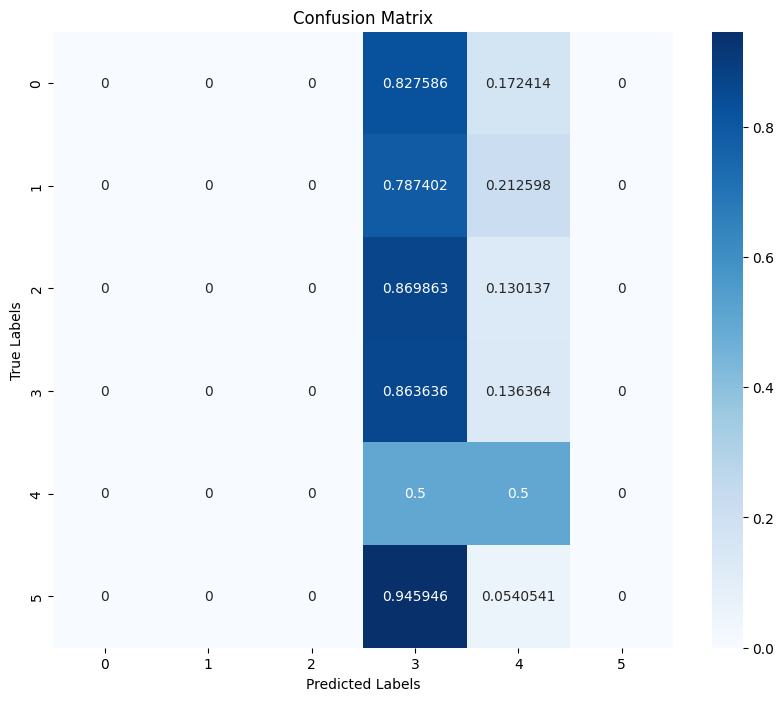

Epoch 20, Validation Loss: 1.7449, Accuracy: 0.2669, F1 Score: 0.1399
Val F1 Score Per Class  [0.         0.         0.         0.45783133 0.04301075 0.        ]


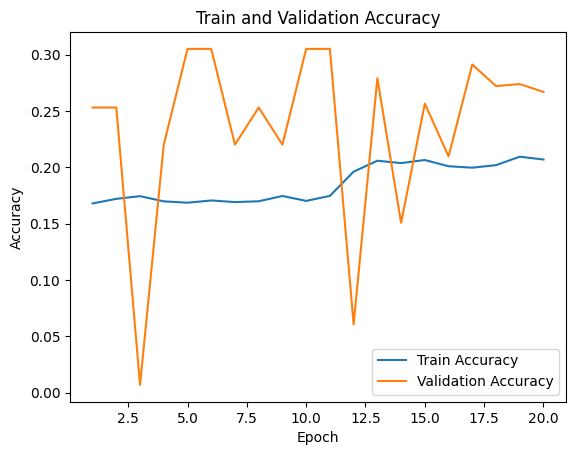

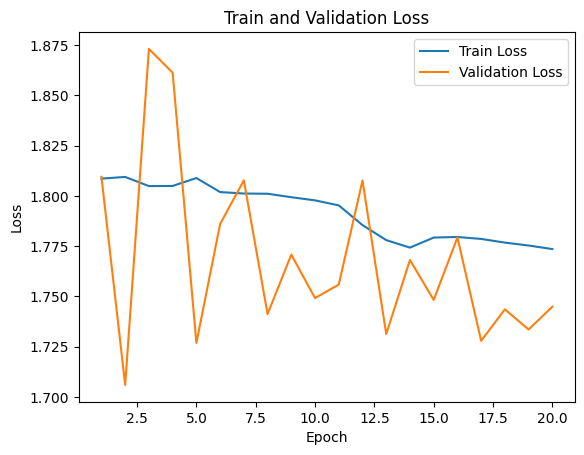

Test:   1%|▏         | 1/73 [00:00<00:34,  2.12it/s, loss=1.76]

[tensor([-0.1646, -0.0324, -0.0409,  0.0015,  0.2165, -0.0889], device='cuda:0'), tensor([ 0.0132,  0.0358,  0.0287,  0.1161, -0.4263, -0.0364], device='cuda:0'), tensor([-0.1092, -0.0124, -0.0170,  0.0325,  0.0607, -0.0676], device='cuda:0'), tensor([-0.0280,  0.0197,  0.0149,  0.0875, -0.4805, -0.0480], device='cuda:0'), tensor([-0.0611,  0.0062, -0.0011,  0.0636, -0.0285, -0.0585], device='cuda:0'), tensor([-0.0795, -0.0004, -0.0141,  0.0509, -0.0309, -0.0544], device='cuda:0'), tensor([-0.1691, -0.0335, -0.0457, -0.0009, -0.2699, -0.0791], device='cuda:0'), tensor([-0.1047, -0.0093, -0.0188,  0.0399,  0.0231, -0.0761], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:00<00:35,  2.03it/s, loss=1.73]

[tensor([-0.1083, -0.0109, -0.0201,  0.0348, -0.1123, -0.0644], device='cuda:0'), tensor([ 0.0092,  0.0337,  0.0176,  0.1087, -0.2999, -0.0332], device='cuda:0'), tensor([-0.0468,  0.0144,  0.0050,  0.0812, -0.4804, -0.0594], device='cuda:0'), tensor([ 0.0255,  0.0402,  0.0374,  0.1264, -0.3578, -0.0447], device='cuda:0'), tensor([-0.0639,  0.0053,  0.0055,  0.0641, -0.2410, -0.0625], device='cuda:0'), tensor([ 0.0403,  0.0454,  0.0388,  0.1292, -0.4624, -0.0462], device='cuda:0'), tensor([ 1.2261e-01,  7.5293e-02,  6.7271e-02,  1.8106e-01, -5.6156e-01,
        -3.9298e-05], device='cuda:0'), tensor([ 0.0203,  0.0387,  0.0267,  0.1234, -0.4360, -0.0428], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:35,  2.00it/s, loss=1.74]

[tensor([-0.0065,  0.0279,  0.0255,  0.1029, -0.3345, -0.0485], device='cuda:0'), tensor([-0.1435, -0.0242, -0.0662,  0.0137,  0.0631, -0.0742], device='cuda:0'), tensor([ 0.0993,  0.0670,  0.0574,  0.1680, -0.6332, -0.0056], device='cuda:0'), tensor([-0.1692, -0.0348, -0.0371, -0.0029,  0.1919, -0.0848], device='cuda:0'), tensor([ 0.0563,  0.0530,  0.0403,  0.1447, -0.4918, -0.0193], device='cuda:0'), tensor([ 0.0294,  0.0437,  0.0324,  0.1297, -0.5380, -0.0340], device='cuda:0'), tensor([ 0.0149,  0.0369,  0.0230,  0.1159, -0.4334, -0.0344], device='cuda:0'), tensor([-0.1353, -0.0210, -0.0473,  0.0168,  0.0106, -0.0791], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:01<00:33,  2.04it/s, loss=1.77]

[tensor([ 0.0279,  0.0401,  0.0330,  0.1213, -0.3103, -0.0340], device='cuda:0'), tensor([-0.1321, -0.0221, -0.0841,  0.0160,  0.1151, -0.0428], device='cuda:0'), tensor([-0.1508, -0.0283, -0.0319,  0.0043, -0.0318, -0.0777], device='cuda:0'), tensor([-0.1050, -0.0091, -0.0136,  0.0430, -0.1316, -0.0760], device='cuda:0'), tensor([-0.0793,  0.0004, -0.0104,  0.0591, -0.3078, -0.0547], device='cuda:0'), tensor([-0.0045,  0.0297,  0.0211,  0.1068, -0.3919, -0.0437], device='cuda:0'), tensor([-0.0543,  0.0099, -0.0045,  0.0717, -0.0933, -0.0519], device='cuda:0'), tensor([-0.2698, -0.0745, -0.0810, -0.0714,  0.4533, -0.1089], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:34,  2.00it/s, loss=1.74]

[tensor([-0.0737,  0.0020, -0.0105,  0.0575, -0.1350, -0.0497], device='cuda:0'), tensor([-0.0927, -0.0043, -0.0124,  0.0505, -0.2961, -0.0669], device='cuda:0'), tensor([ 0.0292,  0.0410,  0.0395,  0.1268, -0.3305, -0.0412], device='cuda:0'), tensor([-0.1361, -0.0219, -0.0266,  0.0166, -0.0511, -0.0750], device='cuda:0'), tensor([-0.1031, -0.0101, -0.0191,  0.0347, -0.0173, -0.0578], device='cuda:0'), tensor([-0.0832, -0.0007, -0.0098,  0.0551, -0.4360, -0.0578], device='cuda:0'), tensor([ 0.0116,  0.0355,  0.0276,  0.1135, -0.3114, -0.0430], device='cuda:0'), tensor([ 0.0561,  0.0514,  0.0479,  0.1438, -0.4572, -0.0320], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:02<00:32,  2.05it/s, loss=1.73]

[tensor([-0.0352,  0.0173,  0.0141,  0.0846, -0.1674, -0.0590], device='cuda:0'), tensor([ 0.0424,  0.0466,  0.0359,  0.1339, -0.3388, -0.0313], device='cuda:0'), tensor([ 0.0316,  0.0429,  0.0339,  0.1277, -0.4900, -0.0309], device='cuda:0'), tensor([-0.0559,  0.0146, -0.0622,  0.0761, -0.1452, -0.0428], device='cuda:0'), tensor([-0.0580,  0.0074, -0.0030,  0.0638, -0.2796, -0.0529], device='cuda:0'), tensor([-0.0125,  0.0250,  0.0233,  0.0967, -0.5028, -0.0564], device='cuda:0'), tensor([-0.3864, -0.1267, -0.2103, -0.1657,  0.1883, -0.0943], device='cuda:0'), tensor([ 0.0501,  0.0501,  0.0418,  0.1430, -0.5820, -0.0270], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:03<00:32,  2.00it/s, loss=1.72]

[tensor([ 0.1006,  0.0681,  0.0605,  0.1700, -0.5002, -0.0193], device='cuda:0'), tensor([ 0.0065,  0.0325,  0.0257,  0.1083, -0.6064, -0.0344], device='cuda:0'), tensor([ 0.0428,  0.0477,  0.0297,  0.1322, -0.4179, -0.0304], device='cuda:0'), tensor([-0.0335,  0.0179,  0.0090,  0.0861, -0.4601, -0.0423], device='cuda:0'), tensor([-0.2494, -0.0673, -0.0842, -0.0580,  0.0958, -0.0896], device='cuda:0'), tensor([-0.2115, -0.0542, -0.0717, -0.0388,  0.0179, -0.0824], device='cuda:0'), tensor([-0.1169, -0.0141, -0.0185,  0.0344, -0.1483, -0.0741], device='cuda:0'), tensor([-0.0683,  0.0043, -0.0132,  0.0578, -0.3642, -0.0386], device='cuda:0')]


Test:  11%|█         | 8/73 [00:03<00:31,  2.03it/s, loss=1.76]

[tensor([-0.0591,  0.0040, -0.0188,  0.0554, -0.2560, -0.0211], device='cuda:0'), tensor([ 0.0287,  0.0401,  0.0193,  0.1175, -0.4405, -0.0051], device='cuda:0'), tensor([ 0.0494,  0.0490,  0.0356,  0.1367, -0.4693, -0.0176], device='cuda:0'), tensor([-0.1595, -0.0310, -0.0390,  0.0026,  0.0407, -0.0755], device='cuda:0'), tensor([-0.1166, -0.0153, -0.0255,  0.0283, -0.2576, -0.0569], device='cuda:0'), tensor([-0.1692, -0.0346, -0.0438, -0.0047,  0.0892, -0.0833], device='cuda:0'), tensor([-0.1340, -0.0217, -0.0273,  0.0158,  0.0703, -0.0751], device='cuda:0'), tensor([-0.1959, -0.0472, -0.0837, -0.0264, -0.1728, -0.0695], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:04<00:30,  2.07it/s, loss=1.75]

[tensor([ 0.0755,  0.0614,  0.0470,  0.1641, -0.5701, -0.0181], device='cuda:0'), tensor([-0.0008,  0.0327,  0.0116,  0.1103, -0.3868, -0.0414], device='cuda:0'), tensor([-0.0979, -0.0087, -0.0198,  0.0348, -0.1377, -0.0488], device='cuda:0'), tensor([-0.0010,  0.0291, -0.0069,  0.1002, -0.5166, -0.0052], device='cuda:0'), tensor([ 0.0620,  0.0530,  0.0408,  0.1422, -0.3662, -0.0149], device='cuda:0'), tensor([-0.1162, -0.0141, -0.0209,  0.0312, -0.0195, -0.0695], device='cuda:0'), tensor([-0.0789,  0.0002, -0.0021,  0.0576,  0.0046, -0.0722], device='cuda:0'), tensor([-0.0957, -0.0074, -0.0214,  0.0396, -0.1104, -0.0446], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:04<00:30,  2.07it/s, loss=1.77]

[tensor([-0.0920, -0.0069, -0.0071,  0.0436,  0.0240, -0.0642], device='cuda:0'), tensor([-0.0979, -0.0066, -0.0135,  0.0464, -0.0638, -0.0693], device='cuda:0'), tensor([-0.0523,  0.0097, -0.0136,  0.0656, -0.2524, -0.0381], device='cuda:0'), tensor([-0.0038,  0.0294,  0.0241,  0.1042, -0.5540, -0.0452], device='cuda:0'), tensor([-0.1229, -0.0183, -0.0288,  0.0203,  0.0916, -0.0589], device='cuda:0'), tensor([-0.0117,  0.0256,  0.0102,  0.0938, -0.2695, -0.0442], device='cuda:0'), tensor([-0.0828, -0.0012, -0.0138,  0.0486, -0.1544, -0.0493], device='cuda:0'), tensor([-0.2035, -0.0492, -0.0871, -0.0299,  0.2266, -0.0865], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:05<00:29,  2.08it/s, loss=1.77]

[tensor([ 0.0362,  0.0435,  0.0365,  0.1278, -0.3442, -0.0273], device='cuda:0'), tensor([-0.0947, -0.0061, -0.0406,  0.0435, -0.1410, -0.0532], device='cuda:0'), tensor([-0.1516, -0.0274, -0.0348,  0.0112,  0.0635, -0.0815], device='cuda:0'), tensor([-0.0417,  0.0138,  0.0107,  0.0769, -0.2910, -0.0521], device='cuda:0'), tensor([-0.1603, -0.0311, -0.0402,  0.0013, -0.0448, -0.0727], device='cuda:0'), tensor([-0.1452, -0.0248, -0.0416,  0.0101,  0.1230, -0.0791], device='cuda:0'), tensor([-0.1643, -0.0315, -0.0422,  0.0021, -0.0459, -0.0756], device='cuda:0'), tensor([-0.1735, -0.0362, -0.0569, -0.0116, -0.4188, -0.0670], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:05<00:29,  2.09it/s, loss=1.76]

[tensor([-0.1417, -0.0248, -0.0363,  0.0122,  0.0723, -0.0648], device='cuda:0'), tensor([-0.0764,  0.0019, -0.0021,  0.0602, -0.0227, -0.0672], device='cuda:0'), tensor([-0.0837, -0.0017, -0.0090,  0.0523, -0.1180, -0.0604], device='cuda:0'), tensor([-0.1143, -0.0135, -0.0209,  0.0307,  0.0983, -0.0762], device='cuda:0'), tensor([-0.1469, -0.0263, -0.0636,  0.0067,  0.0053, -0.0555], device='cuda:0'), tensor([-0.0992, -0.0071, -0.0141,  0.0443, -0.0692, -0.0707], device='cuda:0'), tensor([ 0.0070,  0.0333,  0.0275,  0.1127, -0.4153, -0.0442], device='cuda:0'), tensor([ 0.0651,  0.0550,  0.0468,  0.1516, -0.4843, -0.0235], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:06<00:28,  2.09it/s, loss=1.74]

[tensor([-0.1953, -0.0451, -0.1495, -0.0250,  0.0023, -0.0766], device='cuda:0'), tensor([-0.0379,  0.0148,  0.0127,  0.0776, -0.2934, -0.0465], device='cuda:0'), tensor([ 0.0092,  0.0340,  0.0331,  0.1151, -0.3985, -0.0492], device='cuda:0'), tensor([ 0.0509,  0.0502,  0.0403,  0.1399, -0.4086, -0.0218], device='cuda:0'), tensor([-0.1098, -0.0100, -0.0146,  0.0412, -0.0271, -0.0798], device='cuda:0'), tensor([-0.1006, -0.0065, -0.0349,  0.0397,  0.0453, -0.0733], device='cuda:0'), tensor([-0.2410, -0.0424, -0.1726,  0.0714,  0.3870, -0.1488], device='cuda:0'), tensor([ 0.0723,  0.0575,  0.0507,  0.1529, -0.5681, -0.0184], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:06<00:28,  2.11it/s, loss=1.74]

[tensor([-0.0442,  0.0134,  0.0140,  0.0800, -0.2755, -0.0622], device='cuda:0'), tensor([-0.0563,  0.0090, -0.0029,  0.0693, -0.1737, -0.0458], device='cuda:0'), tensor([-0.0483,  0.0111,  0.0018,  0.0725, -0.3658, -0.0383], device='cuda:0'), tensor([-0.1073, -0.0118, -0.0178,  0.0341, -0.2876, -0.0606], device='cuda:0'), tensor([-0.1147, -0.0130, -0.0295,  0.0301, -0.0197, -0.0603], device='cuda:0'), tensor([-0.1149, -0.0148, -0.0199,  0.0275, -0.0540, -0.0616], device='cuda:0'), tensor([-0.0613,  0.0066, -0.0011,  0.0652, -0.3045, -0.0527], device='cuda:0'), tensor([-0.1360, -0.0215, -0.0366,  0.0180, -0.2228, -0.0603], device='cuda:0')]


Test:  21%|██        | 15/73 [00:07<00:27,  2.12it/s, loss=1.73]

[tensor([ 0.0101,  0.0340,  0.0301,  0.1144, -0.4308, -0.0420], device='cuda:0'), tensor([-0.1549, -0.0271, -0.0448,  0.0086,  0.2359, -0.0771], device='cuda:0'), tensor([-0.3124, -0.0697, -0.1933, -0.0324,  0.2304, -0.1670], device='cuda:0'), tensor([-0.0365,  0.0155,  0.0145,  0.0805, -0.2108, -0.0513], device='cuda:0'), tensor([-0.0317,  0.0185,  0.0107,  0.0880, -0.0996, -0.0580], device='cuda:0'), tensor([ 0.0553,  0.0518,  0.0464,  0.1443, -0.5414, -0.0301], device='cuda:0'), tensor([-0.0754,  0.0006, -0.0040,  0.0555, -0.3245, -0.0595], device='cuda:0'), tensor([-0.1232, -0.0174, -0.0232,  0.0246,  0.0740, -0.0735], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:07<00:27,  2.11it/s, loss=1.72]

[tensor([-0.1155, -0.0122, -0.0225,  0.0374, -0.4878, -0.0738], device='cuda:0'), tensor([-0.1680, -0.0337, -0.0388, -0.0005,  0.1776, -0.0906], device='cuda:0'), tensor([-0.1108, -0.0145, -0.0145,  0.0284, -0.1073, -0.0621], device='cuda:0'), tensor([ 0.0324,  0.0421,  0.0384,  0.1280, -0.3522, -0.0376], device='cuda:0'), tensor([-0.1086, -0.0120, -0.0221,  0.0339,  0.0040, -0.0652], device='cuda:0'), tensor([ 0.0211,  0.0387,  0.0328,  0.1232, -0.4094, -0.0400], device='cuda:0'), tensor([ 0.0194,  0.0393,  0.0317,  0.1226, -0.3756, -0.0495], device='cuda:0'), tensor([-0.0523,  0.0109, -0.0173,  0.0697, -0.3743, -0.0372], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:08<00:26,  2.11it/s, loss=1.75]

[tensor([ 0.0855,  0.0625,  0.0563,  0.1613, -0.5530, -0.0188], device='cuda:0'), tensor([-0.0794,  0.0015, -0.0042,  0.0599, -0.2833, -0.0776], device='cuda:0'), tensor([ 0.0371,  0.0442,  0.0381,  0.1301, -0.4681, -0.0290], device='cuda:0'), tensor([-0.0928, -0.0047, -0.0069,  0.0489, -0.1750, -0.0748], device='cuda:0'), tensor([-0.1156, -0.0146, -0.0206,  0.0293, -0.0476, -0.0644], device='cuda:0'), tensor([-0.1344, -0.0215, -0.0498,  0.0160, -0.1935, -0.0659], device='cuda:0'), tensor([ 0.0833,  0.0625,  0.0444,  0.1581, -0.5092, -0.0047], device='cuda:0'), tensor([-0.0462,  0.0138, -0.0014,  0.0781, -0.2760, -0.0473], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:08<00:26,  2.11it/s, loss=1.75]

[tensor([-0.2194, -0.0549, -0.0696, -0.0409,  0.1051, -0.0841], device='cuda:0'), tensor([-0.1221, -0.0164, -0.0217,  0.0291, -0.1622, -0.0790], device='cuda:0'), tensor([-0.1504, -0.0267, -0.0368,  0.0090, -0.0140, -0.0752], device='cuda:0'), tensor([-0.0438,  0.0135,  0.0029,  0.0780, -0.3422, -0.0478], device='cuda:0'), tensor([-0.2022, -0.0485, -0.0666, -0.0281,  0.3762, -0.0777], device='cuda:0'), tensor([-0.1252, -0.0178, -0.0267,  0.0262, -0.2594, -0.0662], device='cuda:0'), tensor([-0.1355, -0.0209, -0.0212,  0.0241, -0.0577, -0.0906], device='cuda:0'), tensor([ 0.1022,  0.0684,  0.0604,  0.1708, -0.5158, -0.0122], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:09<00:25,  2.11it/s, loss=1.75]

[tensor([-0.0887, -0.0061, -0.0141,  0.0411, -0.2606, -0.0436], device='cuda:0'), tensor([-0.0393,  0.0164,  0.0053,  0.0850, -0.2220, -0.0508], device='cuda:0'), tensor([ 0.0205,  0.0393,  0.0341,  0.1231, -0.4323, -0.0438], device='cuda:0'), tensor([-0.1132, -0.0135, -0.0558,  0.0264,  0.0313, -0.0508], device='cuda:0'), tensor([ 0.0400,  0.0451,  0.0406,  0.1337, -0.4425, -0.0370], device='cuda:0'), tensor([-0.0751,  0.0019, -0.0040,  0.0603, -0.6026, -0.0619], device='cuda:0'), tensor([ 0.0950,  0.0678,  0.0590,  0.1712, -0.4627, -0.0243], device='cuda:0'), tensor([-0.1076, -0.0109, -0.0312,  0.0333,  0.0360, -0.0535], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:09<00:24,  2.12it/s, loss=1.71]

[tensor([-0.0017,  0.0295,  0.0285,  0.1060, -0.2915, -0.0570], device='cuda:0'), tensor([-0.0288,  0.0210,  0.0113,  0.0920, -0.3358, -0.0497], device='cuda:0'), tensor([-0.1239, -0.0173, -0.0333,  0.0226,  0.0417, -0.0621], device='cuda:0'), tensor([-0.0050,  0.0282,  0.0128,  0.0999, -0.3782, -0.0227], device='cuda:0'), tensor([-0.1967, -0.0528, -0.1101, -0.0463,  0.0990, -0.0635], device='cuda:0'), tensor([-0.0336,  0.0177,  0.0075,  0.0872, -0.3111, -0.0505], device='cuda:0'), tensor([-0.0377,  0.0153,  0.0192,  0.0842, -0.1824, -0.0640], device='cuda:0'), tensor([ 0.0849,  0.0595,  0.0386,  0.1472, -0.3996, -0.0106], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:10<00:24,  2.14it/s, loss=1.79]

[tensor([-0.1378, -0.0217, -0.0245,  0.0221,  0.1006, -0.0846], device='cuda:0'), tensor([-0.0617,  0.0050, -0.0341,  0.0565, -0.2645, -0.0237], device='cuda:0'), tensor([-0.0226,  0.0227,  0.0140,  0.0911, -0.4291, -0.0431], device='cuda:0'), tensor([-0.0422,  0.0131,  0.0092,  0.0772, -0.1566, -0.0573], device='cuda:0'), tensor([-0.1690, -0.0319, -0.0380,  0.0057, -0.1070, -0.0976], device='cuda:0'), tensor([-0.1697, -0.0308, -0.0443,  0.0085, -0.1961, -0.0968], device='cuda:0'), tensor([-0.1128, -0.0130, -0.0338,  0.0299, -0.0060, -0.0525], device='cuda:0'), tensor([ 0.0523,  0.0526,  0.0358,  0.1427, -0.5000, -0.0208], device='cuda:0')]


Test:  30%|███       | 22/73 [00:10<00:23,  2.15it/s, loss=1.75]

[tensor([-0.0952, -0.0068, -0.0179,  0.0406, -0.0922, -0.0578], device='cuda:0'), tensor([-0.1329, -0.0206, -0.0431,  0.0154,  0.0580, -0.0523], device='cuda:0'), tensor([-0.1488, -0.0269, -0.0391,  0.0070,  0.1153, -0.0655], device='cuda:0'), tensor([-0.0487,  0.0125,  0.0092,  0.0787, -0.2516, -0.0637], device='cuda:0'), tensor([ 0.1159,  0.0724,  0.0565,  0.1748, -0.5707, -0.0080], device='cuda:0'), tensor([-0.1839, -0.0399, -0.0488, -0.0130,  0.0510, -0.0920], device='cuda:0'), tensor([-0.0403,  0.0155, -0.0171,  0.0791, -0.1864, -0.0540], device='cuda:0'), tensor([-0.0804,  0.0019, -0.0799,  0.0639,  0.0320, -0.0395], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:11<00:23,  2.11it/s, loss=1.76]

[tensor([-0.0314,  0.0185,  0.0163,  0.0904, -0.0989, -0.0597], device='cuda:0'), tensor([-0.1297, -0.0194, -0.0320,  0.0176,  0.0826, -0.0615], device='cuda:0'), tensor([-0.1106, -0.0106, -0.0216,  0.0376, -0.0180, -0.0824], device='cuda:0'), tensor([-0.0472,  0.0147,  0.0050,  0.0812, -0.1417, -0.0628], device='cuda:0'), tensor([-0.0722,  0.0027, -0.0070,  0.0587, -0.1113, -0.0551], device='cuda:0'), tensor([ 0.1437,  0.0868,  0.0572,  0.2028, -0.6531,  0.0194], device='cuda:0'), tensor([-0.1704, -0.0364, -0.0679, -0.0109,  0.1537, -0.0719], device='cuda:0'), tensor([ 0.0611,  0.0546,  0.0479,  0.1534, -0.4900, -0.0286], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:11<00:23,  2.09it/s, loss=1.78]

[tensor([-0.0280,  0.0195,  0.0080,  0.0871, -0.5647, -0.0368], device='cuda:0'), tensor([ 0.0057,  0.0332,  0.0294,  0.1137, -0.6494, -0.0452], device='cuda:0'), tensor([-0.1658, -0.0285, -0.0579,  0.0110, -0.2650, -0.0733], device='cuda:0'), tensor([ 0.0904,  0.0648,  0.0558,  0.1640, -0.6067, -0.0105], device='cuda:0'), tensor([ 0.0177,  0.0370,  0.0281,  0.1156, -0.3594, -0.0315], device='cuda:0'), tensor([-0.0328,  0.0184,  0.0136,  0.0881, -0.4064, -0.0545], device='cuda:0'), tensor([-0.1383, -0.0193, -0.0648,  0.0204,  0.1696, -0.0751], device='cuda:0'), tensor([-1.0707, -0.3947, -0.5988, -0.5641,  0.1431, -0.3689], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:11<00:22,  2.11it/s, loss=1.73]

[tensor([ 0.0938,  0.0655,  0.0592,  0.1673, -0.4899, -0.0138], device='cuda:0'), tensor([-0.0786,  0.0016, -0.0194,  0.0544, -0.2402, -0.0431], device='cuda:0'), tensor([-0.1372, -0.0226, -0.0322,  0.0140,  0.0966, -0.0725], device='cuda:0'), tensor([-0.1886, -0.0418, -0.0638, -0.0142,  0.1793, -0.0746], device='cuda:0'), tensor([-0.1112, -0.0154, -0.0187,  0.0288, -0.3766, -0.0567], device='cuda:0'), tensor([-0.0742,  0.0021, -0.0014,  0.0584, -0.0366, -0.0636], device='cuda:0'), tensor([-0.0167,  0.0242,  0.0224,  0.0981, -0.4838, -0.0517], device='cuda:0'), tensor([-0.0583,  0.0064,  0.0040,  0.0650, -0.1904, -0.0532], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:12<00:22,  2.08it/s, loss=1.84]

[tensor([ 0.0392,  0.0454,  0.0406,  0.1328, -0.4669, -0.0349], device='cuda:0'), tensor([-0.1374, -0.0233, -0.0277,  0.0144,  0.1443, -0.0849], device='cuda:0'), tensor([ 0.0311,  0.0406,  0.0393,  0.1227, -0.3805, -0.0390], device='cuda:0'), tensor([-0.1543, -0.0278, -0.0350,  0.0082, -0.0067, -0.0832], device='cuda:0'), tensor([-0.1329, -0.0208, -0.0283,  0.0210, -0.0278, -0.0704], device='cuda:0'), tensor([-0.0885, -0.0027, -0.0115,  0.0508, -0.0459, -0.0628], device='cuda:0'), tensor([ 0.0425,  0.0460,  0.0368,  0.1311, -0.3279, -0.0261], device='cuda:0'), tensor([ 0.0116,  0.0353,  0.0318,  0.1175, -0.3585, -0.0474], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:12<00:21,  2.10it/s, loss=1.72]

[tensor([-0.1503, -0.0275, -0.0382,  0.0064,  0.0010, -0.0720], device='cuda:0'), tensor([-0.1094, -0.0115, -0.0377,  0.0364, -0.1525, -0.0764], device='cuda:0'), tensor([ 0.0570,  0.0520,  0.0464,  0.1447, -0.4844, -0.0258], device='cuda:0'), tensor([-0.0034,  0.0280,  0.0213,  0.0988, -0.3742, -0.0376], device='cuda:0'), tensor([ 0.0599,  0.0512,  0.0436,  0.1379, -0.4594, -0.0200], device='cuda:0'), tensor([-0.0464,  0.0128,  0.0063,  0.0749, -0.1373, -0.0525], device='cuda:0'), tensor([ 0.0682,  0.0557,  0.0537,  0.1515, -0.4712, -0.0298], device='cuda:0'), tensor([-0.0457,  0.0139,  0.0035,  0.0795, -0.3807, -0.0504], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:13<00:21,  2.11it/s, loss=1.72]

[tensor([ 0.0358,  0.0452,  0.0264,  0.1289, -0.4642, -0.0122], device='cuda:0'), tensor([-0.0840, -0.0012, -0.0037,  0.0543, -0.2144, -0.0679], device='cuda:0'), tensor([ 0.0108,  0.0345,  0.0289,  0.1123, -0.2739, -0.0387], device='cuda:0'), tensor([-0.0899, -0.0048, -0.0091,  0.0447, -0.0329, -0.0702], device='cuda:0'), tensor([-0.1082, -0.0095, -0.0461,  0.0384, -0.3070, -0.0501], device='cuda:0'), tensor([-0.0533,  0.0104,  0.0012,  0.0716, -0.3566, -0.0531], device='cuda:0'), tensor([ 0.0112,  0.0354,  0.0290,  0.1152, -0.3200, -0.0405], device='cuda:0'), tensor([-0.1447, -0.0245, -0.0296,  0.0143,  0.0353, -0.0803], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:13<00:20,  2.12it/s, loss=1.73]

[tensor([ 0.0203,  0.0384,  0.0335,  0.1190, -0.2640, -0.0421], device='cuda:0'), tensor([-0.0020,  0.0275,  0.0200,  0.1000, -0.5508, -0.0276], device='cuda:0'), tensor([-0.1125, -0.0134, -0.0650,  0.0304,  0.0296, -0.0631], device='cuda:0'), tensor([ 0.0318,  0.0421,  0.0369,  0.1257, -0.4420, -0.0319], device='cuda:0'), tensor([-0.0033,  0.0290,  0.0237,  0.1025, -0.3463, -0.0497], device='cuda:0'), tensor([-0.0953, -0.0050, -0.0282,  0.0434,  0.0099, -0.0651], device='cuda:0'), tensor([-0.0493,  0.0110,  0.0032,  0.0724, -0.3660, -0.0497], device='cuda:0'), tensor([-0.0892, -0.0027, -0.0072,  0.0512, -0.4204, -0.0755], device='cuda:0')]


Test:  41%|████      | 30/73 [00:14<00:20,  2.10it/s, loss=1.74]

[tensor([ 0.0842,  0.0621,  0.0454,  0.1548, -0.4615, -0.0146], device='cuda:0'), tensor([-0.1216, -0.0167, -0.0584,  0.0250, -0.0531, -0.0522], device='cuda:0'), tensor([-0.1279, -0.0183, -0.0280,  0.0267, -0.0399, -0.0829], device='cuda:0'), tensor([ 0.0540,  0.0524,  0.0413,  0.1474, -0.4904, -0.0270], device='cuda:0'), tensor([-0.0477,  0.0114,  0.0012,  0.0703, -0.1247, -0.0547], device='cuda:0'), tensor([-0.1290, -0.0203, -0.0272,  0.0177, -0.0373, -0.0695], device='cuda:0'), tensor([-0.1575, -0.0308, -0.0470,  0.0004,  0.1100, -0.0813], device='cuda:0'), tensor([-0.1004, -0.0076, -0.0069,  0.0437, -0.0407, -0.0757], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:14<00:19,  2.11it/s, loss=1.74]

[tensor([-0.0842, -0.0031, -0.0215,  0.0436, -0.0844, -0.0381], device='cuda:0'), tensor([-0.1124, -0.0122, -0.0265,  0.0324, -0.0745, -0.0629], device='cuda:0'), tensor([ 0.0466,  0.0470,  0.0396,  0.1323, -0.3847, -0.0223], device='cuda:0'), tensor([ 0.0404,  0.0445,  0.0473,  0.1346, -0.3829, -0.0437], device='cuda:0'), tensor([-0.0230,  0.0212,  0.0155,  0.0907, -0.4423, -0.0522], device='cuda:0'), tensor([-0.0775,  0.0022, -0.0035,  0.0601, -0.2932, -0.0640], device='cuda:0'), tensor([-0.0901, -0.0032, -0.0281,  0.0469,  0.0055, -0.0663], device='cuda:0'), tensor([ 0.0470,  0.0472,  0.0387,  0.1327, -0.4819, -0.0252], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:15<00:19,  2.12it/s, loss=1.76]

[tensor([-0.1741, -0.0358, -0.0467, -0.0053,  0.0088, -0.0821], device='cuda:0'), tensor([-0.1570, -0.0291, -0.0434,  0.0036,  0.1304, -0.0736], device='cuda:0'), tensor([ 0.1037,  0.0703,  0.0523,  0.1752, -0.5193, -0.0052], device='cuda:0'), tensor([-0.1282, -0.0198, -0.0358,  0.0206, -0.2888, -0.0642], device='cuda:0'), tensor([ 0.2098,  0.1222,  0.0727,  0.2709, -0.8811,  0.0124], device='cuda:0'), tensor([-0.1481, -0.0262, -0.0732,  0.0075,  0.1555, -0.0681], device='cuda:0'), tensor([-0.0810,  0.0014, -0.0045,  0.0598, -0.2793, -0.0704], device='cuda:0'), tensor([-0.0519,  0.0117, -0.0030,  0.0730, -0.1718, -0.0440], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:15<00:18,  2.12it/s, loss=1.72]

[tensor([-0.1002, -0.0073, -0.0114,  0.0448, -0.0487, -0.0801], device='cuda:0'), tensor([-0.0478,  0.0108, -0.0045,  0.0684, -0.4361, -0.0317], device='cuda:0'), tensor([-0.0080,  0.0266,  0.0140,  0.0977, -0.2024, -0.0399], device='cuda:0'), tensor([ 0.0589,  0.0523,  0.0465,  0.1440, -0.5137, -0.0237], device='cuda:0'), tensor([-0.0455,  0.0127,  0.0147,  0.0790, -0.2550, -0.0639], device='cuda:0'), tensor([-0.0169,  0.0227,  0.0241,  0.0948, -0.4192, -0.0500], device='cuda:0'), tensor([ 0.0980,  0.0665,  0.0582,  0.1697, -0.6207, -0.0100], device='cuda:0'), tensor([-0.0497,  0.0111,  0.0090,  0.0737, -0.1368, -0.0563], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:16<00:18,  2.09it/s, loss=1.75]

[tensor([ 0.0876,  0.0626,  0.0516,  0.1564, -0.5010, -0.0091], device='cuda:0'), tensor([-0.1450, -0.0243, -0.0460,  0.0120,  0.0267, -0.0688], device='cuda:0'), tensor([ 0.0450,  0.0467,  0.0360,  0.1370, -0.3382, -0.0380], device='cuda:0'), tensor([ 0.0229,  0.0391,  0.0220,  0.1225, -0.3782, -0.0349], device='cuda:0'), tensor([ 0.0295,  0.0429,  0.0302,  0.1287, -0.5129, -0.0268], device='cuda:0'), tensor([ 0.0147,  0.0349,  0.0329,  0.1150, -0.4123, -0.0388], device='cuda:0'), tensor([-0.0344,  0.0175,  0.0122,  0.0840, -0.2908, -0.0554], device='cuda:0'), tensor([-0.0201,  0.0250, -0.0635,  0.0929, -0.1304, -0.0146], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:16<00:18,  2.10it/s, loss=1.78]

[tensor([-0.0086,  0.0275,  0.0281,  0.1059, -0.5526, -0.0580], device='cuda:0'), tensor([ 0.0021,  0.0302,  0.0233,  0.1055, -0.2357, -0.0322], device='cuda:0'), tensor([-1.0753, -0.4480, -0.5077, -0.7344,  0.8661, -0.3573], device='cuda:0'), tensor([-0.0703,  0.0041,  0.0079,  0.0667, -0.1563, -0.0798], device='cuda:0'), tensor([ 0.0728,  0.0580,  0.0443,  0.1532, -0.5802, -0.0138], device='cuda:0'), tensor([ 0.0321,  0.0425,  0.0387,  0.1293, -0.4495, -0.0368], device='cuda:0'), tensor([-0.0017,  0.0307,  0.0235,  0.1072, -0.3618, -0.0422], device='cuda:0'), tensor([ 0.0145,  0.0347,  0.0312,  0.1126, -0.5219, -0.0394], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:17<00:17,  2.12it/s, loss=1.76]

[tensor([-0.0211,  0.0231,  0.0155,  0.0962, -0.1747, -0.0598], device='cuda:0'), tensor([-0.1375, -0.0226, -0.0309,  0.0142,  0.0292, -0.0663], device='cuda:0'), tensor([ 0.0097,  0.0345,  0.0300,  0.1141, -0.3250, -0.0418], device='cuda:0'), tensor([-0.2481, -0.0710, -0.0881, -0.0673, -0.1674, -0.0857], device='cuda:0'), tensor([-0.0238,  0.0215,  0.0157,  0.0912, -0.3421, -0.0484], device='cuda:0'), tensor([-0.0423,  0.0149,  0.0036,  0.0810, -0.1947, -0.0507], device='cuda:0'), tensor([-0.1234, -0.0164, -0.0160,  0.0308,  0.0864, -0.0834], device='cuda:0'), tensor([-0.1838, -0.0405, -0.0646, -0.0156,  0.2109, -0.0972], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:17<00:16,  2.13it/s, loss=1.72]

[tensor([-0.1795, -0.0385, -0.0486, -0.0090,  0.1114, -0.0869], device='cuda:0'), tensor([-0.0925, -0.0032, -0.0083,  0.0540, -0.2766, -0.0768], device='cuda:0'), tensor([-0.2040, -0.0473, -0.0557, -0.0235, -0.2142, -0.0934], device='cuda:0'), tensor([-0.0102,  0.0275,  0.0071,  0.1004, -0.2948, -0.0401], device='cuda:0'), tensor([-0.1889, -0.0418, -0.0535, -0.0155,  0.1978, -0.0909], device='cuda:0'), tensor([-0.0145,  0.0248,  0.0160,  0.0956, -0.2538, -0.0366], device='cuda:0'), tensor([ 0.0581,  0.0497,  0.0460,  0.1376, -0.4467, -0.0221], device='cuda:0'), tensor([ 0.0176,  0.0355,  0.0136,  0.1088, -0.4071, -0.0037], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:18<00:16,  2.14it/s, loss=1.72]

[tensor([ 0.0318,  0.0434,  0.0278,  0.1253, -0.3837, -0.0232], device='cuda:0'), tensor([ 0.0701,  0.0559,  0.0396,  0.1471, -0.4080, -0.0084], device='cuda:0'), tensor([-0.0007,  0.0314,  0.0124,  0.1084, -0.4089, -0.0395], device='cuda:0'), tensor([-0.1415, -0.0270, -0.0355,  0.0082,  0.1711, -0.0632], device='cuda:0'), tensor([ 0.1019,  0.0675,  0.0573,  0.1665, -0.6452,  0.0015], device='cuda:0'), tensor([-0.0028,  0.0289,  0.0264,  0.1057, -0.2580, -0.0487], device='cuda:0'), tensor([-0.1157, -0.0124, -0.0200,  0.0374, -0.2142, -0.0775], device='cuda:0'), tensor([ 0.0157,  0.0365,  0.0231,  0.1171, -0.2628, -0.0375], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:18<00:17,  1.99it/s, loss=1.71]

[tensor([ 0.0139,  0.0347,  0.0130,  0.1094, -0.4039, -0.0180], device='cuda:0'), tensor([ 0.0618,  0.0551,  0.0389,  0.1464, -0.5402, -0.0124], device='cuda:0'), tensor([ 0.0337,  0.0434,  0.0327,  0.1273, -0.6516, -0.0229], device='cuda:0'), tensor([-0.2094, -0.0490, -0.0898, -0.0283,  0.1794, -0.0882], device='cuda:0'), tensor([-0.0307,  0.0213,  0.0070,  0.0936, -0.2699, -0.0437], device='cuda:0'), tensor([ 0.1131,  0.0728,  0.0667,  0.1833, -0.6011, -0.0142], device='cuda:0'), tensor([ 0.0062,  0.0336,  0.0272,  0.1128, -0.4621, -0.0441], device='cuda:0'), tensor([-0.0398,  0.0154,  0.0100,  0.0804, -0.2010, -0.0493], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:19<00:17,  1.88it/s, loss=1.75]

[tensor([ 0.0171,  0.0361,  0.0313,  0.1169, -0.4263, -0.0368], device='cuda:0'), tensor([ 0.0307,  0.0436,  0.0373,  0.1342, -0.5339, -0.0398], device='cuda:0'), tensor([-0.0996, -0.0078, -0.0219,  0.0399, -0.1426, -0.0641], device='cuda:0'), tensor([-0.0312,  0.0176,  0.0067,  0.0821, -0.1654, -0.0486], device='cuda:0'), tensor([-0.1536, -0.0283, -0.0353,  0.0056,  0.0941, -0.0764], device='cuda:0'), tensor([-0.0425,  0.0143,  0.0013,  0.0758, -0.2219, -0.0435], device='cuda:0'), tensor([-0.1388, -0.0251, -0.0670,  0.0140,  0.0043, -0.0508], device='cuda:0'), tensor([ 0.0463,  0.0474,  0.0454,  0.1367, -0.5448, -0.0355], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:19<00:16,  1.90it/s, loss=1.73]

[tensor([ 0.1852,  0.1019,  0.0755,  0.2276, -0.7939,  0.0321], device='cuda:0'), tensor([-0.0786,  0.0009, -0.0092,  0.0564, -0.4009, -0.0576], device='cuda:0'), tensor([ 0.0762,  0.0589,  0.0454,  0.1518, -0.4752, -0.0152], device='cuda:0'), tensor([-0.1101, -0.0131, -0.0235,  0.0303, -0.0951, -0.0673], device='cuda:0'), tensor([ 0.0168,  0.0373,  0.0197,  0.1162, -0.4356, -0.0205], device='cuda:0'), tensor([-0.1168, -0.0146, -0.0291,  0.0301,  0.0942, -0.0727], device='cuda:0'), tensor([-0.0654,  0.0063,  0.0049,  0.0691, -0.3745, -0.0670], device='cuda:0'), tensor([-0.1832, -0.0393, -0.0650, -0.0109, -0.0238, -0.0820], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:20<00:15,  1.97it/s, loss=1.79]

[tensor([ 0.0745,  0.0579,  0.0442,  0.1491, -0.4207, -0.0105], device='cuda:0'), tensor([-0.1677, -0.0325, -0.0420,  0.0005,  0.2138, -0.0838], device='cuda:0'), tensor([ 0.0735,  0.0590,  0.0530,  0.1603, -0.5160, -0.0305], device='cuda:0'), tensor([-0.5811, -0.2098, -0.2473, -0.2442,  0.3327, -0.2757], device='cuda:0'), tensor([-0.1077, -0.0091, -0.0164,  0.0422, -0.1226, -0.0734], device='cuda:0'), tensor([-0.2129, -0.0515, -0.0532, -0.0287, -0.0049, -0.1009], device='cuda:0'), tensor([-0.1351, -0.0211, -0.0747,  0.0161,  0.1273, -0.0534], device='cuda:0'), tensor([-0.0048,  0.0275,  0.0279,  0.1016, -0.3480, -0.0481], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:20<00:14,  2.01it/s, loss=1.75]

[tensor([-0.0132,  0.0257,  0.0225,  0.0995, -0.4600, -0.0487], device='cuda:0'), tensor([-0.1313, -0.0210, -0.0304,  0.0148,  0.1112, -0.0688], device='cuda:0'), tensor([-0.1423, -0.0243, -0.0310,  0.0149,  0.0132, -0.0729], device='cuda:0'), tensor([ 0.0047,  0.0327,  0.0269,  0.1104, -0.4115, -0.0428], device='cuda:0'), tensor([-0.1652, -0.0364, -0.0452, -0.0108,  0.1391, -0.0662], device='cuda:0'), tensor([-0.1048, -0.0105, -0.0218,  0.0358, -0.1504, -0.0564], device='cuda:0'), tensor([ 0.1381,  0.0819,  0.0711,  0.1956, -0.6695,  0.0032], device='cuda:0'), tensor([-0.1169, -0.0153, -0.0422,  0.0267, -0.0922, -0.0618], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:21<00:14,  1.95it/s, loss=1.74]

[tensor([-0.1583, -0.0312, -0.0501,  0.0011,  0.0987, -0.0630], device='cuda:0'), tensor([-0.0621,  0.0092, -0.0106,  0.0717, -0.3011, -0.0458], device='cuda:0'), tensor([-0.0567,  0.0101, -0.0039,  0.0718, -0.1845, -0.0479], device='cuda:0'), tensor([ 0.0085,  0.0346,  0.0272,  0.1145, -0.3259, -0.0412], device='cuda:0'), tensor([-0.1322, -0.0211, -0.0296,  0.0175, -0.0113, -0.0820], device='cuda:0'), tensor([ 0.1130,  0.0724,  0.0661,  0.1796, -0.5398, -0.0182], device='cuda:0'), tensor([-0.2056, -0.0476, -0.0700, -0.0250, -0.0376, -0.0876], device='cuda:0'), tensor([-4.8707e-02,  1.0737e-02, -3.0248e-04,  7.2556e-02, -3.9637e-01,
        -4.2380e-02], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:21<00:14,  1.97it/s, loss=1.79]

[tensor([ 0.0566,  0.0528,  0.0308,  0.1447, -0.4906, -0.0008], device='cuda:0'), tensor([-0.0203,  0.0219,  0.0231,  0.0955, -0.2419, -0.0568], device='cuda:0'), tensor([-1.0417, -0.4186, -0.4142, -0.6615,  0.2017, -0.3768], device='cuda:0'), tensor([-0.0816, -0.0009, -0.0174,  0.0497, -0.0934, -0.0462], device='cuda:0'), tensor([-0.0439,  0.0142,  0.0021,  0.0794, -0.1509, -0.0601], device='cuda:0'), tensor([ 0.0564,  0.0517,  0.0478,  0.1455, -0.3727, -0.0345], device='cuda:0'), tensor([ 0.0284,  0.0408,  0.0314,  0.1229, -0.4981, -0.0308], device='cuda:0'), tensor([-0.1159, -0.0150, -0.0371,  0.0243, -0.0626, -0.0425], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:22<00:13,  2.01it/s, loss=1.73]

[tensor([ 0.0371,  0.0459,  0.0366,  0.1369, -0.4467, -0.0324], device='cuda:0'), tensor([ 0.0996,  0.0687,  0.0551,  0.1725, -0.7304, -0.0044], device='cuda:0'), tensor([-0.1330, -0.0202, -0.0374,  0.0188, -0.2718, -0.0610], device='cuda:0'), tensor([-0.1605, -0.0245, -0.1139,  0.0243, -0.1482, -0.0730], device='cuda:0'), tensor([-0.7861, -0.3545, -0.3070, -0.6037,  0.6695, -0.2077], device='cuda:0'), tensor([ 0.1065,  0.0705,  0.0600,  0.1747, -0.5651, -0.0079], device='cuda:0'), tensor([-5.6092e-02,  9.9934e-03, -3.2859e-04,  7.3612e-02, -4.3907e-01,
        -5.2115e-02], device='cuda:0'), tensor([-0.1675, -0.0347, -0.0410, -0.0029, -0.1163, -0.0889], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:22<00:12,  2.04it/s, loss=1.73]

[tensor([-0.0689,  0.0047, -0.0099,  0.0630, -0.2523, -0.0618], device='cuda:0'), tensor([ 0.0408,  0.0454,  0.0397,  0.1354, -0.5761, -0.0336], device='cuda:0'), tensor([ 0.0022,  0.0304,  0.0239,  0.1042, -0.2982, -0.0403], device='cuda:0'), tensor([-0.1253, -0.0169, -0.0233,  0.0263, -0.0414, -0.0753], device='cuda:0'), tensor([-0.1474, -0.0264, -0.0305,  0.0130,  0.1074, -0.0858], device='cuda:0'), tensor([ 0.1099,  0.0723,  0.0657,  0.1842, -0.5780, -0.0181], device='cuda:0'), tensor([ 0.0057,  0.0306,  0.0186,  0.1015, -0.2899, -0.0389], device='cuda:0'), tensor([ 0.0503,  0.0498,  0.0441,  0.1418, -0.4439, -0.0396], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:23<00:12,  2.05it/s, loss=1.74]

[tensor([-0.1101, -0.0142, -0.0163,  0.0280,  0.0490, -0.0663], device='cuda:0'), tensor([-0.1857, -0.0407, -0.0549, -0.0168,  0.2970, -0.0839], device='cuda:0'), tensor([ 0.0137,  0.0352,  0.0366,  0.1202, -0.3874, -0.0545], device='cuda:0'), tensor([-0.0410,  0.0150,  0.0057,  0.0815, -0.1027, -0.0598], device='cuda:0'), tensor([-0.2026, -0.0480, -0.1051, -0.0272,  0.2741, -0.0818], device='cuda:0'), tensor([ 0.0459,  0.0464,  0.0312,  0.1311, -0.5914, -0.0250], device='cuda:0'), tensor([-0.1351, -0.0199, -0.0181,  0.0260, -0.4093, -0.0929], device='cuda:0'), tensor([ 0.0756,  0.0576,  0.0518,  0.1514, -0.5111, -0.0225], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:23<00:11,  2.07it/s, loss=1.77]

[tensor([ 0.0370,  0.0459,  0.0363,  0.1347, -0.5672, -0.0303], device='cuda:0'), tensor([-0.1395, -0.0232, -0.0237,  0.0180, -0.1259, -0.0844], device='cuda:0'), tensor([-0.1000, -0.0077, -0.0284,  0.0404, -0.1086, -0.0505], device='cuda:0'), tensor([-0.1238, -0.0171, -0.0209,  0.0278, -0.0182, -0.0806], device='cuda:0'), tensor([-0.2022, -0.0463, -0.0615, -0.0238,  0.0152, -0.0867], device='cuda:0'), tensor([ 0.0041,  0.0314,  0.0264,  0.1071, -0.4592, -0.0377], device='cuda:0'), tensor([-0.0117,  0.0253,  0.0190,  0.0961, -0.2226, -0.0543], device='cuda:0'), tensor([-0.1455, -0.0255, -0.0365,  0.0124, -0.2101, -0.0686], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:24<00:11,  2.08it/s, loss=1.73]

[tensor([-0.1765, -0.0381, -0.0638, -0.0095,  0.0671, -0.0827], device='cuda:0'), tensor([-0.0712,  0.0036, -0.0179,  0.0582, -0.4907, -0.0346], device='cuda:0'), tensor([-0.1514, -0.0275, -0.0346,  0.0100, -0.1562, -0.0810], device='cuda:0'), tensor([ 0.1222,  0.0763,  0.0669,  0.1853, -0.5324, -0.0076], device='cuda:0'), tensor([-0.1668, -0.0331, -0.0501, -0.0030, -0.0252, -0.0716], device='cuda:0'), tensor([-0.0391,  0.0168,  0.0080,  0.0834, -0.3681, -0.0521], device='cuda:0'), tensor([-0.1440, -0.0239, -0.0585,  0.0116, -0.0563, -0.0607], device='cuda:0'), tensor([ 0.0619,  0.0542,  0.0467,  0.1476, -0.5046, -0.0245], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:24<00:10,  2.05it/s, loss=1.75]

[tensor([-0.0272,  0.0205,  0.0159,  0.0893, -0.1747, -0.0509], device='cuda:0'), tensor([-0.0141,  0.0262,  0.0171,  0.1021, -0.5207, -0.0459], device='cuda:0'), tensor([ 0.0269,  0.0411,  0.0193,  0.1218, -0.5231, -0.0202], device='cuda:0'), tensor([-0.0521,  0.0110, -0.0039,  0.0749, -0.1129, -0.0608], device='cuda:0'), tensor([-0.0649,  0.0048, -0.0101,  0.0581, -0.0499, -0.0429], device='cuda:0'), tensor([ 0.0045,  0.0311,  0.0253,  0.1065, -0.3446, -0.0345], device='cuda:0'), tensor([-0.1203, -0.0194, -0.0304,  0.0214,  0.0251, -0.0835], device='cuda:0'), tensor([-0.1666, -0.0343, -0.0641, -0.0052,  0.1320, -0.0746], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:25<00:10,  1.99it/s, loss=1.73]

[tensor([-0.0959, -0.0053, -0.0192,  0.0444, -0.2013, -0.0553], device='cuda:0'), tensor([ 0.1076,  0.0700,  0.0558,  0.1721, -0.5130, -0.0026], device='cuda:0'), tensor([-0.1040, -0.0075, -0.0298,  0.0386, -0.1194, -0.0500], device='cuda:0'), tensor([ 0.0052,  0.0322,  0.0266,  0.1080, -0.2844, -0.0366], device='cuda:0'), tensor([-0.0820,  0.0038, -0.0227,  0.0667, -0.2719, -0.0467], device='cuda:0'), tensor([ 0.1011,  0.0678,  0.0542,  0.1665, -0.5443,  0.0027], device='cuda:0'), tensor([-0.1940, -0.0430, -0.0706, -0.0180,  0.1830, -0.0812], device='cuda:0'), tensor([-0.0074,  0.0274,  0.0153,  0.0989, -0.2717, -0.0325], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:25<00:09,  2.01it/s, loss=1.73]

[tensor([ 0.0626,  0.0530,  0.0476,  0.1444, -0.5322, -0.0237], device='cuda:0'), tensor([-0.0394,  0.0156,  0.0016,  0.0801, -0.2950, -0.0409], device='cuda:0'), tensor([ 0.0777,  0.0600,  0.0529,  0.1593, -0.4381, -0.0221], device='cuda:0'), tensor([-0.0288,  0.0194,  0.0136,  0.0869, -0.2186, -0.0619], device='cuda:0'), tensor([ 0.0397,  0.0444,  0.0377,  0.1273, -0.3008, -0.0317], device='cuda:0'), tensor([-0.0448,  0.0130,  0.0105,  0.0770, -0.1692, -0.0568], device='cuda:0'), tensor([-0.1506, -0.0278, -0.0361,  0.0053,  0.0864, -0.0702], device='cuda:0'), tensor([ 0.0551,  0.0510,  0.0368,  0.1382, -0.5471, -0.0077], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:26<00:09,  1.97it/s, loss=1.77]

[tensor([-0.1277, -0.0199, -0.0536,  0.0159,  0.0615, -0.0609], device='cuda:0'), tensor([-0.1162, -0.0120, -0.0327,  0.0363,  0.0135, -0.0631], device='cuda:0'), tensor([-0.2015, -0.0505, -0.0641, -0.0364, -0.1661, -0.0720], device='cuda:0'), tensor([-0.1556, -0.0325, -0.0535, -0.0030, -0.1000, -0.0480], device='cuda:0'), tensor([-0.0755,  0.0030, -0.0060,  0.0618, -0.2094, -0.0623], device='cuda:0'), tensor([-0.1349, -0.0219, -0.0332,  0.0163,  0.0852, -0.0685], device='cuda:0'), tensor([-0.0155,  0.0320, -0.0200,  0.1155, -0.3489, -0.0259], device='cuda:0'), tensor([ 0.0183,  0.0386,  0.0329,  0.1231, -0.3309, -0.0446], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:26<00:08,  2.01it/s, loss=1.74]

[tensor([-0.1430, -0.0246, -0.0357,  0.0107,  0.0548, -0.0710], device='cuda:0'), tensor([ 0.0065,  0.0336,  0.0294,  0.1155, -0.3474, -0.0494], device='cuda:0'), tensor([ 0.0808,  0.0616,  0.0497,  0.1617, -0.5044, -0.0189], device='cuda:0'), tensor([ 0.0131,  0.0364,  0.0311,  0.1187, -0.4774, -0.0426], device='cuda:0'), tensor([-0.1568, -0.0311, -0.0402,  0.0031,  0.0647, -0.0899], device='cuda:0'), tensor([-0.0752,  0.0014,  0.0028,  0.0594, -0.2498, -0.0719], device='cuda:0'), tensor([-0.1412, -0.0240, -0.0411,  0.0113, -0.0419, -0.0621], device='cuda:0'), tensor([-0.1544, -0.0283, -0.0338,  0.0092,  0.1548, -0.0885], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:27<00:08,  2.03it/s, loss=1.72]

[tensor([-0.1152, -0.0137, -0.0231,  0.0278, -0.2552, -0.0625], device='cuda:0'), tensor([-0.0425,  0.0149,  0.0080,  0.0824, -0.2350, -0.0528], device='cuda:0'), tensor([ 0.0595,  0.0523,  0.0508,  0.1479, -0.3898, -0.0335], device='cuda:0'), tensor([-0.0621,  0.0087, -0.0005,  0.0710, -0.3591, -0.0563], device='cuda:0'), tensor([-0.1707, -0.0366, -0.0617, -0.0078,  0.1013, -0.0726], device='cuda:0'), tensor([-0.1621, -0.0168, -0.1331,  0.1124, -0.4005, -0.1452], device='cuda:0'), tensor([-0.0525,  0.0091, -0.0268,  0.0666, -0.2313, -0.0324], device='cuda:0'), tensor([-0.0611,  0.0065, -0.0202,  0.0593, -0.3456, -0.0283], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:27<00:07,  2.06it/s, loss=1.72]

[tensor([-0.0612,  0.0083, -0.0431,  0.0661, -0.2467, -0.0467], device='cuda:0'), tensor([-0.0969, -0.0061, -0.0139,  0.0461, -0.4655, -0.0683], device='cuda:0'), tensor([-0.0030,  0.0285,  0.0260,  0.1013, -0.3908, -0.0423], device='cuda:0'), tensor([-0.0236,  0.0216,  0.0195,  0.0946, -0.2973, -0.0561], device='cuda:0'), tensor([-0.1255, -0.0171, -0.0400,  0.0248, -0.1075, -0.0612], device='cuda:0'), tensor([ 0.0551,  0.0515,  0.0418,  0.1423, -0.3679, -0.0313], device='cuda:0'), tensor([ 0.0630,  0.0531,  0.0397,  0.1419, -0.5380, -0.0302], device='cuda:0'), tensor([-0.0196,  0.0214,  0.0183,  0.0892, -0.3281, -0.0442], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:28<00:07,  2.05it/s, loss=1.76]

[tensor([-0.1867, -0.0412, -0.0481, -0.0155,  0.1935, -0.0823], device='cuda:0'), tensor([-0.1373, -0.0214, -0.0289,  0.0192, -0.0414, -0.0717], device='cuda:0'), tensor([ 0.0241,  0.0412,  0.0331,  0.1281, -0.5008, -0.0401], device='cuda:0'), tensor([ 0.1514,  0.1012,  0.0525,  0.2368, -0.5979, -0.0045], device='cuda:0'), tensor([-0.1466, -0.0242, -0.0270,  0.0187, -0.1636, -0.0906], device='cuda:0'), tensor([ 0.1214,  0.0782,  0.0635,  0.1900, -0.5898, -0.0028], device='cuda:0'), tensor([ 0.1041,  0.0695,  0.0636,  0.1758, -0.5072, -0.0154], device='cuda:0'), tensor([ 0.0364,  0.0426,  0.0355,  0.1240, -0.3545, -0.0289], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:28<00:06,  2.08it/s, loss=1.75]

[tensor([ 0.0571,  0.0520,  0.0476,  0.1465, -0.4763, -0.0343], device='cuda:0'), tensor([-0.2177, -0.0526, -0.0660, -0.0339,  0.2394, -0.0922], device='cuda:0'), tensor([-0.1163, -0.0139, -0.0091,  0.0368,  0.0578, -0.0900], device='cuda:0'), tensor([-0.0932, -0.0047, -0.0318,  0.0423, -0.0116, -0.0514], device='cuda:0'), tensor([ 0.0373,  0.0462,  0.0331,  0.1370, -0.4565, -0.0371], device='cuda:0'), tensor([-0.1718, -0.0349, -0.0623, -0.0051,  0.1236, -0.0792], device='cuda:0'), tensor([ 0.1065,  0.0691,  0.0585,  0.1694, -0.5860, -0.0014], device='cuda:0'), tensor([-0.0339,  0.0192,  0.0157,  0.0907, -0.3904, -0.0626], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:29<00:06,  2.07it/s, loss=1.75]

[tensor([-0.2074, -0.0484, -0.0518, -0.0253,  0.3982, -0.1040], device='cuda:0'), tensor([-0.0122,  0.0262,  0.0188,  0.1032, -0.3067, -0.0573], device='cuda:0'), tensor([-0.0834, -0.0009, -0.0071,  0.0541, -0.0498, -0.0671], device='cuda:0'), tensor([ 0.0250,  0.0396,  0.0310,  0.1214, -0.5853, -0.0339], device='cuda:0'), tensor([-0.1476, -0.0259, -0.0280,  0.0125, -0.1258, -0.0890], device='cuda:0'), tensor([-0.1240, -0.0178, -0.0351,  0.0198,  0.0782, -0.0586], device='cuda:0'), tensor([-0.1434, -0.0285, -0.0615,  0.0006, -0.0006, -0.0520], device='cuda:0'), tensor([-0.0348,  0.0161,  0.0047,  0.0789, -0.1445, -0.0512], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:29<00:05,  2.02it/s, loss=1.78]

[tensor([-0.6060, -0.2802, -0.2403, -0.4942,  0.4237, -0.2046], device='cuda:0'), tensor([-0.4905, -0.1321, -0.2588, -0.0697,  0.9913, -0.2479], device='cuda:0'), tensor([ 0.0198,  0.0377,  0.0339,  0.1188, -0.4049, -0.0383], device='cuda:0'), tensor([-0.0420,  0.0145,  0.0058,  0.0783, -0.2391, -0.0605], device='cuda:0'), tensor([-0.0891, -0.0055, -0.0483,  0.0425, -0.1300, -0.0489], device='cuda:0'), tensor([-0.1340, -0.0204, -0.0175,  0.0244,  0.0778, -0.0975], device='cuda:0'), tensor([-0.0066,  0.0286,  0.0137,  0.1023, -0.2982, -0.0352], device='cuda:0'), tensor([ 0.0755,  0.0580,  0.0497,  0.1538, -0.5822, -0.0144], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:30<00:05,  1.99it/s, loss=1.82]

[tensor([-0.0246,  0.0198,  0.0068,  0.0846, -0.5560, -0.0281], device='cuda:0'), tensor([ 0.0730,  0.0577,  0.0478,  0.1507, -0.4717, -0.0201], device='cuda:0'), tensor([-0.0192,  0.0223,  0.0168,  0.0912, -0.4364, -0.0383], device='cuda:0'), tensor([-0.1717, -0.0351, -0.0348,  0.0017,  0.1497, -0.1056], device='cuda:0'), tensor([-0.0978, -0.0081, -0.0172,  0.0386, -0.0961, -0.0528], device='cuda:0'), tensor([ 0.0440,  0.0454,  0.0484,  0.1327, -0.4823, -0.0368], device='cuda:0'), tensor([-0.0613,  0.0072, -0.0160,  0.0663, -0.2217, -0.0593], device='cuda:0'), tensor([-0.1345, -0.0224, -0.0427,  0.0188,  0.1427, -0.0787], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:30<00:04,  2.03it/s, loss=1.74]

[tensor([-0.0668,  0.0059,  0.0042,  0.0672, -0.2433, -0.0670], device='cuda:0'), tensor([-0.1777, -0.0371, -0.0472, -0.0069,  0.1139, -0.0799], device='cuda:0'), tensor([-0.0028,  0.0291,  0.0239,  0.1042, -0.4318, -0.0441], device='cuda:0'), tensor([-0.1953, -0.0428, -0.0588, -0.0174,  0.0675, -0.0868], device='cuda:0'), tensor([-0.1142, -0.0133, -0.0206,  0.0331, -0.1906, -0.0694], device='cuda:0'), tensor([-0.0119,  0.0260,  0.0152,  0.0975, -0.5259, -0.0369], device='cuda:0'), tensor([-0.0761,  0.0006, -0.0101,  0.0529, -0.2989, -0.0556], device='cuda:0'), tensor([-0.1636, -0.0329, -0.0413, -0.0015,  0.1115, -0.0732], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:31<00:04,  2.06it/s, loss=1.75]

[tensor([-0.1231, -0.0156, -0.0333,  0.0261, -0.0826, -0.0652], device='cuda:0'), tensor([ 0.0663,  0.0544,  0.0485,  0.1461, -0.4346, -0.0195], device='cuda:0'), tensor([-0.0609,  0.0060,  0.0090,  0.0671, -0.0740, -0.0677], device='cuda:0'), tensor([-0.0756,  0.0008, -0.0127,  0.0519, -0.1921, -0.0499], device='cuda:0'), tensor([-0.1220, -0.0168, -0.0190,  0.0266, -0.0778, -0.0755], device='cuda:0'), tensor([ 0.1350,  0.0801,  0.0704,  0.1899, -0.6697,  0.0055], device='cuda:0'), tensor([-0.1716, -0.0376, -0.0698, -0.0104,  0.1034, -0.0809], device='cuda:0'), tensor([-0.0306,  0.0179,  0.0014,  0.0829, -0.5115, -0.0316], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:31<00:03,  2.08it/s, loss=1.75]

[tensor([-0.1390, -0.0231, -0.0399,  0.0131, -0.0503, -0.0609], device='cuda:0'), tensor([-0.2007, -0.0459, -0.1334, -0.0163,  0.0414, -0.0629], device='cuda:0'), tensor([-0.0999, -0.0076, -0.0270,  0.0385, -0.1641, -0.0498], device='cuda:0'), tensor([-0.1389, -0.0213, -0.0374,  0.0231, -0.3478, -0.0876], device='cuda:0'), tensor([-0.0431,  0.0150,  0.0051,  0.0813, -0.5383, -0.0538], device='cuda:0'), tensor([-0.0146,  0.0247,  0.0284,  0.1024, -0.2626, -0.0646], device='cuda:0'), tensor([-0.1118, -0.0122, -0.0196,  0.0339,  0.0705, -0.0665], device='cuda:0'), tensor([-0.1281, -0.0194, -0.0268,  0.0195,  0.1421, -0.0759], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:32<00:03,  2.08it/s, loss=1.72]

[tensor([-0.1211, -0.0169, -0.0167,  0.0266,  0.0643, -0.0791], device='cuda:0'), tensor([-0.0023,  0.0293,  0.0270,  0.1052, -0.3976, -0.0517], device='cuda:0'), tensor([ 0.0525,  0.0488,  0.0367,  0.1328, -0.5403, -0.0069], device='cuda:0'), tensor([ 0.0217,  0.0401,  0.0278,  0.1256, -0.3047, -0.0399], device='cuda:0'), tensor([-0.1155, -0.0139, -0.0267,  0.0285, -0.2278, -0.0557], device='cuda:0'), tensor([ 0.1475,  0.0863,  0.0732,  0.2014, -0.6632,  0.0050], device='cuda:0'), tensor([-0.0481,  0.0123,  0.0098,  0.0764, -0.2326, -0.0597], device='cuda:0'), tensor([-0.0520,  0.0113,  0.0013,  0.0753, -0.1659, -0.0551], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:32<00:02,  2.08it/s, loss=1.72]

[tensor([ 0.0847,  0.0631,  0.0508,  0.1608, -0.4754, -0.0136], device='cuda:0'), tensor([-0.1376, -0.0212, -0.0379,  0.0189,  0.0054, -0.0672], device='cuda:0'), tensor([-0.1089, -0.0111, -0.0305,  0.0349, -0.1893, -0.0473], device='cuda:0'), tensor([ 0.0485,  0.0487,  0.0381,  0.1411, -0.3509, -0.0370], device='cuda:0'), tensor([-0.0985, -0.0079, -0.0182,  0.0389, -0.2427, -0.0534], device='cuda:0'), tensor([-0.1568, -0.0299, -0.0386,  0.0011,  0.1185, -0.0724], device='cuda:0'), tensor([ 0.0170,  0.0363,  0.0332,  0.1178, -0.4792, -0.0411], device='cuda:0'), tensor([-0.1213, -0.0158, -0.0354,  0.0248,  0.0577, -0.0627], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:33<00:02,  2.07it/s, loss=1.74]

[tensor([-0.2184, -0.0532, -0.0778, -0.0328,  0.3079, -0.0882], device='cuda:0'), tensor([-0.0164,  0.0242,  0.0208,  0.0964, -0.2633, -0.0487], device='cuda:0'), tensor([-0.1769, -0.0372, -0.0535, -0.0097,  0.2080, -0.0892], device='cuda:0'), tensor([-0.0468,  0.0112,  0.0128,  0.0726, -0.1112, -0.0543], device='cuda:0'), tensor([ 0.0068,  0.0309,  0.0043,  0.1013, -0.5023, -0.0161], device='cuda:0'), tensor([ 0.0611,  0.0538,  0.0452,  0.1477, -0.6872, -0.0222], device='cuda:0'), tensor([-0.0303,  0.0201,  0.0118,  0.0915, -0.1634, -0.0577], device='cuda:0'), tensor([-0.0089,  0.0281,  0.0231,  0.1048, -0.3027, -0.0506], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:33<00:01,  2.03it/s, loss=1.78]

[tensor([-0.0878, -0.0263, -0.0736, -0.0159, -0.1396, -0.0190], device='cuda:0'), tensor([-0.1782, -0.0386, -0.0835, -0.0112,  0.2576, -0.0684], device='cuda:0'), tensor([-0.1361, -0.0222, -0.0282,  0.0159,  0.0266, -0.0712], device='cuda:0'), tensor([-0.0444,  0.0141,  0.0075,  0.0801, -0.3532, -0.0549], device='cuda:0'), tensor([ 0.0869,  0.0734,  0.0280,  0.1867, -0.4673, -0.0060], device='cuda:0'), tensor([-0.0406,  0.0143,  0.0028,  0.0792, -0.3602, -0.0363], device='cuda:0'), tensor([-0.1565, -0.0305, -0.0498,  0.0008, -0.1270, -0.0780], device='cuda:0'), tensor([-0.1438, -0.0219, -0.1082,  0.0184,  0.0555, -0.0568], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:34<00:01,  2.06it/s, loss=1.74]

[tensor([-0.0837, -0.0012, -0.0049,  0.0549, -0.1611, -0.0686], device='cuda:0'), tensor([-0.1174, -0.0145, -0.0169,  0.0325, -0.0567, -0.0807], device='cuda:0'), tensor([ 0.0568,  0.0509,  0.0450,  0.1383, -0.4495, -0.0248], device='cuda:0'), tensor([-0.2328, -0.0563, -0.0842, -0.0365,  0.1709, -0.0945], device='cuda:0'), tensor([-0.1243, -0.0167, -0.0256,  0.0303,  0.0546, -0.0760], device='cuda:0'), tensor([-8.0234e-02, -7.5141e-05, -4.8834e-03,  5.5205e-02, -6.0368e-02,
        -6.9259e-02], device='cuda:0'), tensor([ 0.0063,  0.0329,  0.0255,  0.1109, -0.5742, -0.0350], device='cuda:0'), tensor([ 0.0808,  0.0616,  0.0478,  0.1580, -0.4749, -0.0171], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:34<00:00,  2.07it/s, loss=1.74]

[tensor([-0.2067, -0.0491, -0.0543, -0.0278,  0.1286, -0.0931], device='cuda:0'), tensor([ 0.0227,  0.0394,  0.0343,  0.1233, -0.3606, -0.0448], device='cuda:0'), tensor([ 0.1161,  0.0735,  0.0626,  0.1772, -0.5984, -0.0076], device='cuda:0'), tensor([ 0.0242,  0.0386,  0.0341,  0.1192, -0.3097, -0.0306], device='cuda:0'), tensor([-0.1020, -0.0091, -0.0332,  0.0342, -0.0237, -0.0511], device='cuda:0'), tensor([-0.1665, -0.0328, -0.0513, -0.0022,  0.1627, -0.0756], device='cuda:0'), tensor([ 0.0329,  0.0431,  0.0308,  0.1239, -0.3636, -0.0428], device='cuda:0'), tensor([-0.0610,  0.0074, -0.0046,  0.0658, -0.0732, -0.0549], device='cuda:0')]


[tensor([-0.0546,  0.0098, -0.0034,  0.0712, -0.3533, -0.0455], device='cuda:0'), tensor([-0.0631,  0.0072,  0.0017,  0.0680, -0.4943, -0.0623], device='cuda:0'), tensor([-0.1502, -0.0270, -0.0370,  0.0093, -0.0903, -0.0721], device='cuda:0'), tensor([ 0.0106,  0.0337,  0.0241,  0.1108, -0.3042, -0.0439], device='cuda:0'), tensor([-0.0460,  0.0125,  0.0093,  0.0769, -0.1293, -0.0632], device='cuda:0'), tensor([ 0.0351,  0.0449,  0.0349,  0.1325, -0.4841, -0.0312], device='cuda:0'), tensor([-0.0400,  0.0166,  0.0134,  0.0879, -0.2535, -0.0630], device='cuda:0'), tensor([-0.0294,  0.0185,  0.0172,  0.0878, -0.3688, -0.0515], device='cuda:0')]
[tensor([-0.0353,  0.0202, -0.0092,  0.0901, -0.3205, -0.0295], device='cuda:0')]


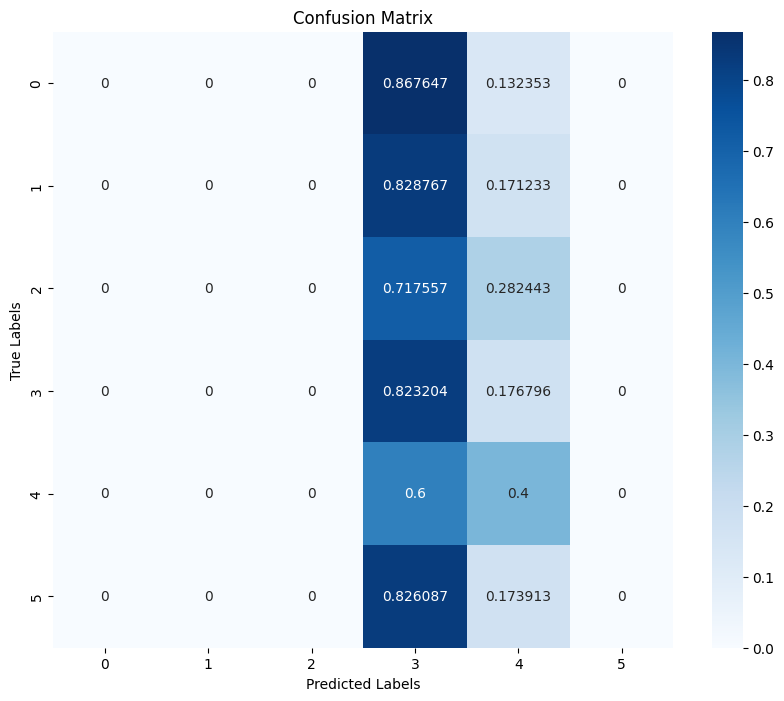

Test Loss: 1.746, Accuracy: 0.262, F1 Score: 0.145, F1 Score Per Class [0.000
Test F1 Score Per Class  [0.         0.         0.         0.4620155  0.03389831 0.        ]


In [4]:
# Call the main function with the path to folder1
imagesRoot = '/kaggle/input/resizedtreedata/ResizedTreeData'

path_to_images = imagesRoot 
train_loader, val_loader, test_loader = load_data(path_to_images)

def load_pretrained_vit(num_labels):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_labels)
    return model

num_classes = 6  # Adjust as per your dataset
num_epochs = 20
learning_rate = 7e-03
# Load the pretrained ResNet-50 model
# model = models.resnet50(pretrained=True)
vit_model = load_pretrained_vit(num_labels=num_classes)

# model.fc = nn.Linear(model.fc.in_features, num_classes)
# Initialize best F1 score for validation

best_val_f1 = 0.0
best_model_weights = None
model_name = 'TreesDelftV001'
trained_model = train_and_evaluate(vit_model, train_loader, val_loader, test_loader, model_name, num_epochs, learning_rate)

Test:   1%|▏         | 1/73 [00:00<00:35,  2.00it/s, loss=1.76]

[tensor([-0.1646, -0.0324, -0.0409,  0.0015,  0.2165, -0.0889], device='cuda:0'), tensor([ 0.0132,  0.0358,  0.0287,  0.1161, -0.4263, -0.0364], device='cuda:0'), tensor([-0.1092, -0.0124, -0.0170,  0.0325,  0.0607, -0.0676], device='cuda:0'), tensor([-0.0280,  0.0197,  0.0149,  0.0875, -0.4805, -0.0480], device='cuda:0'), tensor([-0.0611,  0.0062, -0.0011,  0.0636, -0.0285, -0.0585], device='cuda:0'), tensor([-0.0795, -0.0004, -0.0141,  0.0509, -0.0309, -0.0544], device='cuda:0'), tensor([-0.1691, -0.0335, -0.0457, -0.0009, -0.2699, -0.0791], device='cuda:0'), tensor([-0.1047, -0.0093, -0.0188,  0.0399,  0.0231, -0.0761], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:00<00:31,  2.26it/s, loss=1.73]

[tensor([-0.1083, -0.0109, -0.0201,  0.0348, -0.1123, -0.0644], device='cuda:0'), tensor([ 0.0092,  0.0337,  0.0176,  0.1087, -0.2999, -0.0332], device='cuda:0'), tensor([-0.0468,  0.0144,  0.0050,  0.0812, -0.4804, -0.0594], device='cuda:0'), tensor([ 0.0255,  0.0402,  0.0374,  0.1264, -0.3578, -0.0447], device='cuda:0'), tensor([-0.0639,  0.0053,  0.0055,  0.0641, -0.2410, -0.0625], device='cuda:0'), tensor([ 0.0403,  0.0454,  0.0388,  0.1292, -0.4624, -0.0462], device='cuda:0'), tensor([ 1.2261e-01,  7.5293e-02,  6.7271e-02,  1.8106e-01, -5.6156e-01,
        -3.9298e-05], device='cuda:0'), tensor([ 0.0203,  0.0387,  0.0267,  0.1234, -0.4360, -0.0428], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:29,  2.34it/s, loss=1.74]

[tensor([-0.0065,  0.0279,  0.0255,  0.1029, -0.3345, -0.0485], device='cuda:0'), tensor([-0.1435, -0.0242, -0.0662,  0.0137,  0.0631, -0.0742], device='cuda:0'), tensor([ 0.0993,  0.0670,  0.0574,  0.1680, -0.6332, -0.0056], device='cuda:0'), tensor([-0.1692, -0.0348, -0.0371, -0.0029,  0.1919, -0.0848], device='cuda:0'), tensor([ 0.0563,  0.0530,  0.0403,  0.1447, -0.4918, -0.0193], device='cuda:0'), tensor([ 0.0294,  0.0437,  0.0324,  0.1297, -0.5380, -0.0340], device='cuda:0'), tensor([ 0.0149,  0.0369,  0.0230,  0.1159, -0.4334, -0.0344], device='cuda:0'), tensor([-0.1353, -0.0210, -0.0473,  0.0168,  0.0106, -0.0791], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:01<00:29,  2.37it/s, loss=1.77]

[tensor([ 0.0279,  0.0401,  0.0330,  0.1213, -0.3103, -0.0340], device='cuda:0'), tensor([-0.1321, -0.0221, -0.0841,  0.0160,  0.1151, -0.0428], device='cuda:0'), tensor([-0.1508, -0.0283, -0.0319,  0.0043, -0.0318, -0.0777], device='cuda:0'), tensor([-0.1050, -0.0091, -0.0136,  0.0430, -0.1316, -0.0760], device='cuda:0'), tensor([-0.0793,  0.0004, -0.0104,  0.0591, -0.3078, -0.0547], device='cuda:0'), tensor([-0.0045,  0.0297,  0.0211,  0.1068, -0.3919, -0.0437], device='cuda:0'), tensor([-0.0543,  0.0099, -0.0045,  0.0717, -0.0933, -0.0519], device='cuda:0'), tensor([-0.2698, -0.0745, -0.0810, -0.0714,  0.4533, -0.1089], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:28,  2.40it/s, loss=1.74]

[tensor([-0.0737,  0.0020, -0.0105,  0.0575, -0.1350, -0.0497], device='cuda:0'), tensor([-0.0927, -0.0043, -0.0124,  0.0505, -0.2961, -0.0669], device='cuda:0'), tensor([ 0.0292,  0.0410,  0.0395,  0.1268, -0.3305, -0.0412], device='cuda:0'), tensor([-0.1361, -0.0219, -0.0266,  0.0166, -0.0511, -0.0750], device='cuda:0'), tensor([-0.1031, -0.0101, -0.0191,  0.0347, -0.0173, -0.0578], device='cuda:0'), tensor([-0.0832, -0.0007, -0.0098,  0.0551, -0.4360, -0.0578], device='cuda:0'), tensor([ 0.0116,  0.0355,  0.0276,  0.1135, -0.3114, -0.0430], device='cuda:0'), tensor([ 0.0561,  0.0514,  0.0479,  0.1438, -0.4572, -0.0320], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:02<00:27,  2.40it/s, loss=1.73]

[tensor([-0.0352,  0.0173,  0.0141,  0.0846, -0.1674, -0.0590], device='cuda:0'), tensor([ 0.0424,  0.0466,  0.0359,  0.1339, -0.3388, -0.0313], device='cuda:0'), tensor([ 0.0316,  0.0429,  0.0339,  0.1277, -0.4900, -0.0309], device='cuda:0'), tensor([-0.0559,  0.0146, -0.0622,  0.0761, -0.1452, -0.0428], device='cuda:0'), tensor([-0.0580,  0.0074, -0.0030,  0.0638, -0.2796, -0.0529], device='cuda:0'), tensor([-0.0125,  0.0250,  0.0233,  0.0967, -0.5028, -0.0564], device='cuda:0'), tensor([-0.3864, -0.1267, -0.2103, -0.1657,  0.1883, -0.0943], device='cuda:0'), tensor([ 0.0501,  0.0501,  0.0418,  0.1430, -0.5820, -0.0270], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:02<00:27,  2.42it/s, loss=1.72]

[tensor([ 0.1006,  0.0681,  0.0605,  0.1700, -0.5002, -0.0193], device='cuda:0'), tensor([ 0.0065,  0.0325,  0.0257,  0.1083, -0.6064, -0.0344], device='cuda:0'), tensor([ 0.0428,  0.0477,  0.0297,  0.1322, -0.4179, -0.0304], device='cuda:0'), tensor([-0.0335,  0.0179,  0.0090,  0.0861, -0.4601, -0.0423], device='cuda:0'), tensor([-0.2494, -0.0673, -0.0842, -0.0580,  0.0958, -0.0896], device='cuda:0'), tensor([-0.2115, -0.0542, -0.0717, -0.0388,  0.0179, -0.0824], device='cuda:0'), tensor([-0.1169, -0.0141, -0.0185,  0.0344, -0.1483, -0.0741], device='cuda:0'), tensor([-0.0683,  0.0043, -0.0132,  0.0578, -0.3642, -0.0386], device='cuda:0')]


Test:  11%|█         | 8/73 [00:03<00:26,  2.43it/s, loss=1.76]

[tensor([-0.0591,  0.0040, -0.0188,  0.0554, -0.2560, -0.0211], device='cuda:0'), tensor([ 0.0287,  0.0401,  0.0193,  0.1175, -0.4405, -0.0051], device='cuda:0'), tensor([ 0.0494,  0.0490,  0.0356,  0.1367, -0.4693, -0.0176], device='cuda:0'), tensor([-0.1595, -0.0310, -0.0390,  0.0026,  0.0407, -0.0755], device='cuda:0'), tensor([-0.1166, -0.0153, -0.0255,  0.0283, -0.2576, -0.0569], device='cuda:0'), tensor([-0.1692, -0.0346, -0.0438, -0.0047,  0.0892, -0.0833], device='cuda:0'), tensor([-0.1340, -0.0217, -0.0273,  0.0158,  0.0703, -0.0751], device='cuda:0'), tensor([-0.1959, -0.0472, -0.0837, -0.0264, -0.1728, -0.0695], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:03<00:26,  2.44it/s, loss=1.75]

[tensor([ 0.0755,  0.0614,  0.0470,  0.1641, -0.5701, -0.0181], device='cuda:0'), tensor([-0.0008,  0.0327,  0.0116,  0.1103, -0.3868, -0.0414], device='cuda:0'), tensor([-0.0979, -0.0087, -0.0198,  0.0348, -0.1377, -0.0488], device='cuda:0'), tensor([-0.0010,  0.0291, -0.0069,  0.1002, -0.5166, -0.0052], device='cuda:0'), tensor([ 0.0620,  0.0530,  0.0408,  0.1422, -0.3662, -0.0149], device='cuda:0'), tensor([-0.1162, -0.0141, -0.0209,  0.0312, -0.0195, -0.0695], device='cuda:0'), tensor([-0.0789,  0.0002, -0.0021,  0.0576,  0.0046, -0.0722], device='cuda:0'), tensor([-0.0957, -0.0074, -0.0214,  0.0396, -0.1104, -0.0446], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:04<00:26,  2.40it/s, loss=1.77]

[tensor([-0.0920, -0.0069, -0.0071,  0.0436,  0.0240, -0.0642], device='cuda:0'), tensor([-0.0979, -0.0066, -0.0135,  0.0464, -0.0638, -0.0693], device='cuda:0'), tensor([-0.0523,  0.0097, -0.0136,  0.0656, -0.2524, -0.0381], device='cuda:0'), tensor([-0.0038,  0.0294,  0.0241,  0.1042, -0.5540, -0.0452], device='cuda:0'), tensor([-0.1229, -0.0183, -0.0288,  0.0203,  0.0916, -0.0589], device='cuda:0'), tensor([-0.0117,  0.0256,  0.0102,  0.0938, -0.2695, -0.0442], device='cuda:0'), tensor([-0.0828, -0.0012, -0.0138,  0.0486, -0.1544, -0.0493], device='cuda:0'), tensor([-0.2035, -0.0492, -0.0871, -0.0299,  0.2266, -0.0865], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:04<00:25,  2.40it/s, loss=1.77]

[tensor([ 0.0362,  0.0435,  0.0365,  0.1278, -0.3442, -0.0273], device='cuda:0'), tensor([-0.0947, -0.0061, -0.0406,  0.0435, -0.1410, -0.0532], device='cuda:0'), tensor([-0.1516, -0.0274, -0.0348,  0.0112,  0.0635, -0.0815], device='cuda:0'), tensor([-0.0417,  0.0138,  0.0107,  0.0769, -0.2910, -0.0521], device='cuda:0'), tensor([-0.1603, -0.0311, -0.0402,  0.0013, -0.0448, -0.0727], device='cuda:0'), tensor([-0.1452, -0.0248, -0.0416,  0.0101,  0.1230, -0.0791], device='cuda:0'), tensor([-0.1643, -0.0315, -0.0422,  0.0021, -0.0459, -0.0756], device='cuda:0'), tensor([-0.1735, -0.0362, -0.0569, -0.0116, -0.4188, -0.0670], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=1.76]

[tensor([-0.1417, -0.0248, -0.0363,  0.0122,  0.0723, -0.0648], device='cuda:0'), tensor([-0.0764,  0.0019, -0.0021,  0.0602, -0.0227, -0.0672], device='cuda:0'), tensor([-0.0837, -0.0017, -0.0090,  0.0523, -0.1180, -0.0604], device='cuda:0'), tensor([-0.1143, -0.0135, -0.0209,  0.0307,  0.0983, -0.0762], device='cuda:0'), tensor([-0.1469, -0.0263, -0.0636,  0.0067,  0.0053, -0.0555], device='cuda:0'), tensor([-0.0992, -0.0071, -0.0141,  0.0443, -0.0692, -0.0707], device='cuda:0'), tensor([ 0.0070,  0.0333,  0.0275,  0.1127, -0.4153, -0.0442], device='cuda:0'), tensor([ 0.0651,  0.0550,  0.0468,  0.1516, -0.4843, -0.0235], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=1.74]

[tensor([-0.1953, -0.0451, -0.1495, -0.0250,  0.0023, -0.0766], device='cuda:0'), tensor([-0.0379,  0.0148,  0.0127,  0.0776, -0.2934, -0.0465], device='cuda:0'), tensor([ 0.0092,  0.0340,  0.0331,  0.1151, -0.3985, -0.0492], device='cuda:0'), tensor([ 0.0509,  0.0502,  0.0403,  0.1399, -0.4086, -0.0218], device='cuda:0'), tensor([-0.1098, -0.0100, -0.0146,  0.0412, -0.0271, -0.0798], device='cuda:0'), tensor([-0.1006, -0.0065, -0.0349,  0.0397,  0.0453, -0.0733], device='cuda:0'), tensor([-0.2410, -0.0424, -0.1726,  0.0714,  0.3870, -0.1488], device='cuda:0'), tensor([ 0.0723,  0.0575,  0.0507,  0.1529, -0.5681, -0.0184], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.74]

[tensor([-0.0442,  0.0134,  0.0140,  0.0800, -0.2755, -0.0622], device='cuda:0'), tensor([-0.0563,  0.0090, -0.0029,  0.0693, -0.1737, -0.0458], device='cuda:0'), tensor([-0.0483,  0.0111,  0.0018,  0.0725, -0.3658, -0.0383], device='cuda:0'), tensor([-0.1073, -0.0118, -0.0178,  0.0341, -0.2876, -0.0606], device='cuda:0'), tensor([-0.1147, -0.0130, -0.0295,  0.0301, -0.0197, -0.0603], device='cuda:0'), tensor([-0.1149, -0.0148, -0.0199,  0.0275, -0.0540, -0.0616], device='cuda:0'), tensor([-0.0613,  0.0066, -0.0011,  0.0652, -0.3045, -0.0527], device='cuda:0'), tensor([-0.1360, -0.0215, -0.0366,  0.0180, -0.2228, -0.0603], device='cuda:0')]


Test:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=1.73]

[tensor([ 0.0101,  0.0340,  0.0301,  0.1144, -0.4308, -0.0420], device='cuda:0'), tensor([-0.1549, -0.0271, -0.0448,  0.0086,  0.2359, -0.0771], device='cuda:0'), tensor([-0.3124, -0.0697, -0.1933, -0.0324,  0.2304, -0.1670], device='cuda:0'), tensor([-0.0365,  0.0155,  0.0145,  0.0805, -0.2108, -0.0513], device='cuda:0'), tensor([-0.0317,  0.0185,  0.0107,  0.0880, -0.0996, -0.0580], device='cuda:0'), tensor([ 0.0553,  0.0518,  0.0464,  0.1443, -0.5414, -0.0301], device='cuda:0'), tensor([-0.0754,  0.0006, -0.0040,  0.0555, -0.3245, -0.0595], device='cuda:0'), tensor([-0.1232, -0.0174, -0.0232,  0.0246,  0.0740, -0.0735], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=1.72]

[tensor([-0.1155, -0.0122, -0.0225,  0.0374, -0.4878, -0.0738], device='cuda:0'), tensor([-0.1680, -0.0337, -0.0388, -0.0005,  0.1776, -0.0906], device='cuda:0'), tensor([-0.1108, -0.0145, -0.0145,  0.0284, -0.1073, -0.0621], device='cuda:0'), tensor([ 0.0324,  0.0421,  0.0384,  0.1280, -0.3522, -0.0376], device='cuda:0'), tensor([-0.1086, -0.0120, -0.0221,  0.0339,  0.0040, -0.0652], device='cuda:0'), tensor([ 0.0211,  0.0387,  0.0328,  0.1232, -0.4094, -0.0400], device='cuda:0'), tensor([ 0.0194,  0.0393,  0.0317,  0.1226, -0.3756, -0.0495], device='cuda:0'), tensor([-0.0523,  0.0109, -0.0173,  0.0697, -0.3743, -0.0372], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=1.75]

[tensor([ 0.0855,  0.0625,  0.0563,  0.1613, -0.5530, -0.0188], device='cuda:0'), tensor([-0.0794,  0.0015, -0.0042,  0.0599, -0.2833, -0.0776], device='cuda:0'), tensor([ 0.0371,  0.0442,  0.0381,  0.1301, -0.4681, -0.0290], device='cuda:0'), tensor([-0.0928, -0.0047, -0.0069,  0.0489, -0.1750, -0.0748], device='cuda:0'), tensor([-0.1156, -0.0146, -0.0206,  0.0293, -0.0476, -0.0644], device='cuda:0'), tensor([-0.1344, -0.0215, -0.0498,  0.0160, -0.1935, -0.0659], device='cuda:0'), tensor([ 0.0833,  0.0625,  0.0444,  0.1581, -0.5092, -0.0047], device='cuda:0'), tensor([-0.0462,  0.0138, -0.0014,  0.0781, -0.2760, -0.0473], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:07<00:23,  2.38it/s, loss=1.75]

[tensor([-0.2194, -0.0549, -0.0696, -0.0409,  0.1051, -0.0841], device='cuda:0'), tensor([-0.1221, -0.0164, -0.0217,  0.0291, -0.1622, -0.0790], device='cuda:0'), tensor([-0.1504, -0.0267, -0.0368,  0.0090, -0.0140, -0.0752], device='cuda:0'), tensor([-0.0438,  0.0135,  0.0029,  0.0780, -0.3422, -0.0478], device='cuda:0'), tensor([-0.2022, -0.0485, -0.0666, -0.0281,  0.3762, -0.0777], device='cuda:0'), tensor([-0.1252, -0.0178, -0.0267,  0.0262, -0.2594, -0.0662], device='cuda:0'), tensor([-0.1355, -0.0209, -0.0212,  0.0241, -0.0577, -0.0906], device='cuda:0'), tensor([ 0.1022,  0.0684,  0.0604,  0.1708, -0.5158, -0.0122], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.75]

[tensor([-0.0887, -0.0061, -0.0141,  0.0411, -0.2606, -0.0436], device='cuda:0'), tensor([-0.0393,  0.0164,  0.0053,  0.0850, -0.2220, -0.0508], device='cuda:0'), tensor([ 0.0205,  0.0393,  0.0341,  0.1231, -0.4323, -0.0438], device='cuda:0'), tensor([-0.1132, -0.0135, -0.0558,  0.0264,  0.0313, -0.0508], device='cuda:0'), tensor([ 0.0400,  0.0451,  0.0406,  0.1337, -0.4425, -0.0370], device='cuda:0'), tensor([-0.0751,  0.0019, -0.0040,  0.0603, -0.6026, -0.0619], device='cuda:0'), tensor([ 0.0950,  0.0678,  0.0590,  0.1712, -0.4627, -0.0243], device='cuda:0'), tensor([-0.1076, -0.0109, -0.0312,  0.0333,  0.0360, -0.0535], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=1.71]

[tensor([-0.0017,  0.0295,  0.0285,  0.1060, -0.2915, -0.0570], device='cuda:0'), tensor([-0.0288,  0.0210,  0.0113,  0.0920, -0.3358, -0.0497], device='cuda:0'), tensor([-0.1239, -0.0173, -0.0333,  0.0226,  0.0417, -0.0621], device='cuda:0'), tensor([-0.0050,  0.0282,  0.0128,  0.0999, -0.3782, -0.0227], device='cuda:0'), tensor([-0.1967, -0.0528, -0.1101, -0.0463,  0.0990, -0.0635], device='cuda:0'), tensor([-0.0336,  0.0177,  0.0075,  0.0872, -0.3111, -0.0505], device='cuda:0'), tensor([-0.0377,  0.0153,  0.0192,  0.0842, -0.1824, -0.0640], device='cuda:0'), tensor([ 0.0849,  0.0595,  0.0386,  0.1472, -0.3996, -0.0106], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:08<00:22,  2.33it/s, loss=1.79]

[tensor([-0.1378, -0.0217, -0.0245,  0.0221,  0.1006, -0.0846], device='cuda:0'), tensor([-0.0617,  0.0050, -0.0341,  0.0565, -0.2645, -0.0237], device='cuda:0'), tensor([-0.0226,  0.0227,  0.0140,  0.0911, -0.4291, -0.0431], device='cuda:0'), tensor([-0.0422,  0.0131,  0.0092,  0.0772, -0.1566, -0.0573], device='cuda:0'), tensor([-0.1690, -0.0319, -0.0380,  0.0057, -0.1070, -0.0976], device='cuda:0'), tensor([-0.1697, -0.0308, -0.0443,  0.0085, -0.1961, -0.0968], device='cuda:0'), tensor([-0.1128, -0.0130, -0.0338,  0.0299, -0.0060, -0.0525], device='cuda:0'), tensor([ 0.0523,  0.0526,  0.0358,  0.1427, -0.5000, -0.0208], device='cuda:0')]


Test:  30%|███       | 22/73 [00:09<00:22,  2.31it/s, loss=1.75]

[tensor([-0.0952, -0.0068, -0.0179,  0.0406, -0.0922, -0.0578], device='cuda:0'), tensor([-0.1329, -0.0206, -0.0431,  0.0154,  0.0580, -0.0523], device='cuda:0'), tensor([-0.1488, -0.0269, -0.0391,  0.0070,  0.1153, -0.0655], device='cuda:0'), tensor([-0.0487,  0.0125,  0.0092,  0.0787, -0.2516, -0.0637], device='cuda:0'), tensor([ 0.1159,  0.0724,  0.0565,  0.1748, -0.5707, -0.0080], device='cuda:0'), tensor([-0.1839, -0.0399, -0.0488, -0.0130,  0.0510, -0.0920], device='cuda:0'), tensor([-0.0403,  0.0155, -0.0171,  0.0791, -0.1864, -0.0540], device='cuda:0'), tensor([-0.0804,  0.0019, -0.0799,  0.0639,  0.0320, -0.0395], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:09<00:21,  2.31it/s, loss=1.76]

[tensor([-0.0314,  0.0185,  0.0163,  0.0904, -0.0989, -0.0597], device='cuda:0'), tensor([-0.1297, -0.0194, -0.0320,  0.0176,  0.0826, -0.0615], device='cuda:0'), tensor([-0.1106, -0.0106, -0.0216,  0.0376, -0.0180, -0.0824], device='cuda:0'), tensor([-0.0472,  0.0147,  0.0050,  0.0812, -0.1417, -0.0628], device='cuda:0'), tensor([-0.0722,  0.0027, -0.0070,  0.0587, -0.1113, -0.0551], device='cuda:0'), tensor([ 0.1437,  0.0868,  0.0572,  0.2028, -0.6531,  0.0194], device='cuda:0'), tensor([-0.1704, -0.0364, -0.0679, -0.0109,  0.1537, -0.0719], device='cuda:0'), tensor([ 0.0611,  0.0546,  0.0479,  0.1534, -0.4900, -0.0286], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:10<00:21,  2.31it/s, loss=1.78]

[tensor([-0.0280,  0.0195,  0.0080,  0.0871, -0.5647, -0.0368], device='cuda:0'), tensor([ 0.0057,  0.0332,  0.0294,  0.1137, -0.6494, -0.0452], device='cuda:0'), tensor([-0.1658, -0.0285, -0.0579,  0.0110, -0.2650, -0.0733], device='cuda:0'), tensor([ 0.0904,  0.0648,  0.0558,  0.1640, -0.6067, -0.0105], device='cuda:0'), tensor([ 0.0177,  0.0370,  0.0281,  0.1156, -0.3594, -0.0315], device='cuda:0'), tensor([-0.0328,  0.0184,  0.0136,  0.0881, -0.4064, -0.0545], device='cuda:0'), tensor([-0.1383, -0.0193, -0.0648,  0.0204,  0.1696, -0.0751], device='cuda:0'), tensor([-1.0707, -0.3947, -0.5988, -0.5641,  0.1431, -0.3689], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:10<00:20,  2.34it/s, loss=1.73]

[tensor([ 0.0938,  0.0655,  0.0592,  0.1673, -0.4899, -0.0138], device='cuda:0'), tensor([-0.0786,  0.0016, -0.0194,  0.0544, -0.2402, -0.0431], device='cuda:0'), tensor([-0.1372, -0.0226, -0.0322,  0.0140,  0.0966, -0.0725], device='cuda:0'), tensor([-0.1886, -0.0418, -0.0638, -0.0142,  0.1793, -0.0746], device='cuda:0'), tensor([-0.1112, -0.0154, -0.0187,  0.0288, -0.3766, -0.0567], device='cuda:0'), tensor([-0.0742,  0.0021, -0.0014,  0.0584, -0.0366, -0.0636], device='cuda:0'), tensor([-0.0167,  0.0242,  0.0224,  0.0981, -0.4838, -0.0517], device='cuda:0'), tensor([-0.0583,  0.0064,  0.0040,  0.0650, -0.1904, -0.0532], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:11<00:20,  2.31it/s, loss=1.84]

[tensor([ 0.0392,  0.0454,  0.0406,  0.1328, -0.4669, -0.0349], device='cuda:0'), tensor([-0.1374, -0.0233, -0.0277,  0.0144,  0.1443, -0.0849], device='cuda:0'), tensor([ 0.0311,  0.0406,  0.0393,  0.1227, -0.3805, -0.0390], device='cuda:0'), tensor([-0.1543, -0.0278, -0.0350,  0.0082, -0.0067, -0.0832], device='cuda:0'), tensor([-0.1329, -0.0208, -0.0283,  0.0210, -0.0278, -0.0704], device='cuda:0'), tensor([-0.0885, -0.0027, -0.0115,  0.0508, -0.0459, -0.0628], device='cuda:0'), tensor([ 0.0425,  0.0460,  0.0368,  0.1311, -0.3279, -0.0261], device='cuda:0'), tensor([ 0.0116,  0.0353,  0.0318,  0.1175, -0.3585, -0.0474], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:11<00:20,  2.26it/s, loss=1.72]

[tensor([-0.1503, -0.0275, -0.0382,  0.0064,  0.0010, -0.0720], device='cuda:0'), tensor([-0.1094, -0.0115, -0.0377,  0.0364, -0.1525, -0.0764], device='cuda:0'), tensor([ 0.0570,  0.0520,  0.0464,  0.1447, -0.4844, -0.0258], device='cuda:0'), tensor([-0.0034,  0.0280,  0.0213,  0.0988, -0.3742, -0.0376], device='cuda:0'), tensor([ 0.0599,  0.0512,  0.0436,  0.1379, -0.4594, -0.0200], device='cuda:0'), tensor([-0.0464,  0.0128,  0.0063,  0.0749, -0.1373, -0.0525], device='cuda:0'), tensor([ 0.0682,  0.0557,  0.0537,  0.1515, -0.4712, -0.0298], device='cuda:0'), tensor([-0.0457,  0.0139,  0.0035,  0.0795, -0.3807, -0.0504], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:11<00:19,  2.28it/s, loss=1.72]

[tensor([ 0.0358,  0.0452,  0.0264,  0.1289, -0.4642, -0.0122], device='cuda:0'), tensor([-0.0840, -0.0012, -0.0037,  0.0543, -0.2144, -0.0679], device='cuda:0'), tensor([ 0.0108,  0.0345,  0.0289,  0.1123, -0.2739, -0.0387], device='cuda:0'), tensor([-0.0899, -0.0048, -0.0091,  0.0447, -0.0329, -0.0702], device='cuda:0'), tensor([-0.1082, -0.0095, -0.0461,  0.0384, -0.3070, -0.0501], device='cuda:0'), tensor([-0.0533,  0.0104,  0.0012,  0.0716, -0.3566, -0.0531], device='cuda:0'), tensor([ 0.0112,  0.0354,  0.0290,  0.1152, -0.3200, -0.0405], device='cuda:0'), tensor([-0.1447, -0.0245, -0.0296,  0.0143,  0.0353, -0.0803], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:12<00:19,  2.28it/s, loss=1.73]

[tensor([ 0.0203,  0.0384,  0.0335,  0.1190, -0.2640, -0.0421], device='cuda:0'), tensor([-0.0020,  0.0275,  0.0200,  0.1000, -0.5508, -0.0276], device='cuda:0'), tensor([-0.1125, -0.0134, -0.0650,  0.0304,  0.0296, -0.0631], device='cuda:0'), tensor([ 0.0318,  0.0421,  0.0369,  0.1257, -0.4420, -0.0319], device='cuda:0'), tensor([-0.0033,  0.0290,  0.0237,  0.1025, -0.3463, -0.0497], device='cuda:0'), tensor([-0.0953, -0.0050, -0.0282,  0.0434,  0.0099, -0.0651], device='cuda:0'), tensor([-0.0493,  0.0110,  0.0032,  0.0724, -0.3660, -0.0497], device='cuda:0'), tensor([-0.0892, -0.0027, -0.0072,  0.0512, -0.4204, -0.0755], device='cuda:0')]


Test:  41%|████      | 30/73 [00:12<00:18,  2.31it/s, loss=1.74]

[tensor([ 0.0842,  0.0621,  0.0454,  0.1548, -0.4615, -0.0146], device='cuda:0'), tensor([-0.1216, -0.0167, -0.0584,  0.0250, -0.0531, -0.0522], device='cuda:0'), tensor([-0.1279, -0.0183, -0.0280,  0.0267, -0.0399, -0.0829], device='cuda:0'), tensor([ 0.0540,  0.0524,  0.0413,  0.1474, -0.4904, -0.0270], device='cuda:0'), tensor([-0.0477,  0.0114,  0.0012,  0.0703, -0.1247, -0.0547], device='cuda:0'), tensor([-0.1290, -0.0203, -0.0272,  0.0177, -0.0373, -0.0695], device='cuda:0'), tensor([-0.1575, -0.0308, -0.0470,  0.0004,  0.1100, -0.0813], device='cuda:0'), tensor([-0.1004, -0.0076, -0.0069,  0.0437, -0.0407, -0.0757], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:13<00:18,  2.33it/s, loss=1.74]

[tensor([-0.0842, -0.0031, -0.0215,  0.0436, -0.0844, -0.0381], device='cuda:0'), tensor([-0.1124, -0.0122, -0.0265,  0.0324, -0.0745, -0.0629], device='cuda:0'), tensor([ 0.0466,  0.0470,  0.0396,  0.1323, -0.3847, -0.0223], device='cuda:0'), tensor([ 0.0404,  0.0445,  0.0473,  0.1346, -0.3829, -0.0437], device='cuda:0'), tensor([-0.0230,  0.0212,  0.0155,  0.0907, -0.4423, -0.0522], device='cuda:0'), tensor([-0.0775,  0.0022, -0.0035,  0.0601, -0.2932, -0.0640], device='cuda:0'), tensor([-0.0901, -0.0032, -0.0281,  0.0469,  0.0055, -0.0663], device='cuda:0'), tensor([ 0.0470,  0.0472,  0.0387,  0.1327, -0.4819, -0.0252], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:13<00:17,  2.35it/s, loss=1.76]

[tensor([-0.1741, -0.0358, -0.0467, -0.0053,  0.0088, -0.0821], device='cuda:0'), tensor([-0.1570, -0.0291, -0.0434,  0.0036,  0.1304, -0.0736], device='cuda:0'), tensor([ 0.1037,  0.0703,  0.0523,  0.1752, -0.5193, -0.0052], device='cuda:0'), tensor([-0.1282, -0.0198, -0.0358,  0.0206, -0.2888, -0.0642], device='cuda:0'), tensor([ 0.2098,  0.1222,  0.0727,  0.2709, -0.8811,  0.0124], device='cuda:0'), tensor([-0.1481, -0.0262, -0.0732,  0.0075,  0.1555, -0.0681], device='cuda:0'), tensor([-0.0810,  0.0014, -0.0045,  0.0598, -0.2793, -0.0704], device='cuda:0'), tensor([-0.0519,  0.0117, -0.0030,  0.0730, -0.1718, -0.0440], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:14<00:17,  2.35it/s, loss=1.72]

[tensor([-0.1002, -0.0073, -0.0114,  0.0448, -0.0487, -0.0801], device='cuda:0'), tensor([-0.0478,  0.0108, -0.0045,  0.0684, -0.4361, -0.0317], device='cuda:0'), tensor([-0.0080,  0.0266,  0.0140,  0.0977, -0.2024, -0.0399], device='cuda:0'), tensor([ 0.0589,  0.0523,  0.0465,  0.1440, -0.5137, -0.0237], device='cuda:0'), tensor([-0.0455,  0.0127,  0.0147,  0.0790, -0.2550, -0.0639], device='cuda:0'), tensor([-0.0169,  0.0227,  0.0241,  0.0948, -0.4192, -0.0500], device='cuda:0'), tensor([ 0.0980,  0.0665,  0.0582,  0.1697, -0.6207, -0.0100], device='cuda:0'), tensor([-0.0497,  0.0111,  0.0090,  0.0737, -0.1368, -0.0563], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:14<00:16,  2.33it/s, loss=1.75]

[tensor([ 0.0876,  0.0626,  0.0516,  0.1564, -0.5010, -0.0091], device='cuda:0'), tensor([-0.1450, -0.0243, -0.0460,  0.0120,  0.0267, -0.0688], device='cuda:0'), tensor([ 0.0450,  0.0467,  0.0360,  0.1370, -0.3382, -0.0380], device='cuda:0'), tensor([ 0.0229,  0.0391,  0.0220,  0.1225, -0.3782, -0.0349], device='cuda:0'), tensor([ 0.0295,  0.0429,  0.0302,  0.1287, -0.5129, -0.0268], device='cuda:0'), tensor([ 0.0147,  0.0349,  0.0329,  0.1150, -0.4123, -0.0388], device='cuda:0'), tensor([-0.0344,  0.0175,  0.0122,  0.0840, -0.2908, -0.0554], device='cuda:0'), tensor([-0.0201,  0.0250, -0.0635,  0.0929, -0.1304, -0.0146], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:14<00:16,  2.32it/s, loss=1.78]

[tensor([-0.0086,  0.0275,  0.0281,  0.1059, -0.5526, -0.0580], device='cuda:0'), tensor([ 0.0021,  0.0302,  0.0233,  0.1055, -0.2357, -0.0322], device='cuda:0'), tensor([-1.0753, -0.4480, -0.5077, -0.7344,  0.8661, -0.3573], device='cuda:0'), tensor([-0.0703,  0.0041,  0.0079,  0.0667, -0.1563, -0.0798], device='cuda:0'), tensor([ 0.0728,  0.0580,  0.0443,  0.1532, -0.5802, -0.0138], device='cuda:0'), tensor([ 0.0321,  0.0425,  0.0387,  0.1293, -0.4495, -0.0368], device='cuda:0'), tensor([-0.0017,  0.0307,  0.0235,  0.1072, -0.3618, -0.0422], device='cuda:0'), tensor([ 0.0145,  0.0347,  0.0312,  0.1126, -0.5219, -0.0394], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:15<00:16,  2.30it/s, loss=1.76]

[tensor([-0.0211,  0.0231,  0.0155,  0.0962, -0.1747, -0.0598], device='cuda:0'), tensor([-0.1375, -0.0226, -0.0309,  0.0142,  0.0292, -0.0663], device='cuda:0'), tensor([ 0.0097,  0.0345,  0.0300,  0.1141, -0.3250, -0.0418], device='cuda:0'), tensor([-0.2481, -0.0710, -0.0881, -0.0673, -0.1674, -0.0857], device='cuda:0'), tensor([-0.0238,  0.0215,  0.0157,  0.0912, -0.3421, -0.0484], device='cuda:0'), tensor([-0.0423,  0.0149,  0.0036,  0.0810, -0.1947, -0.0507], device='cuda:0'), tensor([-0.1234, -0.0164, -0.0160,  0.0308,  0.0864, -0.0834], device='cuda:0'), tensor([-0.1838, -0.0405, -0.0646, -0.0156,  0.2109, -0.0972], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:15<00:15,  2.32it/s, loss=1.72]

[tensor([-0.1795, -0.0385, -0.0486, -0.0090,  0.1114, -0.0869], device='cuda:0'), tensor([-0.0925, -0.0032, -0.0083,  0.0540, -0.2766, -0.0768], device='cuda:0'), tensor([-0.2040, -0.0473, -0.0557, -0.0235, -0.2142, -0.0934], device='cuda:0'), tensor([-0.0102,  0.0275,  0.0071,  0.1004, -0.2948, -0.0401], device='cuda:0'), tensor([-0.1889, -0.0418, -0.0535, -0.0155,  0.1978, -0.0909], device='cuda:0'), tensor([-0.0145,  0.0248,  0.0160,  0.0956, -0.2538, -0.0366], device='cuda:0'), tensor([ 0.0581,  0.0497,  0.0460,  0.1376, -0.4467, -0.0221], device='cuda:0'), tensor([ 0.0176,  0.0355,  0.0136,  0.1088, -0.4071, -0.0037], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:16<00:15,  2.28it/s, loss=1.72]

[tensor([ 0.0318,  0.0434,  0.0278,  0.1253, -0.3837, -0.0232], device='cuda:0'), tensor([ 0.0701,  0.0559,  0.0396,  0.1471, -0.4080, -0.0084], device='cuda:0'), tensor([-0.0007,  0.0314,  0.0124,  0.1084, -0.4089, -0.0395], device='cuda:0'), tensor([-0.1415, -0.0270, -0.0355,  0.0082,  0.1711, -0.0632], device='cuda:0'), tensor([ 0.1019,  0.0675,  0.0573,  0.1665, -0.6452,  0.0015], device='cuda:0'), tensor([-0.0028,  0.0289,  0.0264,  0.1057, -0.2580, -0.0487], device='cuda:0'), tensor([-0.1157, -0.0124, -0.0200,  0.0374, -0.2142, -0.0775], device='cuda:0'), tensor([ 0.0157,  0.0365,  0.0231,  0.1171, -0.2628, -0.0375], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:16<00:14,  2.30it/s, loss=1.71]

[tensor([ 0.0139,  0.0347,  0.0130,  0.1094, -0.4039, -0.0180], device='cuda:0'), tensor([ 0.0618,  0.0551,  0.0389,  0.1464, -0.5402, -0.0124], device='cuda:0'), tensor([ 0.0337,  0.0434,  0.0327,  0.1273, -0.6516, -0.0229], device='cuda:0'), tensor([-0.2094, -0.0490, -0.0898, -0.0283,  0.1794, -0.0882], device='cuda:0'), tensor([-0.0307,  0.0213,  0.0070,  0.0936, -0.2699, -0.0437], device='cuda:0'), tensor([ 0.1131,  0.0728,  0.0667,  0.1833, -0.6011, -0.0142], device='cuda:0'), tensor([ 0.0062,  0.0336,  0.0272,  0.1128, -0.4621, -0.0441], device='cuda:0'), tensor([-0.0398,  0.0154,  0.0100,  0.0804, -0.2010, -0.0493], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:17<00:14,  2.30it/s, loss=1.75]

[tensor([ 0.0171,  0.0361,  0.0313,  0.1169, -0.4263, -0.0368], device='cuda:0'), tensor([ 0.0307,  0.0436,  0.0373,  0.1342, -0.5339, -0.0398], device='cuda:0'), tensor([-0.0996, -0.0078, -0.0219,  0.0399, -0.1426, -0.0641], device='cuda:0'), tensor([-0.0312,  0.0176,  0.0067,  0.0821, -0.1654, -0.0486], device='cuda:0'), tensor([-0.1536, -0.0283, -0.0353,  0.0056,  0.0941, -0.0764], device='cuda:0'), tensor([-0.0425,  0.0143,  0.0013,  0.0758, -0.2219, -0.0435], device='cuda:0'), tensor([-0.1388, -0.0251, -0.0670,  0.0140,  0.0043, -0.0508], device='cuda:0'), tensor([ 0.0463,  0.0474,  0.0454,  0.1367, -0.5448, -0.0355], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:17<00:14,  2.27it/s, loss=1.73]

[tensor([ 0.1852,  0.1019,  0.0755,  0.2276, -0.7939,  0.0321], device='cuda:0'), tensor([-0.0786,  0.0009, -0.0092,  0.0564, -0.4009, -0.0576], device='cuda:0'), tensor([ 0.0762,  0.0589,  0.0454,  0.1518, -0.4752, -0.0152], device='cuda:0'), tensor([-0.1101, -0.0131, -0.0235,  0.0303, -0.0951, -0.0673], device='cuda:0'), tensor([ 0.0168,  0.0373,  0.0197,  0.1162, -0.4356, -0.0205], device='cuda:0'), tensor([-0.1168, -0.0146, -0.0291,  0.0301,  0.0942, -0.0727], device='cuda:0'), tensor([-0.0654,  0.0063,  0.0049,  0.0691, -0.3745, -0.0670], device='cuda:0'), tensor([-0.1832, -0.0393, -0.0650, -0.0109, -0.0238, -0.0820], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:17<00:13,  2.31it/s, loss=1.79]

[tensor([ 0.0745,  0.0579,  0.0442,  0.1491, -0.4207, -0.0105], device='cuda:0'), tensor([-0.1677, -0.0325, -0.0420,  0.0005,  0.2138, -0.0838], device='cuda:0'), tensor([ 0.0735,  0.0590,  0.0530,  0.1603, -0.5160, -0.0305], device='cuda:0'), tensor([-0.5811, -0.2098, -0.2473, -0.2442,  0.3327, -0.2757], device='cuda:0'), tensor([-0.1077, -0.0091, -0.0164,  0.0422, -0.1226, -0.0734], device='cuda:0'), tensor([-0.2129, -0.0515, -0.0532, -0.0287, -0.0049, -0.1009], device='cuda:0'), tensor([-0.1351, -0.0211, -0.0747,  0.0161,  0.1273, -0.0534], device='cuda:0'), tensor([-0.0048,  0.0275,  0.0279,  0.1016, -0.3480, -0.0481], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:18<00:13,  2.30it/s, loss=1.75]

[tensor([-0.0132,  0.0257,  0.0225,  0.0995, -0.4600, -0.0487], device='cuda:0'), tensor([-0.1313, -0.0210, -0.0304,  0.0148,  0.1112, -0.0688], device='cuda:0'), tensor([-0.1423, -0.0243, -0.0310,  0.0149,  0.0132, -0.0729], device='cuda:0'), tensor([ 0.0047,  0.0327,  0.0269,  0.1104, -0.4115, -0.0428], device='cuda:0'), tensor([-0.1652, -0.0364, -0.0452, -0.0108,  0.1391, -0.0662], device='cuda:0'), tensor([-0.1048, -0.0105, -0.0218,  0.0358, -0.1504, -0.0564], device='cuda:0'), tensor([ 0.1381,  0.0819,  0.0711,  0.1956, -0.6695,  0.0032], device='cuda:0'), tensor([-0.1169, -0.0153, -0.0422,  0.0267, -0.0922, -0.0618], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:18<00:12,  2.32it/s, loss=1.74]

[tensor([-0.1583, -0.0312, -0.0501,  0.0011,  0.0987, -0.0630], device='cuda:0'), tensor([-0.0621,  0.0092, -0.0106,  0.0717, -0.3011, -0.0458], device='cuda:0'), tensor([-0.0567,  0.0101, -0.0039,  0.0718, -0.1845, -0.0479], device='cuda:0'), tensor([ 0.0085,  0.0346,  0.0272,  0.1145, -0.3259, -0.0412], device='cuda:0'), tensor([-0.1322, -0.0211, -0.0296,  0.0175, -0.0113, -0.0820], device='cuda:0'), tensor([ 0.1130,  0.0724,  0.0661,  0.1796, -0.5398, -0.0182], device='cuda:0'), tensor([-0.2056, -0.0476, -0.0700, -0.0250, -0.0376, -0.0876], device='cuda:0'), tensor([-4.8707e-02,  1.0737e-02, -3.0248e-04,  7.2556e-02, -3.9637e-01,
        -4.2380e-02], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:19<00:12,  2.33it/s, loss=1.79]

[tensor([ 0.0566,  0.0528,  0.0308,  0.1447, -0.4906, -0.0008], device='cuda:0'), tensor([-0.0203,  0.0219,  0.0231,  0.0955, -0.2419, -0.0568], device='cuda:0'), tensor([-1.0417, -0.4186, -0.4142, -0.6615,  0.2017, -0.3768], device='cuda:0'), tensor([-0.0816, -0.0009, -0.0174,  0.0497, -0.0934, -0.0462], device='cuda:0'), tensor([-0.0439,  0.0142,  0.0021,  0.0794, -0.1509, -0.0601], device='cuda:0'), tensor([ 0.0564,  0.0517,  0.0478,  0.1455, -0.3727, -0.0345], device='cuda:0'), tensor([ 0.0284,  0.0408,  0.0314,  0.1229, -0.4981, -0.0308], device='cuda:0'), tensor([-0.1159, -0.0150, -0.0371,  0.0243, -0.0626, -0.0425], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:19<00:11,  2.34it/s, loss=1.73]

[tensor([ 0.0371,  0.0459,  0.0366,  0.1369, -0.4467, -0.0324], device='cuda:0'), tensor([ 0.0996,  0.0687,  0.0551,  0.1725, -0.7304, -0.0044], device='cuda:0'), tensor([-0.1330, -0.0202, -0.0374,  0.0188, -0.2718, -0.0610], device='cuda:0'), tensor([-0.1605, -0.0245, -0.1139,  0.0243, -0.1482, -0.0730], device='cuda:0'), tensor([-0.7861, -0.3545, -0.3070, -0.6037,  0.6695, -0.2077], device='cuda:0'), tensor([ 0.1065,  0.0705,  0.0600,  0.1747, -0.5651, -0.0079], device='cuda:0'), tensor([-5.6092e-02,  9.9934e-03, -3.2859e-04,  7.3612e-02, -4.3907e-01,
        -5.2115e-02], device='cuda:0'), tensor([-0.1675, -0.0347, -0.0410, -0.0029, -0.1163, -0.0889], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:20<00:11,  2.33it/s, loss=1.73]

[tensor([-0.0689,  0.0047, -0.0099,  0.0630, -0.2523, -0.0618], device='cuda:0'), tensor([ 0.0408,  0.0454,  0.0397,  0.1354, -0.5761, -0.0336], device='cuda:0'), tensor([ 0.0022,  0.0304,  0.0239,  0.1042, -0.2982, -0.0403], device='cuda:0'), tensor([-0.1253, -0.0169, -0.0233,  0.0263, -0.0414, -0.0753], device='cuda:0'), tensor([-0.1474, -0.0264, -0.0305,  0.0130,  0.1074, -0.0858], device='cuda:0'), tensor([ 0.1099,  0.0723,  0.0657,  0.1842, -0.5780, -0.0181], device='cuda:0'), tensor([ 0.0057,  0.0306,  0.0186,  0.1015, -0.2899, -0.0389], device='cuda:0'), tensor([ 0.0503,  0.0498,  0.0441,  0.1418, -0.4439, -0.0396], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:20<00:10,  2.32it/s, loss=1.74]

[tensor([-0.1101, -0.0142, -0.0163,  0.0280,  0.0490, -0.0663], device='cuda:0'), tensor([-0.1857, -0.0407, -0.0549, -0.0168,  0.2970, -0.0839], device='cuda:0'), tensor([ 0.0137,  0.0352,  0.0366,  0.1202, -0.3874, -0.0545], device='cuda:0'), tensor([-0.0410,  0.0150,  0.0057,  0.0815, -0.1027, -0.0598], device='cuda:0'), tensor([-0.2026, -0.0480, -0.1051, -0.0272,  0.2741, -0.0818], device='cuda:0'), tensor([ 0.0459,  0.0464,  0.0312,  0.1311, -0.5914, -0.0250], device='cuda:0'), tensor([-0.1351, -0.0199, -0.0181,  0.0260, -0.4093, -0.0929], device='cuda:0'), tensor([ 0.0756,  0.0576,  0.0518,  0.1514, -0.5111, -0.0225], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:20<00:10,  2.33it/s, loss=1.77]

[tensor([ 0.0370,  0.0459,  0.0363,  0.1347, -0.5672, -0.0303], device='cuda:0'), tensor([-0.1395, -0.0232, -0.0237,  0.0180, -0.1259, -0.0844], device='cuda:0'), tensor([-0.1000, -0.0077, -0.0284,  0.0404, -0.1086, -0.0505], device='cuda:0'), tensor([-0.1238, -0.0171, -0.0209,  0.0278, -0.0182, -0.0806], device='cuda:0'), tensor([-0.2022, -0.0463, -0.0615, -0.0238,  0.0152, -0.0867], device='cuda:0'), tensor([ 0.0041,  0.0314,  0.0264,  0.1071, -0.4592, -0.0377], device='cuda:0'), tensor([-0.0117,  0.0253,  0.0190,  0.0961, -0.2226, -0.0543], device='cuda:0'), tensor([-0.1455, -0.0255, -0.0365,  0.0124, -0.2101, -0.0686], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:21<00:09,  2.33it/s, loss=1.73]

[tensor([-0.1765, -0.0381, -0.0638, -0.0095,  0.0671, -0.0827], device='cuda:0'), tensor([-0.0712,  0.0036, -0.0179,  0.0582, -0.4907, -0.0346], device='cuda:0'), tensor([-0.1514, -0.0275, -0.0346,  0.0100, -0.1562, -0.0810], device='cuda:0'), tensor([ 0.1222,  0.0763,  0.0669,  0.1853, -0.5324, -0.0076], device='cuda:0'), tensor([-0.1668, -0.0331, -0.0501, -0.0030, -0.0252, -0.0716], device='cuda:0'), tensor([-0.0391,  0.0168,  0.0080,  0.0834, -0.3681, -0.0521], device='cuda:0'), tensor([-0.1440, -0.0239, -0.0585,  0.0116, -0.0563, -0.0607], device='cuda:0'), tensor([ 0.0619,  0.0542,  0.0467,  0.1476, -0.5046, -0.0245], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:21<00:09,  2.34it/s, loss=1.75]

[tensor([-0.0272,  0.0205,  0.0159,  0.0893, -0.1747, -0.0509], device='cuda:0'), tensor([-0.0141,  0.0262,  0.0171,  0.1021, -0.5207, -0.0459], device='cuda:0'), tensor([ 0.0269,  0.0411,  0.0193,  0.1218, -0.5231, -0.0202], device='cuda:0'), tensor([-0.0521,  0.0110, -0.0039,  0.0749, -0.1129, -0.0608], device='cuda:0'), tensor([-0.0649,  0.0048, -0.0101,  0.0581, -0.0499, -0.0429], device='cuda:0'), tensor([ 0.0045,  0.0311,  0.0253,  0.1065, -0.3446, -0.0345], device='cuda:0'), tensor([-0.1203, -0.0194, -0.0304,  0.0214,  0.0251, -0.0835], device='cuda:0'), tensor([-0.1666, -0.0343, -0.0641, -0.0052,  0.1320, -0.0746], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:22<00:08,  2.34it/s, loss=1.73]

[tensor([-0.0959, -0.0053, -0.0192,  0.0444, -0.2013, -0.0553], device='cuda:0'), tensor([ 0.1076,  0.0700,  0.0558,  0.1721, -0.5130, -0.0026], device='cuda:0'), tensor([-0.1040, -0.0075, -0.0298,  0.0386, -0.1194, -0.0500], device='cuda:0'), tensor([ 0.0052,  0.0322,  0.0266,  0.1080, -0.2844, -0.0366], device='cuda:0'), tensor([-0.0820,  0.0038, -0.0227,  0.0667, -0.2719, -0.0467], device='cuda:0'), tensor([ 0.1011,  0.0678,  0.0542,  0.1665, -0.5443,  0.0027], device='cuda:0'), tensor([-0.1940, -0.0430, -0.0706, -0.0180,  0.1830, -0.0812], device='cuda:0'), tensor([-0.0074,  0.0274,  0.0153,  0.0989, -0.2717, -0.0325], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:22<00:08,  2.33it/s, loss=1.73]

[tensor([ 0.0626,  0.0530,  0.0476,  0.1444, -0.5322, -0.0237], device='cuda:0'), tensor([-0.0394,  0.0156,  0.0016,  0.0801, -0.2950, -0.0409], device='cuda:0'), tensor([ 0.0777,  0.0600,  0.0529,  0.1593, -0.4381, -0.0221], device='cuda:0'), tensor([-0.0288,  0.0194,  0.0136,  0.0869, -0.2186, -0.0619], device='cuda:0'), tensor([ 0.0397,  0.0444,  0.0377,  0.1273, -0.3008, -0.0317], device='cuda:0'), tensor([-0.0448,  0.0130,  0.0105,  0.0770, -0.1692, -0.0568], device='cuda:0'), tensor([-0.1506, -0.0278, -0.0361,  0.0053,  0.0864, -0.0702], device='cuda:0'), tensor([ 0.0551,  0.0510,  0.0368,  0.1382, -0.5471, -0.0077], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:23<00:08,  2.34it/s, loss=1.77]

[tensor([-0.1277, -0.0199, -0.0536,  0.0159,  0.0615, -0.0609], device='cuda:0'), tensor([-0.1162, -0.0120, -0.0327,  0.0363,  0.0135, -0.0631], device='cuda:0'), tensor([-0.2015, -0.0505, -0.0641, -0.0364, -0.1661, -0.0720], device='cuda:0'), tensor([-0.1556, -0.0325, -0.0535, -0.0030, -0.1000, -0.0480], device='cuda:0'), tensor([-0.0755,  0.0030, -0.0060,  0.0618, -0.2094, -0.0623], device='cuda:0'), tensor([-0.1349, -0.0219, -0.0332,  0.0163,  0.0852, -0.0685], device='cuda:0'), tensor([-0.0155,  0.0320, -0.0200,  0.1155, -0.3489, -0.0259], device='cuda:0'), tensor([ 0.0183,  0.0386,  0.0329,  0.1231, -0.3309, -0.0446], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:23<00:07,  2.34it/s, loss=1.74]

[tensor([-0.1430, -0.0246, -0.0357,  0.0107,  0.0548, -0.0710], device='cuda:0'), tensor([ 0.0065,  0.0336,  0.0294,  0.1155, -0.3474, -0.0494], device='cuda:0'), tensor([ 0.0808,  0.0616,  0.0497,  0.1617, -0.5044, -0.0189], device='cuda:0'), tensor([ 0.0131,  0.0364,  0.0311,  0.1187, -0.4774, -0.0426], device='cuda:0'), tensor([-0.1568, -0.0311, -0.0402,  0.0031,  0.0647, -0.0899], device='cuda:0'), tensor([-0.0752,  0.0014,  0.0028,  0.0594, -0.2498, -0.0719], device='cuda:0'), tensor([-0.1412, -0.0240, -0.0411,  0.0113, -0.0419, -0.0621], device='cuda:0'), tensor([-0.1544, -0.0283, -0.0338,  0.0092,  0.1548, -0.0885], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:23<00:07,  2.33it/s, loss=1.72]

[tensor([-0.1152, -0.0137, -0.0231,  0.0278, -0.2552, -0.0625], device='cuda:0'), tensor([-0.0425,  0.0149,  0.0080,  0.0824, -0.2350, -0.0528], device='cuda:0'), tensor([ 0.0595,  0.0523,  0.0508,  0.1479, -0.3898, -0.0335], device='cuda:0'), tensor([-0.0621,  0.0087, -0.0005,  0.0710, -0.3591, -0.0563], device='cuda:0'), tensor([-0.1707, -0.0366, -0.0617, -0.0078,  0.1013, -0.0726], device='cuda:0'), tensor([-0.1621, -0.0168, -0.1331,  0.1124, -0.4005, -0.1452], device='cuda:0'), tensor([-0.0525,  0.0091, -0.0268,  0.0666, -0.2313, -0.0324], device='cuda:0'), tensor([-0.0611,  0.0065, -0.0202,  0.0593, -0.3456, -0.0283], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:24<00:06,  2.33it/s, loss=1.72]

[tensor([-0.0612,  0.0083, -0.0431,  0.0661, -0.2467, -0.0467], device='cuda:0'), tensor([-0.0969, -0.0061, -0.0139,  0.0461, -0.4655, -0.0683], device='cuda:0'), tensor([-0.0030,  0.0285,  0.0260,  0.1013, -0.3908, -0.0423], device='cuda:0'), tensor([-0.0236,  0.0216,  0.0195,  0.0946, -0.2973, -0.0561], device='cuda:0'), tensor([-0.1255, -0.0171, -0.0400,  0.0248, -0.1075, -0.0612], device='cuda:0'), tensor([ 0.0551,  0.0515,  0.0418,  0.1423, -0.3679, -0.0313], device='cuda:0'), tensor([ 0.0630,  0.0531,  0.0397,  0.1419, -0.5380, -0.0302], device='cuda:0'), tensor([-0.0196,  0.0214,  0.0183,  0.0892, -0.3281, -0.0442], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:24<00:06,  2.33it/s, loss=1.76]

[tensor([-0.1867, -0.0412, -0.0481, -0.0155,  0.1935, -0.0823], device='cuda:0'), tensor([-0.1373, -0.0214, -0.0289,  0.0192, -0.0414, -0.0717], device='cuda:0'), tensor([ 0.0241,  0.0412,  0.0331,  0.1281, -0.5008, -0.0401], device='cuda:0'), tensor([ 0.1514,  0.1012,  0.0525,  0.2368, -0.5979, -0.0045], device='cuda:0'), tensor([-0.1466, -0.0242, -0.0270,  0.0187, -0.1636, -0.0906], device='cuda:0'), tensor([ 0.1214,  0.0782,  0.0635,  0.1900, -0.5898, -0.0028], device='cuda:0'), tensor([ 0.1041,  0.0695,  0.0636,  0.1758, -0.5072, -0.0154], device='cuda:0'), tensor([ 0.0364,  0.0426,  0.0355,  0.1240, -0.3545, -0.0289], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:25<00:05,  2.33it/s, loss=1.75]

[tensor([ 0.0571,  0.0520,  0.0476,  0.1465, -0.4763, -0.0343], device='cuda:0'), tensor([-0.2177, -0.0526, -0.0660, -0.0339,  0.2394, -0.0922], device='cuda:0'), tensor([-0.1163, -0.0139, -0.0091,  0.0368,  0.0578, -0.0900], device='cuda:0'), tensor([-0.0932, -0.0047, -0.0318,  0.0423, -0.0116, -0.0514], device='cuda:0'), tensor([ 0.0373,  0.0462,  0.0331,  0.1370, -0.4565, -0.0371], device='cuda:0'), tensor([-0.1718, -0.0349, -0.0623, -0.0051,  0.1236, -0.0792], device='cuda:0'), tensor([ 0.1065,  0.0691,  0.0585,  0.1694, -0.5860, -0.0014], device='cuda:0'), tensor([-0.0339,  0.0192,  0.0157,  0.0907, -0.3904, -0.0626], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:25<00:05,  2.32it/s, loss=1.75]

[tensor([-0.2074, -0.0484, -0.0518, -0.0253,  0.3982, -0.1040], device='cuda:0'), tensor([-0.0122,  0.0262,  0.0188,  0.1032, -0.3067, -0.0573], device='cuda:0'), tensor([-0.0834, -0.0009, -0.0071,  0.0541, -0.0498, -0.0671], device='cuda:0'), tensor([ 0.0250,  0.0396,  0.0310,  0.1214, -0.5853, -0.0339], device='cuda:0'), tensor([-0.1476, -0.0259, -0.0280,  0.0125, -0.1258, -0.0890], device='cuda:0'), tensor([-0.1240, -0.0178, -0.0351,  0.0198,  0.0782, -0.0586], device='cuda:0'), tensor([-0.1434, -0.0285, -0.0615,  0.0006, -0.0006, -0.0520], device='cuda:0'), tensor([-0.0348,  0.0161,  0.0047,  0.0789, -0.1445, -0.0512], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:26<00:05,  2.31it/s, loss=1.78]

[tensor([-0.6060, -0.2802, -0.2403, -0.4942,  0.4237, -0.2046], device='cuda:0'), tensor([-0.4905, -0.1321, -0.2588, -0.0697,  0.9913, -0.2479], device='cuda:0'), tensor([ 0.0198,  0.0377,  0.0339,  0.1188, -0.4049, -0.0383], device='cuda:0'), tensor([-0.0420,  0.0145,  0.0058,  0.0783, -0.2391, -0.0605], device='cuda:0'), tensor([-0.0891, -0.0055, -0.0483,  0.0425, -0.1300, -0.0489], device='cuda:0'), tensor([-0.1340, -0.0204, -0.0175,  0.0244,  0.0778, -0.0975], device='cuda:0'), tensor([-0.0066,  0.0286,  0.0137,  0.1023, -0.2982, -0.0352], device='cuda:0'), tensor([ 0.0755,  0.0580,  0.0497,  0.1538, -0.5822, -0.0144], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:26<00:04,  2.31it/s, loss=1.82]

[tensor([-0.0246,  0.0198,  0.0068,  0.0846, -0.5560, -0.0281], device='cuda:0'), tensor([ 0.0730,  0.0577,  0.0478,  0.1507, -0.4717, -0.0201], device='cuda:0'), tensor([-0.0192,  0.0223,  0.0168,  0.0912, -0.4364, -0.0383], device='cuda:0'), tensor([-0.1717, -0.0351, -0.0348,  0.0017,  0.1497, -0.1056], device='cuda:0'), tensor([-0.0978, -0.0081, -0.0172,  0.0386, -0.0961, -0.0528], device='cuda:0'), tensor([ 0.0440,  0.0454,  0.0484,  0.1327, -0.4823, -0.0368], device='cuda:0'), tensor([-0.0613,  0.0072, -0.0160,  0.0663, -0.2217, -0.0593], device='cuda:0'), tensor([-0.1345, -0.0224, -0.0427,  0.0188,  0.1427, -0.0787], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:26<00:04,  2.31it/s, loss=1.74]

[tensor([-0.0668,  0.0059,  0.0042,  0.0672, -0.2433, -0.0670], device='cuda:0'), tensor([-0.1777, -0.0371, -0.0472, -0.0069,  0.1139, -0.0799], device='cuda:0'), tensor([-0.0028,  0.0291,  0.0239,  0.1042, -0.4318, -0.0441], device='cuda:0'), tensor([-0.1953, -0.0428, -0.0588, -0.0174,  0.0675, -0.0868], device='cuda:0'), tensor([-0.1142, -0.0133, -0.0206,  0.0331, -0.1906, -0.0694], device='cuda:0'), tensor([-0.0119,  0.0260,  0.0152,  0.0975, -0.5259, -0.0369], device='cuda:0'), tensor([-0.0761,  0.0006, -0.0101,  0.0529, -0.2989, -0.0556], device='cuda:0'), tensor([-0.1636, -0.0329, -0.0413, -0.0015,  0.1115, -0.0732], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:27<00:03,  2.30it/s, loss=1.75]

[tensor([-0.1231, -0.0156, -0.0333,  0.0261, -0.0826, -0.0652], device='cuda:0'), tensor([ 0.0663,  0.0544,  0.0485,  0.1461, -0.4346, -0.0195], device='cuda:0'), tensor([-0.0609,  0.0060,  0.0090,  0.0671, -0.0740, -0.0677], device='cuda:0'), tensor([-0.0756,  0.0008, -0.0127,  0.0519, -0.1921, -0.0499], device='cuda:0'), tensor([-0.1220, -0.0168, -0.0190,  0.0266, -0.0778, -0.0755], device='cuda:0'), tensor([ 0.1350,  0.0801,  0.0704,  0.1899, -0.6697,  0.0055], device='cuda:0'), tensor([-0.1716, -0.0376, -0.0698, -0.0104,  0.1034, -0.0809], device='cuda:0'), tensor([-0.0306,  0.0179,  0.0014,  0.0829, -0.5115, -0.0316], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:27<00:03,  2.30it/s, loss=1.75]

[tensor([-0.1390, -0.0231, -0.0399,  0.0131, -0.0503, -0.0609], device='cuda:0'), tensor([-0.2007, -0.0459, -0.1334, -0.0163,  0.0414, -0.0629], device='cuda:0'), tensor([-0.0999, -0.0076, -0.0270,  0.0385, -0.1641, -0.0498], device='cuda:0'), tensor([-0.1389, -0.0213, -0.0374,  0.0231, -0.3478, -0.0876], device='cuda:0'), tensor([-0.0431,  0.0150,  0.0051,  0.0813, -0.5383, -0.0538], device='cuda:0'), tensor([-0.0146,  0.0247,  0.0284,  0.1024, -0.2626, -0.0646], device='cuda:0'), tensor([-0.1118, -0.0122, -0.0196,  0.0339,  0.0705, -0.0665], device='cuda:0'), tensor([-0.1281, -0.0194, -0.0268,  0.0195,  0.1421, -0.0759], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:28<00:03,  2.30it/s, loss=1.72]

[tensor([-0.1211, -0.0169, -0.0167,  0.0266,  0.0643, -0.0791], device='cuda:0'), tensor([-0.0023,  0.0293,  0.0270,  0.1052, -0.3976, -0.0517], device='cuda:0'), tensor([ 0.0525,  0.0488,  0.0367,  0.1328, -0.5403, -0.0069], device='cuda:0'), tensor([ 0.0217,  0.0401,  0.0278,  0.1256, -0.3047, -0.0399], device='cuda:0'), tensor([-0.1155, -0.0139, -0.0267,  0.0285, -0.2278, -0.0557], device='cuda:0'), tensor([ 0.1475,  0.0863,  0.0732,  0.2014, -0.6632,  0.0050], device='cuda:0'), tensor([-0.0481,  0.0123,  0.0098,  0.0764, -0.2326, -0.0597], device='cuda:0'), tensor([-0.0520,  0.0113,  0.0013,  0.0753, -0.1659, -0.0551], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:28<00:02,  2.30it/s, loss=1.72]

[tensor([ 0.0847,  0.0631,  0.0508,  0.1608, -0.4754, -0.0136], device='cuda:0'), tensor([-0.1376, -0.0212, -0.0379,  0.0189,  0.0054, -0.0672], device='cuda:0'), tensor([-0.1089, -0.0111, -0.0305,  0.0349, -0.1893, -0.0473], device='cuda:0'), tensor([ 0.0485,  0.0487,  0.0381,  0.1411, -0.3509, -0.0370], device='cuda:0'), tensor([-0.0985, -0.0079, -0.0182,  0.0389, -0.2427, -0.0534], device='cuda:0'), tensor([-0.1568, -0.0299, -0.0386,  0.0011,  0.1185, -0.0724], device='cuda:0'), tensor([ 0.0170,  0.0363,  0.0332,  0.1178, -0.4792, -0.0411], device='cuda:0'), tensor([-0.1213, -0.0158, -0.0354,  0.0248,  0.0577, -0.0627], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:29<00:02,  2.29it/s, loss=1.74]

[tensor([-0.2184, -0.0532, -0.0778, -0.0328,  0.3079, -0.0882], device='cuda:0'), tensor([-0.0164,  0.0242,  0.0208,  0.0964, -0.2633, -0.0487], device='cuda:0'), tensor([-0.1769, -0.0372, -0.0535, -0.0097,  0.2080, -0.0892], device='cuda:0'), tensor([-0.0468,  0.0112,  0.0128,  0.0726, -0.1112, -0.0543], device='cuda:0'), tensor([ 0.0068,  0.0309,  0.0043,  0.1013, -0.5023, -0.0161], device='cuda:0'), tensor([ 0.0611,  0.0538,  0.0452,  0.1477, -0.6872, -0.0222], device='cuda:0'), tensor([-0.0303,  0.0201,  0.0118,  0.0915, -0.1634, -0.0577], device='cuda:0'), tensor([-0.0089,  0.0281,  0.0231,  0.1048, -0.3027, -0.0506], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:29<00:01,  2.30it/s, loss=1.78]

[tensor([-0.0878, -0.0263, -0.0736, -0.0159, -0.1396, -0.0190], device='cuda:0'), tensor([-0.1782, -0.0386, -0.0835, -0.0112,  0.2576, -0.0684], device='cuda:0'), tensor([-0.1361, -0.0222, -0.0282,  0.0159,  0.0266, -0.0712], device='cuda:0'), tensor([-0.0444,  0.0141,  0.0075,  0.0801, -0.3532, -0.0549], device='cuda:0'), tensor([ 0.0869,  0.0734,  0.0280,  0.1867, -0.4673, -0.0060], device='cuda:0'), tensor([-0.0406,  0.0143,  0.0028,  0.0792, -0.3602, -0.0363], device='cuda:0'), tensor([-0.1565, -0.0305, -0.0498,  0.0008, -0.1270, -0.0780], device='cuda:0'), tensor([-0.1438, -0.0219, -0.1082,  0.0184,  0.0555, -0.0568], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:30<00:01,  2.30it/s, loss=1.74]

[tensor([-0.0837, -0.0012, -0.0049,  0.0549, -0.1611, -0.0686], device='cuda:0'), tensor([-0.1174, -0.0145, -0.0169,  0.0325, -0.0567, -0.0807], device='cuda:0'), tensor([ 0.0568,  0.0509,  0.0450,  0.1383, -0.4495, -0.0248], device='cuda:0'), tensor([-0.2328, -0.0563, -0.0842, -0.0365,  0.1709, -0.0945], device='cuda:0'), tensor([-0.1243, -0.0167, -0.0256,  0.0303,  0.0546, -0.0760], device='cuda:0'), tensor([-8.0234e-02, -7.5141e-05, -4.8834e-03,  5.5205e-02, -6.0368e-02,
        -6.9259e-02], device='cuda:0'), tensor([ 0.0063,  0.0329,  0.0255,  0.1109, -0.5742, -0.0350], device='cuda:0'), tensor([ 0.0808,  0.0616,  0.0478,  0.1580, -0.4749, -0.0171], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:30<00:00,  2.29it/s, loss=1.74]

[tensor([-0.2067, -0.0491, -0.0543, -0.0278,  0.1286, -0.0931], device='cuda:0'), tensor([ 0.0227,  0.0394,  0.0343,  0.1233, -0.3606, -0.0448], device='cuda:0'), tensor([ 0.1161,  0.0735,  0.0626,  0.1772, -0.5984, -0.0076], device='cuda:0'), tensor([ 0.0242,  0.0386,  0.0341,  0.1192, -0.3097, -0.0306], device='cuda:0'), tensor([-0.1020, -0.0091, -0.0332,  0.0342, -0.0237, -0.0511], device='cuda:0'), tensor([-0.1665, -0.0328, -0.0513, -0.0022,  0.1627, -0.0756], device='cuda:0'), tensor([ 0.0329,  0.0431,  0.0308,  0.1239, -0.3636, -0.0428], device='cuda:0'), tensor([-0.0610,  0.0074, -0.0046,  0.0658, -0.0732, -0.0549], device='cuda:0')]


[tensor([-0.0546,  0.0098, -0.0034,  0.0712, -0.3533, -0.0455], device='cuda:0'), tensor([-0.0631,  0.0072,  0.0017,  0.0680, -0.4943, -0.0623], device='cuda:0'), tensor([-0.1502, -0.0270, -0.0370,  0.0093, -0.0903, -0.0721], device='cuda:0'), tensor([ 0.0106,  0.0337,  0.0241,  0.1108, -0.3042, -0.0439], device='cuda:0'), tensor([-0.0460,  0.0125,  0.0093,  0.0769, -0.1293, -0.0632], device='cuda:0'), tensor([ 0.0351,  0.0449,  0.0349,  0.1325, -0.4841, -0.0312], device='cuda:0'), tensor([-0.0400,  0.0166,  0.0134,  0.0879, -0.2535, -0.0630], device='cuda:0'), tensor([-0.0294,  0.0185,  0.0172,  0.0878, -0.3688, -0.0515], device='cuda:0')]
[tensor([-0.0353,  0.0202, -0.0092,  0.0901, -0.3205, -0.0295], device='cuda:0')]


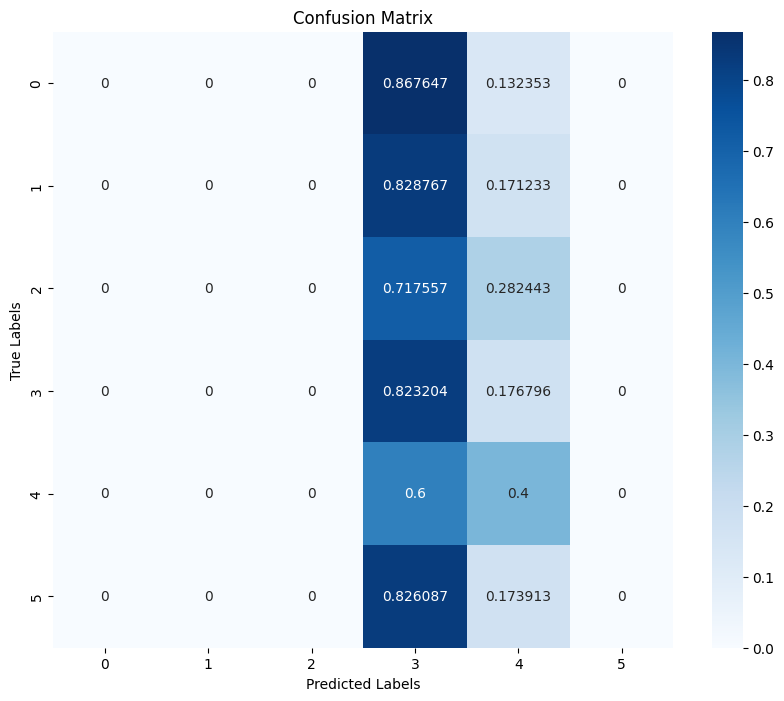

Test Loss: 1.746, Accuracy: 0.262, F1 Score: 0.145, F1 Score Per Class [0.000
Test F1 Score Per Class  [0.         0.         0.         0.4620155  0.03389831 0.        ]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=2e-04)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
patch_size=(224, 224)
stride=30
test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(trained_model, test_loader, criterion, device, patch_size, stride, desc='Test')
print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
print(f'Test F1 Score Per Class ', test_f1_per_class)